In [1]:
from pathlib import Path
from tqdm import trange

import torch
import torch.nn.functional as F

import taichi as ti

from differender.volume_raycaster import Raycaster, Mode
from differender.utils import get_rand_pos, in_circles, get_tf

from torchvtk.datasets import TorchDataset
from torchvtk.utils import TFGenerator, tex_from_pts, make_4d
from torchvtk.rendering import show_tf, plot_tf, plot_comp_render_tf

import matplotlib.pyplot as plt

[Taichi] version 0.8.1, llvm 10.0.0, commit cc2dd342, linux, python 3.9.7
[TaiGLSL] version 0.0.11


In [2]:
def show_im(im, axs=None):
    if axs is None:
        fig, axs = plt.subplot_mosaic([['rgb', 'alpha', 'wysiwyp'],
                                        ['depth1', 'depth2', 'depth3'],
                                        ['alpha1', 'alpha2', 'alpha3'],
                                        ['sorted1','sorted2','sorted3'],
                                        ['diff1','diff2','diff3']], figsize=(15,25))
    axs['rgb'].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs['rgb'].set_title('Color')
    axs['rgb'].set_axis_off()
    axs['alpha'].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs['alpha'].set_title('Alpha')
    axs['alpha'].set_axis_off()
    axs['wysiwyp'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['wysiwyp'].set_title('WYSIWYP')
    axs['wysiwyp'].set_axis_off()    
    
    axs['depth1'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['depth1'].set_title('Interval 1')
    axs['depth1'].set_axis_off()
    axs['depth2'].imshow(im.squeeze()[[5]].permute(1,2,0).cpu().numpy())
    axs['depth2'].set_title('Interval 2')
    axs['depth2'].set_axis_off()
    axs['depth3'].imshow(im.squeeze()[[6]].permute(1,2,0).cpu().numpy())
    axs['depth3'].set_title('Interval 3')
    axs['depth3'].set_axis_off()
    axs['alpha1'].imshow(im.squeeze()[[7]].permute(1,2,0).cpu().numpy())
    axs['alpha1'].set_title('Alpha at I1')
    axs['alpha1'].set_axis_off()
    axs['alpha2'].imshow(im.squeeze()[[8]].permute(1,2,0).cpu().numpy())
    axs['alpha2'].set_title('Alpha at I2')
    axs['alpha2'].set_axis_off()
    axs['alpha3'].imshow(im.squeeze()[[9]].permute(1,2,0).cpu().numpy())
    axs['alpha3'].set_title('Alpha at I3')
    axs['alpha3'].set_axis_off()

    
    sorted_depth, idx = rgbad[4:7].sort(dim=0)
    axs['sorted1'].imshow(sorted_depth[[0]].permute(1,2,0).cpu().numpy())
    axs['sorted1'].set_title('Sorted Depth 1')
    axs['sorted1'].set_axis_off()
    axs['sorted2'].imshow(sorted_depth[[1]].permute(1,2,0).cpu().numpy())
    axs['sorted2'].set_title('Sorted Depth 2')
    axs['sorted2'].set_axis_off()
    axs['sorted3'].imshow(sorted_depth[[2]].permute(1,2,0).cpu().numpy())
    axs['sorted3'].set_title('Sorted Depth 3')
    axs['sorted3'].set_axis_off()
    
    if 'diff1' in axs:
        diff1 = sorted_depth[1] - sorted_depth[0]
        diff2 = sorted_depth[2] - sorted_depth[1]
        diff3 = sorted_depth[2] - sorted_depth[0]
        axs['diff1'].imshow(diff1[None].permute(1,2,0).cpu().numpy())
        axs['diff1'].set_title('Sorted 2 - 1')
        axs['diff1'].set_axis_off()
        axs['diff2'].imshow(diff2[None].permute(1,2,0).cpu().numpy())
        axs['diff2'].set_title('Sorted 3 - 2')
        axs['diff2'].set_axis_off()
        axs['diff3'].imshow(diff3[None].permute(1,2,0).cpu().numpy())
        axs['diff3'].set_title('Sorted 3 - 1')
        axs['diff3'].set_axis_off()
    
    
def show_hist(im, ax=None, title='Histogram', show_percentages=True):
    tit = f'{title}'
    x = torch.linspace(0.0, 1.0, BINS)
    hst = torch.histc(im, BINS, min=0.0, max=1.0).cpu()
    
    if show_percentages:
        tit = f'{tit}: Transparent: {hst[1:-1].sum()/im.numel():.1%}'
        tit = f'{tit} | Opaque: {hst[-1]/im.numel():.1%}'
        tit = f'{tit} | Visible: {1.0 - hst[0]/im.numel():.1%}'
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        fig.title(tit)
    else:
        ax.set_title(tit)
    
    ax.bar(x, hst, width=1/BINS)
    

In [3]:
def show_all_ims(render):
    fig, ax = plt.subplot_mosaic([['full_rgb', 'full_a', 'full_d'],
                                  ['l1_rgb', 'l1_a', 'l1_d'],
                                  ['l2_rgb', 'l2_a', 'l2_d'],
                                  ['l3_rgb', 'l3_a', 'l3_d'],
                                 ], figsize=(15,20))
    ax['full_rgb'].imshow(render[:3].permute(1,2,0))
    ax['full_rgb'].set_title('Full RGB')
    ax['full_rgb'].set_axis_off()
    ax['full_a'].imshow(render[[3]].permute(1,2,0))
    ax['full_a'].set_title('Full Alpha')
    ax['full_a'].set_axis_off()
    ax['full_d'].imshow(render[[4]].permute(1,2,0))
    ax['full_d'].set_title('Full Depth')
    ax['full_d'].set_axis_off()
    
    ax['l1_rgb'].imshow(render[7:10].permute(1,2,0))
    ax['l1_rgb'].set_title('Layer 1 RGB')
    ax['l1_rgb'].set_axis_off()
    ax['l1_a'].imshow(render[[10]].permute(1,2,0))
    ax['l1_a'].set_title('Layer 1 Alpha')
    ax['l1_a'].set_axis_off()
    ax['l1_d'].imshow(render[[4]].permute(1,2,0))
    ax['l1_d'].set_title('Layer 1 Depth')
    ax['l1_d'].set_axis_off()
    
    ax['l2_rgb'].imshow(render[11:14].permute(1,2,0))
    ax['l2_rgb'].set_title('Layer 2 RGB')
    ax['l2_rgb'].set_axis_off()
    ax['l2_a'].imshow(render[[14]].permute(1,2,0))
    ax['l2_a'].set_title('Layer 2 Alpha')
    ax['l2_a'].set_axis_off()
    ax['l2_d'].imshow(render[[5]].permute(1,2,0))
    ax['l2_d'].set_title('Layer 2 Depth')
    ax['l2_d'].set_axis_off()
    
    ax['l3_rgb'].imshow(render[15:18].permute(1,2,0))
    ax['l3_rgb'].set_title('Layer 3 RGB')
    ax['l3_rgb'].set_axis_off()
    ax['l3_a'].imshow(render[[18]].permute(1,2,0))
    ax['l3_a'].set_title('Layer 3 Alpha')
    ax['l3_a'].set_axis_off()
    ax['l3_d'].imshow(render[[6]].permute(1,2,0))
    ax['l3_d'].set_title('Layer 3 Depth')
    ax['l3_d'].set_axis_off()

In [4]:
N_ITEMS = 100000
W, H = 512, 512
TF_RES = 256
BINS = 51
SR = 16.0 # Sampling rate
MODE = Mode.MIDA

out_dir = Path('/run/media/dome/Cluster/STDepth_data_multi_mida')
out_dir2 = Path('/run/media/dome/Cluster/STDepth_data_multi_wysiwyp')

ds = TorchDataset('/run/media/dome/Data/data/torchvtk/CQ500')
# ds = TorchDataset('/mnt/hdd/shared_datasets/torchvtk/CQ500')
N_VOLUMES = len(ds)

In [5]:
tfgen = TFGenerator(colors='distinguishable', peakgen_kwargs={
    'max_num_peaks': (2,3),
    'height_range': (0.02, 0.4),
    'width_range': (0.005, 0.05),
    'use_hist': False
})

In [ ]:
raycaster = None
skips = 0
visibilities = []
for v in trange(N_VOLUMES):
    item = ds[v]
    vol = make_4d(item['vol']).float().to('cuda')
    nam = item['name']
    ti.reset()
    del raycaster
    raycaster = Raycaster(vol.shape[-3:], (W, H), TF_RES, mode=MODE,
        sampling_rate=SR, near=0.1, far=5.0, max_samples=1, ti_kwargs={'device_memory_fraction':0.5})
    for i in trange(N_ITEMS // N_VOLUMES):
        while True:
            lf = get_rand_pos(1).float().to('cuda')
            tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
            rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.MIDA).squeeze(0)
            hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0)
            vis = hst[1:-1].sum()/rgbad[3].numel() # Visibility as in % of pixels with 0.02 < a < 0.9
            if (rgbad[3] > 0.0).float().mean() < 0.1:
                skips += 1
                print(f'Skipping another useless render ({skips})')
                continue
            elif vis < 0.2:
                skips += 1
                print(f'Skipping another too transparent render ({skips})')
                continue
            else:
                rgbad2 = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP).squeeze(0)
                visibilities.append(vis.cpu().float())
                full = rgbad[:4]
                layer1 = torch.cat([rgbad[7:11],  rgbad[[4]]], dim=0)
                layer2 = torch.cat([rgbad[11:15], rgbad[[5]]], dim=0)
                layer3 = torch.cat([rgbad[15:19], rgbad[[6]]], dim=0)
                torch.save({
                    'vol': nam,
                    'tf': tf.squeeze(0).cpu().float(),
                    'look_from': lf.squeeze(0).cpu().float(),
                    'rgba': full.cpu().half(),
                    'layer1': layer1.cpu().half(),
                    'layer2': layer2.cpu().half(),
                    'layer3': layer3.cpu().half(),
                    'visibility': vis.cpu().float()
                }, out_dir/f'{nam}_{i}.pt')
                full = rgbad2[:4]
                layer1 = torch.cat([rgbad2[7:11],  rgbad2[[4]]], dim=0)
                layer2 = torch.cat([rgbad2[11:15], rgbad2[[5]]], dim=0)
                layer3 = torch.cat([rgbad2[15:19], rgbad2[[6]]], dim=0)
                torch.save({
                    'vol': nam,
                    'tf': tf.squeeze(0).cpu().float(),
                    'look_from': lf.squeeze(0).cpu().float(),
                    'rgba': full.cpu().half(),
                    'layer1': layer1.cpu().half(),
                    'layer2': layer2.cpu().half(),
                    'layer3': layer3.cpu().half(),
                    'visibility': vis.cpu().float()
                }, out_dir2/f'{nam}_{i}.pt')
                break
print(f'Average visibility in the dataset: {torch.stack(visibilitieslities).mean():.1%}')

  0%|          | 0/395 [00:00<?, ?it/s]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:06<27:24,  6.53s/it]

Skipping another too transparent render (1)



  1%|          | 2/253 [00:10<21:19,  5.10s/it]

Skipping another too transparent render (2)



  1%|          | 3/253 [00:15<20:01,  4.81s/it]

Skipping another too transparent render (3)
Skipping another too transparent render (4)
Skipping another too transparent render (5)
Skipping another too transparent render (6)



  2%|▏         | 4/253 [00:23<25:04,  6.04s/it]

Skipping another too transparent render (7)
Skipping another too transparent render (8)



  3%|▎         | 8/253 [00:36<15:05,  3.69s/it]

Skipping another too transparent render (9)
Skipping another too transparent render (10)
Skipping another too transparent render (11)
Skipping another too transparent render (12)
Skipping another too transparent render (13)
Skipping another too transparent render (14)
Skipping another too transparent render (15)
Skipping another too transparent render (16)
Skipping another too transparent render (17)
Skipping another too transparent render (18)
Skipping another too transparent render (19)



  4%|▎         | 9/253 [00:50<28:12,  6.93s/it]

Skipping another too transparent render (20)
Skipping another too transparent render (21)



  4%|▍         | 10/253 [00:57<27:09,  6.71s/it]

Skipping another too transparent render (22)
Skipping another too transparent render (23)



  4%|▍         | 11/253 [01:02<25:16,  6.27s/it]

Skipping another too transparent render (24)
Skipping another too transparent render (25)
Skipping another too transparent render (26)
Skipping another too transparent render (27)
Skipping another too transparent render (28)
Skipping another too transparent render (29)
Skipping another too transparent render (30)



  5%|▍         | 12/253 [01:13<31:36,  7.87s/it]

Skipping another too transparent render (31)
Skipping another too transparent render (32)
Skipping another too transparent render (33)
Skipping another too transparent render (34)
Skipping another too transparent render (35)



  5%|▌         | 13/253 [01:23<33:40,  8.42s/it]

Skipping another too transparent render (36)



  6%|▌         | 15/253 [01:30<23:01,  5.81s/it]

Skipping another too transparent render (37)
Skipping another too transparent render (38)
Skipping another too transparent render (39)
Skipping another too transparent render (40)



  7%|▋         | 17/253 [01:41<21:07,  5.37s/it]

Skipping another too transparent render (41)
Skipping another too transparent render (42)



  8%|▊         | 19/253 [01:50<19:00,  4.87s/it]

Skipping another too transparent render (43)
Skipping another too transparent render (44)
Skipping another too transparent render (45)



  8%|▊         | 21/253 [02:00<18:26,  4.77s/it]

Skipping another too transparent render (46)
Skipping another too transparent render (47)



  9%|▊         | 22/253 [02:05<18:49,  4.89s/it]

Skipping another too transparent render (48)
Skipping another too transparent render (49)



  9%|▉         | 23/253 [02:11<19:19,  5.04s/it]

Skipping another too transparent render (50)
Skipping another too transparent render (51)
Skipping another too transparent render (52)
Skipping another too transparent render (53)
Skipping another too transparent render (54)
Skipping another too transparent render (55)



  9%|▉         | 24/253 [02:21<25:01,  6.55s/it]

Skipping another too transparent render (56)
Skipping another too transparent render (57)



 10%|▉         | 25/253 [02:26<23:08,  6.09s/it]

Skipping another too transparent render (58)



 10%|█         | 26/253 [02:31<21:55,  5.80s/it]

Skipping another too transparent render (59)
Skipping another too transparent render (60)
Skipping another too transparent render (61)
Skipping another too transparent render (62)
Skipping another too transparent render (63)
Skipping another too transparent render (64)
Skipping another too transparent render (65)



 11%|█         | 27/253 [02:43<29:22,  7.80s/it]

Skipping another too transparent render (66)



 11%|█▏        | 29/253 [02:51<21:03,  5.64s/it]

Skipping another too transparent render (67)



 12%|█▏        | 30/253 [02:55<19:30,  5.25s/it]

Skipping another too transparent render (68)
Skipping another too transparent render (69)



 12%|█▏        | 31/253 [03:00<19:41,  5.32s/it]

Skipping another too transparent render (70)
Skipping another too transparent render (71)
Skipping another too transparent render (72)



 13%|█▎        | 32/253 [03:07<20:56,  5.68s/it]

Skipping another too transparent render (73)
Skipping another too transparent render (74)



 13%|█▎        | 33/253 [03:13<20:56,  5.71s/it]

Skipping another too transparent render (75)
Skipping another too transparent render (76)
Skipping another too transparent render (77)
Skipping another too transparent render (78)
Skipping another too transparent render (79)



 13%|█▎        | 34/253 [03:21<24:02,  6.59s/it]

Skipping another too transparent render (80)



 14%|█▍        | 35/253 [03:25<20:38,  5.68s/it]

Skipping another too transparent render (81)
Skipping another too transparent render (82)



 14%|█▍        | 36/253 [03:31<20:38,  5.71s/it]

Skipping another too transparent render (83)
Skipping another too transparent render (84)
Skipping another too transparent render (85)
Skipping another too transparent render (86)



 15%|█▌        | 39/253 [03:45<17:07,  4.80s/it]

Skipping another too transparent render (87)
Skipping another too transparent render (88)



 16%|█▌        | 40/253 [03:50<17:16,  4.87s/it]

Skipping another too transparent render (89)
Skipping another too transparent render (90)



 16%|█▌        | 41/253 [03:55<18:07,  5.13s/it]

Skipping another too transparent render (91)
Skipping another too transparent render (92)
Skipping another too transparent render (93)
Skipping another too transparent render (94)
Skipping another too transparent render (95)
Skipping another too transparent render (96)



 17%|█▋        | 42/253 [04:07<24:38,  7.01s/it]

Skipping another too transparent render (97)
Skipping another too transparent render (98)
Skipping another too transparent render (99)



 17%|█▋        | 43/253 [04:13<23:40,  6.77s/it]

Skipping another too transparent render (100)
Skipping another too transparent render (101)
Skipping another too transparent render (102)
Skipping another too transparent render (103)



 17%|█▋        | 44/253 [04:20<23:58,  6.88s/it]

Skipping another too transparent render (104)
Skipping another too transparent render (105)
Skipping another too transparent render (106)



 19%|█▉        | 48/253 [04:37<15:12,  4.45s/it]

Skipping another too transparent render (107)
Skipping another too transparent render (108)
Skipping another too transparent render (109)
Skipping another too transparent render (110)
Skipping another too transparent render (111)



 20%|█▉        | 50/253 [04:48<16:06,  4.76s/it]

Skipping another too transparent render (112)
Skipping another too transparent render (113)
Skipping another too transparent render (114)
Skipping another too transparent render (115)



 20%|██        | 51/253 [04:56<19:24,  5.76s/it]

Skipping another too transparent render (116)
Skipping another too transparent render (117)



 21%|██        | 52/253 [05:00<17:34,  5.25s/it]

Skipping another too transparent render (118)
Skipping another too transparent render (119)
Skipping another too transparent render (120)
Skipping another too transparent render (121)
Skipping another too transparent render (122)
Skipping another too transparent render (123)
Skipping another too transparent render (124)



 21%|██        | 53/253 [05:11<23:44,  7.12s/it]

Skipping another too transparent render (125)
Skipping another too transparent render (126)



 21%|██▏       | 54/253 [05:16<21:41,  6.54s/it]

Skipping another too transparent render (127)



 22%|██▏       | 56/253 [05:24<16:36,  5.06s/it]

Skipping another too transparent render (128)
Skipping another too transparent render (129)
Skipping another too transparent render (130)
Skipping another too transparent render (131)
Skipping another too transparent render (132)



 23%|██▎       | 57/253 [05:33<20:48,  6.37s/it]

Skipping another too transparent render (133)
Skipping another too transparent render (134)
Skipping another too transparent render (135)



 23%|██▎       | 58/253 [05:39<20:05,  6.18s/it]

Skipping another too transparent render (136)



 24%|██▎       | 60/253 [05:46<15:39,  4.87s/it]

Skipping another too transparent render (137)
Skipping another too transparent render (138)



 25%|██▍       | 62/253 [05:55<14:32,  4.57s/it]

Skipping another too transparent render (139)
Skipping another too transparent render (140)
Skipping another too transparent render (141)



 25%|██▍       | 63/253 [06:02<16:53,  5.33s/it]

Skipping another too transparent render (142)



 26%|██▌       | 65/253 [06:10<14:17,  4.56s/it]

Skipping another too transparent render (143)



 27%|██▋       | 69/253 [06:24<11:09,  3.64s/it]

Skipping another too transparent render (144)
Skipping another too transparent render (145)
Skipping another too transparent render (146)
Skipping another too transparent render (147)



 28%|██▊       | 70/253 [06:31<14:31,  4.76s/it]

Skipping another too transparent render (148)



 28%|██▊       | 71/253 [06:35<13:44,  4.53s/it]

Skipping another too transparent render (149)
Skipping another too transparent render (150)
Skipping another too transparent render (151)
Skipping another too transparent render (152)
Skipping another too transparent render (153)



 28%|██▊       | 72/253 [06:45<18:27,  6.12s/it]

Skipping another too transparent render (154)
Skipping another too transparent render (155)



 29%|██▉       | 74/253 [06:55<15:39,  5.25s/it]

Skipping another too transparent render (156)
Skipping another too transparent render (157)
Skipping another too transparent render (158)
Skipping another too transparent render (159)
Skipping another too transparent render (160)
Skipping another too transparent render (161)
Skipping another too transparent render (162)
Skipping another too transparent render (163)



 30%|███       | 76/253 [07:09<17:42,  6.00s/it]

Skipping another too transparent render (164)
Skipping another too transparent render (165)



 30%|███       | 77/253 [07:15<17:15,  5.89s/it]

Skipping another too transparent render (166)
Skipping another too transparent render (167)
Skipping another too transparent render (168)
Skipping another too transparent render (169)
Skipping another useless render (170)
Skipping another too transparent render (171)
Skipping another too transparent render (172)
Skipping another too transparent render (173)
Skipping another too transparent render (174)



 31%|███       | 78/253 [07:28<23:20,  8.00s/it]

Skipping another too transparent render (175)
Skipping another too transparent render (176)
Skipping another too transparent render (177)



 31%|███       | 79/253 [07:34<21:50,  7.53s/it]

Skipping another too transparent render (178)
Skipping another too transparent render (179)
Skipping another too transparent render (180)



 32%|███▏      | 80/253 [07:41<20:50,  7.23s/it]

Skipping another too transparent render (181)
Skipping another too transparent render (182)
Skipping another too transparent render (183)
Skipping another too transparent render (184)
Skipping another too transparent render (185)
Skipping another too transparent render (186)



 32%|███▏      | 82/253 [07:54<18:46,  6.59s/it]

Skipping another too transparent render (187)
Skipping another too transparent render (188)
Skipping another too transparent render (189)
Skipping another too transparent render (190)



 34%|███▎      | 85/253 [08:08<13:46,  4.92s/it]

Skipping another too transparent render (191)
Skipping another too transparent render (192)
Skipping another too transparent render (193)



 34%|███▍      | 86/253 [08:15<15:31,  5.58s/it]

Skipping another too transparent render (194)
Skipping another too transparent render (195)
Skipping another too transparent render (196)
Skipping another too transparent render (197)



 35%|███▍      | 88/253 [08:26<14:40,  5.34s/it]

Skipping another too transparent render (198)



 35%|███▌      | 89/253 [08:30<13:49,  5.06s/it]

Skipping another too transparent render (199)
Skipping another too transparent render (200)



 36%|███▌      | 90/253 [08:35<13:38,  5.02s/it]

Skipping another too transparent render (201)
Skipping another too transparent render (202)



 36%|███▋      | 92/253 [08:42<11:26,  4.26s/it]

Skipping another too transparent render (203)
Skipping another too transparent render (204)
Skipping another too transparent render (205)
Skipping another too transparent render (206)



 37%|███▋      | 93/253 [08:50<14:14,  5.34s/it]

Skipping another too transparent render (207)
Skipping another too transparent render (208)
Skipping another too transparent render (209)
Skipping another too transparent render (210)



 37%|███▋      | 94/253 [08:57<15:24,  5.81s/it]

Skipping another too transparent render (211)
Skipping another too transparent render (212)
Skipping another too transparent render (213)



 38%|███▊      | 95/253 [09:04<15:56,  6.05s/it]

Skipping another too transparent render (214)
Skipping another too transparent render (215)



 38%|███▊      | 96/253 [09:09<15:07,  5.78s/it]

Skipping another too transparent render (216)
Skipping another too transparent render (217)
Skipping another too transparent render (218)
Skipping another too transparent render (219)



 38%|███▊      | 97/253 [09:17<16:42,  6.42s/it]

Skipping another too transparent render (220)
Skipping another too transparent render (221)
Skipping another too transparent render (222)
Skipping another too transparent render (223)
Skipping another too transparent render (224)
Skipping another too transparent render (225)
Skipping another too transparent render (226)
Skipping another too transparent render (227)
Skipping another too transparent render (228)
Skipping another too transparent render (229)
Skipping another too transparent render (230)



 39%|███▊      | 98/253 [09:33<24:09,  9.35s/it]

Skipping another too transparent render (231)
Skipping another too transparent render (232)
Skipping another too transparent render (233)
Skipping another too transparent render (234)



 40%|███▉      | 100/253 [09:44<18:24,  7.22s/it]

Skipping another too transparent render (235)
Skipping another too transparent render (236)
Skipping another too transparent render (237)



 40%|███▉      | 101/253 [09:51<18:02,  7.12s/it]

Skipping another too transparent render (238)
Skipping another too transparent render (239)
Skipping another too transparent render (240)
Skipping another too transparent render (241)
Skipping another too transparent render (242)



 40%|████      | 102/253 [09:59<18:51,  7.49s/it]

Skipping another too transparent render (243)
Skipping another too transparent render (244)
Skipping another too transparent render (245)
Skipping another too transparent render (246)
Skipping another too transparent render (247)
Skipping another too transparent render (248)
Skipping another too transparent render (249)
Skipping another too transparent render (250)



 41%|████      | 103/253 [10:12<22:36,  9.04s/it]

Skipping another too transparent render (251)
Skipping another too transparent render (252)
Skipping another too transparent render (253)
Skipping another too transparent render (254)
Skipping another too transparent render (255)
Skipping another too transparent render (256)
Skipping another too transparent render (257)



 42%|████▏     | 105/253 [10:26<18:41,  7.58s/it]

Skipping another too transparent render (258)
Skipping another too transparent render (259)
Skipping another too transparent render (260)
Skipping another too transparent render (261)
Skipping another too transparent render (262)
Skipping another too transparent render (263)
Skipping another too transparent render (264)
Skipping another too transparent render (265)
Skipping another too transparent render (266)
Skipping another too transparent render (267)



 42%|████▏     | 106/253 [10:41<23:50,  9.73s/it]

Skipping another too transparent render (268)
Skipping another too transparent render (269)
Skipping another too transparent render (270)
Skipping another too transparent render (271)



 42%|████▏     | 107/253 [10:48<22:02,  9.06s/it]

Skipping another too transparent render (272)



 43%|████▎     | 108/253 [10:52<18:23,  7.61s/it]

Skipping another too transparent render (273)
Skipping another too transparent render (274)
Skipping another too transparent render (275)
Skipping another too transparent render (276)
Skipping another too transparent render (277)
Skipping another too transparent render (278)
Skipping another too transparent render (279)



 43%|████▎     | 109/253 [11:03<20:21,  8.48s/it]

Skipping another too transparent render (280)
Skipping another too transparent render (281)



 43%|████▎     | 110/253 [11:08<18:06,  7.59s/it]

Skipping another too transparent render (282)
Skipping another too transparent render (283)
Skipping another too transparent render (284)
Skipping another too transparent render (285)
Skipping another too transparent render (286)
Skipping another too transparent render (287)
Skipping another too transparent render (288)



 44%|████▍     | 111/253 [11:20<20:36,  8.71s/it]

Skipping another too transparent render (289)
Skipping another too transparent render (290)



 44%|████▍     | 112/253 [11:25<18:11,  7.74s/it]

Skipping another too transparent render (291)



 45%|████▍     | 113/253 [11:30<16:06,  6.91s/it]

Skipping another too transparent render (292)
Skipping another too transparent render (293)



 45%|████▌     | 114/253 [11:36<15:08,  6.53s/it]

Skipping another too transparent render (294)
Skipping another too transparent render (295)
Skipping another too transparent render (296)
Skipping another too transparent render (297)
Skipping another too transparent render (298)
Skipping another too transparent render (299)



 45%|████▌     | 115/253 [11:45<17:03,  7.41s/it]

Skipping another too transparent render (300)
Skipping another too transparent render (301)
Skipping another too transparent render (302)
Skipping another too transparent render (303)



 46%|████▌     | 116/253 [11:53<17:01,  7.46s/it]

Skipping another too transparent render (304)
Skipping another too transparent render (305)
Skipping another too transparent render (306)
Skipping another too transparent render (307)
Skipping another too transparent render (308)
Skipping another too transparent render (309)
Skipping another too transparent render (310)
Skipping another too transparent render (311)
Skipping another too transparent render (312)
Skipping another too transparent render (313)



 46%|████▌     | 117/253 [12:08<22:15,  9.82s/it]

Skipping another too transparent render (314)
Skipping another too transparent render (315)
Skipping another too transparent render (316)



 47%|████▋     | 119/253 [12:18<16:06,  7.21s/it]

Skipping another too transparent render (317)



 48%|████▊     | 121/253 [12:25<11:38,  5.29s/it]

Skipping another too transparent render (318)



 49%|████▊     | 123/253 [12:33<09:41,  4.47s/it]

Skipping another too transparent render (319)
Skipping another too transparent render (320)
Skipping another too transparent render (321)
Skipping another too transparent render (322)
Skipping another too transparent render (323)
Skipping another too transparent render (324)
Skipping another too transparent render (325)
Skipping another too transparent render (326)
Skipping another too transparent render (327)
Skipping another too transparent render (328)
Skipping another too transparent render (329)



 50%|████▉     | 126/253 [12:56<11:53,  5.62s/it]

Skipping another too transparent render (330)
Skipping another too transparent render (331)
Skipping another too transparent render (332)
Skipping another too transparent render (333)
Skipping another too transparent render (334)



 50%|█████     | 127/253 [13:04<13:36,  6.48s/it]

Skipping another too transparent render (335)
Skipping another too transparent render (336)



 51%|█████     | 128/253 [13:10<13:03,  6.27s/it]

Skipping another too transparent render (337)
Skipping another too transparent render (338)
Skipping another too transparent render (339)
Skipping another too transparent render (340)



 51%|█████     | 129/253 [13:18<14:09,  6.85s/it]

Skipping another too transparent render (341)
Skipping another too transparent render (342)
Skipping another too transparent render (343)
Skipping another too transparent render (344)
Skipping another too transparent render (345)
Skipping another too transparent render (346)
Skipping another too transparent render (347)
Skipping another too transparent render (348)
Skipping another too transparent render (349)
Skipping another too transparent render (350)
Skipping another too transparent render (351)
Skipping another too transparent render (352)
Skipping another too transparent render (353)
Skipping another too transparent render (354)



 51%|█████▏    | 130/253 [13:36<20:57, 10.22s/it]

Skipping another too transparent render (355)
Skipping another too transparent render (356)
Skipping another too transparent render (357)
Skipping another too transparent render (358)
Skipping another too transparent render (359)
Skipping another too transparent render (360)
Skipping another too transparent render (361)
Skipping another too transparent render (362)



 53%|█████▎    | 133/253 [13:55<13:44,  6.87s/it]

Skipping another too transparent render (363)
Skipping another too transparent render (364)



 53%|█████▎    | 134/253 [14:00<12:45,  6.43s/it]

Skipping another too transparent render (365)
Skipping another too transparent render (366)



 53%|█████▎    | 135/253 [14:06<12:12,  6.21s/it]

Skipping another too transparent render (367)



 54%|█████▍    | 136/253 [14:10<10:46,  5.52s/it]

Skipping another too transparent render (368)
Skipping another too transparent render (369)



 54%|█████▍    | 137/253 [14:16<10:54,  5.64s/it]

Skipping another too transparent render (370)
Skipping another too transparent render (371)
Skipping another too transparent render (372)
Skipping another too transparent render (373)



 56%|█████▌    | 141/253 [14:35<08:28,  4.54s/it]

Skipping another too transparent render (374)



 56%|█████▌    | 142/253 [14:39<08:07,  4.39s/it]

Skipping another too transparent render (375)
Skipping another too transparent render (376)



 57%|█████▋    | 143/253 [14:43<08:00,  4.37s/it]

Skipping another too transparent render (377)



 57%|█████▋    | 145/253 [14:51<07:27,  4.14s/it]

Skipping another too transparent render (378)



 58%|█████▊    | 146/253 [14:55<07:22,  4.13s/it]

Skipping another too transparent render (379)



 58%|█████▊    | 147/253 [14:59<07:29,  4.24s/it]

Skipping another too transparent render (380)
Skipping another too transparent render (381)
Skipping another too transparent render (382)
Skipping another too transparent render (383)
Skipping another too transparent render (384)
Skipping another too transparent render (385)
Skipping another too transparent render (386)



 58%|█████▊    | 148/253 [15:11<11:17,  6.45s/it]

Skipping another too transparent render (387)



 59%|█████▉    | 149/253 [15:15<09:59,  5.76s/it]

Skipping another too transparent render (388)



 60%|█████▉    | 151/253 [15:22<07:40,  4.51s/it]

Skipping another too transparent render (389)



 60%|██████    | 152/253 [15:27<07:38,  4.54s/it]

Skipping another too transparent render (390)
Skipping another too transparent render (391)



 60%|██████    | 153/253 [15:32<08:10,  4.91s/it]

Skipping another too transparent render (392)



 61%|██████    | 154/253 [15:36<07:40,  4.66s/it]

Skipping another too transparent render (393)
Skipping another too transparent render (394)
Skipping another too transparent render (395)
Skipping another too transparent render (396)
Skipping another too transparent render (397)



 61%|██████▏   | 155/253 [15:45<09:28,  5.80s/it]

Skipping another too transparent render (398)
Skipping another too transparent render (399)
Skipping another too transparent render (400)
Skipping another too transparent render (401)
Skipping another too transparent render (402)
Skipping another too transparent render (403)
Skipping another too transparent render (404)
Skipping another too transparent render (405)
Skipping another too transparent render (406)
Skipping another too transparent render (407)



 62%|██████▏   | 156/253 [15:59<13:34,  8.40s/it]

Skipping another too transparent render (408)
Skipping another too transparent render (409)
Skipping another too transparent render (410)



 62%|██████▏   | 157/253 [16:06<12:38,  7.90s/it]

Skipping another too transparent render (411)
Skipping another too transparent render (412)
Skipping another too transparent render (413)
Skipping another too transparent render (414)
Skipping another too transparent render (415)
Skipping another too transparent render (416)
Skipping another too transparent render (417)
Skipping another too transparent render (418)
Skipping another too transparent render (419)



 62%|██████▏   | 158/253 [16:19<14:59,  9.47s/it]

Skipping another too transparent render (420)
Skipping another too transparent render (421)



 63%|██████▎   | 159/253 [16:24<12:41,  8.10s/it]

Skipping another too transparent render (422)
Skipping another too transparent render (423)



 63%|██████▎   | 160/253 [16:29<11:10,  7.21s/it]

Skipping another too transparent render (424)



 64%|██████▎   | 161/253 [16:34<09:41,  6.32s/it]

Skipping another too transparent render (425)
Skipping another too transparent render (426)



 64%|██████▍   | 162/253 [16:40<09:26,  6.22s/it]

Skipping another too transparent render (427)
Skipping another too transparent render (428)



 65%|██████▌   | 165/253 [16:51<06:39,  4.54s/it]

Skipping another too transparent render (429)
Skipping another too transparent render (430)
Skipping another too transparent render (431)
Skipping another too transparent render (432)
Skipping another too transparent render (433)
Skipping another too transparent render (434)



 66%|██████▌   | 166/253 [17:02<09:13,  6.36s/it]

Skipping another too transparent render (435)



 66%|██████▌   | 167/253 [17:06<08:12,  5.73s/it]

Skipping another too transparent render (436)
Skipping another too transparent render (437)



 66%|██████▋   | 168/253 [17:11<08:05,  5.71s/it]

Skipping another too transparent render (438)



 67%|██████▋   | 170/253 [17:18<06:15,  4.52s/it]

Skipping another too transparent render (439)



 68%|██████▊   | 171/253 [17:22<05:59,  4.38s/it]

Skipping another too transparent render (440)
Skipping another too transparent render (441)



 68%|██████▊   | 172/253 [17:27<06:06,  4.52s/it]

Skipping another too transparent render (442)
Skipping another too transparent render (443)
Skipping another too transparent render (444)
Skipping another too transparent render (445)
Skipping another too transparent render (446)
Skipping another too transparent render (447)
Skipping another too transparent render (448)



 68%|██████▊   | 173/253 [17:39<08:55,  6.69s/it]

Skipping another too transparent render (449)
Skipping another too transparent render (450)



 69%|██████▉   | 175/253 [17:47<06:37,  5.10s/it]

Skipping another too transparent render (451)
Skipping another too transparent render (452)
Skipping another too transparent render (453)
Skipping another too transparent render (454)



 70%|██████▉   | 176/253 [17:55<07:53,  6.15s/it]

Skipping another too transparent render (455)
Skipping another too transparent render (456)
Skipping another too transparent render (457)



 70%|██████▉   | 177/253 [18:03<08:18,  6.56s/it]

Skipping another too transparent render (458)
Skipping another too transparent render (459)
Skipping another too transparent render (460)
Skipping another too transparent render (461)
Skipping another too transparent render (462)
Skipping another too transparent render (463)
Skipping another too transparent render (464)
Skipping another too transparent render (465)
Skipping another too transparent render (466)
Skipping another too transparent render (467)
Skipping another too transparent render (468)



 70%|███████   | 178/253 [18:19<11:43,  9.39s/it]

Skipping another too transparent render (469)
Skipping another too transparent render (470)



 71%|███████   | 179/253 [18:24<10:02,  8.14s/it]

Skipping another too transparent render (471)



 71%|███████   | 180/253 [18:28<08:36,  7.08s/it]

Skipping another too transparent render (472)



 72%|███████▏  | 181/253 [18:33<07:27,  6.21s/it]

Skipping another too transparent render (473)



 73%|███████▎  | 184/253 [18:43<05:03,  4.40s/it]

Skipping another too transparent render (474)
Skipping another too transparent render (475)
Skipping another too transparent render (476)



 73%|███████▎  | 185/253 [18:50<05:45,  5.08s/it]

Skipping another too transparent render (477)
Skipping another too transparent render (478)
Skipping another too transparent render (479)
Skipping another too transparent render (480)
Skipping another too transparent render (481)



 74%|███████▎  | 186/253 [18:58<06:46,  6.06s/it]

Skipping another too transparent render (482)
Skipping another too transparent render (483)
Skipping another too transparent render (484)
Skipping another too transparent render (485)



 75%|███████▍  | 189/253 [19:14<05:29,  5.14s/it]

Skipping another too transparent render (486)



 75%|███████▌  | 190/253 [19:18<05:11,  4.95s/it]

Skipping another too transparent render (487)
Skipping another too transparent render (488)
Skipping another too transparent render (489)
Skipping another too transparent render (490)



 76%|███████▌  | 192/253 [19:29<04:56,  4.86s/it]

Skipping another too transparent render (491)
Skipping another too transparent render (492)
Skipping another too transparent render (493)
Skipping another too transparent render (494)



 77%|███████▋  | 194/253 [19:40<04:52,  4.96s/it]

Skipping another too transparent render (495)



 78%|███████▊  | 197/253 [19:50<03:36,  3.87s/it]

Skipping another too transparent render (496)



 78%|███████▊  | 198/253 [19:54<03:34,  3.90s/it]

Skipping another too transparent render (497)
Skipping another too transparent render (498)
Skipping another too transparent render (499)
Skipping another too transparent render (500)



 79%|███████▊  | 199/253 [20:01<04:21,  4.85s/it]

Skipping another too transparent render (501)
Skipping another too transparent render (502)



 79%|███████▉  | 200/253 [20:06<04:17,  4.87s/it]

Skipping another too transparent render (503)
Skipping another too transparent render (504)
Skipping another too transparent render (505)



 80%|████████  | 203/253 [20:18<03:17,  3.96s/it]

Skipping another too transparent render (506)
Skipping another too transparent render (507)



 81%|████████  | 205/253 [20:25<03:01,  3.77s/it]

Skipping another too transparent render (508)
Skipping another too transparent render (509)
Skipping another too transparent render (510)
Skipping another too transparent render (511)



 81%|████████▏ | 206/253 [20:33<03:53,  4.97s/it]

Skipping another too transparent render (512)



 82%|████████▏ | 207/253 [20:37<03:39,  4.76s/it]

Skipping another too transparent render (513)
Skipping another too transparent render (514)



 83%|████████▎ | 209/253 [20:45<03:12,  4.37s/it]

Skipping another too transparent render (515)
Skipping another too transparent render (516)
Skipping another too transparent render (517)
Skipping another too transparent render (518)
Skipping another too transparent render (519)



 84%|████████▍ | 212/253 [21:01<03:03,  4.48s/it]

Skipping another too transparent render (520)



 85%|████████▌ | 216/253 [21:17<02:25,  3.92s/it]

Skipping another too transparent render (521)



 86%|████████▌ | 218/253 [21:24<02:12,  3.78s/it]

Skipping another useless render (522)



 87%|████████▋ | 219/253 [21:30<02:24,  4.26s/it]

Skipping another too transparent render (523)
Skipping another too transparent render (524)



 87%|████████▋ | 220/253 [21:36<02:37,  4.77s/it]

Skipping another too transparent render (525)
Skipping another too transparent render (526)
Skipping another too transparent render (527)



 87%|████████▋ | 221/253 [21:42<02:52,  5.39s/it]

Skipping another too transparent render (528)



 89%|████████▊ | 224/253 [21:52<01:52,  3.87s/it]

Skipping another too transparent render (529)
Skipping another too transparent render (530)



 89%|████████▉ | 225/253 [21:57<01:58,  4.21s/it]

Skipping another too transparent render (531)
Skipping another too transparent render (532)
Skipping another too transparent render (533)
Skipping another too transparent render (534)
Skipping another too transparent render (535)
Skipping another too transparent render (536)
Skipping another too transparent render (537)



 90%|████████▉ | 227/253 [22:10<02:14,  5.16s/it]

Skipping another too transparent render (538)



 90%|█████████ | 228/253 [22:14<01:57,  4.72s/it]

Skipping another too transparent render (539)
Skipping another too transparent render (540)
Skipping another too transparent render (541)
Skipping another too transparent render (542)
Skipping another too transparent render (543)
Skipping another too transparent render (544)
Skipping another too transparent render (545)
Skipping another too transparent render (546)



 91%|█████████ | 229/253 [22:26<02:41,  6.74s/it]

Skipping another too transparent render (547)
Skipping another too transparent render (548)
Skipping another too transparent render (549)



 91%|█████████ | 230/253 [22:31<02:25,  6.33s/it]

Skipping another too transparent render (550)
Skipping another too transparent render (551)
Skipping another too transparent render (552)
Skipping another too transparent render (553)
Skipping another too transparent render (554)
Skipping another too transparent render (555)
Skipping another too transparent render (556)



 92%|█████████▏| 234/253 [22:51<01:30,  4.75s/it]

Skipping another too transparent render (557)
Skipping another too transparent render (558)
Skipping another too transparent render (559)
Skipping another too transparent render (560)



 93%|█████████▎| 235/253 [23:00<01:46,  5.94s/it]

Skipping another too transparent render (561)
Skipping another too transparent render (562)
Skipping another too transparent render (563)
Skipping another too transparent render (564)
Skipping another too transparent render (565)
Skipping another too transparent render (566)
Skipping another too transparent render (567)
Skipping another too transparent render (568)



 94%|█████████▎| 237/253 [23:16<01:45,  6.62s/it]

Skipping another too transparent render (569)
Skipping another too transparent render (570)
Skipping another too transparent render (571)



 94%|█████████▍| 238/253 [23:23<01:40,  6.72s/it]

Skipping another too transparent render (572)



 94%|█████████▍| 239/253 [23:27<01:23,  5.95s/it]

Skipping another too transparent render (573)
Skipping another too transparent render (574)
Skipping another too transparent render (575)
Skipping another too transparent render (576)
Skipping another too transparent render (577)



 95%|█████████▍| 240/253 [23:36<01:29,  6.87s/it]

Skipping another too transparent render (578)
Skipping another too transparent render (579)
Skipping another too transparent render (580)



 96%|█████████▌| 242/253 [23:46<01:02,  5.71s/it]

Skipping another too transparent render (581)
Skipping another too transparent render (582)
Skipping another too transparent render (583)
Skipping another too transparent render (584)
Skipping another too transparent render (585)



 96%|█████████▌| 243/253 [23:55<01:06,  6.68s/it]

Skipping another too transparent render (586)
Skipping another too transparent render (587)



 96%|█████████▋| 244/253 [24:01<00:56,  6.30s/it]

Skipping another too transparent render (588)
Skipping another too transparent render (589)



 97%|█████████▋| 246/253 [24:09<00:36,  5.16s/it]

Skipping another too transparent render (590)
Skipping another too transparent render (591)
Skipping another too transparent render (592)
Skipping another too transparent render (593)
Skipping another too transparent render (594)
Skipping another too transparent render (595)
Skipping another too transparent render (596)



 98%|█████████▊| 247/253 [24:21<00:42,  7.10s/it]

Skipping another too transparent render (597)
Skipping another too transparent render (598)
Skipping another too transparent render (599)
Skipping another too transparent render (600)
Skipping another too transparent render (601)



 98%|█████████▊| 248/253 [24:29<00:37,  7.40s/it]

Skipping another too transparent render (602)
Skipping another too transparent render (603)
Skipping another too transparent render (604)
Skipping another too transparent render (605)
Skipping another too transparent render (606)



 99%|█████████▉| 250/253 [24:43<00:20,  6.78s/it]

Skipping another too transparent render (607)



 99%|█████████▉| 251/253 [24:47<00:12,  6.05s/it]

Skipping another too transparent render (608)
Skipping another too transparent render (609)



100%|█████████▉| 252/253 [24:53<00:05,  5.90s/it]

Skipping another too transparent render (610)
Skipping another too transparent render (611)



  0%|          | 1/395 [24:59<164:06:48, 1499.51s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (612)



  0%|          | 1/253 [00:08<35:45,  8.51s/it]

Skipping another too transparent render (613)



  1%|          | 3/253 [00:16<20:15,  4.86s/it]

Skipping another too transparent render (614)
Skipping another too transparent render (615)



  2%|▏         | 4/253 [00:22<21:42,  5.23s/it]

Skipping another too transparent render (616)
Skipping another too transparent render (617)
Skipping another too transparent render (618)
Skipping another too transparent render (619)



  2%|▏         | 5/253 [00:29<24:20,  5.89s/it]

Skipping another too transparent render (620)
Skipping another too transparent render (621)
Skipping another too transparent render (622)
Skipping another too transparent render (623)
Skipping another too transparent render (624)



  2%|▏         | 6/253 [00:37<27:56,  6.79s/it]

Skipping another too transparent render (625)
Skipping another too transparent render (626)
Skipping another too transparent render (627)
Skipping another too transparent render (628)



  3%|▎         | 7/253 [00:45<28:48,  7.03s/it]

Skipping another too transparent render (629)
Skipping another too transparent render (630)
Skipping another too transparent render (631)
Skipping another too transparent render (632)
Skipping another too transparent render (633)
Skipping another too transparent render (634)
Skipping another too transparent render (635)
Skipping another too transparent render (636)
Skipping another too transparent render (637)



  3%|▎         | 8/253 [00:57<35:32,  8.70s/it]

Skipping another too transparent render (638)
Skipping another too transparent render (639)
Skipping another too transparent render (640)



  4%|▎         | 9/253 [01:03<31:36,  7.77s/it]

Skipping another too transparent render (641)
Skipping another too transparent render (642)
Skipping another too transparent render (643)
Skipping another too transparent render (644)



  4%|▍         | 10/253 [01:11<32:16,  7.97s/it]

Skipping another too transparent render (645)



  4%|▍         | 11/253 [01:16<27:51,  6.91s/it]

Skipping another too transparent render (646)
Skipping another too transparent render (647)
Skipping another too transparent render (648)
Skipping another too transparent render (649)
Skipping another too transparent render (650)



  5%|▍         | 12/253 [01:24<28:58,  7.21s/it]

Skipping another too transparent render (651)
Skipping another too transparent render (652)
Skipping another too transparent render (653)
Skipping another too transparent render (654)
Skipping another too transparent render (655)



  5%|▌         | 13/253 [01:32<30:44,  7.69s/it]

Skipping another too transparent render (656)



  6%|▌         | 14/253 [01:36<26:13,  6.58s/it]

Skipping another too transparent render (657)
Skipping another too transparent render (658)
Skipping another too transparent render (659)
Skipping another too transparent render (660)



  6%|▌         | 15/253 [01:44<27:26,  6.92s/it]

Skipping another too transparent render (661)
Skipping another too transparent render (662)
Skipping another too transparent render (663)
Skipping another too transparent render (664)
Skipping another too transparent render (665)
Skipping another too transparent render (666)



  8%|▊         | 19/253 [02:03<18:44,  4.81s/it]

Skipping another too transparent render (667)
Skipping another too transparent render (668)



  8%|▊         | 20/253 [02:09<19:31,  5.03s/it]

Skipping another too transparent render (669)



  8%|▊         | 21/253 [02:13<18:32,  4.79s/it]

Skipping another too transparent render (670)
Skipping another too transparent render (671)
Skipping another too transparent render (672)



  9%|▊         | 22/253 [02:19<20:14,  5.26s/it]

Skipping another too transparent render (673)
Skipping another too transparent render (674)
Skipping another too transparent render (675)



 10%|▉         | 25/253 [02:32<16:46,  4.41s/it]

Skipping another too transparent render (676)



 11%|█         | 27/253 [02:40<15:35,  4.14s/it]

Skipping another too transparent render (677)



 11%|█         | 28/253 [02:44<15:44,  4.20s/it]

Skipping another too transparent render (678)
Skipping another too transparent render (679)
Skipping another too transparent render (680)
Skipping another too transparent render (681)
Skipping another too transparent render (682)
Skipping another too transparent render (683)



 12%|█▏        | 30/253 [02:57<18:47,  5.05s/it]

Skipping another too transparent render (684)
Skipping another too transparent render (685)



 12%|█▏        | 31/253 [03:02<17:56,  4.85s/it]

Skipping another too transparent render (686)
Skipping another too transparent render (687)
Skipping another too transparent render (688)
Skipping another too transparent render (689)



 13%|█▎        | 32/253 [03:08<19:52,  5.40s/it]

Skipping another too transparent render (690)
Skipping another too transparent render (691)
Skipping another too transparent render (692)
Skipping another too transparent render (693)
Skipping another too transparent render (694)
Skipping another too transparent render (695)
Skipping another too transparent render (696)
Skipping another too transparent render (697)
Skipping another too transparent render (698)
Skipping another too transparent render (699)
Skipping another too transparent render (700)
Skipping another too transparent render (701)
Skipping another too transparent render (702)



 13%|█▎        | 34/253 [03:29<26:15,  7.19s/it]

Skipping another too transparent render (703)
Skipping another too transparent render (704)



 14%|█▍        | 35/253 [03:34<24:28,  6.74s/it]

Skipping another too transparent render (705)
Skipping another too transparent render (706)
Skipping another too transparent render (707)



 14%|█▍        | 36/253 [03:41<24:09,  6.68s/it]

Skipping another too transparent render (708)
Skipping another too transparent render (709)



 15%|█▍        | 37/253 [03:46<22:41,  6.30s/it]

Skipping another too transparent render (710)
Skipping another too transparent render (711)
Skipping another too transparent render (712)



 15%|█▌        | 38/253 [03:52<22:17,  6.22s/it]

Skipping another too transparent render (713)
Skipping another too transparent render (714)
Skipping another too transparent render (715)
Skipping another too transparent render (716)
Skipping another too transparent render (717)
Skipping another too transparent render (718)
Skipping another too transparent render (719)
Skipping another too transparent render (720)



 16%|█▌        | 40/253 [04:08<23:30,  6.62s/it]

Skipping another too transparent render (721)



 16%|█▌        | 41/253 [04:12<20:23,  5.77s/it]

Skipping another too transparent render (722)



 17%|█▋        | 43/253 [04:19<16:41,  4.77s/it]

Skipping another too transparent render (723)



 17%|█▋        | 44/253 [04:24<16:08,  4.63s/it]

Skipping another too transparent render (724)
Skipping another too transparent render (725)



 18%|█▊        | 46/253 [04:32<15:20,  4.45s/it]

Skipping another too transparent render (726)
Skipping another too transparent render (727)
Skipping another too transparent render (728)
Skipping another too transparent render (729)



 19%|█▉        | 48/253 [04:43<16:13,  4.75s/it]

Skipping another too transparent render (730)
Skipping another too transparent render (731)
Skipping another too transparent render (732)



 19%|█▉        | 49/253 [04:51<18:51,  5.55s/it]

Skipping another too transparent render (733)
Skipping another too transparent render (734)
Skipping another too transparent render (735)
Skipping another too transparent render (736)



 20%|█▉        | 50/253 [05:00<22:11,  6.56s/it]

Skipping another too transparent render (737)



 21%|██        | 52/253 [05:07<16:52,  5.04s/it]

Skipping another too transparent render (738)
Skipping another too transparent render (739)
Skipping another too transparent render (740)
Skipping another too transparent render (741)
Skipping another too transparent render (742)



 21%|██        | 53/253 [05:16<20:53,  6.27s/it]

Skipping another too transparent render (743)
Skipping another too transparent render (744)
Skipping another too transparent render (745)
Skipping another too transparent render (746)
Skipping another too transparent render (747)



 21%|██▏       | 54/253 [05:25<23:08,  6.98s/it]

Skipping another too transparent render (748)
Skipping another too transparent render (749)



 22%|██▏       | 55/253 [05:31<22:31,  6.83s/it]

Skipping another too transparent render (750)
Skipping another too transparent render (751)
Skipping another too transparent render (752)
Skipping another too transparent render (753)



 22%|██▏       | 56/253 [05:39<23:00,  7.01s/it]

Skipping another too transparent render (754)
Skipping another too transparent render (755)
Skipping another too transparent render (756)



 23%|██▎       | 57/253 [05:45<22:12,  6.80s/it]

Skipping another too transparent render (757)
Skipping another too transparent render (758)



 23%|██▎       | 58/253 [05:51<21:05,  6.49s/it]

Skipping another too transparent render (759)
Skipping another too transparent render (760)
Skipping another too transparent render (761)



 24%|██▎       | 60/253 [06:01<17:54,  5.57s/it]

Skipping another too transparent render (762)
Skipping another too transparent render (763)
Skipping another too transparent render (764)
Skipping another too transparent render (765)



 24%|██▍       | 61/253 [06:09<20:07,  6.29s/it]

Skipping another too transparent render (766)
Skipping another too transparent render (767)



 25%|██▍       | 63/253 [06:18<16:36,  5.25s/it]

Skipping another too transparent render (768)



 25%|██▌       | 64/253 [06:22<15:23,  4.88s/it]

Skipping another too transparent render (769)
Skipping another too transparent render (770)
Skipping another too transparent render (771)
Skipping another too transparent render (772)



 26%|██▌       | 65/253 [06:29<17:53,  5.71s/it]

Skipping another too transparent render (773)



 27%|██▋       | 68/253 [06:40<12:52,  4.18s/it]

Skipping another too transparent render (774)



 28%|██▊       | 70/253 [06:48<12:21,  4.05s/it]

Skipping another too transparent render (775)
Skipping another too transparent render (776)
Skipping another too transparent render (777)
Skipping another too transparent render (778)
Skipping another too transparent render (779)
Skipping another too transparent render (780)



 28%|██▊       | 71/253 [06:57<17:17,  5.70s/it]

Skipping another too transparent render (781)



 29%|██▉       | 73/253 [07:05<14:05,  4.70s/it]

Skipping another too transparent render (782)
Skipping another too transparent render (783)
Skipping another too transparent render (784)
Skipping another too transparent render (785)



 29%|██▉       | 74/253 [07:12<15:53,  5.33s/it]

Skipping another too transparent render (786)
Skipping another too transparent render (787)
Skipping another too transparent render (788)



 30%|██▉       | 75/253 [07:18<16:36,  5.60s/it]

Skipping another too transparent render (789)
Skipping another too transparent render (790)
Skipping another too transparent render (791)
Skipping another too transparent render (792)
Skipping another too transparent render (793)



 30%|███       | 76/253 [07:27<19:38,  6.66s/it]

Skipping another too transparent render (794)



 30%|███       | 77/253 [07:32<18:04,  6.16s/it]

Skipping another too transparent render (795)



 31%|███       | 78/253 [07:37<16:41,  5.72s/it]

Skipping another too transparent render (796)
Skipping another too transparent render (797)
Skipping another too transparent render (798)
Skipping another too transparent render (799)
Skipping another too transparent render (800)
Skipping another too transparent render (801)



 31%|███       | 79/253 [07:47<20:17,  6.99s/it]

Skipping another too transparent render (802)
Skipping another too transparent render (803)
Skipping another too transparent render (804)
Skipping another too transparent render (805)
Skipping another too transparent render (806)



 32%|███▏      | 82/253 [08:01<14:53,  5.22s/it]

Skipping another too transparent render (807)
Skipping another too transparent render (808)
Skipping another too transparent render (809)



 33%|███▎      | 83/253 [08:09<16:34,  5.85s/it]

Skipping another too transparent render (810)
Skipping another too transparent render (811)
Skipping another too transparent render (812)
Skipping another too transparent render (813)
Skipping another too transparent render (814)
Skipping another too transparent render (815)
Skipping another too transparent render (816)
Skipping another too transparent render (817)
Skipping another too transparent render (818)
Skipping another too transparent render (819)
Skipping another too transparent render (820)
Skipping another too transparent render (821)
Skipping another too transparent render (822)



 33%|███▎      | 84/253 [08:26<25:51,  9.18s/it]

Skipping another too transparent render (823)
Skipping another too transparent render (824)



 34%|███▎      | 85/253 [08:30<22:01,  7.87s/it]

Skipping another too transparent render (825)
Skipping another too transparent render (826)



 34%|███▍      | 86/253 [08:36<20:07,  7.23s/it]

Skipping another too transparent render (827)
Skipping another too transparent render (828)
Skipping another too transparent render (829)
Skipping another too transparent render (830)
Skipping another too transparent render (831)
Skipping another too transparent render (832)



 34%|███▍      | 87/253 [08:47<22:48,  8.25s/it]

Skipping another too transparent render (833)



 35%|███▍      | 88/253 [08:51<19:06,  6.95s/it]

Skipping another too transparent render (834)
Skipping another too transparent render (835)



 35%|███▌      | 89/253 [08:56<17:34,  6.43s/it]

Skipping another too transparent render (836)
Skipping another too transparent render (837)
Skipping another too transparent render (838)
Skipping another too transparent render (839)



 36%|███▌      | 91/253 [09:07<15:31,  5.75s/it]

Skipping another too transparent render (840)
Skipping another too transparent render (841)
Skipping another too transparent render (842)



 37%|███▋      | 93/253 [09:16<13:28,  5.05s/it]

Skipping another too transparent render (843)
Skipping another too transparent render (844)
Skipping another too transparent render (845)



 37%|███▋      | 94/253 [09:23<14:29,  5.47s/it]

Skipping another too transparent render (846)
Skipping another too transparent render (847)
Skipping another too transparent render (848)



 38%|███▊      | 96/253 [09:33<12:59,  4.97s/it]

Skipping another too transparent render (849)
Skipping another too transparent render (850)
Skipping another too transparent render (851)



 38%|███▊      | 97/253 [09:40<14:33,  5.60s/it]

Skipping another too transparent render (852)
Skipping another too transparent render (853)



 39%|███▊      | 98/253 [09:45<14:03,  5.44s/it]

Skipping another too transparent render (854)
Skipping another too transparent render (855)
Skipping another too transparent render (856)
Skipping another too transparent render (857)



 39%|███▉      | 99/253 [09:51<14:56,  5.82s/it]

Skipping another too transparent render (858)
Skipping another too transparent render (859)
Skipping another too transparent render (860)
Skipping another too transparent render (861)



 40%|███▉      | 100/253 [09:58<15:44,  6.17s/it]

Skipping another too transparent render (862)
Skipping another too transparent render (863)
Skipping another too transparent render (864)



 40%|███▉      | 101/253 [10:04<15:09,  5.98s/it]

Skipping another too transparent render (865)
Skipping another too transparent render (866)



 41%|████      | 103/253 [10:12<12:05,  4.83s/it]

Skipping another too transparent render (867)
Skipping another too transparent render (868)
Skipping another too transparent render (869)
Skipping another too transparent render (870)
Skipping another too transparent render (871)
Skipping another too transparent render (872)
Skipping another too transparent render (873)
Skipping another too transparent render (874)
Skipping another too transparent render (875)
Skipping another too transparent render (876)



 41%|████      | 104/253 [10:26<18:38,  7.51s/it]

Skipping another too transparent render (877)
Skipping another too transparent render (878)



 42%|████▏     | 105/253 [10:31<16:50,  6.83s/it]

Skipping another too transparent render (879)
Skipping another too transparent render (880)
Skipping another too transparent render (881)
Skipping another too transparent render (882)
Skipping another too transparent render (883)



 42%|████▏     | 106/253 [10:39<17:57,  7.33s/it]

Skipping another too transparent render (884)



 42%|████▏     | 107/253 [10:44<15:49,  6.50s/it]

Skipping another too transparent render (885)



 43%|████▎     | 109/253 [10:52<12:32,  5.23s/it]

Skipping another too transparent render (886)



 43%|████▎     | 110/253 [10:56<11:23,  4.78s/it]

Skipping another too transparent render (887)
Skipping another too transparent render (888)
Skipping another too transparent render (889)
Skipping another too transparent render (890)



 44%|████▍     | 111/253 [11:03<13:16,  5.61s/it]

Skipping another too transparent render (891)
Skipping another too transparent render (892)



 44%|████▍     | 112/253 [11:09<13:28,  5.73s/it]

Skipping another too transparent render (893)
Skipping another useless render (894)
Skipping another too transparent render (895)
Skipping another too transparent render (896)



 45%|████▍     | 113/253 [11:17<14:46,  6.33s/it]

Skipping another too transparent render (897)
Skipping another too transparent render (898)



 45%|████▌     | 114/253 [11:23<14:30,  6.26s/it]

Skipping another too transparent render (899)



 45%|████▌     | 115/253 [11:27<12:32,  5.45s/it]

Skipping another too transparent render (900)



 46%|████▌     | 116/253 [11:31<11:51,  5.19s/it]

Skipping another too transparent render (901)
Skipping another too transparent render (902)
Skipping another too transparent render (903)
Skipping another too transparent render (904)
Skipping another too transparent render (905)
Skipping another too transparent render (906)
Skipping another too transparent render (907)



 47%|████▋     | 118/253 [11:45<12:36,  5.61s/it]

Skipping another too transparent render (908)



 47%|████▋     | 119/253 [11:49<11:56,  5.35s/it]

Skipping another too transparent render (909)



 47%|████▋     | 120/253 [11:54<11:15,  5.08s/it]

Skipping another too transparent render (910)
Skipping another too transparent render (911)
Skipping another too transparent render (912)
Skipping another too transparent render (913)



 48%|████▊     | 122/253 [12:03<10:27,  4.79s/it]

Skipping another too transparent render (914)



 49%|████▊     | 123/253 [12:09<10:34,  4.88s/it]

Skipping another too transparent render (915)
Skipping another too transparent render (916)
Skipping another too transparent render (917)
Skipping another too transparent render (918)



 50%|████▉     | 126/253 [12:23<09:32,  4.51s/it]

Skipping another too transparent render (919)
Skipping another too transparent render (920)
Skipping another too transparent render (921)
Skipping another too transparent render (922)
Skipping another too transparent render (923)
Skipping another too transparent render (924)
Skipping another too transparent render (925)
Skipping another too transparent render (926)
Skipping another too transparent render (927)
Skipping another too transparent render (928)



 51%|█████     | 128/253 [12:41<13:02,  6.26s/it]

Skipping another too transparent render (929)
Skipping another too transparent render (930)
Skipping another too transparent render (931)



 52%|█████▏    | 131/253 [12:54<09:32,  4.69s/it]

Skipping another too transparent render (932)



 52%|█████▏    | 132/253 [12:58<08:49,  4.38s/it]

Skipping another too transparent render (933)
Skipping another too transparent render (934)



 53%|█████▎    | 133/253 [13:03<09:24,  4.70s/it]

Skipping another too transparent render (935)



 53%|█████▎    | 134/253 [13:07<09:00,  4.54s/it]

Skipping another too transparent render (936)
Skipping another too transparent render (937)
Skipping another too transparent render (938)
Skipping another too transparent render (939)
Skipping another too transparent render (940)
Skipping another too transparent render (941)
Skipping another too transparent render (942)



 53%|█████▎    | 135/253 [13:19<13:03,  6.64s/it]

Skipping another too transparent render (943)
Skipping another too transparent render (944)



 54%|█████▍    | 136/253 [13:23<11:48,  6.06s/it]

Skipping another too transparent render (945)
Skipping another too transparent render (946)
Skipping another too transparent render (947)
Skipping another too transparent render (948)
Skipping another too transparent render (949)
Skipping another too transparent render (950)
Skipping another too transparent render (951)



 54%|█████▍    | 137/253 [13:35<14:59,  7.76s/it]

Skipping another too transparent render (952)
Skipping another too transparent render (953)
Skipping another too transparent render (954)
Skipping another too transparent render (955)
Skipping another too transparent render (956)
Skipping another too transparent render (957)
Skipping another too transparent render (958)
Skipping another too transparent render (959)



 55%|█████▍    | 138/253 [13:48<17:43,  9.25s/it]

Skipping another too transparent render (960)
Skipping another too transparent render (961)



 55%|█████▍    | 139/253 [13:53<15:11,  8.00s/it]

Skipping another too transparent render (962)
Skipping another too transparent render (963)
Skipping another too transparent render (964)
Skipping another too transparent render (965)
Skipping another too transparent render (966)
Skipping another too transparent render (967)
Skipping another too transparent render (968)
Skipping another too transparent render (969)



 56%|█████▌    | 141/253 [14:09<14:00,  7.50s/it]

Skipping another too transparent render (970)
Skipping another too transparent render (971)



 56%|█████▌    | 142/253 [14:14<12:35,  6.80s/it]

Skipping another too transparent render (972)
Skipping another too transparent render (973)



 57%|█████▋    | 143/253 [14:20<11:55,  6.51s/it]

Skipping another too transparent render (974)
Skipping another too transparent render (975)
Skipping another too transparent render (976)
Skipping another too transparent render (977)
Skipping another too transparent render (978)
Skipping another too transparent render (979)



 57%|█████▋    | 144/253 [14:29<13:29,  7.43s/it]

Skipping another too transparent render (980)
Skipping another too transparent render (981)



 57%|█████▋    | 145/253 [14:35<12:15,  6.81s/it]

Skipping another too transparent render (982)
Skipping another too transparent render (983)
Skipping another too transparent render (984)
Skipping another too transparent render (985)



 58%|█████▊    | 146/253 [14:41<11:36,  6.51s/it]

Skipping another too transparent render (986)
Skipping another too transparent render (987)
Skipping another too transparent render (988)
Skipping another too transparent render (989)
Skipping another too transparent render (990)
Skipping another too transparent render (991)
Skipping another too transparent render (992)
Skipping another too transparent render (993)



 58%|█████▊    | 147/253 [14:53<14:20,  8.12s/it]

Skipping another too transparent render (994)
Skipping another too transparent render (995)



 58%|█████▊    | 148/253 [14:59<13:13,  7.55s/it]

Skipping another too transparent render (996)
Skipping another too transparent render (997)



 59%|█████▉    | 149/253 [15:04<11:50,  6.83s/it]

Skipping another too transparent render (998)
Skipping another too transparent render (999)
Skipping another too transparent render (1000)



 59%|█████▉    | 150/253 [15:10<11:12,  6.53s/it]

Skipping another too transparent render (1001)
Skipping another too transparent render (1002)



 60%|█████▉    | 151/253 [15:15<10:35,  6.23s/it]

Skipping another too transparent render (1003)



 60%|██████    | 152/253 [15:20<09:34,  5.68s/it]

Skipping another too transparent render (1004)
Skipping another too transparent render (1005)



 60%|██████    | 153/253 [15:26<09:40,  5.80s/it]

Skipping another too transparent render (1006)



 61%|██████▏   | 155/253 [15:34<07:51,  4.81s/it]

Skipping another too transparent render (1007)



 62%|██████▏   | 156/253 [15:38<07:16,  4.50s/it]

Skipping another too transparent render (1008)



 62%|██████▏   | 157/253 [15:42<07:10,  4.49s/it]

Skipping another too transparent render (1009)
Skipping another too transparent render (1010)
Skipping another too transparent render (1011)
Skipping another too transparent render (1012)
Skipping another too transparent render (1013)
Skipping another too transparent render (1014)
Skipping another too transparent render (1015)



 62%|██████▏   | 158/253 [15:54<10:44,  6.79s/it]

Skipping another too transparent render (1016)
Skipping another too transparent render (1017)
Skipping another too transparent render (1018)
Skipping another too transparent render (1019)



 63%|██████▎   | 159/253 [16:02<11:07,  7.11s/it]

Skipping another too transparent render (1020)



 63%|██████▎   | 160/253 [16:07<10:02,  6.48s/it]

Skipping another too transparent render (1021)



 64%|██████▎   | 161/253 [16:12<09:13,  6.01s/it]

Skipping another too transparent render (1022)
Skipping another too transparent render (1023)
Skipping another too transparent render (1024)
Skipping another too transparent render (1025)
Skipping another too transparent render (1026)
Skipping another too transparent render (1027)
Skipping another too transparent render (1028)
Skipping another too transparent render (1029)



 64%|██████▍   | 162/253 [16:24<11:46,  7.76s/it]

Skipping another too transparent render (1030)



 64%|██████▍   | 163/253 [16:28<10:06,  6.74s/it]

Skipping another too transparent render (1031)
Skipping another too transparent render (1032)
Skipping another too transparent render (1033)
Skipping another too transparent render (1034)
Skipping another too transparent render (1035)
Skipping another too transparent render (1036)
Skipping another too transparent render (1037)
Skipping another too transparent render (1038)
Skipping another too transparent render (1039)
Skipping another too transparent render (1040)
Skipping another too transparent render (1041)



 65%|██████▍   | 164/253 [16:44<13:58,  9.42s/it]

Skipping another too transparent render (1042)
Skipping another too transparent render (1043)



 66%|██████▌   | 166/253 [16:53<09:55,  6.85s/it]

Skipping another too transparent render (1044)



 66%|██████▌   | 167/253 [16:57<08:34,  5.99s/it]

Skipping another too transparent render (1045)
Skipping another too transparent render (1046)
Skipping another too transparent render (1047)
Skipping another too transparent render (1048)
Skipping another too transparent render (1049)
Skipping another too transparent render (1050)



 66%|██████▋   | 168/253 [17:07<09:56,  7.02s/it]

Skipping another too transparent render (1051)
Skipping another too transparent render (1052)
Skipping another too transparent render (1053)



 67%|██████▋   | 170/253 [17:17<08:02,  5.82s/it]

Skipping another too transparent render (1054)
Skipping another too transparent render (1055)



 68%|██████▊   | 171/253 [17:22<07:54,  5.79s/it]

Skipping another too transparent render (1056)
Skipping another too transparent render (1057)
Skipping another too transparent render (1058)
Skipping another too transparent render (1059)
Skipping another too transparent render (1060)



 68%|██████▊   | 172/253 [17:31<09:11,  6.81s/it]

Skipping another too transparent render (1061)
Skipping another too transparent render (1062)



 68%|██████▊   | 173/253 [17:37<08:32,  6.41s/it]

Skipping another too transparent render (1063)
Skipping another too transparent render (1064)



 69%|██████▉   | 174/253 [17:42<08:06,  6.16s/it]

Skipping another too transparent render (1065)
Skipping another too transparent render (1066)
Skipping another too transparent render (1067)
Skipping another too transparent render (1068)
Skipping another too transparent render (1069)
Skipping another too transparent render (1070)
Skipping another too transparent render (1071)
Skipping another too transparent render (1072)



 69%|██████▉   | 175/253 [17:55<10:22,  7.98s/it]

Skipping another too transparent render (1073)



 70%|██████▉   | 177/253 [18:02<07:08,  5.64s/it]

Skipping another too transparent render (1074)



 70%|███████   | 178/253 [18:06<06:29,  5.19s/it]

Skipping another too transparent render (1075)



 71%|███████   | 180/253 [18:12<04:57,  4.07s/it]

Skipping another too transparent render (1076)



 72%|███████▏  | 181/253 [18:16<04:37,  3.86s/it]

Skipping another too transparent render (1077)



 72%|███████▏  | 182/253 [18:20<04:32,  3.84s/it]

Skipping another too transparent render (1078)
Skipping another too transparent render (1079)
Skipping another too transparent render (1080)



 72%|███████▏  | 183/253 [18:25<05:13,  4.48s/it]

Skipping another too transparent render (1081)
Skipping another too transparent render (1082)



 73%|███████▎  | 184/253 [18:31<05:21,  4.66s/it]

Skipping another too transparent render (1083)



 74%|███████▍  | 187/253 [18:42<04:27,  4.05s/it]

Skipping another too transparent render (1084)
Skipping another too transparent render (1085)
Skipping another too transparent render (1086)
Skipping another too transparent render (1087)
Skipping another too transparent render (1088)
Skipping another too transparent render (1089)
Skipping another too transparent render (1090)
Skipping another too transparent render (1091)
Skipping another too transparent render (1092)
Skipping another too transparent render (1093)
Skipping another too transparent render (1094)



 74%|███████▍  | 188/253 [18:59<08:39,  8.00s/it]

Skipping another too transparent render (1095)
Skipping another too transparent render (1096)
Skipping another too transparent render (1097)
Skipping another too transparent render (1098)
Skipping another too transparent render (1099)
Skipping another too transparent render (1100)



 75%|███████▍  | 189/253 [19:10<09:21,  8.78s/it]

Skipping another too transparent render (1101)
Skipping another too transparent render (1102)
Skipping another too transparent render (1103)



 75%|███████▌  | 190/253 [19:15<08:11,  7.80s/it]

Skipping another too transparent render (1104)
Skipping another too transparent render (1105)
Skipping another too transparent render (1106)



 77%|███████▋  | 194/253 [19:31<04:35,  4.67s/it]

Skipping another too transparent render (1107)
Skipping another too transparent render (1108)
Skipping another too transparent render (1109)
Skipping another too transparent render (1110)
Skipping another too transparent render (1111)
Skipping another too transparent render (1112)



 77%|███████▋  | 195/253 [19:41<06:01,  6.23s/it]

Skipping another too transparent render (1113)
Skipping another too transparent render (1114)
Skipping another too transparent render (1115)
Skipping another too transparent render (1116)
Skipping another too transparent render (1117)
Skipping another too transparent render (1118)
Skipping another too transparent render (1119)
Skipping another too transparent render (1120)
Skipping another too transparent render (1121)



 77%|███████▋  | 196/253 [19:55<08:09,  8.60s/it]

Skipping another too transparent render (1122)



 78%|███████▊  | 198/253 [20:02<05:25,  5.92s/it]

Skipping another too transparent render (1123)
Skipping another too transparent render (1124)
Skipping another too transparent render (1125)
Skipping another too transparent render (1126)
Skipping another too transparent render (1127)



 79%|███████▊  | 199/253 [20:12<06:12,  6.90s/it]

Skipping another too transparent render (1128)
Skipping another too transparent render (1129)



 79%|███████▉  | 200/253 [20:18<05:53,  6.67s/it]

Skipping another too transparent render (1130)
Skipping another too transparent render (1131)



 79%|███████▉  | 201/253 [20:23<05:21,  6.18s/it]

Skipping another too transparent render (1132)



 80%|███████▉  | 202/253 [20:27<04:44,  5.57s/it]

Skipping another too transparent render (1133)



 80%|████████  | 203/253 [20:31<04:09,  4.99s/it]

Skipping another too transparent render (1134)
Skipping another too transparent render (1135)
Skipping another too transparent render (1136)



 81%|████████  | 205/253 [20:41<03:56,  4.94s/it]

Skipping another too transparent render (1137)
Skipping another too transparent render (1138)
Skipping another too transparent render (1139)



 81%|████████▏ | 206/253 [20:47<04:09,  5.30s/it]

Skipping another too transparent render (1140)
Skipping another too transparent render (1141)



 82%|████████▏ | 207/253 [20:53<04:06,  5.35s/it]

Skipping another too transparent render (1142)
Skipping another too transparent render (1143)
Skipping another too transparent render (1144)
Skipping another too transparent render (1145)



 83%|████████▎ | 209/253 [21:02<03:38,  4.97s/it]

Skipping another too transparent render (1146)



 83%|████████▎ | 211/253 [21:11<03:12,  4.58s/it]

Skipping another too transparent render (1147)
Skipping another too transparent render (1148)
Skipping another too transparent render (1149)
Skipping another too transparent render (1150)



 84%|████████▍ | 213/253 [21:23<03:15,  4.89s/it]

Skipping another too transparent render (1151)
Skipping another too transparent render (1152)
Skipping another too transparent render (1153)



 85%|████████▍ | 215/253 [21:32<02:54,  4.60s/it]

Skipping another too transparent render (1154)
Skipping another too transparent render (1155)
Skipping another too transparent render (1156)
Skipping another too transparent render (1157)



 85%|████████▌ | 216/253 [21:40<03:27,  5.60s/it]

Skipping another too transparent render (1158)



 86%|████████▌ | 217/253 [21:44<03:09,  5.27s/it]

Skipping another too transparent render (1159)
Skipping another too transparent render (1160)
Skipping another too transparent render (1161)
Skipping another too transparent render (1162)
Skipping another too transparent render (1163)
Skipping another too transparent render (1164)



 86%|████████▌ | 218/253 [21:55<03:59,  6.84s/it]

Skipping another too transparent render (1165)
Skipping another too transparent render (1166)



 87%|████████▋ | 219/253 [22:00<03:30,  6.20s/it]

Skipping another too transparent render (1167)
Skipping another too transparent render (1168)
Skipping another too transparent render (1169)



 87%|████████▋ | 220/253 [22:05<03:21,  6.10s/it]

Skipping another too transparent render (1170)
Skipping another too transparent render (1171)
Skipping another too transparent render (1172)
Skipping another too transparent render (1173)
Skipping another too transparent render (1174)



 88%|████████▊ | 222/253 [22:16<02:50,  5.51s/it]

Skipping another too transparent render (1175)
Skipping another too transparent render (1176)



 89%|████████▊ | 224/253 [22:25<02:17,  4.74s/it]

Skipping another too transparent render (1177)
Skipping another too transparent render (1178)
Skipping another too transparent render (1179)



 89%|████████▉ | 226/253 [22:35<02:08,  4.74s/it]

Skipping another too transparent render (1180)
Skipping another too transparent render (1181)



 90%|████████▉ | 227/253 [22:41<02:13,  5.15s/it]

Skipping another too transparent render (1182)
Skipping another too transparent render (1183)
Skipping another too transparent render (1184)



 91%|█████████ | 229/253 [22:51<01:58,  4.93s/it]

Skipping another too transparent render (1185)
Skipping another too transparent render (1186)



 91%|█████████ | 230/253 [22:56<01:57,  5.10s/it]

Skipping another too transparent render (1187)
Skipping another too transparent render (1188)
Skipping another too transparent render (1189)
Skipping another too transparent render (1190)
Skipping another too transparent render (1191)



 91%|█████████▏| 231/253 [23:06<02:21,  6.42s/it]

Skipping another too transparent render (1192)
Skipping another too transparent render (1193)
Skipping another too transparent render (1194)



 92%|█████████▏| 232/253 [23:12<02:14,  6.38s/it]

Skipping another too transparent render (1195)



 92%|█████████▏| 234/253 [23:19<01:32,  4.86s/it]

Skipping another too transparent render (1196)
Skipping another too transparent render (1197)
Skipping another too transparent render (1198)



 93%|█████████▎| 235/253 [23:25<01:31,  5.06s/it]

Skipping another too transparent render (1199)
Skipping another too transparent render (1200)
Skipping another too transparent render (1201)
Skipping another too transparent render (1202)



 93%|█████████▎| 236/253 [23:32<01:39,  5.84s/it]

Skipping another too transparent render (1203)
Skipping another too transparent render (1204)
Skipping another too transparent render (1205)
Skipping another too transparent render (1206)
Skipping another too transparent render (1207)



 94%|█████████▍| 238/253 [23:44<01:24,  5.64s/it]

Skipping another too transparent render (1208)
Skipping another too transparent render (1209)
Skipping another too transparent render (1210)
Skipping another too transparent render (1211)



 94%|█████████▍| 239/253 [23:52<01:27,  6.26s/it]

Skipping another too transparent render (1212)



 95%|█████████▍| 240/253 [23:56<01:13,  5.65s/it]

Skipping another too transparent render (1213)
Skipping another too transparent render (1214)
Skipping another too transparent render (1215)
Skipping another too transparent render (1216)
Skipping another too transparent render (1217)
Skipping another too transparent render (1218)
Skipping another too transparent render (1219)
Skipping another too transparent render (1220)



 95%|█████████▌| 241/253 [24:10<01:37,  8.10s/it]

Skipping another too transparent render (1221)
Skipping another too transparent render (1222)
Skipping another too transparent render (1223)
Skipping another too transparent render (1224)
Skipping another too transparent render (1225)
Skipping another too transparent render (1226)
Skipping another too transparent render (1227)



 96%|█████████▌| 242/253 [24:21<01:39,  9.03s/it]

Skipping another too transparent render (1228)
Skipping another too transparent render (1229)
Skipping another too transparent render (1230)
Skipping another too transparent render (1231)
Skipping another too transparent render (1232)
Skipping another too transparent render (1233)
Skipping another too transparent render (1234)
Skipping another too transparent render (1235)



 97%|█████████▋| 245/253 [24:40<00:51,  6.48s/it]

Skipping another too transparent render (1236)



 97%|█████████▋| 246/253 [24:45<00:41,  5.92s/it]

Skipping another too transparent render (1237)
Skipping another too transparent render (1238)
Skipping another too transparent render (1239)
Skipping another too transparent render (1240)
Skipping another too transparent render (1241)
Skipping another too transparent render (1242)
Skipping another too transparent render (1243)
Skipping another too transparent render (1244)



 98%|█████████▊| 248/253 [25:00<00:32,  6.41s/it]

Skipping another too transparent render (1245)
Skipping another too transparent render (1246)
Skipping another too transparent render (1247)
Skipping another too transparent render (1248)
Skipping another too transparent render (1249)
Skipping another too transparent render (1250)
Skipping another too transparent render (1251)
Skipping another too transparent render (1252)
Skipping another too transparent render (1253)
Skipping another too transparent render (1254)
Skipping another too transparent render (1255)
Skipping another too transparent render (1256)
Skipping another too transparent render (1257)
Skipping another too transparent render (1258)
Skipping another too transparent render (1259)



 98%|█████████▊| 249/253 [25:20<00:41, 10.50s/it]

Skipping another too transparent render (1260)
Skipping another too transparent render (1261)
Skipping another too transparent render (1262)
Skipping another too transparent render (1263)
Skipping another too transparent render (1264)
Skipping another too transparent render (1265)
Skipping another too transparent render (1266)



 99%|█████████▉| 250/253 [25:31<00:31, 10.66s/it]

Skipping another too transparent render (1267)



 99%|█████████▉| 251/253 [25:35<00:17,  8.82s/it]

Skipping another too transparent render (1268)



  1%|          | 2/395 [50:50<167:01:20, 1529.98s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (1269)
Skipping another too transparent render (1270)
Skipping another too transparent render (1271)



  0%|          | 1/253 [00:12<52:45, 12.56s/it]

Skipping another too transparent render (1272)
Skipping another too transparent render (1273)
Skipping another too transparent render (1274)
Skipping another too transparent render (1275)



  1%|          | 2/253 [00:20<40:43,  9.74s/it]

Skipping another too transparent render (1276)



  1%|          | 3/253 [00:25<31:38,  7.59s/it]

Skipping another too transparent render (1277)



  2%|▏         | 5/253 [00:32<21:31,  5.21s/it]

Skipping another too transparent render (1278)



  3%|▎         | 7/253 [00:40<17:36,  4.30s/it]

Skipping another too transparent render (1279)
Skipping another too transparent render (1280)
Skipping another too transparent render (1281)
Skipping another too transparent render (1282)
Skipping another too transparent render (1283)
Skipping another useless render (1284)
Skipping another too transparent render (1285)
Skipping another too transparent render (1286)



  3%|▎         | 8/253 [00:53<28:52,  7.07s/it]

Skipping another too transparent render (1287)
Skipping another too transparent render (1288)
Skipping another too transparent render (1289)
Skipping another too transparent render (1290)



  4%|▎         | 9/253 [01:01<30:43,  7.56s/it]

Skipping another too transparent render (1291)
Skipping another too transparent render (1292)



  4%|▍         | 10/253 [01:08<29:44,  7.35s/it]

Skipping another too transparent render (1293)
Skipping another too transparent render (1294)



  5%|▌         | 13/253 [01:20<20:00,  5.00s/it]

Skipping another too transparent render (1295)
Skipping another too transparent render (1296)
Skipping another too transparent render (1297)
Skipping another too transparent render (1298)



  7%|▋         | 17/253 [01:38<16:43,  4.25s/it]

Skipping another too transparent render (1299)
Skipping another too transparent render (1300)
Skipping another too transparent render (1301)
Skipping another too transparent render (1302)
Skipping another too transparent render (1303)
Skipping another too transparent render (1304)



  7%|▋         | 18/253 [01:48<23:51,  6.09s/it]

Skipping another too transparent render (1305)
Skipping another too transparent render (1306)



  8%|▊         | 19/253 [01:55<24:22,  6.25s/it]

Skipping another too transparent render (1307)
Skipping another too transparent render (1308)
Skipping another too transparent render (1309)
Skipping another too transparent render (1310)
Skipping another too transparent render (1311)
Skipping another too transparent render (1312)



  8%|▊         | 21/253 [02:09<24:35,  6.36s/it]

Skipping another too transparent render (1313)
Skipping another too transparent render (1314)



  9%|▊         | 22/253 [02:14<22:35,  5.87s/it]

Skipping another too transparent render (1315)
Skipping another too transparent render (1316)



  9%|▉         | 23/253 [02:20<22:22,  5.84s/it]

Skipping another too transparent render (1317)
Skipping another too transparent render (1318)



  9%|▉         | 24/253 [02:26<22:22,  5.86s/it]

Skipping another too transparent render (1319)
Skipping another too transparent render (1320)
Skipping another too transparent render (1321)
Skipping another too transparent render (1322)



 10%|█         | 26/253 [02:37<21:17,  5.63s/it]

Skipping another too transparent render (1323)
Skipping another too transparent render (1324)



 11%|█         | 27/253 [02:43<21:33,  5.72s/it]

Skipping another too transparent render (1325)
Skipping another too transparent render (1326)
Skipping another too transparent render (1327)
Skipping another too transparent render (1328)
Skipping another too transparent render (1329)
Skipping another too transparent render (1330)



 11%|█         | 28/253 [02:53<26:25,  7.05s/it]

Skipping another too transparent render (1331)
Skipping another too transparent render (1332)
Skipping another too transparent render (1333)
Skipping another too transparent render (1334)
Skipping another too transparent render (1335)



 11%|█▏        | 29/253 [03:03<29:09,  7.81s/it]

Skipping another too transparent render (1336)
Skipping another too transparent render (1337)
Skipping another too transparent render (1338)
Skipping another too transparent render (1339)



 12%|█▏        | 30/253 [03:12<30:07,  8.10s/it]

Skipping another too transparent render (1340)
Skipping another too transparent render (1341)
Skipping another too transparent render (1342)
Skipping another too transparent render (1343)



 12%|█▏        | 31/253 [03:20<30:30,  8.25s/it]

Skipping another too transparent render (1344)
Skipping another too transparent render (1345)
Skipping another too transparent render (1346)
Skipping another too transparent render (1347)
Skipping another too transparent render (1348)
Skipping another too transparent render (1349)



 13%|█▎        | 32/253 [03:32<34:01,  9.24s/it]

Skipping another too transparent render (1350)
Skipping another too transparent render (1351)
Skipping another too transparent render (1352)



 13%|█▎        | 34/253 [03:42<25:28,  6.98s/it]

Skipping another too transparent render (1353)
Skipping another too transparent render (1354)
Skipping another too transparent render (1355)



 14%|█▍        | 35/253 [03:49<25:31,  7.02s/it]

Skipping another too transparent render (1356)
Skipping another too transparent render (1357)



 15%|█▍        | 37/253 [03:59<20:36,  5.72s/it]

Skipping another too transparent render (1358)
Skipping another too transparent render (1359)
Skipping another too transparent render (1360)



 16%|█▌        | 41/253 [04:16<15:01,  4.25s/it]

Skipping another too transparent render (1361)
Skipping another too transparent render (1362)



 17%|█▋        | 43/253 [04:25<15:07,  4.32s/it]

Skipping another too transparent render (1363)
Skipping another too transparent render (1364)
Skipping another too transparent render (1365)
Skipping another too transparent render (1366)
Skipping another too transparent render (1367)
Skipping another too transparent render (1368)
Skipping another too transparent render (1369)



 17%|█▋        | 44/253 [04:36<22:28,  6.45s/it]

Skipping another too transparent render (1370)



 18%|█▊        | 45/253 [04:41<20:45,  5.99s/it]

Skipping another too transparent render (1371)
Skipping another too transparent render (1372)
Skipping another too transparent render (1373)



 18%|█▊        | 46/253 [04:49<21:55,  6.36s/it]

Skipping another too transparent render (1374)
Skipping another too transparent render (1375)
Skipping another too transparent render (1376)



 20%|██        | 51/253 [05:09<14:21,  4.26s/it]

Skipping another too transparent render (1377)
Skipping another too transparent render (1378)



 21%|██        | 52/253 [05:14<15:15,  4.55s/it]

Skipping another too transparent render (1379)
Skipping another too transparent render (1380)
Skipping another too transparent render (1381)
Skipping another too transparent render (1382)



 21%|██▏       | 54/253 [05:25<15:46,  4.76s/it]

Skipping another too transparent render (1383)
Skipping another too transparent render (1384)
Skipping another too transparent render (1385)
Skipping another too transparent render (1386)
Skipping another too transparent render (1387)
Skipping another too transparent render (1388)



 22%|██▏       | 55/253 [05:36<22:04,  6.69s/it]

Skipping another too transparent render (1389)



 22%|██▏       | 56/253 [05:40<19:05,  5.82s/it]

Skipping another too transparent render (1390)
Skipping another too transparent render (1391)
Skipping another too transparent render (1392)



 23%|██▎       | 57/253 [05:49<21:43,  6.65s/it]

Skipping another too transparent render (1393)
Skipping another too transparent render (1394)



 23%|██▎       | 59/253 [05:58<18:18,  5.66s/it]

Skipping another too transparent render (1395)
Skipping another too transparent render (1396)
Skipping another too transparent render (1397)
Skipping another too transparent render (1398)
Skipping another too transparent render (1399)
Skipping another too transparent render (1400)
Skipping another too transparent render (1401)
Skipping another too transparent render (1402)
Skipping another too transparent render (1403)
Skipping another too transparent render (1404)



 24%|██▎       | 60/253 [06:14<27:43,  8.62s/it]

Skipping another too transparent render (1405)



 24%|██▍       | 61/253 [06:19<23:58,  7.49s/it]

Skipping another too transparent render (1406)
Skipping another too transparent render (1407)
Skipping another too transparent render (1408)
Skipping another too transparent render (1409)
Skipping another too transparent render (1410)



 25%|██▍       | 62/253 [06:30<27:08,  8.53s/it]

Skipping another too transparent render (1411)
Skipping another too transparent render (1412)



 25%|██▍       | 63/253 [06:36<24:38,  7.78s/it]

Skipping another too transparent render (1413)
Skipping another too transparent render (1414)
Skipping another too transparent render (1415)



 26%|██▌       | 65/253 [06:46<19:47,  6.31s/it]

Skipping another too transparent render (1416)
Skipping another too transparent render (1417)
Skipping another too transparent render (1418)
Skipping another too transparent render (1419)
Skipping another too transparent render (1420)
Skipping another too transparent render (1421)



 26%|██▋       | 67/253 [07:01<19:46,  6.38s/it]

Skipping another too transparent render (1422)
Skipping another too transparent render (1423)



 27%|██▋       | 68/253 [07:06<18:50,  6.11s/it]

Skipping another too transparent render (1424)
Skipping another too transparent render (1425)



 27%|██▋       | 69/253 [07:12<18:25,  6.01s/it]

Skipping another too transparent render (1426)
Skipping another too transparent render (1427)
Skipping another too transparent render (1428)
Skipping another too transparent render (1429)
Skipping another too transparent render (1430)
Skipping another too transparent render (1431)
Skipping another too transparent render (1432)
Skipping another too transparent render (1433)
Skipping another too transparent render (1434)
Skipping another too transparent render (1435)



 28%|██▊       | 70/253 [07:28<27:27,  9.00s/it]

Skipping another too transparent render (1436)
Skipping another too transparent render (1437)



 28%|██▊       | 71/253 [07:34<24:41,  8.14s/it]

Skipping another too transparent render (1438)



 28%|██▊       | 72/253 [07:38<21:04,  6.99s/it]

Skipping another too transparent render (1439)
Skipping another too transparent render (1440)



 29%|██▉       | 73/253 [07:44<19:48,  6.60s/it]

Skipping another too transparent render (1441)



 29%|██▉       | 74/253 [07:48<17:35,  5.90s/it]

Skipping another too transparent render (1442)
Skipping another too transparent render (1443)
Skipping another too transparent render (1444)
Skipping another too transparent render (1445)



 30%|███       | 76/253 [08:00<17:07,  5.80s/it]

Skipping another too transparent render (1446)
Skipping another too transparent render (1447)
Skipping another too transparent render (1448)
Skipping another too transparent render (1449)



 31%|███       | 79/253 [08:16<14:45,  5.09s/it]

Skipping another too transparent render (1450)
Skipping another too transparent render (1451)
Skipping another too transparent render (1452)
Skipping another too transparent render (1453)



 32%|███▏      | 81/253 [08:27<14:51,  5.18s/it]

Skipping another too transparent render (1454)
Skipping another too transparent render (1455)
Skipping another too transparent render (1456)



 33%|███▎      | 83/253 [08:36<12:58,  4.58s/it]

Skipping another too transparent render (1457)



 33%|███▎      | 84/253 [08:40<12:51,  4.57s/it]

Skipping another too transparent render (1458)



 34%|███▎      | 85/253 [08:44<12:39,  4.52s/it]

Skipping another too transparent render (1459)



 34%|███▍      | 86/253 [08:49<12:50,  4.61s/it]

Skipping another too transparent render (1460)
Skipping another too transparent render (1461)



 34%|███▍      | 87/253 [08:55<13:41,  4.95s/it]

Skipping another too transparent render (1462)
Skipping another too transparent render (1463)



 36%|███▌      | 91/253 [09:11<10:51,  4.02s/it]

Skipping another too transparent render (1464)
Skipping another too transparent render (1465)
Skipping another too transparent render (1466)
Skipping another too transparent render (1467)



 36%|███▋      | 92/253 [09:18<13:15,  4.94s/it]

Skipping another too transparent render (1468)
Skipping another too transparent render (1469)
Skipping another too transparent render (1470)



 37%|███▋      | 94/253 [09:28<13:04,  4.94s/it]

Skipping another too transparent render (1471)
Skipping another too transparent render (1472)
Skipping another too transparent render (1473)
Skipping another too transparent render (1474)
Skipping another too transparent render (1475)



 38%|███▊      | 97/253 [09:43<12:08,  4.67s/it]

Skipping another too transparent render (1476)



 39%|███▊      | 98/253 [09:49<12:25,  4.81s/it]

Skipping another too transparent render (1477)



 39%|███▉      | 99/253 [09:54<12:25,  4.84s/it]

Skipping another too transparent render (1478)
Skipping another too transparent render (1479)
Skipping another too transparent render (1480)
Skipping another too transparent render (1481)
Skipping another too transparent render (1482)



 40%|███▉      | 100/253 [10:03<16:08,  6.33s/it]

Skipping another too transparent render (1483)
Skipping another too transparent render (1484)
Skipping another too transparent render (1485)
Skipping another too transparent render (1486)
Skipping another too transparent render (1487)
Skipping another too transparent render (1488)
Skipping another too transparent render (1489)
Skipping another too transparent render (1490)
Skipping another too transparent render (1491)
Skipping another too transparent render (1492)
Skipping another too transparent render (1493)



 40%|███▉      | 101/253 [10:18<22:44,  8.98s/it]

Skipping another too transparent render (1494)
Skipping another too transparent render (1495)



 40%|████      | 102/253 [10:25<20:39,  8.21s/it]

Skipping another too transparent render (1496)
Skipping another too transparent render (1497)
Skipping another too transparent render (1498)
Skipping another too transparent render (1499)
Skipping another too transparent render (1500)
Skipping another too transparent render (1501)
Skipping another too transparent render (1502)



 41%|████      | 103/253 [10:35<22:06,  8.84s/it]

Skipping another too transparent render (1503)
Skipping another too transparent render (1504)
Skipping another too transparent render (1505)
Skipping another too transparent render (1506)



 42%|████▏     | 105/253 [10:47<17:30,  7.10s/it]

Skipping another too transparent render (1507)
Skipping another too transparent render (1508)
Skipping another too transparent render (1509)
Skipping another too transparent render (1510)
Skipping another too transparent render (1511)
Skipping another too transparent render (1512)



 42%|████▏     | 106/253 [10:59<21:17,  8.69s/it]

Skipping another too transparent render (1513)
Skipping another too transparent render (1514)



 43%|████▎     | 109/253 [11:13<13:39,  5.69s/it]

Skipping another too transparent render (1515)



 43%|████▎     | 110/253 [11:17<12:48,  5.37s/it]

Skipping another too transparent render (1516)



 44%|████▍     | 111/253 [11:22<12:14,  5.17s/it]

Skipping another too transparent render (1517)
Skipping another too transparent render (1518)
Skipping another too transparent render (1519)



 44%|████▍     | 112/253 [11:28<13:04,  5.57s/it]

Skipping another too transparent render (1520)
Skipping another too transparent render (1521)
Skipping another too transparent render (1522)
Skipping another too transparent render (1523)
Skipping another too transparent render (1524)



 45%|████▍     | 113/253 [11:37<14:52,  6.37s/it]

Skipping another too transparent render (1525)



 45%|████▌     | 114/253 [11:41<13:31,  5.84s/it]

Skipping another too transparent render (1526)
Skipping another too transparent render (1527)
Skipping another too transparent render (1528)
Skipping another too transparent render (1529)



 46%|████▌     | 116/253 [11:54<13:23,  5.87s/it]

Skipping another too transparent render (1530)
Skipping another too transparent render (1531)



 47%|████▋     | 118/253 [12:03<11:40,  5.19s/it]

Skipping another too transparent render (1532)



 47%|████▋     | 119/253 [12:08<11:19,  5.07s/it]

Skipping another too transparent render (1533)
Skipping another too transparent render (1534)
Skipping another too transparent render (1535)
Skipping another too transparent render (1536)



 47%|████▋     | 120/253 [12:15<12:28,  5.63s/it]

Skipping another too transparent render (1537)



 48%|████▊     | 122/253 [12:23<10:15,  4.70s/it]

Skipping another too transparent render (1538)



 49%|████▊     | 123/253 [12:27<09:38,  4.45s/it]

Skipping another too transparent render (1539)
Skipping another too transparent render (1540)
Skipping another too transparent render (1541)
Skipping another too transparent render (1542)
Skipping another too transparent render (1543)



 49%|████▉     | 124/253 [12:35<12:10,  5.66s/it]

Skipping another too transparent render (1544)
Skipping another too transparent render (1545)



 49%|████▉     | 125/253 [12:41<12:10,  5.70s/it]

Skipping another too transparent render (1546)
Skipping another too transparent render (1547)
Skipping another too transparent render (1548)
Skipping another too transparent render (1549)



 50%|████▉     | 126/253 [12:49<13:43,  6.49s/it]

Skipping another too transparent render (1550)
Skipping another too transparent render (1551)
Skipping another too transparent render (1552)
Skipping another too transparent render (1553)



 51%|█████     | 128/253 [13:01<12:10,  5.84s/it]

Skipping another too transparent render (1554)



 51%|█████     | 129/253 [13:06<11:36,  5.62s/it]

Skipping another too transparent render (1555)
Skipping another too transparent render (1556)



 51%|█████▏    | 130/253 [13:12<11:54,  5.81s/it]

Skipping another too transparent render (1557)
Skipping another too transparent render (1558)
Skipping another too transparent render (1559)
Skipping another too transparent render (1560)



 52%|█████▏    | 132/253 [13:24<11:35,  5.75s/it]

Skipping another too transparent render (1561)
Skipping another too transparent render (1562)



 53%|█████▎    | 135/253 [13:37<08:52,  4.51s/it]

Skipping another too transparent render (1563)
Skipping another too transparent render (1564)
Skipping another too transparent render (1565)



 54%|█████▍    | 136/253 [13:43<10:00,  5.13s/it]

Skipping another too transparent render (1566)



 54%|█████▍    | 137/253 [13:49<10:01,  5.18s/it]

Skipping another too transparent render (1567)



 55%|█████▍    | 138/253 [13:54<09:49,  5.13s/it]

Skipping another too transparent render (1568)



 55%|█████▌    | 140/253 [14:01<08:06,  4.31s/it]

Skipping another too transparent render (1569)
Skipping another too transparent render (1570)
Skipping another too transparent render (1571)
Skipping another too transparent render (1572)
Skipping another too transparent render (1573)
Skipping another too transparent render (1574)
Skipping another too transparent render (1575)



 56%|█████▌    | 142/253 [14:16<10:26,  5.65s/it]

Skipping another too transparent render (1576)
Skipping another too transparent render (1577)
Skipping another too transparent render (1578)
Skipping another too transparent render (1579)



 57%|█████▋    | 143/253 [14:24<11:29,  6.27s/it]

Skipping another too transparent render (1580)
Skipping another too transparent render (1581)
Skipping another too transparent render (1582)
Skipping another too transparent render (1583)
Skipping another too transparent render (1584)
Skipping another too transparent render (1585)
Skipping another too transparent render (1586)
Skipping another too transparent render (1587)
Skipping another too transparent render (1588)
Skipping another too transparent render (1589)
Skipping another too transparent render (1590)
Skipping another too transparent render (1591)
Skipping another too transparent render (1592)
Skipping another too transparent render (1593)
Skipping another too transparent render (1594)
Skipping another too transparent render (1595)
Skipping another too transparent render (1596)
Skipping another too transparent render (1597)
Skipping another too transparent render (1598)



 57%|█████▋    | 144/253 [14:49<21:53, 12.05s/it]

Skipping another too transparent render (1599)



 57%|█████▋    | 145/253 [14:54<17:28,  9.71s/it]

Skipping another too transparent render (1600)



 58%|█████▊    | 146/253 [14:58<14:13,  7.97s/it]

Skipping another too transparent render (1601)
Skipping another too transparent render (1602)
Skipping another too transparent render (1603)
Skipping another too transparent render (1604)
Skipping another too transparent render (1605)



 58%|█████▊    | 147/253 [15:07<15:06,  8.55s/it]

Skipping another too transparent render (1606)
Skipping another too transparent render (1607)
Skipping another too transparent render (1608)



 59%|█████▉    | 149/253 [15:19<11:52,  6.85s/it]

Skipping another too transparent render (1609)
Skipping another too transparent render (1610)
Skipping another too transparent render (1611)



 59%|█████▉    | 150/253 [15:27<12:12,  7.11s/it]

Skipping another too transparent render (1612)
Skipping another too transparent render (1613)



 60%|█████▉    | 151/253 [15:34<12:05,  7.11s/it]

Skipping another too transparent render (1614)
Skipping another too transparent render (1615)
Skipping another too transparent render (1616)
Skipping another too transparent render (1617)
Skipping another too transparent render (1618)



 60%|██████    | 152/253 [15:42<12:27,  7.40s/it]

Skipping another too transparent render (1619)



 60%|██████    | 153/253 [15:45<10:15,  6.15s/it]

Skipping another too transparent render (1620)
Skipping another too transparent render (1621)
Skipping another too transparent render (1622)



 61%|██████▏   | 155/253 [15:55<08:58,  5.50s/it]

Skipping another too transparent render (1623)
Skipping another too transparent render (1624)
Skipping another too transparent render (1625)
Skipping another too transparent render (1626)



 62%|██████▏   | 156/253 [16:04<10:24,  6.44s/it]

Skipping another too transparent render (1627)
Skipping another too transparent render (1628)
Skipping another too transparent render (1629)
Skipping another too transparent render (1630)
Skipping another too transparent render (1631)



 62%|██████▏   | 158/253 [16:17<09:59,  6.31s/it]

Skipping another too transparent render (1632)
Skipping another too transparent render (1633)
Skipping another too transparent render (1634)
Skipping another too transparent render (1635)
Skipping another too transparent render (1636)



 63%|██████▎   | 160/253 [16:28<08:43,  5.63s/it]

Skipping another too transparent render (1637)
Skipping another too transparent render (1638)
Skipping another too transparent render (1639)
Skipping another too transparent render (1640)
Skipping another too transparent render (1641)
Skipping another too transparent render (1642)
Skipping another too transparent render (1643)
Skipping another too transparent render (1644)
Skipping another too transparent render (1645)



 64%|██████▎   | 161/253 [16:43<12:45,  8.32s/it]

Skipping another too transparent render (1646)
Skipping another too transparent render (1647)
Skipping another too transparent render (1648)
Skipping another too transparent render (1649)
Skipping another too transparent render (1650)
Skipping another too transparent render (1651)
Skipping another too transparent render (1652)



 64%|██████▍   | 162/253 [16:54<13:53,  9.16s/it]

Skipping another too transparent render (1653)
Skipping another too transparent render (1654)



 65%|██████▍   | 164/253 [17:03<09:38,  6.50s/it]

Skipping another too transparent render (1655)



 66%|██████▋   | 168/253 [17:18<06:06,  4.31s/it]

Skipping another too transparent render (1656)
Skipping another too transparent render (1657)



 67%|██████▋   | 169/253 [17:23<06:29,  4.64s/it]

Skipping another too transparent render (1658)
Skipping another too transparent render (1659)
Skipping another too transparent render (1660)
Skipping another too transparent render (1661)
Skipping another too transparent render (1662)
Skipping another too transparent render (1663)



 68%|██████▊   | 171/253 [17:37<07:29,  5.48s/it]

Skipping another too transparent render (1664)
Skipping another too transparent render (1665)
Skipping another too transparent render (1666)
Skipping another too transparent render (1667)
Skipping another too transparent render (1668)
Skipping another too transparent render (1669)
Skipping another too transparent render (1670)



 68%|██████▊   | 173/253 [17:53<08:23,  6.29s/it]

Skipping another too transparent render (1671)



 69%|██████▉   | 174/253 [17:57<07:16,  5.52s/it]

Skipping another too transparent render (1672)
Skipping another too transparent render (1673)
Skipping another too transparent render (1674)



 69%|██████▉   | 175/253 [18:03<07:33,  5.81s/it]

Skipping another too transparent render (1675)
Skipping another too transparent render (1676)



 70%|██████▉   | 176/253 [18:09<07:27,  5.81s/it]

Skipping another useless render (1677)
Skipping another too transparent render (1678)
Skipping another too transparent render (1679)
Skipping another too transparent render (1680)
Skipping another too transparent render (1681)
Skipping another too transparent render (1682)



 70%|██████▉   | 177/253 [18:21<09:42,  7.66s/it]

Skipping another too transparent render (1683)
Skipping another too transparent render (1684)
Skipping another too transparent render (1685)



 72%|███████▏  | 181/253 [18:37<05:23,  4.49s/it]

Skipping another too transparent render (1686)
Skipping another too transparent render (1687)



 72%|███████▏  | 182/253 [18:43<05:46,  4.87s/it]

Skipping another too transparent render (1688)
Skipping another too transparent render (1689)
Skipping another too transparent render (1690)



 73%|███████▎  | 184/253 [18:54<05:48,  5.05s/it]

Skipping another too transparent render (1691)
Skipping another too transparent render (1692)



 73%|███████▎  | 185/253 [19:01<06:12,  5.47s/it]

Skipping another too transparent render (1693)
Skipping another too transparent render (1694)
Skipping another too transparent render (1695)
Skipping another too transparent render (1696)
Skipping another too transparent render (1697)
Skipping another too transparent render (1698)
Skipping another too transparent render (1699)
Skipping another too transparent render (1700)
Skipping another too transparent render (1701)
Skipping another too transparent render (1702)
Skipping another too transparent render (1703)
Skipping another too transparent render (1704)
Skipping another too transparent render (1705)
Skipping another too transparent render (1706)
Skipping another too transparent render (1707)
Skipping another too transparent render (1708)



 74%|███████▎  | 186/253 [19:25<12:34, 11.26s/it]

Skipping another too transparent render (1709)
Skipping another too transparent render (1710)
Skipping another too transparent render (1711)
Skipping another too transparent render (1712)



 74%|███████▍  | 188/253 [19:36<08:50,  8.17s/it]

Skipping another too transparent render (1713)
Skipping another too transparent render (1714)



 75%|███████▌  | 190/253 [19:46<06:36,  6.29s/it]

Skipping another too transparent render (1715)
Skipping another too transparent render (1716)



 76%|███████▌  | 192/253 [19:55<05:20,  5.26s/it]

Skipping another too transparent render (1717)
Skipping another too transparent render (1718)
Skipping another too transparent render (1719)
Skipping another too transparent render (1720)
Skipping another too transparent render (1721)
Skipping another too transparent render (1722)
Skipping another too transparent render (1723)
Skipping another too transparent render (1724)
Skipping another too transparent render (1725)
Skipping another too transparent render (1726)
Skipping another too transparent render (1727)
Skipping another too transparent render (1728)
Skipping another too transparent render (1729)
Skipping another too transparent render (1730)
Skipping another too transparent render (1731)
Skipping another too transparent render (1732)
Skipping another too transparent render (1733)



 77%|███████▋  | 194/253 [20:22<08:28,  8.61s/it]

Skipping another too transparent render (1734)
Skipping another too transparent render (1735)
Skipping another too transparent render (1736)



 77%|███████▋  | 195/253 [20:29<07:46,  8.04s/it]

Skipping another too transparent render (1737)
Skipping another too transparent render (1738)
Skipping another too transparent render (1739)
Skipping another too transparent render (1740)



 78%|███████▊  | 197/253 [20:40<06:02,  6.47s/it]

Skipping another too transparent render (1741)
Skipping another too transparent render (1742)



 78%|███████▊  | 198/253 [20:46<05:57,  6.49s/it]

Skipping another too transparent render (1743)



 79%|███████▉  | 200/253 [20:53<04:23,  4.97s/it]

Skipping another too transparent render (1744)
Skipping another too transparent render (1745)
Skipping another too transparent render (1746)
Skipping another too transparent render (1747)
Skipping another too transparent render (1748)
Skipping another too transparent render (1749)
Skipping another too transparent render (1750)
Skipping another too transparent render (1751)
Skipping another too transparent render (1752)
Skipping another too transparent render (1753)
Skipping another too transparent render (1754)
Skipping another too transparent render (1755)
Skipping another too transparent render (1756)
Skipping another too transparent render (1757)



 79%|███████▉  | 201/253 [21:13<08:11,  9.44s/it]

Skipping another too transparent render (1758)
Skipping another too transparent render (1759)



 80%|████████  | 203/253 [21:22<05:43,  6.87s/it]

Skipping another too transparent render (1760)



 81%|████████  | 204/253 [21:26<04:58,  6.09s/it]

Skipping another too transparent render (1761)
Skipping another too transparent render (1762)
Skipping another too transparent render (1763)
Skipping another too transparent render (1764)
Skipping another too transparent render (1765)
Skipping another too transparent render (1766)



 81%|████████  | 205/253 [21:37<05:58,  7.46s/it]

Skipping another too transparent render (1767)
Skipping another too transparent render (1768)
Skipping another too transparent render (1769)
Skipping another too transparent render (1770)
Skipping another too transparent render (1771)
Skipping another too transparent render (1772)
Skipping another too transparent render (1773)



 81%|████████▏ | 206/253 [21:49<06:46,  8.66s/it]

Skipping another too transparent render (1774)
Skipping another too transparent render (1775)
Skipping another too transparent render (1776)
Skipping another too transparent render (1777)
Skipping another too transparent render (1778)
Skipping another too transparent render (1779)
Skipping another too transparent render (1780)



 82%|████████▏ | 207/253 [22:01<07:34,  9.87s/it]

Skipping another too transparent render (1781)
Skipping another too transparent render (1782)
Skipping another too transparent render (1783)



 82%|████████▏ | 208/253 [22:09<06:55,  9.24s/it]

Skipping another too transparent render (1784)
Skipping another too transparent render (1785)
Skipping another too transparent render (1786)
Skipping another too transparent render (1787)



 83%|████████▎ | 210/253 [22:21<05:09,  7.21s/it]

Skipping another too transparent render (1788)



 83%|████████▎ | 211/253 [22:25<04:30,  6.43s/it]

Skipping another too transparent render (1789)
Skipping another too transparent render (1790)
Skipping another too transparent render (1791)
Skipping another too transparent render (1792)
Skipping another too transparent render (1793)
Skipping another too transparent render (1794)



 84%|████████▍ | 213/253 [22:38<04:04,  6.12s/it]

Skipping another too transparent render (1795)
Skipping another too transparent render (1796)



 85%|████████▌ | 216/253 [22:50<02:50,  4.61s/it]

Skipping another too transparent render (1797)



 86%|████████▌ | 218/253 [22:58<02:26,  4.20s/it]

Skipping another too transparent render (1798)
Skipping another too transparent render (1799)
Skipping another too transparent render (1800)
Skipping another too transparent render (1801)
Skipping another too transparent render (1802)
Skipping another too transparent render (1803)
Skipping another too transparent render (1804)
Skipping another too transparent render (1805)
Skipping another too transparent render (1806)
Skipping another too transparent render (1807)
Skipping another too transparent render (1808)



 87%|████████▋ | 219/253 [23:18<05:05,  9.00s/it]

Skipping another too transparent render (1809)
Skipping another too transparent render (1810)
Skipping another too transparent render (1811)
Skipping another too transparent render (1812)
Skipping another too transparent render (1813)
Skipping another too transparent render (1814)



 88%|████████▊ | 222/253 [23:34<03:12,  6.21s/it]

Skipping another too transparent render (1815)
Skipping another too transparent render (1816)
Skipping another too transparent render (1817)
Skipping another too transparent render (1818)



 88%|████████▊ | 223/253 [23:42<03:19,  6.63s/it]

Skipping another too transparent render (1819)



 89%|████████▊ | 224/253 [23:46<02:49,  5.84s/it]

Skipping another too transparent render (1820)
Skipping another too transparent render (1821)



 89%|████████▉ | 226/253 [23:54<02:11,  4.88s/it]

Skipping another too transparent render (1822)
Skipping another too transparent render (1823)
Skipping another too transparent render (1824)
Skipping another too transparent render (1825)
Skipping another too transparent render (1826)
Skipping another too transparent render (1827)
Skipping another too transparent render (1828)
Skipping another too transparent render (1829)
Skipping another too transparent render (1830)
Skipping another too transparent render (1831)
Skipping another too transparent render (1832)



 90%|████████▉ | 227/253 [24:13<03:51,  8.90s/it]

Skipping another too transparent render (1833)



 90%|█████████ | 228/253 [24:17<03:09,  7.57s/it]

Skipping another too transparent render (1834)



 91%|█████████ | 229/253 [24:22<02:39,  6.63s/it]

Skipping another too transparent render (1835)
Skipping another too transparent render (1836)



 91%|█████████ | 230/253 [24:28<02:29,  6.52s/it]

Skipping another too transparent render (1837)
Skipping another too transparent render (1838)
Skipping another too transparent render (1839)
Skipping another too transparent render (1840)



 91%|█████████▏| 231/253 [24:35<02:31,  6.87s/it]

Skipping another too transparent render (1841)
Skipping another too transparent render (1842)
Skipping another too transparent render (1843)
Skipping another too transparent render (1844)
Skipping another too transparent render (1845)
Skipping another too transparent render (1846)



 92%|█████████▏| 232/253 [24:45<02:44,  7.81s/it]

Skipping another too transparent render (1847)
Skipping another too transparent render (1848)
Skipping another too transparent render (1849)



 92%|█████████▏| 233/253 [24:51<02:24,  7.24s/it]

Skipping another too transparent render (1850)
Skipping another too transparent render (1851)



 92%|█████████▏| 234/253 [24:58<02:13,  7.02s/it]

Skipping another too transparent render (1852)
Skipping another too transparent render (1853)



 93%|█████████▎| 235/253 [25:03<01:53,  6.33s/it]

Skipping another too transparent render (1854)



 93%|█████████▎| 236/253 [25:07<01:39,  5.84s/it]

Skipping another too transparent render (1855)
Skipping another too transparent render (1856)
Skipping another too transparent render (1857)



 94%|█████████▎| 237/253 [25:14<01:39,  6.23s/it]

Skipping another too transparent render (1858)
Skipping another too transparent render (1859)
Skipping another too transparent render (1860)
Skipping another too transparent render (1861)
Skipping another too transparent render (1862)



 94%|█████████▍| 238/253 [25:23<01:44,  6.97s/it]

Skipping another too transparent render (1863)
Skipping another too transparent render (1864)
Skipping another too transparent render (1865)



 96%|█████████▌| 242/253 [25:38<00:46,  4.20s/it]

Skipping another too transparent render (1866)
Skipping another too transparent render (1867)



 96%|█████████▌| 243/253 [25:45<00:48,  4.85s/it]

Skipping another too transparent render (1868)



 96%|█████████▋| 244/253 [25:49<00:43,  4.83s/it]

Skipping another too transparent render (1869)
Skipping another too transparent render (1870)
Skipping another too transparent render (1871)
Skipping another too transparent render (1872)
Skipping another too transparent render (1873)
Skipping another too transparent render (1874)
Skipping another too transparent render (1875)
Skipping another too transparent render (1876)
Skipping another too transparent render (1877)
Skipping another too transparent render (1878)
Skipping another too transparent render (1879)



 97%|█████████▋| 245/253 [26:06<01:06,  8.29s/it]

Skipping another too transparent render (1880)



 97%|█████████▋| 246/253 [26:10<00:50,  7.17s/it]

Skipping another too transparent render (1881)
Skipping another useless render (1882)
Skipping another too transparent render (1883)
Skipping another too transparent render (1884)
Skipping another too transparent render (1885)
Skipping another too transparent render (1886)
Skipping another too transparent render (1887)
Skipping another too transparent render (1888)



 98%|█████████▊| 247/253 [26:24<00:54,  9.16s/it]

Skipping another too transparent render (1889)



 98%|█████████▊| 248/253 [26:29<00:38,  7.73s/it]

Skipping another too transparent render (1890)
Skipping another too transparent render (1891)
Skipping another too transparent render (1892)
Skipping another too transparent render (1893)



100%|█████████▉| 252/253 [26:46<00:04,  4.75s/it]

Skipping another too transparent render (1894)
Skipping another too transparent render (1895)
Skipping another too transparent render (1896)
Skipping another too transparent render (1897)
Skipping another too transparent render (1898)
Skipping another too transparent render (1899)



  1%|          | 3/395 [1:17:56<171:21:57, 1573.77s/it]

[Taichi] Starting on arch=cuda



  1%|          | 2/253 [00:09<19:03,  4.56s/it]

Skipping another too transparent render (1900)



  2%|▏         | 4/253 [00:17<16:40,  4.02s/it]

Skipping another too transparent render (1901)
Skipping another too transparent render (1902)



  3%|▎         | 7/253 [00:28<15:16,  3.73s/it]

Skipping another too transparent render (1903)
Skipping another too transparent render (1904)
Skipping another too transparent render (1905)



  4%|▎         | 9/253 [00:37<15:33,  3.83s/it]

Skipping another too transparent render (1906)



  4%|▍         | 10/253 [00:41<16:22,  4.04s/it]

Skipping another too transparent render (1907)
Skipping another too transparent render (1908)
Skipping another too transparent render (1909)



  4%|▍         | 11/253 [00:48<19:37,  4.87s/it]

Skipping another too transparent render (1910)
Skipping another too transparent render (1911)
Skipping another too transparent render (1912)
Skipping another too transparent render (1913)
Skipping another too transparent render (1914)



  5%|▍         | 12/253 [00:56<23:12,  5.78s/it]

Skipping another too transparent render (1915)



  5%|▌         | 13/253 [01:00<21:14,  5.31s/it]

Skipping another too transparent render (1916)



  6%|▌         | 14/253 [01:04<19:23,  4.87s/it]

Skipping another too transparent render (1917)



  6%|▌         | 15/253 [01:08<18:32,  4.67s/it]

Skipping another too transparent render (1918)



  7%|▋         | 17/253 [01:14<15:05,  3.84s/it]

Skipping another too transparent render (1919)
Skipping another too transparent render (1920)
Skipping another too transparent render (1921)
Skipping another too transparent render (1922)



  7%|▋         | 18/253 [01:21<17:47,  4.54s/it]

Skipping another too transparent render (1923)
Skipping another too transparent render (1924)
Skipping another too transparent render (1925)
Skipping another too transparent render (1926)
Skipping another too transparent render (1927)
Skipping another too transparent render (1928)



  8%|▊         | 21/253 [01:36<17:31,  4.53s/it]

Skipping another too transparent render (1929)



  9%|▊         | 22/253 [01:40<16:40,  4.33s/it]

Skipping another too transparent render (1930)



  9%|▉         | 23/253 [01:44<16:59,  4.43s/it]

Skipping another too transparent render (1931)



  9%|▉         | 24/253 [01:48<16:33,  4.34s/it]

Skipping another too transparent render (1932)



 10%|▉         | 25/253 [01:52<15:38,  4.12s/it]

Skipping another too transparent render (1933)
Skipping another too transparent render (1934)
Skipping another too transparent render (1935)



 11%|█         | 27/253 [02:01<15:35,  4.14s/it]

Skipping another too transparent render (1936)



 11%|█         | 28/253 [02:05<15:32,  4.15s/it]

Skipping another too transparent render (1937)
Skipping another too transparent render (1938)
Skipping another too transparent render (1939)



 13%|█▎        | 32/253 [02:21<13:47,  3.74s/it]

Skipping another too transparent render (1940)
Skipping another too transparent render (1941)
Skipping another too transparent render (1942)
Skipping another too transparent render (1943)



 14%|█▍        | 36/253 [02:38<14:07,  3.91s/it]

Skipping another too transparent render (1944)
Skipping another too transparent render (1945)
Skipping another too transparent render (1946)



 15%|█▍        | 37/253 [02:45<17:25,  4.84s/it]

Skipping another too transparent render (1947)
Skipping another too transparent render (1948)
Skipping another too transparent render (1949)



 15%|█▌        | 38/253 [02:51<17:56,  5.01s/it]

Skipping another too transparent render (1950)
Skipping another too transparent render (1951)
Skipping another too transparent render (1952)
Skipping another too transparent render (1953)
Skipping another too transparent render (1954)
Skipping another too transparent render (1955)
Skipping another too transparent render (1956)



 16%|█▌        | 40/253 [03:05<20:45,  5.85s/it]

Skipping another too transparent render (1957)



 16%|█▌        | 41/253 [03:09<18:36,  5.27s/it]

Skipping another too transparent render (1958)



 17%|█▋        | 42/253 [03:13<16:39,  4.74s/it]

Skipping another too transparent render (1959)
Skipping another too transparent render (1960)
Skipping another too transparent render (1961)



 17%|█▋        | 43/253 [03:20<18:39,  5.33s/it]

Skipping another too transparent render (1962)
Skipping another too transparent render (1963)
Skipping another too transparent render (1964)
Skipping another too transparent render (1965)
Skipping another too transparent render (1966)
Skipping another too transparent render (1967)
Skipping another too transparent render (1968)
Skipping another too transparent render (1969)



 18%|█▊        | 45/253 [03:34<20:32,  5.92s/it]

Skipping another too transparent render (1970)
Skipping another too transparent render (1971)



 19%|█▊        | 47/253 [03:41<16:13,  4.73s/it]

Skipping another too transparent render (1972)
Skipping another too transparent render (1973)
Skipping another too transparent render (1974)



 19%|█▉        | 48/253 [03:48<18:07,  5.30s/it]

Skipping another too transparent render (1975)
Skipping another too transparent render (1976)



 19%|█▉        | 49/253 [03:53<17:54,  5.26s/it]

Skipping another too transparent render (1977)
Skipping another too transparent render (1978)
Skipping another too transparent render (1979)



 21%|██        | 53/253 [04:08<12:48,  3.84s/it]

Skipping another too transparent render (1980)



 21%|██▏       | 54/253 [04:11<12:24,  3.74s/it]

Skipping another too transparent render (1981)



 22%|██▏       | 55/253 [04:15<11:53,  3.60s/it]

Skipping another too transparent render (1982)
Skipping another too transparent render (1983)



 22%|██▏       | 56/253 [04:20<13:11,  4.02s/it]

Skipping another too transparent render (1984)
Skipping another too transparent render (1985)
Skipping another too transparent render (1986)
Skipping another too transparent render (1987)



 23%|██▎       | 57/253 [04:27<16:44,  5.13s/it]

Skipping another too transparent render (1988)
Skipping another too transparent render (1989)



 23%|██▎       | 58/253 [04:32<16:18,  5.02s/it]

Skipping another too transparent render (1990)



 24%|██▎       | 60/253 [04:39<13:28,  4.19s/it]

Skipping another too transparent render (1991)



 24%|██▍       | 61/253 [04:43<12:56,  4.04s/it]

Skipping another too transparent render (1992)



 25%|██▍       | 63/253 [04:50<11:29,  3.63s/it]

Skipping another too transparent render (1993)
Skipping another too transparent render (1994)



 26%|██▋       | 67/253 [05:03<09:58,  3.22s/it]

Skipping another too transparent render (1995)
Skipping another too transparent render (1996)
Skipping another too transparent render (1997)



 28%|██▊       | 70/253 [05:16<11:31,  3.78s/it]

Skipping another too transparent render (1998)
Skipping another too transparent render (1999)



 28%|██▊       | 71/253 [05:22<13:06,  4.32s/it]

Skipping another too transparent render (2000)
Skipping another too transparent render (2001)
Skipping another too transparent render (2002)



 28%|██▊       | 72/253 [05:28<14:37,  4.85s/it]

Skipping another too transparent render (2003)
Skipping another too transparent render (2004)



 29%|██▉       | 73/253 [05:33<14:40,  4.89s/it]

Skipping another too transparent render (2005)



 29%|██▉       | 74/253 [05:37<13:54,  4.66s/it]

Skipping another too transparent render (2006)



 30%|██▉       | 75/253 [05:41<13:40,  4.61s/it]

Skipping another too transparent render (2007)
Skipping another too transparent render (2008)
Skipping another too transparent render (2009)
Skipping another too transparent render (2010)
Skipping another too transparent render (2011)
Skipping another too transparent render (2012)



 30%|███       | 77/253 [05:55<15:51,  5.41s/it]

Skipping another too transparent render (2013)
Skipping another too transparent render (2014)



 31%|███       | 78/253 [06:00<15:25,  5.29s/it]

Skipping another too transparent render (2015)
Skipping another too transparent render (2016)
Skipping another too transparent render (2017)
Skipping another too transparent render (2018)
Skipping another too transparent render (2019)



 31%|███       | 79/253 [06:08<17:42,  6.11s/it]

Skipping another too transparent render (2020)
Skipping another too transparent render (2021)
Skipping another too transparent render (2022)



 32%|███▏      | 80/253 [06:14<17:14,  5.98s/it]

Skipping another too transparent render (2023)
Skipping another too transparent render (2024)
Skipping another too transparent render (2025)



 32%|███▏      | 81/253 [06:19<16:57,  5.91s/it]

Skipping another too transparent render (2026)
Skipping another too transparent render (2027)
Skipping another too transparent render (2028)



 32%|███▏      | 82/253 [06:27<17:47,  6.24s/it]

Skipping another too transparent render (2029)



 33%|███▎      | 83/253 [06:31<15:49,  5.58s/it]

Skipping another too transparent render (2030)



 34%|███▎      | 85/253 [06:38<13:04,  4.67s/it]

Skipping another too transparent render (2031)
Skipping another too transparent render (2032)
Skipping another too transparent render (2033)



 34%|███▍      | 86/253 [06:45<14:36,  5.25s/it]

Skipping another too transparent render (2034)



 35%|███▌      | 89/253 [06:55<10:40,  3.91s/it]

Skipping another too transparent render (2035)
Skipping another too transparent render (2036)



 36%|███▌      | 91/253 [07:03<10:32,  3.90s/it]

Skipping another too transparent render (2037)



 37%|███▋      | 94/253 [07:12<08:07,  3.07s/it]

Skipping another too transparent render (2038)



 38%|███▊      | 95/253 [07:15<08:36,  3.27s/it]

Skipping another too transparent render (2039)
Skipping another too transparent render (2040)
Skipping another too transparent render (2041)
Skipping another too transparent render (2042)
Skipping another too transparent render (2043)
Skipping another too transparent render (2044)
Skipping another too transparent render (2045)



 38%|███▊      | 97/253 [07:28<11:51,  4.56s/it]

Skipping another too transparent render (2046)



 39%|███▉      | 99/253 [07:34<09:40,  3.77s/it]

Skipping another too transparent render (2047)



 40%|███▉      | 100/253 [07:39<09:54,  3.89s/it]

Skipping another too transparent render (2048)
Skipping another too transparent render (2049)



 40%|███▉      | 101/253 [07:45<11:42,  4.62s/it]

Skipping another too transparent render (2050)
Skipping another too transparent render (2051)



 40%|████      | 102/253 [07:51<12:41,  5.04s/it]

Skipping another too transparent render (2052)
Skipping another too transparent render (2053)
Skipping another too transparent render (2054)



 41%|████      | 103/253 [07:57<13:24,  5.37s/it]

Skipping another too transparent render (2055)



 42%|████▏     | 105/253 [08:04<10:47,  4.37s/it]

Skipping another too transparent render (2056)



 42%|████▏     | 106/253 [08:09<10:56,  4.46s/it]

Skipping another too transparent render (2057)
Skipping another too transparent render (2058)
Skipping another too transparent render (2059)
Skipping another too transparent render (2060)
Skipping another too transparent render (2061)



 42%|████▏     | 107/253 [08:18<14:32,  5.97s/it]

Skipping another too transparent render (2062)



 43%|████▎     | 108/253 [08:23<13:20,  5.52s/it]

Skipping another too transparent render (2063)
Skipping another too transparent render (2064)



 43%|████▎     | 109/253 [08:28<12:38,  5.27s/it]

Skipping another too transparent render (2065)
Skipping another too transparent render (2066)



 43%|████▎     | 110/253 [08:33<12:41,  5.33s/it]

Skipping another too transparent render (2067)



 44%|████▍     | 111/253 [08:36<11:16,  4.76s/it]

Skipping another too transparent render (2068)
Skipping another too transparent render (2069)



 45%|████▍     | 113/253 [08:45<10:31,  4.51s/it]

Skipping another too transparent render (2070)



 45%|████▌     | 115/253 [08:52<08:54,  3.87s/it]

Skipping another too transparent render (2071)
Skipping another too transparent render (2072)
Skipping another too transparent render (2073)



 46%|████▌     | 116/253 [08:58<10:18,  4.51s/it]

Skipping another too transparent render (2074)
Skipping another too transparent render (2075)
Skipping another too transparent render (2076)



 46%|████▌     | 117/253 [09:03<10:30,  4.63s/it]

Skipping another too transparent render (2077)
Skipping another too transparent render (2078)



 47%|████▋     | 118/253 [09:08<10:53,  4.84s/it]

Skipping another too transparent render (2079)
Skipping another too transparent render (2080)
Skipping another too transparent render (2081)



 47%|████▋     | 119/253 [09:16<12:30,  5.60s/it]

Skipping another too transparent render (2082)



 47%|████▋     | 120/253 [09:19<11:00,  4.97s/it]

Skipping another too transparent render (2083)
Skipping another too transparent render (2084)
Skipping another too transparent render (2085)



 48%|████▊     | 122/253 [09:28<09:54,  4.54s/it]

Skipping another too transparent render (2086)



 49%|████▉     | 124/253 [09:35<08:55,  4.15s/it]

Skipping another too transparent render (2087)



 49%|████▉     | 125/253 [09:40<08:47,  4.12s/it]

Skipping another too transparent render (2088)



 50%|█████     | 127/253 [09:48<08:28,  4.03s/it]

Skipping another too transparent render (2089)
Skipping another too transparent render (2090)
Skipping another too transparent render (2091)



 51%|█████     | 128/253 [09:54<09:59,  4.80s/it]

Skipping another too transparent render (2092)
Skipping another too transparent render (2093)



 51%|█████▏    | 130/253 [10:02<08:41,  4.24s/it]

Skipping another too transparent render (2094)
Skipping another too transparent render (2095)
Skipping another too transparent render (2096)
Skipping another too transparent render (2097)
Skipping another too transparent render (2098)



 52%|█████▏    | 131/253 [10:10<11:12,  5.51s/it]

Skipping another too transparent render (2099)



 52%|█████▏    | 132/253 [10:14<10:12,  5.06s/it]

Skipping another too transparent render (2100)



 53%|█████▎    | 135/253 [10:24<07:28,  3.80s/it]

Skipping another too transparent render (2101)



 54%|█████▍    | 136/253 [10:28<07:47,  4.00s/it]

Skipping another too transparent render (2102)
Skipping another too transparent render (2103)



 55%|█████▍    | 139/253 [10:38<06:14,  3.29s/it]

Skipping another too transparent render (2104)
Skipping another too transparent render (2105)



 56%|█████▌    | 141/253 [10:47<07:05,  3.80s/it]

Skipping another too transparent render (2106)
Skipping another too transparent render (2107)
Skipping another too transparent render (2108)
Skipping another too transparent render (2109)



 57%|█████▋    | 143/253 [10:56<07:32,  4.11s/it]

Skipping another too transparent render (2110)



 58%|█████▊    | 146/253 [11:06<06:20,  3.56s/it]

Skipping another too transparent render (2111)
Skipping another too transparent render (2112)
Skipping another too transparent render (2113)
Skipping another too transparent render (2114)
Skipping another too transparent render (2115)



 59%|█████▉    | 149/253 [11:21<06:49,  3.94s/it]

Skipping another too transparent render (2116)



 60%|██████    | 152/253 [11:32<06:08,  3.65s/it]

Skipping another too transparent render (2117)



 60%|██████    | 153/253 [11:36<06:25,  3.85s/it]

Skipping another too transparent render (2118)
Skipping another too transparent render (2119)
Skipping another too transparent render (2120)
Skipping another too transparent render (2121)



 61%|██████    | 154/253 [11:44<08:10,  4.95s/it]

Skipping another too transparent render (2122)
Skipping another too transparent render (2123)
Skipping another too transparent render (2124)



 61%|██████▏   | 155/253 [11:50<08:53,  5.44s/it]

Skipping another too transparent render (2125)



 62%|██████▏   | 156/253 [11:55<08:22,  5.18s/it]

Skipping another too transparent render (2126)
Skipping another too transparent render (2127)
Skipping another too transparent render (2128)
Skipping another too transparent render (2129)
Skipping another too transparent render (2130)
Skipping another too transparent render (2131)
Skipping another too transparent render (2132)
Skipping another too transparent render (2133)
Skipping another too transparent render (2134)
Skipping another too transparent render (2135)
Skipping another too transparent render (2136)
Skipping another too transparent render (2137)
Skipping another too transparent render (2138)



 63%|██████▎   | 159/253 [12:19<09:15,  5.90s/it]

Skipping another too transparent render (2139)
Skipping another too transparent render (2140)
Skipping another too transparent render (2141)



 64%|██████▍   | 162/253 [12:31<06:40,  4.40s/it]

Skipping another too transparent render (2142)



 64%|██████▍   | 163/253 [12:35<06:33,  4.37s/it]

Skipping another too transparent render (2143)



 65%|██████▌   | 165/253 [12:43<05:52,  4.01s/it]

Skipping another too transparent render (2144)



 66%|██████▌   | 166/253 [12:46<05:28,  3.78s/it]

Skipping another too transparent render (2145)
Skipping another too transparent render (2146)



 66%|██████▋   | 168/253 [12:54<05:30,  3.89s/it]

Skipping another too transparent render (2147)
Skipping another too transparent render (2148)
Skipping another too transparent render (2149)



 67%|██████▋   | 170/253 [13:02<05:10,  3.74s/it]

Skipping another too transparent render (2150)
Skipping another too transparent render (2151)



 68%|██████▊   | 171/253 [13:07<05:40,  4.16s/it]

Skipping another too transparent render (2152)
Skipping another too transparent render (2153)



 68%|██████▊   | 173/253 [13:15<05:25,  4.07s/it]

Skipping another too transparent render (2154)



 69%|██████▉   | 174/253 [13:19<05:13,  3.97s/it]

Skipping another too transparent render (2155)



 69%|██████▉   | 175/253 [13:24<05:31,  4.25s/it]

Skipping another too transparent render (2156)
Skipping another too transparent render (2157)
Skipping another too transparent render (2158)
Skipping another too transparent render (2159)



 70%|██████▉   | 177/253 [13:34<05:38,  4.46s/it]

Skipping another too transparent render (2160)
Skipping another too transparent render (2161)



 70%|███████   | 178/253 [13:39<05:54,  4.73s/it]

Skipping another too transparent render (2162)



 71%|███████   | 180/253 [13:46<04:52,  4.00s/it]

Skipping another too transparent render (2163)



 72%|███████▏  | 181/253 [13:51<05:00,  4.18s/it]

Skipping another too transparent render (2164)
Skipping another too transparent render (2165)
Skipping another too transparent render (2166)



 72%|███████▏  | 182/253 [13:56<05:23,  4.56s/it]

Skipping another too transparent render (2167)



 74%|███████▍  | 187/253 [14:13<03:33,  3.23s/it]

Skipping another too transparent render (2168)



 75%|███████▍  | 189/253 [14:20<03:27,  3.24s/it]

Skipping another too transparent render (2169)
Skipping another too transparent render (2170)
Skipping another too transparent render (2171)



 75%|███████▌  | 190/253 [14:27<04:34,  4.36s/it]

Skipping another too transparent render (2172)
Skipping another too transparent render (2173)
Skipping another too transparent render (2174)



 75%|███████▌  | 191/253 [14:34<05:21,  5.18s/it]

Skipping another too transparent render (2175)



 76%|███████▌  | 192/253 [14:37<04:45,  4.68s/it]

Skipping another too transparent render (2176)
Skipping another too transparent render (2177)
Skipping another too transparent render (2178)
Skipping another too transparent render (2179)



 77%|███████▋  | 194/253 [14:47<04:34,  4.66s/it]

Skipping another too transparent render (2180)



 77%|███████▋  | 195/253 [14:51<04:23,  4.54s/it]

Skipping another too transparent render (2181)



 77%|███████▋  | 196/253 [14:55<03:57,  4.17s/it]

Skipping another too transparent render (2182)
Skipping another too transparent render (2183)



 78%|███████▊  | 197/253 [14:59<03:55,  4.21s/it]

Skipping another too transparent render (2184)



 79%|███████▊  | 199/253 [15:05<03:20,  3.71s/it]

Skipping another too transparent render (2185)



 79%|███████▉  | 200/253 [15:09<03:20,  3.78s/it]

Skipping another too transparent render (2186)



 80%|███████▉  | 202/253 [15:17<03:06,  3.66s/it]

Skipping another too transparent render (2187)
Skipping another too transparent render (2188)
Skipping another too transparent render (2189)
Skipping another too transparent render (2190)



 80%|████████  | 203/253 [15:23<03:46,  4.53s/it]

Skipping another too transparent render (2191)
Skipping another too transparent render (2192)
Skipping another too transparent render (2193)
Skipping another too transparent render (2194)
Skipping another too transparent render (2195)
Skipping another too transparent render (2196)
Skipping another too transparent render (2197)
Skipping another too transparent render (2198)



 81%|████████  | 204/253 [15:35<05:33,  6.81s/it]

Skipping another too transparent render (2199)



 82%|████████▏ | 207/253 [15:44<03:12,  4.18s/it]

Skipping another too transparent render (2200)



 83%|████████▎ | 209/253 [15:52<03:01,  4.13s/it]

Skipping another too transparent render (2201)
Skipping another too transparent render (2202)
Skipping another too transparent render (2203)
Skipping another too transparent render (2204)
Skipping another too transparent render (2205)



 83%|████████▎ | 210/253 [16:01<03:53,  5.43s/it]

Skipping another too transparent render (2206)
Skipping another too transparent render (2207)
Skipping another too transparent render (2208)
Skipping another too transparent render (2209)
Skipping another too transparent render (2210)
Skipping another too transparent render (2211)



 83%|████████▎ | 211/253 [16:11<04:55,  7.03s/it]

Skipping another too transparent render (2212)



 84%|████████▍ | 212/253 [16:15<04:06,  6.01s/it]

Skipping another too transparent render (2213)
Skipping another too transparent render (2214)



 84%|████████▍ | 213/253 [16:20<03:41,  5.54s/it]

Skipping another too transparent render (2215)
Skipping another too transparent render (2216)
Skipping another too transparent render (2217)
Skipping another too transparent render (2218)



 85%|████████▍ | 214/253 [16:27<03:59,  6.13s/it]

Skipping another too transparent render (2219)
Skipping another too transparent render (2220)



 85%|████████▍ | 215/253 [16:32<03:42,  5.85s/it]

Skipping another too transparent render (2221)
Skipping another too transparent render (2222)
Skipping another too transparent render (2223)



 86%|████████▌ | 218/253 [16:44<02:32,  4.37s/it]

Skipping another too transparent render (2224)



 87%|████████▋ | 220/253 [16:51<02:07,  3.88s/it]

Skipping another too transparent render (2225)



 87%|████████▋ | 221/253 [16:55<02:09,  4.06s/it]

Skipping another too transparent render (2226)
Skipping another too transparent render (2227)
Skipping another too transparent render (2228)



 88%|████████▊ | 222/253 [17:03<02:35,  5.02s/it]

Skipping another too transparent render (2229)
Skipping another too transparent render (2230)



 89%|████████▊ | 224/253 [17:11<02:08,  4.42s/it]

Skipping another too transparent render (2231)



 89%|████████▉ | 226/253 [17:18<01:45,  3.92s/it]

Skipping another too transparent render (2232)



 90%|████████▉ | 227/253 [17:21<01:35,  3.67s/it]

Skipping another too transparent render (2233)
Skipping another too transparent render (2234)
Skipping another too transparent render (2235)



 90%|█████████ | 228/253 [17:29<02:01,  4.86s/it]

Skipping another too transparent render (2236)



 91%|█████████ | 229/253 [17:32<01:47,  4.50s/it]

Skipping another too transparent render (2237)
Skipping another too transparent render (2238)
Skipping another too transparent render (2239)
Skipping another too transparent render (2240)
Skipping another too transparent render (2241)



 91%|█████████ | 230/253 [17:41<02:09,  5.65s/it]

Skipping another too transparent render (2242)



 92%|█████████▏| 232/253 [17:47<01:32,  4.42s/it]

Skipping another too transparent render (2243)
Skipping another too transparent render (2244)
Skipping another too transparent render (2245)



 92%|█████████▏| 233/253 [17:54<01:40,  5.02s/it]

Skipping another too transparent render (2246)
Skipping another too transparent render (2247)
Skipping another too transparent render (2248)
Skipping another too transparent render (2249)
Skipping another too transparent render (2250)



 93%|█████████▎| 235/253 [18:04<01:28,  4.92s/it]

Skipping another too transparent render (2251)
Skipping another too transparent render (2252)



 93%|█████████▎| 236/253 [18:09<01:23,  4.89s/it]

Skipping another too transparent render (2253)
Skipping another too transparent render (2254)
Skipping another too transparent render (2255)
Skipping another too transparent render (2256)



 94%|█████████▎| 237/253 [18:17<01:34,  5.90s/it]

Skipping another too transparent render (2257)



 94%|█████████▍| 239/253 [18:24<01:03,  4.50s/it]

Skipping another too transparent render (2258)



 96%|█████████▌| 243/253 [18:37<00:34,  3.48s/it]

Skipping another too transparent render (2259)
Skipping another too transparent render (2260)
Skipping another too transparent render (2261)
Skipping another too transparent render (2262)
Skipping another too transparent render (2263)
Skipping another too transparent render (2264)
Skipping another too transparent render (2265)
Skipping another too transparent render (2266)
Skipping another too transparent render (2267)
Skipping another too transparent render (2268)
Skipping another too transparent render (2269)



 96%|█████████▋| 244/253 [18:51<01:01,  6.79s/it]

Skipping another too transparent render (2270)



 97%|█████████▋| 245/253 [18:55<00:46,  5.85s/it]

Skipping another too transparent render (2271)



 97%|█████████▋| 246/253 [18:59<00:37,  5.43s/it]

Skipping another too transparent render (2272)



 98%|█████████▊| 248/253 [19:06<00:21,  4.33s/it]

Skipping another too transparent render (2273)
Skipping another too transparent render (2274)
Skipping another too transparent render (2275)



 99%|█████████▉| 250/253 [19:16<00:13,  4.50s/it]

Skipping another too transparent render (2276)
Skipping another too transparent render (2277)
Skipping another too transparent render (2278)



100%|█████████▉| 252/253 [19:25<00:04,  4.46s/it]

Skipping another too transparent render (2279)
Skipping another too transparent render (2280)
Skipping another too transparent render (2281)
Skipping another too transparent render (2282)



  1%|          | 4/395 [1:37:37<154:06:00, 1418.82s/it]

[Taichi] Starting on arch=cuda



  2%|▏         | 4/253 [00:16<15:32,  3.74s/it]

Skipping another too transparent render (2283)
Skipping another too transparent render (2284)
Skipping another too transparent render (2285)
Skipping another too transparent render (2286)



  2%|▏         | 5/253 [00:23<19:57,  4.83s/it]

Skipping another too transparent render (2287)
Skipping another too transparent render (2288)
Skipping another too transparent render (2289)
Skipping another too transparent render (2290)
Skipping another too transparent render (2291)



  3%|▎         | 7/253 [00:35<20:50,  5.08s/it]

Skipping another too transparent render (2292)
Skipping another too transparent render (2293)
Skipping another too transparent render (2294)
Skipping another too transparent render (2295)
Skipping another too transparent render (2296)



  4%|▎         | 9/253 [00:47<21:43,  5.34s/it]

Skipping another too transparent render (2297)



  4%|▍         | 11/253 [00:53<16:58,  4.21s/it]

Skipping another too transparent render (2298)
Skipping another too transparent render (2299)
Skipping another too transparent render (2300)
Skipping another too transparent render (2301)



  5%|▌         | 13/253 [01:03<17:51,  4.46s/it]

Skipping another too transparent render (2302)
Skipping another too transparent render (2303)



  6%|▌         | 14/253 [01:09<19:12,  4.82s/it]

Skipping another too transparent render (2304)
Skipping another too transparent render (2305)
Skipping another too transparent render (2306)
Skipping another too transparent render (2307)
Skipping another too transparent render (2308)
Skipping another too transparent render (2309)
Skipping another too transparent render (2310)



  6%|▌         | 15/253 [01:20<26:51,  6.77s/it]

Skipping another too transparent render (2311)
Skipping another too transparent render (2312)
Skipping another too transparent render (2313)
Skipping another too transparent render (2314)
Skipping another too transparent render (2315)
Skipping another too transparent render (2316)



  6%|▋         | 16/253 [01:30<30:23,  7.69s/it]

Skipping another too transparent render (2317)
Skipping another too transparent render (2318)
Skipping another too transparent render (2319)
Skipping another too transparent render (2320)
Skipping another too transparent render (2321)



  7%|▋         | 17/253 [01:39<31:36,  8.03s/it]

Skipping another too transparent render (2322)
Skipping another too transparent render (2323)
Skipping another too transparent render (2324)



  7%|▋         | 18/253 [01:46<30:24,  7.76s/it]

Skipping another too transparent render (2325)
Skipping another too transparent render (2326)



  8%|▊         | 19/253 [01:52<27:35,  7.08s/it]

Skipping another too transparent render (2327)
Skipping another too transparent render (2328)
Skipping another too transparent render (2329)



  8%|▊         | 20/253 [01:58<26:11,  6.74s/it]

Skipping another too transparent render (2330)
Skipping another too transparent render (2331)
Skipping another too transparent render (2332)
Skipping another too transparent render (2333)
Skipping another too transparent render (2334)



  9%|▊         | 22/253 [02:10<23:55,  6.22s/it]

Skipping another too transparent render (2335)



  9%|▉         | 24/253 [02:18<18:36,  4.88s/it]

Skipping another too transparent render (2336)
Skipping another too transparent render (2337)
Skipping another too transparent render (2338)



 10%|▉         | 25/253 [02:24<20:43,  5.45s/it]

Skipping another too transparent render (2339)
Skipping another too transparent render (2340)
Skipping another too transparent render (2341)



 11%|█         | 27/253 [02:34<18:39,  4.95s/it]

Skipping another too transparent render (2342)
Skipping another too transparent render (2343)
Skipping another too transparent render (2344)
Skipping another too transparent render (2345)



 11%|█         | 28/253 [02:40<20:22,  5.43s/it]

Skipping another too transparent render (2346)
Skipping another too transparent render (2347)
Skipping another too transparent render (2348)



 11%|█▏        | 29/253 [02:48<22:39,  6.07s/it]

Skipping another too transparent render (2349)
Skipping another too transparent render (2350)
Skipping another too transparent render (2351)
Skipping another too transparent render (2352)
Skipping another too transparent render (2353)
Skipping another too transparent render (2354)
Skipping another too transparent render (2355)
Skipping another too transparent render (2356)



 12%|█▏        | 30/253 [03:00<29:48,  8.02s/it]

Skipping another too transparent render (2357)



 13%|█▎        | 32/253 [03:08<21:06,  5.73s/it]

Skipping another too transparent render (2358)



 13%|█▎        | 33/253 [03:12<19:47,  5.40s/it]

Skipping another too transparent render (2359)
Skipping another too transparent render (2360)



 13%|█▎        | 34/253 [03:18<20:05,  5.50s/it]

Skipping another too transparent render (2361)
Skipping another too transparent render (2362)



 14%|█▍        | 35/253 [03:23<19:25,  5.35s/it]

Skipping another too transparent render (2363)
Skipping another too transparent render (2364)



 14%|█▍        | 36/253 [03:28<19:25,  5.37s/it]

Skipping another too transparent render (2365)
Skipping another too transparent render (2366)
Skipping another too transparent render (2367)
Skipping another too transparent render (2368)
Skipping another too transparent render (2369)
Skipping another too transparent render (2370)



 15%|█▌        | 38/253 [03:41<20:10,  5.63s/it]

Skipping another too transparent render (2371)
Skipping another too transparent render (2372)



 16%|█▌        | 40/253 [03:50<17:30,  4.93s/it]

Skipping another too transparent render (2373)



 17%|█▋        | 42/253 [03:58<14:54,  4.24s/it]

Skipping another too transparent render (2374)



 17%|█▋        | 43/253 [04:01<14:23,  4.11s/it]

Skipping another too transparent render (2375)
Skipping another too transparent render (2376)
Skipping another too transparent render (2377)
Skipping another too transparent render (2378)
Skipping another too transparent render (2379)



 17%|█▋        | 44/253 [04:10<19:21,  5.56s/it]

Skipping another too transparent render (2380)



 18%|█▊        | 45/253 [04:15<18:08,  5.24s/it]

Skipping another too transparent render (2381)
Skipping another too transparent render (2382)
Skipping another too transparent render (2383)
Skipping another too transparent render (2384)
Skipping another too transparent render (2385)
Skipping another too transparent render (2386)



 19%|█▊        | 47/253 [04:27<18:15,  5.32s/it]

Skipping another too transparent render (2387)



 19%|█▉        | 48/253 [04:31<16:41,  4.88s/it]

Skipping another too transparent render (2388)



 20%|█▉        | 50/253 [04:38<13:54,  4.11s/it]

Skipping another too transparent render (2389)
Skipping another too transparent render (2390)
Skipping another too transparent render (2391)
Skipping another too transparent render (2392)



 20%|██        | 51/253 [04:45<17:15,  5.13s/it]

Skipping another too transparent render (2393)
Skipping another too transparent render (2394)
Skipping another too transparent render (2395)
Skipping another too transparent render (2396)
Skipping another too transparent render (2397)



 21%|██        | 52/253 [04:55<21:52,  6.53s/it]

Skipping another too transparent render (2398)
Skipping another too transparent render (2399)
Skipping another too transparent render (2400)
Skipping another too transparent render (2401)
Skipping another too transparent render (2402)



 21%|██        | 53/253 [05:05<24:59,  7.50s/it]

Skipping another too transparent render (2403)
Skipping another too transparent render (2404)



 22%|██▏       | 55/253 [05:13<18:24,  5.58s/it]

Skipping another too transparent render (2405)
Skipping another too transparent render (2406)
Skipping another too transparent render (2407)
Skipping another too transparent render (2408)
Skipping another too transparent render (2409)
Skipping another too transparent render (2410)
Skipping another too transparent render (2411)
Skipping another too transparent render (2412)
Skipping another too transparent render (2413)
Skipping another too transparent render (2414)
Skipping another too transparent render (2415)



 23%|██▎       | 57/253 [05:32<23:07,  7.08s/it]

Skipping another too transparent render (2416)
Skipping another too transparent render (2417)
Skipping another too transparent render (2418)



 23%|██▎       | 58/253 [05:38<22:08,  6.81s/it]

Skipping another too transparent render (2419)
Skipping another too transparent render (2420)
Skipping another too transparent render (2421)
Skipping another too transparent render (2422)
Skipping another too transparent render (2423)
Skipping another too transparent render (2424)
Skipping another too transparent render (2425)



 23%|██▎       | 59/253 [05:49<25:43,  7.96s/it]

Skipping another too transparent render (2426)
Skipping another too transparent render (2427)
Skipping another too transparent render (2428)
Skipping another too transparent render (2429)
Skipping another too transparent render (2430)
Skipping another too transparent render (2431)



 24%|██▎       | 60/253 [05:59<28:08,  8.75s/it]

Skipping another too transparent render (2432)



 24%|██▍       | 61/253 [06:03<23:29,  7.34s/it]

Skipping another too transparent render (2433)



 25%|██▍       | 62/253 [06:07<19:38,  6.17s/it]

Skipping another too transparent render (2434)
Skipping another too transparent render (2435)
Skipping another too transparent render (2436)
Skipping another too transparent render (2437)
Skipping another too transparent render (2438)
Skipping another too transparent render (2439)



 25%|██▌       | 64/253 [06:20<19:11,  6.09s/it]

Skipping another too transparent render (2440)



 26%|██▌       | 65/253 [06:25<17:48,  5.68s/it]

Skipping another too transparent render (2441)
Skipping another too transparent render (2442)
Skipping another too transparent render (2443)



 26%|██▋       | 67/253 [06:35<16:05,  5.19s/it]

Skipping another too transparent render (2444)
Skipping another too transparent render (2445)
Skipping another too transparent render (2446)
Skipping another too transparent render (2447)
Skipping another too transparent render (2448)
Skipping another too transparent render (2449)



 27%|██▋       | 68/253 [06:44<20:15,  6.57s/it]

Skipping another too transparent render (2450)
Skipping another too transparent render (2451)
Skipping another too transparent render (2452)
Skipping another too transparent render (2453)
Skipping another too transparent render (2454)



 28%|██▊       | 71/253 [06:59<14:46,  4.87s/it]

Skipping another too transparent render (2455)
Skipping another too transparent render (2456)



 29%|██▉       | 73/253 [07:06<12:54,  4.30s/it]

Skipping another too transparent render (2457)



 30%|███       | 76/253 [07:17<10:59,  3.72s/it]

Skipping another too transparent render (2458)
Skipping another too transparent render (2459)
Skipping another too transparent render (2460)
Skipping another too transparent render (2461)
Skipping another too transparent render (2462)



 30%|███       | 77/253 [07:25<14:55,  5.09s/it]

Skipping another too transparent render (2463)
Skipping another too transparent render (2464)
Skipping another too transparent render (2465)
Skipping another too transparent render (2466)
Skipping another too transparent render (2467)



 31%|███       | 78/253 [07:34<18:14,  6.25s/it]

Skipping another too transparent render (2468)



 31%|███       | 79/253 [07:39<16:53,  5.82s/it]

Skipping another too transparent render (2469)
Skipping another too transparent render (2470)



 32%|███▏      | 80/253 [07:44<16:10,  5.61s/it]

Skipping another too transparent render (2471)
Skipping another too transparent render (2472)
Skipping another too transparent render (2473)



 32%|███▏      | 81/253 [07:51<17:03,  5.95s/it]

Skipping another too transparent render (2474)



 32%|███▏      | 82/253 [07:55<15:06,  5.30s/it]

Skipping another too transparent render (2475)
Skipping another too transparent render (2476)
Skipping another too transparent render (2477)
Skipping another too transparent render (2478)
Skipping another too transparent render (2479)



 33%|███▎      | 84/253 [08:06<15:00,  5.33s/it]

Skipping another too transparent render (2480)
Skipping another too transparent render (2481)
Skipping another too transparent render (2482)



 34%|███▍      | 86/253 [08:14<12:36,  4.53s/it]

Skipping another too transparent render (2483)
Skipping another too transparent render (2484)
Skipping another too transparent render (2485)
Skipping another too transparent render (2486)



 34%|███▍      | 87/253 [08:22<14:50,  5.36s/it]

Skipping another too transparent render (2487)
Skipping another too transparent render (2488)
Skipping another too transparent render (2489)



 35%|███▌      | 89/253 [08:31<13:40,  5.00s/it]

Skipping another too transparent render (2490)
Skipping another too transparent render (2491)
Skipping another too transparent render (2492)



 36%|███▌      | 90/253 [08:38<14:46,  5.44s/it]

Skipping another too transparent render (2493)
Skipping another too transparent render (2494)
Skipping another too transparent render (2495)
Skipping another too transparent render (2496)
Skipping another too transparent render (2497)
Skipping another too transparent render (2498)
Skipping another too transparent render (2499)
Skipping another too transparent render (2500)
Skipping another too transparent render (2501)
Skipping another too transparent render (2502)
Skipping another too transparent render (2503)
Skipping another too transparent render (2504)
Skipping another too transparent render (2505)



 36%|███▌      | 91/253 [08:57<25:43,  9.53s/it]

Skipping another too transparent render (2506)
Skipping another too transparent render (2507)
Skipping another too transparent render (2508)
Skipping another too transparent render (2509)
Skipping another too transparent render (2510)
Skipping another too transparent render (2511)
Skipping another too transparent render (2512)



 36%|███▋      | 92/253 [09:07<25:37,  9.55s/it]

Skipping another too transparent render (2513)
Skipping another too transparent render (2514)



 37%|███▋      | 93/253 [09:12<22:15,  8.35s/it]

Skipping another too transparent render (2515)
Skipping another too transparent render (2516)
Skipping another too transparent render (2517)
Skipping another too transparent render (2518)
Skipping another too transparent render (2519)
Skipping another too transparent render (2520)



 37%|███▋      | 94/253 [09:22<23:09,  8.74s/it]

Skipping another too transparent render (2521)
Skipping another too transparent render (2522)
Skipping another too transparent render (2523)
Skipping another too transparent render (2524)
Skipping another too transparent render (2525)



 38%|███▊      | 95/253 [09:31<23:03,  8.76s/it]

Skipping another too transparent render (2526)
Skipping another too transparent render (2527)
Skipping another too transparent render (2528)
Skipping another too transparent render (2529)
Skipping another too transparent render (2530)
Skipping another too transparent render (2531)
Skipping another too transparent render (2532)
Skipping another too transparent render (2533)
Skipping another too transparent render (2534)
Skipping another too transparent render (2535)
Skipping another too transparent render (2536)
Skipping another too transparent render (2537)



 38%|███▊      | 96/253 [09:47<29:15, 11.18s/it]

Skipping another too transparent render (2538)



 38%|███▊      | 97/253 [09:52<23:36,  9.08s/it]

Skipping another too transparent render (2539)



 39%|███▊      | 98/253 [09:56<19:49,  7.68s/it]

Skipping another too transparent render (2540)
Skipping another too transparent render (2541)
Skipping another too transparent render (2542)
Skipping another too transparent render (2543)



 40%|███▉      | 100/253 [10:07<16:07,  6.32s/it]

Skipping another too transparent render (2544)
Skipping another too transparent render (2545)
Skipping another too transparent render (2546)
Skipping another too transparent render (2547)
Skipping another too transparent render (2548)
Skipping another too transparent render (2549)
Skipping another too transparent render (2550)
Skipping another too transparent render (2551)
Skipping another too transparent render (2552)
Skipping another too transparent render (2553)
Skipping another too transparent render (2554)
Skipping another too transparent render (2555)
Skipping another too transparent render (2556)
Skipping another too transparent render (2557)



 40%|████      | 102/253 [10:28<19:49,  7.88s/it]

Skipping another too transparent render (2558)
Skipping another too transparent render (2559)
Skipping another too transparent render (2560)
Skipping another too transparent render (2561)



 41%|████      | 104/253 [10:38<15:22,  6.19s/it]

Skipping another too transparent render (2562)



 42%|████▏     | 105/253 [10:43<14:01,  5.69s/it]

Skipping another too transparent render (2563)
Skipping another too transparent render (2564)
Skipping another too transparent render (2565)
Skipping another too transparent render (2566)
Skipping another too transparent render (2567)
Skipping another too transparent render (2568)



 42%|████▏     | 107/253 [10:55<13:59,  5.75s/it]

Skipping another too transparent render (2569)
Skipping another too transparent render (2570)
Skipping another too transparent render (2571)
Skipping another too transparent render (2572)
Skipping another too transparent render (2573)
Skipping another too transparent render (2574)
Skipping another too transparent render (2575)
Skipping another too transparent render (2576)
Skipping another too transparent render (2577)



 43%|████▎     | 108/253 [11:08<18:59,  7.86s/it]

Skipping another too transparent render (2578)
Skipping another too transparent render (2579)
Skipping another too transparent render (2580)
Skipping another too transparent render (2581)



 43%|████▎     | 109/253 [11:15<18:17,  7.62s/it]

Skipping another too transparent render (2582)
Skipping another too transparent render (2583)



 44%|████▍     | 111/253 [11:24<13:57,  5.90s/it]

Skipping another too transparent render (2584)
Skipping another too transparent render (2585)
Skipping another too transparent render (2586)



 45%|████▌     | 114/253 [11:38<10:49,  4.67s/it]

Skipping another too transparent render (2587)
Skipping another too transparent render (2588)
Skipping another too transparent render (2589)



 45%|████▌     | 115/253 [11:45<12:47,  5.56s/it]

Skipping another too transparent render (2590)
Skipping another too transparent render (2591)
Skipping another too transparent render (2592)



 46%|████▌     | 116/253 [11:52<13:39,  5.99s/it]

Skipping another too transparent render (2593)
Skipping another too transparent render (2594)
Skipping another too transparent render (2595)
Skipping another too transparent render (2596)
Skipping another too transparent render (2597)
Skipping another too transparent render (2598)



 46%|████▌     | 117/253 [12:01<15:31,  6.85s/it]

Skipping another too transparent render (2599)



 47%|████▋     | 118/253 [12:06<14:03,  6.25s/it]

Skipping another too transparent render (2600)
Skipping another too transparent render (2601)
Skipping another too transparent render (2602)
Skipping another too transparent render (2603)



 47%|████▋     | 120/253 [12:17<12:31,  5.65s/it]

Skipping another too transparent render (2604)



 48%|████▊     | 121/253 [12:20<11:05,  5.04s/it]

Skipping another too transparent render (2605)
Skipping another too transparent render (2606)
Skipping another too transparent render (2607)
Skipping another too transparent render (2608)
Skipping another too transparent render (2609)



 48%|████▊     | 122/253 [12:30<13:55,  6.38s/it]

Skipping another too transparent render (2610)
Skipping another too transparent render (2611)
Skipping another too transparent render (2612)
Skipping another too transparent render (2613)
Skipping another too transparent render (2614)
Skipping another too transparent render (2615)
Skipping another too transparent render (2616)



 49%|████▉     | 124/253 [12:43<13:25,  6.24s/it]

Skipping another too transparent render (2617)



 49%|████▉     | 125/253 [12:48<12:02,  5.65s/it]

Skipping another too transparent render (2618)



 50%|█████     | 127/253 [12:55<09:29,  4.52s/it]

Skipping another too transparent render (2619)
Skipping another too transparent render (2620)
Skipping another too transparent render (2621)



 51%|█████     | 128/253 [13:01<10:53,  5.23s/it]

Skipping another too transparent render (2622)
Skipping another too transparent render (2623)



 53%|█████▎    | 134/253 [13:24<07:31,  3.79s/it]

Skipping another too transparent render (2624)



 53%|█████▎    | 135/253 [13:29<07:44,  3.94s/it]

Skipping another too transparent render (2625)
Skipping another too transparent render (2626)
Skipping another too transparent render (2627)
Skipping another too transparent render (2628)
Skipping another too transparent render (2629)
Skipping another too transparent render (2630)
Skipping another too transparent render (2631)



 54%|█████▍    | 137/253 [13:42<09:51,  5.10s/it]

Skipping another too transparent render (2632)
Skipping another too transparent render (2633)
Skipping another too transparent render (2634)
Skipping another too transparent render (2635)



 55%|█████▌    | 140/253 [13:57<08:48,  4.68s/it]

Skipping another too transparent render (2636)



 56%|█████▌    | 142/253 [14:05<07:49,  4.23s/it]

Skipping another too transparent render (2637)



 57%|█████▋    | 143/253 [14:09<07:34,  4.13s/it]

Skipping another too transparent render (2638)



 57%|█████▋    | 145/253 [14:17<07:15,  4.03s/it]

Skipping another too transparent render (2639)



 58%|█████▊    | 146/253 [14:22<07:34,  4.25s/it]

Skipping another too transparent render (2640)
Skipping another too transparent render (2641)
Skipping another too transparent render (2642)
Skipping another too transparent render (2643)



 58%|█████▊    | 147/253 [14:30<09:30,  5.38s/it]

Skipping another too transparent render (2644)



 58%|█████▊    | 148/253 [14:34<08:56,  5.11s/it]

Skipping another too transparent render (2645)
Skipping another too transparent render (2646)
Skipping another too transparent render (2647)



 59%|█████▉    | 149/253 [14:41<09:48,  5.66s/it]

Skipping another too transparent render (2648)



 60%|█████▉    | 151/253 [14:49<08:08,  4.79s/it]

Skipping another too transparent render (2649)



 60%|██████    | 152/253 [14:54<08:02,  4.77s/it]

Skipping another too transparent render (2650)



 60%|██████    | 153/253 [14:58<07:43,  4.64s/it]

Skipping another too transparent render (2651)
Skipping another too transparent render (2652)
Skipping another too transparent render (2653)
Skipping another too transparent render (2654)



 61%|██████▏   | 155/253 [15:10<07:59,  4.90s/it]

Skipping another too transparent render (2655)
Skipping another too transparent render (2656)



 62%|██████▏   | 156/253 [15:15<08:12,  5.08s/it]

Skipping another too transparent render (2657)
Skipping another too transparent render (2658)



 62%|██████▏   | 157/253 [15:21<08:19,  5.21s/it]

Skipping another too transparent render (2659)
Skipping another too transparent render (2660)
Skipping another too transparent render (2661)
Skipping another too transparent render (2662)



 62%|██████▏   | 158/253 [15:28<09:26,  5.97s/it]

Skipping another too transparent render (2663)
Skipping another too transparent render (2664)
Skipping another too transparent render (2665)
Skipping another too transparent render (2666)
Skipping another too transparent render (2667)
Skipping another too transparent render (2668)



 63%|██████▎   | 159/253 [15:37<10:43,  6.84s/it]

Skipping another too transparent render (2669)
Skipping another too transparent render (2670)
Skipping another too transparent render (2671)



 64%|██████▎   | 161/253 [15:47<08:52,  5.78s/it]

Skipping another too transparent render (2672)
Skipping another too transparent render (2673)



 64%|██████▍   | 162/253 [15:53<08:46,  5.78s/it]

Skipping another too transparent render (2674)
Skipping another too transparent render (2675)
Skipping another too transparent render (2676)
Skipping another too transparent render (2677)



 64%|██████▍   | 163/253 [16:02<10:01,  6.69s/it]

Skipping another too transparent render (2678)



 65%|██████▌   | 165/253 [16:08<07:04,  4.83s/it]

Skipping another too transparent render (2679)
Skipping another too transparent render (2680)
Skipping another too transparent render (2681)
Skipping another too transparent render (2682)



 66%|██████▌   | 166/253 [16:15<08:00,  5.52s/it]

Skipping another too transparent render (2683)
Skipping another too transparent render (2684)
Skipping another too transparent render (2685)



 66%|██████▌   | 167/253 [16:22<08:09,  5.70s/it]

Skipping another too transparent render (2686)
Skipping another too transparent render (2687)
Skipping another too transparent render (2688)



 67%|██████▋   | 169/253 [16:32<07:19,  5.23s/it]

Skipping another too transparent render (2689)



 68%|██████▊   | 172/253 [16:43<05:33,  4.11s/it]

Skipping another too transparent render (2690)
Skipping another too transparent render (2691)
Skipping another too transparent render (2692)
Skipping another too transparent render (2693)



 69%|██████▉   | 174/253 [16:53<05:52,  4.47s/it]

Skipping another too transparent render (2694)



 69%|██████▉   | 175/253 [16:57<05:41,  4.37s/it]

Skipping another too transparent render (2695)
Skipping another too transparent render (2696)



 70%|██████▉   | 177/253 [17:06<05:32,  4.38s/it]

Skipping another too transparent render (2697)



 70%|███████   | 178/253 [17:11<05:24,  4.33s/it]

Skipping another too transparent render (2698)
Skipping another too transparent render (2699)
Skipping another too transparent render (2700)
Skipping another too transparent render (2701)



 71%|███████   | 179/253 [17:19<06:47,  5.51s/it]

Skipping another too transparent render (2702)



 71%|███████   | 180/253 [17:24<06:28,  5.33s/it]

Skipping another too transparent render (2703)



 72%|███████▏  | 182/253 [17:31<05:13,  4.41s/it]

Skipping another too transparent render (2704)
Skipping another too transparent render (2705)
Skipping another too transparent render (2706)
Skipping another too transparent render (2707)



 72%|███████▏  | 183/253 [17:38<06:10,  5.29s/it]

Skipping another too transparent render (2708)
Skipping another too transparent render (2709)



 73%|███████▎  | 184/253 [17:44<06:10,  5.37s/it]

Skipping another too transparent render (2710)



 73%|███████▎  | 185/253 [17:48<05:45,  5.08s/it]

Skipping another too transparent render (2711)
Skipping another too transparent render (2712)
Skipping another too transparent render (2713)
Skipping another too transparent render (2714)
Skipping another too transparent render (2715)
Skipping another too transparent render (2716)
Skipping another too transparent render (2717)
Skipping another too transparent render (2718)



 74%|███████▎  | 186/253 [18:01<08:11,  7.34s/it]

Skipping another too transparent render (2719)



 74%|███████▍  | 187/253 [18:04<06:48,  6.18s/it]

Skipping another too transparent render (2720)
Skipping another too transparent render (2721)
Skipping another too transparent render (2722)
Skipping another too transparent render (2723)
Skipping another too transparent render (2724)
Skipping another too transparent render (2725)



 75%|███████▍  | 189/253 [18:18<06:30,  6.10s/it]

Skipping another too transparent render (2726)
Skipping another too transparent render (2727)
Skipping another too transparent render (2728)
Skipping another too transparent render (2729)
Skipping another too transparent render (2730)
Skipping another too transparent render (2731)
Skipping another too transparent render (2732)
Skipping another too transparent render (2733)
Skipping another too transparent render (2734)
Skipping another too transparent render (2735)
Skipping another too transparent render (2736)
Skipping another too transparent render (2737)



 75%|███████▌  | 190/253 [18:34<09:39,  9.20s/it]

Skipping another too transparent render (2738)
Skipping another too transparent render (2739)
Skipping another too transparent render (2740)
Skipping another too transparent render (2741)
Skipping another too transparent render (2742)



 75%|███████▌  | 191/253 [18:43<09:25,  9.12s/it]

Skipping another too transparent render (2743)
Skipping another too transparent render (2744)
Skipping another too transparent render (2745)
Skipping another too transparent render (2746)
Skipping another too transparent render (2747)
Skipping another too transparent render (2748)



 76%|███████▌  | 192/253 [18:54<09:47,  9.63s/it]

Skipping another too transparent render (2749)



 76%|███████▋  | 193/253 [18:58<07:53,  7.89s/it]

Skipping another too transparent render (2750)



 77%|███████▋  | 194/253 [19:02<06:34,  6.69s/it]

Skipping another too transparent render (2751)
Skipping another too transparent render (2752)
Skipping another too transparent render (2753)
Skipping another too transparent render (2754)
Skipping another too transparent render (2755)
Skipping another too transparent render (2756)
Skipping another too transparent render (2757)
Skipping another too transparent render (2758)
Skipping another too transparent render (2759)



 77%|███████▋  | 195/253 [19:15<08:27,  8.76s/it]

Skipping another too transparent render (2760)



 77%|███████▋  | 196/253 [19:20<07:10,  7.54s/it]

Skipping another too transparent render (2761)
Skipping another too transparent render (2762)



 78%|███████▊  | 197/253 [19:26<06:37,  7.11s/it]

Skipping another too transparent render (2763)



 78%|███████▊  | 198/253 [19:31<05:56,  6.48s/it]

Skipping another too transparent render (2764)



 79%|███████▊  | 199/253 [19:35<05:16,  5.86s/it]

Skipping another too transparent render (2765)
Skipping another too transparent render (2766)



 79%|███████▉  | 201/253 [19:44<04:11,  4.83s/it]

Skipping another too transparent render (2767)



 80%|███████▉  | 202/253 [19:47<03:44,  4.40s/it]

Skipping another too transparent render (2768)
Skipping another too transparent render (2769)



 80%|████████  | 203/253 [19:53<04:02,  4.85s/it]

Skipping another too transparent render (2770)
Skipping another too transparent render (2771)



 81%|████████  | 205/253 [20:01<03:32,  4.42s/it]

Skipping another too transparent render (2772)



 82%|████████▏ | 207/253 [20:08<03:02,  3.98s/it]

Skipping another too transparent render (2773)
Skipping another too transparent render (2774)
Skipping another too transparent render (2775)
Skipping another too transparent render (2776)



 82%|████████▏ | 208/253 [20:16<03:55,  5.24s/it]

Skipping another too transparent render (2777)
Skipping another too transparent render (2778)
Skipping another too transparent render (2779)
Skipping another too transparent render (2780)
Skipping another too transparent render (2781)
Skipping another too transparent render (2782)



 83%|████████▎ | 209/253 [20:26<04:53,  6.67s/it]

Skipping another too transparent render (2783)
Skipping another too transparent render (2784)
Skipping another too transparent render (2785)



 84%|████████▍ | 212/253 [20:40<03:25,  5.01s/it]

Skipping another too transparent render (2786)
Skipping another too transparent render (2787)
Skipping another too transparent render (2788)



 84%|████████▍ | 213/253 [20:47<03:45,  5.65s/it]

Skipping another too transparent render (2789)
Skipping another too transparent render (2790)
Skipping another too transparent render (2791)
Skipping another too transparent render (2792)
Skipping another too transparent render (2793)
Skipping another too transparent render (2794)
Skipping another too transparent render (2795)



 85%|████████▍ | 214/253 [20:58<04:43,  7.26s/it]

Skipping another too transparent render (2796)
Skipping another too transparent render (2797)
Skipping another too transparent render (2798)
Skipping another too transparent render (2799)



 85%|████████▍ | 215/253 [21:05<04:39,  7.36s/it]

Skipping another too transparent render (2800)
Skipping another too transparent render (2801)
Skipping another too transparent render (2802)
Skipping another too transparent render (2803)
Skipping another too transparent render (2804)
Skipping another too transparent render (2805)



 87%|████████▋ | 220/253 [21:28<02:22,  4.32s/it]

Skipping another too transparent render (2806)



 88%|████████▊ | 222/253 [21:35<01:59,  3.85s/it]

Skipping another too transparent render (2807)
Skipping another too transparent render (2808)



 88%|████████▊ | 223/253 [21:40<02:08,  4.29s/it]

Skipping another too transparent render (2809)
Skipping another too transparent render (2810)
Skipping another too transparent render (2811)



 89%|████████▉ | 225/253 [21:50<02:02,  4.38s/it]

Skipping another too transparent render (2812)
Skipping another too transparent render (2813)
Skipping another too transparent render (2814)
Skipping another too transparent render (2815)
Skipping another too transparent render (2816)
Skipping another too transparent render (2817)
Skipping another too transparent render (2818)
Skipping another too transparent render (2819)



 90%|█████████ | 228/253 [22:09<02:06,  5.07s/it]

Skipping another too transparent render (2820)
Skipping another too transparent render (2821)
Skipping another too transparent render (2822)
Skipping another too transparent render (2823)
Skipping another too transparent render (2824)
Skipping another too transparent render (2825)



 91%|█████████ | 229/253 [22:20<02:44,  6.86s/it]

Skipping another too transparent render (2826)



 92%|█████████▏| 232/253 [22:30<01:33,  4.46s/it]

Skipping another too transparent render (2827)



 93%|█████████▎| 235/253 [22:41<01:07,  3.77s/it]

Skipping another too transparent render (2828)



 94%|█████████▎| 237/253 [22:48<00:59,  3.74s/it]

Skipping another too transparent render (2829)
Skipping another too transparent render (2830)
Skipping another too transparent render (2831)
Skipping another too transparent render (2832)



 94%|█████████▍| 239/253 [22:59<01:01,  4.42s/it]

Skipping another too transparent render (2833)
Skipping another too transparent render (2834)
Skipping another too transparent render (2835)
Skipping another too transparent render (2836)



 95%|█████████▌| 241/253 [23:10<00:57,  4.78s/it]

Skipping another too transparent render (2837)
Skipping another too transparent render (2838)
Skipping another too transparent render (2839)
Skipping another too transparent render (2840)
Skipping another too transparent render (2841)



 97%|█████████▋| 245/253 [23:29<00:34,  4.37s/it]

Skipping another too transparent render (2842)
Skipping another too transparent render (2843)
Skipping another too transparent render (2844)



 97%|█████████▋| 246/253 [23:35<00:33,  4.74s/it]

Skipping another too transparent render (2845)
Skipping another too transparent render (2846)
Skipping another too transparent render (2847)
Skipping another too transparent render (2848)
Skipping another too transparent render (2849)
Skipping another too transparent render (2850)
Skipping another too transparent render (2851)



 98%|█████████▊| 247/253 [23:47<00:40,  6.80s/it]

Skipping another too transparent render (2852)



 98%|█████████▊| 249/253 [23:54<00:20,  5.09s/it]

Skipping another too transparent render (2853)



 99%|█████████▉| 251/253 [24:01<00:08,  4.43s/it]

Skipping another too transparent render (2854)
Skipping another too transparent render (2855)
Skipping another too transparent render (2856)
Skipping another too transparent render (2857)



100%|█████████▉| 252/253 [24:09<00:05,  5.48s/it]

Skipping another too transparent render (2858)
Skipping another too transparent render (2859)
Skipping another too transparent render (2860)
Skipping another too transparent render (2861)
Skipping another too transparent render (2862)



  1%|▏         | 5/395 [2:02:06<155:38:02, 1436.62s/it]

[Taichi] Starting on arch=cuda



  1%|          | 2/253 [00:10<19:40,  4.70s/it]

Skipping another too transparent render (2863)



  1%|          | 3/253 [00:14<19:25,  4.66s/it]

Skipping another too transparent render (2864)
Skipping another too transparent render (2865)



  2%|▏         | 4/253 [00:21<22:30,  5.43s/it]

Skipping another too transparent render (2866)
Skipping another too transparent render (2867)
Skipping another too transparent render (2868)



  3%|▎         | 8/253 [00:38<16:59,  4.16s/it]

Skipping another too transparent render (2869)
Skipping another too transparent render (2870)
Skipping another too transparent render (2871)
Skipping another too transparent render (2872)



  4%|▍         | 10/253 [00:48<18:02,  4.45s/it]

Skipping another too transparent render (2873)
Skipping another too transparent render (2874)



  4%|▍         | 11/253 [00:54<20:10,  5.00s/it]

Skipping another too transparent render (2875)
Skipping another too transparent render (2876)
Skipping another too transparent render (2877)
Skipping another too transparent render (2878)
Skipping another too transparent render (2879)



  5%|▌         | 13/253 [01:06<21:22,  5.34s/it]

Skipping another too transparent render (2880)



  6%|▋         | 16/253 [01:18<17:24,  4.41s/it]

Skipping another too transparent render (2881)



  8%|▊         | 20/253 [01:32<13:53,  3.58s/it]

Skipping another too transparent render (2882)



  9%|▊         | 22/253 [01:40<13:54,  3.61s/it]

Skipping another too transparent render (2883)



  9%|▉         | 23/253 [01:44<14:42,  3.84s/it]

Skipping another too transparent render (2884)
Skipping another too transparent render (2885)



  9%|▉         | 24/253 [01:50<17:44,  4.65s/it]

Skipping another too transparent render (2886)
Skipping another too transparent render (2887)
Skipping another too transparent render (2888)
Skipping another too transparent render (2889)
Skipping another too transparent render (2890)



 10%|█         | 26/253 [02:04<20:29,  5.41s/it]

Skipping another too transparent render (2891)



 11%|█         | 27/253 [02:07<18:21,  4.87s/it]

Skipping another too transparent render (2892)



 11%|█         | 28/253 [02:12<17:35,  4.69s/it]

Skipping another too transparent render (2893)
Skipping another too transparent render (2894)
Skipping another too transparent render (2895)
Skipping another too transparent render (2896)
Skipping another too transparent render (2897)



 12%|█▏        | 30/253 [02:22<17:48,  4.79s/it]

Skipping another too transparent render (2898)
Skipping another too transparent render (2899)
Skipping another too transparent render (2900)



 12%|█▏        | 31/253 [02:29<19:25,  5.25s/it]

Skipping another too transparent render (2901)



 13%|█▎        | 32/253 [02:32<17:51,  4.85s/it]

Skipping another too transparent render (2902)
Skipping another too transparent render (2903)



 13%|█▎        | 33/253 [02:38<18:52,  5.15s/it]

Skipping another too transparent render (2904)
Skipping another too transparent render (2905)
Skipping another too transparent render (2906)
Skipping another too transparent render (2907)
Skipping another too transparent render (2908)
Skipping another too transparent render (2909)
Skipping another too transparent render (2910)



 13%|█▎        | 34/253 [02:50<25:47,  7.07s/it]

Skipping another too transparent render (2911)



 14%|█▍        | 36/253 [02:58<19:32,  5.40s/it]

Skipping another too transparent render (2912)
Skipping another too transparent render (2913)
Skipping another too transparent render (2914)



 15%|█▍        | 37/253 [03:05<21:07,  5.87s/it]

Skipping another too transparent render (2915)



 15%|█▌        | 38/253 [03:09<19:42,  5.50s/it]

Skipping another too transparent render (2916)
Skipping another too transparent render (2917)
Skipping another too transparent render (2918)



 17%|█▋        | 42/253 [03:27<14:50,  4.22s/it]

Skipping another too transparent render (2919)
Skipping another too transparent render (2920)
Skipping another too transparent render (2921)



 17%|█▋        | 43/253 [03:33<17:35,  5.03s/it]

Skipping another too transparent render (2922)
Skipping another too transparent render (2923)
Skipping another too transparent render (2924)



 18%|█▊        | 45/253 [03:43<16:36,  4.79s/it]

Skipping another too transparent render (2925)
Skipping another too transparent render (2926)
Skipping another too transparent render (2927)



 19%|█▊        | 47/253 [03:54<16:33,  4.82s/it]

Skipping another too transparent render (2928)
Skipping another too transparent render (2929)
Skipping another too transparent render (2930)
Skipping another too transparent render (2931)



 21%|██        | 52/253 [04:17<14:19,  4.27s/it]

Skipping another too transparent render (2932)
Skipping another too transparent render (2933)
Skipping another too transparent render (2934)



 22%|██▏       | 55/253 [04:30<13:25,  4.07s/it]

Skipping another too transparent render (2935)
Skipping another too transparent render (2936)
Skipping another too transparent render (2937)



 22%|██▏       | 56/253 [04:36<15:26,  4.70s/it]

Skipping another too transparent render (2938)



 23%|██▎       | 59/253 [04:48<13:15,  4.10s/it]

Skipping another too transparent render (2939)
Skipping another too transparent render (2940)
Skipping another too transparent render (2941)
Skipping another too transparent render (2942)
Skipping another too transparent render (2943)



 24%|██▎       | 60/253 [04:57<17:51,  5.55s/it]

Skipping another too transparent render (2944)
Skipping another too transparent render (2945)



 25%|██▍       | 62/253 [05:06<16:06,  5.06s/it]

Skipping another too transparent render (2946)
Skipping another too transparent render (2947)
Skipping another too transparent render (2948)
Skipping another too transparent render (2949)
Skipping another too transparent render (2950)



 26%|██▌       | 65/253 [05:22<14:48,  4.72s/it]

Skipping another too transparent render (2951)



 26%|██▌       | 66/253 [05:27<14:52,  4.77s/it]

Skipping another too transparent render (2952)
Skipping another too transparent render (2953)
Skipping another too transparent render (2954)
Skipping another too transparent render (2955)



 26%|██▋       | 67/253 [05:35<18:19,  5.91s/it]

Skipping another too transparent render (2956)



 27%|██▋       | 68/253 [05:40<17:14,  5.59s/it]

Skipping another too transparent render (2957)



 27%|██▋       | 69/253 [05:44<15:55,  5.20s/it]

Skipping another too transparent render (2958)



 28%|██▊       | 72/253 [05:55<11:55,  3.95s/it]

Skipping another too transparent render (2959)
Skipping another too transparent render (2960)
Skipping another too transparent render (2961)



 30%|██▉       | 75/253 [06:08<12:12,  4.12s/it]

Skipping another too transparent render (2962)



 30%|███       | 76/253 [06:12<12:13,  4.15s/it]

Skipping another too transparent render (2963)



 30%|███       | 77/253 [06:17<12:34,  4.29s/it]

Skipping another too transparent render (2964)
Skipping another too transparent render (2965)
Skipping another too transparent render (2966)



 31%|███       | 78/253 [06:24<14:31,  4.98s/it]

Skipping another too transparent render (2967)
Skipping another too transparent render (2968)
Skipping another too transparent render (2969)



 31%|███       | 79/253 [06:30<15:40,  5.41s/it]

Skipping another too transparent render (2970)
Skipping another too transparent render (2971)



 32%|███▏      | 80/253 [06:35<15:22,  5.33s/it]

Skipping another too transparent render (2972)
Skipping another too transparent render (2973)
Skipping another too transparent render (2974)
Skipping another too transparent render (2975)
Skipping another too transparent render (2976)
Skipping another too transparent render (2977)



 32%|███▏      | 81/253 [06:44<17:58,  6.27s/it]

Skipping another too transparent render (2978)



 32%|███▏      | 82/253 [06:48<16:36,  5.83s/it]

Skipping another too transparent render (2979)



 33%|███▎      | 84/253 [06:56<13:29,  4.79s/it]

Skipping another too transparent render (2980)



 34%|███▎      | 85/253 [07:00<12:48,  4.57s/it]

Skipping another too transparent render (2981)



 34%|███▍      | 87/253 [07:08<11:37,  4.20s/it]

Skipping another too transparent render (2982)



 35%|███▍      | 88/253 [07:12<11:15,  4.10s/it]

Skipping another too transparent render (2983)



 35%|███▌      | 89/253 [07:16<11:08,  4.07s/it]

Skipping another too transparent render (2984)



 36%|███▌      | 91/253 [07:25<11:07,  4.12s/it]

Skipping another too transparent render (2985)
Skipping another too transparent render (2986)
Skipping another too transparent render (2987)



 37%|███▋      | 93/253 [07:34<11:20,  4.25s/it]

Skipping another too transparent render (2988)
Skipping another too transparent render (2989)
Skipping another too transparent render (2990)
Skipping another too transparent render (2991)
Skipping another too transparent render (2992)
Skipping another too transparent render (2993)
Skipping another too transparent render (2994)



 37%|███▋      | 94/253 [07:44<16:18,  6.16s/it]

Skipping another too transparent render (2995)



 38%|███▊      | 95/253 [07:49<14:42,  5.59s/it]

Skipping another too transparent render (2996)



 38%|███▊      | 97/253 [07:56<11:39,  4.48s/it]

Skipping another too transparent render (2997)



 39%|███▉      | 99/253 [08:04<10:54,  4.25s/it]

Skipping another too transparent render (2998)



 40%|███▉      | 101/253 [08:11<09:50,  3.88s/it]

Skipping another too transparent render (2999)



 42%|████▏     | 105/253 [08:26<08:50,  3.59s/it]

Skipping another too transparent render (3000)
Skipping another too transparent render (3001)



 42%|████▏     | 106/253 [08:32<10:24,  4.25s/it]

Skipping another too transparent render (3002)
Skipping another too transparent render (3003)
Skipping another too transparent render (3004)
Skipping another too transparent render (3005)
Skipping another too transparent render (3006)
Skipping another too transparent render (3007)
Skipping another too transparent render (3008)
Skipping another too transparent render (3009)
Skipping another too transparent render (3010)
Skipping another too transparent render (3011)



 43%|████▎     | 108/253 [08:50<15:23,  6.37s/it]

Skipping another too transparent render (3012)
Skipping another too transparent render (3013)
Skipping another too transparent render (3014)
Skipping another too transparent render (3015)
Skipping another too transparent render (3016)
Skipping another too transparent render (3017)



 43%|████▎     | 109/253 [09:00<17:54,  7.46s/it]

Skipping another too transparent render (3018)
Skipping another too transparent render (3019)



 43%|████▎     | 110/253 [09:07<16:45,  7.03s/it]

Skipping another too transparent render (3020)



 44%|████▍     | 111/253 [09:11<14:35,  6.17s/it]

Skipping another too transparent render (3021)



 44%|████▍     | 112/253 [09:14<12:47,  5.45s/it]

Skipping another too transparent render (3022)
Skipping another too transparent render (3023)
Skipping another too transparent render (3024)



 45%|████▍     | 113/253 [09:21<13:20,  5.72s/it]

Skipping another too transparent render (3025)
Skipping another too transparent render (3026)
Skipping another too transparent render (3027)
Skipping another too transparent render (3028)



 45%|████▌     | 114/253 [09:28<14:36,  6.30s/it]

Skipping another too transparent render (3029)
Skipping another too transparent render (3030)
Skipping another too transparent render (3031)
Skipping another too transparent render (3032)
Skipping another useless render (3033)



 45%|████▌     | 115/253 [09:38<16:44,  7.28s/it]

Skipping another too transparent render (3034)
Skipping another too transparent render (3035)
Skipping another too transparent render (3036)
Skipping another too transparent render (3037)
Skipping another too transparent render (3038)
Skipping another too transparent render (3039)
Skipping another too transparent render (3040)



 47%|████▋     | 118/253 [09:55<12:53,  5.73s/it]

Skipping another too transparent render (3041)
Skipping another too transparent render (3042)



 48%|████▊     | 121/253 [10:08<09:48,  4.46s/it]

Skipping another too transparent render (3043)
Skipping another too transparent render (3044)
Skipping another too transparent render (3045)



 48%|████▊     | 122/253 [10:14<11:09,  5.11s/it]

Skipping another too transparent render (3046)
Skipping another too transparent render (3047)
Skipping another too transparent render (3048)



 49%|████▊     | 123/253 [10:21<12:13,  5.64s/it]

Skipping another too transparent render (3049)



 49%|████▉     | 125/253 [10:28<09:37,  4.51s/it]

Skipping another too transparent render (3050)
Skipping another too transparent render (3051)
Skipping another too transparent render (3052)



 50%|████▉     | 126/253 [10:33<10:06,  4.77s/it]

Skipping another too transparent render (3053)
Skipping another too transparent render (3054)
Skipping another too transparent render (3055)
Skipping another too transparent render (3056)
Skipping another too transparent render (3057)



 50%|█████     | 127/253 [10:43<12:52,  6.13s/it]

Skipping another too transparent render (3058)



 51%|█████     | 129/253 [10:50<09:46,  4.73s/it]

Skipping another too transparent render (3059)



 52%|█████▏    | 131/253 [10:57<08:33,  4.21s/it]

Skipping another too transparent render (3060)



 52%|█████▏    | 132/253 [11:01<08:25,  4.17s/it]

Skipping another too transparent render (3061)
Skipping another too transparent render (3062)
Skipping another too transparent render (3063)



 53%|█████▎    | 135/253 [11:13<07:35,  3.86s/it]

Skipping another too transparent render (3064)
Skipping another too transparent render (3065)
Skipping another too transparent render (3066)



 54%|█████▍    | 136/253 [11:21<09:49,  5.04s/it]

Skipping another too transparent render (3067)



 54%|█████▍    | 137/253 [11:26<09:39,  4.99s/it]

Skipping another too transparent render (3068)
Skipping another too transparent render (3069)
Skipping another too transparent render (3070)
Skipping another too transparent render (3071)



 55%|█████▍    | 138/253 [11:34<11:25,  5.96s/it]

Skipping another too transparent render (3072)



 55%|█████▍    | 139/253 [11:38<10:18,  5.43s/it]

Skipping another too transparent render (3073)



 55%|█████▌    | 140/253 [11:44<10:08,  5.39s/it]

Skipping another too transparent render (3074)
Skipping another too transparent render (3075)
Skipping another too transparent render (3076)
Skipping another too transparent render (3077)



 56%|█████▌    | 141/253 [11:52<11:33,  6.20s/it]

Skipping another too transparent render (3078)
Skipping another too transparent render (3079)
Skipping another too transparent render (3080)
Skipping another too transparent render (3081)
Skipping another too transparent render (3082)
Skipping another too transparent render (3083)
Skipping another too transparent render (3084)
Skipping another too transparent render (3085)



 57%|█████▋    | 143/253 [12:07<11:45,  6.42s/it]

Skipping another too transparent render (3086)
Skipping another useless render (3087)
Skipping another too transparent render (3088)
Skipping another too transparent render (3089)
Skipping another too transparent render (3090)



 57%|█████▋    | 144/253 [12:16<13:03,  7.19s/it]

Skipping another too transparent render (3091)



 57%|█████▋    | 145/253 [12:20<11:26,  6.36s/it]

Skipping another too transparent render (3092)
Skipping another too transparent render (3093)
Skipping another too transparent render (3094)
Skipping another too transparent render (3095)
Skipping another too transparent render (3096)
Skipping another too transparent render (3097)



 58%|█████▊    | 147/253 [12:32<10:25,  5.90s/it]

Skipping another too transparent render (3098)
Skipping another too transparent render (3099)
Skipping another too transparent render (3100)
Skipping another too transparent render (3101)



 59%|█████▉    | 150/253 [12:47<08:39,  5.04s/it]

Skipping another too transparent render (3102)
Skipping another too transparent render (3103)



 60%|██████    | 152/253 [12:55<07:24,  4.40s/it]

Skipping another too transparent render (3104)
Skipping another too transparent render (3105)



 60%|██████    | 153/253 [13:00<07:46,  4.67s/it]

Skipping another too transparent render (3106)
Skipping another too transparent render (3107)



 61%|██████▏   | 155/253 [13:10<07:35,  4.64s/it]

Skipping another too transparent render (3108)
Skipping another too transparent render (3109)
Skipping another too transparent render (3110)
Skipping another too transparent render (3111)
Skipping another too transparent render (3112)



 62%|██████▏   | 156/253 [13:18<08:56,  5.53s/it]

Skipping another too transparent render (3113)
Skipping another too transparent render (3114)
Skipping another too transparent render (3115)
Skipping another too transparent render (3116)



 62%|██████▏   | 157/253 [13:26<10:18,  6.44s/it]

Skipping another too transparent render (3117)



 64%|██████▍   | 162/253 [13:44<05:52,  3.87s/it]

Skipping another too transparent render (3118)
Skipping another too transparent render (3119)



 65%|██████▍   | 164/253 [13:52<05:32,  3.74s/it]

Skipping another too transparent render (3120)
Skipping another too transparent render (3121)
Skipping another too transparent render (3122)
Skipping another too transparent render (3123)
Skipping another too transparent render (3124)



 65%|██████▌   | 165/253 [14:00<07:15,  4.95s/it]

Skipping another too transparent render (3125)
Skipping another too transparent render (3126)
Skipping another too transparent render (3127)
Skipping another too transparent render (3128)
Skipping another too transparent render (3129)
Skipping another too transparent render (3130)
Skipping another too transparent render (3131)
Skipping another too transparent render (3132)
Skipping another too transparent render (3133)
Skipping another too transparent render (3134)



 66%|██████▌   | 166/253 [14:14<11:29,  7.92s/it]

Skipping another too transparent render (3135)



 66%|██████▌   | 167/253 [14:18<09:31,  6.65s/it]

Skipping another too transparent render (3136)
Skipping another too transparent render (3137)



 66%|██████▋   | 168/253 [14:24<09:15,  6.53s/it]

Skipping another too transparent render (3138)
Skipping another too transparent render (3139)



 67%|██████▋   | 169/253 [14:30<08:44,  6.25s/it]

Skipping another too transparent render (3140)
Skipping another too transparent render (3141)
Skipping another too transparent render (3142)
Skipping another too transparent render (3143)
Skipping another too transparent render (3144)
Skipping another too transparent render (3145)
Skipping another too transparent render (3146)
Skipping another too transparent render (3147)
Skipping another too transparent render (3148)



 68%|██████▊   | 171/253 [14:47<09:20,  6.83s/it]

Skipping another too transparent render (3149)



 69%|██████▉   | 174/253 [14:57<06:11,  4.70s/it]

Skipping another too transparent render (3150)
Skipping another too transparent render (3151)
Skipping another too transparent render (3152)



 69%|██████▉   | 175/253 [15:05<07:03,  5.44s/it]

Skipping another too transparent render (3153)



 70%|██████▉   | 176/253 [15:09<06:28,  5.05s/it]

Skipping another too transparent render (3154)



 70%|██████▉   | 177/253 [15:14<06:19,  4.99s/it]

Skipping another too transparent render (3155)



 70%|███████   | 178/253 [15:18<05:59,  4.80s/it]

Skipping another too transparent render (3156)



 71%|███████   | 179/253 [15:23<06:08,  4.98s/it]

Skipping another too transparent render (3157)
Skipping another too transparent render (3158)
Skipping another too transparent render (3159)
Skipping another too transparent render (3160)



 71%|███████   | 180/253 [15:32<07:12,  5.93s/it]

Skipping another too transparent render (3161)
Skipping another too transparent render (3162)
Skipping another too transparent render (3163)
Skipping another too transparent render (3164)
Skipping another too transparent render (3165)
Skipping another too transparent render (3166)



 72%|███████▏  | 182/253 [15:44<06:55,  5.85s/it]

Skipping another too transparent render (3167)



 73%|███████▎  | 184/253 [15:52<05:23,  4.68s/it]

Skipping another too transparent render (3168)



 73%|███████▎  | 185/253 [15:56<05:14,  4.62s/it]

Skipping another too transparent render (3169)



 74%|███████▎  | 186/253 [16:01<05:08,  4.61s/it]

Skipping another too transparent render (3170)



 74%|███████▍  | 188/253 [16:09<04:42,  4.35s/it]

Skipping another too transparent render (3171)
Skipping another too transparent render (3172)



 75%|███████▍  | 189/253 [16:15<04:58,  4.66s/it]

Skipping another too transparent render (3173)
Skipping another too transparent render (3174)



 75%|███████▌  | 191/253 [16:24<04:44,  4.60s/it]

Skipping another too transparent render (3175)
Skipping another too transparent render (3176)
Skipping another too transparent render (3177)



 76%|███████▋  | 193/253 [16:34<04:40,  4.67s/it]

Skipping another too transparent render (3178)
Skipping another too transparent render (3179)



 77%|███████▋  | 194/253 [16:40<04:51,  4.94s/it]

Skipping another too transparent render (3180)
Skipping another too transparent render (3181)
Skipping another too transparent render (3182)
Skipping another too transparent render (3183)
Skipping another too transparent render (3184)
Skipping another too transparent render (3185)



 77%|███████▋  | 195/253 [16:50<06:21,  6.58s/it]

Skipping another too transparent render (3186)
Skipping another too transparent render (3187)
Skipping another too transparent render (3188)
Skipping another too transparent render (3189)



 78%|███████▊  | 197/253 [17:00<05:18,  5.69s/it]

Skipping another too transparent render (3190)
Skipping another too transparent render (3191)
Skipping another too transparent render (3192)



 78%|███████▊  | 198/253 [17:08<05:35,  6.11s/it]

Skipping another too transparent render (3193)
Skipping another too transparent render (3194)



 79%|███████▊  | 199/253 [17:13<05:18,  5.90s/it]

Skipping another too transparent render (3195)
Skipping another too transparent render (3196)
Skipping another too transparent render (3197)



 80%|███████▉  | 202/253 [17:28<04:12,  4.94s/it]

Skipping another too transparent render (3198)



 81%|████████  | 204/253 [17:36<03:35,  4.40s/it]

Skipping another too transparent render (3199)



 83%|████████▎ | 209/253 [17:52<02:32,  3.47s/it]

Skipping another too transparent render (3200)
Skipping another too transparent render (3201)



 83%|████████▎ | 211/253 [18:00<02:36,  3.72s/it]

Skipping another too transparent render (3202)
Skipping another too transparent render (3203)



 84%|████████▍ | 213/253 [18:10<02:45,  4.14s/it]

Skipping another too transparent render (3204)
Skipping another too transparent render (3205)
Skipping another too transparent render (3206)
Skipping another too transparent render (3207)



 85%|████████▍ | 215/253 [18:21<02:51,  4.51s/it]

Skipping another too transparent render (3208)
Skipping another too transparent render (3209)
Skipping another too transparent render (3210)
Skipping another too transparent render (3211)



 85%|████████▌ | 216/253 [18:29<03:25,  5.57s/it]

Skipping another too transparent render (3212)
Skipping another too transparent render (3213)
Skipping another too transparent render (3214)
Skipping another too transparent render (3215)
Skipping another too transparent render (3216)
Skipping another too transparent render (3217)
Skipping another too transparent render (3218)



 86%|████████▌ | 218/253 [18:43<03:34,  6.14s/it]

Skipping another too transparent render (3219)
Skipping another too transparent render (3220)
Skipping another too transparent render (3221)
Skipping another too transparent render (3222)
Skipping another too transparent render (3223)



 87%|████████▋ | 220/253 [18:55<03:11,  5.79s/it]

Skipping another too transparent render (3224)
Skipping another too transparent render (3225)



 87%|████████▋ | 221/253 [19:00<03:00,  5.65s/it]

Skipping another too transparent render (3226)



 88%|████████▊ | 222/253 [19:05<02:41,  5.22s/it]

Skipping another too transparent render (3227)



 89%|████████▉ | 225/253 [19:17<02:01,  4.35s/it]

Skipping another too transparent render (3228)
Skipping another too transparent render (3229)
Skipping another too transparent render (3230)



 89%|████████▉ | 226/253 [19:23<02:16,  5.06s/it]

Skipping another too transparent render (3231)
Skipping another too transparent render (3232)
Skipping another too transparent render (3233)
Skipping another too transparent render (3234)



 90%|████████▉ | 227/253 [19:31<02:30,  5.78s/it]

Skipping another too transparent render (3235)
Skipping another too transparent render (3236)



 90%|█████████ | 228/253 [19:37<02:29,  5.97s/it]

Skipping another too transparent render (3237)



 91%|█████████ | 229/253 [19:41<02:07,  5.29s/it]

Skipping another too transparent render (3238)
Skipping another too transparent render (3239)
Skipping another too transparent render (3240)
Skipping another too transparent render (3241)
Skipping another too transparent render (3242)
Skipping another too transparent render (3243)
Skipping another too transparent render (3244)
Skipping another too transparent render (3245)
Skipping another too transparent render (3246)
Skipping another too transparent render (3247)
Skipping another too transparent render (3248)



 91%|█████████▏| 231/253 [20:00<02:29,  6.81s/it]

Skipping another too transparent render (3249)
Skipping another too transparent render (3250)
Skipping another too transparent render (3251)



 92%|█████████▏| 232/253 [20:07<02:23,  6.84s/it]

Skipping another too transparent render (3252)
Skipping another too transparent render (3253)
Skipping another too transparent render (3254)
Skipping another too transparent render (3255)



 92%|█████████▏| 234/253 [20:17<01:52,  5.91s/it]

Skipping another too transparent render (3256)
Skipping another too transparent render (3257)
Skipping another too transparent render (3258)
Skipping another too transparent render (3259)
Skipping another too transparent render (3260)



 93%|█████████▎| 236/253 [20:29<01:33,  5.47s/it]

Skipping another too transparent render (3261)
Skipping another too transparent render (3262)



 94%|█████████▎| 237/253 [20:35<01:31,  5.74s/it]

Skipping another too transparent render (3263)
Skipping another too transparent render (3264)



 94%|█████████▍| 238/253 [20:41<01:25,  5.73s/it]

Skipping another too transparent render (3265)



 94%|█████████▍| 239/253 [20:45<01:12,  5.21s/it]

Skipping another too transparent render (3266)



 95%|█████████▍| 240/253 [20:49<01:04,  4.95s/it]

Skipping another too transparent render (3267)
Skipping another too transparent render (3268)



 95%|█████████▌| 241/253 [20:56<01:07,  5.61s/it]

Skipping another too transparent render (3269)
Skipping another too transparent render (3270)
Skipping another too transparent render (3271)
Skipping another too transparent render (3272)
Skipping another too transparent render (3273)



 96%|█████████▌| 242/253 [21:06<01:16,  6.98s/it]

Skipping another too transparent render (3274)
Skipping another too transparent render (3275)
Skipping another too transparent render (3276)
Skipping another too transparent render (3277)
Skipping another too transparent render (3278)



 96%|█████████▋| 244/253 [21:18<00:56,  6.23s/it]

Skipping another too transparent render (3279)
Skipping another too transparent render (3280)
Skipping another too transparent render (3281)
Skipping another too transparent render (3282)



 97%|█████████▋| 245/253 [21:26<00:53,  6.74s/it]

Skipping another too transparent render (3283)
Skipping another too transparent render (3284)
Skipping another too transparent render (3285)
Skipping another too transparent render (3286)
Skipping another too transparent render (3287)
Skipping another too transparent render (3288)



 98%|█████████▊| 248/253 [21:42<00:26,  5.32s/it]

Skipping another too transparent render (3289)



 99%|█████████▉| 250/253 [21:50<00:13,  4.56s/it]

Skipping another too transparent render (3290)



 99%|█████████▉| 251/253 [21:55<00:09,  4.79s/it]

Skipping another too transparent render (3291)



100%|█████████▉| 252/253 [22:00<00:04,  4.69s/it]

Skipping another too transparent render (3292)
Skipping another too transparent render (3293)



  2%|▏         | 6/395 [2:24:13<151:13:17, 1399.48s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (3294)
Skipping another too transparent render (3295)



  0%|          | 1/253 [00:10<44:28, 10.59s/it]

Skipping another too transparent render (3296)



  1%|          | 2/253 [00:14<28:12,  6.75s/it]

Skipping another too transparent render (3297)



  1%|          | 3/253 [00:18<22:28,  5.39s/it]

Skipping another too transparent render (3298)



  2%|▏         | 4/253 [00:22<20:19,  4.90s/it]

Skipping another too transparent render (3299)



  2%|▏         | 5/253 [00:26<18:44,  4.53s/it]

Skipping another too transparent render (3300)
Skipping another too transparent render (3301)
Skipping another too transparent render (3302)
Skipping another too transparent render (3303)
Skipping another too transparent render (3304)



  4%|▎         | 9/253 [00:45<17:19,  4.26s/it]

Skipping another too transparent render (3305)



  4%|▍         | 11/253 [00:51<14:28,  3.59s/it]

Skipping another too transparent render (3306)
Skipping another too transparent render (3307)
Skipping another too transparent render (3308)
Skipping another too transparent render (3309)
Skipping another too transparent render (3310)
Skipping another too transparent render (3311)
Skipping another too transparent render (3312)
Skipping another too transparent render (3313)



  5%|▍         | 12/253 [01:04<25:42,  6.40s/it]

Skipping another too transparent render (3314)
Skipping another too transparent render (3315)
Skipping another too transparent render (3316)



  5%|▌         | 13/253 [01:10<25:12,  6.30s/it]

Skipping another too transparent render (3317)
Skipping another too transparent render (3318)



  6%|▌         | 14/253 [01:14<22:00,  5.52s/it]

Skipping another too transparent render (3319)



  6%|▌         | 15/253 [01:17<19:11,  4.84s/it]

Skipping another too transparent render (3320)



  7%|▋         | 17/253 [01:23<14:35,  3.71s/it]

Skipping another too transparent render (3321)
Skipping another too transparent render (3322)
Skipping another too transparent render (3323)
Skipping another too transparent render (3324)



  7%|▋         | 18/253 [01:30<18:41,  4.77s/it]

Skipping another too transparent render (3325)



  8%|▊         | 19/253 [01:34<17:53,  4.59s/it]

Skipping another too transparent render (3326)
Skipping another too transparent render (3327)



  8%|▊         | 21/253 [01:40<14:42,  3.80s/it]

Skipping another too transparent render (3328)
Skipping another too transparent render (3329)
Skipping another too transparent render (3330)



  9%|▉         | 24/253 [01:52<14:09,  3.71s/it]

Skipping another too transparent render (3331)
Skipping another too transparent render (3332)



 10%|▉         | 25/253 [01:56<14:58,  3.94s/it]

Skipping another too transparent render (3333)



 10%|█         | 26/253 [02:01<16:10,  4.27s/it]

Skipping another too transparent render (3334)



 11%|█         | 27/253 [02:05<15:16,  4.05s/it]

Skipping another too transparent render (3335)



 11%|█▏        | 29/253 [02:11<13:03,  3.50s/it]

Skipping another too transparent render (3336)



 12%|█▏        | 30/253 [02:15<13:40,  3.68s/it]

Skipping another too transparent render (3337)
Skipping another too transparent render (3338)
Skipping another too transparent render (3339)
Skipping another too transparent render (3340)
Skipping another too transparent render (3341)
Skipping another too transparent render (3342)
Skipping another too transparent render (3343)
Skipping another too transparent render (3344)
Skipping another too transparent render (3345)



 12%|█▏        | 31/253 [02:29<24:17,  6.56s/it]

Skipping another too transparent render (3346)



 13%|█▎        | 34/253 [02:39<16:15,  4.46s/it]

Skipping another too transparent render (3347)
Skipping another too transparent render (3348)



 14%|█▍        | 35/253 [02:45<17:22,  4.78s/it]

Skipping another too transparent render (3349)



 16%|█▌        | 41/253 [03:04<12:22,  3.50s/it]

Skipping another too transparent render (3350)



 17%|█▋        | 42/253 [03:08<12:40,  3.60s/it]

Skipping another too transparent render (3351)
Skipping another too transparent render (3352)



 17%|█▋        | 43/253 [03:14<14:24,  4.12s/it]

Skipping another too transparent render (3353)
Skipping another too transparent render (3354)



 17%|█▋        | 44/253 [03:19<15:16,  4.38s/it]

Skipping another too transparent render (3355)



 18%|█▊        | 46/253 [03:26<13:49,  4.01s/it]

Skipping another too transparent render (3356)



 19%|█▉        | 48/253 [03:33<12:09,  3.56s/it]

Skipping another too transparent render (3357)
Skipping another too transparent render (3358)
Skipping another too transparent render (3359)
Skipping another too transparent render (3360)
Skipping another too transparent render (3361)
Skipping another too transparent render (3362)
Skipping another too transparent render (3363)



 19%|█▉        | 49/253 [03:43<18:48,  5.53s/it]

Skipping another too transparent render (3364)
Skipping another too transparent render (3365)
Skipping another too transparent render (3366)
Skipping another too transparent render (3367)



 20%|█▉        | 50/253 [03:49<19:38,  5.81s/it]

Skipping another too transparent render (3368)
Skipping another too transparent render (3369)



 20%|██        | 51/253 [03:55<19:14,  5.71s/it]

Skipping another too transparent render (3370)
Skipping another too transparent render (3371)
Skipping another too transparent render (3372)



 21%|██        | 53/253 [04:04<16:42,  5.01s/it]

Skipping another too transparent render (3373)



 21%|██▏       | 54/253 [04:09<16:44,  5.05s/it]

Skipping another too transparent render (3374)



 22%|██▏       | 56/253 [04:17<14:20,  4.37s/it]

Skipping another too transparent render (3375)
Skipping another too transparent render (3376)



 23%|██▎       | 57/253 [04:22<15:36,  4.78s/it]

Skipping another too transparent render (3377)
Skipping another too transparent render (3378)
Skipping another too transparent render (3379)
Skipping another too transparent render (3380)



 23%|██▎       | 58/253 [04:31<18:56,  5.83s/it]

Skipping another too transparent render (3381)
Skipping another too transparent render (3382)
Skipping another too transparent render (3383)



 25%|██▌       | 64/253 [04:51<10:33,  3.35s/it]

Skipping another too transparent render (3384)
Skipping another too transparent render (3385)



 26%|██▌       | 66/253 [04:59<10:41,  3.43s/it]

Skipping another too transparent render (3386)
Skipping another too transparent render (3387)
Skipping another too transparent render (3388)
Skipping another too transparent render (3389)



 26%|██▋       | 67/253 [05:07<15:01,  4.85s/it]

Skipping another too transparent render (3390)



 27%|██▋       | 69/253 [05:14<12:08,  3.96s/it]

Skipping another too transparent render (3391)
Skipping another too transparent render (3392)
Skipping another too transparent render (3393)



 28%|██▊       | 70/253 [05:19<13:32,  4.44s/it]

Skipping another too transparent render (3394)



 28%|██▊       | 71/253 [05:24<13:15,  4.37s/it]

Skipping another too transparent render (3395)
Skipping another too transparent render (3396)
Skipping another too transparent render (3397)



 28%|██▊       | 72/253 [05:30<15:10,  5.03s/it]

Skipping another too transparent render (3398)
Skipping another too transparent render (3399)
Skipping another too transparent render (3400)



 30%|██▉       | 75/253 [05:42<12:29,  4.21s/it]

Skipping another too transparent render (3401)
Skipping another too transparent render (3402)
Skipping another too transparent render (3403)
Skipping another too transparent render (3404)
Skipping another too transparent render (3405)



 30%|███       | 77/253 [05:53<13:30,  4.61s/it]

Skipping another too transparent render (3406)



 31%|███       | 78/253 [05:57<13:12,  4.53s/it]

Skipping another too transparent render (3407)
Skipping another too transparent render (3408)



 31%|███       | 79/253 [06:03<14:16,  4.92s/it]

Skipping another too transparent render (3409)
Skipping another too transparent render (3410)
Skipping another too transparent render (3411)



 34%|███▎      | 85/253 [06:24<09:23,  3.35s/it]

Skipping another too transparent render (3412)



 34%|███▍      | 86/253 [06:29<10:29,  3.77s/it]

Skipping another too transparent render (3413)
Skipping another too transparent render (3414)



 34%|███▍      | 87/253 [06:34<11:18,  4.09s/it]

Skipping another too transparent render (3415)



 37%|███▋      | 93/253 [06:53<08:04,  3.03s/it]

Skipping another too transparent render (3416)



 37%|███▋      | 94/253 [06:57<08:25,  3.18s/it]

Skipping another too transparent render (3417)



 38%|███▊      | 96/253 [07:04<08:40,  3.32s/it]

Skipping another too transparent render (3418)



 39%|███▉      | 99/253 [07:14<08:24,  3.27s/it]

Skipping another too transparent render (3419)
Skipping another too transparent render (3420)
Skipping another too transparent render (3421)
Skipping another too transparent render (3422)
Skipping another too transparent render (3423)
Skipping another too transparent render (3424)
Skipping another too transparent render (3425)



 40%|███▉      | 100/253 [07:24<13:40,  5.36s/it]

Skipping another too transparent render (3426)
Skipping another too transparent render (3427)
Skipping another too transparent render (3428)



 40%|███▉      | 101/253 [07:30<14:05,  5.56s/it]

Skipping another too transparent render (3429)
Skipping another too transparent render (3430)
Skipping another too transparent render (3431)
Skipping another too transparent render (3432)
Skipping another too transparent render (3433)
Skipping another too transparent render (3434)
Skipping another too transparent render (3435)



 41%|████      | 103/253 [07:46<15:40,  6.27s/it]

Skipping another too transparent render (3436)



 42%|████▏     | 105/253 [07:52<11:21,  4.61s/it]

Skipping another too transparent render (3437)



 43%|████▎     | 109/253 [08:07<08:52,  3.70s/it]

Skipping another too transparent render (3438)
Skipping another too transparent render (3439)



 44%|████▍     | 111/253 [08:14<08:39,  3.66s/it]

Skipping another too transparent render (3440)
Skipping another too transparent render (3441)
Skipping another too transparent render (3442)
Skipping another too transparent render (3443)
Skipping another too transparent render (3444)
Skipping another too transparent render (3445)
Skipping another too transparent render (3446)
Skipping another too transparent render (3447)
Skipping another too transparent render (3448)
Skipping another too transparent render (3449)
Skipping another too transparent render (3450)
Skipping another too transparent render (3451)
Skipping another too transparent render (3452)



 44%|████▍     | 112/253 [08:32<18:33,  7.90s/it]

Skipping another too transparent render (3453)



 45%|████▌     | 114/253 [08:40<13:22,  5.77s/it]

Skipping another too transparent render (3454)



 46%|████▌     | 117/253 [08:49<09:12,  4.06s/it]

Skipping another too transparent render (3455)
Skipping another too transparent render (3456)
Skipping another too transparent render (3457)
Skipping another too transparent render (3458)



 47%|████▋     | 119/253 [08:59<09:49,  4.40s/it]

Skipping another too transparent render (3459)
Skipping another too transparent render (3460)
Skipping another too transparent render (3461)



 47%|████▋     | 120/253 [09:04<10:08,  4.57s/it]

Skipping another too transparent render (3462)
Skipping another too transparent render (3463)
Skipping another too transparent render (3464)
Skipping another too transparent render (3465)



 48%|████▊     | 121/253 [09:12<12:13,  5.56s/it]

Skipping another too transparent render (3466)



 49%|████▊     | 123/253 [09:19<09:34,  4.42s/it]

Skipping another too transparent render (3467)
Skipping another too transparent render (3468)
Skipping another too transparent render (3469)
Skipping another too transparent render (3470)
Skipping another too transparent render (3471)
Skipping another too transparent render (3472)



 49%|████▉     | 124/253 [09:27<11:59,  5.58s/it]

Skipping another too transparent render (3473)



 50%|████▉     | 126/253 [09:35<09:47,  4.63s/it]

Skipping another too transparent render (3474)



 51%|█████     | 128/253 [09:42<08:31,  4.09s/it]

Skipping another too transparent render (3475)
Skipping another too transparent render (3476)
Skipping another too transparent render (3477)



 51%|█████     | 129/253 [09:48<09:26,  4.57s/it]

Skipping another too transparent render (3478)
Skipping another too transparent render (3479)



 52%|█████▏    | 131/253 [09:56<08:42,  4.28s/it]

Skipping another too transparent render (3480)



 52%|█████▏    | 132/253 [10:01<08:39,  4.30s/it]

Skipping another too transparent render (3481)
Skipping another too transparent render (3482)
Skipping another too transparent render (3483)



 53%|█████▎    | 133/253 [10:06<09:22,  4.69s/it]

Skipping another too transparent render (3484)
Skipping another too transparent render (3485)
Skipping another too transparent render (3486)



 53%|█████▎    | 134/253 [10:12<10:12,  5.15s/it]

Skipping another too transparent render (3487)



 53%|█████▎    | 135/253 [10:17<09:41,  4.93s/it]

Skipping another too transparent render (3488)
Skipping another too transparent render (3489)
Skipping another too transparent render (3490)



 54%|█████▍    | 136/253 [10:23<10:18,  5.29s/it]

Skipping another too transparent render (3491)
Skipping another too transparent render (3492)
Skipping another too transparent render (3493)
Skipping another too transparent render (3494)
Skipping another too transparent render (3495)
Skipping another too transparent render (3496)
Skipping another too transparent render (3497)
Skipping another too transparent render (3498)
Skipping another too transparent render (3499)



 54%|█████▍    | 137/253 [10:35<14:15,  7.38s/it]

Skipping another too transparent render (3500)
Skipping another too transparent render (3501)
Skipping another too transparent render (3502)



 55%|█████▍    | 138/253 [10:42<13:52,  7.24s/it]

Skipping another too transparent render (3503)



 55%|█████▍    | 139/253 [10:47<12:12,  6.43s/it]

Skipping another too transparent render (3504)



 56%|█████▌    | 141/253 [10:52<08:27,  4.53s/it]

Skipping another too transparent render (3505)



 56%|█████▌    | 142/253 [10:55<07:15,  3.92s/it]

Skipping another too transparent render (3506)
Skipping another too transparent render (3507)
Skipping another too transparent render (3508)
Skipping another too transparent render (3509)
Skipping another too transparent render (3510)
Skipping another too transparent render (3511)
Skipping another too transparent render (3512)
Skipping another too transparent render (3513)
Skipping another too transparent render (3514)



 57%|█████▋    | 143/253 [11:06<11:21,  6.20s/it]

Skipping another too transparent render (3515)



 57%|█████▋    | 144/253 [11:10<10:00,  5.51s/it]

Skipping another too transparent render (3516)



 57%|█████▋    | 145/253 [11:15<09:21,  5.20s/it]

Skipping another too transparent render (3517)
Skipping another too transparent render (3518)
Skipping another too transparent render (3519)
Skipping another too transparent render (3520)



 58%|█████▊    | 146/253 [11:21<09:58,  5.59s/it]

Skipping another too transparent render (3521)
Skipping another too transparent render (3522)
Skipping another too transparent render (3523)



 58%|█████▊    | 148/253 [11:31<08:41,  4.96s/it]

Skipping another too transparent render (3524)



 59%|█████▉    | 149/253 [11:35<08:19,  4.80s/it]

Skipping another too transparent render (3525)



 59%|█████▉    | 150/253 [11:38<07:28,  4.35s/it]

Skipping another too transparent render (3526)
Skipping another too transparent render (3527)



 60%|██████    | 153/253 [11:50<06:31,  3.92s/it]

Skipping another too transparent render (3528)
Skipping another too transparent render (3529)
Skipping another too transparent render (3530)
Skipping another too transparent render (3531)
Skipping another too transparent render (3532)
Skipping another too transparent render (3533)
Skipping another too transparent render (3534)
Skipping another too transparent render (3535)
Skipping another too transparent render (3536)



 61%|██████    | 154/253 [12:02<10:24,  6.31s/it]

Skipping another too transparent render (3537)



 61%|██████▏   | 155/253 [12:06<09:11,  5.63s/it]

Skipping another too transparent render (3538)
Skipping another too transparent render (3539)



 62%|██████▏   | 156/253 [12:12<09:09,  5.66s/it]

Skipping another too transparent render (3540)
Skipping another too transparent render (3541)
Skipping another too transparent render (3542)
Skipping another too transparent render (3543)
Skipping another too transparent render (3544)
Skipping another too transparent render (3545)
Skipping another too transparent render (3546)
Skipping another too transparent render (3547)
Skipping another too transparent render (3548)



 62%|██████▏   | 158/253 [12:28<10:20,  6.53s/it]

Skipping another too transparent render (3549)



 63%|██████▎   | 159/253 [12:32<09:02,  5.77s/it]

Skipping another too transparent render (3550)



 64%|██████▎   | 161/253 [12:40<07:20,  4.78s/it]

Skipping another too transparent render (3551)
Skipping another too transparent render (3552)
Skipping another too transparent render (3553)
Skipping another too transparent render (3554)
Skipping another too transparent render (3555)



 64%|██████▍   | 162/253 [12:48<08:45,  5.77s/it]

Skipping another too transparent render (3556)
Skipping another too transparent render (3557)
Skipping another too transparent render (3558)



 64%|██████▍   | 163/253 [12:55<08:58,  5.98s/it]

Skipping another too transparent render (3559)



 65%|██████▍   | 164/253 [12:59<07:55,  5.34s/it]

Skipping another too transparent render (3560)



 65%|██████▌   | 165/253 [13:03<07:18,  4.98s/it]

Skipping another too transparent render (3561)
Skipping another too transparent render (3562)
Skipping another too transparent render (3563)



 66%|██████▌   | 166/253 [13:09<07:52,  5.43s/it]

Skipping another too transparent render (3564)
Skipping another too transparent render (3565)



 66%|██████▌   | 167/253 [13:15<07:43,  5.39s/it]

Skipping another too transparent render (3566)



 67%|██████▋   | 169/253 [13:23<06:32,  4.67s/it]

Skipping another too transparent render (3567)
Skipping another too transparent render (3568)
Skipping another too transparent render (3569)
Skipping another too transparent render (3570)
Skipping another too transparent render (3571)



 68%|██████▊   | 171/253 [13:35<06:58,  5.11s/it]

Skipping another too transparent render (3572)
Skipping another too transparent render (3573)
Skipping another too transparent render (3574)



 69%|██████▉   | 174/253 [13:48<05:42,  4.33s/it]

Skipping another too transparent render (3575)
Skipping another too transparent render (3576)



 69%|██████▉   | 175/253 [13:54<06:00,  4.62s/it]

Skipping another too transparent render (3577)



 70%|██████▉   | 176/253 [13:57<05:32,  4.32s/it]

Skipping another too transparent render (3578)
Skipping another too transparent render (3579)
Skipping another too transparent render (3580)
Skipping another too transparent render (3581)



 70%|██████▉   | 177/253 [14:04<06:34,  5.20s/it]

Skipping another too transparent render (3582)



 70%|███████   | 178/253 [14:08<05:50,  4.67s/it]

Skipping another too transparent render (3583)
Skipping another too transparent render (3584)
Skipping another too transparent render (3585)



 71%|███████   | 179/253 [14:14<06:23,  5.18s/it]

Skipping another too transparent render (3586)
Skipping another too transparent render (3587)



 71%|███████   | 180/253 [14:19<06:15,  5.14s/it]

Skipping another too transparent render (3588)
Skipping another too transparent render (3589)
Skipping another too transparent render (3590)
Skipping another too transparent render (3591)



 72%|███████▏  | 181/253 [14:27<07:13,  6.02s/it]

Skipping another too transparent render (3592)
Skipping another too transparent render (3593)



 72%|███████▏  | 182/253 [14:32<06:50,  5.77s/it]

Skipping another too transparent render (3594)



 73%|███████▎  | 185/253 [14:44<04:54,  4.33s/it]

Skipping another too transparent render (3595)
Skipping another too transparent render (3596)
Skipping another too transparent render (3597)
Skipping another too transparent render (3598)
Skipping another too transparent render (3599)



 75%|███████▌  | 191/253 [15:07<03:39,  3.54s/it]

Skipping another too transparent render (3600)
Skipping another too transparent render (3601)



 76%|███████▌  | 192/253 [15:12<04:08,  4.07s/it]

Skipping another too transparent render (3602)
Skipping another too transparent render (3603)
Skipping another too transparent render (3604)
Skipping another too transparent render (3605)
Skipping another too transparent render (3606)
Skipping another too transparent render (3607)



 77%|███████▋  | 194/253 [15:25<05:00,  5.10s/it]

Skipping another too transparent render (3608)



 77%|███████▋  | 195/253 [15:30<04:41,  4.85s/it]

Skipping another too transparent render (3609)



 78%|███████▊  | 197/253 [15:37<03:52,  4.14s/it]

Skipping another too transparent render (3610)
Skipping another too transparent render (3611)
Skipping another too transparent render (3612)
Skipping another too transparent render (3613)
Skipping another too transparent render (3614)
Skipping another too transparent render (3615)



 78%|███████▊  | 198/253 [15:46<05:17,  5.77s/it]

Skipping another too transparent render (3616)



 79%|███████▊  | 199/253 [15:51<04:57,  5.51s/it]

Skipping another too transparent render (3617)
Skipping another too transparent render (3618)
Skipping another too transparent render (3619)
Skipping another too transparent render (3620)



 79%|███████▉  | 201/253 [16:01<04:26,  5.12s/it]

Skipping another too transparent render (3621)



 80%|███████▉  | 202/253 [16:06<04:09,  4.88s/it]

Skipping another too transparent render (3622)



 80%|████████  | 203/253 [16:10<03:47,  4.56s/it]

Skipping another too transparent render (3623)



 81%|████████  | 205/253 [16:16<03:07,  3.91s/it]

Skipping another too transparent render (3624)
Skipping another too transparent render (3625)
Skipping another too transparent render (3626)
Skipping another too transparent render (3627)
Skipping another too transparent render (3628)
Skipping another too transparent render (3629)
Skipping another too transparent render (3630)



 81%|████████▏ | 206/253 [16:27<04:34,  5.84s/it]

Skipping another too transparent render (3631)
Skipping another too transparent render (3632)
Skipping another too transparent render (3633)



 82%|████████▏ | 207/253 [16:33<04:32,  5.93s/it]

Skipping another too transparent render (3634)



 82%|████████▏ | 208/253 [16:37<04:01,  5.36s/it]

Skipping another too transparent render (3635)



 83%|████████▎ | 209/253 [16:41<03:44,  5.09s/it]

Skipping another too transparent render (3636)



 84%|████████▍ | 212/253 [16:52<02:37,  3.85s/it]

Skipping another too transparent render (3637)



 85%|████████▍ | 214/253 [16:59<02:22,  3.65s/it]

Skipping another too transparent render (3638)
Skipping another too transparent render (3639)
Skipping another too transparent render (3640)
Skipping another too transparent render (3641)
Skipping another too transparent render (3642)
Skipping another too transparent render (3643)
Skipping another too transparent render (3644)
Skipping another too transparent render (3645)



 85%|████████▌ | 216/253 [17:14<03:11,  5.17s/it]

Skipping another too transparent render (3646)
Skipping another too transparent render (3647)
Skipping another too transparent render (3648)
Skipping another too transparent render (3649)
Skipping another too transparent render (3650)



 86%|████████▌ | 217/253 [17:23<03:52,  6.47s/it]

Skipping another too transparent render (3651)
Skipping another too transparent render (3652)



 86%|████████▌ | 218/253 [17:28<03:27,  5.92s/it]

Skipping another too transparent render (3653)



 87%|████████▋ | 220/253 [17:35<02:32,  4.62s/it]

Skipping another too transparent render (3654)
Skipping another too transparent render (3655)
Skipping another too transparent render (3656)
Skipping another too transparent render (3657)
Skipping another too transparent render (3658)



 88%|████████▊ | 222/253 [17:47<02:37,  5.09s/it]

Skipping another too transparent render (3659)
Skipping another too transparent render (3660)
Skipping another too transparent render (3661)
Skipping another too transparent render (3662)



 89%|████████▉ | 226/253 [18:03<01:48,  4.01s/it]

Skipping another too transparent render (3663)
Skipping another too transparent render (3664)
Skipping another too transparent render (3665)



 90%|████████▉ | 227/253 [18:09<02:02,  4.71s/it]

Skipping another too transparent render (3666)
Skipping another too transparent render (3667)



 91%|█████████ | 230/253 [18:20<01:30,  3.93s/it]

Skipping another too transparent render (3668)
Skipping another too transparent render (3669)
Skipping another too transparent render (3670)
Skipping another too transparent render (3671)



 92%|█████████▏| 232/253 [18:31<01:34,  4.49s/it]

Skipping another too transparent render (3672)
Skipping another too transparent render (3673)



 92%|█████████▏| 233/253 [18:37<01:38,  4.95s/it]

Skipping another too transparent render (3674)



 92%|█████████▏| 234/253 [18:41<01:28,  4.66s/it]

Skipping another too transparent render (3675)
Skipping another too transparent render (3676)



 93%|█████████▎| 235/253 [18:46<01:27,  4.85s/it]

Skipping another too transparent render (3677)
Skipping another too transparent render (3678)
Skipping another too transparent render (3679)



 93%|█████████▎| 236/253 [18:51<01:24,  4.96s/it]

Skipping another too transparent render (3680)



 94%|█████████▎| 237/253 [18:56<01:17,  4.83s/it]

Skipping another too transparent render (3681)
Skipping another too transparent render (3682)



 94%|█████████▍| 238/253 [19:01<01:14,  4.98s/it]

Skipping another too transparent render (3683)
Skipping another too transparent render (3684)
Skipping another too transparent render (3685)
Skipping another too transparent render (3686)
Skipping another too transparent render (3687)
Skipping another too transparent render (3688)
Skipping another too transparent render (3689)



 94%|█████████▍| 239/253 [19:11<01:29,  6.43s/it]

Skipping another too transparent render (3690)
Skipping another too transparent render (3691)



 96%|█████████▌| 242/253 [19:23<00:52,  4.76s/it]

Skipping another too transparent render (3692)
Skipping another too transparent render (3693)



 96%|█████████▌| 243/253 [19:28<00:48,  4.81s/it]

Skipping another too transparent render (3694)
Skipping another too transparent render (3695)
Skipping another too transparent render (3696)
Skipping another too transparent render (3697)



 96%|█████████▋| 244/253 [19:36<00:51,  5.73s/it]

Skipping another too transparent render (3698)



 97%|█████████▋| 245/253 [19:40<00:41,  5.16s/it]

Skipping another too transparent render (3699)
Skipping another too transparent render (3700)
Skipping another too transparent render (3701)



 97%|█████████▋| 246/253 [19:46<00:39,  5.60s/it]

Skipping another too transparent render (3702)
Skipping another too transparent render (3703)



 98%|█████████▊| 248/253 [19:54<00:23,  4.66s/it]

Skipping another too transparent render (3704)



 98%|█████████▊| 249/253 [19:58<00:17,  4.50s/it]

Skipping another too transparent render (3705)
Skipping another too transparent render (3706)
Skipping another too transparent render (3707)
Skipping another too transparent render (3708)
Skipping another too transparent render (3709)
Skipping another too transparent render (3710)
Skipping another too transparent render (3711)



 99%|█████████▉| 250/253 [20:10<00:19,  6.57s/it]

Skipping another too transparent render (3712)
Skipping another too transparent render (3713)



 99%|█████████▉| 251/253 [20:15<00:12,  6.28s/it]

Skipping another too transparent render (3714)
Skipping another too transparent render (3715)
Skipping another too transparent render (3716)
Skipping another too transparent render (3717)



  2%|▏         | 7/395 [2:44:48<145:02:37, 1345.77s/it]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:08<33:57,  8.08s/it]

Skipping another too transparent render (3718)



  1%|          | 2/253 [00:12<24:15,  5.80s/it]

Skipping another too transparent render (3719)
Skipping another too transparent render (3720)
Skipping another too transparent render (3721)
Skipping another too transparent render (3722)
Skipping another too transparent render (3723)



  1%|          | 3/253 [00:21<29:57,  7.19s/it]

Skipping another too transparent render (3724)
Skipping another too transparent render (3725)
Skipping another too transparent render (3726)
Skipping another too transparent render (3727)
Skipping another too transparent render (3728)
Skipping another too transparent render (3729)
Skipping another too transparent render (3730)
Skipping another too transparent render (3731)



  2%|▏         | 4/253 [00:33<38:28,  9.27s/it]

Skipping another too transparent render (3732)



  2%|▏         | 6/253 [00:40<23:51,  5.80s/it]

Skipping another too transparent render (3733)
Skipping another too transparent render (3734)
Skipping another too transparent render (3735)
Skipping another too transparent render (3736)



  4%|▍         | 11/253 [01:01<16:25,  4.07s/it]

Skipping another too transparent render (3737)
Skipping another too transparent render (3738)
Skipping another too transparent render (3739)
Skipping another too transparent render (3740)



  5%|▌         | 13/253 [01:12<18:02,  4.51s/it]

Skipping another too transparent render (3741)



  6%|▌         | 15/253 [01:19<16:24,  4.14s/it]

Skipping another too transparent render (3742)
Skipping another too transparent render (3743)



  6%|▋         | 16/253 [01:25<18:17,  4.63s/it]

Skipping another too transparent render (3744)



  8%|▊         | 20/253 [01:40<14:47,  3.81s/it]

Skipping another too transparent render (3745)
Skipping another too transparent render (3746)
Skipping another too transparent render (3747)
Skipping another too transparent render (3748)



  9%|▊         | 22/253 [01:52<18:03,  4.69s/it]

Skipping another too transparent render (3749)
Skipping another too transparent render (3750)
Skipping another too transparent render (3751)



  9%|▉         | 23/253 [01:58<19:35,  5.11s/it]

Skipping another too transparent render (3752)
Skipping another too transparent render (3753)
Skipping another too transparent render (3754)
Skipping another too transparent render (3755)



  9%|▉         | 24/253 [02:05<21:59,  5.76s/it]

Skipping another too transparent render (3756)



 10%|▉         | 25/253 [02:10<20:48,  5.48s/it]

Skipping another too transparent render (3757)
Skipping another too transparent render (3758)



 11%|█         | 27/253 [02:18<17:40,  4.69s/it]

Skipping another too transparent render (3759)
Skipping another too transparent render (3760)
Skipping another too transparent render (3761)
Skipping another too transparent render (3762)



 11%|█         | 28/253 [02:26<20:56,  5.59s/it]

Skipping another too transparent render (3763)
Skipping another too transparent render (3764)



 11%|█▏        | 29/253 [02:30<19:47,  5.30s/it]

Skipping another too transparent render (3765)
Skipping another too transparent render (3766)



 12%|█▏        | 31/253 [02:39<17:30,  4.73s/it]

Skipping another too transparent render (3767)
Skipping another too transparent render (3768)
Skipping another too transparent render (3769)
Skipping another too transparent render (3770)
Skipping another too transparent render (3771)
Skipping another too transparent render (3772)



 13%|█▎        | 32/253 [02:50<23:59,  6.51s/it]

Skipping another too transparent render (3773)



 13%|█▎        | 33/253 [02:54<20:53,  5.70s/it]

Skipping another too transparent render (3774)
Skipping another too transparent render (3775)
Skipping another too transparent render (3776)
Skipping another too transparent render (3777)
Skipping another too transparent render (3778)
Skipping another too transparent render (3779)
Skipping another too transparent render (3780)



 14%|█▍        | 35/253 [03:08<21:50,  6.01s/it]

Skipping another too transparent render (3781)
Skipping another too transparent render (3782)
Skipping another too transparent render (3783)



 15%|█▍        | 37/253 [03:17<19:01,  5.28s/it]

Skipping another too transparent render (3784)



 15%|█▌        | 38/253 [03:22<18:38,  5.20s/it]

Skipping another too transparent render (3785)
Skipping another too transparent render (3786)



 16%|█▌        | 40/253 [03:31<16:23,  4.62s/it]

Skipping another too transparent render (3787)



 16%|█▌        | 41/253 [03:36<16:34,  4.69s/it]

Skipping another too transparent render (3788)
Skipping another too transparent render (3789)
Skipping another too transparent render (3790)
Skipping another too transparent render (3791)
Skipping another too transparent render (3792)



 17%|█▋        | 42/253 [03:44<19:46,  5.62s/it]

Skipping another too transparent render (3793)
Skipping another too transparent render (3794)



 17%|█▋        | 43/253 [03:49<19:28,  5.57s/it]

Skipping another too transparent render (3795)



 17%|█▋        | 44/253 [03:54<18:55,  5.43s/it]

Skipping another too transparent render (3796)
Skipping another too transparent render (3797)
Skipping another too transparent render (3798)



 18%|█▊        | 46/253 [04:05<17:40,  5.12s/it]

Skipping another too transparent render (3799)
Skipping another too transparent render (3800)
Skipping another too transparent render (3801)



 19%|█▊        | 47/253 [04:11<18:25,  5.36s/it]

Skipping another too transparent render (3802)



 19%|█▉        | 49/253 [04:18<15:21,  4.52s/it]

Skipping another too transparent render (3803)
Skipping another too transparent render (3804)
Skipping another too transparent render (3805)



 20%|█▉        | 50/253 [04:24<16:42,  4.94s/it]

Skipping another too transparent render (3806)
Skipping another too transparent render (3807)



 20%|██        | 51/253 [04:29<16:27,  4.89s/it]

Skipping another too transparent render (3808)
Skipping another too transparent render (3809)
Skipping another too transparent render (3810)
Skipping another too transparent render (3811)



 21%|██        | 52/253 [04:36<18:22,  5.49s/it]

Skipping another too transparent render (3812)
Skipping another too transparent render (3813)
Skipping another too transparent render (3814)
Skipping another too transparent render (3815)
Skipping another too transparent render (3816)
Skipping another too transparent render (3817)



 21%|██        | 53/253 [04:45<21:55,  6.58s/it]

Skipping another too transparent render (3818)
Skipping another too transparent render (3819)
Skipping another too transparent render (3820)
Skipping another too transparent render (3821)



 22%|██▏       | 55/253 [04:56<19:06,  5.79s/it]

Skipping another too transparent render (3822)
Skipping another too transparent render (3823)
Skipping another too transparent render (3824)
Skipping another too transparent render (3825)
Skipping another too transparent render (3826)
Skipping another too transparent render (3827)
Skipping another too transparent render (3828)
Skipping another too transparent render (3829)
Skipping another too transparent render (3830)
Skipping another too transparent render (3831)
Skipping another too transparent render (3832)
Skipping another too transparent render (3833)



 23%|██▎       | 57/253 [05:15<23:43,  7.26s/it]

Skipping another too transparent render (3834)
Skipping another too transparent render (3835)
Skipping another too transparent render (3836)



 23%|██▎       | 58/253 [05:22<23:13,  7.15s/it]

Skipping another too transparent render (3837)
Skipping another too transparent render (3838)
Skipping another too transparent render (3839)
Skipping another too transparent render (3840)
Skipping another too transparent render (3841)
Skipping another too transparent render (3842)
Skipping another too transparent render (3843)



 23%|██▎       | 59/253 [05:33<26:28,  8.19s/it]

Skipping another too transparent render (3844)
Skipping another too transparent render (3845)
Skipping another too transparent render (3846)
Skipping another too transparent render (3847)
Skipping another too transparent render (3848)
Skipping another too transparent render (3849)



 24%|██▍       | 61/253 [05:47<23:04,  7.21s/it]

Skipping another too transparent render (3850)
Skipping another too transparent render (3851)
Skipping another too transparent render (3852)
Skipping another too transparent render (3853)
Skipping another too transparent render (3854)
Skipping another too transparent render (3855)
Skipping another too transparent render (3856)
Skipping another too transparent render (3857)
Skipping another too transparent render (3858)
Skipping another too transparent render (3859)
Skipping another too transparent render (3860)



 25%|██▍       | 62/253 [06:03<31:32,  9.91s/it]

Skipping another too transparent render (3861)
Skipping another too transparent render (3862)



 25%|██▌       | 64/253 [06:12<22:41,  7.20s/it]

Skipping another too transparent render (3863)
Skipping another too transparent render (3864)
Skipping another too transparent render (3865)
Skipping another too transparent render (3866)
Skipping another too transparent render (3867)
Skipping another too transparent render (3868)



 26%|██▌       | 66/253 [06:25<20:02,  6.43s/it]

Skipping another too transparent render (3869)
Skipping another too transparent render (3870)
Skipping another too transparent render (3871)
Skipping another too transparent render (3872)
Skipping another too transparent render (3873)
Skipping another too transparent render (3874)
Skipping another too transparent render (3875)
Skipping another too transparent render (3876)
Skipping another too transparent render (3877)
Skipping another too transparent render (3878)
Skipping another too transparent render (3879)



 26%|██▋       | 67/253 [06:41<28:43,  9.27s/it]

Skipping another too transparent render (3880)



 27%|██▋       | 68/253 [06:45<23:57,  7.77s/it]

Skipping another too transparent render (3881)
Skipping another too transparent render (3882)
Skipping another too transparent render (3883)
Skipping another too transparent render (3884)
Skipping another too transparent render (3885)



 27%|██▋       | 69/253 [06:54<25:08,  8.20s/it]

Skipping another too transparent render (3886)
Skipping another too transparent render (3887)
Skipping another too transparent render (3888)
Skipping another too transparent render (3889)



 28%|██▊       | 71/253 [07:05<19:29,  6.43s/it]

Skipping another too transparent render (3890)



 29%|██▉       | 73/253 [07:12<15:07,  5.04s/it]

Skipping another too transparent render (3891)
Skipping another too transparent render (3892)
Skipping another too transparent render (3893)
Skipping another too transparent render (3894)



 30%|██▉       | 75/253 [07:23<15:18,  5.16s/it]

Skipping another too transparent render (3895)
Skipping another too transparent render (3896)



 30%|███       | 76/253 [07:29<15:12,  5.15s/it]

Skipping another too transparent render (3897)
Skipping another too transparent render (3898)
Skipping another too transparent render (3899)
Skipping another too transparent render (3900)
Skipping another too transparent render (3901)



 30%|███       | 77/253 [07:37<18:23,  6.27s/it]

Skipping another too transparent render (3902)



 31%|███       | 78/253 [07:43<17:12,  5.90s/it]

Skipping another too transparent render (3903)



 31%|███       | 79/253 [07:47<15:49,  5.46s/it]

Skipping another too transparent render (3904)



 32%|███▏      | 82/253 [07:58<12:11,  4.28s/it]

Skipping another too transparent render (3905)



 33%|███▎      | 83/253 [08:02<11:51,  4.19s/it]

Skipping another too transparent render (3906)
Skipping another too transparent render (3907)
Skipping another too transparent render (3908)
Skipping another too transparent render (3909)



 33%|███▎      | 84/253 [08:10<14:33,  5.17s/it]

Skipping another too transparent render (3910)
Skipping another too transparent render (3911)



 34%|███▍      | 86/253 [08:19<13:14,  4.76s/it]

Skipping another too transparent render (3912)
Skipping another too transparent render (3913)
Skipping another too transparent render (3914)
Skipping another too transparent render (3915)
Skipping another too transparent render (3916)



 34%|███▍      | 87/253 [08:27<16:04,  5.81s/it]

Skipping another too transparent render (3917)
Skipping another too transparent render (3918)



 35%|███▍      | 88/253 [08:33<15:40,  5.70s/it]

Skipping another too transparent render (3919)
Skipping another too transparent render (3920)
Skipping another too transparent render (3921)



 36%|███▌      | 91/253 [08:45<12:17,  4.55s/it]

Skipping another too transparent render (3922)
Skipping another too transparent render (3923)
Skipping another too transparent render (3924)
Skipping another too transparent render (3925)
Skipping another too transparent render (3926)
Skipping another too transparent render (3927)



 36%|███▋      | 92/253 [08:56<17:25,  6.50s/it]

Skipping another too transparent render (3928)



 37%|███▋      | 94/253 [09:04<13:31,  5.10s/it]

Skipping another too transparent render (3929)
Skipping another too transparent render (3930)



 38%|███▊      | 95/253 [09:09<13:26,  5.11s/it]

Skipping another too transparent render (3931)
Skipping another too transparent render (3932)
Skipping another too transparent render (3933)



 38%|███▊      | 97/253 [09:19<13:01,  5.01s/it]

Skipping another too transparent render (3934)
Skipping another too transparent render (3935)
Skipping another too transparent render (3936)



 39%|███▊      | 98/253 [09:27<14:47,  5.73s/it]

Skipping another too transparent render (3937)



 39%|███▉      | 99/253 [09:31<13:50,  5.39s/it]

Skipping another too transparent render (3938)
Skipping another too transparent render (3939)
Skipping another too transparent render (3940)
Skipping another too transparent render (3941)



 40%|███▉      | 100/253 [09:39<15:27,  6.06s/it]

Skipping another too transparent render (3942)



 41%|████      | 103/253 [09:50<10:55,  4.37s/it]

Skipping another too transparent render (3943)



 41%|████      | 104/253 [09:54<10:31,  4.24s/it]

Skipping another too transparent render (3944)



 42%|████▏     | 105/253 [09:58<10:22,  4.20s/it]

Skipping another too transparent render (3945)



 42%|████▏     | 107/253 [10:06<09:53,  4.06s/it]

Skipping another too transparent render (3946)
Skipping another too transparent render (3947)
Skipping another too transparent render (3948)
Skipping another too transparent render (3949)



 43%|████▎     | 108/253 [10:14<12:19,  5.10s/it]

Skipping another too transparent render (3950)
Skipping another too transparent render (3951)



 43%|████▎     | 109/253 [10:20<12:38,  5.27s/it]

Skipping another too transparent render (3952)



 43%|████▎     | 110/253 [10:24<12:06,  5.08s/it]

Skipping another too transparent render (3953)
Skipping another too transparent render (3954)
Skipping another too transparent render (3955)



 44%|████▍     | 111/253 [10:31<13:03,  5.52s/it]

Skipping another too transparent render (3956)
Skipping another too transparent render (3957)
Skipping another too transparent render (3958)



 45%|████▍     | 113/253 [10:41<12:00,  5.15s/it]

Skipping another too transparent render (3959)
Skipping another too transparent render (3960)
Skipping another too transparent render (3961)
Skipping another too transparent render (3962)
Skipping another too transparent render (3963)
Skipping another too transparent render (3964)
Skipping another too transparent render (3965)
Skipping another too transparent render (3966)
Skipping another too transparent render (3967)
Skipping another too transparent render (3968)
Skipping another too transparent render (3969)



 45%|████▌     | 115/253 [11:01<16:15,  7.07s/it]

Skipping another too transparent render (3970)
Skipping another too transparent render (3971)
Skipping another too transparent render (3972)
Skipping another too transparent render (3973)



 46%|████▌     | 116/253 [11:09<16:44,  7.33s/it]

Skipping another too transparent render (3974)
Skipping another too transparent render (3975)
Skipping another too transparent render (3976)



 46%|████▌     | 117/253 [11:16<16:29,  7.28s/it]

Skipping another too transparent render (3977)
Skipping another too transparent render (3978)
Skipping another too transparent render (3979)
Skipping another too transparent render (3980)
Skipping another too transparent render (3981)



 47%|████▋     | 119/253 [11:27<13:43,  6.14s/it]

Skipping another too transparent render (3982)
Skipping another too transparent render (3983)



 47%|████▋     | 120/253 [11:33<13:22,  6.04s/it]

Skipping another too transparent render (3984)



 49%|████▊     | 123/253 [11:44<09:39,  4.45s/it]

Skipping another too transparent render (3985)



 49%|████▉     | 124/253 [11:48<09:14,  4.30s/it]

Skipping another too transparent render (3986)
Skipping another too transparent render (3987)



 49%|████▉     | 125/253 [11:54<10:02,  4.71s/it]

Skipping another too transparent render (3988)
Skipping another too transparent render (3989)
Skipping another too transparent render (3990)



 50%|████▉     | 126/253 [12:00<10:51,  5.13s/it]

Skipping another too transparent render (3991)
Skipping another too transparent render (3992)
Skipping another too transparent render (3993)



 51%|█████     | 129/253 [12:13<09:06,  4.41s/it]

Skipping another too transparent render (3994)
Skipping another too transparent render (3995)



 52%|█████▏    | 131/253 [12:22<08:54,  4.38s/it]

Skipping another too transparent render (3996)



 52%|█████▏    | 132/253 [12:27<09:08,  4.54s/it]

Skipping another too transparent render (3997)
Skipping another too transparent render (3998)



 53%|█████▎    | 133/253 [12:33<09:49,  4.92s/it]

Skipping another too transparent render (3999)
Skipping another too transparent render (4000)
Skipping another too transparent render (4001)
Skipping another too transparent render (4002)
Skipping another too transparent render (4003)



 54%|█████▍    | 137/253 [12:52<08:31,  4.41s/it]

Skipping another too transparent render (4004)
Skipping another too transparent render (4005)
Skipping another too transparent render (4006)
Skipping another too transparent render (4007)



 55%|█████▍    | 138/253 [12:59<10:05,  5.27s/it]

Skipping another too transparent render (4008)
Skipping another too transparent render (4009)
Skipping another too transparent render (4010)



 55%|█████▌    | 140/253 [13:09<09:11,  4.88s/it]

Skipping another too transparent render (4011)
Skipping another too transparent render (4012)
Skipping another too transparent render (4013)
Skipping another too transparent render (4014)
Skipping another too transparent render (4015)



 56%|█████▌    | 141/253 [13:18<11:15,  6.03s/it]

Skipping another too transparent render (4016)



 57%|█████▋    | 143/253 [13:25<08:44,  4.77s/it]

Skipping another too transparent render (4017)
Skipping another too transparent render (4018)
Skipping another too transparent render (4019)
Skipping another too transparent render (4020)



 57%|█████▋    | 145/253 [13:35<08:37,  4.79s/it]

Skipping another too transparent render (4021)



 58%|█████▊    | 146/253 [13:40<08:33,  4.80s/it]

Skipping another too transparent render (4022)



 58%|█████▊    | 147/253 [13:45<08:39,  4.90s/it]

Skipping another too transparent render (4023)



 58%|█████▊    | 148/253 [13:50<08:25,  4.81s/it]

Skipping another too transparent render (4024)
Skipping another too transparent render (4025)



 59%|█████▉    | 149/253 [13:55<08:43,  5.04s/it]

Skipping another too transparent render (4026)
Skipping another too transparent render (4027)



 60%|█████▉    | 151/253 [14:04<07:50,  4.61s/it]

Skipping another too transparent render (4028)



 60%|██████    | 153/253 [14:12<06:51,  4.12s/it]

Skipping another too transparent render (4029)
Skipping another too transparent render (4030)
Skipping another too transparent render (4031)
Skipping another too transparent render (4032)
Skipping another too transparent render (4033)
Skipping another too transparent render (4034)
Skipping another too transparent render (4035)
Skipping another too transparent render (4036)



 61%|██████    | 154/253 [14:24<11:00,  6.67s/it]

Skipping another too transparent render (4037)
Skipping another too transparent render (4038)
Skipping another too transparent render (4039)
Skipping another too transparent render (4040)
Skipping another too transparent render (4041)
Skipping another too transparent render (4042)
Skipping another too transparent render (4043)



 61%|██████▏   | 155/253 [14:36<13:11,  8.08s/it]

Skipping another too transparent render (4044)
Skipping another too transparent render (4045)
Skipping another too transparent render (4046)



 62%|██████▏   | 156/253 [14:42<12:15,  7.58s/it]

Skipping another too transparent render (4047)



 62%|██████▏   | 157/253 [14:47<10:41,  6.68s/it]

Skipping another too transparent render (4048)
Skipping another too transparent render (4049)
Skipping another too transparent render (4050)
Skipping another too transparent render (4051)



 62%|██████▏   | 158/253 [14:55<11:07,  7.03s/it]

Skipping another too transparent render (4052)
Skipping another too transparent render (4053)
Skipping another too transparent render (4054)



 63%|██████▎   | 160/253 [15:04<08:47,  5.67s/it]

Skipping another too transparent render (4055)
Skipping another too transparent render (4056)
Skipping another too transparent render (4057)
Skipping another too transparent render (4058)



 64%|██████▎   | 161/253 [15:12<09:38,  6.29s/it]

Skipping another too transparent render (4059)
Skipping another too transparent render (4060)
Skipping another too transparent render (4061)
Skipping another too transparent render (4062)



 64%|██████▍   | 162/253 [15:20<10:18,  6.80s/it]

Skipping another too transparent render (4063)
Skipping another too transparent render (4064)
Skipping another too transparent render (4065)
Skipping another too transparent render (4066)



 65%|██████▍   | 164/253 [15:31<08:49,  5.95s/it]

Skipping another too transparent render (4067)
Skipping another too transparent render (4068)
Skipping another too transparent render (4069)



 66%|██████▌   | 166/253 [15:42<08:07,  5.60s/it]

Skipping another too transparent render (4070)
Skipping another too transparent render (4071)
Skipping another too transparent render (4072)
Skipping another too transparent render (4073)
Skipping another too transparent render (4074)



 66%|██████▌   | 167/253 [15:51<09:39,  6.74s/it]

Skipping another too transparent render (4075)



 67%|██████▋   | 169/253 [15:59<07:15,  5.19s/it]

Skipping another too transparent render (4076)
Skipping another too transparent render (4077)
Skipping another too transparent render (4078)



 67%|██████▋   | 170/253 [16:05<07:46,  5.63s/it]

Skipping another too transparent render (4079)



 68%|██████▊   | 171/253 [16:09<06:44,  4.93s/it]

Skipping another too transparent render (4080)



 68%|██████▊   | 172/253 [16:13<06:20,  4.70s/it]

Skipping another too transparent render (4081)



 68%|██████▊   | 173/253 [16:18<06:18,  4.74s/it]

Skipping another too transparent render (4082)
Skipping another too transparent render (4083)



 69%|██████▉   | 175/253 [16:26<05:32,  4.26s/it]

Skipping another too transparent render (4084)



 70%|██████▉   | 176/253 [16:31<05:45,  4.49s/it]

Skipping another too transparent render (4085)
Skipping another too transparent render (4086)



 70%|██████▉   | 177/253 [16:37<06:13,  4.92s/it]

Skipping another too transparent render (4087)
Skipping another too transparent render (4088)
Skipping another too transparent render (4089)
Skipping another too transparent render (4090)
Skipping another too transparent render (4091)



 70%|███████   | 178/253 [16:45<07:21,  5.89s/it]

Skipping another too transparent render (4092)



 71%|███████   | 180/253 [16:52<05:42,  4.70s/it]

Skipping another too transparent render (4093)
Skipping another too transparent render (4094)
Skipping another too transparent render (4095)
Skipping another too transparent render (4096)



 72%|███████▏  | 182/253 [17:02<05:31,  4.67s/it]

Skipping another too transparent render (4097)
Skipping another too transparent render (4098)



 72%|███████▏  | 183/253 [17:08<05:46,  4.95s/it]

Skipping another too transparent render (4099)
Skipping another too transparent render (4100)
Skipping another too transparent render (4101)
Skipping another too transparent render (4102)
Skipping another too transparent render (4103)
Skipping another too transparent render (4104)



 73%|███████▎  | 185/253 [17:22<06:28,  5.71s/it]

Skipping another too transparent render (4105)



 74%|███████▎  | 186/253 [17:27<06:08,  5.49s/it]

Skipping another too transparent render (4106)
Skipping another too transparent render (4107)
Skipping another too transparent render (4108)
Skipping another too transparent render (4109)
Skipping another too transparent render (4110)



 74%|███████▍  | 188/253 [17:39<05:46,  5.33s/it]

Skipping another too transparent render (4111)
Skipping another too transparent render (4112)
Skipping another too transparent render (4113)
Skipping another too transparent render (4114)
Skipping another too transparent render (4115)
Skipping another too transparent render (4116)



 75%|███████▍  | 189/253 [17:48<07:05,  6.64s/it]

Skipping another too transparent render (4117)
Skipping another too transparent render (4118)



 75%|███████▌  | 190/253 [17:54<06:36,  6.30s/it]

Skipping another too transparent render (4119)
Skipping another too transparent render (4120)



 76%|███████▋  | 193/253 [18:06<04:45,  4.75s/it]

Skipping another too transparent render (4121)



 77%|███████▋  | 194/253 [18:11<04:39,  4.73s/it]

Skipping another too transparent render (4122)
Skipping another too transparent render (4123)
Skipping another too transparent render (4124)
Skipping another too transparent render (4125)
Skipping another too transparent render (4126)
Skipping another too transparent render (4127)



 77%|███████▋  | 195/253 [18:21<05:59,  6.19s/it]

Skipping another too transparent render (4128)



 77%|███████▋  | 196/253 [18:25<05:21,  5.64s/it]

Skipping another too transparent render (4129)
Skipping another too transparent render (4130)
Skipping another too transparent render (4131)
Skipping another too transparent render (4132)
Skipping another too transparent render (4133)



 78%|███████▊  | 198/253 [18:38<05:15,  5.74s/it]

Skipping another too transparent render (4134)
Skipping another too transparent render (4135)
Skipping another too transparent render (4136)



 79%|███████▊  | 199/253 [18:45<05:34,  6.19s/it]

Skipping another too transparent render (4137)
Skipping another too transparent render (4138)
Skipping another too transparent render (4139)



 80%|████████  | 203/253 [19:02<03:39,  4.38s/it]

Skipping another too transparent render (4140)
Skipping another too transparent render (4141)
Skipping another too transparent render (4142)



 81%|████████  | 204/253 [19:09<04:11,  5.13s/it]

Skipping another too transparent render (4143)
Skipping another too transparent render (4144)



 82%|████████▏ | 208/253 [19:25<03:02,  4.05s/it]

Skipping another too transparent render (4145)



 83%|████████▎ | 209/253 [19:29<03:01,  4.13s/it]

Skipping another too transparent render (4146)
Skipping another too transparent render (4147)
Skipping another too transparent render (4148)
Skipping another too transparent render (4149)
Skipping another too transparent render (4150)
Skipping another too transparent render (4151)



 83%|████████▎ | 210/253 [19:39<04:10,  5.81s/it]

Skipping another too transparent render (4152)
Skipping another too transparent render (4153)
Skipping another too transparent render (4154)



 83%|████████▎ | 211/253 [19:46<04:19,  6.19s/it]

Skipping another too transparent render (4155)



 84%|████████▍ | 212/253 [19:50<03:52,  5.67s/it]

Skipping another too transparent render (4156)



 85%|████████▍ | 214/253 [19:58<03:06,  4.78s/it]

Skipping another too transparent render (4157)



 85%|████████▍ | 215/253 [20:03<02:57,  4.67s/it]

Skipping another too transparent render (4158)
Skipping another too transparent render (4159)



 85%|████████▌ | 216/253 [20:09<03:11,  5.18s/it]

Skipping another too transparent render (4160)
Skipping another too transparent render (4161)



 87%|████████▋ | 219/253 [20:21<02:28,  4.37s/it]

Skipping another too transparent render (4162)
Skipping another too transparent render (4163)



 87%|████████▋ | 220/253 [20:27<02:40,  4.85s/it]

Skipping another too transparent render (4164)
Skipping another too transparent render (4165)
Skipping another too transparent render (4166)
Skipping another too transparent render (4167)



 87%|████████▋ | 221/253 [20:35<02:58,  5.57s/it]

Skipping another too transparent render (4168)
Skipping another too transparent render (4169)
Skipping another too transparent render (4170)



 89%|████████▊ | 224/253 [20:50<02:24,  4.98s/it]

Skipping another too transparent render (4171)
Skipping another too transparent render (4172)



 89%|████████▉ | 225/253 [20:56<02:24,  5.17s/it]

Skipping another too transparent render (4173)
Skipping another too transparent render (4174)
Skipping another too transparent render (4175)



 89%|████████▉ | 226/253 [21:01<02:24,  5.37s/it]

Skipping another too transparent render (4176)



 90%|█████████ | 228/253 [21:08<01:50,  4.41s/it]

Skipping another too transparent render (4177)
Skipping another too transparent render (4178)



 91%|█████████ | 229/253 [21:14<01:55,  4.82s/it]

Skipping another too transparent render (4179)



 91%|█████████▏| 231/253 [21:21<01:28,  4.03s/it]

Skipping another too transparent render (4180)
Skipping another too transparent render (4181)
Skipping another too transparent render (4182)



 92%|█████████▏| 232/253 [21:28<01:44,  4.96s/it]

Skipping another too transparent render (4183)
Skipping another too transparent render (4184)



 92%|█████████▏| 233/253 [21:34<01:45,  5.25s/it]

Skipping another too transparent render (4185)



 92%|█████████▏| 234/253 [21:38<01:33,  4.90s/it]

Skipping another too transparent render (4186)
Skipping another too transparent render (4187)



 93%|█████████▎| 235/253 [21:44<01:31,  5.08s/it]

Skipping another too transparent render (4188)
Skipping another useless render (4189)



 94%|█████████▎| 237/253 [21:53<01:14,  4.67s/it]

Skipping another too transparent render (4190)
Skipping another too transparent render (4191)



 94%|█████████▍| 239/253 [22:02<01:03,  4.52s/it]

Skipping another too transparent render (4192)
Skipping another too transparent render (4193)



 95%|█████████▍| 240/253 [22:08<01:04,  4.94s/it]

Skipping another too transparent render (4194)



 95%|█████████▌| 241/253 [22:12<00:56,  4.73s/it]

Skipping another too transparent render (4195)
Skipping another too transparent render (4196)
Skipping another too transparent render (4197)
Skipping another too transparent render (4198)
Skipping another too transparent render (4199)



 96%|█████████▌| 243/253 [22:25<00:54,  5.42s/it]

Skipping another too transparent render (4200)



 96%|█████████▋| 244/253 [22:30<00:45,  5.07s/it]

Skipping another too transparent render (4201)



 97%|█████████▋| 245/253 [22:34<00:39,  4.92s/it]

Skipping another too transparent render (4202)



 97%|█████████▋| 246/253 [22:38<00:33,  4.73s/it]

Skipping another too transparent render (4203)



 98%|█████████▊| 247/253 [22:43<00:27,  4.57s/it]

Skipping another too transparent render (4204)
Skipping another too transparent render (4205)



 98%|█████████▊| 248/253 [22:49<00:25,  5.04s/it]

Skipping another too transparent render (4206)



 98%|█████████▊| 249/253 [22:53<00:19,  4.88s/it]

Skipping another too transparent render (4207)



 99%|█████████▉| 250/253 [22:58<00:14,  4.89s/it]

Skipping another too transparent render (4208)
Skipping another too transparent render (4209)
Skipping another too transparent render (4210)



100%|█████████▉| 252/253 [23:08<00:04,  4.77s/it]

Skipping another too transparent render (4211)
Skipping another too transparent render (4212)
Skipping another too transparent render (4213)
Skipping another too transparent render (4214)
Skipping another too transparent render (4215)



  2%|▏         | 8/395 [3:08:15<146:45:32, 1365.20s/it]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:07<31:57,  7.61s/it]

Skipping another too transparent render (4216)



  1%|          | 2/253 [00:11<22:10,  5.30s/it]

Skipping another too transparent render (4217)
Skipping another too transparent render (4218)
Skipping another too transparent render (4219)
Skipping another too transparent render (4220)
Skipping another too transparent render (4221)
Skipping another too transparent render (4222)
Skipping another too transparent render (4223)
Skipping another too transparent render (4224)



  1%|          | 3/253 [00:24<36:52,  8.85s/it]

Skipping another too transparent render (4225)



  2%|▏         | 4/253 [00:28<29:19,  7.07s/it]

Skipping another too transparent render (4226)
Skipping another too transparent render (4227)
Skipping another too transparent render (4228)
Skipping another too transparent render (4229)
Skipping another too transparent render (4230)



  2%|▏         | 5/253 [00:38<33:00,  7.99s/it]

Skipping another too transparent render (4231)
Skipping another too transparent render (4232)
Skipping another too transparent render (4233)



  3%|▎         | 7/253 [00:49<26:11,  6.39s/it]

Skipping another too transparent render (4234)



  3%|▎         | 8/253 [00:53<23:56,  5.86s/it]

Skipping another too transparent render (4235)
Skipping another too transparent render (4236)
Skipping another too transparent render (4237)
Skipping another too transparent render (4238)
Skipping another too transparent render (4239)



  4%|▎         | 9/253 [01:04<29:28,  7.25s/it]

Skipping another too transparent render (4240)
Skipping another too transparent render (4241)



  4%|▍         | 10/253 [01:10<27:47,  6.86s/it]

Skipping another too transparent render (4242)
Skipping another too transparent render (4243)



  4%|▍         | 11/253 [01:16<26:42,  6.62s/it]

Skipping another too transparent render (4244)



  5%|▍         | 12/253 [01:20<23:15,  5.79s/it]

Skipping another too transparent render (4245)
Skipping another too transparent render (4246)



  5%|▌         | 13/253 [01:26<23:22,  5.84s/it]

Skipping another too transparent render (4247)
Skipping another too transparent render (4248)



  6%|▌         | 14/253 [01:31<22:23,  5.62s/it]

Skipping another too transparent render (4249)
Skipping another too transparent render (4250)
Skipping another too transparent render (4251)
Skipping another too transparent render (4252)



  6%|▌         | 15/253 [01:39<25:40,  6.47s/it]

Skipping another too transparent render (4253)
Skipping another too transparent render (4254)
Skipping another too transparent render (4255)



  6%|▋         | 16/253 [01:46<26:12,  6.64s/it]

Skipping another too transparent render (4256)
Skipping another too transparent render (4257)
Skipping another too transparent render (4258)



  8%|▊         | 19/253 [02:00<19:34,  5.02s/it]

Skipping another too transparent render (4259)
Skipping another too transparent render (4260)
Skipping another too transparent render (4261)
Skipping another too transparent render (4262)



  9%|▊         | 22/253 [02:15<18:32,  4.82s/it]

Skipping another too transparent render (4263)
Skipping another too transparent render (4264)
Skipping another too transparent render (4265)
Skipping another too transparent render (4266)
Skipping another too transparent render (4267)



  9%|▉         | 23/253 [02:25<23:24,  6.11s/it]

Skipping another too transparent render (4268)
Skipping another too transparent render (4269)
Skipping another too transparent render (4270)
Skipping another too transparent render (4271)



  9%|▉         | 24/253 [02:33<25:54,  6.79s/it]

Skipping another too transparent render (4272)
Skipping another too transparent render (4273)



 10%|▉         | 25/253 [02:38<24:18,  6.40s/it]

Skipping another too transparent render (4274)



 10%|█         | 26/253 [02:43<22:09,  5.86s/it]

Skipping another too transparent render (4275)
Skipping another too transparent render (4276)
Skipping another too transparent render (4277)
Skipping another too transparent render (4278)
Skipping another too transparent render (4279)
Skipping another too transparent render (4280)
Skipping another too transparent render (4281)
Skipping another too transparent render (4282)
Skipping another too transparent render (4283)
Skipping another too transparent render (4284)



 11%|█         | 27/253 [02:57<31:26,  8.35s/it]

Skipping another too transparent render (4285)



 11%|█         | 28/253 [03:02<26:43,  7.13s/it]

Skipping another too transparent render (4286)
Skipping another too transparent render (4287)
Skipping another too transparent render (4288)
Skipping another too transparent render (4289)
Skipping another too transparent render (4290)



 12%|█▏        | 30/253 [03:14<24:02,  6.47s/it]

Skipping another too transparent render (4291)
Skipping another too transparent render (4292)
Skipping another too transparent render (4293)
Skipping another too transparent render (4294)
Skipping another too transparent render (4295)
Skipping another too transparent render (4296)
Skipping another too transparent render (4297)
Skipping another too transparent render (4298)
Skipping another too transparent render (4299)
Skipping another too transparent render (4300)
Skipping another too transparent render (4301)



 12%|█▏        | 31/253 [03:30<34:55,  9.44s/it]

Skipping another too transparent render (4302)
Skipping another too transparent render (4303)
Skipping another too transparent render (4304)
Skipping another too transparent render (4305)



 13%|█▎        | 32/253 [03:39<33:40,  9.14s/it]

Skipping another too transparent render (4306)



 13%|█▎        | 34/253 [03:46<22:23,  6.13s/it]

Skipping another too transparent render (4307)
Skipping another too transparent render (4308)
Skipping another too transparent render (4309)
Skipping another too transparent render (4310)
Skipping another too transparent render (4311)
Skipping another too transparent render (4312)



 14%|█▍        | 35/253 [03:54<25:03,  6.90s/it]

Skipping another too transparent render (4313)
Skipping another too transparent render (4314)
Skipping another too transparent render (4315)
Skipping another too transparent render (4316)
Skipping another too transparent render (4317)
Skipping another too transparent render (4318)
Skipping another too transparent render (4319)



 14%|█▍        | 36/253 [04:05<29:34,  8.18s/it]

Skipping another too transparent render (4320)
Skipping another too transparent render (4321)
Skipping another too transparent render (4322)
Skipping another too transparent render (4323)
Skipping another too transparent render (4324)
Skipping another too transparent render (4325)
Skipping another too transparent render (4326)
Skipping another too transparent render (4327)
Skipping another too transparent render (4328)



 15%|█▍        | 37/253 [04:18<34:31,  9.59s/it]

Skipping another too transparent render (4329)
Skipping another too transparent render (4330)
Skipping another too transparent render (4331)
Skipping another too transparent render (4332)



 15%|█▌        | 38/253 [04:27<32:59,  9.21s/it]

Skipping another too transparent render (4333)



 15%|█▌        | 39/253 [04:31<27:24,  7.68s/it]

Skipping another too transparent render (4334)



 16%|█▌        | 40/253 [04:35<23:53,  6.73s/it]

Skipping another too transparent render (4335)
Skipping another too transparent render (4336)



 16%|█▌        | 41/253 [04:41<22:24,  6.34s/it]

Skipping another too transparent render (4337)



 17%|█▋        | 42/253 [04:45<20:20,  5.79s/it]

Skipping another too transparent render (4338)
Skipping another too transparent render (4339)
Skipping another too transparent render (4340)
Skipping another too transparent render (4341)
Skipping another too transparent render (4342)
Skipping another too transparent render (4343)
Skipping another too transparent render (4344)
Skipping another too transparent render (4345)



 17%|█▋        | 43/253 [04:57<26:12,  7.49s/it]

Skipping another too transparent render (4346)
Skipping another too transparent render (4347)



 18%|█▊        | 45/253 [05:05<19:46,  5.71s/it]

Skipping another too transparent render (4348)



 18%|█▊        | 46/253 [05:10<18:50,  5.46s/it]

Skipping another too transparent render (4349)
Skipping another too transparent render (4350)



 19%|█▊        | 47/253 [05:16<19:12,  5.59s/it]

Skipping another too transparent render (4351)
Skipping another too transparent render (4352)
Skipping another too transparent render (4353)
Skipping another too transparent render (4354)
Skipping another too transparent render (4355)
Skipping another too transparent render (4356)
Skipping another too transparent render (4357)



 19%|█▉        | 48/253 [05:28<25:44,  7.53s/it]

Skipping another too transparent render (4358)
Skipping another too transparent render (4359)
Skipping another too transparent render (4360)



 19%|█▉        | 49/253 [05:34<24:21,  7.16s/it]

Skipping another too transparent render (4361)
Skipping another too transparent render (4362)



 20%|█▉        | 50/253 [05:39<22:11,  6.56s/it]

Skipping another too transparent render (4363)
Skipping another too transparent render (4364)
Skipping another too transparent render (4365)
Skipping another too transparent render (4366)
Skipping another too transparent render (4367)



 20%|██        | 51/253 [05:49<25:24,  7.55s/it]

Skipping another too transparent render (4368)
Skipping another too transparent render (4369)
Skipping another too transparent render (4370)
Skipping another too transparent render (4371)
Skipping another too transparent render (4372)
Skipping another too transparent render (4373)
Skipping another too transparent render (4374)



 21%|██        | 52/253 [06:01<29:56,  8.94s/it]

Skipping another too transparent render (4375)
Skipping another too transparent render (4376)



 21%|██▏       | 54/253 [06:11<22:00,  6.63s/it]

Skipping another too transparent render (4377)
Skipping another too transparent render (4378)
Skipping another too transparent render (4379)
Skipping another too transparent render (4380)
Skipping another too transparent render (4381)
Skipping another too transparent render (4382)
Skipping another too transparent render (4383)
Skipping another too transparent render (4384)



 22%|██▏       | 55/253 [06:23<27:25,  8.31s/it]

Skipping another too transparent render (4385)
Skipping another too transparent render (4386)



 22%|██▏       | 56/253 [06:29<24:40,  7.51s/it]

Skipping another too transparent render (4387)
Skipping another too transparent render (4388)
Skipping another too transparent render (4389)
Skipping another too transparent render (4390)



 23%|██▎       | 57/253 [06:36<24:05,  7.37s/it]

Skipping another too transparent render (4391)
Skipping another too transparent render (4392)
Skipping another too transparent render (4393)



 23%|██▎       | 58/253 [06:41<22:08,  6.82s/it]

Skipping another too transparent render (4394)
Skipping another too transparent render (4395)
Skipping another too transparent render (4396)



 23%|██▎       | 59/253 [06:48<21:56,  6.78s/it]

Skipping another too transparent render (4397)
Skipping another too transparent render (4398)
Skipping another too transparent render (4399)
Skipping another too transparent render (4400)
Skipping another too transparent render (4401)
Skipping another too transparent render (4402)



 24%|██▎       | 60/253 [07:00<27:07,  8.43s/it]

Skipping another too transparent render (4403)
Skipping another too transparent render (4404)



 24%|██▍       | 61/253 [07:06<24:30,  7.66s/it]

Skipping another too transparent render (4405)
Skipping another too transparent render (4406)
Skipping another too transparent render (4407)
Skipping another too transparent render (4408)
Skipping another too transparent render (4409)



 25%|██▍       | 62/253 [07:16<26:43,  8.40s/it]

Skipping another too transparent render (4410)
Skipping another too transparent render (4411)
Skipping another too transparent render (4412)
Skipping another too transparent render (4413)
Skipping another too transparent render (4414)
Skipping another too transparent render (4415)
Skipping another too transparent render (4416)
Skipping another too transparent render (4417)
Skipping another too transparent render (4418)
Skipping another too transparent render (4419)
Skipping another too transparent render (4420)
Skipping another too transparent render (4421)



 25%|██▍       | 63/253 [07:33<35:01, 11.06s/it]

Skipping another too transparent render (4422)
Skipping another too transparent render (4423)
Skipping another too transparent render (4424)
Skipping another too transparent render (4425)
Skipping another too transparent render (4426)



 26%|██▌       | 66/253 [07:48<20:22,  6.54s/it]

Skipping another too transparent render (4427)
Skipping another too transparent render (4428)
Skipping another too transparent render (4429)
Skipping another too transparent render (4430)
Skipping another too transparent render (4431)
Skipping another too transparent render (4432)



 27%|██▋       | 69/253 [08:05<16:47,  5.47s/it]

Skipping another too transparent render (4433)
Skipping another too transparent render (4434)



 28%|██▊       | 70/253 [08:10<16:20,  5.36s/it]

Skipping another too transparent render (4435)



 29%|██▉       | 73/253 [08:21<12:52,  4.29s/it]

Skipping another too transparent render (4436)
Skipping another too transparent render (4437)
Skipping another too transparent render (4438)



 29%|██▉       | 74/253 [08:28<15:02,  5.04s/it]

Skipping another too transparent render (4439)
Skipping another too transparent render (4440)
Skipping another too transparent render (4441)
Skipping another too transparent render (4442)
Skipping another too transparent render (4443)
Skipping another too transparent render (4444)



 30%|███       | 76/253 [08:43<17:19,  5.87s/it]

Skipping another too transparent render (4445)
Skipping another too transparent render (4446)
Skipping another too transparent render (4447)



 30%|███       | 77/253 [08:49<17:48,  6.07s/it]

Skipping another too transparent render (4448)
Skipping another too transparent render (4449)



 32%|███▏      | 81/253 [09:04<11:54,  4.15s/it]

Skipping another too transparent render (4450)
Skipping another too transparent render (4451)
Skipping another too transparent render (4452)
Skipping another too transparent render (4453)
Skipping another too transparent render (4454)



 32%|███▏      | 82/253 [09:14<16:13,  5.69s/it]

Skipping another too transparent render (4455)
Skipping another too transparent render (4456)
Skipping another too transparent render (4457)



 33%|███▎      | 83/253 [09:21<17:24,  6.14s/it]

Skipping another too transparent render (4458)



 33%|███▎      | 84/253 [09:25<15:21,  5.45s/it]

Skipping another too transparent render (4459)



 34%|███▎      | 85/253 [09:29<14:07,  5.05s/it]

Skipping another too transparent render (4460)
Skipping another too transparent render (4461)
Skipping another too transparent render (4462)
Skipping another too transparent render (4463)
Skipping another too transparent render (4464)



 35%|███▍      | 88/253 [09:45<13:18,  4.84s/it]

Skipping another too transparent render (4465)
Skipping another too transparent render (4466)



 36%|███▌      | 90/253 [09:53<12:12,  4.50s/it]

Skipping another too transparent render (4467)
Skipping another too transparent render (4468)
Skipping another too transparent render (4469)
Skipping another too transparent render (4470)
Skipping another too transparent render (4471)
Skipping another too transparent render (4472)
Skipping another too transparent render (4473)
Skipping another too transparent render (4474)
Skipping another too transparent render (4475)



 36%|███▌      | 91/253 [10:08<20:28,  7.59s/it]

Skipping another too transparent render (4476)



 36%|███▋      | 92/253 [10:12<17:28,  6.51s/it]

Skipping another too transparent render (4477)
Skipping another too transparent render (4478)
Skipping another too transparent render (4479)



 37%|███▋      | 93/253 [10:19<17:28,  6.55s/it]

Skipping another too transparent render (4480)



 37%|███▋      | 94/253 [10:22<14:34,  5.50s/it]

Skipping another too transparent render (4481)
Skipping another too transparent render (4482)
Skipping another too transparent render (4483)
Skipping another too transparent render (4484)
Skipping another too transparent render (4485)



 38%|███▊      | 95/253 [10:30<16:38,  6.32s/it]

Skipping another too transparent render (4486)
Skipping another too transparent render (4487)



 38%|███▊      | 97/253 [10:39<13:30,  5.20s/it]

Skipping another too transparent render (4488)
Skipping another too transparent render (4489)
Skipping another too transparent render (4490)
Skipping another too transparent render (4491)



 39%|███▊      | 98/253 [10:46<15:14,  5.90s/it]

Skipping another too transparent render (4492)
Skipping another too transparent render (4493)
Skipping another too transparent render (4494)
Skipping another too transparent render (4495)
Skipping another too transparent render (4496)
Skipping another too transparent render (4497)
Skipping another too transparent render (4498)
Skipping another too transparent render (4499)
Skipping another too transparent render (4500)



 39%|███▉      | 99/253 [11:01<21:39,  8.44s/it]

Skipping another too transparent render (4501)
Skipping another too transparent render (4502)
Skipping another too transparent render (4503)
Skipping another too transparent render (4504)
Skipping another too transparent render (4505)



 41%|████      | 104/253 [11:25<12:10,  4.90s/it]

Skipping another too transparent render (4506)
Skipping another too transparent render (4507)
Skipping another too transparent render (4508)
Skipping another too transparent render (4509)
Skipping another too transparent render (4510)
Skipping another too transparent render (4511)
Skipping another too transparent render (4512)
Skipping another too transparent render (4513)
Skipping another too transparent render (4514)



 42%|████▏     | 105/253 [11:39<19:00,  7.71s/it]

Skipping another too transparent render (4515)



 42%|████▏     | 107/253 [11:47<13:55,  5.72s/it]

Skipping another too transparent render (4516)



 43%|████▎     | 108/253 [11:51<12:32,  5.19s/it]

Skipping another too transparent render (4517)
Skipping another too transparent render (4518)



 43%|████▎     | 109/253 [11:57<13:18,  5.54s/it]

Skipping another too transparent render (4519)
Skipping another too transparent render (4520)
Skipping another too transparent render (4521)
Skipping another too transparent render (4522)



 44%|████▍     | 111/253 [12:09<13:01,  5.50s/it]

Skipping another too transparent render (4523)
Skipping another useless render (4524)
Skipping another too transparent render (4525)
Skipping another too transparent render (4526)



 44%|████▍     | 112/253 [12:18<15:04,  6.41s/it]

Skipping another too transparent render (4527)



 45%|████▍     | 113/253 [12:22<13:34,  5.82s/it]

Skipping another too transparent render (4528)



 45%|████▌     | 114/253 [12:27<12:40,  5.47s/it]

Skipping another too transparent render (4529)
Skipping another too transparent render (4530)
Skipping another too transparent render (4531)
Skipping another too transparent render (4532)
Skipping another too transparent render (4533)
Skipping another too transparent render (4534)
Skipping another too transparent render (4535)



 46%|████▌     | 116/253 [12:41<13:48,  6.05s/it]

Skipping another too transparent render (4536)
Skipping another too transparent render (4537)
Skipping another too transparent render (4538)
Skipping another too transparent render (4539)
Skipping another too transparent render (4540)



 47%|████▋     | 118/253 [12:54<13:10,  5.86s/it]

Skipping another too transparent render (4541)



 47%|████▋     | 119/253 [12:58<12:19,  5.52s/it]

Skipping another too transparent render (4542)
Skipping another too transparent render (4543)
Skipping another too transparent render (4544)
Skipping another too transparent render (4545)
Skipping another too transparent render (4546)
Skipping another too transparent render (4547)
Skipping another too transparent render (4548)



 47%|████▋     | 120/253 [13:10<16:06,  7.27s/it]

Skipping another too transparent render (4549)
Skipping another too transparent render (4550)



 48%|████▊     | 122/253 [13:18<12:18,  5.64s/it]

Skipping another too transparent render (4551)



 49%|████▊     | 123/253 [13:22<11:14,  5.19s/it]

Skipping another too transparent render (4552)
Skipping another too transparent render (4553)
Skipping another too transparent render (4554)



 49%|████▉     | 124/253 [13:29<12:22,  5.75s/it]

Skipping another too transparent render (4555)
Skipping another too transparent render (4556)
Skipping another too transparent render (4557)
Skipping another too transparent render (4558)
Skipping another too transparent render (4559)
Skipping another too transparent render (4560)
Skipping another too transparent render (4561)
Skipping another too transparent render (4562)



 49%|████▉     | 125/253 [13:43<17:10,  8.05s/it]

Skipping another too transparent render (4563)
Skipping another too transparent render (4564)
Skipping another too transparent render (4565)



 50%|████▉     | 126/253 [13:50<16:44,  7.91s/it]

Skipping another too transparent render (4566)
Skipping another too transparent render (4567)
Skipping another too transparent render (4568)



 50%|█████     | 127/253 [13:58<16:10,  7.70s/it]

Skipping another too transparent render (4569)
Skipping another too transparent render (4570)



 51%|█████     | 128/253 [14:03<14:24,  6.92s/it]

Skipping another too transparent render (4571)
Skipping another too transparent render (4572)



 51%|█████     | 129/253 [14:08<13:26,  6.51s/it]

Skipping another too transparent render (4573)



 51%|█████▏    | 130/253 [14:12<11:34,  5.64s/it]

Skipping another too transparent render (4574)
Skipping another too transparent render (4575)
Skipping another too transparent render (4576)



 53%|█████▎    | 135/253 [14:32<07:46,  3.96s/it]

Skipping another too transparent render (4577)



 54%|█████▍    | 137/253 [14:40<07:31,  3.89s/it]

Skipping another too transparent render (4578)



 55%|█████▍    | 138/253 [14:44<07:57,  4.15s/it]

Skipping another too transparent render (4579)
Skipping another too transparent render (4580)



 55%|█████▍    | 139/253 [14:49<08:20,  4.39s/it]

Skipping another too transparent render (4581)



 55%|█████▌    | 140/253 [14:53<07:58,  4.24s/it]

Skipping another too transparent render (4582)
Skipping another too transparent render (4583)
Skipping another too transparent render (4584)
Skipping another too transparent render (4585)
Skipping another too transparent render (4586)
Skipping another useless render (4587)
Skipping another too transparent render (4588)



 56%|█████▌    | 141/253 [15:05<12:19,  6.61s/it]

Skipping another too transparent render (4589)



 57%|█████▋    | 143/253 [15:12<09:01,  4.92s/it]

Skipping another too transparent render (4590)



 57%|█████▋    | 145/253 [15:20<07:49,  4.34s/it]

Skipping another too transparent render (4591)
Skipping another too transparent render (4592)
Skipping another too transparent render (4593)
Skipping another too transparent render (4594)



 58%|█████▊    | 146/253 [15:28<09:41,  5.43s/it]

Skipping another too transparent render (4595)
Skipping another too transparent render (4596)
Skipping another too transparent render (4597)
Skipping another too transparent render (4598)
Skipping another too transparent render (4599)
Skipping another too transparent render (4600)
Skipping another too transparent render (4601)



 58%|█████▊    | 147/253 [15:40<13:17,  7.52s/it]

Skipping another too transparent render (4602)
Skipping another too transparent render (4603)



 58%|█████▊    | 148/253 [15:45<11:58,  6.85s/it]

Skipping another too transparent render (4604)
Skipping another too transparent render (4605)
Skipping another too transparent render (4606)
Skipping another too transparent render (4607)
Skipping another too transparent render (4608)



 59%|█████▉    | 149/253 [15:56<13:38,  7.87s/it]

Skipping another too transparent render (4609)
Skipping another too transparent render (4610)
Skipping another too transparent render (4611)
Skipping another too transparent render (4612)
Skipping another too transparent render (4613)



 60%|██████    | 152/253 [16:11<09:44,  5.78s/it]

Skipping another too transparent render (4614)
Skipping another too transparent render (4615)
Skipping another too transparent render (4616)
Skipping another too transparent render (4617)



 60%|██████    | 153/253 [16:19<10:36,  6.36s/it]

Skipping another too transparent render (4618)
Skipping another too transparent render (4619)
Skipping another too transparent render (4620)
Skipping another too transparent render (4621)



 61%|██████    | 154/253 [16:27<11:25,  6.92s/it]

Skipping another too transparent render (4622)
Skipping another too transparent render (4623)



 62%|██████▏   | 157/253 [16:40<07:57,  4.97s/it]

Skipping another too transparent render (4624)



 63%|██████▎   | 159/253 [16:48<07:03,  4.51s/it]

Skipping another too transparent render (4625)



 63%|██████▎   | 160/253 [16:52<06:39,  4.29s/it]

Skipping another too transparent render (4626)



 65%|██████▌   | 165/253 [17:10<05:29,  3.75s/it]

Skipping another too transparent render (4627)
Skipping another too transparent render (4628)
Skipping another too transparent render (4629)
Skipping another too transparent render (4630)
Skipping another too transparent render (4631)



 67%|██████▋   | 169/253 [17:28<05:18,  3.80s/it]

Skipping another too transparent render (4632)



 67%|██████▋   | 170/253 [17:32<05:30,  3.99s/it]

Skipping another too transparent render (4633)
Skipping another too transparent render (4634)



 68%|██████▊   | 173/253 [17:45<05:15,  3.95s/it]

Skipping another too transparent render (4635)
Skipping another too transparent render (4636)
Skipping another too transparent render (4637)
Skipping another too transparent render (4638)
Skipping another too transparent render (4639)
Skipping another too transparent render (4640)



 69%|██████▉   | 175/253 [17:58<06:34,  5.06s/it]

Skipping another too transparent render (4641)
Skipping another too transparent render (4642)



 70%|██████▉   | 177/253 [18:08<05:56,  4.69s/it]

Skipping another too transparent render (4643)
Skipping another too transparent render (4644)
Skipping another too transparent render (4645)



 70%|███████   | 178/253 [18:15<06:54,  5.52s/it]

Skipping another too transparent render (4646)
Skipping another too transparent render (4647)
Skipping another too transparent render (4648)



 71%|███████   | 179/253 [18:21<06:58,  5.66s/it]

Skipping another too transparent render (4649)
Skipping another too transparent render (4650)



 71%|███████   | 180/253 [18:26<06:39,  5.47s/it]

Skipping another too transparent render (4651)
Skipping another too transparent render (4652)
Skipping another too transparent render (4653)



 72%|███████▏  | 181/253 [18:33<07:03,  5.88s/it]

Skipping another too transparent render (4654)



 72%|███████▏  | 182/253 [18:37<06:26,  5.45s/it]

Skipping another too transparent render (4655)
Skipping another too transparent render (4656)
Skipping another too transparent render (4657)



 72%|███████▏  | 183/253 [18:44<06:48,  5.84s/it]

Skipping another too transparent render (4658)
Skipping another too transparent render (4659)
Skipping another too transparent render (4660)
Skipping another too transparent render (4661)
Skipping another too transparent render (4662)
Skipping another too transparent render (4663)
Skipping another too transparent render (4664)
Skipping another too transparent render (4665)
Skipping another too transparent render (4666)
Skipping another too transparent render (4667)



 73%|███████▎  | 184/253 [18:59<09:49,  8.54s/it]

Skipping another too transparent render (4668)
Skipping another too transparent render (4669)
Skipping another too transparent render (4670)



 74%|███████▎  | 186/253 [19:09<07:31,  6.73s/it]

Skipping another too transparent render (4671)
Skipping another too transparent render (4672)
Skipping another too transparent render (4673)



 74%|███████▍  | 187/253 [19:16<07:21,  6.69s/it]

Skipping another too transparent render (4674)
Skipping another too transparent render (4675)



 74%|███████▍  | 188/253 [19:22<07:03,  6.51s/it]

Skipping another too transparent render (4676)



 75%|███████▍  | 189/253 [19:27<06:25,  6.02s/it]

Skipping another too transparent render (4677)
Skipping another too transparent render (4678)
Skipping another too transparent render (4679)



 75%|███████▌  | 190/253 [19:33<06:25,  6.11s/it]

Skipping another too transparent render (4680)
Skipping another too transparent render (4681)
Skipping another too transparent render (4682)



 75%|███████▌  | 191/253 [19:40<06:34,  6.36s/it]

Skipping another too transparent render (4683)
Skipping another too transparent render (4684)
Skipping another too transparent render (4685)
Skipping another too transparent render (4686)
Skipping another too transparent render (4687)
Skipping another too transparent render (4688)



 76%|███████▌  | 192/253 [19:50<07:22,  7.26s/it]

Skipping another too transparent render (4689)
Skipping another too transparent render (4690)
Skipping another too transparent render (4691)
Skipping another too transparent render (4692)



 76%|███████▋  | 193/253 [19:58<07:34,  7.58s/it]

Skipping another too transparent render (4693)
Skipping another too transparent render (4694)
Skipping another too transparent render (4695)
Skipping another too transparent render (4696)
Skipping another too transparent render (4697)
Skipping another too transparent render (4698)
Skipping another too transparent render (4699)
Skipping another too transparent render (4700)



 77%|███████▋  | 194/253 [20:11<09:11,  9.35s/it]

Skipping another too transparent render (4701)
Skipping another too transparent render (4702)
Skipping another too transparent render (4703)
Skipping another too transparent render (4704)



 77%|███████▋  | 195/253 [20:18<08:12,  8.49s/it]

Skipping another too transparent render (4705)
Skipping another too transparent render (4706)
Skipping another too transparent render (4707)
Skipping another useless render (4708)
Skipping another too transparent render (4709)



 77%|███████▋  | 196/253 [20:28<08:26,  8.88s/it]

Skipping another too transparent render (4710)



 78%|███████▊  | 197/253 [20:33<07:16,  7.79s/it]

Skipping another too transparent render (4711)
Skipping another too transparent render (4712)
Skipping another too transparent render (4713)
Skipping another too transparent render (4714)
Skipping another too transparent render (4715)
Skipping another too transparent render (4716)
Skipping another too transparent render (4717)
Skipping another too transparent render (4718)
Skipping another too transparent render (4719)



 78%|███████▊  | 198/253 [20:48<08:59,  9.81s/it]

Skipping another too transparent render (4720)



 79%|███████▊  | 199/253 [20:51<07:11,  7.99s/it]

Skipping another too transparent render (4721)



 79%|███████▉  | 201/253 [20:59<04:58,  5.75s/it]

Skipping another too transparent render (4722)
Skipping another too transparent render (4723)
Skipping another too transparent render (4724)
Skipping another too transparent render (4725)
Skipping another too transparent render (4726)
Skipping another too transparent render (4727)
Skipping another too transparent render (4728)



 80%|████████  | 203/253 [21:15<05:24,  6.49s/it]

Skipping another too transparent render (4729)
Skipping another too transparent render (4730)



 81%|████████  | 204/253 [21:20<05:04,  6.22s/it]

Skipping another too transparent render (4731)
Skipping another too transparent render (4732)
Skipping another too transparent render (4733)



 81%|████████  | 205/253 [21:28<05:19,  6.65s/it]

Skipping another too transparent render (4734)
Skipping another too transparent render (4735)
Skipping another too transparent render (4736)
Skipping another too transparent render (4737)



 81%|████████▏ | 206/253 [21:36<05:33,  7.10s/it]

Skipping another too transparent render (4738)
Skipping another too transparent render (4739)
Skipping another too transparent render (4740)
Skipping another too transparent render (4741)
Skipping another too transparent render (4742)



 82%|████████▏ | 208/253 [21:48<04:41,  6.26s/it]

Skipping another too transparent render (4743)



 83%|████████▎ | 211/253 [21:59<03:07,  4.47s/it]

Skipping another too transparent render (4744)



 84%|████████▍ | 212/253 [22:04<03:06,  4.54s/it]

Skipping another too transparent render (4745)



 85%|████████▍ | 214/253 [22:11<02:34,  3.96s/it]

Skipping another too transparent render (4746)
Skipping another too transparent render (4747)
Skipping another too transparent render (4748)
Skipping another too transparent render (4749)



 85%|████████▍ | 215/253 [22:18<03:10,  5.02s/it]

Skipping another too transparent render (4750)



 86%|████████▌ | 217/253 [22:26<02:39,  4.44s/it]

Skipping another too transparent render (4751)
Skipping another too transparent render (4752)
Skipping another too transparent render (4753)
Skipping another too transparent render (4754)
Skipping another too transparent render (4755)
Skipping another too transparent render (4756)
Skipping another too transparent render (4757)
Skipping another too transparent render (4758)
Skipping another too transparent render (4759)



 86%|████████▌ | 218/253 [22:41<04:30,  7.73s/it]

Skipping another too transparent render (4760)
Skipping another too transparent render (4761)
Skipping another too transparent render (4762)
Skipping another too transparent render (4763)
Skipping another too transparent render (4764)
Skipping another too transparent render (4765)
Skipping another too transparent render (4766)



 87%|████████▋ | 220/253 [22:56<03:52,  7.05s/it]

Skipping another useless render (4767)
Skipping another too transparent render (4768)
Skipping another too transparent render (4769)
Skipping another too transparent render (4770)



 87%|████████▋ | 221/253 [23:04<03:59,  7.48s/it]

Skipping another too transparent render (4771)



 88%|████████▊ | 222/253 [23:08<03:21,  6.51s/it]

Skipping another too transparent render (4772)



 89%|████████▉ | 225/253 [23:20<02:09,  4.64s/it]

Skipping another too transparent render (4773)



 89%|████████▉ | 226/253 [23:24<02:02,  4.55s/it]

Skipping another too transparent render (4774)
Skipping another too transparent render (4775)



 90%|█████████ | 228/253 [23:34<01:53,  4.52s/it]

Skipping another too transparent render (4776)
Skipping another too transparent render (4777)
Skipping another too transparent render (4778)



 91%|█████████ | 230/253 [23:44<01:49,  4.78s/it]

Skipping another too transparent render (4779)
Skipping another too transparent render (4780)
Skipping another too transparent render (4781)



 91%|█████████▏| 231/253 [23:51<01:55,  5.23s/it]

Skipping another too transparent render (4782)
Skipping another too transparent render (4783)
Skipping another too transparent render (4784)
Skipping another too transparent render (4785)
Skipping another too transparent render (4786)



 92%|█████████▏| 233/253 [24:02<01:46,  5.31s/it]

Skipping another too transparent render (4787)
Skipping another too transparent render (4788)
Skipping another too transparent render (4789)
Skipping another too transparent render (4790)
Skipping another too transparent render (4791)
Skipping another too transparent render (4792)
Skipping another too transparent render (4793)
Skipping another too transparent render (4794)



 92%|█████████▏| 234/253 [24:15<02:24,  7.59s/it]

Skipping another too transparent render (4795)
Skipping another too transparent render (4796)
Skipping another too transparent render (4797)
Skipping another too transparent render (4798)



 93%|█████████▎| 235/253 [24:23<02:16,  7.56s/it]

Skipping another too transparent render (4799)
Skipping another too transparent render (4800)



 93%|█████████▎| 236/253 [24:28<01:58,  6.98s/it]

Skipping another too transparent render (4801)
Skipping another too transparent render (4802)



 94%|█████████▎| 237/253 [24:34<01:44,  6.54s/it]

Skipping another too transparent render (4803)
Skipping another too transparent render (4804)



 94%|█████████▍| 238/253 [24:39<01:31,  6.10s/it]

Skipping another too transparent render (4805)



 94%|█████████▍| 239/253 [24:43<01:17,  5.54s/it]

Skipping another too transparent render (4806)
Skipping another too transparent render (4807)
Skipping another too transparent render (4808)
Skipping another too transparent render (4809)
Skipping another too transparent render (4810)
Skipping another too transparent render (4811)
Skipping another too transparent render (4812)
Skipping another too transparent render (4813)
Skipping another too transparent render (4814)



 96%|█████████▋| 244/253 [25:10<00:39,  4.40s/it]

Skipping another too transparent render (4815)
Skipping another too transparent render (4816)



 97%|█████████▋| 246/253 [25:20<00:31,  4.55s/it]

Skipping another too transparent render (4817)



 98%|█████████▊| 247/253 [25:24<00:27,  4.59s/it]

Skipping another too transparent render (4818)
Skipping another too transparent render (4819)
Skipping another too transparent render (4820)
Skipping another too transparent render (4821)
Skipping another too transparent render (4822)
Skipping another too transparent render (4823)
Skipping another too transparent render (4824)
Skipping another too transparent render (4825)



 98%|█████████▊| 249/253 [25:40<00:23,  5.84s/it]

Skipping another too transparent render (4826)



 99%|█████████▉| 251/253 [25:49<00:10,  5.20s/it]

Skipping another too transparent render (4827)
Skipping another too transparent render (4828)



  2%|▏         | 9/395 [3:34:21<153:06:48, 1428.00s/it]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:07<29:53,  7.12s/it]

Skipping another too transparent render (4829)



  1%|          | 2/253 [00:11<22:51,  5.47s/it]

Skipping another too transparent render (4830)
Skipping another too transparent render (4831)



  2%|▏         | 4/253 [00:21<21:20,  5.14s/it]

Skipping another too transparent render (4832)



  2%|▏         | 5/253 [00:26<19:51,  4.80s/it]

Skipping another too transparent render (4833)
Skipping another too transparent render (4834)
Skipping another too transparent render (4835)



  2%|▏         | 6/253 [00:32<21:38,  5.26s/it]

Skipping another too transparent render (4836)



  3%|▎         | 8/253 [00:39<17:47,  4.36s/it]

Skipping another too transparent render (4837)
Skipping another too transparent render (4838)
Skipping another too transparent render (4839)
Skipping another too transparent render (4840)
Skipping another too transparent render (4841)



  4%|▎         | 9/253 [00:49<24:06,  5.93s/it]

Skipping another too transparent render (4842)
Skipping another too transparent render (4843)
Skipping another too transparent render (4844)



  4%|▍         | 11/253 [00:58<20:25,  5.06s/it]

Skipping another too transparent render (4845)
Skipping another too transparent render (4846)



  5%|▍         | 12/253 [01:03<21:03,  5.24s/it]

Skipping another too transparent render (4847)
Skipping another too transparent render (4848)



  5%|▌         | 13/253 [01:09<21:52,  5.47s/it]

Skipping another too transparent render (4849)
Skipping another too transparent render (4850)
Skipping another too transparent render (4851)
Skipping another too transparent render (4852)



  6%|▌         | 15/253 [01:20<21:00,  5.30s/it]

Skipping another too transparent render (4853)



  7%|▋         | 17/253 [01:28<17:54,  4.55s/it]

Skipping another too transparent render (4854)
Skipping another too transparent render (4855)
Skipping another too transparent render (4856)



  7%|▋         | 18/253 [01:34<19:51,  5.07s/it]

Skipping another too transparent render (4857)



  8%|▊         | 21/253 [01:46<16:23,  4.24s/it]

Skipping another too transparent render (4858)
Skipping another too transparent render (4859)
Skipping another too transparent render (4860)



  9%|▊         | 22/253 [01:53<19:25,  5.05s/it]

Skipping another too transparent render (4861)
Skipping another too transparent render (4862)
Skipping another too transparent render (4863)



  9%|▉         | 23/253 [01:59<20:42,  5.40s/it]

Skipping another too transparent render (4864)



  9%|▉         | 24/253 [02:04<19:51,  5.20s/it]

Skipping another too transparent render (4865)
Skipping another too transparent render (4866)
Skipping another too transparent render (4867)
Skipping another too transparent render (4868)
Skipping another too transparent render (4869)



 11%|█         | 27/253 [02:19<17:03,  4.53s/it]

Skipping another too transparent render (4870)



 11%|█▏        | 29/253 [02:25<13:52,  3.72s/it]

Skipping another too transparent render (4871)



 12%|█▏        | 30/253 [02:29<14:34,  3.92s/it]

Skipping another too transparent render (4872)
Skipping another too transparent render (4873)
Skipping another too transparent render (4874)
Skipping another too transparent render (4875)



 13%|█▎        | 32/253 [02:40<16:46,  4.55s/it]

Skipping another too transparent render (4876)
Skipping another too transparent render (4877)



 13%|█▎        | 33/253 [02:46<18:02,  4.92s/it]

Skipping another too transparent render (4878)



 13%|█▎        | 34/253 [02:50<16:24,  4.50s/it]

Skipping another too transparent render (4879)
Skipping another too transparent render (4880)
Skipping another too transparent render (4881)
Skipping another too transparent render (4882)



 14%|█▍        | 35/253 [02:58<20:04,  5.52s/it]

Skipping another too transparent render (4883)



 15%|█▍        | 37/253 [03:05<16:36,  4.61s/it]

Skipping another too transparent render (4884)



 15%|█▌        | 39/253 [03:13<14:42,  4.13s/it]

Skipping another too transparent render (4885)
Skipping another too transparent render (4886)



 16%|█▌        | 40/253 [03:18<16:11,  4.56s/it]

Skipping another too transparent render (4887)



 17%|█▋        | 42/253 [03:25<13:26,  3.82s/it]

Skipping another too transparent render (4888)
Skipping another too transparent render (4889)



 17%|█▋        | 43/253 [03:30<15:08,  4.32s/it]

Skipping another too transparent render (4890)
Skipping another too transparent render (4891)
Skipping another too transparent render (4892)



 17%|█▋        | 44/253 [03:38<18:22,  5.28s/it]

Skipping another too transparent render (4893)



 18%|█▊        | 45/253 [03:41<16:33,  4.78s/it]

Skipping another too transparent render (4894)
Skipping another too transparent render (4895)



 19%|█▉        | 48/253 [03:52<12:54,  3.78s/it]

Skipping another too transparent render (4896)
Skipping another too transparent render (4897)



 19%|█▉        | 49/253 [03:57<13:59,  4.12s/it]

Skipping another too transparent render (4898)
Skipping another too transparent render (4899)
Skipping another too transparent render (4900)



 20%|█▉        | 50/253 [04:03<15:27,  4.57s/it]

Skipping another too transparent render (4901)



 21%|██        | 52/253 [04:11<14:12,  4.24s/it]

Skipping another too transparent render (4902)
Skipping another too transparent render (4903)
Skipping another too transparent render (4904)



 21%|██▏       | 54/253 [04:20<14:03,  4.24s/it]

Skipping another too transparent render (4905)



 24%|██▎       | 60/253 [04:40<10:44,  3.34s/it]

Skipping another too transparent render (4906)
Skipping another too transparent render (4907)



 24%|██▍       | 61/253 [04:46<12:49,  4.01s/it]

Skipping another too transparent render (4908)
Skipping another too transparent render (4909)
Skipping another too transparent render (4910)
Skipping another too transparent render (4911)
Skipping another too transparent render (4912)
Skipping another too transparent render (4913)



 25%|██▍       | 62/253 [04:56<18:35,  5.84s/it]

Skipping another too transparent render (4914)



 25%|██▌       | 64/253 [05:03<14:22,  4.56s/it]

Skipping another too transparent render (4915)



 26%|██▋       | 67/253 [05:14<12:20,  3.98s/it]

Skipping another too transparent render (4916)



 27%|██▋       | 69/253 [05:22<12:03,  3.93s/it]

Skipping another too transparent render (4917)
Skipping another too transparent render (4918)



 28%|██▊       | 70/253 [05:28<13:23,  4.39s/it]

Skipping another too transparent render (4919)



 28%|██▊       | 71/253 [05:31<12:42,  4.19s/it]

Skipping another too transparent render (4920)



 28%|██▊       | 72/253 [05:36<12:51,  4.26s/it]

Skipping another too transparent render (4921)



 30%|██▉       | 75/253 [05:46<10:54,  3.67s/it]

Skipping another too transparent render (4922)
Skipping another too transparent render (4923)
Skipping another too transparent render (4924)
Skipping another too transparent render (4925)
Skipping another too transparent render (4926)
Skipping another too transparent render (4927)
Skipping another too transparent render (4928)



 30%|███       | 76/253 [05:58<18:26,  6.25s/it]

Skipping another too transparent render (4929)
Skipping another too transparent render (4930)



 30%|███       | 77/253 [06:04<17:27,  5.95s/it]

Skipping another too transparent render (4931)
Skipping another too transparent render (4932)



 32%|███▏      | 81/253 [06:19<12:09,  4.24s/it]

Skipping another too transparent render (4933)



 34%|███▍      | 86/253 [06:35<09:36,  3.45s/it]

Skipping another too transparent render (4934)



 34%|███▍      | 87/253 [06:40<10:11,  3.68s/it]

Skipping another too transparent render (4935)
Skipping another too transparent render (4936)



 35%|███▍      | 88/253 [06:45<11:19,  4.12s/it]

Skipping another too transparent render (4937)
Skipping another too transparent render (4938)



 36%|███▌      | 90/253 [06:54<11:20,  4.18s/it]

Skipping another too transparent render (4939)
Skipping another too transparent render (4940)
Skipping another too transparent render (4941)



 38%|███▊      | 95/253 [07:14<10:03,  3.82s/it]

Skipping another too transparent render (4942)



 38%|███▊      | 96/253 [07:18<10:09,  3.88s/it]

Skipping another too transparent render (4943)



 39%|███▉      | 99/253 [07:30<09:36,  3.74s/it]

Skipping another too transparent render (4944)
Skipping another too transparent render (4945)
Skipping another too transparent render (4946)



 40%|███▉      | 100/253 [07:37<12:14,  4.80s/it]

Skipping another too transparent render (4947)
Skipping another too transparent render (4948)
Skipping another too transparent render (4949)



 40%|███▉      | 101/253 [07:44<13:43,  5.42s/it]

Skipping another too transparent render (4950)
Skipping another too transparent render (4951)
Skipping another too transparent render (4952)



 42%|████▏     | 107/253 [08:07<08:45,  3.60s/it]

Skipping another too transparent render (4953)
Skipping another too transparent render (4954)
Skipping another too transparent render (4955)



 43%|████▎     | 109/253 [08:17<10:13,  4.26s/it]

Skipping another too transparent render (4956)



 43%|████▎     | 110/253 [08:21<10:20,  4.34s/it]

Skipping another too transparent render (4957)
Skipping another too transparent render (4958)
Skipping another too transparent render (4959)
Skipping another too transparent render (4960)



 45%|████▍     | 113/253 [08:37<10:41,  4.58s/it]

Skipping another too transparent render (4961)
Skipping another too transparent render (4962)
Skipping another too transparent render (4963)
Skipping another too transparent render (4964)



 45%|████▌     | 114/253 [08:46<13:17,  5.74s/it]

Skipping another too transparent render (4965)
Skipping another too transparent render (4966)
Skipping another too transparent render (4967)



 45%|████▌     | 115/253 [08:52<13:44,  5.97s/it]

Skipping another too transparent render (4968)
Skipping another too transparent render (4969)
Skipping another too transparent render (4970)
Skipping another too transparent render (4971)
Skipping another too transparent render (4972)
Skipping another too transparent render (4973)



 46%|████▌     | 117/253 [09:06<14:01,  6.19s/it]

Skipping another too transparent render (4974)



 47%|████▋     | 118/253 [09:11<12:42,  5.65s/it]

Skipping another too transparent render (4975)



 47%|████▋     | 119/253 [09:16<12:16,  5.50s/it]

Skipping another too transparent render (4976)
Skipping another too transparent render (4977)



 47%|████▋     | 120/253 [09:20<11:37,  5.24s/it]

Skipping another too transparent render (4978)
Skipping another too transparent render (4979)
Skipping another too transparent render (4980)



 48%|████▊     | 121/253 [09:27<12:19,  5.60s/it]

Skipping another too transparent render (4981)
Skipping another too transparent render (4982)
Skipping another too transparent render (4983)



 49%|████▊     | 123/253 [09:36<10:23,  4.80s/it]

Skipping another too transparent render (4984)



 49%|████▉     | 124/253 [09:40<10:19,  4.80s/it]

Skipping another too transparent render (4985)
Skipping another too transparent render (4986)



 49%|████▉     | 125/253 [09:47<11:22,  5.33s/it]

Skipping another too transparent render (4987)



 50%|████▉     | 126/253 [09:51<10:32,  4.98s/it]

Skipping another too transparent render (4988)



 51%|█████     | 128/253 [09:59<08:54,  4.28s/it]

Skipping another too transparent render (4989)
Skipping another too transparent render (4990)
Skipping another too transparent render (4991)
Skipping another too transparent render (4992)
Skipping another too transparent render (4993)



 51%|█████▏    | 130/253 [10:11<10:01,  4.89s/it]

Skipping another too transparent render (4994)
Skipping another too transparent render (4995)



 52%|█████▏    | 131/253 [10:17<10:29,  5.16s/it]

Skipping another too transparent render (4996)



 52%|█████▏    | 132/253 [10:21<10:12,  5.06s/it]

Skipping another too transparent render (4997)



 53%|█████▎    | 133/253 [10:26<09:33,  4.78s/it]

Skipping another too transparent render (4998)



 53%|█████▎    | 134/253 [10:29<08:47,  4.43s/it]

Skipping another too transparent render (4999)
Skipping another too transparent render (5000)



 53%|█████▎    | 135/253 [10:34<09:14,  4.70s/it]

Skipping another too transparent render (5001)



 54%|█████▍    | 136/253 [10:39<09:08,  4.69s/it]

Skipping another too transparent render (5002)
Skipping another too transparent render (5003)
Skipping another useless render (5004)



 55%|█████▍    | 138/253 [10:48<08:36,  4.49s/it]

Skipping another too transparent render (5005)
Skipping another too transparent render (5006)
Skipping another too transparent render (5007)



 56%|█████▌    | 141/253 [11:03<08:19,  4.46s/it]

Skipping another too transparent render (5008)



 57%|█████▋    | 143/253 [11:10<07:01,  3.84s/it]

Skipping another too transparent render (5009)



 57%|█████▋    | 145/253 [11:16<06:13,  3.46s/it]

Skipping another too transparent render (5010)



 61%|██████    | 154/253 [11:46<05:03,  3.06s/it]

Skipping another too transparent render (5011)
Skipping another too transparent render (5012)



 62%|██████▏   | 156/253 [11:55<05:42,  3.53s/it]

Skipping another too transparent render (5013)



 62%|██████▏   | 157/253 [11:59<05:52,  3.67s/it]

Skipping another too transparent render (5014)



 64%|██████▎   | 161/253 [12:12<05:17,  3.45s/it]

Skipping another too transparent render (5015)



 65%|██████▍   | 164/253 [12:24<05:28,  3.69s/it]

Skipping another too transparent render (5016)
Skipping another too transparent render (5017)
Skipping another too transparent render (5018)



 66%|██████▌   | 166/253 [12:34<06:13,  4.29s/it]

Skipping another too transparent render (5019)
Skipping another too transparent render (5020)
Skipping another too transparent render (5021)



 66%|██████▌   | 167/253 [12:42<07:31,  5.25s/it]

Skipping another too transparent render (5022)
Skipping another too transparent render (5023)
Skipping another too transparent render (5024)



 67%|██████▋   | 169/253 [12:51<06:40,  4.77s/it]

Skipping another too transparent render (5025)



 67%|██████▋   | 170/253 [12:55<06:21,  4.60s/it]

Skipping another too transparent render (5026)



 68%|██████▊   | 172/253 [13:03<05:35,  4.14s/it]

Skipping another too transparent render (5027)



 68%|██████▊   | 173/253 [13:07<05:42,  4.28s/it]

Skipping another too transparent render (5028)
Skipping another too transparent render (5029)
Skipping another too transparent render (5030)



 69%|██████▉   | 174/253 [13:15<07:01,  5.34s/it]

Skipping another too transparent render (5031)



 69%|██████▉   | 175/253 [13:19<06:35,  5.07s/it]

Skipping another too transparent render (5032)
Skipping another too transparent render (5033)



 71%|███████   | 179/253 [13:34<04:30,  3.65s/it]

Skipping another too transparent render (5034)



 71%|███████   | 180/253 [13:38<04:48,  3.95s/it]

Skipping another too transparent render (5035)



 72%|███████▏  | 181/253 [13:42<04:45,  3.96s/it]

Skipping another too transparent render (5036)



 73%|███████▎  | 184/253 [13:53<04:13,  3.67s/it]

Skipping another useless render (5037)
Skipping another too transparent render (5038)



 74%|███████▎  | 186/253 [14:03<04:30,  4.04s/it]

Skipping another too transparent render (5039)
Skipping another too transparent render (5040)
Skipping another useless render (5041)
Skipping another too transparent render (5042)



 74%|███████▍  | 188/253 [14:14<05:00,  4.63s/it]

Skipping another too transparent render (5043)
Skipping another too transparent render (5044)
Skipping another too transparent render (5045)



 75%|███████▍  | 189/253 [14:20<05:29,  5.15s/it]

Skipping another useless render (5046)
Skipping another too transparent render (5047)



 75%|███████▌  | 190/253 [14:26<05:40,  5.41s/it]

Skipping another too transparent render (5048)



 76%|███████▋  | 193/253 [14:34<03:29,  3.49s/it]

Skipping another too transparent render (5049)
Skipping another too transparent render (5050)



 77%|███████▋  | 194/253 [14:40<04:13,  4.30s/it]

Skipping another too transparent render (5051)



 78%|███████▊  | 198/253 [14:53<03:07,  3.41s/it]

Skipping another too transparent render (5052)
Skipping another too transparent render (5053)



 79%|███████▊  | 199/253 [14:59<03:47,  4.22s/it]

Skipping another too transparent render (5054)
Skipping another too transparent render (5055)



 80%|████████  | 203/253 [15:14<03:01,  3.63s/it]

Skipping another too transparent render (5056)
Skipping another too transparent render (5057)



 81%|████████  | 204/253 [15:19<03:16,  4.00s/it]

Skipping another too transparent render (5058)
Skipping another useless render (5059)



 82%|████████▏ | 208/253 [15:34<02:45,  3.67s/it]

Skipping another too transparent render (5060)
Skipping another too transparent render (5061)



 83%|████████▎ | 210/253 [15:43<02:46,  3.88s/it]

Skipping another too transparent render (5062)
Skipping another too transparent render (5063)
Skipping another too transparent render (5064)



 84%|████████▍ | 212/253 [15:53<03:03,  4.47s/it]

Skipping another too transparent render (5065)



 84%|████████▍ | 213/253 [15:58<02:53,  4.35s/it]

Skipping another too transparent render (5066)



 85%|████████▌ | 216/253 [16:08<02:20,  3.80s/it]

Skipping another too transparent render (5067)



 86%|████████▌ | 217/253 [16:13<02:26,  4.06s/it]

Skipping another too transparent render (5068)



 86%|████████▌ | 218/253 [16:17<02:20,  4.00s/it]

Skipping another too transparent render (5069)
Skipping another too transparent render (5070)
Skipping another too transparent render (5071)



 87%|████████▋ | 219/253 [16:23<02:39,  4.70s/it]

Skipping another too transparent render (5072)



 87%|████████▋ | 221/253 [16:31<02:16,  4.25s/it]

Skipping another too transparent render (5073)
Skipping another too transparent render (5074)



 89%|████████▊ | 224/253 [16:42<01:49,  3.77s/it]

Skipping another too transparent render (5075)



 90%|████████▉ | 227/253 [16:50<01:17,  2.97s/it]

Skipping another too transparent render (5076)



 91%|█████████ | 230/253 [17:01<01:15,  3.27s/it]

Skipping another too transparent render (5077)



 92%|█████████▏| 232/253 [17:08<01:12,  3.47s/it]

Skipping another too transparent render (5078)
Skipping another too transparent render (5079)



 93%|█████████▎| 235/253 [17:21<01:09,  3.84s/it]

Skipping another too transparent render (5080)



 94%|█████████▍| 238/253 [17:32<00:56,  3.75s/it]

Skipping another too transparent render (5081)
Skipping another too transparent render (5082)
Skipping another too transparent render (5083)



 94%|█████████▍| 239/253 [17:39<01:06,  4.75s/it]

Skipping another too transparent render (5084)
Skipping another too transparent render (5085)
Skipping another too transparent render (5086)
Skipping another too transparent render (5087)



 95%|█████████▌| 241/253 [17:50<00:58,  4.84s/it]

Skipping another too transparent render (5088)
Skipping another too transparent render (5089)
Skipping another too transparent render (5090)
Skipping another too transparent render (5091)
Skipping another too transparent render (5092)
Skipping another too transparent render (5093)



 96%|█████████▌| 242/253 [18:00<01:09,  6.28s/it]

Skipping another too transparent render (5094)
Skipping another too transparent render (5095)



 96%|█████████▌| 243/253 [18:05<00:59,  5.95s/it]

Skipping another too transparent render (5096)



 97%|█████████▋| 245/253 [18:12<00:37,  4.70s/it]

Skipping another too transparent render (5097)
Skipping another too transparent render (5098)



 97%|█████████▋| 246/253 [18:18<00:34,  4.98s/it]

Skipping another too transparent render (5099)
Skipping another too transparent render (5100)



 98%|█████████▊| 247/253 [18:23<00:30,  5.12s/it]

Skipping another too transparent render (5101)
Skipping another too transparent render (5102)



 98%|█████████▊| 249/253 [18:33<00:19,  4.77s/it]

Skipping another too transparent render (5103)
Skipping another too transparent render (5104)



 99%|█████████▉| 250/253 [18:38<00:14,  4.98s/it]

Skipping another too transparent render (5105)
Skipping another too transparent render (5106)



 99%|█████████▉| 251/253 [18:44<00:10,  5.17s/it]

Skipping another too transparent render (5107)
Skipping another too transparent render (5108)



100%|█████████▉| 252/253 [18:49<00:05,  5.27s/it]

Skipping another too transparent render (5109)



  3%|▎         | 10/395 [3:53:24<143:18:14, 1339.99s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (5110)



  1%|          | 3/253 [00:15<19:30,  4.68s/it]

Skipping another too transparent render (5111)
Skipping another too transparent render (5112)
Skipping another too transparent render (5113)



  2%|▏         | 4/253 [00:23<23:25,  5.64s/it]

Skipping another too transparent render (5114)



  2%|▏         | 5/253 [00:27<21:56,  5.31s/it]

Skipping another too transparent render (5115)
Skipping another too transparent render (5116)
Skipping another too transparent render (5117)
Skipping another too transparent render (5118)
Skipping another too transparent render (5119)
Skipping another too transparent render (5120)
Skipping another too transparent render (5121)
Skipping another too transparent render (5122)
Skipping another too transparent render (5123)
Skipping another too transparent render (5124)
Skipping another too transparent render (5125)
Skipping another too transparent render (5126)



  2%|▏         | 6/253 [00:44<37:43,  9.16s/it]

Skipping another too transparent render (5127)
Skipping another too transparent render (5128)
Skipping another too transparent render (5129)
Skipping another too transparent render (5130)
Skipping another too transparent render (5131)
Skipping another too transparent render (5132)



  3%|▎         | 7/253 [00:55<39:32,  9.65s/it]

Skipping another too transparent render (5133)
Skipping another too transparent render (5134)



  3%|▎         | 8/253 [01:01<35:02,  8.58s/it]

Skipping another too transparent render (5135)
Skipping another too transparent render (5136)
Skipping another too transparent render (5137)



  4%|▍         | 10/253 [01:11<26:29,  6.54s/it]

Skipping another too transparent render (5138)
Skipping another too transparent render (5139)
Skipping another too transparent render (5140)



  5%|▍         | 12/253 [01:21<22:46,  5.67s/it]

Skipping another too transparent render (5141)
Skipping another too transparent render (5142)
Skipping another too transparent render (5143)
Skipping another too transparent render (5144)
Skipping another too transparent render (5145)
Skipping another too transparent render (5146)
Skipping another too transparent render (5147)
Skipping another too transparent render (5148)
Skipping another too transparent render (5149)
Skipping another too transparent render (5150)



  6%|▌         | 15/253 [01:44<23:32,  5.94s/it]

Skipping another too transparent render (5151)
Skipping another too transparent render (5152)
Skipping another too transparent render (5153)
Skipping another too transparent render (5154)



  6%|▋         | 16/253 [01:52<26:10,  6.63s/it]

Skipping another too transparent render (5155)



  7%|▋         | 17/253 [01:56<23:28,  5.97s/it]

Skipping another too transparent render (5156)
Skipping another too transparent render (5157)
Skipping another too transparent render (5158)
Skipping another too transparent render (5159)



  8%|▊         | 21/253 [02:14<17:03,  4.41s/it]

Skipping another too transparent render (5160)
Skipping another too transparent render (5161)
Skipping another too transparent render (5162)
Skipping another too transparent render (5163)
Skipping another too transparent render (5164)



  9%|▊         | 22/253 [02:23<21:51,  5.68s/it]

Skipping another too transparent render (5165)



  9%|▉         | 24/253 [02:31<17:32,  4.60s/it]

Skipping another too transparent render (5166)
Skipping another too transparent render (5167)
Skipping another too transparent render (5168)
Skipping another too transparent render (5169)
Skipping another too transparent render (5170)
Skipping another too transparent render (5171)
Skipping another too transparent render (5172)



 10%|▉         | 25/253 [02:42<25:13,  6.64s/it]

Skipping another too transparent render (5173)
Skipping another too transparent render (5174)
Skipping another too transparent render (5175)
Skipping another too transparent render (5176)
Skipping another too transparent render (5177)
Skipping another too transparent render (5178)
Skipping another too transparent render (5179)
Skipping another too transparent render (5180)
Skipping another too transparent render (5181)
Skipping another too transparent render (5182)
Skipping another too transparent render (5183)
Skipping another too transparent render (5184)
Skipping another too transparent render (5185)
Skipping another too transparent render (5186)
Skipping another too transparent render (5187)
Skipping another too transparent render (5188)
Skipping another too transparent render (5189)



 11%|█         | 28/253 [03:10<26:21,  7.03s/it]

Skipping another too transparent render (5190)
Skipping another too transparent render (5191)
Skipping another too transparent render (5192)



 12%|█▏        | 30/253 [03:20<21:47,  5.86s/it]

Skipping another too transparent render (5193)
Skipping another too transparent render (5194)
Skipping another too transparent render (5195)
Skipping another too transparent render (5196)



 12%|█▏        | 31/253 [03:28<24:15,  6.56s/it]

Skipping another too transparent render (5197)
Skipping another too transparent render (5198)
Skipping another too transparent render (5199)



 13%|█▎        | 33/253 [03:39<21:03,  5.74s/it]

Skipping another too transparent render (5200)
Skipping another too transparent render (5201)
Skipping another too transparent render (5202)
Skipping another too transparent render (5203)



 13%|█▎        | 34/253 [03:46<23:13,  6.36s/it]

Skipping another too transparent render (5204)



 15%|█▌        | 39/253 [04:05<14:16,  4.00s/it]

Skipping another too transparent render (5205)



 16%|█▌        | 40/253 [04:10<15:11,  4.28s/it]

Skipping another too transparent render (5206)
Skipping another too transparent render (5207)
Skipping another too transparent render (5208)
Skipping another too transparent render (5209)
Skipping another too transparent render (5210)



 16%|█▌        | 41/253 [04:19<19:54,  5.64s/it]

Skipping another too transparent render (5211)
Skipping another too transparent render (5212)



 17%|█▋        | 42/253 [04:23<18:31,  5.27s/it]

Skipping another too transparent render (5213)



 17%|█▋        | 43/253 [04:27<17:02,  4.87s/it]

Skipping another too transparent render (5214)
Skipping another too transparent render (5215)
Skipping another too transparent render (5216)
Skipping another too transparent render (5217)



 17%|█▋        | 44/253 [04:35<19:30,  5.60s/it]

Skipping another too transparent render (5218)
Skipping another too transparent render (5219)



 19%|█▉        | 48/253 [04:51<14:05,  4.13s/it]

Skipping another too transparent render (5220)
Skipping another too transparent render (5221)
Skipping another too transparent render (5222)
Skipping another too transparent render (5223)
Skipping another too transparent render (5224)
Skipping another too transparent render (5225)



 20%|█▉        | 50/253 [05:06<18:44,  5.54s/it]

Skipping another too transparent render (5226)
Skipping another too transparent render (5227)
Skipping another too transparent render (5228)
Skipping another too transparent render (5229)
Skipping another too transparent render (5230)
Skipping another too transparent render (5231)
Skipping another too transparent render (5232)
Skipping another too transparent render (5233)
Skipping another too transparent render (5234)
Skipping another too transparent render (5235)



 21%|██        | 52/253 [05:24<23:01,  6.87s/it]

Skipping another too transparent render (5236)



 21%|██        | 53/253 [05:28<20:20,  6.10s/it]

Skipping another too transparent render (5237)
Skipping another too transparent render (5238)



 21%|██▏       | 54/253 [05:34<19:57,  6.02s/it]

Skipping another too transparent render (5239)
Skipping another too transparent render (5240)



 22%|██▏       | 55/253 [05:39<18:38,  5.65s/it]

Skipping another too transparent render (5241)
Skipping another too transparent render (5242)
Skipping another too transparent render (5243)



 23%|██▎       | 57/253 [05:51<18:33,  5.68s/it]

Skipping another too transparent render (5244)
Skipping another too transparent render (5245)
Skipping another too transparent render (5246)



 23%|██▎       | 58/253 [05:58<19:08,  5.89s/it]

Skipping another too transparent render (5247)
Skipping another too transparent render (5248)
Skipping another too transparent render (5249)
Skipping another too transparent render (5250)
Skipping another too transparent render (5251)



 23%|██▎       | 59/253 [06:06<21:40,  6.70s/it]

Skipping another too transparent render (5252)
Skipping another too transparent render (5253)



 24%|██▎       | 60/253 [06:11<19:57,  6.21s/it]

Skipping another too transparent render (5254)



 24%|██▍       | 61/253 [06:16<18:29,  5.78s/it]

Skipping another too transparent render (5255)
Skipping another too transparent render (5256)
Skipping another too transparent render (5257)



 25%|██▍       | 62/253 [06:24<20:20,  6.39s/it]

Skipping another too transparent render (5258)
Skipping another too transparent render (5259)
Skipping another too transparent render (5260)
Skipping another too transparent render (5261)



 25%|██▍       | 63/253 [06:32<22:07,  6.99s/it]

Skipping another too transparent render (5262)



 26%|██▌       | 65/253 [06:40<16:51,  5.38s/it]

Skipping another too transparent render (5263)



 28%|██▊       | 70/253 [06:58<11:17,  3.70s/it]

Skipping another too transparent render (5264)



 28%|██▊       | 72/253 [07:06<11:21,  3.76s/it]

Skipping another too transparent render (5265)
Skipping another too transparent render (5266)



 29%|██▉       | 73/253 [07:12<13:32,  4.51s/it]

Skipping another too transparent render (5267)



 29%|██▉       | 74/253 [07:16<13:09,  4.41s/it]

Skipping another too transparent render (5268)



 30%|██▉       | 75/253 [07:20<12:57,  4.37s/it]

Skipping another too transparent render (5269)
Skipping another too transparent render (5270)
Skipping another too transparent render (5271)
Skipping another too transparent render (5272)



 30%|███       | 76/253 [07:29<16:18,  5.53s/it]

Skipping another too transparent render (5273)



 30%|███       | 77/253 [07:33<15:05,  5.14s/it]

Skipping another too transparent render (5274)
Skipping another too transparent render (5275)
Skipping another too transparent render (5276)
Skipping another too transparent render (5277)
Skipping another too transparent render (5278)
Skipping another too transparent render (5279)
Skipping another too transparent render (5280)
Skipping another too transparent render (5281)
Skipping another too transparent render (5282)
Skipping another too transparent render (5283)



 31%|███       | 79/253 [07:51<19:03,  6.57s/it]

Skipping another too transparent render (5284)



 32%|███▏      | 81/253 [07:58<14:37,  5.10s/it]

Skipping another too transparent render (5285)



 33%|███▎      | 83/253 [08:07<13:13,  4.67s/it]

Skipping another too transparent render (5286)
Skipping another too transparent render (5287)
Skipping another too transparent render (5288)
Skipping another too transparent render (5289)
Skipping another too transparent render (5290)
Skipping another too transparent render (5291)
Skipping another too transparent render (5292)



 33%|███▎      | 84/253 [08:19<19:17,  6.85s/it]

Skipping another too transparent render (5293)
Skipping another too transparent render (5294)
Skipping another too transparent render (5295)
Skipping another too transparent render (5296)
Skipping another too transparent render (5297)



 34%|███▎      | 85/253 [08:29<21:48,  7.79s/it]

Skipping another too transparent render (5298)
Skipping another too transparent render (5299)
Skipping another too transparent render (5300)



 34%|███▍      | 86/253 [08:35<20:17,  7.29s/it]

Skipping another too transparent render (5301)



 34%|███▍      | 87/253 [08:40<17:54,  6.47s/it]

Skipping another too transparent render (5302)
Skipping another too transparent render (5303)
Skipping another too transparent render (5304)
Skipping another too transparent render (5305)
Skipping another too transparent render (5306)
Skipping another too transparent render (5307)
Skipping another too transparent render (5308)
Skipping another too transparent render (5309)



 35%|███▍      | 88/253 [08:53<23:45,  8.64s/it]

Skipping another too transparent render (5310)
Skipping another too transparent render (5311)
Skipping another too transparent render (5312)
Skipping another too transparent render (5313)
Skipping another too transparent render (5314)
Skipping another too transparent render (5315)



 36%|███▌      | 90/253 [09:07<19:55,  7.33s/it]

Skipping another too transparent render (5316)
Skipping another too transparent render (5317)



 36%|███▌      | 91/253 [09:12<17:58,  6.66s/it]

Skipping another too transparent render (5318)
Skipping another too transparent render (5319)



 36%|███▋      | 92/253 [09:18<17:42,  6.60s/it]

Skipping another too transparent render (5320)
Skipping another too transparent render (5321)



 37%|███▋      | 93/253 [09:24<17:03,  6.39s/it]

Skipping another too transparent render (5322)
Skipping another too transparent render (5323)



 37%|███▋      | 94/253 [09:30<16:40,  6.30s/it]

Skipping another too transparent render (5324)



 38%|███▊      | 95/253 [09:34<14:58,  5.69s/it]

Skipping another too transparent render (5325)



 38%|███▊      | 96/253 [09:39<14:17,  5.46s/it]

Skipping another too transparent render (5326)
Skipping another too transparent render (5327)
Skipping another too transparent render (5328)



 38%|███▊      | 97/253 [09:46<15:22,  5.92s/it]

Skipping another too transparent render (5329)
Skipping another too transparent render (5330)



 39%|███▉      | 99/253 [09:55<12:36,  4.91s/it]

Skipping another too transparent render (5331)



 40%|███▉      | 101/253 [10:03<11:03,  4.37s/it]

Skipping another too transparent render (5332)



 40%|████      | 102/253 [10:07<10:46,  4.28s/it]

Skipping another too transparent render (5333)



 41%|████      | 104/253 [10:14<09:44,  3.92s/it]

Skipping another too transparent render (5334)
Skipping another too transparent render (5335)



 42%|████▏     | 105/253 [10:20<11:11,  4.54s/it]

Skipping another too transparent render (5336)



 43%|████▎     | 109/253 [10:35<09:17,  3.87s/it]

Skipping another too transparent render (5337)
Skipping another too transparent render (5338)



 43%|████▎     | 110/253 [10:41<10:34,  4.44s/it]

Skipping another too transparent render (5339)



 45%|████▍     | 113/253 [10:52<09:02,  3.88s/it]

Skipping another too transparent render (5340)



 45%|████▌     | 114/253 [10:57<09:42,  4.19s/it]

Skipping another too transparent render (5341)
Skipping another too transparent render (5342)



 46%|████▌     | 116/253 [11:05<09:06,  3.99s/it]

Skipping another too transparent render (5343)



 46%|████▌     | 117/253 [11:10<09:40,  4.27s/it]

Skipping another too transparent render (5344)
Skipping another too transparent render (5345)
Skipping another too transparent render (5346)
Skipping another too transparent render (5347)



 47%|████▋     | 118/253 [11:18<11:57,  5.31s/it]

Skipping another too transparent render (5348)
Skipping another too transparent render (5349)



 47%|████▋     | 119/253 [11:23<11:40,  5.23s/it]

Skipping another too transparent render (5350)
Skipping another too transparent render (5351)



 47%|████▋     | 120/253 [11:28<11:41,  5.28s/it]

Skipping another too transparent render (5352)



 48%|████▊     | 121/253 [11:32<10:51,  4.94s/it]

Skipping another too transparent render (5353)



 48%|████▊     | 122/253 [11:36<09:51,  4.52s/it]

Skipping another too transparent render (5354)
Skipping another too transparent render (5355)
Skipping another too transparent render (5356)
Skipping another too transparent render (5357)
Skipping another too transparent render (5358)



 49%|████▊     | 123/253 [11:44<12:32,  5.79s/it]

Skipping another too transparent render (5359)
Skipping another too transparent render (5360)



 49%|████▉     | 124/253 [11:50<12:05,  5.63s/it]

Skipping another too transparent render (5361)



 49%|████▉     | 125/253 [11:54<11:09,  5.23s/it]

Skipping another too transparent render (5362)
Skipping another too transparent render (5363)



 51%|█████     | 128/253 [12:06<08:54,  4.27s/it]

Skipping another too transparent render (5364)
Skipping another too transparent render (5365)
Skipping another too transparent render (5366)
Skipping another too transparent render (5367)



 51%|█████     | 129/253 [12:14<11:01,  5.33s/it]

Skipping another too transparent render (5368)



 51%|█████▏    | 130/253 [12:19<10:34,  5.16s/it]

Skipping another too transparent render (5369)
Skipping another too transparent render (5370)



 52%|█████▏    | 131/253 [12:25<10:57,  5.39s/it]

Skipping another too transparent render (5371)



 53%|█████▎    | 133/253 [12:33<09:19,  4.66s/it]

Skipping another too transparent render (5372)
Skipping another too transparent render (5373)
Skipping another too transparent render (5374)



 53%|█████▎    | 134/253 [12:39<10:04,  5.08s/it]

Skipping another too transparent render (5375)



 53%|█████▎    | 135/253 [12:44<09:54,  5.04s/it]

Skipping another too transparent render (5376)



 54%|█████▍    | 136/253 [12:48<09:16,  4.75s/it]

Skipping another too transparent render (5377)
Skipping another too transparent render (5378)



 55%|█████▍    | 138/253 [12:57<08:53,  4.64s/it]

Skipping another too transparent render (5379)



 55%|█████▌    | 140/253 [13:05<08:00,  4.25s/it]

Skipping another too transparent render (5380)
Skipping another too transparent render (5381)
Skipping another too transparent render (5382)
Skipping another too transparent render (5383)



 56%|█████▌    | 142/253 [13:16<08:35,  4.65s/it]

Skipping another too transparent render (5384)



 57%|█████▋    | 143/253 [13:21<08:32,  4.66s/it]

Skipping another too transparent render (5385)
Skipping another too transparent render (5386)
Skipping another too transparent render (5387)
Skipping another too transparent render (5388)



 57%|█████▋    | 145/253 [13:33<09:14,  5.14s/it]

Skipping another too transparent render (5389)



 58%|█████▊    | 146/253 [13:37<08:35,  4.81s/it]

Skipping another too transparent render (5390)



 59%|█████▉    | 149/253 [13:47<06:33,  3.79s/it]

Skipping another too transparent render (5391)
Skipping another too transparent render (5392)
Skipping another too transparent render (5393)



 59%|█████▉    | 150/253 [13:53<07:47,  4.54s/it]

Skipping another too transparent render (5394)
Skipping another too transparent render (5395)
Skipping another too transparent render (5396)
Skipping another too transparent render (5397)
Skipping another too transparent render (5398)



 60%|█████▉    | 151/253 [14:02<10:05,  5.94s/it]

Skipping another too transparent render (5399)
Skipping another too transparent render (5400)



 60%|██████    | 152/253 [14:09<10:15,  6.09s/it]

Skipping another too transparent render (5401)



 61%|██████    | 154/253 [14:16<07:44,  4.69s/it]

Skipping another too transparent render (5402)
Skipping another too transparent render (5403)
Skipping another too transparent render (5404)
Skipping another too transparent render (5405)



 61%|██████▏   | 155/253 [14:24<09:12,  5.64s/it]

Skipping another too transparent render (5406)



 62%|██████▏   | 158/253 [14:35<07:02,  4.45s/it]

Skipping another too transparent render (5407)



 63%|██████▎   | 159/253 [14:39<06:43,  4.30s/it]

Skipping another too transparent render (5408)
Skipping another too transparent render (5409)
Skipping another too transparent render (5410)
Skipping another too transparent render (5411)
Skipping another too transparent render (5412)
Skipping another too transparent render (5413)
Skipping another too transparent render (5414)
Skipping another too transparent render (5415)
Skipping another too transparent render (5416)
Skipping another too transparent render (5417)
Skipping another too transparent render (5418)
Skipping another too transparent render (5419)
Skipping another too transparent render (5420)
Skipping another too transparent render (5421)
Skipping another too transparent render (5422)
Skipping another too transparent render (5423)



 63%|██████▎   | 160/253 [15:02<15:14,  9.83s/it]

Skipping another too transparent render (5424)



 64%|██████▍   | 162/253 [15:09<09:49,  6.47s/it]

Skipping another too transparent render (5425)
Skipping another too transparent render (5426)
Skipping another too transparent render (5427)
Skipping another too transparent render (5428)
Skipping another too transparent render (5429)



 65%|██████▍   | 164/253 [15:21<08:49,  5.95s/it]

Skipping another too transparent render (5430)
Skipping another too transparent render (5431)
Skipping another too transparent render (5432)
Skipping another too transparent render (5433)
Skipping another too transparent render (5434)
Skipping another too transparent render (5435)
Skipping another too transparent render (5436)
Skipping another too transparent render (5437)



 66%|██████▌   | 166/253 [15:34<08:40,  5.98s/it]

Skipping another too transparent render (5438)
Skipping another too transparent render (5439)
Skipping another too transparent render (5440)



 66%|██████▌   | 167/253 [15:40<08:37,  6.02s/it]

Skipping another too transparent render (5441)
Skipping another too transparent render (5442)
Skipping another too transparent render (5443)
Skipping another too transparent render (5444)
Skipping another too transparent render (5445)



 66%|██████▋   | 168/253 [15:49<09:51,  6.96s/it]

Skipping another too transparent render (5446)



 67%|██████▋   | 169/253 [15:53<08:24,  6.01s/it]

Skipping another too transparent render (5447)



 67%|██████▋   | 170/253 [15:58<07:51,  5.68s/it]

Skipping another too transparent render (5448)
Skipping another too transparent render (5449)



 68%|██████▊   | 173/253 [16:10<05:58,  4.48s/it]

Skipping another too transparent render (5450)
Skipping another too transparent render (5451)
Skipping another too transparent render (5452)



 70%|██████▉   | 176/253 [16:23<05:10,  4.03s/it]

Skipping another too transparent render (5453)
Skipping another too transparent render (5454)
Skipping another too transparent render (5455)
Skipping another too transparent render (5456)
Skipping another too transparent render (5457)
Skipping another too transparent render (5458)
Skipping another too transparent render (5459)
Skipping another too transparent render (5460)



 70%|██████▉   | 177/253 [16:37<08:44,  6.90s/it]

Skipping another too transparent render (5461)
Skipping another too transparent render (5462)
Skipping another too transparent render (5463)



 70%|███████   | 178/253 [16:44<08:35,  6.87s/it]

Skipping another too transparent render (5464)



 71%|███████   | 180/253 [16:51<06:15,  5.14s/it]

Skipping another too transparent render (5465)



 72%|███████▏  | 181/253 [16:56<06:05,  5.08s/it]

Skipping another too transparent render (5466)
Skipping another too transparent render (5467)
Skipping another too transparent render (5468)
Skipping another useless render (5469)
Skipping another too transparent render (5470)
Skipping another too transparent render (5471)
Skipping another too transparent render (5472)
Skipping another too transparent render (5473)
Skipping another too transparent render (5474)



 72%|███████▏  | 182/253 [17:10<09:26,  7.97s/it]

Skipping another too transparent render (5475)
Skipping another too transparent render (5476)
Skipping another too transparent render (5477)
Skipping another too transparent render (5478)
Skipping another too transparent render (5479)
Skipping another too transparent render (5480)
Skipping another too transparent render (5481)
Skipping another too transparent render (5482)
Skipping another too transparent render (5483)
Skipping another too transparent render (5484)



 72%|███████▏  | 183/253 [17:27<12:28, 10.70s/it]

Skipping another useless render (5485)
Skipping another too transparent render (5486)
Skipping another too transparent render (5487)
Skipping another too transparent render (5488)
Skipping another too transparent render (5489)
Skipping another too transparent render (5490)
Skipping another too transparent render (5491)
Skipping another too transparent render (5492)
Skipping another too transparent render (5493)



 74%|███████▍  | 187/253 [17:51<06:41,  6.09s/it]

Skipping another too transparent render (5494)
Skipping another too transparent render (5495)
Skipping another too transparent render (5496)



 74%|███████▍  | 188/253 [17:57<06:38,  6.12s/it]

Skipping another too transparent render (5497)



 75%|███████▍  | 189/253 [18:02<06:06,  5.72s/it]

Skipping another too transparent render (5498)
Skipping another too transparent render (5499)



 75%|███████▌  | 191/253 [18:11<05:08,  4.98s/it]

Skipping another too transparent render (5500)
Skipping another too transparent render (5501)



 76%|███████▌  | 192/253 [18:17<05:20,  5.25s/it]

Skipping another too transparent render (5502)
Skipping another too transparent render (5503)
Skipping another too transparent render (5504)
Skipping another too transparent render (5505)
Skipping another too transparent render (5506)
Skipping another too transparent render (5507)



 76%|███████▋  | 193/253 [18:28<06:58,  6.98s/it]

Skipping another too transparent render (5508)



 77%|███████▋  | 194/253 [18:32<06:11,  6.29s/it]

Skipping another too transparent render (5509)
Skipping another too transparent render (5510)



 77%|███████▋  | 196/253 [18:39<04:35,  4.84s/it]

Skipping another too transparent render (5511)



 78%|███████▊  | 197/253 [18:43<04:11,  4.49s/it]

Skipping another too transparent render (5512)



 79%|███████▊  | 199/253 [18:51<03:40,  4.08s/it]

Skipping another too transparent render (5513)
Skipping another too transparent render (5514)



 79%|███████▉  | 200/253 [18:57<04:12,  4.77s/it]

Skipping another too transparent render (5515)
Skipping another too transparent render (5516)
Skipping another too transparent render (5517)
Skipping another too transparent render (5518)
Skipping another too transparent render (5519)
Skipping another too transparent render (5520)



 80%|███████▉  | 202/253 [19:11<04:36,  5.42s/it]

Skipping another too transparent render (5521)
Skipping another too transparent render (5522)
Skipping another too transparent render (5523)
Skipping another too transparent render (5524)
Skipping another too transparent render (5525)
Skipping another too transparent render (5526)



 80%|████████  | 203/253 [19:22<05:55,  7.11s/it]

Skipping another too transparent render (5527)
Skipping another too transparent render (5528)
Skipping another too transparent render (5529)
Skipping another too transparent render (5530)
Skipping another too transparent render (5531)
Skipping another too transparent render (5532)
Skipping another too transparent render (5533)
Skipping another too transparent render (5534)
Skipping another too transparent render (5535)
Skipping another too transparent render (5536)



 81%|████████  | 204/253 [19:35<07:17,  8.92s/it]

Skipping another too transparent render (5537)



 81%|████████  | 205/253 [19:40<06:19,  7.90s/it]

Skipping another too transparent render (5538)
Skipping another too transparent render (5539)



 81%|████████▏ | 206/253 [19:45<05:31,  7.04s/it]

Skipping another useless render (5540)
Skipping another too transparent render (5541)
Skipping another too transparent render (5542)



 82%|████████▏ | 207/253 [19:53<05:33,  7.24s/it]

Skipping another too transparent render (5543)



 83%|████████▎ | 210/253 [20:05<03:37,  5.07s/it]

Skipping another too transparent render (5544)
Skipping another too transparent render (5545)
Skipping another too transparent render (5546)
Skipping another too transparent render (5547)



 83%|████████▎ | 211/253 [20:14<04:17,  6.12s/it]

Skipping another too transparent render (5548)
Skipping another too transparent render (5549)
Skipping another too transparent render (5550)



 84%|████████▍ | 212/253 [20:21<04:27,  6.54s/it]

Skipping another too transparent render (5551)
Skipping another too transparent render (5552)
Skipping another too transparent render (5553)



 85%|████████▍ | 214/253 [20:32<03:41,  5.69s/it]

Skipping another too transparent render (5554)
Skipping another too transparent render (5555)



 85%|████████▍ | 215/253 [20:38<03:49,  6.04s/it]

Skipping another too transparent render (5556)



 85%|████████▌ | 216/253 [20:42<03:20,  5.42s/it]

Skipping another too transparent render (5557)
Skipping another too transparent render (5558)
Skipping another too transparent render (5559)
Skipping another too transparent render (5560)
Skipping another too transparent render (5561)



 86%|████████▌ | 218/253 [20:54<03:11,  5.46s/it]

Skipping another too transparent render (5562)



 87%|████████▋ | 219/253 [20:59<02:55,  5.15s/it]

Skipping another too transparent render (5563)
Skipping another too transparent render (5564)
Skipping another too transparent render (5565)
Skipping another too transparent render (5566)
Skipping another too transparent render (5567)



 87%|████████▋ | 220/253 [21:09<03:42,  6.75s/it]

Skipping another too transparent render (5568)



 87%|████████▋ | 221/253 [21:14<03:17,  6.16s/it]

Skipping another too transparent render (5569)
Skipping another too transparent render (5570)
Skipping another too transparent render (5571)
Skipping another too transparent render (5572)



 88%|████████▊ | 223/253 [21:25<02:50,  5.69s/it]

Skipping another too transparent render (5573)



 89%|████████▊ | 224/253 [21:30<02:35,  5.34s/it]

Skipping another too transparent render (5574)
Skipping another too transparent render (5575)



 89%|████████▉ | 225/253 [21:35<02:31,  5.43s/it]

Skipping another too transparent render (5576)
Skipping another too transparent render (5577)
Skipping another too transparent render (5578)
Skipping another too transparent render (5579)
Skipping another too transparent render (5580)
Skipping another too transparent render (5581)



 89%|████████▉ | 226/253 [21:45<03:02,  6.76s/it]

Skipping another too transparent render (5582)
Skipping another too transparent render (5583)
Skipping another too transparent render (5584)
Skipping another useless render (5585)



 90%|████████▉ | 227/253 [21:55<03:15,  7.52s/it]

Skipping another too transparent render (5586)
Skipping another too transparent render (5587)



 90%|█████████ | 228/253 [21:59<02:45,  6.63s/it]

Skipping another too transparent render (5588)
Skipping another too transparent render (5589)
Skipping another too transparent render (5590)
Skipping another too transparent render (5591)
Skipping another too transparent render (5592)
Skipping another too transparent render (5593)
Skipping another too transparent render (5594)



 91%|█████████ | 229/253 [22:11<03:17,  8.22s/it]

Skipping another too transparent render (5595)
Skipping another too transparent render (5596)



 91%|█████████ | 230/253 [22:17<02:50,  7.43s/it]

Skipping another too transparent render (5597)



 93%|█████████▎| 235/253 [22:37<01:21,  4.54s/it]

Skipping another too transparent render (5598)
Skipping another too transparent render (5599)



 94%|█████████▍| 238/253 [22:50<01:02,  4.17s/it]

Skipping another too transparent render (5600)
Skipping another too transparent render (5601)
Skipping another too transparent render (5602)



 94%|█████████▍| 239/253 [22:56<01:07,  4.84s/it]

Skipping another too transparent render (5603)



 95%|█████████▍| 240/253 [23:00<01:00,  4.65s/it]

Skipping another too transparent render (5604)
Skipping another too transparent render (5605)



 96%|█████████▌| 242/253 [23:10<00:50,  4.58s/it]

Skipping another too transparent render (5606)



 96%|█████████▌| 243/253 [23:14<00:46,  4.61s/it]

Skipping another too transparent render (5607)
Skipping another too transparent render (5608)
Skipping another too transparent render (5609)
Skipping another too transparent render (5610)
Skipping another too transparent render (5611)
Skipping another too transparent render (5612)



 96%|█████████▋| 244/253 [23:24<00:56,  6.25s/it]

Skipping another too transparent render (5613)
Skipping another too transparent render (5614)
Skipping another too transparent render (5615)
Skipping another too transparent render (5616)
Skipping another too transparent render (5617)



 98%|█████████▊| 247/253 [23:40<00:31,  5.26s/it]

Skipping another too transparent render (5618)



 98%|█████████▊| 248/253 [23:44<00:23,  4.74s/it]

Skipping another too transparent render (5619)
Skipping another too transparent render (5620)
Skipping another too transparent render (5621)
Skipping another too transparent render (5622)



 99%|█████████▉| 251/253 [23:59<00:09,  4.67s/it]

Skipping another too transparent render (5623)
Skipping another too transparent render (5624)



  3%|▎         | 11/395 [4:17:41<146:46:00, 1375.94s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (5625)



  0%|          | 1/253 [00:08<35:56,  8.56s/it]

Skipping another too transparent render (5626)
Skipping another too transparent render (5627)
Skipping another too transparent render (5628)
Skipping another too transparent render (5629)
Skipping another too transparent render (5630)



  3%|▎         | 7/253 [00:35<15:53,  3.88s/it]

Skipping another too transparent render (5631)



  3%|▎         | 8/253 [00:40<16:57,  4.15s/it]

Skipping another too transparent render (5632)
Skipping another too transparent render (5633)
Skipping another too transparent render (5634)
Skipping another too transparent render (5635)
Skipping another too transparent render (5636)
Skipping another too transparent render (5637)
Skipping another too transparent render (5638)



  4%|▎         | 9/253 [00:51<25:22,  6.24s/it]

Skipping another too transparent render (5639)
Skipping another too transparent render (5640)



  4%|▍         | 10/253 [00:56<24:42,  6.10s/it]

Skipping another too transparent render (5641)
Skipping another too transparent render (5642)
Skipping another too transparent render (5643)



  4%|▍         | 11/253 [01:02<24:23,  6.05s/it]

Skipping another too transparent render (5644)
Skipping another too transparent render (5645)



  6%|▌         | 14/253 [01:15<18:55,  4.75s/it]

Skipping another too transparent render (5646)
Skipping another too transparent render (5647)
Skipping another too transparent render (5648)
Skipping another too transparent render (5649)
Skipping another too transparent render (5650)
Skipping another too transparent render (5651)
Skipping another too transparent render (5652)
Skipping another too transparent render (5653)
Skipping another too transparent render (5654)



  7%|▋         | 18/253 [01:39<18:20,  4.68s/it]

Skipping another too transparent render (5655)
Skipping another too transparent render (5656)
Skipping another too transparent render (5657)



  8%|▊         | 19/253 [01:45<19:05,  4.90s/it]

Skipping another too transparent render (5658)
Skipping another too transparent render (5659)
Skipping another too transparent render (5660)
Skipping another too transparent render (5661)



  8%|▊         | 21/253 [01:56<19:31,  5.05s/it]

Skipping another too transparent render (5662)
Skipping another useless render (5663)
Skipping another too transparent render (5664)



  9%|▊         | 22/253 [02:04<22:40,  5.89s/it]

Skipping another too transparent render (5665)
Skipping another too transparent render (5666)
Skipping another too transparent render (5667)
Skipping another too transparent render (5668)
Skipping another too transparent render (5669)
Skipping another too transparent render (5670)
Skipping another too transparent render (5671)



 10%|▉         | 25/253 [02:21<20:14,  5.33s/it]

Skipping another too transparent render (5672)
Skipping another too transparent render (5673)
Skipping another too transparent render (5674)



 10%|█         | 26/253 [02:29<22:26,  5.93s/it]

Skipping another too transparent render (5675)
Skipping another too transparent render (5676)
Skipping another too transparent render (5677)



 11%|█         | 27/253 [02:35<23:14,  6.17s/it]

Skipping another too transparent render (5678)



 11%|█         | 28/253 [02:40<21:47,  5.81s/it]

Skipping another too transparent render (5679)
Skipping another too transparent render (5680)



 11%|█▏        | 29/253 [02:46<21:16,  5.70s/it]

Skipping another too transparent render (5681)
Skipping another too transparent render (5682)
Skipping another too transparent render (5683)



 12%|█▏        | 31/253 [02:56<19:26,  5.26s/it]

Skipping another too transparent render (5684)
Skipping another too transparent render (5685)
Skipping another too transparent render (5686)
Skipping another too transparent render (5687)



 13%|█▎        | 32/253 [03:03<21:32,  5.85s/it]

Skipping another too transparent render (5688)
Skipping another too transparent render (5689)
Skipping another too transparent render (5690)



 13%|█▎        | 33/253 [03:11<23:04,  6.29s/it]

Skipping another too transparent render (5691)
Skipping another too transparent render (5692)



 14%|█▍        | 35/253 [03:20<19:16,  5.31s/it]

Skipping another too transparent render (5693)
Skipping another too transparent render (5694)
Skipping another too transparent render (5695)
Skipping another too transparent render (5696)
Skipping another too transparent render (5697)



 15%|█▍        | 37/253 [03:33<20:36,  5.73s/it]

Skipping another too transparent render (5698)
Skipping another too transparent render (5699)
Skipping another too transparent render (5700)



 16%|█▌        | 40/253 [03:46<15:50,  4.46s/it]

Skipping another too transparent render (5701)



 16%|█▌        | 41/253 [03:49<14:56,  4.23s/it]

Skipping another too transparent render (5702)
Skipping another too transparent render (5703)
Skipping another too transparent render (5704)
Skipping another too transparent render (5705)
Skipping another too transparent render (5706)



 17%|█▋        | 42/253 [03:58<19:55,  5.67s/it]

Skipping another too transparent render (5707)
Skipping another too transparent render (5708)
Skipping another too transparent render (5709)



 17%|█▋        | 43/253 [04:05<20:41,  5.91s/it]

Skipping another too transparent render (5710)



 17%|█▋        | 44/253 [04:10<19:38,  5.64s/it]

Skipping another too transparent render (5711)
Skipping another too transparent render (5712)
Skipping another too transparent render (5713)



 18%|█▊        | 46/253 [04:20<17:58,  5.21s/it]

Skipping another too transparent render (5714)



 19%|█▊        | 47/253 [04:24<16:49,  4.90s/it]

Skipping another too transparent render (5715)
Skipping another too transparent render (5716)
Skipping another too transparent render (5717)
Skipping another too transparent render (5718)
Skipping another too transparent render (5719)
Skipping another too transparent render (5720)
Skipping another too transparent render (5721)
Skipping another too transparent render (5722)
Skipping another too transparent render (5723)
Skipping another too transparent render (5724)
Skipping another too transparent render (5725)
Skipping another too transparent render (5726)



 19%|█▉        | 49/253 [04:45<23:50,  7.01s/it]

Skipping another too transparent render (5727)
Skipping another too transparent render (5728)



 21%|██        | 53/253 [05:01<15:11,  4.56s/it]

Skipping another too transparent render (5729)



 23%|██▎       | 57/253 [05:16<12:34,  3.85s/it]

Skipping another too transparent render (5730)



 23%|██▎       | 58/253 [05:20<13:24,  4.13s/it]

Skipping another too transparent render (5731)
Skipping another too transparent render (5732)
Skipping another too transparent render (5733)
Skipping another too transparent render (5734)
Skipping another too transparent render (5735)
Skipping another too transparent render (5736)
Skipping another too transparent render (5737)
Skipping another too transparent render (5738)



 23%|██▎       | 59/253 [05:32<20:49,  6.44s/it]

Skipping another too transparent render (5739)
Skipping another too transparent render (5740)



 24%|██▎       | 60/253 [05:38<20:18,  6.31s/it]

Skipping another too transparent render (5741)



 24%|██▍       | 61/253 [05:43<18:33,  5.80s/it]

Skipping another too transparent render (5742)
Skipping another too transparent render (5743)
Skipping another too transparent render (5744)
Skipping another too transparent render (5745)
Skipping another too transparent render (5746)
Skipping another too transparent render (5747)
Skipping another too transparent render (5748)



 25%|██▍       | 62/253 [05:55<24:05,  7.57s/it]

Skipping another too transparent render (5749)
Skipping another too transparent render (5750)



 26%|██▌       | 65/253 [06:07<15:56,  5.09s/it]

Skipping another too transparent render (5751)
Skipping another too transparent render (5752)
Skipping another too transparent render (5753)



 26%|██▌       | 66/253 [06:14<17:19,  5.56s/it]

Skipping another too transparent render (5754)
Skipping another too transparent render (5755)
Skipping another too transparent render (5756)
Skipping another too transparent render (5757)
Skipping another too transparent render (5758)
Skipping another too transparent render (5759)



 26%|██▋       | 67/253 [06:23<20:44,  6.69s/it]

Skipping another too transparent render (5760)



 27%|██▋       | 69/253 [06:30<15:29,  5.05s/it]

Skipping another too transparent render (5761)
Skipping another too transparent render (5762)
Skipping another too transparent render (5763)
Skipping another too transparent render (5764)



 28%|██▊       | 70/253 [06:38<17:58,  5.89s/it]

Skipping another too transparent render (5765)



 28%|██▊       | 71/253 [06:42<16:17,  5.37s/it]

Skipping another too transparent render (5766)
Skipping another too transparent render (5767)
Skipping another too transparent render (5768)
Skipping another too transparent render (5769)



 29%|██▉       | 74/253 [06:56<14:00,  4.69s/it]

Skipping another too transparent render (5770)
Skipping another too transparent render (5771)
Skipping another too transparent render (5772)
Skipping another too transparent render (5773)
Skipping another too transparent render (5774)



 30%|██▉       | 75/253 [07:06<18:19,  6.18s/it]

Skipping another too transparent render (5775)



 30%|███       | 76/253 [07:10<16:47,  5.69s/it]

Skipping another too transparent render (5776)
Skipping another too transparent render (5777)
Skipping another too transparent render (5778)
Skipping another too transparent render (5779)



 30%|███       | 77/253 [07:19<19:20,  6.59s/it]

Skipping another too transparent render (5780)
Skipping another too transparent render (5781)
Skipping another too transparent render (5782)



 31%|███       | 78/253 [07:26<19:06,  6.55s/it]

Skipping another too transparent render (5783)
Skipping another too transparent render (5784)
Skipping another too transparent render (5785)



 31%|███       | 79/253 [07:32<18:42,  6.45s/it]

Skipping another too transparent render (5786)



 32%|███▏      | 80/253 [07:36<16:43,  5.80s/it]

Skipping another too transparent render (5787)



 32%|███▏      | 81/253 [07:41<16:05,  5.61s/it]

Skipping another too transparent render (5788)
Skipping another too transparent render (5789)
Skipping another too transparent render (5790)
Skipping another too transparent render (5791)
Skipping another too transparent render (5792)
Skipping another too transparent render (5793)



 33%|███▎      | 83/253 [07:54<16:06,  5.68s/it]

Skipping another too transparent render (5794)



 33%|███▎      | 84/253 [07:59<15:31,  5.51s/it]

Skipping another too transparent render (5795)
Skipping another too transparent render (5796)



 34%|███▍      | 87/253 [08:12<12:33,  4.54s/it]

Skipping another too transparent render (5797)
Skipping another too transparent render (5798)
Skipping another too transparent render (5799)
Skipping another too transparent render (5800)
Skipping another too transparent render (5801)
Skipping another too transparent render (5802)
Skipping another too transparent render (5803)



 35%|███▌      | 89/253 [08:25<14:15,  5.22s/it]

Skipping another too transparent render (5804)



 36%|███▌      | 90/253 [08:29<13:32,  4.99s/it]

Skipping another too transparent render (5805)



 36%|███▌      | 91/253 [08:33<12:37,  4.68s/it]

Skipping another too transparent render (5806)



 38%|███▊      | 95/253 [08:49<10:09,  3.86s/it]

Skipping another too transparent render (5807)



 38%|███▊      | 96/253 [08:53<10:17,  3.93s/it]

Skipping another too transparent render (5808)
Skipping another too transparent render (5809)
Skipping another too transparent render (5810)
Skipping another too transparent render (5811)
Skipping another too transparent render (5812)



 39%|███▊      | 98/253 [09:05<12:25,  4.81s/it]

Skipping another too transparent render (5813)



 40%|███▉      | 100/253 [09:12<10:36,  4.16s/it]

Skipping another too transparent render (5814)



 40%|████      | 102/253 [09:21<10:26,  4.15s/it]

Skipping another too transparent render (5815)
Skipping another too transparent render (5816)
Skipping another too transparent render (5817)
Skipping another too transparent render (5818)



 41%|████      | 103/253 [09:29<13:25,  5.37s/it]

Skipping another too transparent render (5819)
Skipping another too transparent render (5820)
Skipping another too transparent render (5821)
Skipping another too transparent render (5822)
Skipping another too transparent render (5823)



 41%|████      | 104/253 [09:38<15:39,  6.30s/it]

Skipping another too transparent render (5824)
Skipping another too transparent render (5825)
Skipping another too transparent render (5826)
Skipping another too transparent render (5827)
Skipping another too transparent render (5828)
Skipping another too transparent render (5829)
Skipping another too transparent render (5830)



 42%|████▏     | 105/253 [09:48<18:34,  7.53s/it]

Skipping another too transparent render (5831)
Skipping another too transparent render (5832)
Skipping another too transparent render (5833)



 43%|████▎     | 110/253 [10:09<10:33,  4.43s/it]

Skipping another too transparent render (5834)



 44%|████▍     | 111/253 [10:13<10:42,  4.53s/it]

Skipping another too transparent render (5835)
Skipping another too transparent render (5836)
Skipping another too transparent render (5837)



 44%|████▍     | 112/253 [10:20<12:16,  5.22s/it]

Skipping another too transparent render (5838)
Skipping another too transparent render (5839)
Skipping another too transparent render (5840)



 45%|████▍     | 113/253 [10:28<13:49,  5.93s/it]

Skipping another too transparent render (5841)
Skipping another too transparent render (5842)
Skipping another too transparent render (5843)
Skipping another too transparent render (5844)



 45%|████▌     | 114/253 [10:36<15:04,  6.51s/it]

Skipping another too transparent render (5845)



 45%|████▌     | 115/253 [10:41<14:16,  6.21s/it]

Skipping another too transparent render (5846)
Skipping another too transparent render (5847)
Skipping another too transparent render (5848)
Skipping another too transparent render (5849)



 46%|████▌     | 116/253 [10:49<15:21,  6.73s/it]

Skipping another too transparent render (5850)



 46%|████▌     | 117/253 [10:53<13:34,  5.99s/it]

Skipping another too transparent render (5851)
Skipping another too transparent render (5852)
Skipping another too transparent render (5853)



 47%|████▋     | 118/253 [11:01<14:46,  6.56s/it]

Skipping another too transparent render (5854)
Skipping another too transparent render (5855)
Skipping another too transparent render (5856)



 47%|████▋     | 119/253 [11:08<14:43,  6.59s/it]

Skipping another too transparent render (5857)
Skipping another too transparent render (5858)



 47%|████▋     | 120/253 [11:14<14:16,  6.44s/it]

Skipping another too transparent render (5859)
Skipping another too transparent render (5860)
Skipping another too transparent render (5861)
Skipping another too transparent render (5862)
Skipping another too transparent render (5863)



 48%|████▊     | 121/253 [11:22<15:19,  6.96s/it]

Skipping another too transparent render (5864)



 49%|████▊     | 123/253 [11:31<11:55,  5.50s/it]

Skipping another too transparent render (5865)
Skipping another too transparent render (5866)



 49%|████▉     | 124/253 [11:36<11:48,  5.49s/it]

Skipping another too transparent render (5867)



 49%|████▉     | 125/253 [11:40<10:36,  4.97s/it]

Skipping another too transparent render (5868)
Skipping another too transparent render (5869)



 50%|████▉     | 126/253 [11:46<11:19,  5.35s/it]

Skipping another too transparent render (5870)



 52%|█████▏    | 131/253 [12:03<07:25,  3.65s/it]

Skipping another too transparent render (5871)
Skipping another too transparent render (5872)
Skipping another too transparent render (5873)



 52%|█████▏    | 132/253 [12:11<09:50,  4.88s/it]

Skipping another too transparent render (5874)
Skipping another too transparent render (5875)



 53%|█████▎    | 134/253 [12:19<08:34,  4.32s/it]

Skipping another too transparent render (5876)
Skipping another too transparent render (5877)



 54%|█████▍    | 136/253 [12:27<07:48,  4.00s/it]

Skipping another too transparent render (5878)



 54%|█████▍    | 137/253 [12:30<07:37,  3.95s/it]

Skipping another too transparent render (5879)
Skipping another too transparent render (5880)



 55%|█████▍    | 138/253 [12:37<08:52,  4.63s/it]

Skipping another too transparent render (5881)
Skipping another too transparent render (5882)
Skipping another too transparent render (5883)
Skipping another too transparent render (5884)
Skipping another too transparent render (5885)
Skipping another too transparent render (5886)
Skipping another too transparent render (5887)



 55%|█████▌    | 140/253 [12:51<10:33,  5.61s/it]

Skipping another too transparent render (5888)
Skipping another too transparent render (5889)
Skipping another too transparent render (5890)



 56%|█████▌    | 141/253 [12:58<11:01,  5.91s/it]

Skipping another too transparent render (5891)
Skipping another too transparent render (5892)
Skipping another too transparent render (5893)



 56%|█████▌    | 142/253 [13:04<11:24,  6.16s/it]

Skipping another too transparent render (5894)



 57%|█████▋    | 143/253 [13:08<10:01,  5.47s/it]

Skipping another too transparent render (5895)



 58%|█████▊    | 147/253 [13:23<07:00,  3.97s/it]

Skipping another too transparent render (5896)



 59%|█████▉    | 149/253 [13:30<06:24,  3.69s/it]

Skipping another too transparent render (5897)
Skipping another too transparent render (5898)
Skipping another too transparent render (5899)



 59%|█████▉    | 150/253 [13:37<08:22,  4.87s/it]

Skipping another too transparent render (5900)
Skipping another too transparent render (5901)
Skipping another too transparent render (5902)



 60%|█████▉    | 151/253 [13:44<09:23,  5.53s/it]

Skipping another too transparent render (5903)



 60%|██████    | 153/253 [13:52<07:40,  4.61s/it]

Skipping another too transparent render (5904)



 61%|██████    | 154/253 [13:56<07:20,  4.45s/it]

Skipping another too transparent render (5905)
Skipping another too transparent render (5906)
Skipping another too transparent render (5907)
Skipping another too transparent render (5908)



 61%|██████▏   | 155/253 [14:04<08:49,  5.41s/it]

Skipping another too transparent render (5909)
Skipping another too transparent render (5910)
Skipping another too transparent render (5911)



 62%|██████▏   | 156/253 [14:09<08:42,  5.39s/it]

Skipping another too transparent render (5912)
Skipping another too transparent render (5913)
Skipping another too transparent render (5914)
Skipping another too transparent render (5915)
Skipping another too transparent render (5916)
Skipping another too transparent render (5917)
Skipping another too transparent render (5918)



 62%|██████▏   | 157/253 [14:20<11:22,  7.11s/it]

Skipping another too transparent render (5919)
Skipping another too transparent render (5920)
Skipping another too transparent render (5921)
Skipping another too transparent render (5922)



 63%|██████▎   | 160/253 [14:34<08:06,  5.23s/it]

Skipping another too transparent render (5923)
Skipping another too transparent render (5924)



 64%|██████▎   | 161/253 [14:39<07:46,  5.07s/it]

Skipping another too transparent render (5925)



 64%|██████▍   | 163/253 [14:46<06:26,  4.29s/it]

Skipping another too transparent render (5926)
Skipping another too transparent render (5927)
Skipping another too transparent render (5928)



 65%|██████▍   | 164/253 [14:54<07:46,  5.24s/it]

Skipping another too transparent render (5929)



 65%|██████▌   | 165/253 [14:58<07:14,  4.94s/it]

Skipping another too transparent render (5930)
Skipping another too transparent render (5931)
Skipping another too transparent render (5932)
Skipping another too transparent render (5933)
Skipping another too transparent render (5934)
Skipping another too transparent render (5935)
Skipping another too transparent render (5936)
Skipping another too transparent render (5937)
Skipping another too transparent render (5938)
Skipping another too transparent render (5939)
Skipping another too transparent render (5940)
Skipping another too transparent render (5941)
Skipping another too transparent render (5942)
Skipping another too transparent render (5943)



 66%|██████▌   | 166/253 [15:18<13:45,  9.49s/it]

Skipping another too transparent render (5944)



 67%|██████▋   | 170/253 [15:32<06:38,  4.80s/it]

Skipping another too transparent render (5945)



 68%|██████▊   | 171/253 [15:36<06:13,  4.55s/it]

Skipping another too transparent render (5946)



 68%|██████▊   | 172/253 [15:40<05:55,  4.38s/it]

Skipping another too transparent render (5947)



 68%|██████▊   | 173/253 [15:45<06:02,  4.54s/it]

Skipping another too transparent render (5948)



 69%|██████▉   | 174/253 [15:49<05:51,  4.45s/it]

Skipping another too transparent render (5949)



 69%|██████▉   | 175/253 [15:53<05:50,  4.49s/it]

Skipping another too transparent render (5950)
Skipping another too transparent render (5951)
Skipping another too transparent render (5952)
Skipping another too transparent render (5953)
Skipping another too transparent render (5954)
Skipping another too transparent render (5955)
Skipping another too transparent render (5956)



 70%|██████▉   | 176/253 [16:05<08:30,  6.63s/it]

Skipping another too transparent render (5957)
Skipping another too transparent render (5958)
Skipping another too transparent render (5959)



 70%|██████▉   | 177/253 [16:11<08:14,  6.51s/it]

Skipping another too transparent render (5960)
Skipping another too transparent render (5961)
Skipping another too transparent render (5962)
Skipping another too transparent render (5963)



 70%|███████   | 178/253 [16:20<08:51,  7.09s/it]

Skipping another too transparent render (5964)
Skipping another too transparent render (5965)
Skipping another too transparent render (5966)



 71%|███████   | 179/253 [16:26<08:27,  6.86s/it]

Skipping another too transparent render (5967)
Skipping another too transparent render (5968)
Skipping another too transparent render (5969)



 71%|███████   | 180/253 [16:33<08:22,  6.88s/it]

Skipping another too transparent render (5970)
Skipping another too transparent render (5971)
Skipping another too transparent render (5972)
Skipping another too transparent render (5973)



 72%|███████▏  | 183/253 [16:47<06:08,  5.26s/it]

Skipping another too transparent render (5974)
Skipping another too transparent render (5975)
Skipping another too transparent render (5976)



 74%|███████▎  | 186/253 [17:00<04:55,  4.41s/it]

Skipping another too transparent render (5977)
Skipping another too transparent render (5978)
Skipping another too transparent render (5979)
Skipping another too transparent render (5980)
Skipping another too transparent render (5981)



 74%|███████▍  | 187/253 [17:08<05:54,  5.38s/it]

Skipping another too transparent render (5982)
Skipping another too transparent render (5983)
Skipping another too transparent render (5984)



 75%|███████▍  | 189/253 [17:18<05:25,  5.08s/it]

Skipping another too transparent render (5985)
Skipping another too transparent render (5986)



 76%|███████▌  | 192/253 [17:31<04:27,  4.39s/it]

Skipping another too transparent render (5987)
Skipping another too transparent render (5988)
Skipping another too transparent render (5989)



 76%|███████▋  | 193/253 [17:36<04:41,  4.70s/it]

Skipping another too transparent render (5990)
Skipping another too transparent render (5991)



 77%|███████▋  | 194/253 [17:42<04:56,  5.03s/it]

Skipping another too transparent render (5992)
Skipping another too transparent render (5993)
Skipping another too transparent render (5994)
Skipping another too transparent render (5995)



 77%|███████▋  | 195/253 [17:49<05:34,  5.77s/it]

Skipping another too transparent render (5996)
Skipping another too transparent render (5997)
Skipping another too transparent render (5998)
Skipping another too transparent render (5999)
Skipping another too transparent render (6000)
Skipping another too transparent render (6001)
Skipping another too transparent render (6002)



 78%|███████▊  | 197/253 [18:06<06:07,  6.56s/it]

Skipping another too transparent render (6003)
Skipping another too transparent render (6004)
Skipping another too transparent render (6005)



 78%|███████▊  | 198/253 [18:12<06:03,  6.61s/it]

Skipping another too transparent render (6006)



 79%|███████▊  | 199/253 [18:17<05:21,  5.95s/it]

Skipping another too transparent render (6007)
Skipping another too transparent render (6008)
Skipping another too transparent render (6009)
Skipping another too transparent render (6010)
Skipping another too transparent render (6011)



 79%|███████▉  | 201/253 [18:30<05:06,  5.89s/it]

Skipping another too transparent render (6012)
Skipping another too transparent render (6013)
Skipping another too transparent render (6014)
Skipping another too transparent render (6015)



 80%|███████▉  | 202/253 [18:37<05:19,  6.27s/it]

Skipping another too transparent render (6016)
Skipping another too transparent render (6017)
Skipping another too transparent render (6018)



 80%|████████  | 203/253 [18:43<05:18,  6.36s/it]

Skipping another too transparent render (6019)
Skipping another too transparent render (6020)
Skipping another too transparent render (6021)
Skipping another too transparent render (6022)
Skipping another too transparent render (6023)



 81%|████████  | 204/253 [18:53<06:02,  7.40s/it]

Skipping another too transparent render (6024)
Skipping another too transparent render (6025)



 82%|████████▏ | 207/253 [19:04<03:44,  4.88s/it]

Skipping another too transparent render (6026)
Skipping another too transparent render (6027)
Skipping another too transparent render (6028)
Skipping another too transparent render (6029)
Skipping another too transparent render (6030)



 82%|████████▏ | 208/253 [19:13<04:28,  5.96s/it]

Skipping another too transparent render (6031)



 83%|████████▎ | 209/253 [19:16<03:53,  5.30s/it]

Skipping another too transparent render (6032)
Skipping another too transparent render (6033)



 83%|████████▎ | 210/253 [19:22<03:49,  5.33s/it]

Skipping another too transparent render (6034)
Skipping another too transparent render (6035)



 83%|████████▎ | 211/253 [19:28<03:50,  5.49s/it]

Skipping another too transparent render (6036)



 85%|████████▍ | 214/253 [19:39<02:46,  4.28s/it]

Skipping another too transparent render (6037)
Skipping another too transparent render (6038)
Skipping another too transparent render (6039)



 85%|████████▌ | 216/253 [19:50<02:57,  4.79s/it]

Skipping another too transparent render (6040)
Skipping another too transparent render (6041)
Skipping another too transparent render (6042)
Skipping another too transparent render (6043)
Skipping another too transparent render (6044)
Skipping another too transparent render (6045)
Skipping another too transparent render (6046)



 86%|████████▌ | 217/253 [20:02<04:07,  6.89s/it]

Skipping another too transparent render (6047)



 86%|████████▌ | 218/253 [20:06<03:33,  6.11s/it]

Skipping another too transparent render (6048)



 87%|████████▋ | 219/253 [20:11<03:13,  5.69s/it]

Skipping another too transparent render (6049)



 87%|████████▋ | 220/253 [20:15<02:50,  5.17s/it]

Skipping another too transparent render (6050)
Skipping another useless render (6051)



 87%|████████▋ | 221/253 [20:21<02:55,  5.48s/it]

Skipping another too transparent render (6052)



 88%|████████▊ | 222/253 [20:25<02:39,  5.14s/it]

Skipping another too transparent render (6053)



 88%|████████▊ | 223/253 [20:30<02:29,  4.99s/it]

Skipping another too transparent render (6054)



 89%|████████▊ | 224/253 [20:34<02:15,  4.67s/it]

Skipping another too transparent render (6055)
Skipping another too transparent render (6056)
Skipping another too transparent render (6057)
Skipping another too transparent render (6058)
Skipping another too transparent render (6059)



 89%|████████▉ | 226/253 [20:46<02:17,  5.09s/it]

Skipping another too transparent render (6060)



 90%|█████████ | 228/253 [20:54<01:51,  4.48s/it]

Skipping another too transparent render (6061)



 92%|█████████▏| 234/253 [21:15<01:07,  3.54s/it]

Skipping another too transparent render (6062)



 93%|█████████▎| 236/253 [21:22<00:59,  3.50s/it]

Skipping another too transparent render (6063)
Skipping another too transparent render (6064)



 94%|█████████▎| 237/253 [21:28<01:07,  4.24s/it]

Skipping another too transparent render (6065)
Skipping another too transparent render (6066)
Skipping another too transparent render (6067)
Skipping another too transparent render (6068)



 94%|█████████▍| 239/253 [21:40<01:06,  4.78s/it]

Skipping another too transparent render (6069)



 95%|█████████▍| 240/253 [21:45<01:02,  4.81s/it]

Skipping another too transparent render (6070)
Skipping another too transparent render (6071)
Skipping another too transparent render (6072)



 95%|█████████▌| 241/253 [21:52<01:06,  5.51s/it]

Skipping another too transparent render (6073)
Skipping another too transparent render (6074)
Skipping another too transparent render (6075)



 96%|█████████▌| 242/253 [22:00<01:07,  6.14s/it]

Skipping another too transparent render (6076)
Skipping another too transparent render (6077)



 96%|█████████▋| 244/253 [22:08<00:46,  5.13s/it]

Skipping another too transparent render (6078)
Skipping another too transparent render (6079)
Skipping another too transparent render (6080)
Skipping another too transparent render (6081)
Skipping another too transparent render (6082)



 97%|█████████▋| 246/253 [22:21<00:39,  5.65s/it]

Skipping another too transparent render (6083)



 98%|█████████▊| 247/253 [22:26<00:31,  5.27s/it]

Skipping another too transparent render (6084)
Skipping another too transparent render (6085)
Skipping another too transparent render (6086)



 98%|█████████▊| 248/253 [22:33<00:29,  5.82s/it]

Skipping another too transparent render (6087)
Skipping another too transparent render (6088)



 98%|█████████▊| 249/253 [22:38<00:22,  5.56s/it]

Skipping another too transparent render (6089)
Skipping another too transparent render (6090)



100%|█████████▉| 252/253 [22:50<00:04,  4.29s/it]

Skipping another too transparent render (6091)



  3%|▎         | 12/395 [4:40:44<146:36:08, 1377.99s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another useless render (6092)
Skipping another too transparent render (6093)



  0%|          | 1/253 [00:10<43:32, 10.37s/it]

Skipping another too transparent render (6094)
Skipping another too transparent render (6095)
Skipping another too transparent render (6096)



  1%|          | 3/253 [00:20<25:38,  6.15s/it]

Skipping another too transparent render (6097)
Skipping another too transparent render (6098)



  2%|▏         | 5/253 [00:30<20:44,  5.02s/it]

Skipping another too transparent render (6099)
Skipping another too transparent render (6100)



  2%|▏         | 6/253 [00:35<21:31,  5.23s/it]

Skipping another too transparent render (6101)



  3%|▎         | 7/253 [00:40<20:46,  5.07s/it]

Skipping another too transparent render (6102)



  3%|▎         | 8/253 [00:45<20:28,  5.01s/it]

Skipping another too transparent render (6103)



  4%|▎         | 9/253 [00:49<19:25,  4.78s/it]

Skipping another too transparent render (6104)
Skipping another too transparent render (6105)
Skipping another too transparent render (6106)



  4%|▍         | 10/253 [00:56<21:34,  5.33s/it]

Skipping another too transparent render (6107)
Skipping another too transparent render (6108)



  5%|▌         | 13/253 [01:08<17:22,  4.34s/it]

Skipping another too transparent render (6109)
Skipping another too transparent render (6110)
Skipping another too transparent render (6111)
Skipping another too transparent render (6112)



  6%|▌         | 14/253 [01:16<21:18,  5.35s/it]

Skipping another too transparent render (6113)
Skipping another too transparent render (6114)
Skipping another too transparent render (6115)
Skipping another too transparent render (6116)
Skipping another too transparent render (6117)
Skipping another too transparent render (6118)
Skipping another too transparent render (6119)
Skipping another too transparent render (6120)



  6%|▋         | 16/253 [01:32<25:26,  6.44s/it]

Skipping another too transparent render (6121)



  7%|▋         | 17/253 [01:38<23:45,  6.04s/it]

Skipping another too transparent render (6122)
Skipping another too transparent render (6123)
Skipping another too transparent render (6124)



  7%|▋         | 18/253 [01:45<25:05,  6.40s/it]

Skipping another too transparent render (6125)
Skipping another too transparent render (6126)
Skipping another too transparent render (6127)



  8%|▊         | 19/253 [01:52<26:00,  6.67s/it]

Skipping another too transparent render (6128)



  8%|▊         | 20/253 [01:56<22:52,  5.89s/it]

Skipping another too transparent render (6129)
Skipping another too transparent render (6130)



  8%|▊         | 21/253 [02:01<21:47,  5.64s/it]

Skipping another too transparent render (6131)
Skipping another too transparent render (6132)
Skipping another too transparent render (6133)



  9%|▊         | 22/253 [02:08<23:09,  6.01s/it]

Skipping another too transparent render (6134)



 10%|▉         | 25/253 [02:19<16:37,  4.37s/it]

Skipping another too transparent render (6135)
Skipping another too transparent render (6136)
Skipping another too transparent render (6137)
Skipping another too transparent render (6138)



 10%|█         | 26/253 [02:28<21:54,  5.79s/it]

Skipping another too transparent render (6139)
Skipping another too transparent render (6140)



 11%|█         | 27/253 [02:34<21:46,  5.78s/it]

Skipping another useless render (6141)
Skipping another too transparent render (6142)
Skipping another too transparent render (6143)
Skipping another too transparent render (6144)
Skipping another too transparent render (6145)



 11%|█         | 28/253 [02:44<26:51,  7.16s/it]

Skipping another useless render (6146)
Skipping another too transparent render (6147)
Skipping another too transparent render (6148)
Skipping another too transparent render (6149)
Skipping another too transparent render (6150)



 11%|█▏        | 29/253 [02:55<30:17,  8.11s/it]

Skipping another too transparent render (6151)
Skipping another too transparent render (6152)



 13%|█▎        | 32/253 [03:08<20:19,  5.52s/it]

Skipping another too transparent render (6153)
Skipping another too transparent render (6154)
Skipping another too transparent render (6155)



 13%|█▎        | 33/253 [03:14<21:31,  5.87s/it]

Skipping another too transparent render (6156)



 13%|█▎        | 34/253 [03:19<19:57,  5.47s/it]

Skipping another too transparent render (6157)



 14%|█▍        | 36/253 [03:27<16:53,  4.67s/it]

Skipping another too transparent render (6158)



 15%|█▌        | 38/253 [03:35<15:02,  4.20s/it]

Skipping another too transparent render (6159)
Skipping another too transparent render (6160)
Skipping another too transparent render (6161)
Skipping another too transparent render (6162)
Skipping another too transparent render (6163)



 15%|█▌        | 39/253 [03:44<20:30,  5.75s/it]

Skipping another too transparent render (6164)
Skipping another too transparent render (6165)
Skipping another too transparent render (6166)
Skipping another too transparent render (6167)
Skipping another too transparent render (6168)



 16%|█▌        | 40/253 [03:54<24:50,  7.00s/it]

Skipping another too transparent render (6169)
Skipping another too transparent render (6170)



 17%|█▋        | 42/253 [04:04<20:27,  5.82s/it]

Skipping another too transparent render (6171)



 17%|█▋        | 43/253 [04:09<19:29,  5.57s/it]

Skipping another too transparent render (6172)



 18%|█▊        | 45/253 [04:18<16:45,  4.84s/it]

Skipping another too transparent render (6173)



 18%|█▊        | 46/253 [04:22<16:46,  4.86s/it]

Skipping another useless render (6174)



 19%|█▉        | 48/253 [04:31<15:09,  4.44s/it]

Skipping another too transparent render (6175)



 20%|█▉        | 50/253 [04:38<13:29,  3.99s/it]

Skipping another useless render (6176)
Skipping another too transparent render (6177)
Skipping another too transparent render (6178)
Skipping another too transparent render (6179)
Skipping another too transparent render (6180)
Skipping another too transparent render (6181)
Skipping another too transparent render (6182)
Skipping another too transparent render (6183)



 20%|██        | 51/253 [04:51<23:03,  6.85s/it]

Skipping another too transparent render (6184)
Skipping another too transparent render (6185)
Skipping another too transparent render (6186)
Skipping another too transparent render (6187)
Skipping another too transparent render (6188)
Skipping another too transparent render (6189)



 21%|██        | 52/253 [05:02<26:39,  7.96s/it]

Skipping another too transparent render (6190)
Skipping another useless render (6191)



 21%|██        | 53/253 [05:08<24:48,  7.44s/it]

Skipping another too transparent render (6192)
Skipping another too transparent render (6193)
Skipping another too transparent render (6194)
Skipping another too transparent render (6195)
Skipping another too transparent render (6196)



 21%|██▏       | 54/253 [05:17<26:24,  7.96s/it]

Skipping another too transparent render (6197)
Skipping another too transparent render (6198)
Skipping another too transparent render (6199)
Skipping another too transparent render (6200)
Skipping another too transparent render (6201)
Skipping another too transparent render (6202)



 22%|██▏       | 55/253 [05:28<28:51,  8.74s/it]

Skipping another too transparent render (6203)
Skipping another too transparent render (6204)
Skipping another too transparent render (6205)
Skipping another too transparent render (6206)
Skipping another too transparent render (6207)
Skipping another too transparent render (6208)
Skipping another too transparent render (6209)
Skipping another too transparent render (6210)
Skipping another too transparent render (6211)
Skipping another too transparent render (6212)



 23%|██▎       | 57/253 [05:47<27:45,  8.50s/it]

Skipping another too transparent render (6213)
Skipping another too transparent render (6214)
Skipping another too transparent render (6215)
Skipping another useless render (6216)



 24%|██▍       | 61/253 [06:05<15:57,  4.99s/it]

Skipping another too transparent render (6217)
Skipping another too transparent render (6218)



 25%|██▍       | 62/253 [06:11<16:40,  5.24s/it]

Skipping another useless render (6219)
Skipping another useless render (6220)
Skipping another too transparent render (6221)
Skipping another too transparent render (6222)
Skipping another too transparent render (6223)
Skipping another too transparent render (6224)
Skipping another useless render (6225)
Skipping another too transparent render (6226)
Skipping another too transparent render (6227)



 25%|██▌       | 64/253 [06:30<22:03,  7.00s/it]

Skipping another too transparent render (6228)
Skipping another too transparent render (6229)
Skipping another too transparent render (6230)
Skipping another too transparent render (6231)
Skipping another too transparent render (6232)
Skipping another too transparent render (6233)
Skipping another too transparent render (6234)



 26%|██▌       | 65/253 [06:41<25:30,  8.14s/it]

Skipping another too transparent render (6235)
Skipping another too transparent render (6236)
Skipping another too transparent render (6237)
Skipping another too transparent render (6238)
Skipping another too transparent render (6239)
Skipping another too transparent render (6240)
Skipping another too transparent render (6241)
Skipping another too transparent render (6242)



 26%|██▋       | 67/253 [06:57<23:49,  7.68s/it]

Skipping another too transparent render (6243)
Skipping another useless render (6244)
Skipping another too transparent render (6245)



 27%|██▋       | 68/253 [07:05<23:56,  7.77s/it]

Skipping another too transparent render (6246)



 27%|██▋       | 69/253 [07:10<21:16,  6.94s/it]

Skipping another too transparent render (6247)



 29%|██▉       | 73/253 [07:26<13:55,  4.64s/it]

Skipping another too transparent render (6248)
Skipping another too transparent render (6249)
Skipping another too transparent render (6250)
Skipping another too transparent render (6251)
Skipping another too transparent render (6252)
Skipping another too transparent render (6253)
Skipping another too transparent render (6254)
Skipping another too transparent render (6255)
Skipping another too transparent render (6256)
Skipping another too transparent render (6257)
Skipping another too transparent render (6258)
Skipping another too transparent render (6259)



 29%|██▉       | 74/253 [07:45<26:24,  8.85s/it]

Skipping another too transparent render (6260)



 30%|██▉       | 75/253 [07:50<23:10,  7.81s/it]

Skipping another too transparent render (6261)



 30%|███       | 77/253 [07:59<17:25,  5.94s/it]

Skipping another too transparent render (6262)
Skipping another too transparent render (6263)
Skipping another too transparent render (6264)
Skipping another too transparent render (6265)
Skipping another too transparent render (6266)
Skipping another too transparent render (6267)
Skipping another too transparent render (6268)
Skipping another too transparent render (6269)
Skipping another too transparent render (6270)



 32%|███▏      | 80/253 [08:18<16:08,  5.60s/it]

Skipping another too transparent render (6271)



 32%|███▏      | 81/253 [08:23<15:14,  5.31s/it]

Skipping another too transparent render (6272)
Skipping another too transparent render (6273)
Skipping another too transparent render (6274)
Skipping another too transparent render (6275)



 32%|███▏      | 82/253 [08:31<17:15,  6.06s/it]

Skipping another too transparent render (6276)



 33%|███▎      | 83/253 [08:35<15:45,  5.56s/it]

Skipping another too transparent render (6277)
Skipping another too transparent render (6278)
Skipping another too transparent render (6279)
Skipping another too transparent render (6280)
Skipping another too transparent render (6281)



 34%|███▎      | 85/253 [08:48<16:09,  5.77s/it]

Skipping another too transparent render (6282)
Skipping another too transparent render (6283)



 34%|███▍      | 86/253 [08:54<15:54,  5.72s/it]

Skipping another too transparent render (6284)
Skipping another too transparent render (6285)
Skipping another too transparent render (6286)
Skipping another too transparent render (6287)
Skipping another too transparent render (6288)
Skipping another too transparent render (6289)
Skipping another too transparent render (6290)



 34%|███▍      | 87/253 [09:05<20:34,  7.44s/it]

Skipping another too transparent render (6291)



 35%|███▍      | 88/253 [09:10<18:07,  6.59s/it]

Skipping another too transparent render (6292)



 36%|███▌      | 90/253 [09:18<14:36,  5.38s/it]

Skipping another too transparent render (6293)
Skipping another too transparent render (6294)



 37%|███▋      | 94/253 [09:35<11:17,  4.26s/it]

Skipping another useless render (6295)
Skipping another too transparent render (6296)
Skipping another too transparent render (6297)



 38%|███▊      | 95/253 [09:42<13:39,  5.19s/it]

Skipping another too transparent render (6298)



 38%|███▊      | 96/253 [09:47<12:55,  4.94s/it]

Skipping another too transparent render (6299)



 38%|███▊      | 97/253 [09:52<13:05,  5.04s/it]

Skipping another too transparent render (6300)
Skipping another too transparent render (6301)
Skipping another too transparent render (6302)
Skipping another too transparent render (6303)
Skipping another too transparent render (6304)



 39%|███▊      | 98/253 [10:02<16:56,  6.56s/it]

Skipping another too transparent render (6305)
Skipping another too transparent render (6306)
Skipping another too transparent render (6307)
Skipping another too transparent render (6308)
Skipping another too transparent render (6309)



 39%|███▉      | 99/253 [10:12<19:42,  7.68s/it]

Skipping another too transparent render (6310)
Skipping another too transparent render (6311)
Skipping another too transparent render (6312)
Skipping another too transparent render (6313)
Skipping another too transparent render (6314)
Skipping another too transparent render (6315)



 40%|███▉      | 100/253 [10:23<22:13,  8.72s/it]

Skipping another too transparent render (6316)
Skipping another too transparent render (6317)



 40%|███▉      | 101/253 [10:29<19:48,  7.82s/it]

Skipping another too transparent render (6318)



 40%|████      | 102/253 [10:34<17:03,  6.78s/it]

Skipping another too transparent render (6319)
Skipping another too transparent render (6320)
Skipping another too transparent render (6321)
Skipping another too transparent render (6322)
Skipping another too transparent render (6323)
Skipping another too transparent render (6324)
Skipping another too transparent render (6325)
Skipping another too transparent render (6326)
Skipping another too transparent render (6327)
Skipping another too transparent render (6328)
Skipping another too transparent render (6329)
Skipping another too transparent render (6330)
Skipping another too transparent render (6331)



 41%|████      | 103/253 [10:53<26:38, 10.65s/it]

Skipping another too transparent render (6332)
Skipping another too transparent render (6333)



 42%|████▏     | 105/253 [11:01<17:30,  7.10s/it]

Skipping another too transparent render (6334)
Skipping another useless render (6335)
Skipping another too transparent render (6336)
Skipping another too transparent render (6337)
Skipping another too transparent render (6338)
Skipping another too transparent render (6339)
Skipping another too transparent render (6340)
Skipping another too transparent render (6341)



 42%|████▏     | 106/253 [11:16<23:19,  9.52s/it]

Skipping another useless render (6342)
Skipping another too transparent render (6343)
Skipping another too transparent render (6344)



 43%|████▎     | 108/253 [11:27<17:40,  7.31s/it]

Skipping another too transparent render (6345)



 43%|████▎     | 110/253 [11:36<13:39,  5.73s/it]

Skipping another too transparent render (6346)
Skipping another useless render (6347)



 44%|████▍     | 111/253 [11:42<13:50,  5.85s/it]

Skipping another too transparent render (6348)
Skipping another too transparent render (6349)
Skipping another too transparent render (6350)
Skipping another too transparent render (6351)
Skipping another too transparent render (6352)



 44%|████▍     | 112/253 [11:52<16:39,  7.09s/it]

Skipping another too transparent render (6353)
Skipping another useless render (6354)
Skipping another too transparent render (6355)



 45%|████▌     | 114/253 [12:03<14:03,  6.07s/it]

Skipping another too transparent render (6356)
Skipping another too transparent render (6357)
Skipping another too transparent render (6358)
Skipping another too transparent render (6359)
Skipping another useless render (6360)



 45%|████▌     | 115/253 [12:14<17:17,  7.52s/it]

Skipping another too transparent render (6361)
Skipping another too transparent render (6362)
Skipping another too transparent render (6363)



 46%|████▌     | 116/253 [12:22<17:29,  7.66s/it]

Skipping another useless render (6364)
Skipping another too transparent render (6365)
Skipping another too transparent render (6366)
Skipping another too transparent render (6367)
Skipping another too transparent render (6368)
Skipping another too transparent render (6369)
Skipping another too transparent render (6370)
Skipping another too transparent render (6371)
Skipping another too transparent render (6372)
Skipping another too transparent render (6373)



 47%|████▋     | 119/253 [12:45<14:51,  6.66s/it]

Skipping another too transparent render (6374)



 47%|████▋     | 120/253 [12:50<13:38,  6.15s/it]

Skipping another too transparent render (6375)
Skipping another too transparent render (6376)



 48%|████▊     | 121/253 [12:56<13:29,  6.14s/it]

Skipping another too transparent render (6377)
Skipping another too transparent render (6378)
Skipping another too transparent render (6379)
Skipping another too transparent render (6380)



 48%|████▊     | 122/253 [13:04<14:40,  6.72s/it]

Skipping another too transparent render (6381)
Skipping another too transparent render (6382)
Skipping another too transparent render (6383)
Skipping another too transparent render (6384)
Skipping another too transparent render (6385)
Skipping another too transparent render (6386)
Skipping another too transparent render (6387)
Skipping another too transparent render (6388)
Skipping another too transparent render (6389)
Skipping another too transparent render (6390)



 49%|████▊     | 123/253 [13:19<20:25,  9.43s/it]

Skipping another too transparent render (6391)
Skipping another too transparent render (6392)
Skipping another too transparent render (6393)
Skipping another too transparent render (6394)
Skipping another too transparent render (6395)
Skipping another too transparent render (6396)



 49%|████▉     | 124/253 [13:31<21:32, 10.02s/it]

Skipping another too transparent render (6397)



 49%|████▉     | 125/253 [13:35<17:26,  8.18s/it]

Skipping another too transparent render (6398)
Skipping another too transparent render (6399)



 50%|████▉     | 126/253 [13:41<15:50,  7.48s/it]

Skipping another too transparent render (6400)



 51%|█████     | 129/253 [13:51<09:57,  4.82s/it]

Skipping another too transparent render (6401)
Skipping another too transparent render (6402)
Skipping another too transparent render (6403)
Skipping another useless render (6404)
Skipping another too transparent render (6405)



 51%|█████▏    | 130/253 [14:01<13:04,  6.38s/it]

Skipping another too transparent render (6406)
Skipping another too transparent render (6407)
Skipping another useless render (6408)



 53%|█████▎    | 133/253 [14:15<09:53,  4.95s/it]

Skipping another too transparent render (6409)



 53%|█████▎    | 134/253 [14:20<09:33,  4.82s/it]

Skipping another too transparent render (6410)
Skipping another too transparent render (6411)



 53%|█████▎    | 135/253 [14:25<09:47,  4.98s/it]

Skipping another too transparent render (6412)



 54%|█████▍    | 137/253 [14:32<08:16,  4.28s/it]

Skipping another too transparent render (6413)
Skipping another too transparent render (6414)
Skipping another too transparent render (6415)



 55%|█████▍    | 138/253 [14:40<09:47,  5.11s/it]

Skipping another too transparent render (6416)
Skipping another too transparent render (6417)



 56%|█████▌    | 141/253 [14:52<07:46,  4.17s/it]

Skipping another useless render (6418)
Skipping another too transparent render (6419)



 56%|█████▌    | 142/253 [14:58<09:03,  4.90s/it]

Skipping another too transparent render (6420)
Skipping another too transparent render (6421)
Skipping another too transparent render (6422)
Skipping another too transparent render (6423)
Skipping another useless render (6424)
Skipping another too transparent render (6425)
Skipping another too transparent render (6426)



 57%|█████▋    | 143/253 [15:10<12:39,  6.90s/it]

Skipping another too transparent render (6427)
Skipping another too transparent render (6428)
Skipping another too transparent render (6429)
Skipping another too transparent render (6430)
Skipping another too transparent render (6431)



 58%|█████▊    | 146/253 [15:27<10:00,  5.61s/it]

Skipping another too transparent render (6432)
Skipping another too transparent render (6433)
Skipping another too transparent render (6434)



 58%|█████▊    | 148/253 [15:36<08:32,  4.88s/it]

Skipping another too transparent render (6435)



 59%|█████▉    | 150/253 [15:45<07:50,  4.56s/it]

Skipping another too transparent render (6436)
Skipping another too transparent render (6437)
Skipping another too transparent render (6438)
Skipping another too transparent render (6439)



 60%|█████▉    | 151/253 [15:53<09:41,  5.71s/it]

Skipping another too transparent render (6440)



 60%|██████    | 153/253 [16:01<08:07,  4.87s/it]

Skipping another too transparent render (6441)



 61%|██████▏   | 155/253 [16:08<06:39,  4.07s/it]

Skipping another too transparent render (6442)
Skipping another useless render (6443)



 62%|██████▏   | 157/253 [16:17<06:39,  4.16s/it]

Skipping another too transparent render (6444)
Skipping another too transparent render (6445)
Skipping another too transparent render (6446)
Skipping another too transparent render (6447)
Skipping another too transparent render (6448)
Skipping another too transparent render (6449)



 62%|██████▏   | 158/253 [16:29<09:50,  6.22s/it]

Skipping another too transparent render (6450)
Skipping another too transparent render (6451)
Skipping another too transparent render (6452)
Skipping another useless render (6453)
Skipping another too transparent render (6454)
Skipping another too transparent render (6455)
Skipping another useless render (6456)
Skipping another too transparent render (6457)
Skipping another too transparent render (6458)
Skipping another too transparent render (6459)
Skipping another too transparent render (6460)
Skipping another too transparent render (6461)



 63%|██████▎   | 160/253 [16:52<12:43,  8.21s/it]

Skipping another too transparent render (6462)



 64%|██████▍   | 162/253 [17:00<09:10,  6.05s/it]

Skipping another too transparent render (6463)
Skipping another useless render (6464)
Skipping another too transparent render (6465)



 64%|██████▍   | 163/253 [17:08<09:49,  6.55s/it]

Skipping another too transparent render (6466)



 65%|██████▍   | 164/253 [17:12<08:54,  6.00s/it]

Skipping another too transparent render (6467)
Skipping another too transparent render (6468)



 65%|██████▌   | 165/253 [17:18<08:52,  6.05s/it]

Skipping another too transparent render (6469)



 66%|██████▌   | 166/253 [17:23<08:11,  5.65s/it]

Skipping another too transparent render (6470)
Skipping another too transparent render (6471)
Skipping another too transparent render (6472)



 66%|██████▌   | 167/253 [17:31<08:52,  6.19s/it]

Skipping another too transparent render (6473)



 68%|██████▊   | 171/253 [17:46<05:58,  4.37s/it]

Skipping another too transparent render (6474)
Skipping another too transparent render (6475)



 68%|██████▊   | 172/253 [17:52<06:33,  4.86s/it]

Skipping another too transparent render (6476)
Skipping another too transparent render (6477)
Skipping another too transparent render (6478)
Skipping another too transparent render (6479)
Skipping another useless render (6480)
Skipping another too transparent render (6481)
Skipping another too transparent render (6482)
Skipping another too transparent render (6483)
Skipping another too transparent render (6484)
Skipping another too transparent render (6485)
Skipping another too transparent render (6486)
Skipping another too transparent render (6487)
Skipping another too transparent render (6488)
Skipping another too transparent render (6489)
Skipping another too transparent render (6490)



 68%|██████▊   | 173/253 [18:14<13:07,  9.84s/it]

Skipping another too transparent render (6491)



 69%|██████▉   | 174/253 [18:19<10:56,  8.31s/it]

Skipping another too transparent render (6492)
Skipping another too transparent render (6493)
Skipping another too transparent render (6494)
Skipping another too transparent render (6495)
Skipping another too transparent render (6496)



 70%|██████▉   | 177/253 [18:35<07:40,  6.06s/it]

Skipping another too transparent render (6497)
Skipping another too transparent render (6498)
Skipping another useless render (6499)



 70%|███████   | 178/253 [18:42<08:04,  6.46s/it]

Skipping another too transparent render (6500)
Skipping another too transparent render (6501)
Skipping another too transparent render (6502)
Skipping another too transparent render (6503)
Skipping another useless render (6504)
Skipping another too transparent render (6505)



 71%|███████   | 179/253 [18:54<09:46,  7.93s/it]

Skipping another too transparent render (6506)
Skipping another too transparent render (6507)
Skipping another too transparent render (6508)



 72%|███████▏  | 181/253 [19:04<07:42,  6.43s/it]

Skipping another too transparent render (6509)
Skipping another too transparent render (6510)
Skipping another too transparent render (6511)
Skipping another too transparent render (6512)
Skipping another too transparent render (6513)
Skipping another too transparent render (6514)



 72%|███████▏  | 183/253 [19:17<07:03,  6.06s/it]

Skipping another too transparent render (6515)
Skipping another too transparent render (6516)
Skipping another too transparent render (6517)



 73%|███████▎  | 185/253 [19:28<06:14,  5.51s/it]

Skipping another too transparent render (6518)



 74%|███████▎  | 186/253 [19:32<05:35,  5.01s/it]

Skipping another too transparent render (6519)



 74%|███████▍  | 187/253 [19:37<05:30,  5.01s/it]

Skipping another too transparent render (6520)
Skipping another too transparent render (6521)



 75%|███████▍  | 189/253 [19:46<05:03,  4.74s/it]

Skipping another too transparent render (6522)
Skipping another too transparent render (6523)



 75%|███████▌  | 191/253 [19:56<04:54,  4.75s/it]

Skipping another too transparent render (6524)
Skipping another too transparent render (6525)



 76%|███████▌  | 192/253 [20:02<05:09,  5.08s/it]

Skipping another too transparent render (6526)
Skipping another useless render (6527)
Skipping another too transparent render (6528)



 77%|███████▋  | 194/253 [20:12<04:45,  4.85s/it]

Skipping another too transparent render (6529)
Skipping another too transparent render (6530)
Skipping another useless render (6531)



 77%|███████▋  | 195/253 [20:20<05:39,  5.85s/it]

Skipping another too transparent render (6532)
Skipping another too transparent render (6533)



 77%|███████▋  | 196/253 [20:26<05:40,  5.97s/it]

Skipping another useless render (6534)
Skipping another too transparent render (6535)
Skipping another too transparent render (6536)



 78%|███████▊  | 197/253 [20:33<05:56,  6.37s/it]

Skipping another too transparent render (6537)



 79%|███████▉  | 201/253 [20:48<03:36,  4.16s/it]

Skipping another too transparent render (6538)
Skipping another too transparent render (6539)
Skipping another too transparent render (6540)
Skipping another too transparent render (6541)
Skipping another too transparent render (6542)
Skipping another too transparent render (6543)



 80%|███████▉  | 202/253 [20:59<05:18,  6.25s/it]

Skipping another too transparent render (6544)
Skipping another too transparent render (6545)
Skipping another too transparent render (6546)
Skipping another too transparent render (6547)



 80%|████████  | 203/253 [21:07<05:43,  6.87s/it]

Skipping another too transparent render (6548)
Skipping another too transparent render (6549)



 81%|████████▏ | 206/253 [21:19<03:45,  4.80s/it]

Skipping another too transparent render (6550)
Skipping another useless render (6551)
Skipping another too transparent render (6552)
Skipping another too transparent render (6553)
Skipping another too transparent render (6554)
Skipping another too transparent render (6555)
Skipping another too transparent render (6556)
Skipping another too transparent render (6557)
Skipping another useless render (6558)
Skipping another too transparent render (6559)



 83%|████████▎ | 209/253 [21:44<04:25,  6.03s/it]

Skipping another too transparent render (6560)
Skipping another useless render (6561)
Skipping another too transparent render (6562)



 83%|████████▎ | 210/253 [21:51<04:32,  6.34s/it]

Skipping another too transparent render (6563)



 83%|████████▎ | 211/253 [21:55<04:06,  5.86s/it]

Skipping another too transparent render (6564)
Skipping another too transparent render (6565)
Skipping another too transparent render (6566)
Skipping another too transparent render (6567)



 84%|████████▍ | 212/253 [22:04<04:37,  6.77s/it]

Skipping another useless render (6568)
Skipping another too transparent render (6569)



 84%|████████▍ | 213/253 [22:11<04:23,  6.59s/it]

Skipping another useless render (6570)
Skipping another too transparent render (6571)
Skipping another too transparent render (6572)
Skipping another too transparent render (6573)
Skipping another too transparent render (6574)
Skipping another useless render (6575)



 85%|████████▍ | 215/253 [22:26<04:16,  6.75s/it]

Skipping another useless render (6576)
Skipping another too transparent render (6577)



 87%|████████▋ | 221/253 [22:50<02:07,  3.99s/it]

Skipping another too transparent render (6578)



 88%|████████▊ | 222/253 [22:54<02:07,  4.10s/it]

Skipping another too transparent render (6579)
Skipping another too transparent render (6580)



 89%|████████▊ | 224/253 [23:04<02:08,  4.44s/it]

Skipping another too transparent render (6581)
Skipping another too transparent render (6582)
Skipping another too transparent render (6583)
Skipping another too transparent render (6584)



 89%|████████▉ | 226/253 [23:16<02:13,  4.96s/it]

Skipping another too transparent render (6585)
Skipping another too transparent render (6586)
Skipping another too transparent render (6587)
Skipping another too transparent render (6588)
Skipping another too transparent render (6589)
Skipping another too transparent render (6590)
Skipping another too transparent render (6591)
Skipping another too transparent render (6592)
Skipping another too transparent render (6593)
Skipping another too transparent render (6594)
Skipping another too transparent render (6595)



 90%|████████▉ | 227/253 [23:33<03:41,  8.52s/it]

Skipping another too transparent render (6596)
Skipping another too transparent render (6597)
Skipping another useless render (6598)



 90%|█████████ | 228/253 [23:40<03:25,  8.22s/it]

Skipping another too transparent render (6599)
Skipping another too transparent render (6600)



 91%|█████████ | 230/253 [23:49<02:23,  6.25s/it]

Skipping another too transparent render (6601)
Skipping another too transparent render (6602)
Skipping another too transparent render (6603)



 91%|█████████▏| 231/253 [23:55<02:15,  6.16s/it]

Skipping another too transparent render (6604)



 92%|█████████▏| 232/253 [23:59<01:56,  5.56s/it]

Skipping another too transparent render (6605)
Skipping another too transparent render (6606)
Skipping another too transparent render (6607)



 92%|█████████▏| 233/253 [24:06<01:59,  5.96s/it]

Skipping another too transparent render (6608)
Skipping another too transparent render (6609)
Skipping another useless render (6610)



 92%|█████████▏| 234/253 [24:13<01:58,  6.26s/it]

Skipping another too transparent render (6611)



 93%|█████████▎| 236/253 [24:21<01:27,  5.12s/it]

Skipping another too transparent render (6612)



 94%|█████████▎| 237/253 [24:26<01:17,  4.83s/it]

Skipping another too transparent render (6613)
Skipping another too transparent render (6614)
Skipping another too transparent render (6615)
Skipping another too transparent render (6616)
Skipping another too transparent render (6617)
Skipping another too transparent render (6618)
Skipping another too transparent render (6619)
Skipping another too transparent render (6620)
Skipping another too transparent render (6621)
Skipping another too transparent render (6622)
Skipping another too transparent render (6623)
Skipping another too transparent render (6624)
Skipping another too transparent render (6625)
Skipping another too transparent render (6626)
Skipping another too transparent render (6627)
Skipping another too transparent render (6628)
Skipping another too transparent render (6629)



 94%|█████████▍| 238/253 [24:49<02:34, 10.28s/it]

Skipping another useless render (6630)
Skipping another too transparent render (6631)
Skipping another too transparent render (6632)
Skipping another too transparent render (6633)
Skipping another too transparent render (6634)
Skipping another useless render (6635)
Skipping another too transparent render (6636)



 94%|█████████▍| 239/253 [25:01<02:32, 10.87s/it]

Skipping another too transparent render (6637)
Skipping another useless render (6638)
Skipping another too transparent render (6639)



 96%|█████████▌| 242/253 [25:15<01:11,  6.54s/it]

Skipping another too transparent render (6640)
Skipping another too transparent render (6641)



 96%|█████████▋| 244/253 [25:24<00:48,  5.34s/it]

Skipping another too transparent render (6642)



 97%|█████████▋| 245/253 [25:28<00:40,  5.06s/it]

Skipping another too transparent render (6643)
Skipping another too transparent render (6644)



 97%|█████████▋| 246/253 [25:34<00:36,  5.27s/it]

Skipping another too transparent render (6645)
Skipping another too transparent render (6646)



 98%|█████████▊| 247/253 [25:39<00:32,  5.39s/it]

Skipping another too transparent render (6647)
Skipping another too transparent render (6648)



 98%|█████████▊| 248/253 [25:45<00:26,  5.33s/it]

Skipping another too transparent render (6649)



 98%|█████████▊| 249/253 [25:49<00:20,  5.04s/it]

Skipping another too transparent render (6650)
Skipping another too transparent render (6651)



100%|█████████▉| 252/253 [26:01<00:04,  4.21s/it]

Skipping another too transparent render (6652)
Skipping another too transparent render (6653)
Skipping another too transparent render (6654)



  3%|▎         | 13/395 [5:07:01<152:36:25, 1438.18s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (6655)



  1%|          | 3/253 [00:14<17:42,  4.25s/it]

Skipping another too transparent render (6656)
Skipping another too transparent render (6657)
Skipping another too transparent render (6658)
Skipping another too transparent render (6659)
Skipping another useless render (6660)
Skipping another too transparent render (6661)



  2%|▏         | 4/253 [00:25<28:46,  6.93s/it]

Skipping another too transparent render (6662)
Skipping another too transparent render (6663)
Skipping another too transparent render (6664)
Skipping another too transparent render (6665)



  2%|▏         | 5/253 [00:33<29:39,  7.17s/it]

Skipping another too transparent render (6666)
Skipping another too transparent render (6667)
Skipping another too transparent render (6668)



  2%|▏         | 6/253 [00:40<29:34,  7.18s/it]

Skipping another too transparent render (6669)
Skipping another too transparent render (6670)



  3%|▎         | 7/253 [00:46<27:20,  6.67s/it]

Skipping another too transparent render (6671)
Skipping another too transparent render (6672)
Skipping another too transparent render (6673)



  4%|▎         | 9/253 [00:57<23:31,  5.78s/it]

Skipping another too transparent render (6674)
Skipping another too transparent render (6675)
Skipping another too transparent render (6676)



  4%|▍         | 10/253 [01:03<24:15,  5.99s/it]

Skipping another too transparent render (6677)
Skipping another too transparent render (6678)
Skipping another too transparent render (6679)
Skipping another too transparent render (6680)
Skipping another too transparent render (6681)



  5%|▍         | 12/253 [01:15<23:31,  5.86s/it]

Skipping another too transparent render (6682)
Skipping another too transparent render (6683)
Skipping another too transparent render (6684)
Skipping another too transparent render (6685)
Skipping another too transparent render (6686)
Skipping another too transparent render (6687)



  5%|▌         | 13/253 [01:27<30:08,  7.53s/it]

Skipping another too transparent render (6688)



  6%|▌         | 14/253 [01:31<26:45,  6.72s/it]

Skipping another too transparent render (6689)
Skipping another too transparent render (6690)
Skipping another too transparent render (6691)
Skipping another too transparent render (6692)
Skipping another too transparent render (6693)
Skipping another too transparent render (6694)



  6%|▌         | 15/253 [01:43<32:05,  8.09s/it]

Skipping another too transparent render (6695)



  7%|▋         | 17/253 [01:51<23:37,  6.01s/it]

Skipping another too transparent render (6696)
Skipping another too transparent render (6697)



  8%|▊         | 20/253 [02:04<18:07,  4.67s/it]

Skipping another too transparent render (6698)
Skipping another too transparent render (6699)
Skipping another too transparent render (6700)
Skipping another too transparent render (6701)
Skipping another too transparent render (6702)
Skipping another too transparent render (6703)
Skipping another too transparent render (6704)



  9%|▊         | 22/253 [02:19<22:00,  5.72s/it]

Skipping another too transparent render (6705)
Skipping another too transparent render (6706)
Skipping another too transparent render (6707)
Skipping another too transparent render (6708)
Skipping another too transparent render (6709)
Skipping another too transparent render (6710)



  9%|▉         | 23/253 [02:29<27:05,  7.07s/it]

Skipping another too transparent render (6711)



  9%|▉         | 24/253 [02:33<23:45,  6.23s/it]

Skipping another too transparent render (6712)
Skipping another too transparent render (6713)
Skipping another too transparent render (6714)
Skipping another too transparent render (6715)
Skipping another too transparent render (6716)
Skipping another too transparent render (6717)
Skipping another too transparent render (6718)
Skipping another too transparent render (6719)
Skipping another too transparent render (6720)
Skipping another too transparent render (6721)
Skipping another too transparent render (6722)



 10%|▉         | 25/253 [02:50<36:15,  9.54s/it]

Skipping another too transparent render (6723)
Skipping another too transparent render (6724)



 11%|█         | 27/253 [03:00<26:29,  7.03s/it]

Skipping another too transparent render (6725)
Skipping another too transparent render (6726)



 11%|█         | 28/253 [03:07<25:50,  6.89s/it]

Skipping another too transparent render (6727)
Skipping another too transparent render (6728)
Skipping another too transparent render (6729)



 12%|█▏        | 30/253 [03:16<20:49,  5.60s/it]

Skipping another too transparent render (6730)



 12%|█▏        | 31/253 [03:20<19:34,  5.29s/it]

Skipping another too transparent render (6731)



 13%|█▎        | 34/253 [03:30<14:27,  3.96s/it]

Skipping another too transparent render (6732)
Skipping another too transparent render (6733)
Skipping another too transparent render (6734)
Skipping another too transparent render (6735)
Skipping another too transparent render (6736)
Skipping another too transparent render (6737)
Skipping another too transparent render (6738)



 14%|█▍        | 35/253 [03:41<21:37,  5.95s/it]

Skipping another too transparent render (6739)
Skipping another too transparent render (6740)
Skipping another too transparent render (6741)



 15%|█▌        | 38/253 [03:53<16:21,  4.57s/it]

Skipping another too transparent render (6742)
Skipping another too transparent render (6743)
Skipping another too transparent render (6744)



 16%|█▌        | 41/253 [04:07<15:47,  4.47s/it]

Skipping another too transparent render (6745)
Skipping another too transparent render (6746)
Skipping another too transparent render (6747)
Skipping another too transparent render (6748)
Skipping another too transparent render (6749)



 17%|█▋        | 42/253 [04:17<21:37,  6.15s/it]

Skipping another too transparent render (6750)
Skipping another too transparent render (6751)
Skipping another too transparent render (6752)
Skipping another too transparent render (6753)



 17%|█▋        | 44/253 [04:26<18:11,  5.22s/it]

Skipping another too transparent render (6754)



 18%|█▊        | 45/253 [04:31<17:28,  5.04s/it]

Skipping another too transparent render (6755)
Skipping another too transparent render (6756)
Skipping another too transparent render (6757)
Skipping another too transparent render (6758)
Skipping another too transparent render (6759)
Skipping another too transparent render (6760)



 18%|█▊        | 46/253 [04:42<23:26,  6.79s/it]

Skipping another too transparent render (6761)
Skipping another too transparent render (6762)
Skipping another too transparent render (6763)
Skipping another too transparent render (6764)
Skipping another too transparent render (6765)
Skipping another too transparent render (6766)
Skipping another too transparent render (6767)
Skipping another too transparent render (6768)



 19%|█▉        | 48/253 [04:59<25:04,  7.34s/it]

Skipping another too transparent render (6769)
Skipping another too transparent render (6770)



 20%|█▉        | 50/253 [05:08<19:23,  5.73s/it]

Skipping another too transparent render (6771)



 20%|██        | 51/253 [05:13<18:02,  5.36s/it]

Skipping another too transparent render (6772)



 21%|██        | 52/253 [05:18<17:35,  5.25s/it]

Skipping another too transparent render (6773)
Skipping another too transparent render (6774)



 21%|██        | 53/253 [05:23<17:25,  5.23s/it]

Skipping another too transparent render (6775)
Skipping another too transparent render (6776)
Skipping another too transparent render (6777)
Skipping another too transparent render (6778)



 21%|██▏       | 54/253 [05:31<20:28,  6.18s/it]

Skipping another too transparent render (6779)
Skipping another too transparent render (6780)



 22%|██▏       | 55/253 [05:37<19:53,  6.03s/it]

Skipping another too transparent render (6781)



 22%|██▏       | 56/253 [05:41<18:22,  5.60s/it]

Skipping another too transparent render (6782)
Skipping another too transparent render (6783)
Skipping another too transparent render (6784)
Skipping another too transparent render (6785)
Skipping another too transparent render (6786)
Skipping another too transparent render (6787)
Skipping another too transparent render (6788)
Skipping another too transparent render (6789)
Skipping another too transparent render (6790)
Skipping another too transparent render (6791)
Skipping another too transparent render (6792)
Skipping another too transparent render (6793)
Skipping another too transparent render (6794)



 23%|██▎       | 59/253 [06:07<20:18,  6.28s/it]

Skipping another too transparent render (6795)
Skipping another too transparent render (6796)
Skipping another too transparent render (6797)
Skipping another too transparent render (6798)



 24%|██▍       | 61/253 [06:18<18:08,  5.67s/it]

Skipping another too transparent render (6799)
Skipping another too transparent render (6800)



 25%|██▍       | 63/253 [06:27<15:23,  4.86s/it]

Skipping another too transparent render (6801)
Skipping another too transparent render (6802)
Skipping another too transparent render (6803)
Skipping another too transparent render (6804)
Skipping another too transparent render (6805)
Skipping another too transparent render (6806)
Skipping another too transparent render (6807)
Skipping another too transparent render (6808)



 25%|██▌       | 64/253 [06:41<23:56,  7.60s/it]

Skipping another too transparent render (6809)
Skipping another too transparent render (6810)
Skipping another too transparent render (6811)



 26%|██▌       | 65/253 [06:48<23:23,  7.46s/it]

Skipping another too transparent render (6812)
Skipping another too transparent render (6813)
Skipping another too transparent render (6814)



 26%|██▌       | 66/253 [06:55<22:54,  7.35s/it]

Skipping another too transparent render (6815)
Skipping another too transparent render (6816)
Skipping another too transparent render (6817)
Skipping another too transparent render (6818)



 26%|██▋       | 67/253 [07:04<23:48,  7.68s/it]

Skipping another too transparent render (6819)
Skipping another too transparent render (6820)
Skipping another too transparent render (6821)
Skipping another too transparent render (6822)
Skipping another too transparent render (6823)
Skipping another too transparent render (6824)



 27%|██▋       | 69/253 [07:19<22:45,  7.42s/it]

Skipping another too transparent render (6825)



 28%|██▊       | 71/253 [07:28<17:24,  5.74s/it]

Skipping another too transparent render (6826)



 29%|██▉       | 73/253 [07:36<14:38,  4.88s/it]

Skipping another too transparent render (6827)
Skipping another too transparent render (6828)
Skipping another too transparent render (6829)
Skipping another too transparent render (6830)



 29%|██▉       | 74/253 [07:44<17:43,  5.94s/it]

Skipping another too transparent render (6831)



 30%|██▉       | 75/253 [07:49<16:18,  5.50s/it]

Skipping another too transparent render (6832)
Skipping another too transparent render (6833)
Skipping another too transparent render (6834)



 30%|███       | 77/253 [08:00<15:24,  5.25s/it]

Skipping another too transparent render (6835)



 31%|███       | 78/253 [08:04<14:56,  5.12s/it]

Skipping another too transparent render (6836)
Skipping another too transparent render (6837)



 31%|███       | 79/253 [08:10<15:17,  5.27s/it]

Skipping another too transparent render (6838)
Skipping another too transparent render (6839)
Skipping another too transparent render (6840)
Skipping another too transparent render (6841)
Skipping another too transparent render (6842)



 32%|███▏      | 82/253 [08:26<13:44,  4.82s/it]

Skipping another too transparent render (6843)
Skipping another too transparent render (6844)
Skipping another too transparent render (6845)



 34%|███▍      | 86/253 [08:44<11:16,  4.05s/it]

Skipping another too transparent render (6846)
Skipping another too transparent render (6847)
Skipping another too transparent render (6848)



 34%|███▍      | 87/253 [08:50<13:31,  4.89s/it]

Skipping another too transparent render (6849)



 35%|███▌      | 89/253 [08:58<11:58,  4.38s/it]

Skipping another too transparent render (6850)



 36%|███▌      | 90/253 [09:03<11:58,  4.41s/it]

Skipping another too transparent render (6851)
Skipping another too transparent render (6852)
Skipping another too transparent render (6853)



 36%|███▌      | 91/253 [09:09<13:46,  5.10s/it]

Skipping another too transparent render (6854)



 36%|███▋      | 92/253 [09:14<13:30,  5.03s/it]

Skipping another too transparent render (6855)
Skipping another too transparent render (6856)



 37%|███▋      | 93/253 [09:19<13:16,  4.98s/it]

Skipping another too transparent render (6857)
Skipping another too transparent render (6858)
Skipping another too transparent render (6859)
Skipping another too transparent render (6860)
Skipping another too transparent render (6861)



 37%|███▋      | 94/253 [09:30<17:35,  6.64s/it]

Skipping another too transparent render (6862)
Skipping another too transparent render (6863)
Skipping another too transparent render (6864)



 38%|███▊      | 95/253 [09:36<17:38,  6.70s/it]

Skipping another too transparent render (6865)
Skipping another too transparent render (6866)
Skipping another too transparent render (6867)
Skipping another too transparent render (6868)
Skipping another too transparent render (6869)
Skipping another too transparent render (6870)
Skipping another too transparent render (6871)



 39%|███▊      | 98/253 [09:55<14:31,  5.63s/it]

Skipping another too transparent render (6872)
Skipping another too transparent render (6873)



 40%|███▉      | 100/253 [10:05<13:08,  5.15s/it]

Skipping another too transparent render (6874)
Skipping another too transparent render (6875)
Skipping another too transparent render (6876)
Skipping another too transparent render (6877)
Skipping another too transparent render (6878)
Skipping another too transparent render (6879)
Skipping another too transparent render (6880)
Skipping another too transparent render (6881)
Skipping another too transparent render (6882)



 40%|███▉      | 101/253 [10:20<20:27,  8.07s/it]

Skipping another too transparent render (6883)
Skipping another too transparent render (6884)
Skipping another too transparent render (6885)



 40%|████      | 102/253 [10:27<19:32,  7.76s/it]

Skipping another too transparent render (6886)
Skipping another too transparent render (6887)
Skipping another too transparent render (6888)
Skipping another too transparent render (6889)



 41%|████      | 103/253 [10:35<19:50,  7.93s/it]

Skipping another too transparent render (6890)
Skipping another too transparent render (6891)



 41%|████      | 104/253 [10:40<17:22,  7.00s/it]

Skipping another too transparent render (6892)
Skipping another too transparent render (6893)
Skipping another too transparent render (6894)



 42%|████▏     | 105/253 [10:45<16:18,  6.61s/it]

Skipping another too transparent render (6895)



 43%|████▎     | 108/253 [10:56<10:47,  4.46s/it]

Skipping another too transparent render (6896)



 43%|████▎     | 110/253 [11:04<09:40,  4.06s/it]

Skipping another too transparent render (6897)
Skipping another too transparent render (6898)



 44%|████▍     | 111/253 [11:09<10:36,  4.48s/it]

Skipping another too transparent render (6899)
Skipping another too transparent render (6900)



 45%|████▌     | 114/253 [11:21<09:24,  4.06s/it]

Skipping another too transparent render (6901)



 46%|████▌     | 116/253 [11:30<09:25,  4.13s/it]

Skipping another too transparent render (6902)
Skipping another too transparent render (6903)



 46%|████▌     | 117/253 [11:34<09:39,  4.26s/it]

Skipping another too transparent render (6904)
Skipping another too transparent render (6905)
Skipping another too transparent render (6906)



 47%|████▋     | 119/253 [11:45<10:41,  4.79s/it]

Skipping another too transparent render (6907)



 47%|████▋     | 120/253 [11:49<10:05,  4.55s/it]

Skipping another too transparent render (6908)
Skipping another too transparent render (6909)
Skipping another too transparent render (6910)



 48%|████▊     | 121/253 [11:57<12:08,  5.52s/it]

Skipping another too transparent render (6911)
Skipping another too transparent render (6912)
Skipping another too transparent render (6913)
Skipping another too transparent render (6914)
Skipping another useless render (6915)
Skipping another too transparent render (6916)



 48%|████▊     | 122/253 [12:08<15:30,  7.10s/it]

Skipping another too transparent render (6917)
Skipping another too transparent render (6918)



 49%|████▊     | 123/253 [12:14<14:33,  6.72s/it]

Skipping another too transparent render (6919)
Skipping another too transparent render (6920)



 49%|████▉     | 124/253 [12:20<13:45,  6.40s/it]

Skipping another too transparent render (6921)
Skipping another useless render (6922)
Skipping another too transparent render (6923)
Skipping another too transparent render (6924)



 49%|████▉     | 125/253 [12:28<14:49,  6.95s/it]

Skipping another too transparent render (6925)



 50%|████▉     | 126/253 [12:32<13:06,  6.19s/it]

Skipping another too transparent render (6926)



 51%|█████     | 128/253 [12:40<10:09,  4.88s/it]

Skipping another too transparent render (6927)
Skipping another too transparent render (6928)
Skipping another too transparent render (6929)
Skipping another too transparent render (6930)
Skipping another too transparent render (6931)
Skipping another too transparent render (6932)



 51%|█████▏    | 130/253 [12:54<11:31,  5.62s/it]

Skipping another too transparent render (6933)



 52%|█████▏    | 132/253 [13:02<09:41,  4.81s/it]

Skipping another too transparent render (6934)
Skipping another too transparent render (6935)



 53%|█████▎    | 134/253 [13:11<09:13,  4.65s/it]

Skipping another too transparent render (6936)
Skipping another too transparent render (6937)
Skipping another too transparent render (6938)
Skipping another too transparent render (6939)
Skipping another too transparent render (6940)



 53%|█████▎    | 135/253 [13:22<12:48,  6.51s/it]

Skipping another too transparent render (6941)



 54%|█████▍    | 136/253 [13:27<11:35,  5.95s/it]

Skipping another too transparent render (6942)
Skipping another too transparent render (6943)
Skipping another too transparent render (6944)



 54%|█████▍    | 137/253 [13:32<11:12,  5.80s/it]

Skipping another too transparent render (6945)
Skipping another too transparent render (6946)
Skipping another too transparent render (6947)
Skipping another too transparent render (6948)



 55%|█████▌    | 140/253 [13:46<08:38,  4.59s/it]

Skipping another too transparent render (6949)
Skipping another too transparent render (6950)
Skipping another too transparent render (6951)



 56%|█████▌    | 141/253 [13:53<10:13,  5.47s/it]

Skipping another too transparent render (6952)
Skipping another too transparent render (6953)
Skipping another too transparent render (6954)
Skipping another too transparent render (6955)
Skipping another too transparent render (6956)
Skipping another too transparent render (6957)



 57%|█████▋    | 144/253 [14:09<08:53,  4.89s/it]

Skipping another too transparent render (6958)
Skipping another too transparent render (6959)



 57%|█████▋    | 145/253 [14:15<09:15,  5.14s/it]

Skipping another too transparent render (6960)
Skipping another too transparent render (6961)



 58%|█████▊    | 147/253 [14:26<08:58,  5.08s/it]

Skipping another too transparent render (6962)



 59%|█████▉    | 149/253 [14:34<07:46,  4.48s/it]

Skipping another too transparent render (6963)
Skipping another too transparent render (6964)
Skipping another too transparent render (6965)
Skipping another too transparent render (6966)
Skipping another too transparent render (6967)
Skipping another too transparent render (6968)



 60%|█████▉    | 151/253 [14:47<09:09,  5.39s/it]

Skipping another too transparent render (6969)
Skipping another too transparent render (6970)
Skipping another too transparent render (6971)



 60%|██████    | 153/253 [14:58<08:51,  5.31s/it]

Skipping another too transparent render (6972)



 62%|██████▏   | 157/253 [15:11<05:51,  3.66s/it]

Skipping another too transparent render (6973)



 62%|██████▏   | 158/253 [15:15<05:52,  3.71s/it]

Skipping another too transparent render (6974)
Skipping another too transparent render (6975)
Skipping another too transparent render (6976)



 63%|██████▎   | 159/253 [15:22<07:24,  4.73s/it]

Skipping another too transparent render (6977)



 63%|██████▎   | 160/253 [15:26<07:08,  4.61s/it]

Skipping another too transparent render (6978)



 64%|██████▎   | 161/253 [15:30<06:52,  4.48s/it]

Skipping another too transparent render (6979)
Skipping another too transparent render (6980)
Skipping another too transparent render (6981)
Skipping another too transparent render (6982)
Skipping another too transparent render (6983)
Skipping another too transparent render (6984)



 65%|██████▍   | 164/253 [15:49<07:22,  4.97s/it]

Skipping another too transparent render (6985)
Skipping another too transparent render (6986)
Skipping another too transparent render (6987)
Skipping another too transparent render (6988)
Skipping another too transparent render (6989)
Skipping another too transparent render (6990)



 65%|██████▌   | 165/253 [16:02<10:40,  7.28s/it]

Skipping another too transparent render (6991)



 66%|██████▋   | 168/253 [16:13<06:57,  4.91s/it]

Skipping another too transparent render (6992)
Skipping another too transparent render (6993)
Skipping another too transparent render (6994)



 67%|██████▋   | 169/253 [16:20<07:47,  5.57s/it]

Skipping another too transparent render (6995)



 67%|██████▋   | 170/253 [16:25<07:30,  5.42s/it]

Skipping another too transparent render (6996)
Skipping another too transparent render (6997)



 68%|██████▊   | 171/253 [16:31<07:25,  5.44s/it]

Skipping another too transparent render (6998)
Skipping another too transparent render (6999)
Skipping another too transparent render (7000)



 68%|██████▊   | 172/253 [16:37<07:44,  5.73s/it]

Skipping another too transparent render (7001)
Skipping another too transparent render (7002)
Skipping another too transparent render (7003)
Skipping another too transparent render (7004)
Skipping another too transparent render (7005)
Skipping another too transparent render (7006)
Skipping another too transparent render (7007)
Skipping another too transparent render (7008)
Skipping another useless render (7009)
Skipping another too transparent render (7010)



 69%|██████▉   | 175/253 [17:01<07:59,  6.14s/it]

Skipping another too transparent render (7011)



 70%|██████▉   | 177/253 [17:09<06:23,  5.04s/it]

Skipping another too transparent render (7012)
Skipping another too transparent render (7013)
Skipping another too transparent render (7014)
Skipping another too transparent render (7015)



 70%|███████   | 178/253 [17:17<07:17,  5.83s/it]

Skipping another too transparent render (7016)



 72%|███████▏  | 182/253 [17:33<04:57,  4.19s/it]

Skipping another too transparent render (7017)
Skipping another too transparent render (7018)
Skipping another too transparent render (7019)
Skipping another too transparent render (7020)
Skipping another too transparent render (7021)



 73%|███████▎  | 184/253 [17:45<05:42,  4.96s/it]

Skipping another too transparent render (7022)
Skipping another too transparent render (7023)
Skipping another too transparent render (7024)
Skipping another too transparent render (7025)
Skipping another too transparent render (7026)



 74%|███████▎  | 186/253 [17:59<06:12,  5.55s/it]

Skipping another too transparent render (7027)
Skipping another too transparent render (7028)
Skipping another too transparent render (7029)



 74%|███████▍  | 188/253 [18:09<05:44,  5.30s/it]

Skipping another too transparent render (7030)



 75%|███████▍  | 189/253 [18:15<05:37,  5.27s/it]

Skipping another too transparent render (7031)



 76%|███████▋  | 193/253 [18:28<03:52,  3.87s/it]

Skipping another too transparent render (7032)
Skipping another too transparent render (7033)
Skipping another too transparent render (7034)



 77%|███████▋  | 194/253 [18:35<04:37,  4.70s/it]

Skipping another too transparent render (7035)



 78%|███████▊  | 197/253 [18:46<03:43,  3.98s/it]

Skipping another too transparent render (7036)
Skipping another too transparent render (7037)



 78%|███████▊  | 198/253 [18:52<04:08,  4.52s/it]

Skipping another too transparent render (7038)



 79%|███████▉  | 200/253 [19:00<03:46,  4.28s/it]

Skipping another too transparent render (7039)
Skipping another too transparent render (7040)
Skipping another too transparent render (7041)



 79%|███████▉  | 201/253 [19:07<04:20,  5.01s/it]

Skipping another too transparent render (7042)
Skipping another too transparent render (7043)
Skipping another too transparent render (7044)



 80%|███████▉  | 202/253 [19:15<05:03,  5.95s/it]

Skipping another too transparent render (7045)
Skipping another too transparent render (7046)
Skipping another too transparent render (7047)



 81%|████████  | 204/253 [19:25<04:24,  5.39s/it]

Skipping another too transparent render (7048)



 81%|████████  | 205/253 [19:30<04:13,  5.28s/it]

Skipping another too transparent render (7049)
Skipping another too transparent render (7050)
Skipping another too transparent render (7051)
Skipping another too transparent render (7052)
Skipping another too transparent render (7053)
Skipping another too transparent render (7054)



 82%|████████▏ | 207/253 [19:44<04:25,  5.77s/it]

Skipping another too transparent render (7055)



 82%|████████▏ | 208/253 [19:48<03:52,  5.17s/it]

Skipping another too transparent render (7056)
Skipping another too transparent render (7057)



 83%|████████▎ | 210/253 [19:56<03:14,  4.53s/it]

Skipping another too transparent render (7058)



 83%|████████▎ | 211/253 [20:01<03:11,  4.55s/it]

Skipping another too transparent render (7059)



 84%|████████▍ | 212/253 [20:05<03:03,  4.47s/it]

Skipping another too transparent render (7060)



 84%|████████▍ | 213/253 [20:09<02:54,  4.36s/it]

Skipping another too transparent render (7061)



 85%|████████▌ | 216/253 [20:20<02:24,  3.90s/it]

Skipping another too transparent render (7062)



 86%|████████▌ | 217/253 [20:25<02:24,  4.01s/it]

Skipping another too transparent render (7063)
Skipping another too transparent render (7064)



 86%|████████▌ | 218/253 [20:30<02:38,  4.52s/it]

Skipping another too transparent render (7065)



 87%|████████▋ | 220/253 [20:38<02:18,  4.21s/it]

Skipping another too transparent render (7066)



 87%|████████▋ | 221/253 [20:42<02:12,  4.15s/it]

Skipping another too transparent render (7067)
Skipping another too transparent render (7068)
Skipping another too transparent render (7069)



 88%|████████▊ | 222/253 [20:49<02:28,  4.79s/it]

Skipping another too transparent render (7070)



 88%|████████▊ | 223/253 [20:53<02:21,  4.73s/it]

Skipping another too transparent render (7071)
Skipping another too transparent render (7072)
Skipping another too transparent render (7073)
Skipping another too transparent render (7074)
Skipping another too transparent render (7075)
Skipping another too transparent render (7076)



 89%|████████▊ | 224/253 [21:05<03:13,  6.69s/it]

Skipping another too transparent render (7077)
Skipping another too transparent render (7078)
Skipping another too transparent render (7079)
Skipping another too transparent render (7080)



 89%|████████▉ | 225/253 [21:13<03:19,  7.14s/it]

Skipping another too transparent render (7081)
Skipping another too transparent render (7082)
Skipping another too transparent render (7083)
Skipping another too transparent render (7084)
Skipping another too transparent render (7085)
Skipping another too transparent render (7086)



 89%|████████▉ | 226/253 [21:24<03:49,  8.50s/it]

Skipping another too transparent render (7087)
Skipping another too transparent render (7088)
Skipping another too transparent render (7089)



 90%|█████████ | 228/253 [21:35<02:47,  6.69s/it]

Skipping another too transparent render (7090)
Skipping another too transparent render (7091)



 91%|█████████ | 230/253 [21:44<02:06,  5.49s/it]

Skipping another too transparent render (7092)
Skipping another too transparent render (7093)
Skipping another too transparent render (7094)



 91%|█████████▏| 231/253 [21:50<02:05,  5.69s/it]

Skipping another too transparent render (7095)



 92%|█████████▏| 234/253 [22:01<01:20,  4.23s/it]

Skipping another too transparent render (7096)
Skipping another too transparent render (7097)



 93%|█████████▎| 235/253 [22:06<01:22,  4.60s/it]

Skipping another too transparent render (7098)
Skipping another too transparent render (7099)
Skipping another too transparent render (7100)



 93%|█████████▎| 236/253 [22:13<01:31,  5.39s/it]

Skipping another too transparent render (7101)
Skipping another too transparent render (7102)
Skipping another too transparent render (7103)
Skipping another too transparent render (7104)
Skipping another too transparent render (7105)
Skipping another too transparent render (7106)
Skipping another too transparent render (7107)



 94%|█████████▎| 237/253 [22:25<01:57,  7.37s/it]

Skipping another too transparent render (7108)
Skipping another too transparent render (7109)



 94%|█████████▍| 238/253 [22:30<01:36,  6.45s/it]

Skipping another too transparent render (7110)
Skipping another too transparent render (7111)



 94%|█████████▍| 239/253 [22:36<01:28,  6.32s/it]

Skipping another too transparent render (7112)



 95%|█████████▍| 240/253 [22:40<01:14,  5.75s/it]

Skipping another too transparent render (7113)



 96%|█████████▌| 243/253 [22:52<00:44,  4.42s/it]

Skipping another too transparent render (7114)
Skipping another too transparent render (7115)



 96%|█████████▋| 244/253 [22:57<00:41,  4.66s/it]

Skipping another too transparent render (7116)
Skipping another too transparent render (7117)



 97%|█████████▋| 245/253 [23:03<00:41,  5.13s/it]

Skipping another too transparent render (7118)
Skipping another too transparent render (7119)



 97%|█████████▋| 246/253 [23:09<00:36,  5.27s/it]

Skipping another too transparent render (7120)



 98%|█████████▊| 248/253 [23:16<00:21,  4.31s/it]

Skipping another too transparent render (7121)
Skipping another too transparent render (7122)
Skipping another too transparent render (7123)
Skipping another too transparent render (7124)
Skipping another too transparent render (7125)
Skipping another too transparent render (7126)



 98%|█████████▊| 249/253 [23:27<00:25,  6.38s/it]

Skipping another too transparent render (7127)
Skipping another too transparent render (7128)



 99%|█████████▉| 250/253 [23:33<00:18,  6.24s/it]

Skipping another too transparent render (7129)



 99%|█████████▉| 251/253 [23:37<00:11,  5.58s/it]

Skipping another too transparent render (7130)



100%|█████████▉| 252/253 [23:41<00:05,  5.15s/it]

Skipping another too transparent render (7131)



  4%|▎         | 14/395 [5:30:56<152:06:51, 1437.30s/it]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:07<33:19,  7.93s/it]

Skipping another too transparent render (7132)
Skipping another too transparent render (7133)



  1%|          | 2/253 [00:13<26:45,  6.40s/it]

Skipping another too transparent render (7134)
Skipping another too transparent render (7135)
Skipping another too transparent render (7136)
Skipping another too transparent render (7137)
Skipping another too transparent render (7138)
Skipping another too transparent render (7139)
Skipping another too transparent render (7140)
Skipping another too transparent render (7141)



  1%|          | 3/253 [00:24<35:36,  8.55s/it]

Skipping another too transparent render (7142)



  2%|▏         | 4/253 [00:29<29:09,  7.02s/it]

Skipping another too transparent render (7143)
Skipping another too transparent render (7144)
Skipping another too transparent render (7145)
Skipping another too transparent render (7146)
Skipping another too transparent render (7147)
Skipping another too transparent render (7148)



  2%|▏         | 5/253 [00:36<30:22,  7.35s/it]

Skipping another too transparent render (7149)
Skipping another too transparent render (7150)



  2%|▏         | 6/253 [00:42<27:00,  6.56s/it]

Skipping another too transparent render (7151)
Skipping another too transparent render (7152)



  3%|▎         | 8/253 [00:50<21:19,  5.22s/it]

Skipping another too transparent render (7153)
Skipping another too transparent render (7154)
Skipping another too transparent render (7155)
Skipping another too transparent render (7156)
Skipping another too transparent render (7157)



  4%|▎         | 9/253 [00:58<25:13,  6.20s/it]

Skipping another too transparent render (7158)



  4%|▍         | 10/253 [01:03<23:17,  5.75s/it]

Skipping another too transparent render (7159)
Skipping another too transparent render (7160)
Skipping another too transparent render (7161)



  4%|▍         | 11/253 [01:09<23:34,  5.84s/it]

Skipping another too transparent render (7162)
Skipping another too transparent render (7163)
Skipping another too transparent render (7164)
Skipping another too transparent render (7165)



  5%|▍         | 12/253 [01:17<25:31,  6.36s/it]

Skipping another too transparent render (7166)
Skipping another too transparent render (7167)
Skipping another too transparent render (7168)



  5%|▌         | 13/253 [01:24<26:49,  6.71s/it]

Skipping another too transparent render (7169)
Skipping another too transparent render (7170)



  6%|▋         | 16/253 [01:36<18:51,  4.77s/it]

Skipping another too transparent render (7171)
Skipping another too transparent render (7172)
Skipping another too transparent render (7173)
Skipping another too transparent render (7174)



  7%|▋         | 17/253 [01:43<20:57,  5.33s/it]

Skipping another too transparent render (7175)
Skipping another too transparent render (7176)
Skipping another too transparent render (7177)
Skipping another too transparent render (7178)
Skipping another too transparent render (7179)
Skipping another too transparent render (7180)
Skipping another too transparent render (7181)
Skipping another too transparent render (7182)



  8%|▊         | 20/253 [02:00<19:30,  5.02s/it]

Skipping another too transparent render (7183)



  8%|▊         | 21/253 [02:04<18:35,  4.81s/it]

Skipping another too transparent render (7184)



  9%|▉         | 24/253 [02:15<15:09,  3.97s/it]

Skipping another too transparent render (7185)



 10%|▉         | 25/253 [02:19<14:20,  3.78s/it]

Skipping another too transparent render (7186)
Skipping another too transparent render (7187)
Skipping another too transparent render (7188)
Skipping another too transparent render (7189)
Skipping another too transparent render (7190)
Skipping another too transparent render (7191)



 10%|█         | 26/253 [02:29<21:34,  5.70s/it]

Skipping another too transparent render (7192)
Skipping another too transparent render (7193)



 11%|█▏        | 29/253 [02:42<17:09,  4.59s/it]

Skipping another too transparent render (7194)



 12%|█▏        | 31/253 [02:50<15:56,  4.31s/it]

Skipping another too transparent render (7195)



 13%|█▎        | 32/253 [02:54<15:24,  4.18s/it]

Skipping another too transparent render (7196)
Skipping another too transparent render (7197)



 15%|█▍        | 37/253 [03:10<11:57,  3.32s/it]

Skipping another too transparent render (7198)
Skipping another too transparent render (7199)
Skipping another too transparent render (7200)
Skipping another too transparent render (7201)
Skipping another too transparent render (7202)
Skipping another too transparent render (7203)
Skipping another too transparent render (7204)
Skipping another too transparent render (7205)



 15%|█▌        | 38/253 [03:21<20:02,  5.59s/it]

Skipping another too transparent render (7206)
Skipping another too transparent render (7207)



 15%|█▌        | 39/253 [03:26<19:05,  5.35s/it]

Skipping another too transparent render (7208)



 17%|█▋        | 44/253 [03:43<12:43,  3.65s/it]

Skipping another too transparent render (7209)
Skipping another too transparent render (7210)
Skipping another too transparent render (7211)



 19%|█▉        | 48/253 [03:57<11:44,  3.44s/it]

Skipping another too transparent render (7212)
Skipping another too transparent render (7213)
Skipping another too transparent render (7214)
Skipping another too transparent render (7215)
Skipping another too transparent render (7216)
Skipping another too transparent render (7217)
Skipping another too transparent render (7218)
Skipping another too transparent render (7219)
Skipping another too transparent render (7220)



 19%|█▉        | 49/253 [04:10<21:28,  6.32s/it]

Skipping another too transparent render (7221)



 20%|█▉        | 50/253 [04:14<18:33,  5.48s/it]

Skipping another too transparent render (7222)
Skipping another too transparent render (7223)



 20%|██        | 51/253 [04:19<18:19,  5.44s/it]

Skipping another too transparent render (7224)
Skipping another too transparent render (7225)



 21%|██        | 52/253 [04:26<19:06,  5.70s/it]

Skipping another too transparent render (7226)



 21%|██        | 53/253 [04:29<16:19,  4.90s/it]

Skipping another too transparent render (7227)



 21%|██▏       | 54/253 [04:33<15:50,  4.78s/it]

Skipping another too transparent render (7228)
Skipping another too transparent render (7229)
Skipping another too transparent render (7230)



 23%|██▎       | 58/253 [04:50<13:24,  4.12s/it]

Skipping another too transparent render (7231)
Skipping another too transparent render (7232)



 23%|██▎       | 59/253 [04:54<13:48,  4.27s/it]

Skipping another too transparent render (7233)
Skipping another too transparent render (7234)



 24%|██▎       | 60/253 [04:59<13:44,  4.27s/it]

Skipping another too transparent render (7235)
Skipping another too transparent render (7236)
Skipping another too transparent render (7237)
Skipping another too transparent render (7238)
Skipping another too transparent render (7239)
Skipping another too transparent render (7240)
Skipping another too transparent render (7241)



 24%|██▍       | 61/253 [05:09<19:06,  5.97s/it]

Skipping another too transparent render (7242)
Skipping another too transparent render (7243)
Skipping another too transparent render (7244)
Skipping another too transparent render (7245)
Skipping another too transparent render (7246)



 25%|██▍       | 63/253 [05:20<17:57,  5.67s/it]

Skipping another too transparent render (7247)
Skipping another too transparent render (7248)
Skipping another too transparent render (7249)
Skipping another too transparent render (7250)
Skipping another too transparent render (7251)



 25%|██▌       | 64/253 [05:28<19:32,  6.20s/it]

Skipping another too transparent render (7252)
Skipping another too transparent render (7253)
Skipping another too transparent render (7254)



 26%|██▌       | 65/253 [05:35<20:04,  6.41s/it]

Skipping another too transparent render (7255)
Skipping another too transparent render (7256)
Skipping another too transparent render (7257)
Skipping another too transparent render (7258)
Skipping another too transparent render (7259)
Skipping another too transparent render (7260)
Skipping another too transparent render (7261)
Skipping another too transparent render (7262)
Skipping another too transparent render (7263)
Skipping another too transparent render (7264)
Skipping another too transparent render (7265)



 26%|██▌       | 66/253 [05:48<26:15,  8.43s/it]

Skipping another too transparent render (7266)
Skipping another too transparent render (7267)



 27%|██▋       | 68/253 [05:57<19:24,  6.30s/it]

Skipping another too transparent render (7268)
Skipping another too transparent render (7269)



 27%|██▋       | 69/253 [06:02<18:21,  5.99s/it]

Skipping another too transparent render (7270)



 28%|██▊       | 70/253 [06:06<16:26,  5.39s/it]

Skipping another too transparent render (7271)
Skipping another too transparent render (7272)



 28%|██▊       | 72/253 [06:15<14:46,  4.90s/it]

Skipping another too transparent render (7273)
Skipping another too transparent render (7274)
Skipping another too transparent render (7275)



 29%|██▉       | 74/253 [06:22<11:56,  4.00s/it]

Skipping another too transparent render (7276)
Skipping another too transparent render (7277)



 30%|██▉       | 75/253 [06:26<11:59,  4.04s/it]

Skipping another too transparent render (7278)
Skipping another too transparent render (7279)
Skipping another too transparent render (7280)



 30%|███       | 76/253 [06:33<14:09,  4.80s/it]

Skipping another too transparent render (7281)



 31%|███       | 79/253 [06:43<11:09,  3.85s/it]

Skipping another too transparent render (7282)
Skipping another too transparent render (7283)
Skipping another too transparent render (7284)
Skipping another too transparent render (7285)
Skipping another too transparent render (7286)



 32%|███▏      | 82/253 [06:59<12:21,  4.34s/it]

Skipping another too transparent render (7287)
Skipping another too transparent render (7288)
Skipping another too transparent render (7289)
Skipping another too transparent render (7290)
Skipping another too transparent render (7291)
Skipping another too transparent render (7292)



 33%|███▎      | 83/253 [07:08<16:31,  5.83s/it]

Skipping another too transparent render (7293)
Skipping another too transparent render (7294)
Skipping another too transparent render (7295)
Skipping another too transparent render (7296)



 33%|███▎      | 84/253 [07:16<18:30,  6.57s/it]

Skipping another too transparent render (7297)
Skipping another too transparent render (7298)
Skipping another too transparent render (7299)
Skipping another too transparent render (7300)



 34%|███▎      | 85/253 [07:22<17:53,  6.39s/it]

Skipping another too transparent render (7301)
Skipping another too transparent render (7302)
Skipping another too transparent render (7303)
Skipping another too transparent render (7304)
Skipping another too transparent render (7305)
Skipping another too transparent render (7306)



 34%|███▍      | 87/253 [07:33<15:34,  5.63s/it]

Skipping another too transparent render (7307)
Skipping another too transparent render (7308)



 35%|███▍      | 88/253 [07:37<14:27,  5.26s/it]

Skipping another too transparent render (7309)
Skipping another too transparent render (7310)
Skipping another too transparent render (7311)
Skipping another too transparent render (7312)



 35%|███▌      | 89/253 [07:45<16:09,  5.91s/it]

Skipping another too transparent render (7313)
Skipping another too transparent render (7314)
Skipping another too transparent render (7315)
Skipping another too transparent render (7316)
Skipping another too transparent render (7317)



 36%|███▌      | 90/253 [07:53<17:45,  6.54s/it]

Skipping another too transparent render (7318)
Skipping another too transparent render (7319)



 36%|███▌      | 91/253 [07:58<16:17,  6.03s/it]

Skipping another too transparent render (7320)
Skipping another too transparent render (7321)
Skipping another too transparent render (7322)
Skipping another too transparent render (7323)



 36%|███▋      | 92/253 [08:06<17:41,  6.59s/it]

Skipping another too transparent render (7324)



 37%|███▋      | 93/253 [08:10<15:24,  5.78s/it]

Skipping another too transparent render (7325)
Skipping another too transparent render (7326)



 37%|███▋      | 94/253 [08:16<15:43,  5.93s/it]

Skipping another too transparent render (7327)
Skipping another too transparent render (7328)
Skipping another too transparent render (7329)
Skipping another too transparent render (7330)
Skipping another too transparent render (7331)
Skipping another too transparent render (7332)



 38%|███▊      | 95/253 [08:25<18:30,  7.03s/it]

Skipping another too transparent render (7333)



 38%|███▊      | 96/253 [08:29<16:05,  6.15s/it]

Skipping another too transparent render (7334)



 39%|███▉      | 99/253 [08:41<11:36,  4.52s/it]

Skipping another too transparent render (7335)
Skipping another too transparent render (7336)
Skipping another too transparent render (7337)



 40%|███▉      | 100/253 [08:47<12:13,  4.79s/it]

Skipping another too transparent render (7338)
Skipping another too transparent render (7339)



 40%|████      | 102/253 [08:55<10:50,  4.31s/it]

Skipping another too transparent render (7340)
Skipping another too transparent render (7341)
Skipping another too transparent render (7342)



 41%|████      | 103/253 [09:01<12:32,  5.02s/it]

Skipping another too transparent render (7343)
Skipping another too transparent render (7344)



 42%|████▏     | 105/253 [09:09<10:48,  4.38s/it]

Skipping another too transparent render (7345)



 42%|████▏     | 106/253 [09:13<10:23,  4.24s/it]

Skipping another too transparent render (7346)



 43%|████▎     | 108/253 [09:20<08:59,  3.72s/it]

Skipping another too transparent render (7347)



 43%|████▎     | 110/253 [09:27<08:42,  3.66s/it]

Skipping another too transparent render (7348)



 44%|████▍     | 111/253 [09:31<09:06,  3.85s/it]

Skipping another too transparent render (7349)
Skipping another too transparent render (7350)
Skipping another too transparent render (7351)



 45%|████▌     | 114/253 [09:42<07:54,  3.41s/it]

Skipping another too transparent render (7352)



 46%|████▌     | 116/253 [09:49<07:27,  3.27s/it]

Skipping another too transparent render (7353)



 46%|████▌     | 117/253 [09:52<07:35,  3.35s/it]

Skipping another too transparent render (7354)



 47%|████▋     | 118/253 [09:56<07:38,  3.40s/it]

Skipping another too transparent render (7355)



 47%|████▋     | 119/253 [10:00<07:56,  3.56s/it]

Skipping another too transparent render (7356)
Skipping another too transparent render (7357)
Skipping another too transparent render (7358)
Skipping another too transparent render (7359)
Skipping another too transparent render (7360)
Skipping another too transparent render (7361)
Skipping another too transparent render (7362)



 47%|████▋     | 120/253 [10:10<12:24,  5.60s/it]

Skipping another too transparent render (7363)
Skipping another too transparent render (7364)
Skipping another too transparent render (7365)
Skipping another too transparent render (7366)
Skipping another too transparent render (7367)
Skipping another too transparent render (7368)
Skipping another too transparent render (7369)
Skipping another too transparent render (7370)



 48%|████▊     | 122/253 [10:25<13:28,  6.17s/it]

Skipping another too transparent render (7371)
Skipping another too transparent render (7372)
Skipping another too transparent render (7373)
Skipping another too transparent render (7374)
Skipping another too transparent render (7375)
Skipping another too transparent render (7376)
Skipping another too transparent render (7377)
Skipping another too transparent render (7378)
Skipping another too transparent render (7379)
Skipping another too transparent render (7380)
Skipping another too transparent render (7381)



 49%|████▉     | 124/253 [10:41<14:18,  6.66s/it]

Skipping another too transparent render (7382)
Skipping another too transparent render (7383)
Skipping another too transparent render (7384)
Skipping another too transparent render (7385)



 50%|████▉     | 126/253 [10:52<12:05,  5.71s/it]

Skipping another too transparent render (7386)
Skipping another too transparent render (7387)
Skipping another too transparent render (7388)
Skipping another too transparent render (7389)



 51%|█████     | 128/253 [11:02<10:50,  5.20s/it]

Skipping another too transparent render (7390)
Skipping another too transparent render (7391)
Skipping another too transparent render (7392)



 51%|█████     | 129/253 [11:08<11:21,  5.50s/it]

Skipping another too transparent render (7393)



 51%|█████▏    | 130/253 [11:12<10:11,  4.97s/it]

Skipping another too transparent render (7394)



 52%|█████▏    | 131/253 [11:15<09:10,  4.51s/it]

Skipping another too transparent render (7395)



 52%|█████▏    | 132/253 [11:19<08:45,  4.34s/it]

Skipping another too transparent render (7396)
Skipping another too transparent render (7397)



 53%|█████▎    | 133/253 [11:24<08:41,  4.34s/it]

Skipping another too transparent render (7398)



 53%|█████▎    | 134/253 [11:28<08:34,  4.32s/it]

Skipping another too transparent render (7399)



 54%|█████▍    | 136/253 [11:35<07:47,  3.99s/it]

Skipping another too transparent render (7400)



 54%|█████▍    | 137/253 [11:40<08:24,  4.35s/it]

Skipping another too transparent render (7401)
Skipping another too transparent render (7402)
Skipping another too transparent render (7403)



 55%|█████▍    | 138/253 [11:47<09:21,  4.89s/it]

Skipping another too transparent render (7404)
Skipping another too transparent render (7405)
Skipping another too transparent render (7406)
Skipping another too transparent render (7407)
Skipping another too transparent render (7408)
Skipping another too transparent render (7409)
Skipping another too transparent render (7410)



 55%|█████▍    | 139/253 [11:56<11:54,  6.27s/it]

Skipping another too transparent render (7411)
Skipping another too transparent render (7412)



 56%|█████▌    | 141/253 [12:03<08:50,  4.74s/it]

Skipping another too transparent render (7413)
Skipping another too transparent render (7414)
Skipping another too transparent render (7415)



 56%|█████▌    | 142/253 [12:08<09:10,  4.96s/it]

Skipping another too transparent render (7416)



 57%|█████▋    | 144/253 [12:15<07:31,  4.14s/it]

Skipping another too transparent render (7417)



 57%|█████▋    | 145/253 [12:19<07:15,  4.03s/it]

Skipping another too transparent render (7418)



 58%|█████▊    | 146/253 [12:23<07:20,  4.11s/it]

Skipping another too transparent render (7419)



 58%|█████▊    | 147/253 [12:28<07:18,  4.14s/it]

Skipping another too transparent render (7420)



 58%|█████▊    | 148/253 [12:32<07:24,  4.23s/it]

Skipping another too transparent render (7421)



 59%|█████▉    | 149/253 [12:36<07:19,  4.22s/it]

Skipping another too transparent render (7422)
Skipping another too transparent render (7423)



 59%|█████▉    | 150/253 [12:42<07:55,  4.61s/it]

Skipping another too transparent render (7424)
Skipping another too transparent render (7425)
Skipping another too transparent render (7426)
Skipping another too transparent render (7427)
Skipping another too transparent render (7428)
Skipping another too transparent render (7429)
Skipping another too transparent render (7430)
Skipping another too transparent render (7431)



 60%|█████▉    | 151/253 [12:53<11:06,  6.53s/it]

Skipping another too transparent render (7432)
Skipping another too transparent render (7433)



 60%|██████    | 152/253 [12:57<09:53,  5.87s/it]

Skipping another too transparent render (7434)
Skipping another too transparent render (7435)
Skipping another too transparent render (7436)



 61%|██████    | 154/253 [13:07<08:33,  5.19s/it]

Skipping another too transparent render (7437)
Skipping another too transparent render (7438)



 61%|██████▏   | 155/253 [13:11<08:06,  4.97s/it]

Skipping another too transparent render (7439)



 62%|██████▏   | 156/253 [13:16<07:49,  4.84s/it]

Skipping another too transparent render (7440)



 62%|██████▏   | 157/253 [13:20<07:29,  4.68s/it]

Skipping another too transparent render (7441)
Skipping another too transparent render (7442)
Skipping another too transparent render (7443)
Skipping another too transparent render (7444)
Skipping another too transparent render (7445)



 62%|██████▏   | 158/253 [13:28<08:47,  5.55s/it]

Skipping another too transparent render (7446)



 63%|██████▎   | 159/253 [13:32<08:17,  5.29s/it]

Skipping another too transparent render (7447)
Skipping another too transparent render (7448)
Skipping another too transparent render (7449)
Skipping another too transparent render (7450)
Skipping another too transparent render (7451)



 63%|██████▎   | 160/253 [13:40<09:20,  6.02s/it]

Skipping another too transparent render (7452)
Skipping another too transparent render (7453)
Skipping another too transparent render (7454)
Skipping another too transparent render (7455)



 64%|██████▎   | 161/253 [13:47<09:39,  6.30s/it]

Skipping another too transparent render (7456)



 64%|██████▍   | 163/253 [13:54<07:22,  4.92s/it]

Skipping another too transparent render (7457)
Skipping another too transparent render (7458)



 65%|██████▍   | 164/253 [13:59<07:24,  4.99s/it]

Skipping another too transparent render (7459)
Skipping another too transparent render (7460)
Skipping another too transparent render (7461)



 66%|██████▌   | 167/253 [14:14<06:30,  4.54s/it]

Skipping another too transparent render (7462)
Skipping another too transparent render (7463)
Skipping another too transparent render (7464)
Skipping another too transparent render (7465)



 66%|██████▋   | 168/253 [14:20<07:28,  5.27s/it]

Skipping another too transparent render (7466)



 67%|██████▋   | 169/253 [14:25<06:59,  4.99s/it]

Skipping another too transparent render (7467)



 68%|██████▊   | 172/253 [14:35<04:55,  3.65s/it]

Skipping another too transparent render (7468)
Skipping another too transparent render (7469)



 68%|██████▊   | 173/253 [14:40<05:23,  4.05s/it]

Skipping another too transparent render (7470)
Skipping another too transparent render (7471)
Skipping another too transparent render (7472)
Skipping another too transparent render (7473)
Skipping another too transparent render (7474)
Skipping another too transparent render (7475)
Skipping another too transparent render (7476)



 69%|██████▉   | 174/253 [14:50<07:54,  6.00s/it]

Skipping another too transparent render (7477)
Skipping another too transparent render (7478)
Skipping another too transparent render (7479)
Skipping another too transparent render (7480)



 69%|██████▉   | 175/253 [14:57<08:09,  6.28s/it]

Skipping another too transparent render (7481)
Skipping another too transparent render (7482)
Skipping another too transparent render (7483)
Skipping another too transparent render (7484)



 70%|██████▉   | 176/253 [15:05<08:45,  6.82s/it]

Skipping another too transparent render (7485)



 70%|██████▉   | 177/253 [15:10<07:55,  6.26s/it]

Skipping another too transparent render (7486)
Skipping another too transparent render (7487)
Skipping another too transparent render (7488)
Skipping another too transparent render (7489)
Skipping another too transparent render (7490)
Skipping another too transparent render (7491)
Skipping another too transparent render (7492)
Skipping another too transparent render (7493)



 70%|███████   | 178/253 [15:22<10:02,  8.03s/it]

Skipping another too transparent render (7494)
Skipping another too transparent render (7495)
Skipping another too transparent render (7496)
Skipping another too transparent render (7497)
Skipping another too transparent render (7498)



 71%|███████   | 180/253 [15:34<08:09,  6.70s/it]

Skipping another too transparent render (7499)



 72%|███████▏  | 181/253 [15:38<06:54,  5.75s/it]

Skipping another too transparent render (7500)



 72%|███████▏  | 183/253 [15:43<04:50,  4.16s/it]

Skipping another too transparent render (7501)



 73%|███████▎  | 184/253 [15:47<04:35,  4.00s/it]

Skipping another too transparent render (7502)



 74%|███████▍  | 187/253 [15:56<03:45,  3.41s/it]

Skipping another too transparent render (7503)
Skipping another too transparent render (7504)
Skipping another too transparent render (7505)
Skipping another too transparent render (7506)
Skipping another too transparent render (7507)



 75%|███████▌  | 191/253 [16:15<04:01,  3.90s/it]

Skipping another too transparent render (7508)
Skipping another too transparent render (7509)
Skipping another too transparent render (7510)



 77%|███████▋  | 194/253 [16:28<03:58,  4.05s/it]

Skipping another too transparent render (7511)



 77%|███████▋  | 195/253 [16:32<04:04,  4.22s/it]

Skipping another too transparent render (7512)
Skipping another too transparent render (7513)



 77%|███████▋  | 196/253 [16:37<04:09,  4.38s/it]

Skipping another too transparent render (7514)
Skipping another too transparent render (7515)



 78%|███████▊  | 197/253 [16:42<04:08,  4.44s/it]

Skipping another too transparent render (7516)



 79%|███████▉  | 201/253 [16:57<03:13,  3.72s/it]

Skipping another too transparent render (7517)
Skipping another too transparent render (7518)



 80%|███████▉  | 202/253 [17:02<03:40,  4.33s/it]

Skipping another too transparent render (7519)
Skipping another too transparent render (7520)
Skipping another too transparent render (7521)



 80%|████████  | 203/253 [17:09<04:11,  5.02s/it]

Skipping another too transparent render (7522)



 81%|████████  | 204/253 [17:12<03:39,  4.47s/it]

Skipping another too transparent render (7523)
Skipping another too transparent render (7524)
Skipping another too transparent render (7525)
Skipping another too transparent render (7526)
Skipping another too transparent render (7527)



 81%|████████  | 205/253 [17:21<04:38,  5.79s/it]

Skipping another too transparent render (7528)
Skipping another too transparent render (7529)



 81%|████████▏ | 206/253 [17:25<04:09,  5.32s/it]

Skipping another too transparent render (7530)



 82%|████████▏ | 207/253 [17:29<03:49,  4.99s/it]

Skipping another too transparent render (7531)
Skipping another too transparent render (7532)
Skipping another too transparent render (7533)



 83%|████████▎ | 209/253 [17:38<03:14,  4.43s/it]

Skipping another too transparent render (7534)
Skipping another too transparent render (7535)
Skipping another too transparent render (7536)



 83%|████████▎ | 211/253 [17:47<03:10,  4.52s/it]

Skipping another too transparent render (7537)
Skipping another too transparent render (7538)



 84%|████████▍ | 212/253 [17:52<03:07,  4.58s/it]

Skipping another too transparent render (7539)



 85%|████████▍ | 214/253 [17:59<02:33,  3.95s/it]

Skipping another too transparent render (7540)
Skipping another too transparent render (7541)
Skipping another too transparent render (7542)



 85%|████████▍ | 215/253 [18:05<02:55,  4.63s/it]

Skipping another too transparent render (7543)
Skipping another too transparent render (7544)
Skipping another too transparent render (7545)
Skipping another too transparent render (7546)
Skipping another too transparent render (7547)
Skipping another too transparent render (7548)



 85%|████████▌ | 216/253 [18:13<03:32,  5.74s/it]

Skipping another too transparent render (7549)
Skipping another too transparent render (7550)



 86%|████████▌ | 218/253 [18:21<02:48,  4.81s/it]

Skipping another too transparent render (7551)
Skipping another too transparent render (7552)
Skipping another too transparent render (7553)
Skipping another too transparent render (7554)
Skipping another too transparent render (7555)



 87%|████████▋ | 219/253 [18:29<03:16,  5.78s/it]

Skipping another too transparent render (7556)
Skipping another too transparent render (7557)
Skipping another too transparent render (7558)
Skipping another too transparent render (7559)
Skipping another too transparent render (7560)
Skipping another too transparent render (7561)
Skipping another too transparent render (7562)
Skipping another too transparent render (7563)



 87%|████████▋ | 220/253 [18:40<04:01,  7.33s/it]

Skipping another too transparent render (7564)
Skipping another too transparent render (7565)



 88%|████████▊ | 222/253 [18:50<03:02,  5.90s/it]

Skipping another too transparent render (7566)
Skipping another too transparent render (7567)
Skipping another too transparent render (7568)



 88%|████████▊ | 223/253 [18:55<02:53,  5.80s/it]

Skipping another too transparent render (7569)
Skipping another too transparent render (7570)
Skipping another too transparent render (7571)
Skipping another too transparent render (7572)



 89%|████████▊ | 224/253 [19:02<02:55,  6.07s/it]

Skipping another too transparent render (7573)
Skipping another too transparent render (7574)
Skipping another too transparent render (7575)
Skipping another too transparent render (7576)



 89%|████████▉ | 225/253 [19:09<02:56,  6.30s/it]

Skipping another too transparent render (7577)



 89%|████████▉ | 226/253 [19:13<02:32,  5.66s/it]

Skipping another too transparent render (7578)
Skipping another too transparent render (7579)



 90%|█████████ | 228/253 [19:21<01:59,  4.77s/it]

Skipping another too transparent render (7580)
Skipping another too transparent render (7581)



 91%|█████████ | 229/253 [19:27<01:59,  4.97s/it]

Skipping another too transparent render (7582)



 91%|█████████ | 230/253 [19:31<01:49,  4.78s/it]

Skipping another too transparent render (7583)
Skipping another too transparent render (7584)



 91%|█████████▏| 231/253 [19:36<01:47,  4.88s/it]

Skipping another too transparent render (7585)
Skipping another too transparent render (7586)
Skipping another too transparent render (7587)



 92%|█████████▏| 232/253 [19:43<01:52,  5.37s/it]

Skipping another too transparent render (7588)



 92%|█████████▏| 233/253 [19:47<01:39,  4.99s/it]

Skipping another too transparent render (7589)
Skipping another too transparent render (7590)
Skipping another too transparent render (7591)
Skipping another too transparent render (7592)
Skipping another too transparent render (7593)
Skipping another too transparent render (7594)



 92%|█████████▏| 234/253 [19:54<01:48,  5.73s/it]

Skipping another too transparent render (7595)



 93%|█████████▎| 235/253 [19:58<01:32,  5.16s/it]

Skipping another too transparent render (7596)



 93%|█████████▎| 236/253 [20:02<01:22,  4.83s/it]

Skipping another too transparent render (7597)
Skipping another too transparent render (7598)



 94%|█████████▎| 237/253 [20:07<01:15,  4.74s/it]

Skipping another too transparent render (7599)
Skipping another too transparent render (7600)



 94%|█████████▍| 238/253 [20:11<01:08,  4.57s/it]

Skipping another too transparent render (7601)



 94%|█████████▍| 239/253 [20:16<01:04,  4.63s/it]

Skipping another too transparent render (7602)



 96%|█████████▌| 242/253 [20:27<00:43,  3.95s/it]

Skipping another too transparent render (7603)
Skipping another too transparent render (7604)
Skipping another too transparent render (7605)
Skipping another too transparent render (7606)



 96%|█████████▌| 243/253 [20:34<00:46,  4.70s/it]

Skipping another too transparent render (7607)
Skipping another too transparent render (7608)



 96%|█████████▋| 244/253 [20:38<00:41,  4.60s/it]

Skipping another too transparent render (7609)
Skipping another too transparent render (7610)
Skipping another too transparent render (7611)
Skipping another too transparent render (7612)



 97%|█████████▋| 245/253 [20:46<00:44,  5.55s/it]

Skipping another too transparent render (7613)
Skipping another too transparent render (7614)



 97%|█████████▋| 246/253 [20:52<00:40,  5.74s/it]

Skipping another too transparent render (7615)



 98%|█████████▊| 247/253 [20:56<00:31,  5.30s/it]

Skipping another too transparent render (7616)



 98%|█████████▊| 248/253 [21:00<00:25,  5.02s/it]

Skipping another too transparent render (7617)



 99%|█████████▉| 250/253 [21:08<00:13,  4.37s/it]

Skipping another too transparent render (7618)
Skipping another too transparent render (7619)



 99%|█████████▉| 251/253 [21:13<00:09,  4.55s/it]

Skipping another too transparent render (7620)
Skipping another too transparent render (7621)
Skipping another too transparent render (7622)



  4%|▍         | 15/395 [5:52:28<147:05:35, 1393.52s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (7623)
Skipping another too transparent render (7624)



  0%|          | 1/253 [00:11<47:40, 11.35s/it]

Skipping another too transparent render (7625)
Skipping another too transparent render (7626)
Skipping another too transparent render (7627)
Skipping another too transparent render (7628)
Skipping another too transparent render (7629)



  1%|          | 2/253 [00:20<41:17,  9.87s/it]

Skipping another too transparent render (7630)



  1%|          | 3/253 [00:24<30:40,  7.36s/it]

Skipping another too transparent render (7631)
Skipping another too transparent render (7632)



  2%|▏         | 4/253 [00:30<28:09,  6.78s/it]

Skipping another too transparent render (7633)
Skipping another too transparent render (7634)
Skipping another too transparent render (7635)
Skipping another too transparent render (7636)
Skipping another too transparent render (7637)



  2%|▏         | 5/253 [00:40<32:16,  7.81s/it]

Skipping another too transparent render (7638)



  3%|▎         | 8/253 [00:52<20:40,  5.06s/it]

Skipping another too transparent render (7639)
Skipping another too transparent render (7640)
Skipping another too transparent render (7641)



  4%|▎         | 9/253 [00:59<23:05,  5.68s/it]

Skipping another too transparent render (7642)
Skipping another too transparent render (7643)



  5%|▍         | 12/253 [01:10<17:34,  4.38s/it]

Skipping another too transparent render (7644)



  6%|▌         | 14/253 [01:18<16:33,  4.16s/it]

Skipping another too transparent render (7645)



  6%|▋         | 16/253 [01:26<15:50,  4.01s/it]

Skipping another useless render (7646)
Skipping another too transparent render (7647)
Skipping another useless render (7648)
Skipping another too transparent render (7649)
Skipping another too transparent render (7650)
Skipping another too transparent render (7651)
Skipping another too transparent render (7652)
Skipping another too transparent render (7653)
Skipping another too transparent render (7654)



  7%|▋         | 17/253 [01:42<29:22,  7.47s/it]

Skipping another too transparent render (7655)



  7%|▋         | 18/253 [01:47<26:22,  6.74s/it]

Skipping another too transparent render (7656)
Skipping another too transparent render (7657)
Skipping another too transparent render (7658)
Skipping another too transparent render (7659)
Skipping another too transparent render (7660)
Skipping another too transparent render (7661)



  8%|▊         | 19/253 [01:57<29:55,  7.67s/it]

Skipping another too transparent render (7662)
Skipping another too transparent render (7663)



  8%|▊         | 20/253 [02:03<28:16,  7.28s/it]

Skipping another too transparent render (7664)



  8%|▊         | 21/253 [02:07<24:21,  6.30s/it]

Skipping another too transparent render (7665)



  9%|▉         | 23/253 [02:14<18:38,  4.86s/it]

Skipping another too transparent render (7666)



  9%|▉         | 24/253 [02:19<18:52,  4.95s/it]

Skipping another too transparent render (7667)
Skipping another too transparent render (7668)
Skipping another too transparent render (7669)



 10%|▉         | 25/253 [02:26<21:24,  5.63s/it]

Skipping another too transparent render (7670)
Skipping another too transparent render (7671)
Skipping another too transparent render (7672)
Skipping another too transparent render (7673)
Skipping another too transparent render (7674)



 10%|█         | 26/253 [02:36<25:38,  6.78s/it]

Skipping another too transparent render (7675)



 11%|█▏        | 29/253 [02:47<17:26,  4.67s/it]

Skipping another useless render (7676)
Skipping another too transparent render (7677)
Skipping another useless render (7678)



 12%|█▏        | 30/253 [02:55<21:15,  5.72s/it]

Skipping another too transparent render (7679)
Skipping another too transparent render (7680)



 12%|█▏        | 31/253 [03:01<21:27,  5.80s/it]

Skipping another too transparent render (7681)
Skipping another too transparent render (7682)
Skipping another too transparent render (7683)
Skipping another too transparent render (7684)



 13%|█▎        | 32/253 [03:08<22:57,  6.23s/it]

Skipping another too transparent render (7685)



 13%|█▎        | 34/253 [03:16<18:06,  4.96s/it]

Skipping another too transparent render (7686)
Skipping another too transparent render (7687)
Skipping another too transparent render (7688)



 14%|█▍        | 35/253 [03:23<20:24,  5.61s/it]

Skipping another too transparent render (7689)



 14%|█▍        | 36/253 [03:27<18:33,  5.13s/it]

Skipping another too transparent render (7690)
Skipping another too transparent render (7691)
Skipping another too transparent render (7692)
Skipping another too transparent render (7693)
Skipping another too transparent render (7694)



 15%|█▍        | 37/253 [03:38<24:08,  6.71s/it]

Skipping another too transparent render (7695)



 15%|█▌        | 38/253 [03:42<21:07,  5.90s/it]

Skipping another too transparent render (7696)



 15%|█▌        | 39/253 [03:46<19:00,  5.33s/it]

Skipping another too transparent render (7697)



 16%|█▌        | 40/253 [03:51<19:12,  5.41s/it]

Skipping another too transparent render (7698)
Skipping another too transparent render (7699)
Skipping another too transparent render (7700)
Skipping another too transparent render (7701)
Skipping another too transparent render (7702)
Skipping another too transparent render (7703)
Skipping another too transparent render (7704)
Skipping another too transparent render (7705)
Skipping another too transparent render (7706)
Skipping another too transparent render (7707)



 16%|█▌        | 41/253 [04:07<29:50,  8.45s/it]

Skipping another too transparent render (7708)



 17%|█▋        | 42/253 [04:11<25:18,  7.20s/it]

Skipping another too transparent render (7709)



 17%|█▋        | 43/253 [04:15<21:52,  6.25s/it]

Skipping another too transparent render (7710)
Skipping another too transparent render (7711)



 17%|█▋        | 44/253 [04:20<20:33,  5.90s/it]

Skipping another too transparent render (7712)



 18%|█▊        | 46/253 [04:29<17:13,  4.99s/it]

Skipping another too transparent render (7713)



 19%|█▊        | 47/253 [04:32<15:41,  4.57s/it]

Skipping another too transparent render (7714)
Skipping another useless render (7715)
Skipping another too transparent render (7716)
Skipping another too transparent render (7717)



 19%|█▉        | 48/253 [04:42<20:37,  6.04s/it]

Skipping another too transparent render (7718)
Skipping another too transparent render (7719)
Skipping another too transparent render (7720)
Skipping another too transparent render (7721)



 19%|█▉        | 49/253 [04:49<22:07,  6.51s/it]

Skipping another too transparent render (7722)



 20%|█▉        | 50/253 [04:53<19:26,  5.75s/it]

Skipping another too transparent render (7723)
Skipping another too transparent render (7724)



 20%|██        | 51/253 [04:59<19:22,  5.76s/it]

Skipping another too transparent render (7725)



 21%|██        | 52/253 [05:04<18:06,  5.41s/it]

Skipping another too transparent render (7726)
Skipping another too transparent render (7727)



 21%|██        | 53/253 [05:09<18:03,  5.42s/it]

Skipping another too transparent render (7728)
Skipping another too transparent render (7729)
Skipping another too transparent render (7730)



 21%|██▏       | 54/253 [05:17<20:26,  6.16s/it]

Skipping another too transparent render (7731)
Skipping another too transparent render (7732)



 22%|██▏       | 55/253 [05:22<19:16,  5.84s/it]

Skipping another too transparent render (7733)
Skipping another too transparent render (7734)
Skipping another too transparent render (7735)
Skipping another too transparent render (7736)



 22%|██▏       | 56/253 [05:31<22:17,  6.79s/it]

Skipping another too transparent render (7737)
Skipping another too transparent render (7738)
Skipping another too transparent render (7739)
Skipping another too transparent render (7740)
Skipping another too transparent render (7741)
Skipping another too transparent render (7742)



 23%|██▎       | 57/253 [05:41<24:58,  7.64s/it]

Skipping another too transparent render (7743)



 24%|██▎       | 60/253 [05:52<16:04,  5.00s/it]

Skipping another too transparent render (7744)
Skipping another too transparent render (7745)



 24%|██▍       | 61/253 [05:58<16:28,  5.15s/it]

Skipping another too transparent render (7746)
Skipping another too transparent render (7747)
Skipping another too transparent render (7748)
Skipping another too transparent render (7749)
Skipping another too transparent render (7750)



 25%|██▍       | 62/253 [06:08<21:19,  6.70s/it]

Skipping another too transparent render (7751)
Skipping another too transparent render (7752)
Skipping another too transparent render (7753)
Skipping another too transparent render (7754)



 25%|██▌       | 64/253 [06:20<18:50,  5.98s/it]

Skipping another too transparent render (7755)
Skipping another too transparent render (7756)
Skipping another too transparent render (7757)
Skipping another too transparent render (7758)
Skipping another too transparent render (7759)



 26%|██▌       | 66/253 [06:31<17:33,  5.63s/it]

Skipping another too transparent render (7760)
Skipping another too transparent render (7761)
Skipping another too transparent render (7762)
Skipping another too transparent render (7763)
Skipping another too transparent render (7764)
Skipping another too transparent render (7765)
Skipping another too transparent render (7766)
Skipping another too transparent render (7767)
Skipping another too transparent render (7768)
Skipping another too transparent render (7769)
Skipping another too transparent render (7770)
Skipping another too transparent render (7771)
Skipping another too transparent render (7772)
Skipping another too transparent render (7773)
Skipping another too transparent render (7774)
Skipping another too transparent render (7775)
Skipping another too transparent render (7776)
Skipping another too transparent render (7777)



 27%|██▋       | 68/253 [06:59<27:32,  8.93s/it]

Skipping another too transparent render (7778)



 27%|██▋       | 69/253 [07:04<23:37,  7.70s/it]

Skipping another too transparent render (7779)



 28%|██▊       | 70/253 [07:08<20:01,  6.57s/it]

Skipping another too transparent render (7780)
Skipping another too transparent render (7781)



 28%|██▊       | 71/253 [07:13<18:59,  6.26s/it]

Skipping another too transparent render (7782)
Skipping another too transparent render (7783)



 28%|██▊       | 72/253 [07:18<17:37,  5.84s/it]

Skipping another too transparent render (7784)
Skipping another too transparent render (7785)



 29%|██▉       | 74/253 [07:29<16:12,  5.43s/it]

Skipping another too transparent render (7786)



 30%|██▉       | 75/253 [07:33<14:58,  5.05s/it]

Skipping another too transparent render (7787)
Skipping another too transparent render (7788)
Skipping another too transparent render (7789)



 30%|███       | 76/253 [07:39<16:21,  5.54s/it]

Skipping another too transparent render (7790)



 31%|███       | 79/253 [07:50<11:29,  3.97s/it]

Skipping another too transparent render (7791)
Skipping another too transparent render (7792)
Skipping another too transparent render (7793)
Skipping another too transparent render (7794)
Skipping another too transparent render (7795)
Skipping another too transparent render (7796)



 32%|███▏      | 80/253 [08:00<17:05,  5.93s/it]

Skipping another too transparent render (7797)



 32%|███▏      | 82/253 [08:07<13:17,  4.66s/it]

Skipping another too transparent render (7798)



 33%|███▎      | 84/253 [08:15<12:10,  4.32s/it]

Skipping another too transparent render (7799)



 34%|███▍      | 86/253 [08:22<10:45,  3.87s/it]

Skipping another too transparent render (7800)
Skipping another too transparent render (7801)
Skipping another too transparent render (7802)



 35%|███▍      | 88/253 [08:33<12:28,  4.53s/it]

Skipping another too transparent render (7803)
Skipping another too transparent render (7804)
Skipping another too transparent render (7805)



 35%|███▌      | 89/253 [08:40<14:03,  5.14s/it]

Skipping another too transparent render (7806)
Skipping another too transparent render (7807)



 36%|███▌      | 90/253 [08:46<14:47,  5.44s/it]

Skipping another useless render (7808)
Skipping another too transparent render (7809)
Skipping another too transparent render (7810)
Skipping another too transparent render (7811)



 36%|███▌      | 91/253 [08:55<17:48,  6.60s/it]

Skipping another too transparent render (7812)
Skipping another too transparent render (7813)
Skipping another too transparent render (7814)



 36%|███▋      | 92/253 [09:02<17:49,  6.64s/it]

Skipping another too transparent render (7815)



 38%|███▊      | 95/253 [09:14<12:44,  4.84s/it]

Skipping another too transparent render (7816)
Skipping another too transparent render (7817)
Skipping another too transparent render (7818)
Skipping another too transparent render (7819)



 38%|███▊      | 96/253 [09:23<15:39,  5.98s/it]

Skipping another too transparent render (7820)
Skipping another too transparent render (7821)
Skipping another too transparent render (7822)
Skipping another too transparent render (7823)
Skipping another too transparent render (7824)
Skipping another too transparent render (7825)



 38%|███▊      | 97/253 [09:35<20:23,  7.84s/it]

Skipping another too transparent render (7826)
Skipping another too transparent render (7827)



 39%|███▊      | 98/253 [09:39<17:38,  6.83s/it]

Skipping another too transparent render (7828)
Skipping another too transparent render (7829)
Skipping another too transparent render (7830)



 40%|███▉      | 100/253 [09:50<14:50,  5.82s/it]

Skipping another too transparent render (7831)
Skipping another too transparent render (7832)
Skipping another too transparent render (7833)



 40%|███▉      | 101/253 [09:57<15:44,  6.21s/it]

Skipping another too transparent render (7834)
Skipping another too transparent render (7835)
Skipping another too transparent render (7836)
Skipping another too transparent render (7837)
Skipping another too transparent render (7838)
Skipping another too transparent render (7839)
Skipping another too transparent render (7840)



 41%|████      | 103/253 [10:13<16:23,  6.56s/it]

Skipping another too transparent render (7841)
Skipping another too transparent render (7842)



 41%|████      | 104/253 [10:18<15:42,  6.33s/it]

Skipping another too transparent render (7843)
Skipping another too transparent render (7844)



 42%|████▏     | 105/253 [10:23<14:36,  5.92s/it]

Skipping another too transparent render (7845)
Skipping another too transparent render (7846)
Skipping another too transparent render (7847)
Skipping another too transparent render (7848)
Skipping another too transparent render (7849)



 42%|████▏     | 107/253 [10:35<13:51,  5.69s/it]

Skipping another too transparent render (7850)
Skipping another too transparent render (7851)
Skipping another too transparent render (7852)
Skipping another too transparent render (7853)
Skipping another too transparent render (7854)
Skipping another too transparent render (7855)
Skipping another too transparent render (7856)
Skipping another too transparent render (7857)
Skipping another too transparent render (7858)
Skipping another too transparent render (7859)
Skipping another too transparent render (7860)
Skipping another too transparent render (7861)



 43%|████▎     | 108/253 [10:55<24:03,  9.96s/it]

Skipping another too transparent render (7862)



 43%|████▎     | 109/253 [11:01<20:46,  8.66s/it]

Skipping another too transparent render (7863)



 43%|████▎     | 110/253 [11:06<17:53,  7.50s/it]

Skipping another too transparent render (7864)



 44%|████▍     | 111/253 [11:11<16:07,  6.82s/it]

Skipping another too transparent render (7865)
Skipping another too transparent render (7866)
Skipping another too transparent render (7867)



 45%|████▍     | 113/253 [11:22<13:40,  5.86s/it]

Skipping another too transparent render (7868)
Skipping another too transparent render (7869)
Skipping another too transparent render (7870)
Skipping another too transparent render (7871)
Skipping another too transparent render (7872)



 45%|████▌     | 114/253 [11:30<15:38,  6.75s/it]

Skipping another too transparent render (7873)



 45%|████▌     | 115/253 [11:35<14:17,  6.21s/it]

Skipping another too transparent render (7874)



 46%|████▌     | 116/253 [11:40<12:58,  5.68s/it]

Skipping another too transparent render (7875)



 46%|████▌     | 117/253 [11:45<12:14,  5.40s/it]

Skipping another too transparent render (7876)
Skipping another useless render (7877)
Skipping another too transparent render (7878)
Skipping another too transparent render (7879)



 47%|████▋     | 118/253 [11:52<13:37,  6.06s/it]

Skipping another too transparent render (7880)
Skipping another too transparent render (7881)
Skipping another too transparent render (7882)
Skipping another too transparent render (7883)
Skipping another useless render (7884)
Skipping another too transparent render (7885)



 47%|████▋     | 119/253 [12:02<16:07,  7.22s/it]

Skipping another too transparent render (7886)



 47%|████▋     | 120/253 [12:07<14:22,  6.49s/it]

Skipping another too transparent render (7887)
Skipping another too transparent render (7888)
Skipping another too transparent render (7889)
Skipping another too transparent render (7890)



 48%|████▊     | 122/253 [12:20<13:27,  6.16s/it]

Skipping another too transparent render (7891)
Skipping another too transparent render (7892)



 49%|████▊     | 123/253 [12:26<13:09,  6.07s/it]

Skipping another too transparent render (7893)
Skipping another too transparent render (7894)
Skipping another too transparent render (7895)
Skipping another too transparent render (7896)
Skipping another too transparent render (7897)
Skipping another too transparent render (7898)
Skipping another too transparent render (7899)



 49%|████▉     | 125/253 [12:40<13:26,  6.30s/it]

Skipping another too transparent render (7900)



 50%|█████     | 127/253 [12:49<10:51,  5.17s/it]

Skipping another too transparent render (7901)
Skipping another too transparent render (7902)
Skipping another too transparent render (7903)
Skipping another too transparent render (7904)



 51%|█████     | 128/253 [12:57<12:37,  6.06s/it]

Skipping another too transparent render (7905)



 51%|█████▏    | 130/253 [13:05<10:21,  5.05s/it]

Skipping another too transparent render (7906)
Skipping another too transparent render (7907)
Skipping another too transparent render (7908)
Skipping another too transparent render (7909)
Skipping another too transparent render (7910)
Skipping another too transparent render (7911)
Skipping another too transparent render (7912)



 52%|█████▏    | 131/253 [13:17<14:16,  7.02s/it]

Skipping another too transparent render (7913)
Skipping another too transparent render (7914)
Skipping another too transparent render (7915)
Skipping another too transparent render (7916)
Skipping another too transparent render (7917)
Skipping another too transparent render (7918)
Skipping another too transparent render (7919)
Skipping another too transparent render (7920)



 52%|█████▏    | 132/253 [13:31<18:18,  9.07s/it]

Skipping another too transparent render (7921)
Skipping another too transparent render (7922)
Skipping another too transparent render (7923)
Skipping another too transparent render (7924)
Skipping another too transparent render (7925)
Skipping another too transparent render (7926)
Skipping another too transparent render (7927)



 53%|█████▎    | 133/253 [13:42<19:34,  9.78s/it]

Skipping another too transparent render (7928)
Skipping another too transparent render (7929)



 53%|█████▎    | 134/253 [13:47<16:30,  8.32s/it]

Skipping another too transparent render (7930)
Skipping another too transparent render (7931)
Skipping another too transparent render (7932)
Skipping another too transparent render (7933)



 54%|█████▍    | 136/253 [13:57<12:49,  6.58s/it]

Skipping another too transparent render (7934)
Skipping another too transparent render (7935)
Skipping another too transparent render (7936)
Skipping another too transparent render (7937)
Skipping another useless render (7938)
Skipping another too transparent render (7939)



 54%|█████▍    | 137/253 [14:09<15:27,  8.00s/it]

Skipping another too transparent render (7940)



 55%|█████▍    | 138/253 [14:14<13:31,  7.06s/it]

Skipping another too transparent render (7941)
Skipping another too transparent render (7942)



 55%|█████▍    | 139/253 [14:21<13:35,  7.15s/it]

Skipping another too transparent render (7943)
Skipping another too transparent render (7944)



 55%|█████▌    | 140/253 [14:26<12:31,  6.65s/it]

Skipping another too transparent render (7945)
Skipping another useless render (7946)



 56%|█████▌    | 142/253 [14:36<10:12,  5.52s/it]

Skipping another too transparent render (7947)



 57%|█████▋    | 144/253 [14:42<07:54,  4.35s/it]

Skipping another too transparent render (7948)
Skipping another too transparent render (7949)
Skipping another too transparent render (7950)



 58%|█████▊    | 146/253 [14:53<08:30,  4.78s/it]

Skipping another too transparent render (7951)
Skipping another too transparent render (7952)



 58%|█████▊    | 147/253 [14:59<09:04,  5.14s/it]

Skipping another too transparent render (7953)
Skipping another too transparent render (7954)
Skipping another too transparent render (7955)
Skipping another too transparent render (7956)



 58%|█████▊    | 148/253 [15:06<09:53,  5.65s/it]

Skipping another too transparent render (7957)



 59%|█████▉    | 149/253 [15:10<09:01,  5.20s/it]

Skipping another too transparent render (7958)
Skipping another too transparent render (7959)
Skipping another too transparent render (7960)
Skipping another too transparent render (7961)
Skipping another too transparent render (7962)
Skipping another too transparent render (7963)
Skipping another too transparent render (7964)
Skipping another too transparent render (7965)
Skipping another too transparent render (7966)



 60%|█████▉    | 151/253 [15:28<11:17,  6.64s/it]

Skipping another too transparent render (7967)



 60%|██████    | 153/253 [15:36<08:42,  5.23s/it]

Skipping another too transparent render (7968)



 61%|██████    | 154/253 [15:41<08:31,  5.17s/it]

Skipping another too transparent render (7969)



 61%|██████▏   | 155/253 [15:46<08:20,  5.10s/it]

Skipping another too transparent render (7970)
Skipping another too transparent render (7971)



 62%|██████▏   | 157/253 [15:55<07:37,  4.77s/it]

Skipping another too transparent render (7972)
Skipping another too transparent render (7973)
Skipping another too transparent render (7974)
Skipping another too transparent render (7975)



 62%|██████▏   | 158/253 [16:04<09:11,  5.80s/it]

Skipping another too transparent render (7976)
Skipping another too transparent render (7977)



 63%|██████▎   | 159/253 [16:07<08:11,  5.23s/it]

Skipping another too transparent render (7978)
Skipping another too transparent render (7979)



 64%|██████▍   | 162/253 [16:21<07:02,  4.64s/it]

Skipping another too transparent render (7980)



 64%|██████▍   | 163/253 [16:25<06:48,  4.53s/it]

Skipping another too transparent render (7981)
Skipping another too transparent render (7982)



 65%|██████▍   | 164/253 [16:31<07:15,  4.90s/it]

Skipping another too transparent render (7983)
Skipping another too transparent render (7984)
Skipping another too transparent render (7985)



 65%|██████▌   | 165/253 [16:37<07:54,  5.39s/it]

Skipping another too transparent render (7986)
Skipping another too transparent render (7987)
Skipping another too transparent render (7988)
Skipping another too transparent render (7989)



 67%|██████▋   | 169/253 [16:55<05:41,  4.06s/it]

Skipping another too transparent render (7990)
Skipping another too transparent render (7991)



 68%|██████▊   | 171/253 [17:03<05:29,  4.02s/it]

Skipping another too transparent render (7992)
Skipping another too transparent render (7993)



 69%|██████▉   | 174/253 [17:17<05:25,  4.12s/it]

Skipping another too transparent render (7994)



 70%|██████▉   | 177/253 [17:27<04:40,  3.69s/it]

Skipping another too transparent render (7995)
Skipping another too transparent render (7996)



 70%|███████   | 178/253 [17:34<05:40,  4.54s/it]

Skipping another too transparent render (7997)
Skipping another too transparent render (7998)
Skipping another too transparent render (7999)



 71%|███████   | 179/253 [17:41<06:24,  5.20s/it]

Skipping another too transparent render (8000)



 71%|███████   | 180/253 [17:46<06:14,  5.14s/it]

Skipping another too transparent render (8001)
Skipping another useless render (8002)
Skipping another too transparent render (8003)
Skipping another too transparent render (8004)
Skipping another too transparent render (8005)
Skipping another too transparent render (8006)



 72%|███████▏  | 181/253 [17:56<08:12,  6.84s/it]

Skipping another too transparent render (8007)



 72%|███████▏  | 182/253 [18:01<07:10,  6.07s/it]

Skipping another too transparent render (8008)
Skipping another too transparent render (8009)
Skipping another too transparent render (8010)



 72%|███████▏  | 183/253 [18:07<07:12,  6.18s/it]

Skipping another too transparent render (8011)
Skipping another too transparent render (8012)



 73%|███████▎  | 184/253 [18:12<06:43,  5.85s/it]

Skipping another too transparent render (8013)
Skipping another too transparent render (8014)
Skipping another too transparent render (8015)
Skipping another too transparent render (8016)
Skipping another too transparent render (8017)
Skipping another too transparent render (8018)
Skipping another too transparent render (8019)



 73%|███████▎  | 185/253 [18:24<08:48,  7.77s/it]

Skipping another too transparent render (8020)



 74%|███████▎  | 186/253 [18:30<07:49,  7.00s/it]

Skipping another too transparent render (8021)
Skipping another too transparent render (8022)
Skipping another too transparent render (8023)



 74%|███████▍  | 187/253 [18:37<07:45,  7.05s/it]

Skipping another too transparent render (8024)
Skipping another too transparent render (8025)
Skipping another too transparent render (8026)
Skipping another too transparent render (8027)
Skipping another too transparent render (8028)



 74%|███████▍  | 188/253 [18:45<08:09,  7.53s/it]

Skipping another too transparent render (8029)
Skipping another too transparent render (8030)
Skipping another too transparent render (8031)
Skipping another too transparent render (8032)



 75%|███████▍  | 189/253 [18:53<08:02,  7.54s/it]

Skipping another too transparent render (8033)
Skipping another too transparent render (8034)
Skipping another too transparent render (8035)



 75%|███████▌  | 190/253 [19:00<07:36,  7.25s/it]

Skipping another too transparent render (8036)
Skipping another too transparent render (8037)
Skipping another too transparent render (8038)



 76%|███████▋  | 193/253 [19:13<05:09,  5.16s/it]

Skipping another too transparent render (8039)



 77%|███████▋  | 194/253 [19:18<04:51,  4.93s/it]

Skipping another too transparent render (8040)
Skipping another too transparent render (8041)
Skipping another too transparent render (8042)



 77%|███████▋  | 195/253 [19:23<04:57,  5.13s/it]

Skipping another too transparent render (8043)
Skipping another too transparent render (8044)



 77%|███████▋  | 196/253 [19:29<05:04,  5.34s/it]

Skipping another too transparent render (8045)



 78%|███████▊  | 197/253 [19:34<04:49,  5.17s/it]

Skipping another too transparent render (8046)
Skipping another too transparent render (8047)
Skipping another too transparent render (8048)



 79%|███████▊  | 199/253 [19:46<04:53,  5.43s/it]

Skipping another too transparent render (8049)
Skipping another too transparent render (8050)
Skipping another too transparent render (8051)
Skipping another too transparent render (8052)



 79%|███████▉  | 200/253 [19:53<05:21,  6.06s/it]

Skipping another too transparent render (8053)
Skipping another too transparent render (8054)
Skipping another too transparent render (8055)
Skipping another too transparent render (8056)
Skipping another too transparent render (8057)



 80%|███████▉  | 202/253 [20:08<05:22,  6.32s/it]

Skipping another too transparent render (8058)
Skipping another too transparent render (8059)



 80%|████████  | 203/253 [20:14<05:20,  6.42s/it]

Skipping another too transparent render (8060)
Skipping another too transparent render (8061)



 81%|████████  | 204/253 [20:19<04:51,  5.95s/it]

Skipping another too transparent render (8062)



 81%|████████  | 205/253 [20:23<04:23,  5.48s/it]

Skipping another too transparent render (8063)
Skipping another too transparent render (8064)



 81%|████████▏ | 206/253 [20:29<04:15,  5.44s/it]

Skipping another too transparent render (8065)
Skipping another too transparent render (8066)
Skipping another too transparent render (8067)
Skipping another too transparent render (8068)
Skipping another too transparent render (8069)
Skipping another too transparent render (8070)



 82%|████████▏ | 207/253 [20:39<05:10,  6.76s/it]

Skipping another too transparent render (8071)
Skipping another too transparent render (8072)
Skipping another too transparent render (8073)
Skipping another too transparent render (8074)
Skipping another too transparent render (8075)



 82%|████████▏ | 208/253 [20:48<05:42,  7.61s/it]

Skipping another too transparent render (8076)



 83%|████████▎ | 209/253 [20:53<04:55,  6.72s/it]

Skipping another too transparent render (8077)
Skipping another too transparent render (8078)
Skipping another too transparent render (8079)
Skipping another too transparent render (8080)



 83%|████████▎ | 210/253 [21:01<05:07,  7.15s/it]

Skipping another too transparent render (8081)



 84%|████████▍ | 212/253 [21:10<03:58,  5.83s/it]

Skipping another too transparent render (8082)
Skipping another too transparent render (8083)



 85%|████████▍ | 214/253 [21:21<03:28,  5.35s/it]

Skipping another too transparent render (8084)



 85%|████████▍ | 215/253 [21:25<03:14,  5.12s/it]

Skipping another too transparent render (8085)
Skipping another too transparent render (8086)
Skipping another too transparent render (8087)
Skipping another too transparent render (8088)



 85%|████████▌ | 216/253 [21:33<03:36,  5.85s/it]

Skipping another too transparent render (8089)



 86%|████████▌ | 217/253 [21:37<03:18,  5.52s/it]

Skipping another too transparent render (8090)
Skipping another too transparent render (8091)
Skipping another too transparent render (8092)
Skipping another too transparent render (8093)
Skipping another too transparent render (8094)



 86%|████████▌ | 218/253 [21:47<03:57,  6.78s/it]

Skipping another too transparent render (8095)
Skipping another too transparent render (8096)
Skipping another too transparent render (8097)
Skipping another too transparent render (8098)
Skipping another too transparent render (8099)
Skipping another too transparent render (8100)
Skipping another too transparent render (8101)



 87%|████████▋ | 219/253 [21:59<04:43,  8.35s/it]

Skipping another too transparent render (8102)
Skipping another too transparent render (8103)



 87%|████████▋ | 220/253 [22:05<04:12,  7.64s/it]

Skipping another too transparent render (8104)
Skipping another too transparent render (8105)



 87%|████████▋ | 221/253 [22:10<03:36,  6.77s/it]

Skipping another too transparent render (8106)
Skipping another too transparent render (8107)
Skipping another too transparent render (8108)
Skipping another too transparent render (8109)
Skipping another too transparent render (8110)



 88%|████████▊ | 222/253 [22:18<03:44,  7.24s/it]

Skipping another too transparent render (8111)
Skipping another too transparent render (8112)
Skipping another too transparent render (8113)
Skipping another too transparent render (8114)
Skipping another too transparent render (8115)
Skipping another too transparent render (8116)
Skipping another too transparent render (8117)
Skipping another too transparent render (8118)
Skipping another too transparent render (8119)
Skipping another too transparent render (8120)
Skipping another too transparent render (8121)



 89%|████████▊ | 224/253 [22:37<03:43,  7.70s/it]

Skipping another too transparent render (8122)
Skipping another too transparent render (8123)
Skipping another too transparent render (8124)
Skipping another too transparent render (8125)
Skipping another too transparent render (8126)



 89%|████████▉ | 225/253 [22:47<03:55,  8.42s/it]

Skipping another too transparent render (8127)
Skipping another too transparent render (8128)
Skipping another too transparent render (8129)
Skipping another too transparent render (8130)



 90%|████████▉ | 227/253 [22:58<02:54,  6.71s/it]

Skipping another too transparent render (8131)
Skipping another too transparent render (8132)
Skipping another too transparent render (8133)
Skipping another too transparent render (8134)
Skipping another too transparent render (8135)
Skipping another too transparent render (8136)



 91%|█████████ | 229/253 [23:10<02:21,  5.91s/it]

Skipping another too transparent render (8137)
Skipping another too transparent render (8138)
Skipping another too transparent render (8139)



 91%|█████████ | 230/253 [23:18<02:31,  6.60s/it]

Skipping another too transparent render (8140)
Skipping another too transparent render (8141)



 92%|█████████▏| 233/253 [23:29<01:29,  4.50s/it]

Skipping another too transparent render (8142)
Skipping another too transparent render (8143)



 92%|█████████▏| 234/253 [23:34<01:27,  4.61s/it]

Skipping another too transparent render (8144)
Skipping another too transparent render (8145)
Skipping another too transparent render (8146)
Skipping another too transparent render (8147)
Skipping another too transparent render (8148)
Skipping another too transparent render (8149)
Skipping another too transparent render (8150)



 93%|█████████▎| 235/253 [23:46<02:02,  6.80s/it]

Skipping another too transparent render (8151)
Skipping another too transparent render (8152)



 93%|█████████▎| 236/253 [23:51<01:45,  6.18s/it]

Skipping another too transparent render (8153)



 94%|█████████▎| 237/253 [23:55<01:32,  5.79s/it]

Skipping another too transparent render (8154)
Skipping another too transparent render (8155)
Skipping another too transparent render (8156)



 94%|█████████▍| 239/253 [24:05<01:12,  5.19s/it]

Skipping another too transparent render (8157)
Skipping another too transparent render (8158)
Skipping another too transparent render (8159)
Skipping another too transparent render (8160)
Skipping another too transparent render (8161)
Skipping another too transparent render (8162)
Skipping another too transparent render (8163)
Skipping another too transparent render (8164)
Skipping another too transparent render (8165)
Skipping another too transparent render (8166)
Skipping another too transparent render (8167)



 96%|█████████▌| 242/253 [24:29<01:04,  5.87s/it]

Skipping another too transparent render (8168)
Skipping another too transparent render (8169)
Skipping another too transparent render (8170)
Skipping another too transparent render (8171)



 96%|█████████▌| 243/253 [24:37<01:05,  6.52s/it]

Skipping another useless render (8172)
Skipping another too transparent render (8173)



 97%|█████████▋| 245/253 [24:47<00:45,  5.64s/it]

Skipping another too transparent render (8174)



 97%|█████████▋| 246/253 [24:52<00:38,  5.52s/it]

Skipping another too transparent render (8175)
Skipping another too transparent render (8176)



 98%|█████████▊| 247/253 [24:59<00:34,  5.83s/it]

Skipping another too transparent render (8177)
Skipping another too transparent render (8178)
Skipping another too transparent render (8179)
Skipping another too transparent render (8180)



 98%|█████████▊| 249/253 [25:09<00:21,  5.28s/it]

Skipping another too transparent render (8181)



100%|█████████▉| 252/253 [25:20<00:04,  4.09s/it]

Skipping another too transparent render (8182)
Skipping another too transparent render (8183)
Skipping another too transparent render (8184)
Skipping another too transparent render (8185)
Skipping another too transparent render (8186)
Skipping another useless render (8187)



  4%|▍         | 16/395 [6:18:09<151:23:02, 1437.95s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (8188)



  1%|          | 2/253 [00:12<24:39,  5.89s/it]

Skipping another too transparent render (8189)



  1%|          | 3/253 [00:16<20:49,  5.00s/it]

Skipping another too transparent render (8190)
Skipping another too transparent render (8191)
Skipping another too transparent render (8192)



  2%|▏         | 5/253 [00:25<19:09,  4.64s/it]

Skipping another too transparent render (8193)



  2%|▏         | 6/253 [00:29<18:12,  4.42s/it]

Skipping another too transparent render (8194)
Skipping another too transparent render (8195)
Skipping another too transparent render (8196)
Skipping another too transparent render (8197)
Skipping another too transparent render (8198)
Skipping another too transparent render (8199)



  3%|▎         | 7/253 [00:41<27:16,  6.65s/it]

Skipping another too transparent render (8200)
Skipping another too transparent render (8201)



  3%|▎         | 8/253 [00:45<24:40,  6.04s/it]

Skipping another too transparent render (8202)
Skipping another too transparent render (8203)
Skipping another too transparent render (8204)
Skipping another too transparent render (8205)



  4%|▍         | 11/253 [00:58<18:23,  4.56s/it]

Skipping another too transparent render (8206)



  5%|▍         | 12/253 [01:02<17:57,  4.47s/it]

Skipping another too transparent render (8207)
Skipping another too transparent render (8208)
Skipping another too transparent render (8209)
Skipping another too transparent render (8210)



  5%|▌         | 13/253 [01:10<22:27,  5.61s/it]

Skipping another too transparent render (8211)
Skipping another too transparent render (8212)



  6%|▌         | 14/253 [01:15<20:44,  5.21s/it]

Skipping another too transparent render (8213)
Skipping another too transparent render (8214)
Skipping another too transparent render (8215)
Skipping another too transparent render (8216)
Skipping another too transparent render (8217)
Skipping another too transparent render (8218)



  6%|▌         | 15/253 [01:24<25:42,  6.48s/it]

Skipping another too transparent render (8219)



  6%|▋         | 16/253 [01:28<22:16,  5.64s/it]

Skipping another too transparent render (8220)
Skipping another too transparent render (8221)



  7%|▋         | 18/253 [01:37<18:59,  4.85s/it]

Skipping another too transparent render (8222)
Skipping another too transparent render (8223)



  8%|▊         | 21/253 [01:48<15:40,  4.06s/it]

Skipping another too transparent render (8224)



  9%|▊         | 22/253 [01:52<15:36,  4.05s/it]

Skipping another too transparent render (8225)



  9%|▉         | 23/253 [01:56<15:24,  4.02s/it]

Skipping another too transparent render (8226)



 10%|█         | 26/253 [02:05<11:52,  3.14s/it]

Skipping another too transparent render (8227)



 11%|█         | 28/253 [02:12<12:22,  3.30s/it]

Skipping another too transparent render (8228)
Skipping another too transparent render (8229)
Skipping another too transparent render (8230)
Skipping another too transparent render (8231)
Skipping another too transparent render (8232)
Skipping another too transparent render (8233)



 12%|█▏        | 30/253 [02:25<17:11,  4.63s/it]

Skipping another too transparent render (8234)
Skipping another too transparent render (8235)
Skipping another too transparent render (8236)



 12%|█▏        | 31/253 [02:31<18:39,  5.04s/it]

Skipping another too transparent render (8237)



 13%|█▎        | 32/253 [02:35<17:33,  4.77s/it]

Skipping another too transparent render (8238)



 13%|█▎        | 33/253 [02:40<17:50,  4.87s/it]

Skipping another too transparent render (8239)
Skipping another too transparent render (8240)



 13%|█▎        | 34/253 [02:46<19:06,  5.24s/it]

Skipping another too transparent render (8241)



 14%|█▍        | 35/253 [02:52<19:15,  5.30s/it]

Skipping another too transparent render (8242)
Skipping another too transparent render (8243)



 14%|█▍        | 36/253 [02:58<20:29,  5.66s/it]

Skipping another too transparent render (8244)
Skipping another too transparent render (8245)



 16%|█▌        | 40/253 [03:14<14:48,  4.17s/it]

Skipping another too transparent render (8246)
Skipping another too transparent render (8247)



 18%|█▊        | 45/253 [03:32<11:39,  3.37s/it]

Skipping another too transparent render (8248)
Skipping another too transparent render (8249)
Skipping another too transparent render (8250)



 18%|█▊        | 46/253 [03:39<15:04,  4.37s/it]

Skipping another too transparent render (8251)



 19%|█▊        | 47/253 [03:43<15:12,  4.43s/it]

Skipping another too transparent render (8252)
Skipping another too transparent render (8253)



 19%|█▉        | 48/253 [03:50<17:10,  5.03s/it]

Skipping another too transparent render (8254)
Skipping another too transparent render (8255)



 19%|█▉        | 49/253 [03:54<16:45,  4.93s/it]

Skipping another too transparent render (8256)



 21%|██        | 52/253 [04:05<13:02,  3.89s/it]

Skipping another too transparent render (8257)
Skipping another too transparent render (8258)



 21%|██        | 53/253 [04:11<15:12,  4.56s/it]

Skipping another too transparent render (8259)



 22%|██▏       | 55/253 [04:19<13:53,  4.21s/it]

Skipping another too transparent render (8260)
Skipping another too transparent render (8261)
Skipping another too transparent render (8262)



 22%|██▏       | 56/253 [04:27<16:58,  5.17s/it]

Skipping another too transparent render (8263)



 23%|██▎       | 58/253 [04:35<14:47,  4.55s/it]

Skipping another too transparent render (8264)



 23%|██▎       | 59/253 [04:40<15:36,  4.83s/it]

Skipping another too transparent render (8265)
Skipping another too transparent render (8266)



 24%|██▍       | 61/253 [04:48<13:38,  4.26s/it]

Skipping another too transparent render (8267)



 25%|██▍       | 62/253 [04:53<14:05,  4.43s/it]

Skipping another too transparent render (8268)



 25%|██▌       | 64/253 [05:01<12:57,  4.11s/it]

Skipping another too transparent render (8269)
Skipping another too transparent render (8270)
Skipping another too transparent render (8271)
Skipping another too transparent render (8272)



 26%|██▌       | 65/253 [05:09<16:33,  5.28s/it]

Skipping another too transparent render (8273)
Skipping another too transparent render (8274)



 26%|██▋       | 67/253 [05:18<14:48,  4.77s/it]

Skipping another too transparent render (8275)
Skipping another too transparent render (8276)



 27%|██▋       | 68/253 [05:24<15:35,  5.06s/it]

Skipping another too transparent render (8277)



 27%|██▋       | 69/253 [05:27<14:21,  4.68s/it]

Skipping another too transparent render (8278)



 28%|██▊       | 70/253 [05:32<14:01,  4.60s/it]

Skipping another too transparent render (8279)



 28%|██▊       | 71/253 [05:37<14:19,  4.72s/it]

Skipping another too transparent render (8280)



 28%|██▊       | 72/253 [05:42<14:12,  4.71s/it]

Skipping another too transparent render (8281)
Skipping another too transparent render (8282)
Skipping another too transparent render (8283)
Skipping another too transparent render (8284)



 30%|██▉       | 75/253 [05:55<12:48,  4.32s/it]

Skipping another too transparent render (8285)
Skipping another too transparent render (8286)
Skipping another too transparent render (8287)



 30%|███       | 76/253 [06:02<14:50,  5.03s/it]

Skipping another too transparent render (8288)
Skipping another too transparent render (8289)
Skipping another too transparent render (8290)
Skipping another useless render (8291)
Skipping another too transparent render (8292)
Skipping another too transparent render (8293)
Skipping another too transparent render (8294)



 30%|███       | 77/253 [06:15<21:46,  7.42s/it]

Skipping another too transparent render (8295)



 31%|███       | 78/253 [06:19<19:17,  6.61s/it]

Skipping another too transparent render (8296)



 31%|███       | 79/253 [06:24<17:19,  5.97s/it]

Skipping another too transparent render (8297)
Skipping another too transparent render (8298)
Skipping another too transparent render (8299)
Skipping another too transparent render (8300)
Skipping another too transparent render (8301)
Skipping another too transparent render (8302)



 32%|███▏      | 80/253 [06:34<20:34,  7.14s/it]

Skipping another too transparent render (8303)



 32%|███▏      | 81/253 [06:38<18:31,  6.46s/it]

Skipping another too transparent render (8304)
Skipping another too transparent render (8305)
Skipping another too transparent render (8306)



 33%|███▎      | 83/253 [06:49<16:17,  5.75s/it]

Skipping another too transparent render (8307)
Skipping another too transparent render (8308)
Skipping another too transparent render (8309)



 33%|███▎      | 84/253 [06:56<16:45,  5.95s/it]

Skipping another too transparent render (8310)
Skipping another too transparent render (8311)
Skipping another too transparent render (8312)
Skipping another too transparent render (8313)
Skipping another too transparent render (8314)
Skipping another too transparent render (8315)



 34%|███▍      | 86/253 [07:09<17:04,  6.13s/it]

Skipping another too transparent render (8316)



 34%|███▍      | 87/253 [07:14<16:03,  5.80s/it]

Skipping another too transparent render (8317)
Skipping another too transparent render (8318)



 35%|███▍      | 88/253 [07:20<15:46,  5.74s/it]

Skipping another too transparent render (8319)
Skipping another too transparent render (8320)
Skipping another too transparent render (8321)
Skipping another too transparent render (8322)



 35%|███▌      | 89/253 [07:28<17:25,  6.38s/it]

Skipping another too transparent render (8323)
Skipping another too transparent render (8324)
Skipping another too transparent render (8325)



 36%|███▌      | 90/253 [07:35<18:04,  6.66s/it]

Skipping another too transparent render (8326)
Skipping another too transparent render (8327)



 36%|███▋      | 92/253 [07:44<14:26,  5.38s/it]

Skipping another too transparent render (8328)
Skipping another too transparent render (8329)



 37%|███▋      | 93/253 [07:49<14:30,  5.44s/it]

Skipping another too transparent render (8330)
Skipping another too transparent render (8331)
Skipping another too transparent render (8332)



 37%|███▋      | 94/253 [07:56<15:46,  5.95s/it]

Skipping another too transparent render (8333)
Skipping another too transparent render (8334)
Skipping another too transparent render (8335)
Skipping another too transparent render (8336)
Skipping another too transparent render (8337)
Skipping another too transparent render (8338)



 38%|███▊      | 95/253 [08:07<19:09,  7.28s/it]

Skipping another too transparent render (8339)



 38%|███▊      | 96/253 [08:10<16:12,  6.19s/it]

Skipping another too transparent render (8340)
Skipping another too transparent render (8341)



 38%|███▊      | 97/253 [08:17<16:15,  6.26s/it]

Skipping another too transparent render (8342)



 39%|███▊      | 98/253 [08:22<15:18,  5.92s/it]

Skipping another too transparent render (8343)
Skipping another too transparent render (8344)
Skipping another too transparent render (8345)



 40%|███▉      | 101/253 [08:36<12:19,  4.87s/it]

Skipping another too transparent render (8346)



 41%|████      | 104/253 [08:47<09:58,  4.01s/it]

Skipping another too transparent render (8347)



 42%|████▏     | 105/253 [08:52<10:11,  4.13s/it]

Skipping another too transparent render (8348)
Skipping another too transparent render (8349)



 42%|████▏     | 106/253 [08:58<11:39,  4.76s/it]

Skipping another too transparent render (8350)



 43%|████▎     | 109/253 [09:08<08:57,  3.73s/it]

Skipping another too transparent render (8351)
Skipping another too transparent render (8352)
Skipping another too transparent render (8353)



 44%|████▍     | 111/253 [09:19<10:20,  4.37s/it]

Skipping another too transparent render (8354)
Skipping another too transparent render (8355)
Skipping another too transparent render (8356)



 46%|████▌     | 116/253 [09:39<08:21,  3.66s/it]

Skipping another too transparent render (8357)



 46%|████▌     | 117/253 [09:43<08:30,  3.75s/it]

Skipping another too transparent render (8358)
Skipping another too transparent render (8359)
Skipping another too transparent render (8360)



 47%|████▋     | 119/253 [09:51<08:53,  3.98s/it]

Skipping another too transparent render (8361)
Skipping another too transparent render (8362)



 48%|████▊     | 121/253 [10:00<08:46,  3.99s/it]

Skipping another too transparent render (8363)
Skipping another too transparent render (8364)
Skipping another too transparent render (8365)
Skipping another too transparent render (8366)



 48%|████▊     | 122/253 [10:08<11:15,  5.15s/it]

Skipping another too transparent render (8367)
Skipping another too transparent render (8368)



 49%|████▊     | 123/253 [10:14<11:48,  5.45s/it]

Skipping another too transparent render (8369)
Skipping another too transparent render (8370)
Skipping another too transparent render (8371)



 49%|████▉     | 124/253 [10:21<12:28,  5.80s/it]

Skipping another too transparent render (8372)



 50%|█████     | 127/253 [10:32<09:23,  4.47s/it]

Skipping another too transparent render (8373)



 51%|█████     | 129/253 [10:40<08:50,  4.28s/it]

Skipping another too transparent render (8374)



 53%|█████▎    | 133/253 [10:56<07:34,  3.78s/it]

Skipping another too transparent render (8375)



 53%|█████▎    | 134/253 [10:59<07:13,  3.64s/it]

Skipping another too transparent render (8376)
Skipping another too transparent render (8377)



 53%|█████▎    | 135/253 [11:05<08:24,  4.27s/it]

Skipping another too transparent render (8378)
Skipping another too transparent render (8379)
Skipping another too transparent render (8380)
Skipping another too transparent render (8381)



 54%|█████▍    | 137/253 [11:17<09:39,  5.00s/it]

Skipping another too transparent render (8382)
Skipping another too transparent render (8383)



 55%|█████▍    | 138/253 [11:23<09:48,  5.12s/it]

Skipping another too transparent render (8384)
Skipping another too transparent render (8385)
Skipping another too transparent render (8386)
Skipping another too transparent render (8387)



 56%|█████▌    | 141/253 [11:37<08:22,  4.49s/it]

Skipping another too transparent render (8388)
Skipping another too transparent render (8389)
Skipping another too transparent render (8390)



 56%|█████▌    | 142/253 [11:44<09:47,  5.29s/it]

Skipping another too transparent render (8391)
Skipping another too transparent render (8392)
Skipping another too transparent render (8393)
Skipping another too transparent render (8394)
Skipping another too transparent render (8395)
Skipping another too transparent render (8396)
Skipping another too transparent render (8397)
Skipping another too transparent render (8398)
Skipping another too transparent render (8399)
Skipping another too transparent render (8400)
Skipping another too transparent render (8401)



 57%|█████▋    | 144/253 [12:02<11:56,  6.57s/it]

Skipping another too transparent render (8402)
Skipping another too transparent render (8403)
Skipping another too transparent render (8404)
Skipping another too transparent render (8405)



 57%|█████▋    | 145/253 [12:09<12:28,  6.93s/it]

Skipping another too transparent render (8406)
Skipping another too transparent render (8407)
Skipping another too transparent render (8408)
Skipping another too transparent render (8409)



 58%|█████▊    | 146/253 [12:18<13:13,  7.41s/it]

Skipping another too transparent render (8410)



 59%|█████▉    | 149/253 [12:28<08:11,  4.73s/it]

Skipping another too transparent render (8411)
Skipping another too transparent render (8412)
Skipping another too transparent render (8413)



 60%|█████▉    | 151/253 [12:37<07:32,  4.44s/it]

Skipping another too transparent render (8414)
Skipping another too transparent render (8415)



 60%|██████    | 153/253 [12:46<07:08,  4.29s/it]

Skipping another too transparent render (8416)



 61%|██████▏   | 155/253 [12:53<06:30,  3.99s/it]

Skipping another too transparent render (8417)
Skipping another too transparent render (8418)



 62%|██████▏   | 156/253 [12:58<07:07,  4.41s/it]

Skipping another too transparent render (8419)



 62%|██████▏   | 157/253 [13:04<07:23,  4.62s/it]

Skipping another too transparent render (8420)



 62%|██████▏   | 158/253 [13:09<07:42,  4.87s/it]

Skipping another too transparent render (8421)
Skipping another too transparent render (8422)



 64%|██████▍   | 162/253 [13:25<06:13,  4.11s/it]

Skipping another too transparent render (8423)
Skipping another too transparent render (8424)
Skipping another too transparent render (8425)



 64%|██████▍   | 163/253 [13:32<07:21,  4.90s/it]

Skipping another too transparent render (8426)
Skipping another too transparent render (8427)
Skipping another too transparent render (8428)
Skipping another too transparent render (8429)



 65%|██████▍   | 164/253 [13:40<08:47,  5.93s/it]

Skipping another too transparent render (8430)



 67%|██████▋   | 169/253 [13:58<05:17,  3.78s/it]

Skipping another too transparent render (8431)



 67%|██████▋   | 170/253 [14:03<05:36,  4.05s/it]

Skipping another too transparent render (8432)



 68%|██████▊   | 171/253 [14:07<05:35,  4.09s/it]

Skipping another too transparent render (8433)
Skipping another too transparent render (8434)
Skipping another too transparent render (8435)
Skipping another too transparent render (8436)
Skipping another too transparent render (8437)



 68%|██████▊   | 172/253 [14:16<07:18,  5.41s/it]

Skipping another too transparent render (8438)
Skipping another too transparent render (8439)
Skipping another too transparent render (8440)
Skipping another too transparent render (8441)
Skipping another too transparent render (8442)



 69%|██████▉   | 174/253 [14:28<07:05,  5.39s/it]

Skipping another too transparent render (8443)



 69%|██████▉   | 175/253 [14:32<06:36,  5.09s/it]

Skipping another too transparent render (8444)



 70%|██████▉   | 176/253 [14:36<05:57,  4.64s/it]

Skipping another too transparent render (8445)
Skipping another too transparent render (8446)



 70%|██████▉   | 177/253 [14:42<06:29,  5.12s/it]

Skipping another too transparent render (8447)



 70%|███████   | 178/253 [14:46<06:12,  4.97s/it]

Skipping another too transparent render (8448)
Skipping another too transparent render (8449)



 71%|███████   | 179/253 [14:53<06:33,  5.31s/it]

Skipping another too transparent render (8450)
Skipping another too transparent render (8451)



 72%|███████▏  | 181/253 [15:01<05:40,  4.72s/it]

Skipping another too transparent render (8452)



 72%|███████▏  | 183/253 [15:09<05:01,  4.31s/it]

Skipping another too transparent render (8453)
Skipping another too transparent render (8454)
Skipping another too transparent render (8455)



 73%|███████▎  | 184/253 [15:15<05:31,  4.80s/it]

Skipping another too transparent render (8456)
Skipping another too transparent render (8457)



 74%|███████▎  | 186/253 [15:24<05:00,  4.49s/it]

Skipping another too transparent render (8458)
Skipping another too transparent render (8459)



 74%|███████▍  | 187/253 [15:30<05:18,  4.83s/it]

Skipping another too transparent render (8460)
Skipping another too transparent render (8461)



 74%|███████▍  | 188/253 [15:36<05:47,  5.34s/it]

Skipping another too transparent render (8462)



 75%|███████▍  | 189/253 [15:41<05:40,  5.32s/it]

Skipping another too transparent render (8463)



 76%|███████▌  | 192/253 [15:52<04:19,  4.25s/it]

Skipping another too transparent render (8464)
Skipping another too transparent render (8465)
Skipping another too transparent render (8466)
Skipping another too transparent render (8467)
Skipping another too transparent render (8468)
Skipping another useless render (8469)
Skipping another too transparent render (8470)
Skipping another too transparent render (8471)



 76%|███████▋  | 193/253 [16:04<06:24,  6.41s/it]

Skipping another too transparent render (8472)



 77%|███████▋  | 194/253 [16:09<05:56,  6.04s/it]

Skipping another too transparent render (8473)



 77%|███████▋  | 195/253 [16:13<05:08,  5.32s/it]

Skipping another too transparent render (8474)



 77%|███████▋  | 196/253 [16:17<04:45,  5.01s/it]

Skipping another too transparent render (8475)



 78%|███████▊  | 198/253 [16:24<03:58,  4.33s/it]

Skipping another too transparent render (8476)



 79%|███████▊  | 199/253 [16:29<04:01,  4.48s/it]

Skipping another too transparent render (8477)
Skipping another too transparent render (8478)
Skipping another too transparent render (8479)



 79%|███████▉  | 200/253 [16:36<04:37,  5.24s/it]

Skipping another too transparent render (8480)
Skipping another too transparent render (8481)
Skipping another too transparent render (8482)
Skipping another too transparent render (8483)



 80%|████████  | 203/253 [16:49<03:33,  4.26s/it]

Skipping another too transparent render (8484)
Skipping another too transparent render (8485)
Skipping another too transparent render (8486)



 81%|████████  | 205/253 [16:58<03:28,  4.34s/it]

Skipping another too transparent render (8487)



 82%|████████▏ | 207/253 [17:06<03:09,  4.12s/it]

Skipping another too transparent render (8488)
Skipping another too transparent render (8489)
Skipping another too transparent render (8490)
Skipping another too transparent render (8491)
Skipping another too transparent render (8492)
Skipping another too transparent render (8493)



 82%|████████▏ | 208/253 [17:15<04:16,  5.69s/it]

Skipping another too transparent render (8494)



 83%|████████▎ | 211/253 [17:28<03:11,  4.57s/it]

Skipping another too transparent render (8495)



 84%|████████▍ | 212/253 [17:32<02:58,  4.35s/it]

Skipping another too transparent render (8496)
Skipping another too transparent render (8497)
Skipping another too transparent render (8498)



 84%|████████▍ | 213/253 [17:37<03:09,  4.73s/it]

Skipping another too transparent render (8499)
Skipping another too transparent render (8500)



 85%|████████▍ | 214/253 [17:43<03:12,  4.93s/it]

Skipping another too transparent render (8501)



 85%|████████▍ | 215/253 [17:48<03:06,  4.92s/it]

Skipping another too transparent render (8502)
Skipping another too transparent render (8503)
Skipping another too transparent render (8504)



 85%|████████▌ | 216/253 [17:54<03:14,  5.26s/it]

Skipping another too transparent render (8505)
Skipping another too transparent render (8506)



 86%|████████▌ | 217/253 [18:00<03:17,  5.49s/it]

Skipping another too transparent render (8507)
Skipping another too transparent render (8508)
Skipping another too transparent render (8509)
Skipping another too transparent render (8510)
Skipping another too transparent render (8511)



 86%|████████▌ | 218/253 [18:08<03:42,  6.37s/it]

Skipping another too transparent render (8512)
Skipping another too transparent render (8513)
Skipping another too transparent render (8514)
Skipping another too transparent render (8515)



 87%|████████▋ | 219/253 [18:16<03:49,  6.76s/it]

Skipping another too transparent render (8516)
Skipping another too transparent render (8517)
Skipping another too transparent render (8518)
Skipping another too transparent render (8519)



 87%|████████▋ | 221/253 [18:27<03:08,  5.90s/it]

Skipping another too transparent render (8520)
Skipping another too transparent render (8521)
Skipping another too transparent render (8522)



 88%|████████▊ | 222/253 [18:33<03:05,  5.97s/it]

Skipping another too transparent render (8523)
Skipping another too transparent render (8524)
Skipping another too transparent render (8525)
Skipping another too transparent render (8526)
Skipping another too transparent render (8527)
Skipping another too transparent render (8528)
Skipping another too transparent render (8529)
Skipping another too transparent render (8530)
Skipping another too transparent render (8531)
Skipping another too transparent render (8532)
Skipping another too transparent render (8533)
Skipping another too transparent render (8534)
Skipping another too transparent render (8535)
Skipping another too transparent render (8536)



 88%|████████▊ | 223/253 [18:53<05:04, 10.16s/it]

Skipping another too transparent render (8537)
Skipping another too transparent render (8538)
Skipping another too transparent render (8539)
Skipping another too transparent render (8540)
Skipping another too transparent render (8541)
Skipping another too transparent render (8542)
Skipping another too transparent render (8543)
Skipping another too transparent render (8544)
Skipping another too transparent render (8545)
Skipping another too transparent render (8546)
Skipping another too transparent render (8547)
Skipping another too transparent render (8548)
Skipping another too transparent render (8549)
Skipping another too transparent render (8550)
Skipping another too transparent render (8551)



 89%|████████▊ | 224/253 [19:13<06:25, 13.28s/it]

Skipping another too transparent render (8552)
Skipping another too transparent render (8553)
Skipping another too transparent render (8554)
Skipping another too transparent render (8555)



 89%|████████▉ | 225/253 [19:22<05:34, 11.93s/it]

Skipping another too transparent render (8556)
Skipping another too transparent render (8557)
Skipping another too transparent render (8558)
Skipping another too transparent render (8559)
Skipping another too transparent render (8560)
Skipping another too transparent render (8561)
Skipping another too transparent render (8562)
Skipping another too transparent render (8563)
Skipping another too transparent render (8564)
Skipping another too transparent render (8565)



 89%|████████▉ | 226/253 [19:38<05:50, 12.96s/it]

Skipping another too transparent render (8566)
Skipping another too transparent render (8567)
Skipping another too transparent render (8568)



 90%|████████▉ | 227/253 [19:45<04:55, 11.37s/it]

Skipping another too transparent render (8569)



 90%|█████████ | 228/253 [19:50<03:55,  9.43s/it]

Skipping another too transparent render (8570)



 91%|█████████ | 229/253 [19:55<03:11,  7.97s/it]

Skipping another too transparent render (8571)



 91%|█████████ | 230/253 [19:59<02:37,  6.86s/it]

Skipping another too transparent render (8572)



 91%|█████████▏| 231/253 [20:04<02:15,  6.18s/it]

Skipping another too transparent render (8573)



 92%|█████████▏| 234/253 [20:14<01:22,  4.32s/it]

Skipping another too transparent render (8574)
Skipping another too transparent render (8575)
Skipping another too transparent render (8576)



 93%|█████████▎| 235/253 [20:20<01:26,  4.78s/it]

Skipping another too transparent render (8577)



 94%|█████████▍| 238/253 [20:32<01:03,  4.21s/it]

Skipping another too transparent render (8578)
Skipping another too transparent render (8579)
Skipping another too transparent render (8580)
Skipping another too transparent render (8581)
Skipping another too transparent render (8582)



 94%|█████████▍| 239/253 [20:42<01:22,  5.89s/it]

Skipping another too transparent render (8583)



 95%|█████████▌| 241/253 [20:50<00:57,  4.78s/it]

Skipping another too transparent render (8584)
Skipping another too transparent render (8585)



 96%|█████████▌| 242/253 [20:55<00:54,  4.92s/it]

Skipping another too transparent render (8586)
Skipping another too transparent render (8587)
Skipping another too transparent render (8588)
Skipping another too transparent render (8589)
Skipping another too transparent render (8590)



 98%|█████████▊| 247/253 [21:16<00:23,  3.85s/it]

Skipping another too transparent render (8591)
Skipping another too transparent render (8592)
Skipping another too transparent render (8593)



 99%|█████████▉| 250/253 [21:28<00:11,  3.73s/it]

Skipping another too transparent render (8594)



100%|█████████▉| 252/253 [21:36<00:03,  3.54s/it]

Skipping another too transparent render (8595)
Skipping another too transparent render (8596)



  4%|▍         | 17/395 [6:40:00<146:57:32, 1399.61s/it]

[Taichi] Starting on arch=cuda



  1%|          | 3/253 [00:13<16:19,  3.92s/it]

Skipping another too transparent render (8597)
Skipping another too transparent render (8598)
Skipping another too transparent render (8599)
Skipping another too transparent render (8600)
Skipping another too transparent render (8601)



  2%|▏         | 4/253 [00:21<23:20,  5.62s/it]

Skipping another too transparent render (8602)



  3%|▎         | 7/253 [00:31<16:04,  3.92s/it]

Skipping another too transparent render (8603)
Skipping another too transparent render (8604)
Skipping another too transparent render (8605)



  4%|▎         | 9/253 [00:42<18:12,  4.48s/it]

Skipping another too transparent render (8606)
Skipping another too transparent render (8607)
Skipping another too transparent render (8608)
Skipping another too transparent render (8609)



  4%|▍         | 10/253 [00:50<22:42,  5.61s/it]

Skipping another too transparent render (8610)
Skipping another too transparent render (8611)
Skipping another too transparent render (8612)



  5%|▌         | 13/253 [01:03<18:17,  4.57s/it]

Skipping another too transparent render (8613)



  6%|▋         | 16/253 [01:14<15:39,  3.96s/it]

Skipping another too transparent render (8614)



  7%|▋         | 17/253 [01:18<15:59,  4.07s/it]

Skipping another too transparent render (8615)



  7%|▋         | 18/253 [01:23<16:45,  4.28s/it]

Skipping another too transparent render (8616)
Skipping another too transparent render (8617)
Skipping another too transparent render (8618)
Skipping another too transparent render (8619)



  9%|▊         | 22/253 [01:42<15:48,  4.11s/it]

Skipping another too transparent render (8620)
Skipping another too transparent render (8621)
Skipping another too transparent render (8622)
Skipping another too transparent render (8623)



  9%|▉         | 23/253 [01:50<21:10,  5.52s/it]

Skipping another too transparent render (8624)



 11%|█         | 27/253 [02:03<13:49,  3.67s/it]

Skipping another too transparent render (8625)
Skipping another too transparent render (8626)
Skipping another too transparent render (8627)
Skipping another too transparent render (8628)



 11%|█         | 28/253 [02:12<19:37,  5.24s/it]

Skipping another too transparent render (8629)



 12%|█▏        | 31/253 [02:23<15:29,  4.19s/it]

Skipping another too transparent render (8630)



 14%|█▍        | 35/253 [02:37<12:53,  3.55s/it]

Skipping another too transparent render (8631)
Skipping another too transparent render (8632)



 15%|█▍        | 37/253 [02:47<14:44,  4.10s/it]

Skipping another too transparent render (8633)



 16%|█▌        | 41/253 [03:02<13:09,  3.73s/it]

Skipping another too transparent render (8634)
Skipping another too transparent render (8635)



 17%|█▋        | 42/253 [03:07<13:54,  3.95s/it]

Skipping another too transparent render (8636)
Skipping another too transparent render (8637)
Skipping another too transparent render (8638)
Skipping another too transparent render (8639)
Skipping another too transparent render (8640)
Skipping another too transparent render (8641)
Skipping another too transparent render (8642)



 17%|█▋        | 43/253 [03:21<24:17,  6.94s/it]

Skipping another too transparent render (8643)



 18%|█▊        | 46/253 [03:32<16:37,  4.82s/it]

Skipping another too transparent render (8644)
Skipping another too transparent render (8645)



 19%|█▊        | 47/253 [03:38<17:11,  5.01s/it]

Skipping another too transparent render (8646)
Skipping another too transparent render (8647)
Skipping another too transparent render (8648)
Skipping another too transparent render (8649)
Skipping another too transparent render (8650)
Skipping another too transparent render (8651)
Skipping another too transparent render (8652)
Skipping another too transparent render (8653)
Skipping another too transparent render (8654)



 19%|█▉        | 49/253 [03:55<21:24,  6.29s/it]

Skipping another too transparent render (8655)



 20%|██        | 51/253 [04:01<15:52,  4.72s/it]

Skipping another too transparent render (8656)



 21%|██        | 53/253 [04:10<14:03,  4.22s/it]

Skipping another too transparent render (8657)



 21%|██▏       | 54/253 [04:14<14:23,  4.34s/it]

Skipping another too transparent render (8658)



 22%|██▏       | 56/253 [04:22<13:12,  4.02s/it]

Skipping another too transparent render (8659)
Skipping another too transparent render (8660)
Skipping another too transparent render (8661)



 23%|██▎       | 57/253 [04:29<16:17,  4.99s/it]

Skipping another too transparent render (8662)
Skipping another too transparent render (8663)
Skipping another too transparent render (8664)



 23%|██▎       | 59/253 [04:40<16:06,  4.98s/it]

Skipping another too transparent render (8665)
Skipping another too transparent render (8666)



 24%|██▎       | 60/253 [04:45<16:34,  5.15s/it]

Skipping another too transparent render (8667)
Skipping another too transparent render (8668)
Skipping another too transparent render (8669)



 25%|██▍       | 62/253 [04:56<16:17,  5.12s/it]

Skipping another too transparent render (8670)



 25%|██▍       | 63/253 [05:01<15:39,  4.94s/it]

Skipping another too transparent render (8671)
Skipping another too transparent render (8672)



 25%|██▌       | 64/253 [05:07<16:50,  5.35s/it]

Skipping another too transparent render (8673)
Skipping another too transparent render (8674)
Skipping another too transparent render (8675)
Skipping another too transparent render (8676)



 26%|██▌       | 65/253 [05:15<19:09,  6.11s/it]

Skipping another too transparent render (8677)



 26%|██▋       | 67/253 [05:23<14:58,  4.83s/it]

Skipping another too transparent render (8678)
Skipping another too transparent render (8679)
Skipping another too transparent render (8680)



 27%|██▋       | 68/253 [05:29<16:02,  5.20s/it]

Skipping another too transparent render (8681)
Skipping another too transparent render (8682)
Skipping another too transparent render (8683)
Skipping another too transparent render (8684)
Skipping another too transparent render (8685)
Skipping another too transparent render (8686)



 28%|██▊       | 70/253 [05:42<17:19,  5.68s/it]

Skipping another too transparent render (8687)
Skipping another too transparent render (8688)
Skipping another too transparent render (8689)



 28%|██▊       | 71/253 [05:48<17:32,  5.78s/it]

Skipping another too transparent render (8690)
Skipping another too transparent render (8691)



 28%|██▊       | 72/253 [05:54<17:40,  5.86s/it]

Skipping another too transparent render (8692)
Skipping another too transparent render (8693)
Skipping another too transparent render (8694)
Skipping another too transparent render (8695)



 29%|██▉       | 73/253 [06:02<19:41,  6.56s/it]

Skipping another too transparent render (8696)
Skipping another too transparent render (8697)



 30%|██▉       | 75/253 [06:11<16:06,  5.43s/it]

Skipping another too transparent render (8698)



 31%|███       | 79/253 [06:25<11:04,  3.82s/it]

Skipping another too transparent render (8699)



 32%|███▏      | 82/253 [06:37<10:26,  3.66s/it]

Skipping another too transparent render (8700)



 33%|███▎      | 83/253 [06:41<10:44,  3.79s/it]

Skipping another too transparent render (8701)



 33%|███▎      | 84/253 [06:45<11:17,  4.01s/it]

Skipping another too transparent render (8702)
Skipping another too transparent render (8703)
Skipping another too transparent render (8704)
Skipping another too transparent render (8705)
Skipping another too transparent render (8706)
Skipping another too transparent render (8707)
Skipping another too transparent render (8708)



 35%|███▌      | 89/253 [07:11<10:40,  3.90s/it]

Skipping another too transparent render (8709)



 37%|███▋      | 93/253 [07:25<09:30,  3.57s/it]

Skipping another too transparent render (8710)



 37%|███▋      | 94/253 [07:29<09:58,  3.77s/it]

Skipping another too transparent render (8711)
Skipping another too transparent render (8712)



 38%|███▊      | 97/253 [07:42<10:09,  3.90s/it]

Skipping another too transparent render (8713)
Skipping another too transparent render (8714)
Skipping another too transparent render (8715)



 39%|███▊      | 98/253 [07:50<13:22,  5.18s/it]

Skipping another too transparent render (8716)
Skipping another too transparent render (8717)



 39%|███▉      | 99/253 [07:55<13:07,  5.11s/it]

Skipping another too transparent render (8718)
Skipping another too transparent render (8719)
Skipping another too transparent render (8720)
Skipping another too transparent render (8721)



 40%|███▉      | 100/253 [08:03<15:11,  5.96s/it]

Skipping another too transparent render (8722)



 42%|████▏     | 105/253 [08:21<09:16,  3.76s/it]

Skipping another too transparent render (8723)
Skipping another too transparent render (8724)
Skipping another too transparent render (8725)
Skipping another too transparent render (8726)



 42%|████▏     | 107/253 [08:32<10:32,  4.33s/it]

Skipping another too transparent render (8727)



 43%|████▎     | 109/253 [08:40<10:00,  4.17s/it]

Skipping another too transparent render (8728)
Skipping another too transparent render (8729)



 44%|████▍     | 111/253 [08:48<09:37,  4.07s/it]

Skipping another too transparent render (8730)
Skipping another too transparent render (8731)
Skipping another too transparent render (8732)
Skipping another too transparent render (8733)



 44%|████▍     | 112/253 [08:56<12:12,  5.20s/it]

Skipping another too transparent render (8734)



 45%|████▍     | 113/253 [09:00<11:25,  4.90s/it]

Skipping another too transparent render (8735)



 47%|████▋     | 118/253 [09:18<08:21,  3.71s/it]

Skipping another too transparent render (8736)
Skipping another too transparent render (8737)



 47%|████▋     | 119/253 [09:24<09:30,  4.26s/it]

Skipping another too transparent render (8738)
Skipping another too transparent render (8739)



 49%|████▉     | 124/253 [09:42<07:56,  3.69s/it]

Skipping another too transparent render (8740)
Skipping another too transparent render (8741)



 50%|████▉     | 126/253 [09:52<08:45,  4.14s/it]

Skipping another too transparent render (8742)
Skipping another too transparent render (8743)



 50%|█████     | 127/253 [09:58<09:53,  4.71s/it]

Skipping another too transparent render (8744)



 51%|█████     | 129/253 [10:06<08:55,  4.32s/it]

Skipping another too transparent render (8745)
Skipping another too transparent render (8746)



 51%|█████▏    | 130/253 [10:12<09:51,  4.81s/it]

Skipping another too transparent render (8747)



 52%|█████▏    | 131/253 [10:15<08:55,  4.39s/it]

Skipping another too transparent render (8748)
Skipping another too transparent render (8749)
Skipping another too transparent render (8750)
Skipping another too transparent render (8751)
Skipping another too transparent render (8752)
Skipping another too transparent render (8753)



 53%|█████▎    | 134/253 [10:33<09:42,  4.89s/it]

Skipping another too transparent render (8754)



 54%|█████▍    | 136/253 [10:41<08:31,  4.37s/it]

Skipping another too transparent render (8755)
Skipping another too transparent render (8756)
Skipping another too transparent render (8757)
Skipping another too transparent render (8758)
Skipping another too transparent render (8759)
Skipping another too transparent render (8760)
Skipping another too transparent render (8761)
Skipping another too transparent render (8762)
Skipping another too transparent render (8763)
Skipping another too transparent render (8764)



 55%|█████▌    | 140/253 [11:07<09:23,  4.99s/it]

Skipping another too transparent render (8765)
Skipping another too transparent render (8766)



 56%|█████▌    | 141/253 [11:11<08:54,  4.77s/it]

Skipping another too transparent render (8767)



 56%|█████▌    | 142/253 [11:15<08:32,  4.61s/it]

Skipping another too transparent render (8768)
Skipping another too transparent render (8769)



 57%|█████▋    | 143/253 [11:20<08:39,  4.72s/it]

Skipping another too transparent render (8770)
Skipping another too transparent render (8771)



 57%|█████▋    | 145/253 [11:30<08:18,  4.61s/it]

Skipping another too transparent render (8772)



 58%|█████▊    | 146/253 [11:34<08:05,  4.53s/it]

Skipping another too transparent render (8773)



 58%|█████▊    | 147/253 [11:38<07:42,  4.36s/it]

Skipping another too transparent render (8774)
Skipping another too transparent render (8775)
Skipping another too transparent render (8776)
Skipping another too transparent render (8777)
Skipping another too transparent render (8778)
Skipping another too transparent render (8779)



 58%|█████▊    | 148/253 [11:49<10:58,  6.27s/it]

Skipping another too transparent render (8780)



 60%|██████    | 152/253 [12:05<07:30,  4.46s/it]

Skipping another too transparent render (8781)



 61%|██████▏   | 155/253 [12:16<06:14,  3.82s/it]

Skipping another too transparent render (8782)
Skipping another too transparent render (8783)
Skipping another too transparent render (8784)
Skipping another too transparent render (8785)



 62%|██████▏   | 156/253 [12:25<08:18,  5.14s/it]

Skipping another too transparent render (8786)
Skipping another too transparent render (8787)
Skipping another too transparent render (8788)



 62%|██████▏   | 157/253 [12:32<09:25,  5.89s/it]

Skipping another too transparent render (8789)
Skipping another too transparent render (8790)



 62%|██████▏   | 158/253 [12:38<09:31,  6.01s/it]

Skipping another too transparent render (8791)
Skipping another too transparent render (8792)
Skipping another too transparent render (8793)
Skipping another too transparent render (8794)



 63%|██████▎   | 159/253 [12:46<10:17,  6.56s/it]

Skipping another too transparent render (8795)



 64%|██████▎   | 161/253 [12:54<07:52,  5.13s/it]

Skipping another too transparent render (8796)



 64%|██████▍   | 162/253 [12:58<07:15,  4.79s/it]

Skipping another too transparent render (8797)
Skipping another too transparent render (8798)



 64%|██████▍   | 163/253 [13:04<07:25,  4.96s/it]

Skipping another too transparent render (8799)



 65%|██████▍   | 164/253 [13:08<07:02,  4.74s/it]

Skipping another too transparent render (8800)
Skipping another too transparent render (8801)
Skipping another too transparent render (8802)
Skipping another too transparent render (8803)
Skipping another too transparent render (8804)
Skipping another too transparent render (8805)



 65%|██████▌   | 165/253 [13:18<09:19,  6.36s/it]

Skipping another too transparent render (8806)
Skipping another too transparent render (8807)



 66%|██████▌   | 167/253 [13:27<07:42,  5.38s/it]

Skipping another too transparent render (8808)
Skipping another too transparent render (8809)



 66%|██████▋   | 168/253 [13:33<07:43,  5.45s/it]

Skipping another too transparent render (8810)
Skipping another too transparent render (8811)
Skipping another too transparent render (8812)



 67%|██████▋   | 170/253 [13:42<06:45,  4.89s/it]

Skipping another too transparent render (8813)



 68%|██████▊   | 172/253 [13:50<05:53,  4.36s/it]

Skipping another too transparent render (8814)
Skipping another too transparent render (8815)
Skipping another too transparent render (8816)
Skipping another too transparent render (8817)



 70%|██████▉   | 176/253 [14:08<05:12,  4.06s/it]

Skipping another too transparent render (8818)



 70%|██████▉   | 177/253 [14:12<05:08,  4.06s/it]

Skipping another too transparent render (8819)



 71%|███████   | 179/253 [14:21<05:08,  4.17s/it]

Skipping another too transparent render (8820)
Skipping another too transparent render (8821)



 72%|███████▏  | 181/253 [14:29<04:55,  4.11s/it]

Skipping another too transparent render (8822)
Skipping another too transparent render (8823)
Skipping another too transparent render (8824)



 72%|███████▏  | 183/253 [14:39<05:07,  4.39s/it]

Skipping another too transparent render (8825)



 73%|███████▎  | 184/253 [14:44<05:11,  4.51s/it]

Skipping another too transparent render (8826)



 73%|███████▎  | 185/253 [14:49<05:04,  4.47s/it]

Skipping another too transparent render (8827)
Skipping another too transparent render (8828)



 74%|███████▎  | 186/253 [14:54<05:14,  4.69s/it]

Skipping another too transparent render (8829)



 74%|███████▍  | 188/253 [15:01<04:28,  4.13s/it]

Skipping another too transparent render (8830)
Skipping another too transparent render (8831)
Skipping another too transparent render (8832)



 75%|███████▍  | 189/253 [15:08<05:08,  4.83s/it]

Skipping another too transparent render (8833)
Skipping another too transparent render (8834)
Skipping another too transparent render (8835)
Skipping another too transparent render (8836)
Skipping another too transparent render (8837)
Skipping another too transparent render (8838)



 76%|███████▌  | 192/253 [15:24<04:55,  4.84s/it]

Skipping another too transparent render (8839)
Skipping another too transparent render (8840)
Skipping another too transparent render (8841)
Skipping another too transparent render (8842)



 77%|███████▋  | 194/253 [15:35<04:51,  4.94s/it]

Skipping another too transparent render (8843)
Skipping another too transparent render (8844)
Skipping another too transparent render (8845)



 77%|███████▋  | 195/253 [15:42<05:14,  5.42s/it]

Skipping another too transparent render (8846)
Skipping another too transparent render (8847)
Skipping another too transparent render (8848)
Skipping another too transparent render (8849)
Skipping another too transparent render (8850)



 77%|███████▋  | 196/253 [15:52<06:24,  6.74s/it]

Skipping another too transparent render (8851)
Skipping another too transparent render (8852)
Skipping another too transparent render (8853)
Skipping another too transparent render (8854)



 78%|███████▊  | 197/253 [16:00<06:52,  7.36s/it]

Skipping another too transparent render (8855)
Skipping another too transparent render (8856)
Skipping another too transparent render (8857)
Skipping another too transparent render (8858)
Skipping another too transparent render (8859)



 78%|███████▊  | 198/253 [16:10<07:16,  7.93s/it]

Skipping another too transparent render (8860)



 79%|███████▉  | 200/253 [16:17<04:59,  5.65s/it]

Skipping another too transparent render (8861)
Skipping another too transparent render (8862)



 79%|███████▉  | 201/253 [16:22<04:46,  5.52s/it]

Skipping another too transparent render (8863)



 80%|███████▉  | 202/253 [16:27<04:28,  5.27s/it]

Skipping another too transparent render (8864)



 80%|████████  | 203/253 [16:31<04:07,  4.95s/it]

Skipping another too transparent render (8865)
Skipping another too transparent render (8866)



 81%|████████  | 205/253 [16:40<03:45,  4.70s/it]

Skipping another too transparent render (8867)
Skipping another too transparent render (8868)



 82%|████████▏ | 207/253 [16:49<03:20,  4.36s/it]

Skipping another too transparent render (8869)
Skipping another too transparent render (8870)



 82%|████████▏ | 208/253 [16:53<03:18,  4.41s/it]

Skipping another too transparent render (8871)
Skipping another too transparent render (8872)



 83%|████████▎ | 209/253 [16:58<03:22,  4.59s/it]

Skipping another too transparent render (8873)
Skipping another too transparent render (8874)



 83%|████████▎ | 211/253 [17:07<03:01,  4.31s/it]

Skipping another too transparent render (8875)



 84%|████████▍ | 212/253 [17:12<03:07,  4.56s/it]

Skipping another too transparent render (8876)
Skipping another too transparent render (8877)



 84%|████████▍ | 213/253 [17:18<03:26,  5.15s/it]

Skipping another too transparent render (8878)
Skipping another too transparent render (8879)
Skipping another too transparent render (8880)



 85%|████████▍ | 214/253 [17:26<03:45,  5.78s/it]

Skipping another too transparent render (8881)
Skipping another too transparent render (8882)
Skipping another too transparent render (8883)
Skipping another too transparent render (8884)
Skipping another too transparent render (8885)
Skipping another too transparent render (8886)
Skipping another too transparent render (8887)
Skipping another too transparent render (8888)



 86%|████████▌ | 218/253 [17:47<02:39,  4.55s/it]

Skipping another too transparent render (8889)
Skipping another too transparent render (8890)
Skipping another too transparent render (8891)



 87%|████████▋ | 221/253 [18:01<02:18,  4.32s/it]

Skipping another too transparent render (8892)



 89%|████████▊ | 224/253 [18:12<01:52,  3.88s/it]

Skipping another too transparent render (8893)
Skipping another too transparent render (8894)



 89%|████████▉ | 225/253 [18:18<02:02,  4.39s/it]

Skipping another too transparent render (8895)
Skipping another too transparent render (8896)



 90%|████████▉ | 227/253 [18:26<01:48,  4.18s/it]

Skipping another too transparent render (8897)
Skipping another too transparent render (8898)
Skipping another too transparent render (8899)
Skipping another too transparent render (8900)
Skipping another too transparent render (8901)



 91%|█████████ | 230/253 [18:42<01:41,  4.42s/it]

Skipping another too transparent render (8902)



 91%|█████████▏| 231/253 [18:47<01:40,  4.58s/it]

Skipping another too transparent render (8903)
Skipping another too transparent render (8904)
Skipping another too transparent render (8905)



 92%|█████████▏| 233/253 [18:57<01:31,  4.58s/it]

Skipping another too transparent render (8906)



 93%|█████████▎| 235/253 [19:06<01:20,  4.49s/it]

Skipping another too transparent render (8907)



 94%|█████████▍| 238/253 [19:17<00:58,  3.87s/it]

Skipping another too transparent render (8908)
Skipping another too transparent render (8909)



 94%|█████████▍| 239/253 [19:22<00:59,  4.25s/it]

Skipping another too transparent render (8910)



 95%|█████████▍| 240/253 [19:27<00:57,  4.39s/it]

Skipping another too transparent render (8911)
Skipping another too transparent render (8912)



 95%|█████████▌| 241/253 [19:33<00:57,  4.80s/it]

Skipping another too transparent render (8913)
Skipping another too transparent render (8914)



 96%|█████████▌| 242/253 [19:38<00:53,  4.89s/it]

Skipping another too transparent render (8915)
Skipping another too transparent render (8916)
Skipping another too transparent render (8917)
Skipping another too transparent render (8918)



 96%|█████████▌| 243/253 [19:45<00:56,  5.68s/it]

Skipping another too transparent render (8919)
Skipping another too transparent render (8920)
Skipping another too transparent render (8921)
Skipping another too transparent render (8922)



 96%|█████████▋| 244/253 [19:53<00:57,  6.39s/it]

Skipping another too transparent render (8923)
Skipping another too transparent render (8924)



 97%|█████████▋| 245/253 [19:58<00:47,  5.99s/it]

Skipping another too transparent render (8925)
Skipping another too transparent render (8926)
Skipping another too transparent render (8927)
Skipping another too transparent render (8928)



 97%|█████████▋| 246/253 [20:06<00:46,  6.60s/it]

Skipping another too transparent render (8929)



 98%|█████████▊| 247/253 [20:11<00:35,  5.92s/it]

Skipping another too transparent render (8930)
Skipping another too transparent render (8931)



 98%|█████████▊| 248/253 [20:16<00:28,  5.71s/it]

Skipping another too transparent render (8932)
Skipping another too transparent render (8933)



 99%|█████████▉| 250/253 [20:24<00:14,  4.72s/it]

Skipping another too transparent render (8934)
Skipping another too transparent render (8935)



100%|█████████▉| 252/253 [20:33<00:04,  4.46s/it]

Skipping another too transparent render (8936)
Skipping another too transparent render (8937)



  5%|▍         | 18/395 [7:00:47<141:47:22, 1353.96s/it]

[Taichi] Starting on arch=cuda



  1%|          | 2/253 [00:10<18:53,  4.52s/it]

Skipping another too transparent render (8938)
Skipping another too transparent render (8939)
Skipping another too transparent render (8940)
Skipping another too transparent render (8941)



  2%|▏         | 4/253 [00:20<19:39,  4.74s/it]

Skipping another too transparent render (8942)
Skipping another too transparent render (8943)



  2%|▏         | 5/253 [00:25<19:47,  4.79s/it]

Skipping another too transparent render (8944)



  2%|▏         | 6/253 [00:29<19:15,  4.68s/it]

Skipping another too transparent render (8945)
Skipping another too transparent render (8946)



  3%|▎         | 7/253 [00:35<20:13,  4.93s/it]

Skipping another too transparent render (8947)
Skipping another too transparent render (8948)
Skipping another too transparent render (8949)
Skipping another too transparent render (8950)
Skipping another too transparent render (8951)
Skipping another too transparent render (8952)
Skipping another too transparent render (8953)
Skipping another too transparent render (8954)



  3%|▎         | 8/253 [00:47<29:56,  7.33s/it]

Skipping another too transparent render (8955)



  4%|▎         | 9/253 [00:52<25:47,  6.34s/it]

Skipping another too transparent render (8956)
Skipping another too transparent render (8957)
Skipping another too transparent render (8958)
Skipping another too transparent render (8959)
Skipping another too transparent render (8960)
Skipping another too transparent render (8961)



  4%|▍         | 11/253 [01:05<25:03,  6.21s/it]

Skipping another too transparent render (8962)
Skipping another too transparent render (8963)
Skipping another too transparent render (8964)



  5%|▌         | 13/253 [01:15<22:08,  5.54s/it]

Skipping another too transparent render (8965)
Skipping another too transparent render (8966)
Skipping another too transparent render (8967)
Skipping another too transparent render (8968)
Skipping another too transparent render (8969)



  6%|▌         | 14/253 [01:25<26:56,  6.76s/it]

Skipping another too transparent render (8970)
Skipping another too transparent render (8971)
Skipping another too transparent render (8972)
Skipping another too transparent render (8973)



  6%|▌         | 15/253 [01:33<28:43,  7.24s/it]

Skipping another too transparent render (8974)
Skipping another too transparent render (8975)
Skipping another too transparent render (8976)
Skipping another too transparent render (8977)



  6%|▋         | 16/253 [01:42<30:01,  7.60s/it]

Skipping another too transparent render (8978)
Skipping another too transparent render (8979)
Skipping another too transparent render (8980)
Skipping another too transparent render (8981)
Skipping another too transparent render (8982)
Skipping another too transparent render (8983)
Skipping another too transparent render (8984)
Skipping another too transparent render (8985)



  7%|▋         | 17/253 [01:55<36:20,  9.24s/it]

Skipping another too transparent render (8986)
Skipping another too transparent render (8987)
Skipping another too transparent render (8988)
Skipping another too transparent render (8989)



  7%|▋         | 18/253 [02:03<34:38,  8.84s/it]

Skipping another too transparent render (8990)



  9%|▉         | 24/253 [02:23<14:43,  3.86s/it]

Skipping another too transparent render (8991)



 10%|█         | 26/253 [02:32<15:37,  4.13s/it]

Skipping another too transparent render (8992)
Skipping another too transparent render (8993)



 11%|█         | 27/253 [02:38<17:38,  4.69s/it]

Skipping another too transparent render (8994)
Skipping another too transparent render (8995)
Skipping another too transparent render (8996)



 11%|█         | 28/253 [02:45<20:34,  5.49s/it]

Skipping another too transparent render (8997)



 12%|█▏        | 31/253 [02:56<15:48,  4.27s/it]

Skipping another too transparent render (8998)



 13%|█▎        | 32/253 [03:01<16:47,  4.56s/it]

Skipping another too transparent render (8999)



 13%|█▎        | 33/253 [03:06<17:17,  4.72s/it]

Skipping another too transparent render (9000)
Skipping another too transparent render (9001)
Skipping another too transparent render (9002)
Skipping another too transparent render (9003)
Skipping another too transparent render (9004)
Skipping another too transparent render (9005)



 13%|█▎        | 34/253 [03:17<23:02,  6.31s/it]

Skipping another too transparent render (9006)



 14%|█▍        | 36/253 [03:24<18:16,  5.05s/it]

Skipping another too transparent render (9007)



 15%|█▌        | 38/253 [03:31<15:00,  4.19s/it]

Skipping another too transparent render (9008)



 15%|█▌        | 39/253 [03:36<15:43,  4.41s/it]

Skipping another too transparent render (9009)



 16%|█▌        | 41/253 [03:43<13:34,  3.84s/it]

Skipping another too transparent render (9010)
Skipping another too transparent render (9011)
Skipping another too transparent render (9012)
Skipping another too transparent render (9013)



 17%|█▋        | 44/253 [03:58<14:51,  4.27s/it]

Skipping another too transparent render (9014)
Skipping another too transparent render (9015)



 18%|█▊        | 45/253 [04:04<15:51,  4.58s/it]

Skipping another too transparent render (9016)
Skipping another too transparent render (9017)
Skipping another too transparent render (9018)
Skipping another too transparent render (9019)
Skipping another too transparent render (9020)



 18%|█▊        | 46/253 [04:13<21:18,  6.18s/it]

Skipping another too transparent render (9021)
Skipping another too transparent render (9022)



 19%|█▉        | 49/253 [04:25<15:20,  4.51s/it]

Skipping another too transparent render (9023)



 21%|██        | 53/253 [04:40<12:58,  3.89s/it]

Skipping another too transparent render (9024)



 22%|██▏       | 56/253 [04:52<12:28,  3.80s/it]

Skipping another too transparent render (9025)



 23%|██▎       | 59/253 [05:03<11:59,  3.71s/it]

Skipping another too transparent render (9026)



 24%|██▎       | 60/253 [05:08<13:11,  4.10s/it]

Skipping another too transparent render (9027)
Skipping another too transparent render (9028)



 25%|██▍       | 62/253 [05:18<13:50,  4.35s/it]

Skipping another too transparent render (9029)
Skipping another too transparent render (9030)
Skipping another too transparent render (9031)



 25%|██▍       | 63/253 [05:25<16:19,  5.16s/it]

Skipping another too transparent render (9032)
Skipping another too transparent render (9033)
Skipping another too transparent render (9034)
Skipping another too transparent render (9035)



 25%|██▌       | 64/253 [05:33<19:30,  6.19s/it]

Skipping another too transparent render (9036)
Skipping another too transparent render (9037)



 26%|██▌       | 65/253 [05:39<19:12,  6.13s/it]

Skipping another too transparent render (9038)



 26%|██▋       | 67/253 [05:47<15:00,  4.84s/it]

Skipping another too transparent render (9039)



 27%|██▋       | 69/253 [05:55<13:32,  4.41s/it]

Skipping another too transparent render (9040)
Skipping another too transparent render (9041)



 28%|██▊       | 70/253 [06:01<15:01,  4.93s/it]

Skipping another too transparent render (9042)



 28%|██▊       | 71/253 [06:05<14:22,  4.74s/it]

Skipping another too transparent render (9043)



 29%|██▉       | 73/253 [06:13<12:17,  4.10s/it]

Skipping another too transparent render (9044)



 29%|██▉       | 74/253 [06:17<12:19,  4.13s/it]

Skipping another too transparent render (9045)



 30%|██▉       | 75/253 [06:21<12:21,  4.17s/it]

Skipping another too transparent render (9046)
Skipping another too transparent render (9047)
Skipping another too transparent render (9048)
Skipping another too transparent render (9049)
Skipping another too transparent render (9050)
Skipping another too transparent render (9051)



 30%|███       | 77/253 [06:35<15:29,  5.28s/it]

Skipping another too transparent render (9052)
Skipping another too transparent render (9053)
Skipping another too transparent render (9054)



 31%|███       | 78/253 [06:42<16:51,  5.78s/it]

Skipping another too transparent render (9055)
Skipping another too transparent render (9056)



 31%|███       | 79/253 [06:48<17:07,  5.90s/it]

Skipping another too transparent render (9057)
Skipping another too transparent render (9058)
Skipping another too transparent render (9059)
Skipping another too transparent render (9060)
Skipping another too transparent render (9061)
Skipping another too transparent render (9062)
Skipping another too transparent render (9063)



 32%|███▏      | 80/253 [06:59<21:26,  7.44s/it]

Skipping another too transparent render (9064)



 32%|███▏      | 82/253 [07:07<15:30,  5.44s/it]

Skipping another too transparent render (9065)



 33%|███▎      | 83/253 [07:12<15:05,  5.33s/it]

Skipping another too transparent render (9066)



 33%|███▎      | 84/253 [07:17<14:47,  5.25s/it]

Skipping another too transparent render (9067)
Skipping another too transparent render (9068)



 35%|███▍      | 88/253 [07:32<11:14,  4.09s/it]

Skipping another too transparent render (9069)



 35%|███▌      | 89/253 [07:37<11:32,  4.22s/it]

Skipping another too transparent render (9070)



 36%|███▌      | 90/253 [07:41<11:43,  4.32s/it]

Skipping another too transparent render (9071)
Skipping another too transparent render (9072)
Skipping another too transparent render (9073)
Skipping another too transparent render (9074)
Skipping another too transparent render (9075)
Skipping another too transparent render (9076)
Skipping another too transparent render (9077)
Skipping another too transparent render (9078)
Skipping another too transparent render (9079)



 37%|███▋      | 93/253 [08:01<13:33,  5.08s/it]

Skipping another too transparent render (9080)
Skipping another too transparent render (9081)
Skipping another too transparent render (9082)
Skipping another too transparent render (9083)
Skipping another too transparent render (9084)
Skipping another too transparent render (9085)
Skipping another too transparent render (9086)
Skipping another too transparent render (9087)
Skipping another too transparent render (9088)
Skipping another too transparent render (9089)
Skipping another too transparent render (9090)
Skipping another too transparent render (9091)
Skipping another too transparent render (9092)
Skipping another too transparent render (9093)



 37%|███▋      | 94/253 [08:20<24:34,  9.27s/it]

Skipping another too transparent render (9094)
Skipping another too transparent render (9095)
Skipping another too transparent render (9096)
Skipping another too transparent render (9097)
Skipping another too transparent render (9098)
Skipping another too transparent render (9099)
Skipping another too transparent render (9100)



 38%|███▊      | 95/253 [08:31<25:25,  9.65s/it]

Skipping another too transparent render (9101)



 38%|███▊      | 96/253 [08:35<20:58,  8.02s/it]

Skipping another too transparent render (9102)
Skipping another too transparent render (9103)
Skipping another too transparent render (9104)
Skipping another too transparent render (9105)
Skipping another too transparent render (9106)
Skipping another too transparent render (9107)



 39%|███▉      | 99/253 [08:52<15:03,  5.86s/it]

Skipping another too transparent render (9108)
Skipping another too transparent render (9109)
Skipping another too transparent render (9110)
Skipping another too transparent render (9111)
Skipping another too transparent render (9112)



 40%|███▉      | 101/253 [09:04<14:37,  5.77s/it]

Skipping another too transparent render (9113)



 40%|████      | 102/253 [09:09<14:08,  5.62s/it]

Skipping another too transparent render (9114)
Skipping another too transparent render (9115)
Skipping another too transparent render (9116)



 42%|████▏     | 106/253 [09:27<10:50,  4.43s/it]

Skipping another too transparent render (9117)
Skipping another too transparent render (9118)



 44%|████▍     | 112/253 [09:51<08:41,  3.70s/it]

Skipping another too transparent render (9119)
Skipping another too transparent render (9120)
Skipping another too transparent render (9121)
Skipping another too transparent render (9122)



 45%|████▍     | 113/253 [09:58<11:28,  4.92s/it]

Skipping another too transparent render (9123)
Skipping another too transparent render (9124)
Skipping another too transparent render (9125)
Skipping another too transparent render (9126)
Skipping another too transparent render (9127)
Skipping another too transparent render (9128)
Skipping another too transparent render (9129)
Skipping another too transparent render (9130)



 45%|████▌     | 114/253 [10:11<16:28,  7.11s/it]

Skipping another too transparent render (9131)



 46%|████▌     | 116/253 [10:19<12:36,  5.52s/it]

Skipping another too transparent render (9132)



 46%|████▌     | 117/253 [10:23<11:31,  5.08s/it]

Skipping another too transparent render (9133)
Skipping another too transparent render (9134)



 47%|████▋     | 118/253 [10:29<11:48,  5.25s/it]

Skipping another too transparent render (9135)



 47%|████▋     | 119/253 [10:33<10:55,  4.89s/it]

Skipping another too transparent render (9136)
Skipping another too transparent render (9137)



 47%|████▋     | 120/253 [10:39<11:43,  5.29s/it]

Skipping another too transparent render (9138)
Skipping another too transparent render (9139)



 48%|████▊     | 121/253 [10:45<12:25,  5.65s/it]

Skipping another too transparent render (9140)
Skipping another too transparent render (9141)



 49%|████▊     | 123/253 [10:55<10:50,  5.00s/it]

Skipping another too transparent render (9142)



 49%|████▉     | 124/253 [10:59<10:28,  4.87s/it]

Skipping another too transparent render (9143)
Skipping another too transparent render (9144)



 49%|████▉     | 125/253 [11:05<10:54,  5.11s/it]

Skipping another too transparent render (9145)



 51%|█████     | 129/253 [11:19<07:53,  3.82s/it]

Skipping another too transparent render (9146)
Skipping another too transparent render (9147)
Skipping another too transparent render (9148)



 53%|█████▎    | 133/253 [11:36<08:05,  4.05s/it]

Skipping another too transparent render (9149)



 53%|█████▎    | 135/253 [11:44<07:45,  3.95s/it]

Skipping another too transparent render (9150)
Skipping another too transparent render (9151)
Skipping another too transparent render (9152)



 54%|█████▍    | 137/253 [11:54<08:21,  4.32s/it]

Skipping another too transparent render (9153)



 55%|█████▍    | 139/253 [12:02<07:53,  4.15s/it]

Skipping another too transparent render (9154)
Skipping another too transparent render (9155)
Skipping another too transparent render (9156)
Skipping another too transparent render (9157)
Skipping another too transparent render (9158)



 55%|█████▌    | 140/253 [12:12<11:07,  5.91s/it]

Skipping another too transparent render (9159)



 56%|█████▌    | 141/253 [12:17<10:15,  5.50s/it]

Skipping another too transparent render (9160)
Skipping another too transparent render (9161)
Skipping another too transparent render (9162)
Skipping another too transparent render (9163)
Skipping another too transparent render (9164)
Skipping another too transparent render (9165)
Skipping another too transparent render (9166)



 56%|█████▌    | 142/253 [12:28<13:04,  7.07s/it]

Skipping another too transparent render (9167)
Skipping another too transparent render (9168)
Skipping another too transparent render (9169)



 57%|█████▋    | 143/253 [12:35<12:56,  7.06s/it]

Skipping another too transparent render (9170)
Skipping another too transparent render (9171)
Skipping another too transparent render (9172)
Skipping another too transparent render (9173)



 57%|█████▋    | 144/253 [12:42<12:52,  7.09s/it]

Skipping another too transparent render (9174)



 57%|█████▋    | 145/253 [12:47<11:34,  6.43s/it]

Skipping another too transparent render (9175)



 58%|█████▊    | 146/253 [12:51<10:14,  5.74s/it]

Skipping another too transparent render (9176)
Skipping another too transparent render (9177)
Skipping another too transparent render (9178)
Skipping another too transparent render (9179)
Skipping another too transparent render (9180)
Skipping another too transparent render (9181)
Skipping another too transparent render (9182)
Skipping another too transparent render (9183)
Skipping another too transparent render (9184)
Skipping another too transparent render (9185)



 59%|█████▉    | 149/253 [13:13<10:05,  5.82s/it]

Skipping another too transparent render (9186)
Skipping another too transparent render (9187)
Skipping another too transparent render (9188)
Skipping another too transparent render (9189)
Skipping another too transparent render (9190)
Skipping another too transparent render (9191)
Skipping another too transparent render (9192)
Skipping another too transparent render (9193)



 59%|█████▉    | 150/253 [13:25<13:15,  7.73s/it]

Skipping another too transparent render (9194)



 60%|██████    | 152/253 [13:33<09:50,  5.85s/it]

Skipping another too transparent render (9195)



 60%|██████    | 153/253 [13:38<09:16,  5.57s/it]

Skipping another too transparent render (9196)
Skipping another too transparent render (9197)
Skipping another too transparent render (9198)



 61%|██████    | 154/253 [13:44<09:34,  5.80s/it]

Skipping another too transparent render (9199)
Skipping another too transparent render (9200)



 61%|██████▏   | 155/253 [13:50<09:38,  5.90s/it]

Skipping another too transparent render (9201)



 62%|██████▏   | 156/253 [13:54<08:38,  5.34s/it]

Skipping another too transparent render (9202)
Skipping another too transparent render (9203)
Skipping another too transparent render (9204)



 62%|██████▏   | 157/253 [14:02<09:28,  5.92s/it]

Skipping another too transparent render (9205)



 63%|██████▎   | 160/253 [14:12<06:38,  4.28s/it]

Skipping another too transparent render (9206)
Skipping another too transparent render (9207)



 64%|██████▎   | 161/253 [14:18<07:02,  4.59s/it]

Skipping another too transparent render (9208)
Skipping another too transparent render (9209)



 64%|██████▍   | 162/253 [14:24<07:39,  5.05s/it]

Skipping another too transparent render (9210)



 64%|██████▍   | 163/253 [14:29<07:30,  5.00s/it]

Skipping another too transparent render (9211)



 66%|██████▌   | 166/253 [14:39<05:35,  3.86s/it]

Skipping another too transparent render (9212)
Skipping another too transparent render (9213)
Skipping another too transparent render (9214)



 66%|██████▋   | 168/253 [14:49<06:01,  4.26s/it]

Skipping another too transparent render (9215)



 67%|██████▋   | 170/253 [14:57<05:32,  4.01s/it]

Skipping another too transparent render (9216)



 70%|██████▉   | 176/253 [15:18<04:33,  3.55s/it]

Skipping another too transparent render (9217)



 70%|██████▉   | 177/253 [15:23<04:59,  3.94s/it]

Skipping another too transparent render (9218)
Skipping another too transparent render (9219)



 70%|███████   | 178/253 [15:28<05:15,  4.21s/it]

Skipping another too transparent render (9220)



 71%|███████   | 179/253 [15:33<05:29,  4.46s/it]

Skipping another too transparent render (9221)
Skipping another too transparent render (9222)



 73%|███████▎  | 184/253 [15:52<04:19,  3.76s/it]

Skipping another too transparent render (9223)
Skipping another too transparent render (9224)
Skipping another too transparent render (9225)



 73%|███████▎  | 185/253 [15:59<05:28,  4.82s/it]

Skipping another too transparent render (9226)
Skipping another too transparent render (9227)
Skipping another too transparent render (9228)



 74%|███████▎  | 186/253 [16:05<05:49,  5.21s/it]

Skipping another too transparent render (9229)



 74%|███████▍  | 187/253 [16:10<05:31,  5.03s/it]

Skipping another too transparent render (9230)
Skipping another too transparent render (9231)
Skipping another too transparent render (9232)
Skipping another too transparent render (9233)



 74%|███████▍  | 188/253 [16:18<06:30,  6.00s/it]

Skipping another too transparent render (9234)
Skipping another too transparent render (9235)
Skipping another too transparent render (9236)
Skipping another too transparent render (9237)
Skipping another too transparent render (9238)



 75%|███████▍  | 189/253 [16:27<07:22,  6.91s/it]

Skipping another too transparent render (9239)
Skipping another too transparent render (9240)



 75%|███████▌  | 191/253 [16:37<06:00,  5.81s/it]

Skipping another too transparent render (9241)
Skipping another too transparent render (9242)
Skipping another too transparent render (9243)
Skipping another too transparent render (9244)
Skipping another too transparent render (9245)
Skipping another too transparent render (9246)
Skipping another too transparent render (9247)



 76%|███████▋  | 193/253 [16:51<06:16,  6.28s/it]

Skipping another too transparent render (9248)
Skipping another too transparent render (9249)
Skipping another too transparent render (9250)
Skipping another too transparent render (9251)
Skipping another too transparent render (9252)
Skipping another too transparent render (9253)
Skipping another too transparent render (9254)



 77%|███████▋  | 196/253 [17:10<05:18,  5.59s/it]

Skipping another too transparent render (9255)



 78%|███████▊  | 197/253 [17:14<04:40,  5.02s/it]

Skipping another too transparent render (9256)
Skipping another too transparent render (9257)
Skipping another too transparent render (9258)
Skipping another too transparent render (9259)



 78%|███████▊  | 198/253 [17:22<05:30,  6.01s/it]

Skipping another too transparent render (9260)
Skipping another too transparent render (9261)
Skipping another too transparent render (9262)



 79%|███████▊  | 199/253 [17:29<05:42,  6.34s/it]

Skipping another too transparent render (9263)
Skipping another too transparent render (9264)
Skipping another too transparent render (9265)
Skipping another too transparent render (9266)
Skipping another too transparent render (9267)
Skipping another too transparent render (9268)
Skipping another too transparent render (9269)
Skipping another too transparent render (9270)
Skipping another too transparent render (9271)
Skipping another too transparent render (9272)
Skipping another too transparent render (9273)



 80%|███████▉  | 202/253 [17:53<05:23,  6.34s/it]

Skipping another too transparent render (9274)
Skipping another too transparent render (9275)



 80%|████████  | 203/253 [17:58<05:00,  6.01s/it]

Skipping another too transparent render (9276)
Skipping another too transparent render (9277)
Skipping another too transparent render (9278)



 81%|████████  | 204/253 [18:04<04:54,  6.00s/it]

Skipping another too transparent render (9279)



 81%|████████  | 205/253 [18:08<04:20,  5.43s/it]

Skipping another too transparent render (9280)
Skipping another too transparent render (9281)



 83%|████████▎ | 209/253 [18:24<03:03,  4.17s/it]

Skipping another too transparent render (9282)
Skipping another too transparent render (9283)



 83%|████████▎ | 210/253 [18:30<03:22,  4.71s/it]

Skipping another too transparent render (9284)
Skipping another too transparent render (9285)
Skipping another too transparent render (9286)
Skipping another too transparent render (9287)



 84%|████████▍ | 212/253 [18:41<03:18,  4.84s/it]

Skipping another too transparent render (9288)
Skipping another too transparent render (9289)
Skipping another too transparent render (9290)
Skipping another too transparent render (9291)



 84%|████████▍ | 213/253 [18:49<03:56,  5.91s/it]

Skipping another too transparent render (9292)
Skipping another too transparent render (9293)



 85%|████████▍ | 215/253 [19:00<03:25,  5.40s/it]

Skipping another too transparent render (9294)
Skipping another too transparent render (9295)



 86%|████████▌ | 217/253 [19:07<02:40,  4.47s/it]

Skipping another too transparent render (9296)
Skipping another too transparent render (9297)
Skipping another too transparent render (9298)



 86%|████████▌ | 218/253 [19:14<02:59,  5.12s/it]

Skipping another too transparent render (9299)



 87%|████████▋ | 219/253 [19:18<02:44,  4.83s/it]

Skipping another too transparent render (9300)
Skipping another too transparent render (9301)
Skipping another too transparent render (9302)
Skipping another too transparent render (9303)
Skipping another too transparent render (9304)



 87%|████████▋ | 221/253 [19:29<02:37,  4.93s/it]

Skipping another too transparent render (9305)
Skipping another too transparent render (9306)
Skipping another too transparent render (9307)
Skipping another too transparent render (9308)
Skipping another too transparent render (9309)



 88%|████████▊ | 222/253 [19:39<03:15,  6.32s/it]

Skipping another too transparent render (9310)
Skipping another too transparent render (9311)
Skipping another too transparent render (9312)
Skipping another too transparent render (9313)
Skipping another too transparent render (9314)
Skipping another too transparent render (9315)
Skipping another too transparent render (9316)



 88%|████████▊ | 223/253 [19:51<03:59,  7.97s/it]

Skipping another too transparent render (9317)
Skipping another too transparent render (9318)



 89%|████████▊ | 224/253 [19:56<03:31,  7.28s/it]

Skipping another too transparent render (9319)



 89%|████████▉ | 225/253 [20:01<02:59,  6.42s/it]

Skipping another too transparent render (9320)



 89%|████████▉ | 226/253 [20:05<02:40,  5.95s/it]

Skipping another too transparent render (9321)
Skipping another too transparent render (9322)
Skipping another too transparent render (9323)



 91%|█████████ | 230/253 [20:22<01:37,  4.24s/it]

Skipping another too transparent render (9324)
Skipping another too transparent render (9325)
Skipping another too transparent render (9326)
Skipping another useless render (9327)



 91%|█████████▏| 231/253 [20:30<01:57,  5.35s/it]

Skipping another too transparent render (9328)



 92%|█████████▏| 232/253 [20:34<01:43,  4.93s/it]

Skipping another too transparent render (9329)
Skipping another too transparent render (9330)



 92%|█████████▏| 233/253 [20:40<01:44,  5.20s/it]

Skipping another too transparent render (9331)



 93%|█████████▎| 236/253 [20:50<01:08,  4.02s/it]

Skipping another too transparent render (9332)



 94%|█████████▎| 237/253 [20:54<01:05,  4.11s/it]

Skipping another too transparent render (9333)



 96%|█████████▌| 242/253 [21:11<00:38,  3.54s/it]

Skipping another too transparent render (9334)
Skipping another too transparent render (9335)
Skipping another too transparent render (9336)
Skipping another too transparent render (9337)
Skipping another too transparent render (9338)



 96%|█████████▌| 243/253 [21:22<00:55,  5.56s/it]

Skipping another too transparent render (9339)



 96%|█████████▋| 244/253 [21:26<00:47,  5.25s/it]

Skipping another too transparent render (9340)
Skipping another too transparent render (9341)
Skipping another too transparent render (9342)



 97%|█████████▋| 245/253 [21:33<00:46,  5.85s/it]

Skipping another too transparent render (9343)



 98%|█████████▊| 247/253 [21:41<00:28,  4.79s/it]

Skipping another too transparent render (9344)
Skipping another too transparent render (9345)



 98%|█████████▊| 248/253 [21:46<00:24,  4.90s/it]

Skipping another too transparent render (9346)



 98%|█████████▊| 249/253 [21:50<00:18,  4.51s/it]

Skipping another too transparent render (9347)



 99%|█████████▉| 250/253 [21:54<00:13,  4.36s/it]

Skipping another too transparent render (9348)
Skipping another too transparent render (9349)



 99%|█████████▉| 251/253 [21:59<00:09,  4.52s/it]

Skipping another too transparent render (9350)



  5%|▍         | 19/395 [7:23:03<140:49:19, 1348.30s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (9351)



  1%|          | 2/253 [00:12<23:31,  5.62s/it]

Skipping another too transparent render (9352)
Skipping another too transparent render (9353)



  1%|          | 3/253 [00:17<23:02,  5.53s/it]

Skipping another too transparent render (9354)



  2%|▏         | 6/253 [00:27<15:46,  3.83s/it]

Skipping another too transparent render (9355)
Skipping another too transparent render (9356)
Skipping another too transparent render (9357)
Skipping another too transparent render (9358)



  3%|▎         | 7/253 [00:34<19:11,  4.68s/it]

Skipping another too transparent render (9359)



  3%|▎         | 8/253 [00:38<18:56,  4.64s/it]

Skipping another too transparent render (9360)
Skipping another too transparent render (9361)
Skipping another too transparent render (9362)
Skipping another too transparent render (9363)
Skipping another too transparent render (9364)
Skipping another too transparent render (9365)
Skipping another too transparent render (9366)
Skipping another too transparent render (9367)
Skipping another too transparent render (9368)
Skipping another too transparent render (9369)
Skipping another too transparent render (9370)
Skipping another too transparent render (9371)
Skipping another too transparent render (9372)



  4%|▍         | 10/253 [00:59<28:36,  7.06s/it]

Skipping another too transparent render (9373)
Skipping another too transparent render (9374)
Skipping another too transparent render (9375)



  4%|▍         | 11/253 [01:06<28:21,  7.03s/it]

Skipping another too transparent render (9376)
Skipping another too transparent render (9377)
Skipping another too transparent render (9378)
Skipping another too transparent render (9379)
Skipping another too transparent render (9380)
Skipping another too transparent render (9381)
Skipping another too transparent render (9382)
Skipping another too transparent render (9383)



  5%|▍         | 12/253 [01:17<32:51,  8.18s/it]

Skipping another too transparent render (9384)



  5%|▌         | 13/253 [01:21<27:42,  6.93s/it]

Skipping another too transparent render (9385)
Skipping another too transparent render (9386)
Skipping another too transparent render (9387)
Skipping another too transparent render (9388)
Skipping another too transparent render (9389)



  6%|▌         | 14/253 [01:29<29:24,  7.38s/it]

Skipping another too transparent render (9390)



  6%|▌         | 15/253 [01:33<25:24,  6.40s/it]

Skipping another too transparent render (9391)
Skipping another too transparent render (9392)
Skipping another too transparent render (9393)



  6%|▋         | 16/253 [01:40<25:55,  6.56s/it]

Skipping another too transparent render (9394)
Skipping another too transparent render (9395)
Skipping another too transparent render (9396)



  7%|▋         | 17/253 [01:47<25:19,  6.44s/it]

Skipping another too transparent render (9397)



  8%|▊         | 20/253 [01:59<18:39,  4.80s/it]

Skipping another too transparent render (9398)
Skipping another too transparent render (9399)
Skipping another too transparent render (9400)



  8%|▊         | 21/253 [02:06<21:32,  5.57s/it]

Skipping another too transparent render (9401)
Skipping another too transparent render (9402)
Skipping another too transparent render (9403)
Skipping another too transparent render (9404)
Skipping another too transparent render (9405)
Skipping another too transparent render (9406)
Skipping another too transparent render (9407)



  9%|▊         | 22/253 [02:16<26:58,  7.01s/it]

Skipping another too transparent render (9408)
Skipping another too transparent render (9409)
Skipping another too transparent render (9410)
Skipping another too transparent render (9411)
Skipping another too transparent render (9412)
Skipping another too transparent render (9413)
Skipping another too transparent render (9414)
Skipping another too transparent render (9415)



  9%|▉         | 23/253 [02:28<32:18,  8.43s/it]

Skipping another too transparent render (9416)
Skipping another too transparent render (9417)



 10%|▉         | 25/253 [02:36<22:53,  6.03s/it]

Skipping another too transparent render (9418)
Skipping another too transparent render (9419)
Skipping another too transparent render (9420)



 10%|█         | 26/253 [02:43<23:48,  6.29s/it]

Skipping another too transparent render (9421)



 11%|█▏        | 29/253 [02:54<16:59,  4.55s/it]

Skipping another too transparent render (9422)
Skipping another too transparent render (9423)



 12%|█▏        | 30/253 [03:00<17:47,  4.79s/it]

Skipping another too transparent render (9424)
Skipping another too transparent render (9425)



 13%|█▎        | 32/253 [03:09<17:05,  4.64s/it]

Skipping another too transparent render (9426)
Skipping another too transparent render (9427)
Skipping another too transparent render (9428)
Skipping another too transparent render (9429)



 13%|█▎        | 34/253 [03:20<17:41,  4.85s/it]

Skipping another too transparent render (9430)
Skipping another too transparent render (9431)



 14%|█▍        | 35/253 [03:25<18:01,  4.96s/it]

Skipping another too transparent render (9432)
Skipping another too transparent render (9433)



 14%|█▍        | 36/253 [03:31<19:13,  5.31s/it]

Skipping another too transparent render (9434)
Skipping another too transparent render (9435)
Skipping another too transparent render (9436)



 15%|█▍        | 37/253 [03:37<20:07,  5.59s/it]

Skipping another too transparent render (9437)
Skipping another too transparent render (9438)



 15%|█▌        | 39/253 [03:47<18:01,  5.05s/it]

Skipping another too transparent render (9439)
Skipping another too transparent render (9440)



 16%|█▌        | 41/253 [03:56<16:57,  4.80s/it]

Skipping another too transparent render (9441)



 17%|█▋        | 42/253 [04:01<16:50,  4.79s/it]

Skipping another too transparent render (9442)
Skipping another too transparent render (9443)
Skipping another too transparent render (9444)



 17%|█▋        | 43/253 [04:07<18:03,  5.16s/it]

Skipping another useless render (9445)



 18%|█▊        | 45/253 [04:15<15:19,  4.42s/it]

Skipping another too transparent render (9446)



 18%|█▊        | 46/253 [04:19<14:51,  4.31s/it]

Skipping another too transparent render (9447)
Skipping another too transparent render (9448)
Skipping another too transparent render (9449)



 19%|█▊        | 47/253 [04:26<17:05,  4.98s/it]

Skipping another too transparent render (9450)



 19%|█▉        | 48/253 [04:30<16:51,  4.93s/it]

Skipping another too transparent render (9451)
Skipping another too transparent render (9452)
Skipping another too transparent render (9453)
Skipping another too transparent render (9454)
Skipping another too transparent render (9455)
Skipping another too transparent render (9456)



 20%|█▉        | 50/253 [04:42<17:11,  5.08s/it]

Skipping another too transparent render (9457)



 20%|██        | 51/253 [04:46<16:08,  4.80s/it]

Skipping another too transparent render (9458)
Skipping another too transparent render (9459)
Skipping another too transparent render (9460)



 21%|██        | 53/253 [04:55<14:59,  4.50s/it]

Skipping another too transparent render (9461)
Skipping another too transparent render (9462)
Skipping another too transparent render (9463)
Skipping another too transparent render (9464)
Skipping another too transparent render (9465)
Skipping another too transparent render (9466)



 21%|██▏       | 54/253 [05:05<20:31,  6.19s/it]

Skipping another too transparent render (9467)
Skipping another too transparent render (9468)



 22%|██▏       | 56/253 [05:14<16:48,  5.12s/it]

Skipping another too transparent render (9469)
Skipping another too transparent render (9470)



 23%|██▎       | 57/253 [05:18<16:07,  4.94s/it]

Skipping another too transparent render (9471)
Skipping another too transparent render (9472)
Skipping another too transparent render (9473)
Skipping another too transparent render (9474)
Skipping another too transparent render (9475)
Skipping another too transparent render (9476)
Skipping another too transparent render (9477)
Skipping another too transparent render (9478)
Skipping another too transparent render (9479)
Skipping another too transparent render (9480)
Skipping another too transparent render (9481)
Skipping another too transparent render (9482)
Skipping another too transparent render (9483)
Skipping another too transparent render (9484)
Skipping another too transparent render (9485)



 23%|██▎       | 58/253 [05:36<28:06,  8.65s/it]

Skipping another too transparent render (9486)
Skipping another too transparent render (9487)
Skipping another too transparent render (9488)



 23%|██▎       | 59/253 [05:42<26:16,  8.12s/it]

Skipping another too transparent render (9489)
Skipping another too transparent render (9490)
Skipping another too transparent render (9491)
Skipping another too transparent render (9492)
Skipping another too transparent render (9493)



 24%|██▎       | 60/253 [05:51<26:21,  8.19s/it]

Skipping another too transparent render (9494)
Skipping another too transparent render (9495)



 24%|██▍       | 61/253 [05:56<23:35,  7.37s/it]

Skipping another too transparent render (9496)
Skipping another too transparent render (9497)



 25%|██▍       | 62/253 [06:02<21:27,  6.74s/it]

Skipping another too transparent render (9498)
Skipping another too transparent render (9499)
Skipping another too transparent render (9500)
Skipping another too transparent render (9501)
Skipping another too transparent render (9502)
Skipping another too transparent render (9503)



 25%|██▌       | 64/253 [06:15<20:25,  6.48s/it]

Skipping another too transparent render (9504)
Skipping another too transparent render (9505)
Skipping another too transparent render (9506)
Skipping another too transparent render (9507)



 26%|██▌       | 65/253 [06:22<20:49,  6.64s/it]

Skipping another too transparent render (9508)



 26%|██▌       | 66/253 [06:27<19:02,  6.11s/it]

Skipping another too transparent render (9509)
Skipping another too transparent render (9510)



 26%|██▋       | 67/253 [06:32<18:09,  5.86s/it]

Skipping another too transparent render (9511)



 27%|██▋       | 68/253 [06:37<16:53,  5.48s/it]

Skipping another too transparent render (9512)
Skipping another too transparent render (9513)
Skipping another too transparent render (9514)
Skipping another too transparent render (9515)
Skipping another too transparent render (9516)
Skipping another too transparent render (9517)
Skipping another too transparent render (9518)
Skipping another too transparent render (9519)



 27%|██▋       | 69/253 [06:50<23:39,  7.71s/it]

Skipping another too transparent render (9520)
Skipping another too transparent render (9521)



 28%|██▊       | 70/253 [06:56<21:59,  7.21s/it]

Skipping another too transparent render (9522)
Skipping another too transparent render (9523)
Skipping another too transparent render (9524)
Skipping another too transparent render (9525)
Skipping another too transparent render (9526)



 28%|██▊       | 71/253 [07:03<22:01,  7.26s/it]

Skipping another too transparent render (9527)
Skipping another too transparent render (9528)



 28%|██▊       | 72/253 [07:09<20:41,  6.86s/it]

Skipping another too transparent render (9529)
Skipping another too transparent render (9530)
Skipping another too transparent render (9531)
Skipping another too transparent render (9532)



 29%|██▉       | 74/253 [07:19<17:04,  5.72s/it]

Skipping another too transparent render (9533)



 30%|██▉       | 75/253 [07:24<16:37,  5.60s/it]

Skipping another too transparent render (9534)



 30%|███       | 76/253 [07:29<15:50,  5.37s/it]

Skipping another too transparent render (9535)



 30%|███       | 77/253 [07:34<15:03,  5.13s/it]

Skipping another too transparent render (9536)



 32%|███▏      | 81/253 [07:48<10:48,  3.77s/it]

Skipping another too transparent render (9537)



 32%|███▏      | 82/253 [07:52<10:56,  3.84s/it]

Skipping another too transparent render (9538)
Skipping another too transparent render (9539)
Skipping another too transparent render (9540)
Skipping another too transparent render (9541)
Skipping another too transparent render (9542)
Skipping another too transparent render (9543)



 33%|███▎      | 83/253 [08:03<16:50,  5.95s/it]

Skipping another too transparent render (9544)
Skipping another too transparent render (9545)
Skipping another too transparent render (9546)
Skipping another too transparent render (9547)



 33%|███▎      | 84/253 [08:10<18:04,  6.42s/it]

Skipping another too transparent render (9548)



 34%|███▍      | 86/253 [08:18<14:10,  5.09s/it]

Skipping another too transparent render (9549)
Skipping another too transparent render (9550)
Skipping another too transparent render (9551)
Skipping another too transparent render (9552)
Skipping another too transparent render (9553)
Skipping another too transparent render (9554)
Skipping another too transparent render (9555)
Skipping another too transparent render (9556)
Skipping another too transparent render (9557)
Skipping another too transparent render (9558)
Skipping another too transparent render (9559)



 34%|███▍      | 87/253 [08:32<21:16,  7.69s/it]

Skipping another too transparent render (9560)



 35%|███▍      | 88/253 [08:36<18:25,  6.70s/it]

Skipping another too transparent render (9561)
Skipping another too transparent render (9562)
Skipping another too transparent render (9563)



 35%|███▌      | 89/253 [08:43<18:21,  6.72s/it]

Skipping another too transparent render (9564)
Skipping another too transparent render (9565)
Skipping another too transparent render (9566)
Skipping another too transparent render (9567)
Skipping another too transparent render (9568)
Skipping another too transparent render (9569)
Skipping another too transparent render (9570)



 36%|███▌      | 90/253 [08:53<21:12,  7.81s/it]

Skipping another too transparent render (9571)



 36%|███▌      | 91/253 [08:58<18:26,  6.83s/it]

Skipping another too transparent render (9572)
Skipping another too transparent render (9573)



 36%|███▋      | 92/253 [09:03<17:05,  6.37s/it]

Skipping another too transparent render (9574)
Skipping another too transparent render (9575)
Skipping another too transparent render (9576)
Skipping another too transparent render (9577)
Skipping another too transparent render (9578)
Skipping another too transparent render (9579)
Skipping another too transparent render (9580)
Skipping another too transparent render (9581)
Skipping another too transparent render (9582)



 37%|███▋      | 93/253 [09:17<22:42,  8.51s/it]

Skipping another too transparent render (9583)



 38%|███▊      | 95/253 [09:25<16:28,  6.26s/it]

Skipping another too transparent render (9584)
Skipping another too transparent render (9585)
Skipping another too transparent render (9586)
Skipping another too transparent render (9587)
Skipping another too transparent render (9588)



 38%|███▊      | 96/253 [09:34<18:44,  7.16s/it]

Skipping another too transparent render (9589)
Skipping another too transparent render (9590)
Skipping another too transparent render (9591)



 38%|███▊      | 97/253 [09:41<18:06,  6.97s/it]

Skipping another too transparent render (9592)
Skipping another too transparent render (9593)



 39%|███▊      | 98/253 [09:46<16:26,  6.36s/it]

Skipping another too transparent render (9594)



 40%|███▉      | 100/253 [09:53<12:29,  4.90s/it]

Skipping another too transparent render (9595)
Skipping another too transparent render (9596)
Skipping another too transparent render (9597)
Skipping another too transparent render (9598)



 40%|███▉      | 101/253 [10:00<14:03,  5.55s/it]

Skipping another too transparent render (9599)



 40%|████      | 102/253 [10:04<13:11,  5.24s/it]

Skipping another too transparent render (9600)



 41%|████      | 103/253 [10:08<12:08,  4.86s/it]

Skipping another too transparent render (9601)
Skipping another too transparent render (9602)
Skipping another too transparent render (9603)
Skipping another too transparent render (9604)
Skipping another too transparent render (9605)



 41%|████      | 104/253 [10:18<15:50,  6.38s/it]

Skipping another too transparent render (9606)
Skipping another too transparent render (9607)
Skipping another too transparent render (9608)



 42%|████▏     | 105/253 [10:24<15:39,  6.35s/it]

Skipping another too transparent render (9609)
Skipping another too transparent render (9610)
Skipping another too transparent render (9611)



 42%|████▏     | 106/253 [10:31<15:30,  6.33s/it]

Skipping another too transparent render (9612)



 42%|████▏     | 107/253 [10:34<13:31,  5.56s/it]

Skipping another too transparent render (9613)
Skipping another too transparent render (9614)



 43%|████▎     | 108/253 [10:40<13:34,  5.62s/it]

Skipping another too transparent render (9615)
Skipping another too transparent render (9616)
Skipping another too transparent render (9617)



 43%|████▎     | 109/253 [10:47<14:16,  5.95s/it]

Skipping another too transparent render (9618)



 43%|████▎     | 110/253 [10:52<13:28,  5.66s/it]

Skipping another too transparent render (9619)
Skipping another too transparent render (9620)



 44%|████▍     | 112/253 [11:00<11:19,  4.82s/it]

Skipping another too transparent render (9621)



 45%|████▍     | 113/253 [11:04<10:35,  4.54s/it]

Skipping another too transparent render (9622)
Skipping another too transparent render (9623)
Skipping another too transparent render (9624)
Skipping another too transparent render (9625)



 45%|████▌     | 114/253 [11:12<12:22,  5.34s/it]

Skipping another too transparent render (9626)



 45%|████▌     | 115/253 [11:17<12:24,  5.39s/it]

Skipping another too transparent render (9627)
Skipping another too transparent render (9628)
Skipping another too transparent render (9629)



 46%|████▌     | 116/253 [11:24<13:25,  5.88s/it]

Skipping another too transparent render (9630)
Skipping another too transparent render (9631)
Skipping another too transparent render (9632)
Skipping another too transparent render (9633)



 46%|████▌     | 117/253 [11:32<14:44,  6.51s/it]

Skipping another too transparent render (9634)



 47%|████▋     | 118/253 [11:37<13:25,  5.97s/it]

Skipping another too transparent render (9635)
Skipping another too transparent render (9636)
Skipping another too transparent render (9637)
Skipping another too transparent render (9638)
Skipping another too transparent render (9639)



 47%|████▋     | 120/253 [11:49<12:41,  5.73s/it]

Skipping another too transparent render (9640)



 48%|████▊     | 122/253 [11:57<10:25,  4.77s/it]

Skipping another too transparent render (9641)



 49%|████▉     | 125/253 [12:08<08:16,  3.88s/it]

Skipping another too transparent render (9642)
Skipping another too transparent render (9643)
Skipping another too transparent render (9644)
Skipping another too transparent render (9645)



 50%|█████     | 127/253 [12:19<09:39,  4.60s/it]

Skipping another too transparent render (9646)
Skipping another too transparent render (9647)
Skipping another too transparent render (9648)
Skipping another too transparent render (9649)
Skipping another too transparent render (9650)
Skipping another too transparent render (9651)



 51%|█████     | 128/253 [12:28<12:42,  6.10s/it]

Skipping another too transparent render (9652)
Skipping another too transparent render (9653)
Skipping another too transparent render (9654)
Skipping another too transparent render (9655)
Skipping another too transparent render (9656)
Skipping another too transparent render (9657)
Skipping another too transparent render (9658)
Skipping another too transparent render (9659)



 51%|█████     | 129/253 [12:40<15:51,  7.67s/it]

Skipping another too transparent render (9660)
Skipping another too transparent render (9661)
Skipping another too transparent render (9662)



 53%|█████▎    | 133/253 [12:56<09:18,  4.66s/it]

Skipping another too transparent render (9663)
Skipping another too transparent render (9664)
Skipping another too transparent render (9665)



 53%|█████▎    | 134/253 [13:02<10:12,  5.15s/it]

Skipping another too transparent render (9666)
Skipping another too transparent render (9667)
Skipping another too transparent render (9668)
Skipping another too transparent render (9669)
Skipping another too transparent render (9670)
Skipping another too transparent render (9671)



 53%|█████▎    | 135/253 [13:12<12:52,  6.54s/it]

Skipping another too transparent render (9672)



 54%|█████▍    | 137/253 [13:19<09:35,  4.96s/it]

Skipping another too transparent render (9673)



 56%|█████▌    | 141/253 [13:33<07:08,  3.82s/it]

Skipping another useless render (9674)



 56%|█████▌    | 142/253 [13:38<07:34,  4.09s/it]

Skipping another too transparent render (9675)
Skipping another too transparent render (9676)



 57%|█████▋    | 143/253 [13:44<08:18,  4.53s/it]

Skipping another too transparent render (9677)



 57%|█████▋    | 144/253 [13:47<07:52,  4.34s/it]

Skipping another too transparent render (9678)
Skipping another too transparent render (9679)
Skipping another too transparent render (9680)



 57%|█████▋    | 145/253 [13:54<09:15,  5.14s/it]

Skipping another too transparent render (9681)
Skipping another too transparent render (9682)
Skipping another too transparent render (9683)
Skipping another too transparent render (9684)
Skipping another too transparent render (9685)
Skipping another too transparent render (9686)
Skipping another too transparent render (9687)
Skipping another too transparent render (9688)



 58%|█████▊    | 146/253 [14:06<12:37,  7.08s/it]

Skipping another too transparent render (9689)



 58%|█████▊    | 147/253 [14:10<10:48,  6.12s/it]

Skipping another too transparent render (9690)



 58%|█████▊    | 148/253 [14:14<09:51,  5.64s/it]

Skipping another too transparent render (9691)



 59%|█████▉    | 149/253 [14:19<09:15,  5.34s/it]

Skipping another too transparent render (9692)
Skipping another too transparent render (9693)
Skipping another too transparent render (9694)
Skipping another too transparent render (9695)
Skipping another too transparent render (9696)
Skipping another too transparent render (9697)
Skipping another too transparent render (9698)
Skipping another too transparent render (9699)
Skipping another too transparent render (9700)
Skipping another too transparent render (9701)
Skipping another too transparent render (9702)
Skipping another too transparent render (9703)
Skipping another too transparent render (9704)



 59%|█████▉    | 150/253 [14:37<15:35,  9.08s/it]

Skipping another too transparent render (9705)



 60%|█████▉    | 151/253 [14:41<13:04,  7.69s/it]

Skipping another too transparent render (9706)



 60%|██████    | 152/253 [14:45<11:06,  6.60s/it]

Skipping another too transparent render (9707)
Skipping another too transparent render (9708)
Skipping another too transparent render (9709)



 61%|██████▏   | 155/253 [14:57<07:39,  4.68s/it]

Skipping another too transparent render (9710)
Skipping another too transparent render (9711)
Skipping another too transparent render (9712)
Skipping another too transparent render (9713)
Skipping another too transparent render (9714)
Skipping another too transparent render (9715)



 62%|██████▏   | 156/253 [15:08<10:45,  6.66s/it]

Skipping another too transparent render (9716)
Skipping another too transparent render (9717)
Skipping another too transparent render (9718)
Skipping another too transparent render (9719)
Skipping another too transparent render (9720)



 62%|██████▏   | 158/253 [15:20<09:31,  6.01s/it]

Skipping another too transparent render (9721)



 63%|██████▎   | 159/253 [15:24<08:27,  5.40s/it]

Skipping another too transparent render (9722)



 63%|██████▎   | 160/253 [15:29<07:56,  5.13s/it]

Skipping another too transparent render (9723)
Skipping another too transparent render (9724)
Skipping another too transparent render (9725)
Skipping another too transparent render (9726)
Skipping another too transparent render (9727)
Skipping another too transparent render (9728)



 64%|██████▎   | 161/253 [15:38<09:40,  6.31s/it]

Skipping another too transparent render (9729)



 65%|██████▍   | 164/253 [15:49<06:44,  4.54s/it]

Skipping another too transparent render (9730)



 66%|██████▌   | 166/253 [15:57<06:13,  4.29s/it]

Skipping another too transparent render (9731)
Skipping another too transparent render (9732)
Skipping another too transparent render (9733)
Skipping another too transparent render (9734)
Skipping another too transparent render (9735)



 66%|██████▌   | 167/253 [16:07<08:30,  5.94s/it]

Skipping another too transparent render (9736)
Skipping another too transparent render (9737)
Skipping another too transparent render (9738)



 66%|██████▋   | 168/253 [16:14<09:02,  6.38s/it]

Skipping another too transparent render (9739)
Skipping another too transparent render (9740)



 67%|██████▋   | 169/253 [16:20<08:32,  6.10s/it]

Skipping another too transparent render (9741)



 69%|██████▉   | 174/253 [16:37<05:08,  3.90s/it]

Skipping another too transparent render (9742)
Skipping another too transparent render (9743)
Skipping another too transparent render (9744)
Skipping another too transparent render (9745)
Skipping another too transparent render (9746)
Skipping another too transparent render (9747)
Skipping another too transparent render (9748)
Skipping another too transparent render (9749)
Skipping another too transparent render (9750)



 70%|██████▉   | 176/253 [16:52<06:47,  5.30s/it]

Skipping another too transparent render (9751)
Skipping another too transparent render (9752)



 70%|███████   | 178/253 [17:02<06:09,  4.92s/it]

Skipping another too transparent render (9753)
Skipping another too transparent render (9754)
Skipping another too transparent render (9755)
Skipping another too transparent render (9756)
Skipping another too transparent render (9757)



 72%|███████▏  | 181/253 [17:17<05:36,  4.68s/it]

Skipping another too transparent render (9758)
Skipping another too transparent render (9759)
Skipping another too transparent render (9760)



 72%|███████▏  | 182/253 [17:24<06:17,  5.32s/it]

Skipping another too transparent render (9761)
Skipping another too transparent render (9762)



 72%|███████▏  | 183/253 [17:30<06:19,  5.42s/it]

Skipping another too transparent render (9763)



 73%|███████▎  | 185/253 [17:37<05:09,  4.56s/it]

Skipping another too transparent render (9764)



 74%|███████▎  | 186/253 [17:41<04:52,  4.36s/it]

Skipping another too transparent render (9765)



 74%|███████▍  | 188/253 [17:49<04:21,  4.02s/it]

Skipping another too transparent render (9766)
Skipping another too transparent render (9767)



 75%|███████▌  | 190/253 [17:58<04:13,  4.02s/it]

Skipping another too transparent render (9768)
Skipping another too transparent render (9769)
Skipping another too transparent render (9770)
Skipping another too transparent render (9771)
Skipping another too transparent render (9772)



 75%|███████▌  | 191/253 [18:07<05:45,  5.57s/it]

Skipping another too transparent render (9773)
Skipping another too transparent render (9774)



 76%|███████▋  | 193/253 [18:16<05:01,  5.02s/it]

Skipping another too transparent render (9775)
Skipping another too transparent render (9776)



 77%|███████▋  | 195/253 [18:25<04:29,  4.64s/it]

Skipping another too transparent render (9777)
Skipping another too transparent render (9778)
Skipping another too transparent render (9779)
Skipping another too transparent render (9780)



 77%|███████▋  | 196/253 [18:32<05:12,  5.49s/it]

Skipping another too transparent render (9781)
Skipping another too transparent render (9782)



 78%|███████▊  | 197/253 [18:37<04:55,  5.28s/it]

Skipping another too transparent render (9783)
Skipping another too transparent render (9784)
Skipping another too transparent render (9785)



 78%|███████▊  | 198/253 [18:43<04:57,  5.42s/it]

Skipping another too transparent render (9786)



 79%|███████▉  | 200/253 [18:50<03:51,  4.36s/it]

Skipping another too transparent render (9787)



 80%|███████▉  | 202/253 [18:57<03:21,  3.95s/it]

Skipping another too transparent render (9788)
Skipping another too transparent render (9789)



 80%|████████  | 203/253 [19:03<03:45,  4.51s/it]

Skipping another too transparent render (9790)



 81%|████████  | 204/253 [19:07<03:42,  4.54s/it]

Skipping another too transparent render (9791)
Skipping another too transparent render (9792)



 83%|████████▎ | 209/253 [19:26<02:41,  3.67s/it]

Skipping another too transparent render (9793)
Skipping another too transparent render (9794)
Skipping another too transparent render (9795)
Skipping another too transparent render (9796)



 83%|████████▎ | 211/253 [19:38<03:12,  4.59s/it]

Skipping another too transparent render (9797)
Skipping another too transparent render (9798)
Skipping another too transparent render (9799)



 84%|████████▍ | 213/253 [19:46<02:50,  4.26s/it]

Skipping another too transparent render (9800)



 85%|████████▍ | 215/253 [19:52<02:17,  3.63s/it]

Skipping another too transparent render (9801)
Skipping another too transparent render (9802)
Skipping another too transparent render (9803)



 85%|████████▌ | 216/253 [19:58<02:38,  4.28s/it]

Skipping another too transparent render (9804)



 86%|████████▌ | 217/253 [20:02<02:31,  4.20s/it]

Skipping another too transparent render (9805)
Skipping another too transparent render (9806)
Skipping another too transparent render (9807)
Skipping another too transparent render (9808)
Skipping another too transparent render (9809)
Skipping another too transparent render (9810)
Skipping another too transparent render (9811)
Skipping another too transparent render (9812)
Skipping another too transparent render (9813)



 86%|████████▌ | 218/253 [20:14<03:45,  6.44s/it]

Skipping another too transparent render (9814)
Skipping another too transparent render (9815)



 87%|████████▋ | 219/253 [20:19<03:27,  6.10s/it]

Skipping another too transparent render (9816)
Skipping another too transparent render (9817)



 87%|████████▋ | 221/253 [20:28<02:46,  5.22s/it]

Skipping another too transparent render (9818)



 88%|████████▊ | 223/253 [20:36<02:13,  4.45s/it]

Skipping another too transparent render (9819)



 89%|████████▊ | 224/253 [20:41<02:11,  4.55s/it]

Skipping another too transparent render (9820)
Skipping another too transparent render (9821)
Skipping another too transparent render (9822)
Skipping another too transparent render (9823)
Skipping another too transparent render (9824)
Skipping another too transparent render (9825)
Skipping another too transparent render (9826)
Skipping another too transparent render (9827)
Skipping another too transparent render (9828)



 89%|████████▉ | 225/253 [20:54<03:23,  7.25s/it]

Skipping another too transparent render (9829)



 90%|████████▉ | 227/253 [21:02<02:24,  5.56s/it]

Skipping another too transparent render (9830)
Skipping another too transparent render (9831)
Skipping another too transparent render (9832)



 90%|█████████ | 228/253 [21:08<02:23,  5.75s/it]

Skipping another too transparent render (9833)



 91%|█████████ | 229/253 [21:13<02:09,  5.38s/it]

Skipping another too transparent render (9834)
Skipping another too transparent render (9835)
Skipping another too transparent render (9836)
Skipping another too transparent render (9837)
Skipping another too transparent render (9838)



 91%|█████████ | 230/253 [21:21<02:21,  6.15s/it]

Skipping another too transparent render (9839)



 91%|█████████▏| 231/253 [21:25<02:05,  5.71s/it]

Skipping another too transparent render (9840)
Skipping another too transparent render (9841)
Skipping another too transparent render (9842)
Skipping another too transparent render (9843)
Skipping another too transparent render (9844)



 92%|█████████▏| 232/253 [21:36<02:30,  7.19s/it]

Skipping another too transparent render (9845)



 92%|█████████▏| 234/253 [21:44<01:44,  5.52s/it]

Skipping another too transparent render (9846)
Skipping another too transparent render (9847)
Skipping another too transparent render (9848)



 93%|█████████▎| 235/253 [21:50<01:43,  5.74s/it]

Skipping another too transparent render (9849)
Skipping another too transparent render (9850)
Skipping another too transparent render (9851)



 93%|█████████▎| 236/253 [21:56<01:37,  5.75s/it]

Skipping another too transparent render (9852)
Skipping another too transparent render (9853)
Skipping another too transparent render (9854)



 94%|█████████▎| 237/253 [22:03<01:35,  5.97s/it]

Skipping another too transparent render (9855)
Skipping another too transparent render (9856)
Skipping another too transparent render (9857)
Skipping another too transparent render (9858)
Skipping another too transparent render (9859)
Skipping another too transparent render (9860)



 94%|█████████▍| 238/253 [22:12<01:46,  7.13s/it]

Skipping another too transparent render (9861)
Skipping another too transparent render (9862)
Skipping another too transparent render (9863)
Skipping another too transparent render (9864)
Skipping another too transparent render (9865)
Skipping another too transparent render (9866)
Skipping another too transparent render (9867)
Skipping another too transparent render (9868)
Skipping another too transparent render (9869)
Skipping another too transparent render (9870)
Skipping another too transparent render (9871)
Skipping another too transparent render (9872)
Skipping another too transparent render (9873)
Skipping another too transparent render (9874)
Skipping another too transparent render (9875)
Skipping another too transparent render (9876)
Skipping another too transparent render (9877)
Skipping another too transparent render (9878)
Skipping another too transparent render (9879)
Skipping another too transparent render (9880)



 94%|█████████▍| 239/253 [22:38<02:56, 12.64s/it]

Skipping another too transparent render (9881)



 95%|█████████▍| 240/253 [22:42<02:12, 10.21s/it]

Skipping another too transparent render (9882)
Skipping another too transparent render (9883)



 95%|█████████▌| 241/253 [22:48<01:44,  8.71s/it]

Skipping another too transparent render (9884)
Skipping another too transparent render (9885)



 96%|█████████▌| 242/253 [22:53<01:23,  7.56s/it]

Skipping another too transparent render (9886)
Skipping another too transparent render (9887)
Skipping another too transparent render (9888)
Skipping another too transparent render (9889)
Skipping another too transparent render (9890)



 96%|█████████▌| 243/253 [23:02<01:19,  7.97s/it]

Skipping another too transparent render (9891)
Skipping another too transparent render (9892)
Skipping another too transparent render (9893)



 96%|█████████▋| 244/253 [23:08<01:08,  7.61s/it]

Skipping another too transparent render (9894)
Skipping another too transparent render (9895)
Skipping another too transparent render (9896)
Skipping another too transparent render (9897)
Skipping another too transparent render (9898)
Skipping another too transparent render (9899)
Skipping another too transparent render (9900)
Skipping another too transparent render (9901)
Skipping another too transparent render (9902)
Skipping another too transparent render (9903)
Skipping another too transparent render (9904)
Skipping another too transparent render (9905)
Skipping another too transparent render (9906)
Skipping another too transparent render (9907)



 97%|█████████▋| 245/253 [23:29<01:31, 11.43s/it]

Skipping another too transparent render (9908)



 98%|█████████▊| 249/253 [23:43<00:21,  5.34s/it]

Skipping another too transparent render (9909)
Skipping another too transparent render (9910)
Skipping another too transparent render (9911)



 99%|█████████▉| 250/253 [23:49<00:17,  5.81s/it]

Skipping another too transparent render (9912)



 99%|█████████▉| 251/253 [23:54<00:10,  5.49s/it]

Skipping another too transparent render (9913)
Skipping another too transparent render (9914)
Skipping another too transparent render (9915)
Skipping another too transparent render (9916)



  5%|▌         | 20/395 [7:47:17<143:46:06, 1380.18s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (9917)



  0%|          | 1/253 [00:09<41:00,  9.76s/it]

Skipping another too transparent render (9918)
Skipping another too transparent render (9919)



  1%|          | 3/253 [00:19<23:41,  5.69s/it]

Skipping another too transparent render (9920)



  2%|▏         | 5/253 [00:27<18:46,  4.54s/it]

Skipping another too transparent render (9921)
Skipping another too transparent render (9922)
Skipping another too transparent render (9923)



  3%|▎         | 8/253 [00:39<16:08,  3.95s/it]

Skipping another too transparent render (9924)
Skipping another too transparent render (9925)



  4%|▎         | 9/253 [00:44<18:15,  4.49s/it]

Skipping another too transparent render (9926)
Skipping another too transparent render (9927)
Skipping another too transparent render (9928)



  4%|▍         | 10/253 [00:51<20:41,  5.11s/it]

Skipping another too transparent render (9929)
Skipping another too transparent render (9930)



  4%|▍         | 11/253 [00:57<22:00,  5.46s/it]

Skipping another too transparent render (9931)



  5%|▍         | 12/253 [01:01<20:04,  5.00s/it]

Skipping another too transparent render (9932)



  5%|▌         | 13/253 [01:05<19:03,  4.76s/it]

Skipping another too transparent render (9933)



  6%|▋         | 16/253 [01:17<16:01,  4.06s/it]

Skipping another too transparent render (9934)



  7%|▋         | 18/253 [01:24<14:54,  3.81s/it]

Skipping another too transparent render (9935)
Skipping another too transparent render (9936)
Skipping another too transparent render (9937)
Skipping another too transparent render (9938)



  9%|▊         | 22/253 [01:43<15:29,  4.02s/it]

Skipping another too transparent render (9939)
Skipping another too transparent render (9940)
Skipping another too transparent render (9941)
Skipping another too transparent render (9942)
Skipping another too transparent render (9943)
Skipping another too transparent render (9944)
Skipping another too transparent render (9945)
Skipping another too transparent render (9946)
Skipping another too transparent render (9947)
Skipping another too transparent render (9948)



  9%|▉         | 23/253 [01:58<27:55,  7.28s/it]

Skipping another too transparent render (9949)



  9%|▉         | 24/253 [02:02<24:49,  6.50s/it]

Skipping another too transparent render (9950)
Skipping another too transparent render (9951)



 10%|▉         | 25/253 [02:07<23:07,  6.08s/it]

Skipping another too transparent render (9952)



 10%|█         | 26/253 [02:12<21:37,  5.72s/it]

Skipping another too transparent render (9953)



 11%|█         | 27/253 [02:17<20:06,  5.34s/it]

Skipping another too transparent render (9954)
Skipping another too transparent render (9955)



 11%|█▏        | 29/253 [02:25<17:15,  4.62s/it]

Skipping another too transparent render (9956)



 12%|█▏        | 30/253 [02:29<16:44,  4.50s/it]

Skipping another too transparent render (9957)
Skipping another too transparent render (9958)
Skipping another too transparent render (9959)



 13%|█▎        | 32/253 [02:40<17:08,  4.65s/it]

Skipping another too transparent render (9960)



 13%|█▎        | 33/253 [02:43<16:03,  4.38s/it]

Skipping another too transparent render (9961)
Skipping another too transparent render (9962)
Skipping another too transparent render (9963)
Skipping another too transparent render (9964)



 13%|█▎        | 34/253 [02:52<20:45,  5.69s/it]

Skipping another too transparent render (9965)



 14%|█▍        | 35/253 [02:57<19:23,  5.34s/it]

Skipping another too transparent render (9966)



 14%|█▍        | 36/253 [03:01<18:36,  5.15s/it]

Skipping another too transparent render (9967)



 16%|█▌        | 41/253 [03:19<12:52,  3.65s/it]

Skipping another too transparent render (9968)
Skipping another too transparent render (9969)
Skipping another too transparent render (9970)



 17%|█▋        | 42/253 [03:25<15:33,  4.42s/it]

Skipping another too transparent render (9971)
Skipping another too transparent render (9972)
Skipping another too transparent render (9973)



 17%|█▋        | 43/253 [03:32<18:03,  5.16s/it]

Skipping another too transparent render (9974)
Skipping another too transparent render (9975)
Skipping another too transparent render (9976)
Skipping another too transparent render (9977)
Skipping another too transparent render (9978)



 17%|█▋        | 44/253 [03:41<21:32,  6.18s/it]

Skipping another too transparent render (9979)
Skipping another too transparent render (9980)
Skipping another too transparent render (9981)



 18%|█▊        | 45/253 [03:48<22:31,  6.50s/it]

Skipping another too transparent render (9982)
Skipping another too transparent render (9983)



 18%|█▊        | 46/253 [03:53<21:03,  6.11s/it]

Skipping another too transparent render (9984)
Skipping another too transparent render (9985)
Skipping another too transparent render (9986)



 19%|█▊        | 47/253 [04:00<22:18,  6.50s/it]

Skipping another too transparent render (9987)
Skipping another too transparent render (9988)



 19%|█▉        | 48/253 [04:07<22:10,  6.49s/it]

Skipping another too transparent render (9989)



 19%|█▉        | 49/253 [04:11<19:58,  5.87s/it]

Skipping another too transparent render (9990)
Skipping another too transparent render (9991)
Skipping another too transparent render (9992)



 20%|█▉        | 50/253 [04:19<21:40,  6.41s/it]

Skipping another too transparent render (9993)
Skipping another too transparent render (9994)
Skipping another too transparent render (9995)



 21%|██        | 53/253 [04:32<15:55,  4.78s/it]

Skipping another too transparent render (9996)



 21%|██▏       | 54/253 [04:37<15:43,  4.74s/it]

Skipping another too transparent render (9997)
Skipping another too transparent render (9998)



 22%|██▏       | 55/253 [04:43<17:21,  5.26s/it]

Skipping another too transparent render (9999)
Skipping another too transparent render (10000)
Skipping another too transparent render (10001)
Skipping another too transparent render (10002)
Skipping another too transparent render (10003)
Skipping another too transparent render (10004)
Skipping another too transparent render (10005)
Skipping another too transparent render (10006)
Skipping another too transparent render (10007)



 22%|██▏       | 56/253 [04:59<27:05,  8.25s/it]

Skipping another too transparent render (10008)
Skipping another too transparent render (10009)
Skipping another too transparent render (10010)
Skipping another too transparent render (10011)
Skipping another too transparent render (10012)
Skipping another too transparent render (10013)
Skipping another too transparent render (10014)
Skipping another too transparent render (10015)
Skipping another too transparent render (10016)
Skipping another too transparent render (10017)



 23%|██▎       | 57/253 [05:14<33:54, 10.38s/it]

Skipping another too transparent render (10018)
Skipping another too transparent render (10019)



 23%|██▎       | 58/253 [05:20<29:48,  9.17s/it]

Skipping another too transparent render (10020)
Skipping another too transparent render (10021)
Skipping another too transparent render (10022)



 25%|██▌       | 64/253 [05:43<13:16,  4.21s/it]

Skipping another too transparent render (10023)



 26%|██▌       | 65/253 [05:48<13:28,  4.30s/it]

Skipping another too transparent render (10024)
Skipping another too transparent render (10025)
Skipping another too transparent render (10026)
Skipping another too transparent render (10027)
Skipping another too transparent render (10028)



 28%|██▊       | 70/253 [06:11<12:10,  3.99s/it]

Skipping another too transparent render (10029)



 28%|██▊       | 71/253 [06:15<12:15,  4.04s/it]

Skipping another too transparent render (10030)
Skipping another too transparent render (10031)



 28%|██▊       | 72/253 [06:21<13:25,  4.45s/it]

Skipping another too transparent render (10032)



 29%|██▉       | 74/253 [06:28<12:02,  4.04s/it]

Skipping another too transparent render (10033)



 30%|██▉       | 75/253 [06:33<12:57,  4.37s/it]

Skipping another too transparent render (10034)
Skipping another too transparent render (10035)
Skipping another too transparent render (10036)



 30%|███       | 77/253 [06:43<13:12,  4.50s/it]

Skipping another too transparent render (10037)



 31%|███       | 78/253 [06:48<12:59,  4.46s/it]

Skipping another too transparent render (10038)
Skipping another too transparent render (10039)
Skipping another too transparent render (10040)
Skipping another too transparent render (10041)



 33%|███▎      | 84/253 [07:13<10:51,  3.86s/it]

Skipping another too transparent render (10042)



 34%|███▍      | 86/253 [07:21<10:27,  3.76s/it]

Skipping another too transparent render (10043)



 35%|███▌      | 89/253 [07:31<09:31,  3.48s/it]

Skipping another too transparent render (10044)



 36%|███▌      | 90/253 [07:36<10:46,  3.97s/it]

Skipping another too transparent render (10045)
Skipping another too transparent render (10046)



 37%|███▋      | 93/253 [07:47<09:29,  3.56s/it]

Skipping another too transparent render (10047)
Skipping another too transparent render (10048)
Skipping another too transparent render (10049)
Skipping another too transparent render (10050)
Skipping another too transparent render (10051)



 37%|███▋      | 94/253 [07:57<14:31,  5.48s/it]

Skipping another too transparent render (10052)
Skipping another too transparent render (10053)
Skipping another too transparent render (10054)



 38%|███▊      | 95/253 [08:05<16:46,  6.37s/it]

Skipping another too transparent render (10055)



 38%|███▊      | 96/253 [08:10<15:24,  5.89s/it]

Skipping another too transparent render (10056)
Skipping another too transparent render (10057)



 38%|███▊      | 97/253 [08:16<15:35,  6.00s/it]

Skipping another too transparent render (10058)
Skipping another too transparent render (10059)
Skipping another too transparent render (10060)



 39%|███▉      | 99/253 [08:27<13:49,  5.39s/it]

Skipping another too transparent render (10061)
Skipping another too transparent render (10062)
Skipping another too transparent render (10063)



 40%|███▉      | 101/253 [08:37<12:49,  5.06s/it]

Skipping another too transparent render (10064)



 40%|████      | 102/253 [08:41<12:19,  4.90s/it]

Skipping another too transparent render (10065)



 41%|████      | 103/253 [08:45<11:26,  4.57s/it]

Skipping another too transparent render (10066)



 41%|████      | 104/253 [08:50<11:51,  4.78s/it]

Skipping another too transparent render (10067)



 42%|████▏     | 106/253 [08:59<11:16,  4.60s/it]

Skipping another too transparent render (10068)



 43%|████▎     | 109/253 [09:09<09:02,  3.77s/it]

Skipping another too transparent render (10069)
Skipping another too transparent render (10070)
Skipping another too transparent render (10071)
Skipping another too transparent render (10072)
Skipping another too transparent render (10073)



 43%|████▎     | 110/253 [09:19<13:28,  5.65s/it]

Skipping another too transparent render (10074)



 44%|████▍     | 111/253 [09:24<12:13,  5.17s/it]

Skipping another too transparent render (10075)
Skipping another too transparent render (10076)
Skipping another too transparent render (10077)
Skipping another too transparent render (10078)
Skipping another too transparent render (10079)



 44%|████▍     | 112/253 [09:33<15:01,  6.40s/it]

Skipping another too transparent render (10080)



 45%|████▌     | 114/253 [09:40<11:09,  4.82s/it]

Skipping another too transparent render (10081)
Skipping another too transparent render (10082)
Skipping another too transparent render (10083)



 45%|████▌     | 115/253 [09:46<12:26,  5.41s/it]

Skipping another too transparent render (10084)
Skipping another too transparent render (10085)
Skipping another too transparent render (10086)
Skipping another too transparent render (10087)



 46%|████▌     | 117/253 [09:57<11:50,  5.22s/it]

Skipping another too transparent render (10088)
Skipping another too transparent render (10089)
Skipping another too transparent render (10090)
Skipping another too transparent render (10091)
Skipping another too transparent render (10092)



 47%|████▋     | 118/253 [10:07<14:53,  6.62s/it]

Skipping another too transparent render (10093)
Skipping another too transparent render (10094)



 47%|████▋     | 120/253 [10:17<12:20,  5.57s/it]

Skipping another too transparent render (10095)
Skipping another too transparent render (10096)



 48%|████▊     | 121/253 [10:23<12:34,  5.72s/it]

Skipping another too transparent render (10097)
Skipping another too transparent render (10098)



 49%|████▊     | 123/253 [10:32<10:41,  4.93s/it]

Skipping another too transparent render (10099)



 51%|█████     | 128/253 [10:49<07:36,  3.65s/it]

Skipping another too transparent render (10100)
Skipping another too transparent render (10101)



 51%|█████     | 129/253 [10:54<08:18,  4.02s/it]

Skipping another too transparent render (10102)
Skipping another too transparent render (10103)
Skipping another too transparent render (10104)



 51%|█████▏    | 130/253 [11:00<09:58,  4.86s/it]

Skipping another too transparent render (10105)



 52%|█████▏    | 131/253 [11:05<09:46,  4.81s/it]

Skipping another too transparent render (10106)
Skipping another too transparent render (10107)
Skipping another too transparent render (10108)
Skipping another too transparent render (10109)
Skipping another too transparent render (10110)
Skipping another too transparent render (10111)
Skipping another too transparent render (10112)
Skipping another too transparent render (10113)
Skipping another too transparent render (10114)
Skipping another too transparent render (10115)
Skipping another too transparent render (10116)
Skipping another too transparent render (10117)



 53%|█████▎    | 135/253 [11:33<10:19,  5.25s/it]

Skipping another too transparent render (10118)



 54%|█████▍    | 136/253 [11:37<09:42,  4.98s/it]

Skipping another too transparent render (10119)
Skipping another too transparent render (10120)
Skipping another too transparent render (10121)
Skipping another too transparent render (10122)
Skipping another too transparent render (10123)



 54%|█████▍    | 137/253 [11:46<11:52,  6.14s/it]

Skipping another too transparent render (10124)



 55%|█████▍    | 138/253 [11:51<11:06,  5.80s/it]

Skipping another too transparent render (10125)



 56%|█████▌    | 141/253 [12:03<08:23,  4.49s/it]

Skipping another too transparent render (10126)
Skipping another too transparent render (10127)
Skipping another too transparent render (10128)
Skipping another too transparent render (10129)
Skipping another too transparent render (10130)
Skipping another too transparent render (10131)
Skipping another too transparent render (10132)



 56%|█████▌    | 142/253 [12:16<12:59,  7.03s/it]

Skipping another too transparent render (10133)



 57%|█████▋    | 143/253 [12:21<11:37,  6.34s/it]

Skipping another too transparent render (10134)



 57%|█████▋    | 144/253 [12:25<10:17,  5.67s/it]

Skipping another too transparent render (10135)



 57%|█████▋    | 145/253 [12:30<09:42,  5.39s/it]

Skipping another too transparent render (10136)
Skipping another too transparent render (10137)
Skipping another too transparent render (10138)
Skipping another too transparent render (10139)
Skipping another too transparent render (10140)



 58%|█████▊    | 148/253 [12:46<08:39,  4.94s/it]

Skipping another too transparent render (10141)



 59%|█████▉    | 150/253 [12:54<07:49,  4.55s/it]

Skipping another too transparent render (10142)
Skipping another too transparent render (10143)



 60%|█████▉    | 151/253 [13:00<08:35,  5.05s/it]

Skipping another too transparent render (10144)
Skipping another too transparent render (10145)



 62%|██████▏   | 156/253 [13:20<05:58,  3.69s/it]

Skipping another too transparent render (10146)
Skipping another too transparent render (10147)
Skipping another too transparent render (10148)



 62%|██████▏   | 157/253 [13:27<07:44,  4.84s/it]

Skipping another too transparent render (10149)
Skipping another too transparent render (10150)
Skipping another too transparent render (10151)
Skipping another too transparent render (10152)
Skipping another too transparent render (10153)
Skipping another too transparent render (10154)
Skipping another too transparent render (10155)
Skipping another too transparent render (10156)
Skipping another too transparent render (10157)
Skipping another too transparent render (10158)
Skipping another too transparent render (10159)



 62%|██████▏   | 158/253 [13:43<13:03,  8.24s/it]

Skipping another too transparent render (10160)
Skipping another too transparent render (10161)
Skipping another too transparent render (10162)
Skipping another too transparent render (10163)
Skipping another too transparent render (10164)
Skipping another too transparent render (10165)
Skipping another too transparent render (10166)
Skipping another too transparent render (10167)
Skipping another too transparent render (10168)



 63%|██████▎   | 159/253 [13:57<15:39,  9.99s/it]

Skipping another too transparent render (10169)
Skipping another too transparent render (10170)
Skipping another too transparent render (10171)



 64%|██████▍   | 163/253 [14:15<07:52,  5.25s/it]

Skipping another too transparent render (10172)
Skipping another too transparent render (10173)
Skipping another too transparent render (10174)
Skipping another too transparent render (10175)
Skipping another too transparent render (10176)
Skipping another too transparent render (10177)



 66%|██████▌   | 166/253 [14:32<07:11,  4.95s/it]

Skipping another too transparent render (10178)



 66%|██████▌   | 167/253 [14:36<06:50,  4.77s/it]

Skipping another too transparent render (10179)



 66%|██████▋   | 168/253 [14:40<06:30,  4.59s/it]

Skipping another too transparent render (10180)



 67%|██████▋   | 170/253 [14:48<05:55,  4.28s/it]

Skipping another too transparent render (10181)



 68%|██████▊   | 171/253 [14:52<05:33,  4.06s/it]

Skipping another too transparent render (10182)



 69%|██████▉   | 175/253 [15:04<04:08,  3.19s/it]

Skipping another too transparent render (10183)



 70%|██████▉   | 176/253 [15:09<04:49,  3.75s/it]

Skipping another too transparent render (10184)



 70%|██████▉   | 177/253 [15:15<05:21,  4.23s/it]

Skipping another too transparent render (10185)
Skipping another too transparent render (10186)
Skipping another too transparent render (10187)



 72%|███████▏  | 181/253 [15:30<04:23,  3.66s/it]

Skipping another too transparent render (10188)
Skipping another too transparent render (10189)



 72%|███████▏  | 182/253 [15:35<04:56,  4.18s/it]

Skipping another too transparent render (10190)
Skipping another too transparent render (10191)
Skipping another too transparent render (10192)
Skipping another too transparent render (10193)
Skipping another too transparent render (10194)
Skipping another too transparent render (10195)
Skipping another too transparent render (10196)
Skipping another too transparent render (10197)



 72%|███████▏  | 183/253 [15:47<07:33,  6.47s/it]

Skipping another too transparent render (10198)
Skipping another too transparent render (10199)
Skipping another too transparent render (10200)



 73%|███████▎  | 185/253 [15:57<06:25,  5.67s/it]

Skipping another too transparent render (10201)



 74%|███████▎  | 186/253 [16:02<06:01,  5.39s/it]

Skipping another too transparent render (10202)
Skipping another too transparent render (10203)
Skipping another too transparent render (10204)



 74%|███████▍  | 187/253 [16:09<06:21,  5.78s/it]

Skipping another too transparent render (10205)
Skipping another too transparent render (10206)



 74%|███████▍  | 188/253 [16:14<06:04,  5.61s/it]

Skipping another too transparent render (10207)
Skipping another too transparent render (10208)
Skipping another too transparent render (10209)
Skipping another too transparent render (10210)
Skipping another too transparent render (10211)



 75%|███████▌  | 190/253 [16:27<06:01,  5.74s/it]

Skipping another too transparent render (10212)



 75%|███████▌  | 191/253 [16:31<05:34,  5.40s/it]

Skipping another too transparent render (10213)
Skipping another too transparent render (10214)



 77%|███████▋  | 194/253 [16:42<04:02,  4.10s/it]

Skipping another too transparent render (10215)
Skipping another too transparent render (10216)
Skipping another too transparent render (10217)
Skipping another too transparent render (10218)



 77%|███████▋  | 196/253 [16:53<04:24,  4.65s/it]

Skipping another too transparent render (10219)



 78%|███████▊  | 197/253 [16:57<04:17,  4.59s/it]

Skipping another too transparent render (10220)
Skipping another too transparent render (10221)



 78%|███████▊  | 198/253 [17:03<04:25,  4.83s/it]

Skipping another too transparent render (10222)



 79%|███████▊  | 199/253 [17:07<04:12,  4.67s/it]

Skipping another too transparent render (10223)
Skipping another too transparent render (10224)



 80%|███████▉  | 202/253 [17:20<03:46,  4.44s/it]

Skipping another too transparent render (10225)
Skipping another too transparent render (10226)



 80%|████████  | 203/253 [17:26<04:03,  4.87s/it]

Skipping another too transparent render (10227)
Skipping another too transparent render (10228)
Skipping another too transparent render (10229)
Skipping another too transparent render (10230)
Skipping another too transparent render (10231)
Skipping another too transparent render (10232)



 81%|████████▏ | 206/253 [17:44<03:54,  4.98s/it]

Skipping another too transparent render (10233)
Skipping another too transparent render (10234)
Skipping another too transparent render (10235)



 82%|████████▏ | 208/253 [17:54<03:41,  4.93s/it]

Skipping another too transparent render (10236)
Skipping another too transparent render (10237)
Skipping another too transparent render (10238)
Skipping another too transparent render (10239)



 83%|████████▎ | 210/253 [18:07<03:52,  5.41s/it]

Skipping another too transparent render (10240)
Skipping another too transparent render (10241)
Skipping another too transparent render (10242)
Skipping another too transparent render (10243)



 84%|████████▍ | 212/253 [18:18<03:34,  5.23s/it]

Skipping another too transparent render (10244)



 84%|████████▍ | 213/253 [18:22<03:13,  4.83s/it]

Skipping another too transparent render (10245)
Skipping another too transparent render (10246)
Skipping another too transparent render (10247)
Skipping another too transparent render (10248)



 85%|████████▍ | 214/253 [18:31<03:52,  5.97s/it]

Skipping another too transparent render (10249)
Skipping another too transparent render (10250)



 85%|████████▍ | 215/253 [18:36<03:41,  5.84s/it]

Skipping another too transparent render (10251)



 85%|████████▌ | 216/253 [18:40<03:18,  5.36s/it]

Skipping another too transparent render (10252)



 87%|████████▋ | 219/253 [18:52<02:26,  4.30s/it]

Skipping another too transparent render (10253)
Skipping another too transparent render (10254)



 88%|████████▊ | 222/253 [19:05<02:05,  4.05s/it]

Skipping another too transparent render (10255)



 89%|████████▊ | 224/253 [19:13<01:59,  4.13s/it]

Skipping another too transparent render (10256)
Skipping another too transparent render (10257)



 89%|████████▉ | 225/253 [19:19<02:08,  4.58s/it]

Skipping another too transparent render (10258)
Skipping another too transparent render (10259)
Skipping another too transparent render (10260)
Skipping another too transparent render (10261)
Skipping another too transparent render (10262)



 89%|████████▉ | 226/253 [19:29<02:46,  6.17s/it]

Skipping another too transparent render (10263)



 91%|█████████▏| 231/253 [19:47<01:24,  3.84s/it]

Skipping another too transparent render (10264)
Skipping another too transparent render (10265)
Skipping another too transparent render (10266)



 92%|█████████▏| 232/253 [19:54<01:42,  4.86s/it]

Skipping another too transparent render (10267)
Skipping another too transparent render (10268)
Skipping another too transparent render (10269)



 93%|█████████▎| 236/253 [20:11<01:09,  4.06s/it]

Skipping another too transparent render (10270)



 94%|█████████▎| 237/253 [20:16<01:09,  4.35s/it]

Skipping another too transparent render (10271)



 94%|█████████▍| 238/253 [20:21<01:07,  4.49s/it]

Skipping another too transparent render (10272)



 94%|█████████▍| 239/253 [20:25<01:02,  4.43s/it]

Skipping another too transparent render (10273)
Skipping another too transparent render (10274)
Skipping another too transparent render (10275)
Skipping another too transparent render (10276)
Skipping another too transparent render (10277)
Skipping another too transparent render (10278)



 96%|█████████▌| 242/253 [20:43<00:54,  4.92s/it]

Skipping another too transparent render (10279)



 96%|█████████▋| 244/253 [20:50<00:37,  4.16s/it]

Skipping another too transparent render (10280)



 97%|█████████▋| 245/253 [20:55<00:34,  4.34s/it]

Skipping another too transparent render (10281)
Skipping another too transparent render (10282)
Skipping another too transparent render (10283)



 98%|█████████▊| 247/253 [21:05<00:27,  4.60s/it]

Skipping another too transparent render (10284)



 98%|█████████▊| 249/253 [21:14<00:17,  4.40s/it]

Skipping another too transparent render (10285)
Skipping another too transparent render (10286)
Skipping another too transparent render (10287)
Skipping another too transparent render (10288)



 99%|█████████▉| 250/253 [21:22<00:16,  5.61s/it]

Skipping another too transparent render (10289)
Skipping another too transparent render (10290)
Skipping another useless render (10291)
Skipping another too transparent render (10292)
Skipping another too transparent render (10293)



  5%|▌         | 21/395 [8:09:04<141:05:41, 1358.13s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (10294)
Skipping another too transparent render (10295)



  0%|          | 1/253 [00:10<44:58, 10.71s/it]

Skipping another too transparent render (10296)
Skipping another too transparent render (10297)
Skipping another too transparent render (10298)
Skipping another too transparent render (10299)
Skipping another too transparent render (10300)
Skipping another too transparent render (10301)
Skipping another too transparent render (10302)
Skipping another too transparent render (10303)
Skipping another too transparent render (10304)
Skipping another too transparent render (10305)
Skipping another too transparent render (10306)
Skipping another too transparent render (10307)
Skipping another too transparent render (10308)



  1%|          | 2/253 [00:26<57:48, 13.82s/it]

Skipping another too transparent render (10309)
Skipping another too transparent render (10310)
Skipping another too transparent render (10311)



  1%|          | 3/253 [00:33<44:44, 10.74s/it]

Skipping another too transparent render (10312)
Skipping another too transparent render (10313)
Skipping another too transparent render (10314)
Skipping another too transparent render (10315)
Skipping another too transparent render (10316)
Skipping another too transparent render (10317)
Skipping another too transparent render (10318)
Skipping another too transparent render (10319)
Skipping another too transparent render (10320)



  2%|▏         | 4/253 [00:47<50:06, 12.07s/it]

Skipping another too transparent render (10321)



  3%|▎         | 7/253 [00:58<24:04,  5.87s/it]

Skipping another too transparent render (10322)
Skipping another too transparent render (10323)



  3%|▎         | 8/253 [01:03<23:14,  5.69s/it]

Skipping another too transparent render (10324)



  4%|▍         | 10/253 [01:10<17:43,  4.38s/it]

Skipping another too transparent render (10325)
Skipping another too transparent render (10326)
Skipping another too transparent render (10327)
Skipping another too transparent render (10328)
Skipping another too transparent render (10329)



  4%|▍         | 11/253 [01:19<23:49,  5.91s/it]

Skipping another too transparent render (10330)
Skipping another too transparent render (10331)
Skipping another too transparent render (10332)
Skipping another too transparent render (10333)



  5%|▍         | 12/253 [01:27<26:03,  6.49s/it]

Skipping another too transparent render (10334)
Skipping another too transparent render (10335)
Skipping another too transparent render (10336)
Skipping another too transparent render (10337)



  5%|▌         | 13/253 [01:35<27:52,  6.97s/it]

Skipping another too transparent render (10338)



  7%|▋         | 17/253 [01:49<16:22,  4.16s/it]

Skipping another too transparent render (10339)



  8%|▊         | 19/253 [01:56<14:38,  3.75s/it]

Skipping another too transparent render (10340)
Skipping another too transparent render (10341)
Skipping another too transparent render (10342)
Skipping another too transparent render (10343)
Skipping another too transparent render (10344)
Skipping another too transparent render (10345)



  8%|▊         | 20/253 [02:06<21:59,  5.66s/it]

Skipping another too transparent render (10346)



  8%|▊         | 21/253 [02:10<20:41,  5.35s/it]

Skipping another too transparent render (10347)
Skipping another too transparent render (10348)



  9%|▊         | 22/253 [02:16<21:08,  5.49s/it]

Skipping another too transparent render (10349)
Skipping another too transparent render (10350)
Skipping another too transparent render (10351)
Skipping another too transparent render (10352)
Skipping another too transparent render (10353)
Skipping another too transparent render (10354)
Skipping another too transparent render (10355)



  9%|▉         | 23/253 [02:28<27:55,  7.28s/it]

Skipping another too transparent render (10356)
Skipping another too transparent render (10357)
Skipping another too transparent render (10358)
Skipping another too transparent render (10359)
Skipping another too transparent render (10360)
Skipping another too transparent render (10361)



  9%|▉         | 24/253 [02:38<30:55,  8.10s/it]

Skipping another too transparent render (10362)
Skipping another too transparent render (10363)



 10%|█         | 26/253 [02:46<22:42,  6.00s/it]

Skipping another too transparent render (10364)
Skipping another too transparent render (10365)
Skipping another too transparent render (10366)
Skipping another too transparent render (10367)
Skipping another too transparent render (10368)
Skipping another too transparent render (10369)
Skipping another too transparent render (10370)
Skipping another too transparent render (10371)



 11%|█         | 28/253 [03:01<24:08,  6.44s/it]

Skipping another too transparent render (10372)
Skipping another too transparent render (10373)
Skipping another too transparent render (10374)
Skipping another too transparent render (10375)
Skipping another too transparent render (10376)
Skipping another too transparent render (10377)



 12%|█▏        | 30/253 [03:14<22:29,  6.05s/it]

Skipping another too transparent render (10378)
Skipping another too transparent render (10379)



 13%|█▎        | 32/253 [03:23<18:54,  5.13s/it]

Skipping another too transparent render (10380)
Skipping another too transparent render (10381)
Skipping another too transparent render (10382)
Skipping another too transparent render (10383)
Skipping another too transparent render (10384)
Skipping another too transparent render (10385)
Skipping another too transparent render (10386)
Skipping another too transparent render (10387)
Skipping another too transparent render (10388)



 13%|█▎        | 33/253 [03:36<27:25,  7.48s/it]

Skipping another too transparent render (10389)
Skipping another too transparent render (10390)
Skipping another too transparent render (10391)
Skipping another too transparent render (10392)
Skipping another too transparent render (10393)
Skipping another too transparent render (10394)
Skipping another too transparent render (10395)
Skipping another too transparent render (10396)
Skipping another too transparent render (10397)



 14%|█▍        | 35/253 [03:53<27:14,  7.50s/it]

Skipping another too transparent render (10398)
Skipping another too transparent render (10399)
Skipping another too transparent render (10400)
Skipping another too transparent render (10401)



 14%|█▍        | 36/253 [04:00<27:09,  7.51s/it]

Skipping another too transparent render (10402)
Skipping another too transparent render (10403)
Skipping another too transparent render (10404)
Skipping another too transparent render (10405)
Skipping another too transparent render (10406)
Skipping another too transparent render (10407)
Skipping another too transparent render (10408)
Skipping another too transparent render (10409)
Skipping another too transparent render (10410)
Skipping another too transparent render (10411)
Skipping another too transparent render (10412)
Skipping another too transparent render (10413)



 15%|█▍        | 37/253 [04:16<36:14, 10.07s/it]

Skipping another too transparent render (10414)
Skipping another too transparent render (10415)



 15%|█▌        | 38/253 [04:22<31:03,  8.67s/it]

Skipping another too transparent render (10416)
Skipping another too transparent render (10417)
Skipping another too transparent render (10418)
Skipping another too transparent render (10419)
Skipping another too transparent render (10420)
Skipping another too transparent render (10421)



 16%|█▌        | 40/253 [04:35<26:02,  7.33s/it]

Skipping another too transparent render (10422)
Skipping another too transparent render (10423)



 16%|█▌        | 41/253 [04:40<23:47,  6.73s/it]

Skipping another too transparent render (10424)
Skipping another too transparent render (10425)
Skipping another too transparent render (10426)
Skipping another too transparent render (10427)
Skipping another too transparent render (10428)
Skipping another too transparent render (10429)



 17%|█▋        | 42/253 [04:50<27:20,  7.78s/it]

Skipping another too transparent render (10430)
Skipping another too transparent render (10431)
Skipping another too transparent render (10432)



 17%|█▋        | 44/253 [05:00<21:04,  6.05s/it]

Skipping another too transparent render (10433)
Skipping another too transparent render (10434)
Skipping another too transparent render (10435)
Skipping another too transparent render (10436)



 18%|█▊        | 45/253 [05:08<22:55,  6.61s/it]

Skipping another too transparent render (10437)
Skipping another too transparent render (10438)
Skipping another too transparent render (10439)
Skipping another too transparent render (10440)
Skipping another too transparent render (10441)
Skipping another too transparent render (10442)



 18%|█▊        | 46/253 [05:18<26:47,  7.77s/it]

Skipping another too transparent render (10443)
Skipping another too transparent render (10444)
Skipping another too transparent render (10445)
Skipping another too transparent render (10446)
Skipping another too transparent render (10447)
Skipping another too transparent render (10448)



 19%|█▊        | 47/253 [05:29<29:34,  8.62s/it]

Skipping another too transparent render (10449)
Skipping another too transparent render (10450)



 19%|█▉        | 48/253 [05:34<26:03,  7.62s/it]

Skipping another too transparent render (10451)
Skipping another too transparent render (10452)
Skipping another too transparent render (10453)
Skipping another too transparent render (10454)
Skipping another too transparent render (10455)



 19%|█▉        | 49/253 [05:43<27:37,  8.13s/it]

Skipping another too transparent render (10456)
Skipping another too transparent render (10457)
Skipping another too transparent render (10458)
Skipping another too transparent render (10459)
Skipping another too transparent render (10460)
Skipping another too transparent render (10461)
Skipping another too transparent render (10462)
Skipping another too transparent render (10463)
Skipping another too transparent render (10464)
Skipping another too transparent render (10465)
Skipping another too transparent render (10466)
Skipping another too transparent render (10467)
Skipping another too transparent render (10468)
Skipping another too transparent render (10469)
Skipping another too transparent render (10470)
Skipping another too transparent render (10471)
Skipping another too transparent render (10472)



 20%|█▉        | 50/253 [06:06<42:20, 12.51s/it]

Skipping another too transparent render (10473)



 20%|██        | 51/253 [06:11<34:07, 10.14s/it]

Skipping another too transparent render (10474)
Skipping another too transparent render (10475)
Skipping another too transparent render (10476)
Skipping another too transparent render (10477)



 21%|██        | 52/253 [06:19<31:53,  9.52s/it]

Skipping another too transparent render (10478)
Skipping another too transparent render (10479)
Skipping another too transparent render (10480)
Skipping another too transparent render (10481)
Skipping another too transparent render (10482)



 21%|██        | 53/253 [06:28<31:26,  9.43s/it]

Skipping another too transparent render (10483)
Skipping another too transparent render (10484)
Skipping another too transparent render (10485)
Skipping another too transparent render (10486)
Skipping another too transparent render (10487)
Skipping another too transparent render (10488)
Skipping another too transparent render (10489)
Skipping another too transparent render (10490)
Skipping another too transparent render (10491)
Skipping another too transparent render (10492)
Skipping another too transparent render (10493)
Skipping another too transparent render (10494)



 21%|██▏       | 54/253 [06:46<39:20, 11.86s/it]

Skipping another too transparent render (10495)
Skipping another too transparent render (10496)
Skipping another too transparent render (10497)



 23%|██▎       | 57/253 [07:00<22:41,  6.95s/it]

Skipping another too transparent render (10498)
Skipping another too transparent render (10499)
Skipping another too transparent render (10500)



 23%|██▎       | 58/253 [07:07<22:22,  6.89s/it]

Skipping another too transparent render (10501)
Skipping another too transparent render (10502)



 23%|██▎       | 59/253 [07:13<20:59,  6.49s/it]

Skipping another too transparent render (10503)
Skipping another too transparent render (10504)



 24%|██▎       | 60/253 [07:18<19:46,  6.15s/it]

Skipping another too transparent render (10505)



 24%|██▍       | 61/253 [07:22<18:02,  5.64s/it]

Skipping another too transparent render (10506)
Skipping another too transparent render (10507)
Skipping another too transparent render (10508)
Skipping another too transparent render (10509)
Skipping another too transparent render (10510)
Skipping another too transparent render (10511)
Skipping another too transparent render (10512)
Skipping another too transparent render (10513)
Skipping another too transparent render (10514)
Skipping another too transparent render (10515)
Skipping another too transparent render (10516)
Skipping another too transparent render (10517)
Skipping another too transparent render (10518)



 25%|██▍       | 62/253 [07:40<29:03,  9.13s/it]

Skipping another too transparent render (10519)
Skipping another too transparent render (10520)
Skipping another too transparent render (10521)
Skipping another too transparent render (10522)
Skipping another too transparent render (10523)
Skipping another too transparent render (10524)
Skipping another too transparent render (10525)
Skipping another too transparent render (10526)
Skipping another too transparent render (10527)
Skipping another too transparent render (10528)
Skipping another too transparent render (10529)
Skipping another too transparent render (10530)
Skipping another too transparent render (10531)
Skipping another too transparent render (10532)
Skipping another too transparent render (10533)
Skipping another too transparent render (10534)
Skipping another too transparent render (10535)



 25%|██▍       | 63/253 [08:02<41:41, 13.17s/it]

Skipping another too transparent render (10536)
Skipping another too transparent render (10537)
Skipping another too transparent render (10538)



 26%|██▌       | 65/253 [08:11<26:54,  8.59s/it]

Skipping another too transparent render (10539)



 26%|██▋       | 67/253 [08:18<18:38,  6.01s/it]

Skipping another too transparent render (10540)
Skipping another too transparent render (10541)
Skipping another too transparent render (10542)
Skipping another too transparent render (10543)
Skipping another too transparent render (10544)
Skipping another too transparent render (10545)
Skipping another too transparent render (10546)
Skipping another too transparent render (10547)
Skipping another too transparent render (10548)



 27%|██▋       | 68/253 [08:30<24:04,  7.81s/it]

Skipping another too transparent render (10549)



 27%|██▋       | 69/253 [08:35<20:42,  6.75s/it]

Skipping another too transparent render (10550)



 28%|██▊       | 70/253 [08:39<18:06,  5.94s/it]

Skipping another too transparent render (10551)



 28%|██▊       | 71/253 [08:43<16:41,  5.50s/it]

Skipping another too transparent render (10552)
Skipping another too transparent render (10553)
Skipping another too transparent render (10554)
Skipping another too transparent render (10555)
Skipping another too transparent render (10556)
Skipping another too transparent render (10557)



 29%|██▉       | 73/253 [08:56<17:11,  5.73s/it]

Skipping another too transparent render (10558)
Skipping another too transparent render (10559)
Skipping another too transparent render (10560)
Skipping another too transparent render (10561)
Skipping another too transparent render (10562)
Skipping another too transparent render (10563)
Skipping another too transparent render (10564)
Skipping another too transparent render (10565)



 29%|██▉       | 74/253 [09:08<22:54,  7.68s/it]

Skipping another too transparent render (10566)
Skipping another too transparent render (10567)
Skipping another too transparent render (10568)
Skipping another too transparent render (10569)
Skipping another too transparent render (10570)
Skipping another too transparent render (10571)



 30%|███       | 76/253 [09:22<20:26,  6.93s/it]

Skipping another too transparent render (10572)
Skipping another too transparent render (10573)
Skipping another too transparent render (10574)
Skipping another too transparent render (10575)



 30%|███       | 77/253 [09:31<22:03,  7.52s/it]

Skipping another too transparent render (10576)



 31%|███       | 78/253 [09:35<18:51,  6.47s/it]

Skipping another too transparent render (10577)



 32%|███▏      | 82/253 [09:50<12:23,  4.35s/it]

Skipping another too transparent render (10578)
Skipping another too transparent render (10579)
Skipping another too transparent render (10580)
Skipping another too transparent render (10581)
Skipping another too transparent render (10582)
Skipping another too transparent render (10583)
Skipping another too transparent render (10584)
Skipping another too transparent render (10585)



 33%|███▎      | 83/253 [10:03<19:01,  6.72s/it]

Skipping another too transparent render (10586)
Skipping another too transparent render (10587)
Skipping another too transparent render (10588)



 33%|███▎      | 84/253 [10:08<18:06,  6.43s/it]

Skipping another too transparent render (10589)



 34%|███▍      | 87/253 [10:19<12:24,  4.49s/it]

Skipping another too transparent render (10590)
Skipping another too transparent render (10591)



 35%|███▍      | 88/253 [10:25<13:08,  4.78s/it]

Skipping another too transparent render (10592)
Skipping another too transparent render (10593)



 35%|███▌      | 89/253 [10:31<13:57,  5.11s/it]

Skipping another too transparent render (10594)
Skipping another too transparent render (10595)
Skipping another too transparent render (10596)



 36%|███▌      | 90/253 [10:37<14:38,  5.39s/it]

Skipping another too transparent render (10597)
Skipping another too transparent render (10598)
Skipping another too transparent render (10599)
Skipping another too transparent render (10600)
Skipping another too transparent render (10601)
Skipping another too transparent render (10602)
Skipping another too transparent render (10603)
Skipping another too transparent render (10604)
Skipping another too transparent render (10605)
Skipping another too transparent render (10606)
Skipping another too transparent render (10607)



 36%|███▌      | 91/253 [10:53<22:56,  8.50s/it]

Skipping another too transparent render (10608)



 36%|███▋      | 92/253 [10:57<19:40,  7.33s/it]

Skipping another too transparent render (10609)
Skipping another too transparent render (10610)
Skipping another too transparent render (10611)
Skipping another too transparent render (10612)
Skipping another too transparent render (10613)



 37%|███▋      | 93/253 [11:06<20:50,  7.82s/it]

Skipping another too transparent render (10614)
Skipping another too transparent render (10615)



 38%|███▊      | 95/253 [11:15<15:56,  6.06s/it]

Skipping another too transparent render (10616)
Skipping another too transparent render (10617)
Skipping another too transparent render (10618)
Skipping another too transparent render (10619)
Skipping another too transparent render (10620)
Skipping another too transparent render (10621)
Skipping another too transparent render (10622)
Skipping another too transparent render (10623)
Skipping another too transparent render (10624)
Skipping another too transparent render (10625)
Skipping another too transparent render (10626)
Skipping another too transparent render (10627)
Skipping another too transparent render (10628)
Skipping another too transparent render (10629)



 38%|███▊      | 96/253 [11:35<26:55, 10.29s/it]

Skipping another too transparent render (10630)



 39%|███▉      | 99/253 [11:47<15:11,  5.92s/it]

Skipping another too transparent render (10631)
Skipping another too transparent render (10632)
Skipping another too transparent render (10633)



 40%|███▉      | 100/253 [11:53<15:44,  6.17s/it]

Skipping another too transparent render (10634)



 40%|███▉      | 101/253 [11:58<14:38,  5.78s/it]

Skipping another too transparent render (10635)
Skipping another too transparent render (10636)
Skipping another too transparent render (10637)
Skipping another too transparent render (10638)
Skipping another too transparent render (10639)
Skipping another too transparent render (10640)
Skipping another too transparent render (10641)
Skipping another too transparent render (10642)
Skipping another too transparent render (10643)
Skipping another too transparent render (10644)
Skipping another too transparent render (10645)
Skipping another too transparent render (10646)
Skipping another too transparent render (10647)
Skipping another too transparent render (10648)
Skipping another too transparent render (10649)
Skipping another too transparent render (10650)



 40%|████      | 102/253 [12:20<26:25, 10.50s/it]

Skipping another too transparent render (10651)
Skipping another too transparent render (10652)



 41%|████      | 103/253 [12:25<22:36,  9.04s/it]

Skipping another too transparent render (10653)



 41%|████      | 104/253 [12:30<19:06,  7.70s/it]

Skipping another too transparent render (10654)



 42%|████▏     | 105/253 [12:35<16:45,  6.79s/it]

Skipping another too transparent render (10655)
Skipping another too transparent render (10656)
Skipping another too transparent render (10657)
Skipping another too transparent render (10658)
Skipping another too transparent render (10659)
Skipping another too transparent render (10660)
Skipping another too transparent render (10661)
Skipping another too transparent render (10662)



 42%|████▏     | 106/253 [12:48<21:06,  8.62s/it]

Skipping another too transparent render (10663)
Skipping another too transparent render (10664)
Skipping another too transparent render (10665)
Skipping another too transparent render (10666)
Skipping another too transparent render (10667)
Skipping another too transparent render (10668)



 42%|████▏     | 107/253 [12:57<21:54,  9.00s/it]

Skipping another too transparent render (10669)
Skipping another too transparent render (10670)
Skipping another too transparent render (10671)
Skipping another too transparent render (10672)
Skipping another too transparent render (10673)
Skipping another too transparent render (10674)
Skipping another too transparent render (10675)
Skipping another too transparent render (10676)



 43%|████▎     | 109/253 [13:12<18:43,  7.80s/it]

Skipping another too transparent render (10677)



 43%|████▎     | 110/253 [13:17<16:02,  6.73s/it]

Skipping another too transparent render (10678)
Skipping another too transparent render (10679)
Skipping another too transparent render (10680)
Skipping another too transparent render (10681)
Skipping another too transparent render (10682)



 44%|████▍     | 112/253 [13:28<14:06,  6.00s/it]

Skipping another too transparent render (10683)
Skipping another too transparent render (10684)
Skipping another too transparent render (10685)



 45%|████▍     | 113/253 [13:35<14:37,  6.27s/it]

Skipping another too transparent render (10686)
Skipping another too transparent render (10687)
Skipping another too transparent render (10688)
Skipping another too transparent render (10689)



 45%|████▌     | 114/253 [13:43<15:49,  6.83s/it]

Skipping another too transparent render (10690)
Skipping another too transparent render (10691)
Skipping another too transparent render (10692)



 45%|████▌     | 115/253 [13:50<15:32,  6.75s/it]

Skipping another too transparent render (10693)
Skipping another too transparent render (10694)
Skipping another too transparent render (10695)



 46%|████▌     | 116/253 [13:57<15:45,  6.90s/it]

Skipping another too transparent render (10696)



 46%|████▌     | 117/253 [14:02<14:17,  6.30s/it]

Skipping another too transparent render (10697)
Skipping another too transparent render (10698)
Skipping another too transparent render (10699)
Skipping another too transparent render (10700)
Skipping another too transparent render (10701)



 47%|████▋     | 118/253 [14:10<15:19,  6.81s/it]

Skipping another useless render (10702)
Skipping another too transparent render (10703)
Skipping another too transparent render (10704)
Skipping another too transparent render (10705)
Skipping another too transparent render (10706)
Skipping another too transparent render (10707)
Skipping another too transparent render (10708)
Skipping another too transparent render (10709)
Skipping another too transparent render (10710)



 47%|████▋     | 119/253 [14:23<19:45,  8.85s/it]

Skipping another too transparent render (10711)
Skipping another too transparent render (10712)



 47%|████▋     | 120/253 [14:28<16:51,  7.60s/it]

Skipping another too transparent render (10713)
Skipping another too transparent render (10714)
Skipping another too transparent render (10715)
Skipping another too transparent render (10716)
Skipping another too transparent render (10717)
Skipping another too transparent render (10718)
Skipping another too transparent render (10719)
Skipping another too transparent render (10720)



 48%|████▊     | 121/253 [14:41<20:12,  9.19s/it]

Skipping another too transparent render (10721)
Skipping another too transparent render (10722)
Skipping another too transparent render (10723)
Skipping another too transparent render (10724)
Skipping another too transparent render (10725)
Skipping another too transparent render (10726)
Skipping another too transparent render (10727)



 48%|████▊     | 122/253 [14:53<21:34,  9.88s/it]

Skipping another too transparent render (10728)



 49%|████▊     | 123/253 [14:57<18:07,  8.36s/it]

Skipping another too transparent render (10729)
Skipping another too transparent render (10730)



 49%|████▉     | 124/253 [15:03<16:14,  7.55s/it]

Skipping another too transparent render (10731)
Skipping another too transparent render (10732)
Skipping another too transparent render (10733)
Skipping another too transparent render (10734)
Skipping another too transparent render (10735)
Skipping another too transparent render (10736)
Skipping another too transparent render (10737)
Skipping another too transparent render (10738)
Skipping another too transparent render (10739)
Skipping another too transparent render (10740)
Skipping another too transparent render (10741)
Skipping another too transparent render (10742)
Skipping another too transparent render (10743)
Skipping another too transparent render (10744)
Skipping another too transparent render (10745)
Skipping another too transparent render (10746)
Skipping another too transparent render (10747)
Skipping another too transparent render (10748)
Skipping another too transparent render (10749)
Skipping another too transparent render (10750)



 49%|████▉     | 125/253 [15:29<28:02, 13.15s/it]

Skipping another too transparent render (10751)



 50%|████▉     | 126/253 [15:35<22:54, 10.83s/it]

Skipping another too transparent render (10752)
Skipping another too transparent render (10753)
Skipping another too transparent render (10754)
Skipping another too transparent render (10755)
Skipping another too transparent render (10756)
Skipping another too transparent render (10757)
Skipping another too transparent render (10758)
Skipping another too transparent render (10759)
Skipping another too transparent render (10760)



 50%|█████     | 127/253 [15:48<24:14, 11.54s/it]

Skipping another too transparent render (10761)
Skipping another too transparent render (10762)
Skipping another too transparent render (10763)
Skipping another too transparent render (10764)



 51%|█████     | 129/253 [15:59<17:10,  8.31s/it]

Skipping another too transparent render (10765)
Skipping another too transparent render (10766)
Skipping another too transparent render (10767)
Skipping another too transparent render (10768)



 51%|█████▏    | 130/253 [16:07<16:40,  8.13s/it]

Skipping another too transparent render (10769)
Skipping another too transparent render (10770)
Skipping another too transparent render (10771)
Skipping another too transparent render (10772)
Skipping another too transparent render (10773)
Skipping another too transparent render (10774)
Skipping another too transparent render (10775)
Skipping another too transparent render (10776)



 52%|█████▏    | 132/253 [16:23<15:28,  7.68s/it]

Skipping another too transparent render (10777)
Skipping another too transparent render (10778)
Skipping another too transparent render (10779)
Skipping another too transparent render (10780)



 53%|█████▎    | 134/253 [16:35<12:57,  6.53s/it]

Skipping another too transparent render (10781)
Skipping another too transparent render (10782)



 53%|█████▎    | 135/253 [16:40<12:21,  6.28s/it]

Skipping another too transparent render (10783)
Skipping another too transparent render (10784)
Skipping another too transparent render (10785)
Skipping another too transparent render (10786)
Skipping another too transparent render (10787)
Skipping another too transparent render (10788)
Skipping another too transparent render (10789)
Skipping another too transparent render (10790)
Skipping another too transparent render (10791)
Skipping another too transparent render (10792)
Skipping another too transparent render (10793)
Skipping another too transparent render (10794)
Skipping another too transparent render (10795)
Skipping another too transparent render (10796)



 54%|█████▍    | 136/253 [16:59<19:30, 10.00s/it]

Skipping another too transparent render (10797)
Skipping another too transparent render (10798)



 54%|█████▍    | 137/253 [17:05<16:56,  8.77s/it]

Skipping another too transparent render (10799)
Skipping another too transparent render (10800)
Skipping another too transparent render (10801)
Skipping another too transparent render (10802)
Skipping another too transparent render (10803)
Skipping another too transparent render (10804)
Skipping another too transparent render (10805)
Skipping another too transparent render (10806)
Skipping another too transparent render (10807)



 55%|█████▍    | 138/253 [17:19<19:54, 10.39s/it]

Skipping another too transparent render (10808)
Skipping another too transparent render (10809)
Skipping another too transparent render (10810)
Skipping another too transparent render (10811)



 55%|█████▍    | 139/253 [17:27<18:14,  9.60s/it]

Skipping another too transparent render (10812)
Skipping another too transparent render (10813)
Skipping another too transparent render (10814)
Skipping another too transparent render (10815)



 55%|█████▌    | 140/253 [17:34<16:46,  8.91s/it]

Skipping another too transparent render (10816)



 56%|█████▌    | 141/253 [17:39<14:28,  7.75s/it]

Skipping another too transparent render (10817)
Skipping another too transparent render (10818)



 56%|█████▌    | 142/253 [17:44<12:52,  6.96s/it]

Skipping another too transparent render (10819)
Skipping another too transparent render (10820)
Skipping another too transparent render (10821)



 57%|█████▋    | 143/253 [17:51<12:41,  6.92s/it]

Skipping another too transparent render (10822)
Skipping another too transparent render (10823)



 57%|█████▋    | 145/253 [18:00<09:53,  5.50s/it]

Skipping another too transparent render (10824)



 58%|█████▊    | 146/253 [18:05<09:25,  5.28s/it]

Skipping another too transparent render (10825)
Skipping another too transparent render (10826)
Skipping another too transparent render (10827)
Skipping another too transparent render (10828)



 58%|█████▊    | 148/253 [18:15<08:45,  5.01s/it]

Skipping another too transparent render (10829)
Skipping another too transparent render (10830)
Skipping another too transparent render (10831)
Skipping another too transparent render (10832)
Skipping another too transparent render (10833)
Skipping another too transparent render (10834)
Skipping another too transparent render (10835)
Skipping another too transparent render (10836)
Skipping another too transparent render (10837)
Skipping another too transparent render (10838)
Skipping another too transparent render (10839)
Skipping another too transparent render (10840)
Skipping another too transparent render (10841)
Skipping another too transparent render (10842)
Skipping another too transparent render (10843)
Skipping another too transparent render (10844)



 59%|█████▉    | 149/253 [18:37<17:16,  9.96s/it]

Skipping another too transparent render (10845)
Skipping another too transparent render (10846)
Skipping another too transparent render (10847)
Skipping another too transparent render (10848)



 59%|█████▉    | 150/253 [18:45<16:15,  9.47s/it]

Skipping another too transparent render (10849)
Skipping another too transparent render (10850)



 60%|██████    | 152/253 [18:54<11:26,  6.80s/it]

Skipping another too transparent render (10851)
Skipping another too transparent render (10852)
Skipping another too transparent render (10853)



 60%|██████    | 153/253 [19:00<10:59,  6.60s/it]

Skipping another too transparent render (10854)
Skipping another too transparent render (10855)
Skipping another too transparent render (10856)
Skipping another too transparent render (10857)
Skipping another too transparent render (10858)
Skipping another too transparent render (10859)
Skipping another too transparent render (10860)
Skipping another too transparent render (10861)
Skipping another too transparent render (10862)
Skipping another too transparent render (10863)
Skipping another too transparent render (10864)
Skipping another too transparent render (10865)
Skipping another too transparent render (10866)
Skipping another too transparent render (10867)



 61%|██████    | 154/253 [19:19<16:48, 10.18s/it]

Skipping another too transparent render (10868)
Skipping another too transparent render (10869)
Skipping another too transparent render (10870)



 62%|██████▏   | 156/253 [19:28<11:52,  7.35s/it]

Skipping another too transparent render (10871)



 62%|██████▏   | 157/253 [19:33<10:31,  6.57s/it]

Skipping another too transparent render (10872)
Skipping another too transparent render (10873)
Skipping another too transparent render (10874)



 63%|██████▎   | 159/253 [19:43<08:50,  5.65s/it]

Skipping another too transparent render (10875)
Skipping another too transparent render (10876)
Skipping another too transparent render (10877)



 63%|██████▎   | 160/253 [19:50<09:09,  5.91s/it]

Skipping another too transparent render (10878)
Skipping another too transparent render (10879)
Skipping another too transparent render (10880)
Skipping another too transparent render (10881)



 64%|██████▍   | 162/253 [20:01<08:28,  5.59s/it]

Skipping another too transparent render (10882)
Skipping another too transparent render (10883)



 65%|██████▍   | 164/253 [20:09<07:11,  4.85s/it]

Skipping another too transparent render (10884)



 66%|██████▌   | 166/253 [20:16<05:59,  4.14s/it]

Skipping another too transparent render (10885)
Skipping another too transparent render (10886)



 66%|██████▌   | 167/253 [20:22<06:26,  4.50s/it]

Skipping another too transparent render (10887)
Skipping another too transparent render (10888)
Skipping another too transparent render (10889)
Skipping another too transparent render (10890)



 66%|██████▋   | 168/253 [20:29<07:38,  5.40s/it]

Skipping another too transparent render (10891)
Skipping another too transparent render (10892)
Skipping another too transparent render (10893)
Skipping another too transparent render (10894)
Skipping another too transparent render (10895)
Skipping another too transparent render (10896)
Skipping another too transparent render (10897)
Skipping another too transparent render (10898)
Skipping another too transparent render (10899)
Skipping another too transparent render (10900)
Skipping another too transparent render (10901)
Skipping another too transparent render (10902)
Skipping another too transparent render (10903)
Skipping another too transparent render (10904)



 67%|██████▋   | 169/253 [20:48<13:07,  9.38s/it]

Skipping another too transparent render (10905)
Skipping another too transparent render (10906)
Skipping another too transparent render (10907)
Skipping another too transparent render (10908)
Skipping another too transparent render (10909)
Skipping another too transparent render (10910)
Skipping another too transparent render (10911)
Skipping another too transparent render (10912)



 68%|██████▊   | 171/253 [21:03<10:47,  7.90s/it]

Skipping another too transparent render (10913)
Skipping another too transparent render (10914)
Skipping another too transparent render (10915)
Skipping another too transparent render (10916)
Skipping another too transparent render (10917)
Skipping another too transparent render (10918)



 68%|██████▊   | 172/253 [21:14<12:05,  8.95s/it]

Skipping another too transparent render (10919)
Skipping another too transparent render (10920)
Skipping another too transparent render (10921)
Skipping another too transparent render (10922)
Skipping another too transparent render (10923)
Skipping another too transparent render (10924)
Skipping another too transparent render (10925)



 69%|██████▉   | 174/253 [21:29<10:20,  7.85s/it]

Skipping another too transparent render (10926)



 69%|██████▉   | 175/253 [21:34<08:54,  6.85s/it]

Skipping another too transparent render (10927)
Skipping another too transparent render (10928)
Skipping another too transparent render (10929)
Skipping another too transparent render (10930)



 70%|██████▉   | 176/253 [21:41<09:06,  7.10s/it]

Skipping another too transparent render (10931)
Skipping another too transparent render (10932)



 70%|██████▉   | 177/253 [21:48<08:36,  6.80s/it]

Skipping another too transparent render (10933)



 72%|███████▏  | 181/253 [22:02<05:08,  4.28s/it]

Skipping another too transparent render (10934)
Skipping another too transparent render (10935)



 72%|███████▏  | 182/253 [22:08<05:33,  4.70s/it]

Skipping another too transparent render (10936)
Skipping another too transparent render (10937)
Skipping another too transparent render (10938)
Skipping another too transparent render (10939)
Skipping another too transparent render (10940)



 72%|███████▏  | 183/253 [22:16<06:53,  5.91s/it]

Skipping another too transparent render (10941)
Skipping another too transparent render (10942)
Skipping another too transparent render (10943)
Skipping another too transparent render (10944)



 73%|███████▎  | 184/253 [22:24<07:26,  6.47s/it]

Skipping another too transparent render (10945)



 73%|███████▎  | 185/253 [22:28<06:19,  5.58s/it]

Skipping another too transparent render (10946)
Skipping another too transparent render (10947)
Skipping another too transparent render (10948)



 74%|███████▎  | 186/253 [22:34<06:30,  5.83s/it]

Skipping another too transparent render (10949)



 74%|███████▍  | 188/253 [22:42<05:17,  4.88s/it]

Skipping another too transparent render (10950)



 75%|███████▍  | 189/253 [22:47<05:12,  4.88s/it]

Skipping another too transparent render (10951)
Skipping another too transparent render (10952)



 75%|███████▌  | 190/253 [22:53<05:27,  5.21s/it]

Skipping another too transparent render (10953)
Skipping another too transparent render (10954)
Skipping another too transparent render (10955)
Skipping another too transparent render (10956)
Skipping another too transparent render (10957)
Skipping another too transparent render (10958)
Skipping another too transparent render (10959)
Skipping another too transparent render (10960)
Skipping another too transparent render (10961)
Skipping another too transparent render (10962)



 75%|███████▌  | 191/253 [23:07<08:05,  7.82s/it]

Skipping another too transparent render (10963)
Skipping another too transparent render (10964)
Skipping another too transparent render (10965)



 76%|███████▌  | 192/253 [23:13<07:32,  7.41s/it]

Skipping another too transparent render (10966)
Skipping another too transparent render (10967)
Skipping another too transparent render (10968)
Skipping another too transparent render (10969)
Skipping another too transparent render (10970)
Skipping another too transparent render (10971)
Skipping another too transparent render (10972)
Skipping another too transparent render (10973)



 76%|███████▋  | 193/253 [23:25<08:50,  8.84s/it]

Skipping another too transparent render (10974)



 77%|███████▋  | 195/253 [23:32<05:52,  6.07s/it]

Skipping another too transparent render (10975)
Skipping another too transparent render (10976)
Skipping another too transparent render (10977)
Skipping another too transparent render (10978)
Skipping another too transparent render (10979)



 77%|███████▋  | 196/253 [23:40<06:16,  6.61s/it]

Skipping another too transparent render (10980)
Skipping another too transparent render (10981)



 78%|███████▊  | 198/253 [23:48<04:45,  5.19s/it]

Skipping another too transparent render (10982)
Skipping another too transparent render (10983)
Skipping another too transparent render (10984)
Skipping another too transparent render (10985)



 79%|███████▊  | 199/253 [23:57<05:28,  6.08s/it]

Skipping another too transparent render (10986)
Skipping another too transparent render (10987)
Skipping another too transparent render (10988)



 79%|███████▉  | 200/253 [24:03<05:20,  6.05s/it]

Skipping another too transparent render (10989)



 79%|███████▉  | 201/253 [24:07<04:44,  5.47s/it]

Skipping another too transparent render (10990)
Skipping another too transparent render (10991)
Skipping another too transparent render (10992)



 80%|███████▉  | 202/253 [24:13<04:54,  5.78s/it]

Skipping another too transparent render (10993)
Skipping another too transparent render (10994)
Skipping another too transparent render (10995)
Skipping another too transparent render (10996)
Skipping another too transparent render (10997)



 80%|████████  | 203/253 [24:22<05:38,  6.77s/it]

Skipping another too transparent render (10998)
Skipping another too transparent render (10999)
Skipping another too transparent render (11000)
Skipping another too transparent render (11001)
Skipping another too transparent render (11002)
Skipping another too transparent render (11003)
Skipping another too transparent render (11004)
Skipping another too transparent render (11005)
Skipping another too transparent render (11006)
Skipping another too transparent render (11007)



 81%|████████  | 204/253 [24:36<07:10,  8.80s/it]

Skipping another too transparent render (11008)
Skipping another too transparent render (11009)
Skipping another too transparent render (11010)
Skipping another too transparent render (11011)
Skipping another too transparent render (11012)
Skipping another too transparent render (11013)
Skipping another too transparent render (11014)
Skipping another too transparent render (11015)
Skipping another too transparent render (11016)
Skipping another too transparent render (11017)
Skipping another too transparent render (11018)
Skipping another too transparent render (11019)
Skipping another too transparent render (11020)
Skipping another too transparent render (11021)
Skipping another too transparent render (11022)
Skipping another too transparent render (11023)
Skipping another too transparent render (11024)
Skipping another too transparent render (11025)
Skipping another too transparent render (11026)
Skipping another too transparent render (11027)



 81%|████████  | 205/253 [25:00<10:39, 13.32s/it]

Skipping another too transparent render (11028)
Skipping another too transparent render (11029)
Skipping another too transparent render (11030)
Skipping another too transparent render (11031)
Skipping another too transparent render (11032)



 81%|████████▏ | 206/253 [25:08<09:18, 11.89s/it]

Skipping another too transparent render (11033)



 82%|████████▏ | 207/253 [25:13<07:25,  9.68s/it]

Skipping another too transparent render (11034)



 83%|████████▎ | 209/253 [25:21<04:55,  6.72s/it]

Skipping another too transparent render (11035)
Skipping another too transparent render (11036)
Skipping another too transparent render (11037)
Skipping another too transparent render (11038)
Skipping another too transparent render (11039)
Skipping another too transparent render (11040)
Skipping another too transparent render (11041)
Skipping another too transparent render (11042)
Skipping another too transparent render (11043)
Skipping another too transparent render (11044)
Skipping another too transparent render (11045)
Skipping another too transparent render (11046)
Skipping another too transparent render (11047)
Skipping another too transparent render (11048)



 83%|████████▎ | 211/253 [25:43<05:51,  8.37s/it]

Skipping another too transparent render (11049)
Skipping another too transparent render (11050)
Skipping another too transparent render (11051)
Skipping another too transparent render (11052)



 84%|████████▍ | 212/253 [25:51<05:36,  8.20s/it]

Skipping another too transparent render (11053)
Skipping another too transparent render (11054)
Skipping another too transparent render (11055)



 84%|████████▍ | 213/253 [25:59<05:18,  7.97s/it]

Skipping another too transparent render (11056)
Skipping another too transparent render (11057)
Skipping another too transparent render (11058)



 85%|████████▍ | 214/253 [26:05<04:55,  7.58s/it]

Skipping another too transparent render (11059)
Skipping another too transparent render (11060)
Skipping another too transparent render (11061)
Skipping another too transparent render (11062)
Skipping another too transparent render (11063)
Skipping another too transparent render (11064)



 85%|████████▍ | 215/253 [26:15<05:13,  8.25s/it]

Skipping another too transparent render (11065)



 85%|████████▌ | 216/253 [26:20<04:26,  7.21s/it]

Skipping another too transparent render (11066)
Skipping another too transparent render (11067)
Skipping another too transparent render (11068)
Skipping another too transparent render (11069)
Skipping another too transparent render (11070)
Skipping another too transparent render (11071)
Skipping another too transparent render (11072)
Skipping another too transparent render (11073)
Skipping another too transparent render (11074)
Skipping another too transparent render (11075)



 86%|████████▌ | 217/253 [26:34<05:35,  9.32s/it]

Skipping another too transparent render (11076)
Skipping another too transparent render (11077)
Skipping another too transparent render (11078)
Skipping another too transparent render (11079)
Skipping another too transparent render (11080)
Skipping another too transparent render (11081)
Skipping another too transparent render (11082)
Skipping another too transparent render (11083)
Skipping another too transparent render (11084)
Skipping another too transparent render (11085)
Skipping another too transparent render (11086)
Skipping another too transparent render (11087)
Skipping another too transparent render (11088)
Skipping another too transparent render (11089)



 86%|████████▌ | 218/253 [26:54<07:14, 12.40s/it]

Skipping another too transparent render (11090)
Skipping another too transparent render (11091)
Skipping another too transparent render (11092)
Skipping another too transparent render (11093)
Skipping another too transparent render (11094)
Skipping another too transparent render (11095)



 87%|████████▋ | 219/253 [27:05<06:44, 11.90s/it]

Skipping another too transparent render (11096)
Skipping another too transparent render (11097)
Skipping another too transparent render (11098)
Skipping another too transparent render (11099)
Skipping another too transparent render (11100)



 87%|████████▋ | 220/253 [27:14<06:04, 11.04s/it]

Skipping another too transparent render (11101)
Skipping another too transparent render (11102)
Skipping another too transparent render (11103)
Skipping another too transparent render (11104)
Skipping another too transparent render (11105)
Skipping another too transparent render (11106)
Skipping another too transparent render (11107)
Skipping another too transparent render (11108)
Skipping another too transparent render (11109)
Skipping another too transparent render (11110)
Skipping another too transparent render (11111)
Skipping another too transparent render (11112)
Skipping another too transparent render (11113)
Skipping another too transparent render (11114)
Skipping another too transparent render (11115)



 87%|████████▋ | 221/253 [27:32<07:04, 13.26s/it]

Skipping another too transparent render (11116)
Skipping another too transparent render (11117)
Skipping another too transparent render (11118)
Skipping another too transparent render (11119)
Skipping another too transparent render (11120)
Skipping another too transparent render (11121)
Skipping another too transparent render (11122)
Skipping another too transparent render (11123)
Skipping another too transparent render (11124)



 88%|████████▊ | 223/253 [27:47<05:00, 10.01s/it]

Skipping another too transparent render (11125)



 89%|████████▊ | 224/253 [27:52<04:02,  8.35s/it]

Skipping another too transparent render (11126)
Skipping another too transparent render (11127)



 89%|████████▉ | 225/253 [27:57<03:27,  7.41s/it]

Skipping another too transparent render (11128)



 89%|████████▉ | 226/253 [28:01<02:55,  6.50s/it]

Skipping another too transparent render (11129)
Skipping another too transparent render (11130)
Skipping another too transparent render (11131)
Skipping another too transparent render (11132)
Skipping another too transparent render (11133)
Skipping another too transparent render (11134)
Skipping another too transparent render (11135)



 90%|████████▉ | 227/253 [28:13<03:25,  7.90s/it]

Skipping another too transparent render (11136)
Skipping another too transparent render (11137)
Skipping another too transparent render (11138)
Skipping another too transparent render (11139)
Skipping another too transparent render (11140)



 90%|█████████ | 228/253 [28:22<03:26,  8.26s/it]

Skipping another too transparent render (11141)
Skipping another too transparent render (11142)
Skipping another too transparent render (11143)
Skipping another too transparent render (11144)
Skipping another too transparent render (11145)
Skipping another too transparent render (11146)
Skipping another too transparent render (11147)
Skipping another too transparent render (11148)
Skipping another too transparent render (11149)
Skipping another too transparent render (11150)
Skipping another too transparent render (11151)
Skipping another too transparent render (11152)
Skipping another too transparent render (11153)
Skipping another too transparent render (11154)
Skipping another too transparent render (11155)
Skipping another too transparent render (11156)
Skipping another too transparent render (11157)
Skipping another too transparent render (11158)
Skipping another too transparent render (11159)
Skipping another too transparent render (11160)
Skipping another too transparent render 


 91%|█████████ | 229/253 [28:55<06:17, 15.73s/it]

Skipping another too transparent render (11167)
Skipping another too transparent render (11168)



 91%|█████████ | 230/253 [29:00<04:50, 12.65s/it]

Skipping another too transparent render (11169)
Skipping another too transparent render (11170)
Skipping another too transparent render (11171)



 92%|█████████▏| 232/253 [29:11<03:06,  8.87s/it]

Skipping another too transparent render (11172)
Skipping another too transparent render (11173)
Skipping another too transparent render (11174)
Skipping another too transparent render (11175)



 92%|█████████▏| 233/253 [29:20<02:53,  8.66s/it]

Skipping another too transparent render (11176)
Skipping another too transparent render (11177)
Skipping another too transparent render (11178)
Skipping another too transparent render (11179)
Skipping another too transparent render (11180)



 92%|█████████▏| 234/253 [29:28<02:42,  8.55s/it]

Skipping another too transparent render (11181)
Skipping another too transparent render (11182)



 93%|█████████▎| 235/253 [29:34<02:18,  7.72s/it]

Skipping another too transparent render (11183)



 93%|█████████▎| 236/253 [29:38<01:51,  6.57s/it]

Skipping another too transparent render (11184)
Skipping another too transparent render (11185)
Skipping another too transparent render (11186)
Skipping another too transparent render (11187)
Skipping another too transparent render (11188)



 94%|█████████▎| 237/253 [29:46<01:55,  7.23s/it]

Skipping another too transparent render (11189)



 94%|█████████▍| 238/253 [29:51<01:37,  6.47s/it]

Skipping another too transparent render (11190)
Skipping another too transparent render (11191)
Skipping another too transparent render (11192)
Skipping another too transparent render (11193)
Skipping another too transparent render (11194)
Skipping another too transparent render (11195)
Skipping another too transparent render (11196)
Skipping another too transparent render (11197)
Skipping another too transparent render (11198)
Skipping another too transparent render (11199)
Skipping another too transparent render (11200)
Skipping another too transparent render (11201)
Skipping another too transparent render (11202)
Skipping another too transparent render (11203)



 94%|█████████▍| 239/253 [30:11<02:25, 10.42s/it]

Skipping another too transparent render (11204)



 95%|█████████▍| 240/253 [30:15<01:53,  8.72s/it]

Skipping another too transparent render (11205)
Skipping another too transparent render (11206)



 95%|█████████▌| 241/253 [30:21<01:33,  7.79s/it]

Skipping another too transparent render (11207)
Skipping another too transparent render (11208)
Skipping another too transparent render (11209)



 96%|█████████▌| 242/253 [30:27<01:19,  7.21s/it]

Skipping another too transparent render (11210)
Skipping another too transparent render (11211)
Skipping another too transparent render (11212)
Skipping another too transparent render (11213)



 96%|█████████▌| 243/253 [30:35<01:13,  7.36s/it]

Skipping another too transparent render (11214)
Skipping another too transparent render (11215)
Skipping another too transparent render (11216)
Skipping another too transparent render (11217)



 97%|█████████▋| 245/253 [30:46<00:49,  6.22s/it]

Skipping another too transparent render (11218)
Skipping another too transparent render (11219)
Skipping another too transparent render (11220)



 98%|█████████▊| 247/253 [30:55<00:32,  5.38s/it]

Skipping another too transparent render (11221)
Skipping another too transparent render (11222)
Skipping another too transparent render (11223)
Skipping another too transparent render (11224)
Skipping another too transparent render (11225)



 98%|█████████▊| 248/253 [31:05<00:33,  6.62s/it]

Skipping another too transparent render (11226)
Skipping another too transparent render (11227)
Skipping another too transparent render (11228)



 99%|█████████▉| 251/253 [31:18<00:09,  4.87s/it]

Skipping another too transparent render (11229)



  6%|▌         | 22/395 [8:40:39<157:24:20, 1519.20s/it]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:07<31:45,  7.56s/it]

Skipping another too transparent render (11230)
Skipping another too transparent render (11231)



  1%|          | 3/253 [00:17<21:56,  5.26s/it]

Skipping another too transparent render (11232)
Skipping another too transparent render (11233)
Skipping another too transparent render (11234)
Skipping another too transparent render (11235)



  2%|▏         | 4/253 [00:25<27:11,  6.55s/it]

Skipping another too transparent render (11236)
Skipping another too transparent render (11237)
Skipping another too transparent render (11238)
Skipping another too transparent render (11239)
Skipping another too transparent render (11240)
Skipping another too transparent render (11241)
Skipping another too transparent render (11242)
Skipping another too transparent render (11243)
Skipping another too transparent render (11244)
Skipping another too transparent render (11245)



  2%|▏         | 5/253 [00:41<41:30, 10.04s/it]

Skipping another too transparent render (11246)



  2%|▏         | 6/253 [00:46<33:41,  8.18s/it]

Skipping another too transparent render (11247)
Skipping another too transparent render (11248)
Skipping another too transparent render (11249)



  4%|▍         | 11/253 [01:11<20:07,  4.99s/it]

Skipping another too transparent render (11250)
Skipping another too transparent render (11251)
Skipping another too transparent render (11252)
Skipping another too transparent render (11253)



  5%|▍         | 12/253 [01:20<25:25,  6.33s/it]

Skipping another too transparent render (11254)



  5%|▌         | 13/253 [01:25<23:12,  5.80s/it]

Skipping another too transparent render (11255)
Skipping another too transparent render (11256)



  6%|▌         | 14/253 [01:31<23:59,  6.02s/it]

Skipping another too transparent render (11257)
Skipping another too transparent render (11258)



  6%|▌         | 15/253 [01:37<24:17,  6.12s/it]

Skipping another too transparent render (11259)
Skipping another too transparent render (11260)
Skipping another too transparent render (11261)
Skipping another too transparent render (11262)
Skipping another too transparent render (11263)
Skipping another too transparent render (11264)
Skipping another too transparent render (11265)
Skipping another too transparent render (11266)
Skipping another too transparent render (11267)
Skipping another too transparent render (11268)



  7%|▋         | 17/253 [01:58<30:21,  7.72s/it]

Skipping another too transparent render (11269)
Skipping another too transparent render (11270)
Skipping another too transparent render (11271)



  8%|▊         | 21/253 [02:17<19:14,  4.98s/it]

Skipping another too transparent render (11272)



  9%|▊         | 22/253 [02:22<18:58,  4.93s/it]

Skipping another too transparent render (11273)



  9%|▉         | 23/253 [02:27<19:21,  5.05s/it]

Skipping another too transparent render (11274)
Skipping another too transparent render (11275)
Skipping another too transparent render (11276)
Skipping another too transparent render (11277)
Skipping another too transparent render (11278)
Skipping another too transparent render (11279)
Skipping another useless render (11280)
Skipping another too transparent render (11281)
Skipping another too transparent render (11282)
Skipping another too transparent render (11283)
Skipping another too transparent render (11284)
Skipping another too transparent render (11285)
Skipping another too transparent render (11286)
Skipping another too transparent render (11287)



 10%|▉         | 25/253 [02:54<31:59,  8.42s/it]

Skipping another too transparent render (11288)
Skipping another too transparent render (11289)
Skipping another too transparent render (11290)



 10%|█         | 26/253 [03:02<32:10,  8.51s/it]

Skipping another too transparent render (11291)



 11%|█         | 28/253 [03:11<23:47,  6.34s/it]

Skipping another too transparent render (11292)
Skipping another too transparent render (11293)



 12%|█▏        | 30/253 [03:21<19:59,  5.38s/it]

Skipping another too transparent render (11294)



 12%|█▏        | 31/253 [03:25<18:39,  5.04s/it]

Skipping another too transparent render (11295)



 13%|█▎        | 32/253 [03:30<18:53,  5.13s/it]

Skipping another too transparent render (11296)
Skipping another too transparent render (11297)
Skipping another too transparent render (11298)
Skipping another too transparent render (11299)
Skipping another too transparent render (11300)



 13%|█▎        | 33/253 [03:40<24:11,  6.60s/it]

Skipping another too transparent render (11301)



 13%|█▎        | 34/253 [03:44<21:36,  5.92s/it]

Skipping another too transparent render (11302)
Skipping another too transparent render (11303)
Skipping another too transparent render (11304)



 15%|█▍        | 37/253 [03:59<18:10,  5.05s/it]

Skipping another useless render (11305)



 15%|█▌        | 38/253 [04:05<18:34,  5.18s/it]

Skipping another too transparent render (11306)
Skipping another too transparent render (11307)



 15%|█▌        | 39/253 [04:11<19:33,  5.48s/it]

Skipping another too transparent render (11308)
Skipping another too transparent render (11309)
Skipping another too transparent render (11310)



 16%|█▌        | 40/253 [04:18<20:50,  5.87s/it]

Skipping another too transparent render (11311)



 17%|█▋        | 44/253 [04:33<14:43,  4.23s/it]

Skipping another too transparent render (11312)
Skipping another too transparent render (11313)



 19%|█▊        | 47/253 [04:47<14:36,  4.26s/it]

Skipping another too transparent render (11314)



 19%|█▉        | 49/253 [04:55<13:39,  4.02s/it]

Skipping another too transparent render (11315)
Skipping another too transparent render (11316)
Skipping another too transparent render (11317)
Skipping another too transparent render (11318)
Skipping another too transparent render (11319)



 20%|██        | 51/253 [05:06<15:57,  4.74s/it]

Skipping another too transparent render (11320)
Skipping another too transparent render (11321)
Skipping another too transparent render (11322)



 21%|██        | 52/253 [05:14<18:50,  5.62s/it]

Skipping another too transparent render (11323)
Skipping another too transparent render (11324)
Skipping another too transparent render (11325)
Skipping another too transparent render (11326)
Skipping another too transparent render (11327)
Skipping another too transparent render (11328)
Skipping another too transparent render (11329)
Skipping another too transparent render (11330)
Skipping another too transparent render (11331)
Skipping another too transparent render (11332)
Skipping another too transparent render (11333)
Skipping another too transparent render (11334)
Skipping another too transparent render (11335)
Skipping another too transparent render (11336)
Skipping another too transparent render (11337)



 21%|██        | 53/253 [05:38<36:49, 11.05s/it]

Skipping another too transparent render (11338)
Skipping another too transparent render (11339)
Skipping another too transparent render (11340)



 21%|██▏       | 54/253 [05:46<33:51, 10.21s/it]

Skipping another too transparent render (11341)
Skipping another too transparent render (11342)
Skipping another too transparent render (11343)
Skipping another too transparent render (11344)
Skipping another too transparent render (11345)



 22%|██▏       | 56/253 [05:58<25:43,  7.83s/it]

Skipping another too transparent render (11346)
Skipping another too transparent render (11347)



 23%|██▎       | 57/253 [06:06<25:23,  7.77s/it]

Skipping another too transparent render (11348)
Skipping another too transparent render (11349)
Skipping another too transparent render (11350)



 23%|██▎       | 59/253 [06:16<20:26,  6.32s/it]

Skipping another too transparent render (11351)



 24%|██▍       | 61/253 [06:25<16:32,  5.17s/it]

Skipping another too transparent render (11352)
Skipping another too transparent render (11353)
Skipping another too transparent render (11354)
Skipping another too transparent render (11355)



 25%|██▍       | 62/253 [06:34<20:12,  6.35s/it]

Skipping another too transparent render (11356)
Skipping another too transparent render (11357)
Skipping another too transparent render (11358)
Skipping another too transparent render (11359)
Skipping another too transparent render (11360)
Skipping another too transparent render (11361)
Skipping another too transparent render (11362)



 25%|██▍       | 63/253 [06:47<26:48,  8.47s/it]

Skipping another too transparent render (11363)
Skipping another too transparent render (11364)
Skipping another too transparent render (11365)
Skipping another too transparent render (11366)



 25%|██▌       | 64/253 [06:57<27:16,  8.66s/it]

Skipping another too transparent render (11367)



 26%|██▌       | 65/253 [07:01<23:25,  7.48s/it]

Skipping another too transparent render (11368)
Skipping another too transparent render (11369)



 26%|██▌       | 66/253 [07:09<23:26,  7.52s/it]

Skipping another too transparent render (11370)
Skipping another too transparent render (11371)



 26%|██▋       | 67/253 [07:16<22:43,  7.33s/it]

Skipping another too transparent render (11372)
Skipping another too transparent render (11373)
Skipping another too transparent render (11374)
Skipping another too transparent render (11375)



 27%|██▋       | 68/253 [07:25<24:42,  8.01s/it]

Skipping another too transparent render (11376)
Skipping another too transparent render (11377)
Skipping another too transparent render (11378)
Skipping another too transparent render (11379)
Skipping another too transparent render (11380)
Skipping another too transparent render (11381)
Skipping another too transparent render (11382)



 27%|██▋       | 69/253 [07:37<28:07,  9.17s/it]

Skipping another too transparent render (11383)



 28%|██▊       | 70/253 [07:43<24:33,  8.05s/it]

Skipping another too transparent render (11384)
Skipping another too transparent render (11385)



 28%|██▊       | 71/253 [07:49<23:14,  7.66s/it]

Skipping another too transparent render (11386)



 28%|██▊       | 72/253 [07:54<20:42,  6.86s/it]

Skipping another too transparent render (11387)



 29%|██▉       | 73/253 [08:00<18:57,  6.32s/it]

Skipping another too transparent render (11388)
Skipping another too transparent render (11389)
Skipping another too transparent render (11390)



 30%|██▉       | 75/253 [08:09<16:16,  5.49s/it]

Skipping another too transparent render (11391)
Skipping another too transparent render (11392)
Skipping another too transparent render (11393)
Skipping another too transparent render (11394)
Skipping another too transparent render (11395)



 30%|███       | 76/253 [08:20<20:25,  6.92s/it]

Skipping another too transparent render (11396)



 30%|███       | 77/253 [08:25<18:29,  6.30s/it]

Skipping another too transparent render (11397)
Skipping another too transparent render (11398)



 31%|███       | 78/253 [08:30<17:42,  6.07s/it]

Skipping another too transparent render (11399)
Skipping another too transparent render (11400)
Skipping another too transparent render (11401)
Skipping another too transparent render (11402)



 31%|███       | 79/253 [08:38<19:21,  6.68s/it]

Skipping another too transparent render (11403)



 32%|███▏      | 80/253 [08:43<17:51,  6.19s/it]

Skipping another too transparent render (11404)



 32%|███▏      | 81/253 [08:47<15:54,  5.55s/it]

Skipping another too transparent render (11405)
Skipping another too transparent render (11406)
Skipping another too transparent render (11407)



 33%|███▎      | 84/253 [09:02<13:38,  4.84s/it]

Skipping another too transparent render (11408)



 34%|███▍      | 86/253 [09:10<11:52,  4.27s/it]

Skipping another too transparent render (11409)



 35%|███▌      | 89/253 [09:23<11:12,  4.10s/it]

Skipping another too transparent render (11410)



 36%|███▌      | 91/253 [09:31<11:02,  4.09s/it]

Skipping another too transparent render (11411)
Skipping another too transparent render (11412)
Skipping another too transparent render (11413)
Skipping another too transparent render (11414)



 36%|███▋      | 92/253 [09:39<13:45,  5.13s/it]

Skipping another too transparent render (11415)



 37%|███▋      | 94/253 [09:48<12:57,  4.89s/it]

Skipping another too transparent render (11416)
Skipping another too transparent render (11417)
Skipping another too transparent render (11418)
Skipping another too transparent render (11419)



 38%|███▊      | 95/253 [09:57<15:39,  5.95s/it]

Skipping another too transparent render (11420)
Skipping another too transparent render (11421)
Skipping another too transparent render (11422)
Skipping another too transparent render (11423)



 38%|███▊      | 96/253 [10:05<17:27,  6.67s/it]

Skipping another too transparent render (11424)
Skipping another too transparent render (11425)
Skipping another too transparent render (11426)
Skipping another too transparent render (11427)



 38%|███▊      | 97/253 [10:14<19:19,  7.43s/it]

Skipping another too transparent render (11428)
Skipping another too transparent render (11429)



 39%|███▊      | 98/253 [10:20<18:11,  7.05s/it]

Skipping another too transparent render (11430)
Skipping another too transparent render (11431)
Skipping another too transparent render (11432)
Skipping another too transparent render (11433)
Skipping another too transparent render (11434)
Skipping another too transparent render (11435)



 40%|███▉      | 100/253 [10:36<18:01,  7.07s/it]

Skipping another too transparent render (11436)
Skipping another too transparent render (11437)
Skipping another too transparent render (11438)



 40%|███▉      | 101/253 [10:44<18:42,  7.39s/it]

Skipping another too transparent render (11439)
Skipping another too transparent render (11440)



 40%|████      | 102/253 [10:51<18:25,  7.32s/it]

Skipping another too transparent render (11441)
Skipping another too transparent render (11442)
Skipping another too transparent render (11443)
Skipping another too transparent render (11444)



 42%|████▏     | 105/253 [11:07<13:54,  5.64s/it]

Skipping another too transparent render (11445)
Skipping another too transparent render (11446)
Skipping another too transparent render (11447)
Skipping another too transparent render (11448)



 42%|████▏     | 106/253 [11:15<15:41,  6.40s/it]

Skipping another too transparent render (11449)
Skipping another too transparent render (11450)



 43%|████▎     | 109/253 [11:29<11:54,  4.96s/it]

Skipping another too transparent render (11451)



 43%|████▎     | 110/253 [11:32<10:53,  4.57s/it]

Skipping another too transparent render (11452)
Skipping another too transparent render (11453)
Skipping another too transparent render (11454)
Skipping another too transparent render (11455)
Skipping another too transparent render (11456)
Skipping another too transparent render (11457)



 44%|████▍     | 111/253 [11:45<16:28,  6.96s/it]

Skipping another too transparent render (11458)



 44%|████▍     | 112/253 [11:50<14:57,  6.37s/it]

Skipping another too transparent render (11459)



 45%|████▍     | 113/253 [11:56<14:21,  6.16s/it]

Skipping another too transparent render (11460)



 45%|████▌     | 114/253 [12:01<13:59,  6.04s/it]

Skipping another too transparent render (11461)
Skipping another too transparent render (11462)
Skipping another too transparent render (11463)
Skipping another too transparent render (11464)
Skipping another too transparent render (11465)
Skipping another too transparent render (11466)
Skipping another too transparent render (11467)
Skipping another useless render (11468)
Skipping another too transparent render (11469)
Skipping another too transparent render (11470)



 45%|████▌     | 115/253 [12:17<20:29,  8.91s/it]

Skipping another too transparent render (11471)
Skipping another too transparent render (11472)
Skipping another too transparent render (11473)
Skipping another too transparent render (11474)
Skipping another too transparent render (11475)
Skipping another too transparent render (11476)
Skipping another too transparent render (11477)
Skipping another too transparent render (11478)



 47%|████▋     | 118/253 [12:38<15:25,  6.86s/it]

Skipping another too transparent render (11479)
Skipping another too transparent render (11480)
Skipping another too transparent render (11481)
Skipping another too transparent render (11482)
Skipping another too transparent render (11483)
Skipping another too transparent render (11484)



 47%|████▋     | 119/253 [12:50<19:02,  8.53s/it]

Skipping another too transparent render (11485)
Skipping another too transparent render (11486)



 47%|████▋     | 120/253 [12:56<17:10,  7.75s/it]

Skipping another too transparent render (11487)
Skipping another too transparent render (11488)
Skipping another too transparent render (11489)
Skipping another too transparent render (11490)
Skipping another too transparent render (11491)
Skipping another too transparent render (11492)
Skipping another too transparent render (11493)
Skipping another too transparent render (11494)



 48%|████▊     | 121/253 [13:10<21:15,  9.66s/it]

Skipping another too transparent render (11495)
Skipping another too transparent render (11496)



 48%|████▊     | 122/253 [13:17<19:04,  8.74s/it]

Skipping another too transparent render (11497)
Skipping another too transparent render (11498)
Skipping another too transparent render (11499)
Skipping another too transparent render (11500)
Skipping another too transparent render (11501)



 49%|████▊     | 123/253 [13:27<19:45,  9.12s/it]

Skipping another too transparent render (11502)
Skipping another too transparent render (11503)
Skipping another too transparent render (11504)



 49%|████▉     | 124/253 [13:33<17:58,  8.36s/it]

Skipping another too transparent render (11505)
Skipping another too transparent render (11506)
Skipping another too transparent render (11507)
Skipping another too transparent render (11508)
Skipping another too transparent render (11509)



 49%|████▉     | 125/253 [13:43<18:40,  8.75s/it]

Skipping another too transparent render (11510)
Skipping another too transparent render (11511)
Skipping another too transparent render (11512)



 50%|████▉     | 126/253 [13:50<17:23,  8.22s/it]

Skipping another too transparent render (11513)
Skipping another too transparent render (11514)



 50%|█████     | 127/253 [13:57<16:39,  7.93s/it]

Skipping another too transparent render (11515)
Skipping another too transparent render (11516)
Skipping another too transparent render (11517)



 51%|█████     | 128/253 [14:05<16:38,  7.99s/it]

Skipping another too transparent render (11518)
Skipping another too transparent render (11519)
Skipping another too transparent render (11520)
Skipping another too transparent render (11521)
Skipping another too transparent render (11522)
Skipping another too transparent render (11523)
Skipping another too transparent render (11524)



 51%|█████     | 129/253 [14:18<19:35,  9.48s/it]

Skipping another too transparent render (11525)
Skipping another too transparent render (11526)



 51%|█████▏    | 130/253 [14:25<17:35,  8.58s/it]

Skipping another too transparent render (11527)
Skipping another too transparent render (11528)



 52%|█████▏    | 131/253 [14:31<15:52,  7.81s/it]

Skipping another too transparent render (11529)



 52%|█████▏    | 132/253 [14:36<13:57,  6.92s/it]

Skipping another too transparent render (11530)
Skipping another too transparent render (11531)
Skipping another too transparent render (11532)



 53%|█████▎    | 134/253 [14:46<11:35,  5.84s/it]

Skipping another too transparent render (11533)



 53%|█████▎    | 135/253 [14:52<11:23,  5.79s/it]

Skipping another too transparent render (11534)
Skipping another too transparent render (11535)
Skipping another too transparent render (11536)
Skipping another too transparent render (11537)
Skipping another too transparent render (11538)



 54%|█████▍    | 136/253 [15:03<14:32,  7.46s/it]

Skipping another too transparent render (11539)
Skipping another too transparent render (11540)
Skipping another too transparent render (11541)



 54%|█████▍    | 137/253 [15:10<14:22,  7.44s/it]

Skipping another too transparent render (11542)
Skipping another too transparent render (11543)
Skipping another too transparent render (11544)
Skipping another too transparent render (11545)
Skipping another too transparent render (11546)
Skipping another too transparent render (11547)



 55%|█████▍    | 138/253 [15:23<17:19,  9.04s/it]

Skipping another too transparent render (11548)
Skipping another too transparent render (11549)
Skipping another too transparent render (11550)
Skipping another too transparent render (11551)



 55%|█████▍    | 139/253 [15:33<17:28,  9.20s/it]

Skipping another too transparent render (11552)
Skipping another too transparent render (11553)
Skipping another too transparent render (11554)
Skipping another too transparent render (11555)



 55%|█████▌    | 140/253 [15:42<17:07,  9.09s/it]

Skipping another too transparent render (11556)



 56%|█████▌    | 141/253 [15:46<14:23,  7.71s/it]

Skipping another too transparent render (11557)



 56%|█████▌    | 142/253 [15:51<12:52,  6.96s/it]

Skipping another too transparent render (11558)
Skipping another too transparent render (11559)



 57%|█████▋    | 143/253 [15:57<12:09,  6.63s/it]

Skipping another too transparent render (11560)



 58%|█████▊    | 146/253 [16:07<07:51,  4.41s/it]

Skipping another too transparent render (11561)



 58%|█████▊    | 147/253 [16:12<08:01,  4.54s/it]

Skipping another too transparent render (11562)
Skipping another too transparent render (11563)
Skipping another too transparent render (11564)
Skipping another too transparent render (11565)
Skipping another too transparent render (11566)
Skipping another too transparent render (11567)
Skipping another too transparent render (11568)
Skipping another too transparent render (11569)
Skipping another too transparent render (11570)
Skipping another too transparent render (11571)



 58%|█████▊    | 148/253 [16:28<14:00,  8.00s/it]

Skipping another too transparent render (11572)



 59%|█████▉    | 149/253 [16:33<12:15,  7.07s/it]

Skipping another too transparent render (11573)
Skipping another too transparent render (11574)
Skipping another too transparent render (11575)
Skipping another too transparent render (11576)



 59%|█████▉    | 150/253 [16:42<13:04,  7.61s/it]

Skipping another too transparent render (11577)



 60%|█████▉    | 151/253 [16:47<11:44,  6.91s/it]

Skipping another too transparent render (11578)



 60%|██████    | 152/253 [16:52<10:22,  6.16s/it]

Skipping another too transparent render (11579)
Skipping another too transparent render (11580)
Skipping another too transparent render (11581)



 60%|██████    | 153/253 [16:59<10:58,  6.58s/it]

Skipping another too transparent render (11582)



 61%|██████    | 154/253 [17:04<10:10,  6.17s/it]

Skipping another too transparent render (11583)
Skipping another too transparent render (11584)



 61%|██████▏   | 155/253 [17:10<09:56,  6.08s/it]

Skipping another too transparent render (11585)
Skipping another too transparent render (11586)
Skipping another too transparent render (11587)
Skipping another too transparent render (11588)
Skipping another too transparent render (11589)
Skipping another too transparent render (11590)
Skipping another too transparent render (11591)
Skipping another too transparent render (11592)



 62%|██████▏   | 156/253 [17:23<13:08,  8.13s/it]

Skipping another too transparent render (11593)



 62%|██████▏   | 157/253 [17:29<12:03,  7.54s/it]

Skipping another too transparent render (11594)



 63%|██████▎   | 160/253 [17:40<07:26,  4.80s/it]

Skipping another too transparent render (11595)
Skipping another too transparent render (11596)
Skipping another too transparent render (11597)
Skipping another too transparent render (11598)
Skipping another too transparent render (11599)
Skipping another too transparent render (11600)
Skipping another too transparent render (11601)
Skipping another too transparent render (11602)
Skipping another too transparent render (11603)



 65%|██████▍   | 164/253 [18:05<07:09,  4.82s/it]

Skipping another too transparent render (11604)



 65%|██████▌   | 165/253 [18:10<07:06,  4.84s/it]

Skipping another too transparent render (11605)
Skipping another too transparent render (11606)
Skipping another too transparent render (11607)
Skipping another too transparent render (11608)



 66%|██████▌   | 166/253 [18:19<08:55,  6.16s/it]

Skipping another too transparent render (11609)
Skipping another too transparent render (11610)
Skipping another too transparent render (11611)
Skipping another too transparent render (11612)



 66%|██████▋   | 168/253 [18:32<08:27,  5.97s/it]

Skipping another too transparent render (11613)
Skipping another too transparent render (11614)



 67%|██████▋   | 169/253 [18:36<07:50,  5.60s/it]

Skipping another too transparent render (11615)
Skipping another too transparent render (11616)
Skipping another too transparent render (11617)



 67%|██████▋   | 170/253 [18:44<08:28,  6.12s/it]

Skipping another too transparent render (11618)
Skipping another too transparent render (11619)
Skipping another too transparent render (11620)



 68%|██████▊   | 171/253 [18:51<08:56,  6.54s/it]

Skipping another too transparent render (11621)
Skipping another too transparent render (11622)
Skipping another too transparent render (11623)



 68%|██████▊   | 172/253 [18:58<08:46,  6.50s/it]

Skipping another too transparent render (11624)
Skipping another too transparent render (11625)
Skipping another too transparent render (11626)
Skipping another too transparent render (11627)



 69%|██████▉   | 174/253 [19:09<07:50,  5.96s/it]

Skipping another too transparent render (11628)
Skipping another too transparent render (11629)
Skipping another too transparent render (11630)
Skipping another too transparent render (11631)



 70%|██████▉   | 176/253 [19:22<07:40,  5.98s/it]

Skipping another too transparent render (11632)
Skipping another too transparent render (11633)
Skipping another too transparent render (11634)
Skipping another too transparent render (11635)



 70%|██████▉   | 177/253 [19:32<08:56,  7.06s/it]

Skipping another too transparent render (11636)
Skipping another too transparent render (11637)
Skipping another too transparent render (11638)
Skipping another too transparent render (11639)



 70%|███████   | 178/253 [19:39<08:59,  7.19s/it]

Skipping another too transparent render (11640)
Skipping another too transparent render (11641)
Skipping another too transparent render (11642)
Skipping another too transparent render (11643)



 72%|███████▏  | 181/253 [19:57<07:00,  5.84s/it]

Skipping another too transparent render (11644)
Skipping another too transparent render (11645)



 72%|███████▏  | 182/253 [20:02<06:53,  5.83s/it]

Skipping another too transparent render (11646)
Skipping another too transparent render (11647)
Skipping another too transparent render (11648)
Skipping another too transparent render (11649)
Skipping another too transparent render (11650)



 72%|███████▏  | 183/253 [20:12<08:08,  6.97s/it]

Skipping another too transparent render (11651)



 73%|███████▎  | 184/253 [20:16<07:04,  6.15s/it]

Skipping another too transparent render (11652)
Skipping another too transparent render (11653)



 74%|███████▎  | 186/253 [20:26<06:05,  5.45s/it]

Skipping another too transparent render (11654)
Skipping another too transparent render (11655)



 75%|███████▍  | 189/253 [20:39<04:50,  4.54s/it]

Skipping another too transparent render (11656)
Skipping another too transparent render (11657)



 75%|███████▌  | 190/253 [20:45<05:07,  4.88s/it]

Skipping another too transparent render (11658)
Skipping another too transparent render (11659)
Skipping another too transparent render (11660)



 75%|███████▌  | 191/253 [20:53<05:53,  5.70s/it]

Skipping another too transparent render (11661)
Skipping another too transparent render (11662)



 76%|███████▌  | 192/253 [20:59<05:58,  5.88s/it]

Skipping another too transparent render (11663)
Skipping another too transparent render (11664)



 78%|███████▊  | 197/253 [21:21<04:02,  4.34s/it]

Skipping another too transparent render (11665)
Skipping another too transparent render (11666)



 78%|███████▊  | 198/253 [21:28<04:35,  5.01s/it]

Skipping another too transparent render (11667)



 79%|███████▉  | 200/253 [21:36<03:56,  4.47s/it]

Skipping another too transparent render (11668)
Skipping another too transparent render (11669)



 79%|███████▉  | 201/253 [21:42<04:25,  5.11s/it]

Skipping another too transparent render (11670)
Skipping another too transparent render (11671)



 80%|███████▉  | 202/253 [21:48<04:29,  5.29s/it]

Skipping another too transparent render (11672)
Skipping another too transparent render (11673)



 80%|████████  | 203/253 [21:55<04:44,  5.69s/it]

Skipping another too transparent render (11674)



 81%|████████  | 204/253 [22:00<04:39,  5.70s/it]

Skipping another too transparent render (11675)
Skipping another too transparent render (11676)



 81%|████████  | 205/253 [22:06<04:33,  5.69s/it]

Skipping another too transparent render (11677)
Skipping another too transparent render (11678)



 81%|████████▏ | 206/253 [22:12<04:24,  5.63s/it]

Skipping another too transparent render (11679)
Skipping another too transparent render (11680)
Skipping another too transparent render (11681)



 82%|████████▏ | 207/253 [22:19<04:43,  6.17s/it]

Skipping another too transparent render (11682)
Skipping another too transparent render (11683)
Skipping another too transparent render (11684)
Skipping another too transparent render (11685)
Skipping another too transparent render (11686)
Skipping another too transparent render (11687)
Skipping another too transparent render (11688)



 83%|████████▎ | 209/253 [22:36<05:06,  6.96s/it]

Skipping another too transparent render (11689)
Skipping another too transparent render (11690)
Skipping another too transparent render (11691)



 83%|████████▎ | 211/253 [22:47<04:16,  6.12s/it]

Skipping another too transparent render (11692)
Skipping another too transparent render (11693)



 84%|████████▍ | 212/253 [22:54<04:22,  6.39s/it]

Skipping another too transparent render (11694)
Skipping another too transparent render (11695)
Skipping another too transparent render (11696)
Skipping another too transparent render (11697)
Skipping another too transparent render (11698)



 84%|████████▍ | 213/253 [23:05<05:00,  7.50s/it]

Skipping another too transparent render (11699)



 85%|████████▍ | 214/253 [23:10<04:25,  6.80s/it]

Skipping another too transparent render (11700)



 85%|████████▌ | 216/253 [23:18<03:17,  5.35s/it]

Skipping another too transparent render (11701)
Skipping another too transparent render (11702)
Skipping another too transparent render (11703)
Skipping another too transparent render (11704)



 86%|████████▌ | 218/253 [23:29<03:04,  5.28s/it]

Skipping another too transparent render (11705)
Skipping another too transparent render (11706)



 87%|████████▋ | 220/253 [23:39<02:46,  5.03s/it]

Skipping another too transparent render (11707)
Skipping another too transparent render (11708)
Skipping another too transparent render (11709)



 87%|████████▋ | 221/253 [23:48<03:10,  5.96s/it]

Skipping another too transparent render (11710)
Skipping another too transparent render (11711)
Skipping another too transparent render (11712)



 88%|████████▊ | 222/253 [23:54<03:12,  6.21s/it]

Skipping another too transparent render (11713)
Skipping another too transparent render (11714)



 88%|████████▊ | 223/253 [24:00<03:02,  6.07s/it]

Skipping another too transparent render (11715)
Skipping another too transparent render (11716)
Skipping another too transparent render (11717)
Skipping another too transparent render (11718)
Skipping another too transparent render (11719)
Skipping another too transparent render (11720)



 89%|████████▊ | 224/253 [24:11<03:36,  7.46s/it]

Skipping another too transparent render (11721)
Skipping another too transparent render (11722)
Skipping another too transparent render (11723)
Skipping another too transparent render (11724)
Skipping another too transparent render (11725)



 89%|████████▉ | 225/253 [24:20<03:42,  7.96s/it]

Skipping another too transparent render (11726)
Skipping another too transparent render (11727)
Skipping another too transparent render (11728)



 89%|████████▉ | 226/253 [24:28<03:35,  8.00s/it]

Skipping another too transparent render (11729)
Skipping another too transparent render (11730)



 90%|████████▉ | 227/253 [24:33<03:08,  7.23s/it]

Skipping another too transparent render (11731)
Skipping another too transparent render (11732)
Skipping another too transparent render (11733)
Skipping another too transparent render (11734)
Skipping another too transparent render (11735)



 91%|█████████ | 230/253 [24:49<02:07,  5.56s/it]

Skipping another too transparent render (11736)
Skipping another too transparent render (11737)
Skipping another too transparent render (11738)
Skipping another too transparent render (11739)
Skipping another too transparent render (11740)
Skipping another too transparent render (11741)
Skipping another too transparent render (11742)
Skipping another too transparent render (11743)
Skipping another too transparent render (11744)



 92%|█████████▏| 232/253 [25:07<02:24,  6.90s/it]

Skipping another too transparent render (11745)



 92%|█████████▏| 233/253 [25:13<02:09,  6.47s/it]

Skipping another too transparent render (11746)



 93%|█████████▎| 236/253 [25:24<01:19,  4.65s/it]

Skipping another too transparent render (11747)
Skipping another too transparent render (11748)
Skipping another too transparent render (11749)



 94%|█████████▍| 239/253 [25:38<01:00,  4.33s/it]

Skipping another too transparent render (11750)



 95%|█████████▍| 240/253 [25:43<00:57,  4.44s/it]

Skipping another too transparent render (11751)



 95%|█████████▌| 241/253 [25:48<00:55,  4.65s/it]

Skipping another too transparent render (11752)
Skipping another too transparent render (11753)
Skipping another too transparent render (11754)
Skipping another too transparent render (11755)



 96%|█████████▌| 243/253 [26:00<00:52,  5.29s/it]

Skipping another too transparent render (11756)
Skipping another too transparent render (11757)
Skipping another too transparent render (11758)
Skipping another too transparent render (11759)
Skipping another too transparent render (11760)
Skipping another too transparent render (11761)
Skipping another too transparent render (11762)



 96%|█████████▋| 244/253 [26:13<01:05,  7.33s/it]

Skipping another too transparent render (11763)
Skipping another too transparent render (11764)
Skipping another too transparent render (11765)
Skipping another too transparent render (11766)
Skipping another too transparent render (11767)
Skipping another too transparent render (11768)
Skipping another too transparent render (11769)



 97%|█████████▋| 245/253 [26:25<01:11,  8.96s/it]

Skipping another too transparent render (11770)
Skipping another too transparent render (11771)
Skipping another too transparent render (11772)
Skipping another too transparent render (11773)



 97%|█████████▋| 246/253 [26:33<01:00,  8.65s/it]

Skipping another too transparent render (11774)
Skipping another too transparent render (11775)
Skipping another too transparent render (11776)



 98%|█████████▊| 247/253 [26:41<00:50,  8.37s/it]

Skipping another too transparent render (11777)
Skipping another too transparent render (11778)



 98%|█████████▊| 249/253 [26:51<00:26,  6.53s/it]

Skipping another too transparent render (11779)
Skipping another too transparent render (11780)



 99%|█████████▉| 251/253 [27:02<00:11,  5.85s/it]

Skipping another too transparent render (11781)



100%|█████████▉| 252/253 [27:08<00:05,  5.84s/it]

Skipping another too transparent render (11782)



  6%|▌         | 23/395 [9:07:59<160:45:12, 1555.68s/it]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:06<29:22,  6.99s/it]

Skipping another too transparent render (11783)



  1%|          | 2/253 [00:09<19:22,  4.63s/it]

Skipping another too transparent render (11784)



  1%|          | 3/253 [00:14<19:18,  4.63s/it]

Skipping another too transparent render (11785)
Skipping another too transparent render (11786)



  2%|▏         | 6/253 [00:27<16:52,  4.10s/it]

Skipping another too transparent render (11787)
Skipping another too transparent render (11788)



  3%|▎         | 7/253 [00:31<17:10,  4.19s/it]

Skipping another too transparent render (11789)



  3%|▎         | 8/253 [00:36<17:43,  4.34s/it]

Skipping another too transparent render (11790)
Skipping another too transparent render (11791)
Skipping another too transparent render (11792)
Skipping another too transparent render (11793)
Skipping another too transparent render (11794)



  4%|▍         | 10/253 [00:49<21:02,  5.20s/it]

Skipping another too transparent render (11795)



  5%|▌         | 13/253 [00:59<15:29,  3.87s/it]

Skipping another too transparent render (11796)
Skipping another too transparent render (11797)
Skipping another too transparent render (11798)



  6%|▌         | 14/253 [01:06<19:17,  4.84s/it]

Skipping another too transparent render (11799)
Skipping another too transparent render (11800)
Skipping another too transparent render (11801)



  6%|▌         | 15/253 [01:13<21:36,  5.45s/it]

Skipping another too transparent render (11802)
Skipping another too transparent render (11803)
Skipping another too transparent render (11804)
Skipping another too transparent render (11805)
Skipping another too transparent render (11806)



  6%|▋         | 16/253 [01:22<25:55,  6.56s/it]

Skipping another too transparent render (11807)
Skipping another too transparent render (11808)
Skipping another too transparent render (11809)
Skipping another too transparent render (11810)
Skipping another too transparent render (11811)
Skipping another too transparent render (11812)



  8%|▊         | 20/253 [01:42<18:02,  4.65s/it]

Skipping another too transparent render (11813)
Skipping another too transparent render (11814)



  8%|▊         | 21/253 [01:48<19:36,  5.07s/it]

Skipping another too transparent render (11815)
Skipping another too transparent render (11816)
Skipping another too transparent render (11817)



  9%|▉         | 23/253 [01:58<18:26,  4.81s/it]

Skipping another too transparent render (11818)



  9%|▉         | 24/253 [02:02<17:58,  4.71s/it]

Skipping another too transparent render (11819)



 10%|▉         | 25/253 [02:06<16:42,  4.39s/it]

Skipping another too transparent render (11820)



 10%|█         | 26/253 [02:10<16:45,  4.43s/it]

Skipping another too transparent render (11821)



 11%|█         | 27/253 [02:16<17:44,  4.71s/it]

Skipping another too transparent render (11822)



 12%|█▏        | 30/253 [02:25<13:34,  3.65s/it]

Skipping another too transparent render (11823)



 12%|█▏        | 31/253 [02:29<14:11,  3.84s/it]

Skipping another too transparent render (11824)



 13%|█▎        | 33/253 [02:37<14:00,  3.82s/it]

Skipping another too transparent render (11825)
Skipping another too transparent render (11826)
Skipping another too transparent render (11827)
Skipping another too transparent render (11828)
Skipping another too transparent render (11829)
Skipping another too transparent render (11830)



 14%|█▍        | 36/253 [02:53<15:16,  4.22s/it]

Skipping another too transparent render (11831)
Skipping another too transparent render (11832)
Skipping another too transparent render (11833)
Skipping another too transparent render (11834)
Skipping another too transparent render (11835)
Skipping another too transparent render (11836)
Skipping another too transparent render (11837)
Skipping another too transparent render (11838)
Skipping another too transparent render (11839)
Skipping another too transparent render (11840)
Skipping another too transparent render (11841)
Skipping another too transparent render (11842)
Skipping another too transparent render (11843)
Skipping another too transparent render (11844)
Skipping another too transparent render (11845)
Skipping another too transparent render (11846)
Skipping another too transparent render (11847)
Skipping another too transparent render (11848)
Skipping another too transparent render (11849)



 15%|█▍        | 37/253 [03:14<33:36,  9.33s/it]

Skipping another too transparent render (11850)



 15%|█▌        | 38/253 [03:18<27:40,  7.72s/it]

Skipping another too transparent render (11851)
Skipping another too transparent render (11852)



 15%|█▌        | 39/253 [03:24<25:52,  7.25s/it]

Skipping another too transparent render (11853)



 16%|█▌        | 40/253 [03:29<23:08,  6.52s/it]

Skipping another too transparent render (11854)
Skipping another too transparent render (11855)
Skipping another too transparent render (11856)
Skipping another too transparent render (11857)



 16%|█▌        | 41/253 [03:36<23:49,  6.74s/it]

Skipping another too transparent render (11858)
Skipping another too transparent render (11859)



 17%|█▋        | 43/253 [03:45<19:14,  5.50s/it]

Skipping another too transparent render (11860)
Skipping another too transparent render (11861)
Skipping another too transparent render (11862)



 17%|█▋        | 44/253 [03:52<20:47,  5.97s/it]

Skipping another too transparent render (11863)



 18%|█▊        | 45/253 [03:56<18:37,  5.37s/it]

Skipping another useless render (11864)
Skipping another too transparent render (11865)
Skipping another too transparent render (11866)
Skipping another too transparent render (11867)
Skipping another too transparent render (11868)
Skipping another too transparent render (11869)
Skipping another too transparent render (11870)
Skipping another too transparent render (11871)



 19%|█▊        | 47/253 [04:12<21:21,  6.22s/it]

Skipping another too transparent render (11872)
Skipping another too transparent render (11873)
Skipping another too transparent render (11874)
Skipping another too transparent render (11875)
Skipping another too transparent render (11876)
Skipping another too transparent render (11877)
Skipping another too transparent render (11878)
Skipping another too transparent render (11879)
Skipping another too transparent render (11880)
Skipping another too transparent render (11881)
Skipping another too transparent render (11882)
Skipping another too transparent render (11883)



 19%|█▉        | 48/253 [04:29<31:49,  9.32s/it]

Skipping another too transparent render (11884)
Skipping another too transparent render (11885)



 19%|█▉        | 49/253 [04:34<27:27,  8.08s/it]

Skipping another too transparent render (11886)
Skipping another too transparent render (11887)
Skipping another too transparent render (11888)
Skipping another too transparent render (11889)



 21%|██▏       | 54/253 [04:56<15:16,  4.61s/it]

Skipping another too transparent render (11890)
Skipping another too transparent render (11891)



 22%|██▏       | 55/253 [05:01<15:45,  4.77s/it]

Skipping another too transparent render (11892)
Skipping another too transparent render (11893)



 23%|██▎       | 58/253 [05:13<13:06,  4.04s/it]

Skipping another too transparent render (11894)
Skipping another too transparent render (11895)
Skipping another too transparent render (11896)
Skipping another too transparent render (11897)
Skipping another too transparent render (11898)



 24%|██▎       | 60/253 [05:25<15:21,  4.77s/it]

Skipping another too transparent render (11899)



 25%|██▍       | 62/253 [05:33<13:28,  4.24s/it]

Skipping another too transparent render (11900)



 25%|██▍       | 63/253 [05:37<12:58,  4.10s/it]

Skipping another too transparent render (11901)



 25%|██▌       | 64/253 [05:41<12:28,  3.96s/it]

Skipping another too transparent render (11902)
Skipping another too transparent render (11903)
Skipping another too transparent render (11904)



 26%|██▌       | 65/253 [05:47<15:04,  4.81s/it]

Skipping another too transparent render (11905)



 26%|██▋       | 67/253 [05:55<13:27,  4.34s/it]

Skipping another too transparent render (11906)



 27%|██▋       | 68/253 [06:00<13:32,  4.39s/it]

Skipping another too transparent render (11907)
Skipping another too transparent render (11908)
Skipping another too transparent render (11909)
Skipping another too transparent render (11910)
Skipping another too transparent render (11911)



 27%|██▋       | 69/253 [06:09<17:54,  5.84s/it]

Skipping another too transparent render (11912)
Skipping another too transparent render (11913)
Skipping another too transparent render (11914)
Skipping another too transparent render (11915)
Skipping another too transparent render (11916)
Skipping another too transparent render (11917)
Skipping another too transparent render (11918)
Skipping another too transparent render (11919)
Skipping another too transparent render (11920)
Skipping another too transparent render (11921)



 28%|██▊       | 71/253 [06:28<21:34,  7.11s/it]

Skipping another too transparent render (11922)
Skipping another too transparent render (11923)



 29%|██▉       | 73/253 [06:35<16:06,  5.37s/it]

Skipping another too transparent render (11924)
Skipping another too transparent render (11925)
Skipping another too transparent render (11926)
Skipping another too transparent render (11927)
Skipping another too transparent render (11928)
Skipping another too transparent render (11929)
Skipping another too transparent render (11930)
Skipping another too transparent render (11931)



 30%|██▉       | 75/253 [06:50<18:00,  6.07s/it]

Skipping another too transparent render (11932)
Skipping another too transparent render (11933)
Skipping another too transparent render (11934)
Skipping another too transparent render (11935)
Skipping another too transparent render (11936)
Skipping another too transparent render (11937)
Skipping another too transparent render (11938)
Skipping another too transparent render (11939)
Skipping another too transparent render (11940)
Skipping another too transparent render (11941)
Skipping another too transparent render (11942)



 30%|███       | 77/253 [07:09<20:53,  7.12s/it]

Skipping another too transparent render (11943)
Skipping another too transparent render (11944)
Skipping another too transparent render (11945)
Skipping another too transparent render (11946)
Skipping another too transparent render (11947)
Skipping another too transparent render (11948)
Skipping another too transparent render (11949)



 31%|███       | 78/253 [07:20<24:31,  8.41s/it]

Skipping another too transparent render (11950)
Skipping another too transparent render (11951)



 32%|███▏      | 81/253 [07:31<14:48,  5.17s/it]

Skipping another too transparent render (11952)



 32%|███▏      | 82/253 [07:36<13:58,  4.90s/it]

Skipping another too transparent render (11953)
Skipping another too transparent render (11954)
Skipping another too transparent render (11955)



 33%|███▎      | 84/253 [07:45<13:15,  4.71s/it]

Skipping another too transparent render (11956)
Skipping another too transparent render (11957)
Skipping another too transparent render (11958)
Skipping another too transparent render (11959)
Skipping another too transparent render (11960)



 34%|███▎      | 85/253 [07:55<17:15,  6.16s/it]

Skipping another too transparent render (11961)



 34%|███▍      | 87/253 [08:02<13:36,  4.92s/it]

Skipping another too transparent render (11962)
Skipping another too transparent render (11963)
Skipping another too transparent render (11964)
Skipping another too transparent render (11965)



 35%|███▌      | 89/253 [08:13<13:39,  5.00s/it]

Skipping another too transparent render (11966)
Skipping another too transparent render (11967)



 36%|███▌      | 90/253 [08:19<14:09,  5.21s/it]

Skipping another too transparent render (11968)
Skipping another too transparent render (11969)
Skipping another too transparent render (11970)
Skipping another too transparent render (11971)
Skipping another too transparent render (11972)
Skipping another too transparent render (11973)
Skipping another too transparent render (11974)
Skipping another too transparent render (11975)
Skipping another too transparent render (11976)
Skipping another too transparent render (11977)
Skipping another too transparent render (11978)



 36%|███▌      | 91/253 [08:33<21:20,  7.91s/it]

Skipping another too transparent render (11979)
Skipping another too transparent render (11980)



 37%|███▋      | 93/253 [08:41<15:11,  5.69s/it]

Skipping another too transparent render (11981)
Skipping another too transparent render (11982)
Skipping another too transparent render (11983)



 38%|███▊      | 95/253 [08:51<13:36,  5.17s/it]

Skipping another too transparent render (11984)
Skipping another too transparent render (11985)
Skipping another too transparent render (11986)
Skipping another too transparent render (11987)



 38%|███▊      | 96/253 [08:59<16:05,  6.15s/it]

Skipping another too transparent render (11988)
Skipping another too transparent render (11989)



 38%|███▊      | 97/253 [09:04<14:39,  5.64s/it]

Skipping another too transparent render (11990)
Skipping another too transparent render (11991)
Skipping another too transparent render (11992)



 39%|███▉      | 99/253 [09:13<12:35,  4.91s/it]

Skipping another too transparent render (11993)
Skipping another too transparent render (11994)
Skipping another too transparent render (11995)
Skipping another too transparent render (11996)
Skipping another too transparent render (11997)



 40%|███▉      | 101/253 [09:24<12:33,  4.96s/it]

Skipping another too transparent render (11998)
Skipping another too transparent render (11999)



 40%|████      | 102/253 [09:29<12:53,  5.12s/it]

Skipping another too transparent render (12000)
Skipping another too transparent render (12001)



 41%|████      | 103/253 [09:35<13:17,  5.32s/it]

Skipping another too transparent render (12002)
Skipping another too transparent render (12003)
Skipping another too transparent render (12004)



 42%|████▏     | 105/253 [09:45<12:14,  4.96s/it]

Skipping another too transparent render (12005)
Skipping another too transparent render (12006)
Skipping another too transparent render (12007)



 42%|████▏     | 107/253 [09:55<11:56,  4.91s/it]

Skipping another too transparent render (12008)
Skipping another too transparent render (12009)



 43%|████▎     | 108/253 [10:00<11:51,  4.91s/it]

Skipping another too transparent render (12010)
Skipping another too transparent render (12011)
Skipping another too transparent render (12012)



 43%|████▎     | 109/253 [10:06<12:59,  5.41s/it]

Skipping another too transparent render (12013)
Skipping another too transparent render (12014)
Skipping another too transparent render (12015)
Skipping another too transparent render (12016)
Skipping another too transparent render (12017)
Skipping another too transparent render (12018)



 43%|████▎     | 110/253 [10:16<15:54,  6.68s/it]

Skipping another too transparent render (12019)
Skipping another too transparent render (12020)



 46%|████▌     | 116/253 [10:36<07:43,  3.38s/it]

Skipping another too transparent render (12021)
Skipping another too transparent render (12022)
Skipping another too transparent render (12023)



 46%|████▌     | 117/253 [10:43<10:13,  4.51s/it]

Skipping another too transparent render (12024)



 47%|████▋     | 118/253 [10:47<10:13,  4.54s/it]

Skipping another too transparent render (12025)
Skipping another too transparent render (12026)
Skipping another too transparent render (12027)
Skipping another too transparent render (12028)
Skipping another too transparent render (12029)
Skipping another too transparent render (12030)
Skipping another too transparent render (12031)



 47%|████▋     | 119/253 [10:59<14:40,  6.57s/it]

Skipping another too transparent render (12032)



 48%|████▊     | 121/253 [11:06<11:14,  5.11s/it]

Skipping another too transparent render (12033)
Skipping another too transparent render (12034)
Skipping another too transparent render (12035)
Skipping another too transparent render (12036)



 48%|████▊     | 122/253 [11:14<12:37,  5.78s/it]

Skipping another too transparent render (12037)
Skipping another too transparent render (12038)
Skipping another too transparent render (12039)
Skipping another too transparent render (12040)
Skipping another too transparent render (12041)
Skipping another too transparent render (12042)
Skipping another too transparent render (12043)
Skipping another too transparent render (12044)
Skipping another too transparent render (12045)



 49%|████▊     | 123/253 [11:27<17:39,  8.15s/it]

Skipping another too transparent render (12046)
Skipping another too transparent render (12047)
Skipping another too transparent render (12048)
Skipping another too transparent render (12049)
Skipping another too transparent render (12050)
Skipping another too transparent render (12051)
Skipping another too transparent render (12052)
Skipping another too transparent render (12053)
Skipping another too transparent render (12054)
Skipping another too transparent render (12055)
Skipping another too transparent render (12056)
Skipping another too transparent render (12057)



 49%|████▉     | 124/253 [11:43<22:33, 10.49s/it]

Skipping another too transparent render (12058)



 49%|████▉     | 125/253 [11:48<18:26,  8.64s/it]

Skipping another too transparent render (12059)
Skipping another too transparent render (12060)
Skipping another too transparent render (12061)
Skipping another too transparent render (12062)
Skipping another too transparent render (12063)
Skipping another too transparent render (12064)
Skipping another too transparent render (12065)
Skipping another too transparent render (12066)



 50%|████▉     | 126/253 [12:00<20:49,  9.84s/it]

Skipping another too transparent render (12067)



 50%|█████     | 127/253 [12:04<16:52,  8.04s/it]

Skipping another too transparent render (12068)
Skipping another too transparent render (12069)
Skipping another too transparent render (12070)
Skipping another too transparent render (12071)



 51%|█████     | 128/253 [12:11<16:01,  7.69s/it]

Skipping another too transparent render (12072)
Skipping another too transparent render (12073)
Skipping another too transparent render (12074)
Skipping another too transparent render (12075)
Skipping another too transparent render (12076)
Skipping another too transparent render (12077)



 51%|█████▏    | 130/253 [12:24<13:52,  6.77s/it]

Skipping another too transparent render (12078)
Skipping another too transparent render (12079)
Skipping another too transparent render (12080)
Skipping another too transparent render (12081)
Skipping another too transparent render (12082)
Skipping another too transparent render (12083)
Skipping another too transparent render (12084)
Skipping another too transparent render (12085)
Skipping another too transparent render (12086)
Skipping another too transparent render (12087)
Skipping another too transparent render (12088)
Skipping another too transparent render (12089)
Skipping another too transparent render (12090)
Skipping another too transparent render (12091)
Skipping another too transparent render (12092)
Skipping another too transparent render (12093)



 53%|█████▎    | 133/253 [12:51<13:59,  6.99s/it]

Skipping another too transparent render (12094)
Skipping another too transparent render (12095)
Skipping another too transparent render (12096)



 53%|█████▎    | 134/253 [12:57<13:35,  6.86s/it]

Skipping another too transparent render (12097)
Skipping another too transparent render (12098)
Skipping another too transparent render (12099)
Skipping another too transparent render (12100)
Skipping another too transparent render (12101)
Skipping another too transparent render (12102)



 53%|█████▎    | 135/253 [13:08<15:38,  7.95s/it]

Skipping another too transparent render (12103)
Skipping another too transparent render (12104)
Skipping another too transparent render (12105)



 54%|█████▍    | 137/253 [13:17<11:45,  6.08s/it]

Skipping another too transparent render (12106)
Skipping another too transparent render (12107)



 55%|█████▍    | 138/253 [13:22<11:13,  5.85s/it]

Skipping another too transparent render (12108)



 55%|█████▌    | 140/253 [13:30<08:47,  4.67s/it]

Skipping another too transparent render (12109)
Skipping another too transparent render (12110)



 56%|█████▌    | 141/253 [13:35<09:04,  4.86s/it]

Skipping another too transparent render (12111)



 57%|█████▋    | 144/253 [13:46<07:16,  4.00s/it]

Skipping another too transparent render (12112)



 58%|█████▊    | 146/253 [13:52<06:03,  3.39s/it]

Skipping another too transparent render (12113)
Skipping another too transparent render (12114)
Skipping another too transparent render (12115)
Skipping another too transparent render (12116)



 58%|█████▊    | 147/253 [14:00<08:35,  4.86s/it]

Skipping another too transparent render (12117)
Skipping another too transparent render (12118)



 58%|█████▊    | 148/253 [14:06<08:50,  5.05s/it]

Skipping another too transparent render (12119)



 59%|█████▉    | 149/253 [14:11<08:35,  4.95s/it]

Skipping another too transparent render (12120)



 60%|█████▉    | 151/253 [14:19<07:33,  4.45s/it]

Skipping another too transparent render (12121)
Skipping another too transparent render (12122)



 61%|██████▏   | 155/253 [14:34<06:11,  3.79s/it]

Skipping another too transparent render (12123)
Skipping another too transparent render (12124)
Skipping another too transparent render (12125)
Skipping another too transparent render (12126)
Skipping another too transparent render (12127)



 62%|██████▏   | 158/253 [14:49<06:22,  4.03s/it]

Skipping another too transparent render (12128)
Skipping another too transparent render (12129)
Skipping another too transparent render (12130)



 64%|██████▍   | 162/253 [15:06<05:54,  3.90s/it]

Skipping another too transparent render (12131)
Skipping another too transparent render (12132)
Skipping another too transparent render (12133)
Skipping another too transparent render (12134)



 65%|██████▍   | 164/253 [15:17<06:28,  4.37s/it]

Skipping another too transparent render (12135)



 65%|██████▌   | 165/253 [15:21<06:31,  4.45s/it]

Skipping another too transparent render (12136)
Skipping another too transparent render (12137)
Skipping another too transparent render (12138)
Skipping another too transparent render (12139)



 66%|██████▌   | 166/253 [15:28<07:24,  5.11s/it]

Skipping another too transparent render (12140)
Skipping another too transparent render (12141)



 66%|██████▌   | 167/253 [15:34<07:32,  5.26s/it]

Skipping another too transparent render (12142)
Skipping another too transparent render (12143)
Skipping another too transparent render (12144)
Skipping another too transparent render (12145)
Skipping another too transparent render (12146)



 67%|██████▋   | 169/253 [15:46<07:45,  5.54s/it]

Skipping another too transparent render (12147)
Skipping another too transparent render (12148)
Skipping another too transparent render (12149)
Skipping another too transparent render (12150)



 68%|██████▊   | 171/253 [15:58<07:35,  5.55s/it]

Skipping another too transparent render (12151)



 68%|██████▊   | 173/253 [16:05<05:43,  4.30s/it]

Skipping another too transparent render (12152)
Skipping another too transparent render (12153)
Skipping another too transparent render (12154)
Skipping another too transparent render (12155)
Skipping another too transparent render (12156)
Skipping another too transparent render (12157)
Skipping another too transparent render (12158)
Skipping another too transparent render (12159)



 69%|██████▉   | 174/253 [16:18<09:08,  6.94s/it]

Skipping another too transparent render (12160)
Skipping another too transparent render (12161)
Skipping another too transparent render (12162)
Skipping another too transparent render (12163)
Skipping another too transparent render (12164)
Skipping another too transparent render (12165)



 70%|██████▉   | 176/253 [16:31<08:18,  6.47s/it]

Skipping another too transparent render (12166)
Skipping another too transparent render (12167)
Skipping another too transparent render (12168)
Skipping another too transparent render (12169)



 70%|██████▉   | 177/253 [16:39<08:40,  6.85s/it]

Skipping another too transparent render (12170)
Skipping another too transparent render (12171)
Skipping another too transparent render (12172)
Skipping another too transparent render (12173)
Skipping another too transparent render (12174)
Skipping another too transparent render (12175)
Skipping another too transparent render (12176)
Skipping another too transparent render (12177)
Skipping another too transparent render (12178)
Skipping another too transparent render (12179)
Skipping another too transparent render (12180)



 71%|███████   | 179/253 [16:57<09:13,  7.48s/it]

Skipping another too transparent render (12181)



 72%|███████▏  | 181/253 [17:04<06:27,  5.38s/it]

Skipping another too transparent render (12182)
Skipping another too transparent render (12183)



 72%|███████▏  | 182/253 [17:10<06:25,  5.43s/it]

Skipping another too transparent render (12184)



 72%|███████▏  | 183/253 [17:15<06:13,  5.34s/it]

Skipping another too transparent render (12185)



 74%|███████▍  | 188/253 [17:31<03:46,  3.48s/it]

Skipping another too transparent render (12186)
Skipping another too transparent render (12187)
Skipping another too transparent render (12188)
Skipping another too transparent render (12189)
Skipping another too transparent render (12190)



 75%|███████▌  | 190/253 [17:44<04:57,  4.73s/it]

Skipping another too transparent render (12191)
Skipping another too transparent render (12192)
Skipping another too transparent render (12193)
Skipping another too transparent render (12194)
Skipping another too transparent render (12195)
Skipping another too transparent render (12196)
Skipping another too transparent render (12197)
Skipping another too transparent render (12198)



 75%|███████▌  | 191/253 [17:56<07:00,  6.78s/it]

Skipping another too transparent render (12199)



 77%|███████▋  | 194/253 [18:07<04:32,  4.61s/it]

Skipping another too transparent render (12200)
Skipping another too transparent render (12201)
Skipping another too transparent render (12202)
Skipping another too transparent render (12203)
Skipping another too transparent render (12204)



 77%|███████▋  | 195/253 [18:16<05:49,  6.03s/it]

Skipping another too transparent render (12205)
Skipping another too transparent render (12206)
Skipping another too transparent render (12207)
Skipping another too transparent render (12208)



 78%|███████▊  | 197/253 [18:27<05:13,  5.61s/it]

Skipping another too transparent render (12209)
Skipping another too transparent render (12210)



 78%|███████▊  | 198/253 [18:32<04:52,  5.32s/it]

Skipping another too transparent render (12211)



 79%|███████▊  | 199/253 [18:36<04:35,  5.11s/it]

Skipping another too transparent render (12212)
Skipping another too transparent render (12213)
Skipping another too transparent render (12214)
Skipping another too transparent render (12215)



 79%|███████▉  | 200/253 [18:44<05:09,  5.84s/it]

Skipping another too transparent render (12216)
Skipping another too transparent render (12217)
Skipping another too transparent render (12218)



 79%|███████▉  | 201/253 [18:51<05:27,  6.29s/it]

Skipping another too transparent render (12219)
Skipping another too transparent render (12220)



 80%|███████▉  | 202/253 [18:57<05:14,  6.16s/it]

Skipping another too transparent render (12221)



 80%|████████  | 203/253 [19:02<04:42,  5.65s/it]

Skipping another too transparent render (12222)



 81%|████████▏ | 206/253 [19:12<03:16,  4.18s/it]

Skipping another too transparent render (12223)
Skipping another too transparent render (12224)
Skipping another too transparent render (12225)



 82%|████████▏ | 207/253 [19:19<03:49,  4.98s/it]

Skipping another too transparent render (12226)
Skipping another too transparent render (12227)



 83%|████████▎ | 209/253 [19:28<03:18,  4.52s/it]

Skipping another too transparent render (12228)



 83%|████████▎ | 211/253 [19:35<02:49,  4.03s/it]

Skipping another too transparent render (12229)
Skipping another too transparent render (12230)
Skipping another too transparent render (12231)
Skipping another too transparent render (12232)
Skipping another too transparent render (12233)
Skipping another too transparent render (12234)
Skipping another too transparent render (12235)
Skipping another too transparent render (12236)
Skipping another too transparent render (12237)



 84%|████████▍ | 212/253 [19:49<04:43,  6.91s/it]

Skipping another too transparent render (12238)



 84%|████████▍ | 213/253 [19:53<04:09,  6.23s/it]

Skipping another too transparent render (12239)
Skipping another too transparent render (12240)
Skipping another too transparent render (12241)
Skipping another too transparent render (12242)
Skipping another too transparent render (12243)
Skipping another too transparent render (12244)



 85%|████████▍ | 214/253 [20:04<04:51,  7.48s/it]

Skipping another too transparent render (12245)
Skipping another too transparent render (12246)



 85%|████████▌ | 216/253 [20:12<03:30,  5.69s/it]

Skipping another too transparent render (12247)



 86%|████████▌ | 218/253 [20:21<02:50,  4.87s/it]

Skipping another too transparent render (12248)
Skipping another too transparent render (12249)
Skipping another too transparent render (12250)
Skipping another too transparent render (12251)
Skipping another too transparent render (12252)
Skipping another too transparent render (12253)
Skipping another too transparent render (12254)
Skipping another too transparent render (12255)
Skipping another too transparent render (12256)
Skipping another too transparent render (12257)
Skipping another too transparent render (12258)



 87%|████████▋ | 219/253 [20:36<04:33,  8.04s/it]

Skipping another too transparent render (12259)
Skipping another too transparent render (12260)
Skipping another too transparent render (12261)
Skipping another too transparent render (12262)



 88%|████████▊ | 222/253 [20:50<02:50,  5.48s/it]

Skipping another too transparent render (12263)
Skipping another too transparent render (12264)
Skipping another too transparent render (12265)
Skipping another too transparent render (12266)
Skipping another too transparent render (12267)
Skipping another too transparent render (12268)



 88%|████████▊ | 223/253 [21:00<03:23,  6.80s/it]

Skipping another too transparent render (12269)
Skipping another too transparent render (12270)
Skipping another too transparent render (12271)
Skipping another too transparent render (12272)
Skipping another too transparent render (12273)
Skipping another too transparent render (12274)



 89%|████████▊ | 224/253 [21:09<03:38,  7.53s/it]

Skipping another too transparent render (12275)
Skipping another too transparent render (12276)
Skipping another too transparent render (12277)
Skipping another too transparent render (12278)
Skipping another too transparent render (12279)
Skipping another too transparent render (12280)



 89%|████████▉ | 226/253 [21:21<02:55,  6.50s/it]

Skipping another too transparent render (12281)
Skipping another too transparent render (12282)
Skipping another too transparent render (12283)
Skipping another too transparent render (12284)



 90%|████████▉ | 227/253 [21:28<02:52,  6.65s/it]

Skipping another too transparent render (12285)
Skipping another too transparent render (12286)
Skipping another too transparent render (12287)
Skipping another too transparent render (12288)



 90%|█████████ | 228/253 [21:35<02:46,  6.67s/it]

Skipping another too transparent render (12289)
Skipping another too transparent render (12290)
Skipping another too transparent render (12291)
Skipping another too transparent render (12292)
Skipping another too transparent render (12293)



 91%|█████████ | 229/253 [21:44<02:56,  7.35s/it]

Skipping another too transparent render (12294)
Skipping another too transparent render (12295)
Skipping another too transparent render (12296)



 91%|█████████▏| 231/253 [21:52<02:06,  5.77s/it]

Skipping another too transparent render (12297)



 92%|█████████▏| 234/253 [22:04<01:22,  4.32s/it]

Skipping another too transparent render (12298)
Skipping another too transparent render (12299)
Skipping another too transparent render (12300)



 93%|█████████▎| 235/253 [22:10<01:27,  4.86s/it]

Skipping another too transparent render (12301)



 93%|█████████▎| 236/253 [22:15<01:21,  4.77s/it]

Skipping another too transparent render (12302)



 94%|█████████▎| 237/253 [22:19<01:13,  4.57s/it]

Skipping another too transparent render (12303)
Skipping another too transparent render (12304)



 94%|█████████▍| 238/253 [22:24<01:12,  4.86s/it]

Skipping another too transparent render (12305)
Skipping another too transparent render (12306)
Skipping another too transparent render (12307)



 95%|█████████▍| 240/253 [22:34<01:01,  4.73s/it]

Skipping another too transparent render (12308)
Skipping another too transparent render (12309)



 95%|█████████▌| 241/253 [22:39<00:58,  4.87s/it]

Skipping another too transparent render (12310)
Skipping another too transparent render (12311)
Skipping another too transparent render (12312)
Skipping another too transparent render (12313)
Skipping another too transparent render (12314)
Skipping another too transparent render (12315)
Skipping another too transparent render (12316)
Skipping another too transparent render (12317)



 96%|█████████▌| 242/253 [22:51<01:18,  7.13s/it]

Skipping another too transparent render (12318)
Skipping another too transparent render (12319)
Skipping another too transparent render (12320)
Skipping another too transparent render (12321)



 96%|█████████▌| 243/253 [23:00<01:16,  7.69s/it]

Skipping another too transparent render (12322)



 96%|█████████▋| 244/253 [23:05<01:00,  6.75s/it]

Skipping another too transparent render (12323)
Skipping another too transparent render (12324)



 97%|█████████▋| 245/253 [23:11<00:51,  6.44s/it]

Skipping another too transparent render (12325)



 97%|█████████▋| 246/253 [23:16<00:41,  5.96s/it]

Skipping another too transparent render (12326)



 98%|█████████▊| 247/253 [23:20<00:33,  5.58s/it]

Skipping another too transparent render (12327)
Skipping another too transparent render (12328)
Skipping another too transparent render (12329)
Skipping another too transparent render (12330)



 99%|█████████▉| 250/253 [23:35<00:13,  4.66s/it]

Skipping another too transparent render (12331)
Skipping another too transparent render (12332)



 99%|█████████▉| 251/253 [23:41<00:10,  5.05s/it]

Skipping another too transparent render (12333)
Skipping another too transparent render (12334)
Skipping another too transparent render (12335)
Skipping another too transparent render (12336)
Skipping another too transparent render (12337)
Skipping another too transparent render (12338)



100%|█████████▉| 252/253 [23:50<00:06,  6.35s/it]

Skipping another too transparent render (12339)
Skipping another too transparent render (12340)
Skipping another too transparent render (12341)



  6%|▌         | 24/395 [9:32:05<156:55:41, 1522.75s/it]

[Taichi] Starting on arch=cuda



  1%|          | 2/253 [00:10<19:31,  4.67s/it]

Skipping another too transparent render (12342)
Skipping another too transparent render (12343)



  2%|▏         | 5/253 [00:22<16:41,  4.04s/it]

Skipping another too transparent render (12344)
Skipping another too transparent render (12345)
Skipping another too transparent render (12346)



  3%|▎         | 7/253 [00:32<17:57,  4.38s/it]

Skipping another too transparent render (12347)



  3%|▎         | 8/253 [00:37<18:15,  4.47s/it]

Skipping another too transparent render (12348)



  5%|▌         | 13/253 [00:54<13:33,  3.39s/it]

Skipping another too transparent render (12349)



  6%|▌         | 15/253 [01:02<15:01,  3.79s/it]

Skipping another too transparent render (12350)
Skipping another too transparent render (12351)



  6%|▋         | 16/253 [01:08<17:07,  4.33s/it]

Skipping another too transparent render (12352)



  7%|▋         | 17/253 [01:13<17:41,  4.50s/it]

Skipping another too transparent render (12353)
Skipping another too transparent render (12354)
Skipping another too transparent render (12355)
Skipping another too transparent render (12356)
Skipping another too transparent render (12357)



  7%|▋         | 18/253 [01:21<21:31,  5.50s/it]

Skipping another too transparent render (12358)



  8%|▊         | 21/253 [01:30<15:29,  4.01s/it]

Skipping another too transparent render (12359)
Skipping another too transparent render (12360)



  9%|▉         | 23/253 [01:39<15:31,  4.05s/it]

Skipping another too transparent render (12361)
Skipping another too transparent render (12362)
Skipping another too transparent render (12363)
Skipping another too transparent render (12364)
Skipping another too transparent render (12365)
Skipping another too transparent render (12366)
Skipping another too transparent render (12367)
Skipping another too transparent render (12368)



  9%|▉         | 24/253 [01:51<25:04,  6.57s/it]

Skipping another too transparent render (12369)
Skipping another too transparent render (12370)
Skipping another too transparent render (12371)



 10%|█         | 26/253 [02:02<21:52,  5.78s/it]

Skipping another too transparent render (12372)
Skipping another too transparent render (12373)
Skipping another too transparent render (12374)
Skipping another too transparent render (12375)



 11%|█         | 27/253 [02:11<25:22,  6.74s/it]

Skipping another too transparent render (12376)
Skipping another too transparent render (12377)
Skipping another too transparent render (12378)
Skipping another too transparent render (12379)



 11%|█▏        | 29/253 [02:23<22:32,  6.04s/it]

Skipping another too transparent render (12380)
Skipping another too transparent render (12381)



 12%|█▏        | 31/253 [02:31<18:18,  4.95s/it]

Skipping another too transparent render (12382)
Skipping another too transparent render (12383)



 13%|█▎        | 33/253 [02:41<17:45,  4.84s/it]

Skipping another too transparent render (12384)



 14%|█▍        | 36/253 [02:52<14:34,  4.03s/it]

Skipping another too transparent render (12385)
Skipping another too transparent render (12386)
Skipping another too transparent render (12387)



 16%|█▌        | 41/253 [03:13<13:36,  3.85s/it]

Skipping another too transparent render (12388)



 17%|█▋        | 42/253 [03:17<13:41,  3.89s/it]

Skipping another too transparent render (12389)
Skipping another too transparent render (12390)



 17%|█▋        | 43/253 [03:23<15:21,  4.39s/it]

Skipping another too transparent render (12391)
Skipping another too transparent render (12392)
Skipping another too transparent render (12393)



 18%|█▊        | 45/253 [03:34<16:26,  4.74s/it]

Skipping another too transparent render (12394)



 19%|█▊        | 47/253 [03:41<14:24,  4.20s/it]

Skipping another too transparent render (12395)
Skipping another too transparent render (12396)
Skipping another too transparent render (12397)
Skipping another too transparent render (12398)
Skipping another too transparent render (12399)



 19%|█▉        | 48/253 [03:51<19:49,  5.80s/it]

Skipping another too transparent render (12400)
Skipping another too transparent render (12401)
Skipping another too transparent render (12402)



 20%|██        | 51/253 [04:03<14:29,  4.30s/it]

Skipping another too transparent render (12403)
Skipping another too transparent render (12404)



 23%|██▎       | 57/253 [04:23<10:46,  3.30s/it]

Skipping another too transparent render (12405)
Skipping another too transparent render (12406)
Skipping another too transparent render (12407)



 23%|██▎       | 58/253 [04:29<13:14,  4.07s/it]

Skipping another too transparent render (12408)
Skipping another too transparent render (12409)



 25%|██▍       | 62/253 [04:44<11:48,  3.71s/it]

Skipping another too transparent render (12410)
Skipping another too transparent render (12411)
Skipping another too transparent render (12412)
Skipping another too transparent render (12413)
Skipping another too transparent render (12414)
Skipping another too transparent render (12415)
Skipping another too transparent render (12416)



 26%|██▌       | 65/253 [05:03<14:56,  4.77s/it]

Skipping another too transparent render (12417)
Skipping another too transparent render (12418)
Skipping another too transparent render (12419)
Skipping another too transparent render (12420)
Skipping another too transparent render (12421)
Skipping another too transparent render (12422)
Skipping another too transparent render (12423)



 26%|██▌       | 66/253 [05:16<22:05,  7.09s/it]

Skipping another too transparent render (12424)



 28%|██▊       | 70/253 [05:29<12:36,  4.13s/it]

Skipping another too transparent render (12425)



 28%|██▊       | 72/253 [05:38<12:35,  4.17s/it]

Skipping another too transparent render (12426)
Skipping another too transparent render (12427)
Skipping another too transparent render (12428)



 29%|██▉       | 74/253 [05:48<13:09,  4.41s/it]

Skipping another too transparent render (12429)
Skipping another too transparent render (12430)



 30%|██▉       | 75/253 [05:54<14:10,  4.78s/it]

Skipping another too transparent render (12431)
Skipping another too transparent render (12432)



 30%|███       | 77/253 [06:03<13:42,  4.68s/it]

Skipping another too transparent render (12433)
Skipping another too transparent render (12434)



 31%|███       | 78/253 [06:10<15:04,  5.17s/it]

Skipping another too transparent render (12435)
Skipping another too transparent render (12436)



 31%|███       | 79/253 [06:14<14:35,  5.03s/it]

Skipping another too transparent render (12437)
Skipping another too transparent render (12438)



 32%|███▏      | 80/253 [06:20<15:06,  5.24s/it]

Skipping another too transparent render (12439)
Skipping another too transparent render (12440)
Skipping another too transparent render (12441)
Skipping another too transparent render (12442)



 33%|███▎      | 83/253 [06:36<13:34,  4.79s/it]

Skipping another too transparent render (12443)
Skipping another too transparent render (12444)
Skipping another too transparent render (12445)
Skipping another too transparent render (12446)



 34%|███▍      | 86/253 [06:51<12:39,  4.55s/it]

Skipping another too transparent render (12447)



 35%|███▍      | 88/253 [06:59<11:49,  4.30s/it]

Skipping another too transparent render (12448)



 36%|███▌      | 90/253 [07:07<10:46,  3.96s/it]

Skipping another too transparent render (12449)
Skipping another too transparent render (12450)



 36%|███▌      | 91/253 [07:13<12:54,  4.78s/it]

Skipping another too transparent render (12451)
Skipping another too transparent render (12452)



 37%|███▋      | 93/253 [07:23<12:29,  4.68s/it]

Skipping another too transparent render (12453)



 37%|███▋      | 94/253 [07:27<11:59,  4.53s/it]

Skipping another too transparent render (12454)
Skipping another too transparent render (12455)
Skipping another too transparent render (12456)
Skipping another too transparent render (12457)
Skipping another too transparent render (12458)
Skipping another too transparent render (12459)
Skipping another too transparent render (12460)
Skipping another too transparent render (12461)



 38%|███▊      | 96/253 [07:44<15:54,  6.08s/it]

Skipping another too transparent render (12462)



 38%|███▊      | 97/253 [07:48<13:59,  5.38s/it]

Skipping another too transparent render (12463)



 39%|███▊      | 98/253 [07:52<13:18,  5.15s/it]

Skipping another too transparent render (12464)
Skipping another too transparent render (12465)



 39%|███▉      | 99/253 [07:57<13:13,  5.15s/it]

Skipping another too transparent render (12466)



 40%|████      | 102/253 [08:09<10:29,  4.17s/it]

Skipping another too transparent render (12467)
Skipping another too transparent render (12468)
Skipping another too transparent render (12469)
Skipping another too transparent render (12470)
Skipping another too transparent render (12471)
Skipping another too transparent render (12472)
Skipping another too transparent render (12473)
Skipping another too transparent render (12474)
Skipping another too transparent render (12475)
Skipping another too transparent render (12476)
Skipping another too transparent render (12477)
Skipping another too transparent render (12478)
Skipping another too transparent render (12479)
Skipping another too transparent render (12480)



 41%|████      | 103/253 [08:31<23:50,  9.54s/it]

Skipping another too transparent render (12481)



 41%|████      | 104/253 [08:35<19:55,  8.03s/it]

Skipping another too transparent render (12482)
Skipping another too transparent render (12483)
Skipping another too transparent render (12484)



 42%|████▏     | 105/253 [08:42<19:01,  7.72s/it]

Skipping another too transparent render (12485)



 42%|████▏     | 106/253 [08:46<16:07,  6.58s/it]

Skipping another too transparent render (12486)



 43%|████▎     | 108/253 [08:55<13:02,  5.40s/it]

Skipping another too transparent render (12487)
Skipping another too transparent render (12488)



 43%|████▎     | 110/253 [09:04<11:52,  4.99s/it]

Skipping another too transparent render (12489)
Skipping another too transparent render (12490)



 45%|████▌     | 115/253 [09:23<08:18,  3.61s/it]

Skipping another too transparent render (12491)
Skipping another too transparent render (12492)
Skipping another too transparent render (12493)
Skipping another too transparent render (12494)



 46%|████▌     | 117/253 [09:35<10:31,  4.65s/it]

Skipping another too transparent render (12495)
Skipping another too transparent render (12496)



 47%|████▋     | 118/253 [09:42<11:40,  5.19s/it]

Skipping another too transparent render (12497)



 47%|████▋     | 119/253 [09:45<10:43,  4.80s/it]

Skipping another too transparent render (12498)



 47%|████▋     | 120/253 [09:50<10:28,  4.73s/it]

Skipping another too transparent render (12499)
Skipping another too transparent render (12500)
Skipping another too transparent render (12501)
Skipping another too transparent render (12502)
Skipping another too transparent render (12503)
Skipping another too transparent render (12504)
Skipping another too transparent render (12505)
Skipping another too transparent render (12506)



 48%|████▊     | 121/253 [10:04<16:22,  7.45s/it]

Skipping another too transparent render (12507)
Skipping another too transparent render (12508)
Skipping another too transparent render (12509)



 48%|████▊     | 122/253 [10:10<15:32,  7.12s/it]

Skipping another too transparent render (12510)



 49%|████▉     | 125/253 [10:21<10:11,  4.78s/it]

Skipping another too transparent render (12511)
Skipping another too transparent render (12512)
Skipping another too transparent render (12513)
Skipping another too transparent render (12514)



 50%|████▉     | 126/253 [10:29<12:07,  5.73s/it]

Skipping another too transparent render (12515)
Skipping another too transparent render (12516)
Skipping another too transparent render (12517)
Skipping another too transparent render (12518)



 51%|█████     | 128/253 [10:40<11:24,  5.48s/it]

Skipping another too transparent render (12519)
Skipping another too transparent render (12520)
Skipping another too transparent render (12521)
Skipping another too transparent render (12522)
Skipping another too transparent render (12523)
Skipping another too transparent render (12524)
Skipping another too transparent render (12525)
Skipping another too transparent render (12526)



 51%|█████     | 129/253 [10:54<16:35,  8.03s/it]

Skipping another too transparent render (12527)
Skipping another too transparent render (12528)
Skipping another too transparent render (12529)



 51%|█████▏    | 130/253 [11:01<15:35,  7.61s/it]

Skipping another too transparent render (12530)
Skipping another too transparent render (12531)
Skipping another too transparent render (12532)
Skipping another too transparent render (12533)



 52%|█████▏    | 131/253 [11:09<15:51,  7.80s/it]

Skipping another too transparent render (12534)



 53%|█████▎    | 133/253 [11:17<11:42,  5.86s/it]

Skipping another too transparent render (12535)



 53%|█████▎    | 134/253 [11:22<10:43,  5.41s/it]

Skipping another too transparent render (12536)



 54%|█████▍    | 136/253 [11:30<09:02,  4.64s/it]

Skipping another too transparent render (12537)



 54%|█████▍    | 137/253 [11:35<09:16,  4.80s/it]

Skipping another too transparent render (12538)
Skipping another too transparent render (12539)
Skipping another too transparent render (12540)



 55%|█████▍    | 138/253 [11:42<10:29,  5.47s/it]

Skipping another too transparent render (12541)



 55%|█████▍    | 139/253 [11:46<09:34,  5.04s/it]

Skipping another too transparent render (12542)
Skipping another too transparent render (12543)



 55%|█████▌    | 140/253 [11:51<09:45,  5.18s/it]

Skipping another too transparent render (12544)



 56%|█████▌    | 142/253 [11:58<07:45,  4.19s/it]

Skipping another too transparent render (12545)
Skipping another too transparent render (12546)



 57%|█████▋    | 143/253 [12:03<08:08,  4.44s/it]

Skipping another too transparent render (12547)



 58%|█████▊    | 147/253 [12:19<07:02,  3.98s/it]

Skipping another too transparent render (12548)



 58%|█████▊    | 148/253 [12:23<06:59,  4.00s/it]

Skipping another too transparent render (12549)
Skipping another too transparent render (12550)
Skipping another too transparent render (12551)
Skipping another too transparent render (12552)
Skipping another useless render (12553)



 60%|█████▉    | 151/253 [12:40<07:54,  4.66s/it]

Skipping another too transparent render (12554)
Skipping another too transparent render (12555)
Skipping another too transparent render (12556)



 60%|██████    | 152/253 [12:47<09:06,  5.41s/it]

Skipping another too transparent render (12557)
Skipping another too transparent render (12558)
Skipping another too transparent render (12559)



 60%|██████    | 153/253 [12:54<09:32,  5.72s/it]

Skipping another too transparent render (12560)
Skipping another too transparent render (12561)
Skipping another too transparent render (12562)
Skipping another too transparent render (12563)



 62%|██████▏   | 157/253 [13:11<06:57,  4.35s/it]

Skipping another too transparent render (12564)
Skipping another too transparent render (12565)
Skipping another too transparent render (12566)



 62%|██████▏   | 158/253 [13:19<08:30,  5.37s/it]

Skipping another too transparent render (12567)
Skipping another too transparent render (12568)
Skipping another too transparent render (12569)
Skipping another too transparent render (12570)
Skipping another too transparent render (12571)



 63%|██████▎   | 160/253 [13:33<09:00,  5.81s/it]

Skipping another too transparent render (12572)



 64%|██████▎   | 161/253 [13:37<08:07,  5.30s/it]

Skipping another too transparent render (12573)
Skipping another too transparent render (12574)



 64%|██████▍   | 162/253 [13:43<08:35,  5.67s/it]

Skipping another too transparent render (12575)
Skipping another too transparent render (12576)
Skipping another too transparent render (12577)



 64%|██████▍   | 163/253 [13:50<09:14,  6.16s/it]

Skipping another too transparent render (12578)



 65%|██████▍   | 164/253 [13:55<08:38,  5.82s/it]

Skipping another too transparent render (12579)



 65%|██████▌   | 165/253 [13:59<07:41,  5.25s/it]

Skipping another too transparent render (12580)
Skipping another too transparent render (12581)
Skipping another too transparent render (12582)
Skipping another too transparent render (12583)
Skipping another too transparent render (12584)
Skipping another too transparent render (12585)
Skipping another too transparent render (12586)
Skipping another too transparent render (12587)
Skipping another too transparent render (12588)
Skipping another too transparent render (12589)
Skipping another too transparent render (12590)
Skipping another too transparent render (12591)
Skipping another too transparent render (12592)
Skipping another too transparent render (12593)



 66%|██████▌   | 167/253 [14:23<11:21,  7.93s/it]

Skipping another too transparent render (12594)
Skipping another too transparent render (12595)



 67%|██████▋   | 169/253 [14:32<08:20,  5.96s/it]

Skipping another too transparent render (12596)



 68%|██████▊   | 173/253 [14:47<05:43,  4.29s/it]

Skipping another too transparent render (12597)



 69%|██████▉   | 175/253 [14:55<05:06,  3.92s/it]

Skipping another too transparent render (12598)
Skipping another too transparent render (12599)



 70%|██████▉   | 177/253 [15:04<05:21,  4.23s/it]

Skipping another too transparent render (12600)
Skipping another too transparent render (12601)
Skipping another too transparent render (12602)



 71%|███████   | 179/253 [15:14<05:32,  4.50s/it]

Skipping another too transparent render (12603)
Skipping another too transparent render (12604)



 72%|███████▏  | 183/253 [15:31<04:42,  4.03s/it]

Skipping another too transparent render (12605)
Skipping another too transparent render (12606)
Skipping another too transparent render (12607)
Skipping another too transparent render (12608)



 73%|███████▎  | 184/253 [15:40<06:17,  5.47s/it]

Skipping another too transparent render (12609)
Skipping another too transparent render (12610)
Skipping another too transparent render (12611)
Skipping another too transparent render (12612)
Skipping another too transparent render (12613)
Skipping another too transparent render (12614)
Skipping another too transparent render (12615)
Skipping another too transparent render (12616)
Skipping another too transparent render (12617)
Skipping another too transparent render (12618)
Skipping another too transparent render (12619)



 74%|███████▎  | 186/253 [16:00<08:06,  7.27s/it]

Skipping another too transparent render (12620)



 74%|███████▍  | 187/253 [16:05<07:00,  6.37s/it]

Skipping another too transparent render (12621)
Skipping another too transparent render (12622)



 75%|███████▍  | 189/253 [16:14<05:46,  5.41s/it]

Skipping another too transparent render (12623)
Skipping another too transparent render (12624)
Skipping another too transparent render (12625)



 75%|███████▌  | 190/253 [16:22<06:25,  6.12s/it]

Skipping another too transparent render (12626)
Skipping another too transparent render (12627)
Skipping another too transparent render (12628)
Skipping another too transparent render (12629)
Skipping another too transparent render (12630)
Skipping another too transparent render (12631)
Skipping another too transparent render (12632)
Skipping another too transparent render (12633)



 75%|███████▌  | 191/253 [16:34<08:17,  8.02s/it]

Skipping another too transparent render (12634)



 76%|███████▋  | 193/253 [16:42<05:48,  5.82s/it]

Skipping another too transparent render (12635)



 77%|███████▋  | 194/253 [16:46<05:17,  5.39s/it]

Skipping another too transparent render (12636)



 77%|███████▋  | 195/253 [16:51<04:51,  5.03s/it]

Skipping another too transparent render (12637)



 77%|███████▋  | 196/253 [16:55<04:33,  4.80s/it]

Skipping another too transparent render (12638)



 78%|███████▊  | 198/253 [17:03<03:56,  4.30s/it]

Skipping another too transparent render (12639)
Skipping another too transparent render (12640)
Skipping another too transparent render (12641)
Skipping another too transparent render (12642)
Skipping another too transparent render (12643)
Skipping another too transparent render (12644)



 79%|███████▉  | 200/253 [17:17<04:41,  5.32s/it]

Skipping another too transparent render (12645)



 81%|████████▏ | 206/253 [17:36<02:43,  3.48s/it]

Skipping another too transparent render (12646)
Skipping another too transparent render (12647)
Skipping another too transparent render (12648)
Skipping another too transparent render (12649)
Skipping another too transparent render (12650)
Skipping another too transparent render (12651)
Skipping another too transparent render (12652)



 82%|████████▏ | 207/253 [17:49<04:49,  6.29s/it]

Skipping another too transparent render (12653)
Skipping another too transparent render (12654)



 82%|████████▏ | 208/253 [17:55<04:41,  6.27s/it]

Skipping another too transparent render (12655)
Skipping another too transparent render (12656)
Skipping another too transparent render (12657)
Skipping another too transparent render (12658)



 83%|████████▎ | 209/253 [18:04<05:03,  6.90s/it]

Skipping another too transparent render (12659)
Skipping another too transparent render (12660)



 83%|████████▎ | 210/253 [18:09<04:34,  6.39s/it]

Skipping another too transparent render (12661)



 84%|████████▍ | 212/253 [18:16<03:18,  4.85s/it]

Skipping another too transparent render (12662)
Skipping another too transparent render (12663)



 84%|████████▍ | 213/253 [18:22<03:35,  5.38s/it]

Skipping another too transparent render (12664)
Skipping another too transparent render (12665)
Skipping another too transparent render (12666)
Skipping another too transparent render (12667)
Skipping another too transparent render (12668)
Skipping another too transparent render (12669)
Skipping another too transparent render (12670)



 85%|████████▍ | 214/253 [18:34<04:48,  7.41s/it]

Skipping another too transparent render (12671)
Skipping another too transparent render (12672)
Skipping another too transparent render (12673)



 85%|████████▍ | 215/253 [18:42<04:42,  7.45s/it]

Skipping another too transparent render (12674)
Skipping another too transparent render (12675)



 86%|████████▌ | 217/253 [18:50<03:17,  5.48s/it]

Skipping another too transparent render (12676)
Skipping another too transparent render (12677)
Skipping another too transparent render (12678)
Skipping another too transparent render (12679)



 86%|████████▌ | 218/253 [18:59<03:54,  6.71s/it]

Skipping another too transparent render (12680)
Skipping another too transparent render (12681)



 87%|████████▋ | 220/253 [19:08<03:00,  5.46s/it]

Skipping another too transparent render (12682)



 88%|████████▊ | 222/253 [19:17<02:29,  4.83s/it]

Skipping another too transparent render (12683)



 88%|████████▊ | 223/253 [19:22<02:27,  4.93s/it]

Skipping another too transparent render (12684)
Skipping another too transparent render (12685)
Skipping another too transparent render (12686)
Skipping another too transparent render (12687)



 89%|████████▊ | 224/253 [19:31<02:53,  5.97s/it]

Skipping another too transparent render (12688)



 89%|████████▉ | 225/253 [19:34<02:26,  5.24s/it]

Skipping another too transparent render (12689)
Skipping another too transparent render (12690)
Skipping another too transparent render (12691)
Skipping another too transparent render (12692)
Skipping another too transparent render (12693)
Skipping another too transparent render (12694)
Skipping another too transparent render (12695)
Skipping another too transparent render (12696)
Skipping another too transparent render (12697)



 89%|████████▉ | 226/253 [19:48<03:30,  7.78s/it]

Skipping another too transparent render (12698)



 90%|████████▉ | 227/253 [19:52<02:57,  6.84s/it]

Skipping another too transparent render (12699)
Skipping another too transparent render (12700)
Skipping another too transparent render (12701)
Skipping another too transparent render (12702)
Skipping another too transparent render (12703)
Skipping another too transparent render (12704)
Skipping another too transparent render (12705)



 91%|█████████ | 230/253 [20:10<02:09,  5.62s/it]

Skipping another too transparent render (12706)
Skipping another too transparent render (12707)
Skipping another too transparent render (12708)



 92%|█████████▏| 232/253 [20:21<01:50,  5.24s/it]

Skipping another too transparent render (12709)
Skipping another too transparent render (12710)
Skipping another too transparent render (12711)



 92%|█████████▏| 233/253 [20:27<01:53,  5.66s/it]

Skipping another too transparent render (12712)
Skipping another too transparent render (12713)
Skipping another too transparent render (12714)
Skipping another too transparent render (12715)
Skipping another too transparent render (12716)
Skipping another too transparent render (12717)
Skipping another too transparent render (12718)



 93%|█████████▎| 236/253 [20:47<01:33,  5.49s/it]

Skipping another too transparent render (12719)
Skipping another too transparent render (12720)



 94%|█████████▎| 237/253 [20:52<01:26,  5.44s/it]

Skipping another too transparent render (12721)
Skipping another too transparent render (12722)



 95%|█████████▍| 240/253 [21:06<01:00,  4.62s/it]

Skipping another too transparent render (12723)



 95%|█████████▌| 241/253 [21:10<00:53,  4.45s/it]

Skipping another too transparent render (12724)



 96%|█████████▌| 243/253 [21:17<00:40,  4.07s/it]

Skipping another too transparent render (12725)
Skipping another too transparent render (12726)



 97%|█████████▋| 245/253 [21:27<00:35,  4.38s/it]

Skipping another too transparent render (12727)
Skipping another too transparent render (12728)



 97%|█████████▋| 246/253 [21:33<00:33,  4.74s/it]

Skipping another too transparent render (12729)



 98%|█████████▊| 247/253 [21:37<00:27,  4.64s/it]

Skipping another too transparent render (12730)
Skipping another too transparent render (12731)
Skipping another too transparent render (12732)
Skipping another too transparent render (12733)
Skipping another too transparent render (12734)



 98%|█████████▊| 248/253 [21:46<00:30,  6.02s/it]

Skipping another too transparent render (12735)
Skipping another too transparent render (12736)
Skipping another too transparent render (12737)



 98%|█████████▊| 249/253 [21:53<00:24,  6.24s/it]

Skipping another too transparent render (12738)
Skipping another too transparent render (12739)
Skipping another too transparent render (12740)
Skipping another too transparent render (12741)



 99%|█████████▉| 250/253 [22:02<00:20,  6.97s/it]

Skipping another too transparent render (12742)



100%|█████████▉| 252/253 [22:09<00:05,  5.24s/it]

Skipping another too transparent render (12743)
Skipping another too transparent render (12744)
Skipping another too transparent render (12745)
Skipping another too transparent render (12746)
Skipping another too transparent render (12747)



  6%|▋         | 25/395 [9:54:26<150:54:22, 1468.28s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (12748)



  0%|          | 1/253 [00:08<34:02,  8.10s/it]

Skipping another too transparent render (12749)



  1%|          | 2/253 [00:12<24:14,  5.79s/it]

Skipping another too transparent render (12750)
Skipping another too transparent render (12751)



  1%|          | 3/253 [00:17<23:39,  5.68s/it]

Skipping another too transparent render (12752)
Skipping another too transparent render (12753)



  2%|▏         | 6/253 [00:29<17:01,  4.13s/it]

Skipping another too transparent render (12754)



  3%|▎         | 7/253 [00:34<18:35,  4.54s/it]

Skipping another too transparent render (12755)



  4%|▎         | 9/253 [00:42<16:41,  4.10s/it]

Skipping another too transparent render (12756)
Skipping another too transparent render (12757)
Skipping another too transparent render (12758)
Skipping another too transparent render (12759)
Skipping another too transparent render (12760)
Skipping another too transparent render (12761)
Skipping another too transparent render (12762)



  4%|▍         | 10/253 [00:54<26:02,  6.43s/it]

Skipping another too transparent render (12763)



  4%|▍         | 11/253 [00:59<24:06,  5.98s/it]

Skipping another too transparent render (12764)
Skipping another too transparent render (12765)
Skipping another too transparent render (12766)
Skipping another too transparent render (12767)
Skipping another too transparent render (12768)
Skipping another too transparent render (12769)
Skipping another too transparent render (12770)



  5%|▌         | 13/253 [01:14<26:12,  6.55s/it]

Skipping another too transparent render (12771)
Skipping another too transparent render (12772)



  6%|▌         | 15/253 [01:23<21:00,  5.30s/it]

Skipping another too transparent render (12773)



  6%|▋         | 16/253 [01:27<19:20,  4.90s/it]

Skipping another too transparent render (12774)
Skipping another too transparent render (12775)



  7%|▋         | 17/253 [01:32<19:00,  4.83s/it]

Skipping another too transparent render (12776)
Skipping another too transparent render (12777)



  8%|▊         | 19/253 [01:40<17:00,  4.36s/it]

Skipping another too transparent render (12778)



  8%|▊         | 21/253 [01:48<15:25,  3.99s/it]

Skipping another too transparent render (12779)
Skipping another too transparent render (12780)



  9%|▉         | 23/253 [01:57<16:20,  4.26s/it]

Skipping another too transparent render (12781)



  9%|▉         | 24/253 [02:02<17:08,  4.49s/it]

Skipping another too transparent render (12782)
Skipping another too transparent render (12783)
Skipping another too transparent render (12784)
Skipping another too transparent render (12785)



 10%|█         | 26/253 [02:12<17:13,  4.55s/it]

Skipping another too transparent render (12786)



 11%|█         | 27/253 [02:16<16:24,  4.35s/it]

Skipping another too transparent render (12787)



 11%|█▏        | 29/253 [02:23<14:01,  3.76s/it]

Skipping another too transparent render (12788)
Skipping another too transparent render (12789)



 12%|█▏        | 30/253 [02:28<15:47,  4.25s/it]

Skipping another too transparent render (12790)



 13%|█▎        | 33/253 [02:39<13:37,  3.72s/it]

Skipping another too transparent render (12791)
Skipping another too transparent render (12792)



 14%|█▍        | 35/253 [02:47<14:09,  3.90s/it]

Skipping another too transparent render (12793)



 15%|█▍        | 37/253 [02:55<14:15,  3.96s/it]

Skipping another too transparent render (12794)



 16%|█▌        | 40/253 [03:06<13:11,  3.72s/it]

Skipping another too transparent render (12795)



 16%|█▌        | 41/253 [03:11<14:13,  4.02s/it]

Skipping another too transparent render (12796)
Skipping another too transparent render (12797)
Skipping another too transparent render (12798)



 17%|█▋        | 44/253 [03:25<14:29,  4.16s/it]

Skipping another too transparent render (12799)



 18%|█▊        | 45/253 [03:28<13:59,  4.03s/it]

Skipping another too transparent render (12800)



 18%|█▊        | 46/253 [03:34<15:17,  4.43s/it]

Skipping another too transparent render (12801)
Skipping another too transparent render (12802)
Skipping another too transparent render (12803)
Skipping another too transparent render (12804)
Skipping another too transparent render (12805)
Skipping another too transparent render (12806)
Skipping another too transparent render (12807)



 19%|█▉        | 49/253 [03:52<16:11,  4.76s/it]

Skipping another too transparent render (12808)
Skipping another too transparent render (12809)
Skipping another too transparent render (12810)



 20%|█▉        | 50/253 [03:58<17:57,  5.31s/it]

Skipping another too transparent render (12811)



 20%|██        | 51/253 [04:02<16:51,  5.01s/it]

Skipping another too transparent render (12812)
Skipping another too transparent render (12813)
Skipping another too transparent render (12814)



 21%|██        | 52/253 [04:09<18:30,  5.52s/it]

Skipping another too transparent render (12815)
Skipping another too transparent render (12816)
Skipping another too transparent render (12817)
Skipping another too transparent render (12818)
Skipping another too transparent render (12819)
Skipping another too transparent render (12820)



 21%|██        | 53/253 [04:20<23:56,  7.18s/it]

Skipping another too transparent render (12821)
Skipping another too transparent render (12822)
Skipping another too transparent render (12823)
Skipping another too transparent render (12824)
Skipping another too transparent render (12825)



 21%|██▏       | 54/253 [04:29<25:30,  7.69s/it]

Skipping another too transparent render (12826)
Skipping another too transparent render (12827)



 22%|██▏       | 55/253 [04:34<23:02,  6.98s/it]

Skipping another too transparent render (12828)
Skipping another too transparent render (12829)
Skipping another too transparent render (12830)



 23%|██▎       | 57/253 [04:44<18:37,  5.70s/it]

Skipping another too transparent render (12831)
Skipping another too transparent render (12832)
Skipping another too transparent render (12833)



 23%|██▎       | 58/253 [04:52<20:40,  6.36s/it]

Skipping another too transparent render (12834)



 25%|██▍       | 62/253 [05:07<13:53,  4.36s/it]

Skipping another too transparent render (12835)



 25%|██▌       | 64/253 [05:14<11:48,  3.75s/it]

Skipping another too transparent render (12836)
Skipping another too transparent render (12837)
Skipping another too transparent render (12838)
Skipping another too transparent render (12839)
Skipping another too transparent render (12840)
Skipping another too transparent render (12841)



 27%|██▋       | 68/253 [05:35<13:12,  4.28s/it]

Skipping another too transparent render (12842)
Skipping another too transparent render (12843)



 27%|██▋       | 69/253 [05:40<14:00,  4.57s/it]

Skipping another too transparent render (12844)



 28%|██▊       | 70/253 [05:45<13:29,  4.42s/it]

Skipping another too transparent render (12845)
Skipping another too transparent render (12846)
Skipping another too transparent render (12847)
Skipping another too transparent render (12848)



 28%|██▊       | 71/253 [05:52<15:54,  5.24s/it]

Skipping another too transparent render (12849)
Skipping another too transparent render (12850)
Skipping another too transparent render (12851)



 28%|██▊       | 72/253 [05:59<17:17,  5.73s/it]

Skipping another too transparent render (12852)
Skipping another too transparent render (12853)
Skipping another too transparent render (12854)
Skipping another too transparent render (12855)



 29%|██▉       | 74/253 [06:11<17:06,  5.73s/it]

Skipping another too transparent render (12856)
Skipping another too transparent render (12857)
Skipping another too transparent render (12858)



 30%|██▉       | 75/253 [06:17<16:58,  5.72s/it]

Skipping another too transparent render (12859)



 32%|███▏      | 80/253 [06:34<10:43,  3.72s/it]

Skipping another too transparent render (12860)
Skipping another too transparent render (12861)



 32%|███▏      | 81/253 [06:39<12:04,  4.22s/it]

Skipping another too transparent render (12862)



 32%|███▏      | 82/253 [06:44<11:53,  4.17s/it]

Skipping another too transparent render (12863)



 34%|███▎      | 85/253 [06:54<10:29,  3.75s/it]

Skipping another too transparent render (12864)
Skipping another too transparent render (12865)
Skipping another too transparent render (12866)
Skipping another too transparent render (12867)



 34%|███▍      | 86/253 [07:03<14:47,  5.31s/it]

Skipping another too transparent render (12868)
Skipping another too transparent render (12869)
Skipping another too transparent render (12870)
Skipping another too transparent render (12871)



 35%|███▌      | 89/253 [07:18<12:48,  4.68s/it]

Skipping another too transparent render (12872)
Skipping another too transparent render (12873)



 37%|███▋      | 94/253 [07:36<09:13,  3.48s/it]

Skipping another too transparent render (12874)
Skipping another too transparent render (12875)



 38%|███▊      | 97/253 [07:48<09:41,  3.73s/it]

Skipping another too transparent render (12876)
Skipping another too transparent render (12877)
Skipping another too transparent render (12878)



 39%|███▉      | 99/253 [07:57<10:24,  4.05s/it]

Skipping another too transparent render (12879)



 40%|████      | 102/253 [08:08<09:06,  3.62s/it]

Skipping another too transparent render (12880)



 41%|████      | 104/253 [08:17<09:52,  3.98s/it]

Skipping another too transparent render (12881)



 42%|████▏     | 106/253 [08:24<08:56,  3.65s/it]

Skipping another too transparent render (12882)
Skipping another too transparent render (12883)
Skipping another too transparent render (12884)



 42%|████▏     | 107/253 [08:31<11:13,  4.61s/it]

Skipping another too transparent render (12885)
Skipping another too transparent render (12886)
Skipping another too transparent render (12887)



 43%|████▎     | 109/253 [08:41<11:18,  4.71s/it]

Skipping another too transparent render (12888)
Skipping another too transparent render (12889)



 43%|████▎     | 110/253 [08:47<11:49,  4.96s/it]

Skipping another too transparent render (12890)



 44%|████▍     | 111/253 [08:52<11:46,  4.98s/it]

Skipping another too transparent render (12891)
Skipping another too transparent render (12892)



 45%|████▍     | 113/253 [09:00<10:26,  4.47s/it]

Skipping another too transparent render (12893)
Skipping another too transparent render (12894)
Skipping another too transparent render (12895)



 45%|████▌     | 115/253 [09:10<10:39,  4.64s/it]

Skipping another too transparent render (12896)



 46%|████▌     | 116/253 [09:14<10:12,  4.47s/it]

Skipping another too transparent render (12897)
Skipping another too transparent render (12898)
Skipping another too transparent render (12899)



 46%|████▌     | 117/253 [09:21<11:24,  5.04s/it]

Skipping another too transparent render (12900)
Skipping another too transparent render (12901)



 47%|████▋     | 118/253 [09:26<11:47,  5.24s/it]

Skipping another too transparent render (12902)
Skipping another too transparent render (12903)
Skipping another too transparent render (12904)
Skipping another too transparent render (12905)



 47%|████▋     | 119/253 [09:35<13:56,  6.24s/it]

Skipping another too transparent render (12906)
Skipping another too transparent render (12907)



 47%|████▋     | 120/253 [09:41<13:37,  6.15s/it]

Skipping another too transparent render (12908)
Skipping another too transparent render (12909)
Skipping another too transparent render (12910)
Skipping another too transparent render (12911)



 48%|████▊     | 122/253 [09:51<11:31,  5.28s/it]

Skipping another too transparent render (12912)
Skipping another too transparent render (12913)



 49%|████▉     | 124/253 [10:00<10:29,  4.88s/it]

Skipping another too transparent render (12914)
Skipping another too transparent render (12915)
Skipping another too transparent render (12916)



 49%|████▉     | 125/253 [10:07<11:37,  5.45s/it]

Skipping another too transparent render (12917)
Skipping another too transparent render (12918)
Skipping another too transparent render (12919)
Skipping another too transparent render (12920)
Skipping another too transparent render (12921)
Skipping another too transparent render (12922)
Skipping another too transparent render (12923)



 50%|█████     | 127/253 [10:22<13:00,  6.20s/it]

Skipping another too transparent render (12924)



 51%|█████     | 128/253 [10:26<11:34,  5.56s/it]

Skipping another too transparent render (12925)



 51%|█████     | 129/253 [10:30<10:36,  5.14s/it]

Skipping another too transparent render (12926)



 51%|█████▏    | 130/253 [10:35<09:57,  4.86s/it]

Skipping another too transparent render (12927)



 52%|█████▏    | 132/253 [10:42<08:37,  4.28s/it]

Skipping another too transparent render (12928)
Skipping another too transparent render (12929)



 53%|█████▎    | 133/253 [10:48<09:32,  4.77s/it]

Skipping another too transparent render (12930)
Skipping another too transparent render (12931)
Skipping another too transparent render (12932)
Skipping another too transparent render (12933)



 53%|█████▎    | 134/253 [10:57<11:41,  5.89s/it]

Skipping another too transparent render (12934)



 53%|█████▎    | 135/253 [11:01<10:35,  5.39s/it]

Skipping another too transparent render (12935)
Skipping another too transparent render (12936)



 54%|█████▍    | 136/253 [11:06<10:15,  5.26s/it]

Skipping another too transparent render (12937)



 55%|█████▍    | 138/253 [11:13<08:34,  4.47s/it]

Skipping another too transparent render (12938)



 55%|█████▍    | 139/253 [11:18<08:28,  4.46s/it]

Skipping another too transparent render (12939)
Skipping another too transparent render (12940)
Skipping another too transparent render (12941)
Skipping another too transparent render (12942)
Skipping another too transparent render (12943)



 57%|█████▋    | 143/253 [11:38<07:53,  4.31s/it]

Skipping another too transparent render (12944)
Skipping another too transparent render (12945)



 58%|█████▊    | 147/253 [11:54<06:31,  3.69s/it]

Skipping another too transparent render (12946)
Skipping another too transparent render (12947)



 58%|█████▊    | 148/253 [12:00<07:49,  4.47s/it]

Skipping another too transparent render (12948)



 59%|█████▉    | 149/253 [12:05<07:47,  4.50s/it]

Skipping another too transparent render (12949)



 59%|█████▉    | 150/253 [12:09<07:48,  4.55s/it]

Skipping another too transparent render (12950)
Skipping another too transparent render (12951)
Skipping another too transparent render (12952)



 60%|██████    | 153/253 [12:23<06:56,  4.16s/it]

Skipping another too transparent render (12953)



 61%|██████    | 154/253 [12:27<07:05,  4.30s/it]

Skipping another too transparent render (12954)
Skipping another too transparent render (12955)



 63%|██████▎   | 159/253 [12:48<06:11,  3.95s/it]

Skipping another too transparent render (12956)



 63%|██████▎   | 160/253 [12:53<06:19,  4.08s/it]

Skipping another too transparent render (12957)



 64%|██████▎   | 161/253 [12:57<06:20,  4.14s/it]

Skipping another too transparent render (12958)
Skipping another too transparent render (12959)



 64%|██████▍   | 162/253 [13:03<07:05,  4.67s/it]

Skipping another too transparent render (12960)
Skipping another too transparent render (12961)



 65%|██████▍   | 164/253 [13:11<06:11,  4.17s/it]

Skipping another too transparent render (12962)
Skipping another too transparent render (12963)
Skipping another too transparent render (12964)



 65%|██████▌   | 165/253 [13:17<06:52,  4.69s/it]

Skipping another too transparent render (12965)
Skipping another useless render (12966)
Skipping another too transparent render (12967)



 66%|██████▌   | 166/253 [13:24<07:46,  5.36s/it]

Skipping another too transparent render (12968)
Skipping another too transparent render (12969)



 66%|██████▌   | 167/253 [13:30<08:21,  5.83s/it]

Skipping another too transparent render (12970)



 66%|██████▋   | 168/253 [13:34<07:29,  5.29s/it]

Skipping another too transparent render (12971)
Skipping another too transparent render (12972)
Skipping another too transparent render (12973)



 67%|██████▋   | 169/253 [13:41<08:06,  5.79s/it]

Skipping another too transparent render (12974)



 67%|██████▋   | 170/253 [13:46<07:40,  5.54s/it]

Skipping another too transparent render (12975)
Skipping another too transparent render (12976)



 68%|██████▊   | 172/253 [13:54<06:10,  4.57s/it]

Skipping another too transparent render (12977)



 70%|██████▉   | 176/253 [14:09<05:15,  4.10s/it]

Skipping another too transparent render (12978)



 70%|██████▉   | 177/253 [14:14<05:16,  4.16s/it]

Skipping another too transparent render (12979)
Skipping another too transparent render (12980)



 72%|███████▏  | 182/253 [14:31<04:08,  3.50s/it]

Skipping another too transparent render (12981)



 72%|███████▏  | 183/253 [14:36<04:20,  3.72s/it]

Skipping another too transparent render (12982)



 73%|███████▎  | 184/253 [14:40<04:41,  4.08s/it]

Skipping another too transparent render (12983)



 73%|███████▎  | 185/253 [14:45<04:51,  4.28s/it]

Skipping another too transparent render (12984)
Skipping another too transparent render (12985)



 74%|███████▎  | 186/253 [14:51<05:14,  4.69s/it]

Skipping another too transparent render (12986)



 74%|███████▍  | 187/253 [14:55<05:08,  4.67s/it]

Skipping another too transparent render (12987)
Skipping another too transparent render (12988)



 74%|███████▍  | 188/253 [15:01<05:18,  4.90s/it]

Skipping another too transparent render (12989)
Skipping another too transparent render (12990)



 75%|███████▍  | 189/253 [15:07<05:32,  5.19s/it]

Skipping another too transparent render (12991)
Skipping another too transparent render (12992)
Skipping another too transparent render (12993)
Skipping another too transparent render (12994)



 75%|███████▌  | 191/253 [15:18<05:26,  5.27s/it]

Skipping another too transparent render (12995)
Skipping another too transparent render (12996)
Skipping another too transparent render (12997)
Skipping another too transparent render (12998)
Skipping another too transparent render (12999)
Skipping another too transparent render (13000)
Skipping another too transparent render (13001)
Skipping another too transparent render (13002)
Skipping another too transparent render (13003)



 76%|███████▌  | 192/253 [15:33<08:12,  8.07s/it]

Skipping another too transparent render (13004)
Skipping another too transparent render (13005)
Skipping another too transparent render (13006)
Skipping another too transparent render (13007)



 77%|███████▋  | 195/253 [15:48<05:28,  5.67s/it]

Skipping another too transparent render (13008)
Skipping another too transparent render (13009)
Skipping another too transparent render (13010)



 78%|███████▊  | 198/253 [16:03<04:25,  4.83s/it]

Skipping another too transparent render (13011)
Skipping another too transparent render (13012)



 79%|███████▊  | 199/253 [16:08<04:30,  5.02s/it]

Skipping another too transparent render (13013)



 80%|███████▉  | 202/253 [16:18<03:21,  3.96s/it]

Skipping another too transparent render (13014)



 80%|████████  | 203/253 [16:23<03:21,  4.04s/it]

Skipping another too transparent render (13015)



 81%|████████  | 205/253 [16:30<03:09,  3.96s/it]

Skipping another too transparent render (13016)
Skipping another too transparent render (13017)



 81%|████████▏ | 206/253 [16:35<03:10,  4.05s/it]

Skipping another too transparent render (13018)
Skipping another too transparent render (13019)



 82%|████████▏ | 207/253 [16:39<03:15,  4.24s/it]

Skipping another too transparent render (13020)
Skipping another too transparent render (13021)
Skipping another too transparent render (13022)
Skipping another too transparent render (13023)



 82%|████████▏ | 208/253 [16:47<03:51,  5.15s/it]

Skipping another too transparent render (13024)
Skipping another too transparent render (13025)
Skipping another too transparent render (13026)
Skipping another too transparent render (13027)
Skipping another too transparent render (13028)



 83%|████████▎ | 210/253 [17:00<04:03,  5.67s/it]

Skipping another too transparent render (13029)
Skipping another too transparent render (13030)



 85%|████████▍ | 214/253 [17:15<02:33,  3.94s/it]

Skipping another too transparent render (13031)



 85%|████████▌ | 216/253 [17:23<02:23,  3.87s/it]

Skipping another too transparent render (13032)
Skipping another too transparent render (13033)



 86%|████████▌ | 217/253 [17:29<02:41,  4.49s/it]

Skipping another too transparent render (13034)



 88%|████████▊ | 223/253 [17:49<01:39,  3.31s/it]

Skipping another too transparent render (13035)
Skipping another too transparent render (13036)



 89%|████████▊ | 224/253 [17:54<01:48,  3.75s/it]

Skipping another too transparent render (13037)
Skipping another too transparent render (13038)
Skipping another too transparent render (13039)
Skipping another too transparent render (13040)
Skipping another too transparent render (13041)



 89%|████████▉ | 226/253 [18:07<02:16,  5.05s/it]

Skipping another too transparent render (13042)
Skipping another too transparent render (13043)



 90%|████████▉ | 227/253 [18:12<02:07,  4.92s/it]

Skipping another too transparent render (13044)



 91%|█████████ | 229/253 [18:19<01:39,  4.13s/it]

Skipping another too transparent render (13045)
Skipping another too transparent render (13046)



 91%|█████████ | 230/253 [18:24<01:42,  4.47s/it]

Skipping another too transparent render (13047)



 92%|█████████▏| 232/253 [18:31<01:23,  3.99s/it]

Skipping another too transparent render (13048)



 92%|█████████▏| 233/253 [18:36<01:20,  4.04s/it]

Skipping another too transparent render (13049)
Skipping another too transparent render (13050)



 92%|█████████▏| 234/253 [18:42<01:28,  4.68s/it]

Skipping another useless render (13051)
Skipping another useless render (13052)
Skipping another too transparent render (13053)
Skipping another too transparent render (13054)



 93%|█████████▎| 236/253 [18:53<01:21,  4.81s/it]

Skipping another too transparent render (13055)



 94%|█████████▍| 239/253 [19:03<00:55,  3.96s/it]

Skipping another too transparent render (13056)
Skipping another too transparent render (13057)



 95%|█████████▍| 240/253 [19:10<01:00,  4.63s/it]

Skipping another too transparent render (13058)



 96%|█████████▋| 244/253 [19:23<00:32,  3.56s/it]

Skipping another too transparent render (13059)



 98%|█████████▊| 247/253 [19:34<00:21,  3.61s/it]

Skipping another too transparent render (13060)
Skipping another too transparent render (13061)



 98%|█████████▊| 249/253 [19:43<00:15,  3.91s/it]

Skipping another too transparent render (13062)



 99%|█████████▉| 250/253 [19:48<00:12,  4.16s/it]

Skipping another too transparent render (13063)



 99%|█████████▉| 251/253 [19:53<00:08,  4.36s/it]

Skipping another too transparent render (13064)
Skipping another too transparent render (13065)
Skipping another too transparent render (13066)



  7%|▋         | 26/395 [10:14:39<142:38:08, 1391.57s/it]

[Taichi] Starting on arch=cuda



  1%|          | 2/253 [00:11<22:37,  5.41s/it]

Skipping another too transparent render (13067)
Skipping another too transparent render (13068)



  1%|          | 3/253 [00:16<21:49,  5.24s/it]

Skipping another too transparent render (13069)
Skipping another too transparent render (13070)



  2%|▏         | 5/253 [00:25<18:43,  4.53s/it]

Skipping another too transparent render (13071)
Skipping another too transparent render (13072)
Skipping another too transparent render (13073)



  2%|▏         | 6/253 [00:32<22:16,  5.41s/it]

Skipping another too transparent render (13074)
Skipping another too transparent render (13075)
Skipping another too transparent render (13076)
Skipping another too transparent render (13077)
Skipping another too transparent render (13078)



  3%|▎         | 8/253 [00:42<20:44,  5.08s/it]

Skipping another too transparent render (13079)



  4%|▎         | 9/253 [00:46<19:03,  4.69s/it]

Skipping another too transparent render (13080)
Skipping another too transparent render (13081)
Skipping another too transparent render (13082)
Skipping another too transparent render (13083)



  4%|▍         | 10/253 [00:53<21:47,  5.38s/it]

Skipping another too transparent render (13084)
Skipping another too transparent render (13085)



  5%|▍         | 12/253 [01:01<18:22,  4.57s/it]

Skipping another too transparent render (13086)
Skipping another too transparent render (13087)
Skipping another too transparent render (13088)
Skipping another too transparent render (13089)



  5%|▌         | 13/253 [01:07<20:19,  5.08s/it]

Skipping another too transparent render (13090)
Skipping another too transparent render (13091)



  6%|▌         | 15/253 [01:16<18:12,  4.59s/it]

Skipping another too transparent render (13092)
Skipping another too transparent render (13093)



  6%|▋         | 16/253 [01:22<19:29,  4.94s/it]

Skipping another too transparent render (13094)
Skipping another too transparent render (13095)
Skipping another too transparent render (13096)
Skipping another too transparent render (13097)



  7%|▋         | 17/253 [01:29<21:23,  5.44s/it]

Skipping another too transparent render (13098)
Skipping another too transparent render (13099)
Skipping another useless render (13100)
Skipping another too transparent render (13101)



  7%|▋         | 18/253 [01:35<23:02,  5.88s/it]

Skipping another too transparent render (13102)



  8%|▊         | 19/253 [01:40<21:09,  5.43s/it]

Skipping another too transparent render (13103)



  8%|▊         | 20/253 [01:43<18:42,  4.82s/it]

Skipping another too transparent render (13104)



  8%|▊         | 21/253 [01:47<17:08,  4.43s/it]

Skipping another too transparent render (13105)
Skipping another too transparent render (13106)



  9%|▊         | 22/253 [01:52<18:06,  4.70s/it]

Skipping another too transparent render (13107)
Skipping another too transparent render (13108)



  9%|▉         | 23/253 [01:57<17:53,  4.67s/it]

Skipping another too transparent render (13109)
Skipping another too transparent render (13110)
Skipping another too transparent render (13111)
Skipping another too transparent render (13112)
Skipping another too transparent render (13113)
Skipping another too transparent render (13114)
Skipping another too transparent render (13115)
Skipping another too transparent render (13116)
Skipping another too transparent render (13117)
Skipping another too transparent render (13118)
Skipping another too transparent render (13119)
Skipping another too transparent render (13120)
Skipping another too transparent render (13121)



  9%|▉         | 24/253 [02:12<29:53,  7.83s/it]

Skipping another too transparent render (13122)
Skipping another too transparent render (13123)
Skipping another too transparent render (13124)
Skipping another too transparent render (13125)



 10%|█         | 26/253 [02:22<24:08,  6.38s/it]

Skipping another too transparent render (13126)
Skipping another too transparent render (13127)



 11%|█         | 28/253 [02:31<19:12,  5.12s/it]

Skipping another too transparent render (13128)
Skipping another too transparent render (13129)
Skipping another too transparent render (13130)



 11%|█▏        | 29/253 [02:36<19:47,  5.30s/it]

Skipping another too transparent render (13131)
Skipping another too transparent render (13132)
Skipping another too transparent render (13133)



 12%|█▏        | 30/253 [02:42<20:08,  5.42s/it]

Skipping another too transparent render (13134)
Skipping another too transparent render (13135)
Skipping another useless render (13136)



 12%|█▏        | 31/253 [02:48<20:36,  5.57s/it]

Skipping another too transparent render (13137)
Skipping another too transparent render (13138)
Skipping another too transparent render (13139)
Skipping another too transparent render (13140)
Skipping another too transparent render (13141)



 13%|█▎        | 32/253 [02:55<22:06,  6.00s/it]

Skipping another too transparent render (13142)
Skipping another too transparent render (13143)
Skipping another too transparent render (13144)



 13%|█▎        | 33/253 [03:01<22:02,  6.01s/it]

Skipping another too transparent render (13145)
Skipping another too transparent render (13146)
Skipping another too transparent render (13147)
Skipping another too transparent render (13148)
Skipping another too transparent render (13149)
Skipping another too transparent render (13150)
Skipping another too transparent render (13151)



 13%|█▎        | 34/253 [03:11<26:30,  7.26s/it]

Skipping another too transparent render (13152)



 14%|█▍        | 35/253 [03:15<22:54,  6.30s/it]

Skipping another too transparent render (13153)
Skipping another too transparent render (13154)
Skipping another too transparent render (13155)



 14%|█▍        | 36/253 [03:22<22:53,  6.33s/it]

Skipping another too transparent render (13156)
Skipping another too transparent render (13157)
Skipping another too transparent render (13158)
Skipping another too transparent render (13159)
Skipping another too transparent render (13160)
Skipping another too transparent render (13161)
Skipping another too transparent render (13162)
Skipping another too transparent render (13163)
Skipping another too transparent render (13164)
Skipping another too transparent render (13165)
Skipping another too transparent render (13166)
Skipping another too transparent render (13167)
Skipping another too transparent render (13168)
Skipping another too transparent render (13169)
Skipping another too transparent render (13170)
Skipping another too transparent render (13171)
Skipping another too transparent render (13172)
Skipping another too transparent render (13173)
Skipping another too transparent render (13174)
Skipping another too transparent render (13175)



 15%|█▍        | 37/253 [03:45<40:45, 11.32s/it]

Skipping another too transparent render (13176)



 15%|█▌        | 38/253 [03:49<33:12,  9.27s/it]

Skipping another too transparent render (13177)
Skipping another too transparent render (13178)
Skipping another too transparent render (13179)
Skipping another too transparent render (13180)



 15%|█▌        | 39/253 [03:56<30:47,  8.63s/it]

Skipping another too transparent render (13181)



 16%|█▌        | 41/253 [04:04<21:47,  6.17s/it]

Skipping another too transparent render (13182)



 17%|█▋        | 42/253 [04:08<19:39,  5.59s/it]

Skipping another too transparent render (13183)
Skipping another too transparent render (13184)
Skipping another too transparent render (13185)



 17%|█▋        | 43/253 [04:14<19:45,  5.65s/it]

Skipping another too transparent render (13186)
Skipping another too transparent render (13187)
Skipping another too transparent render (13188)



 18%|█▊        | 45/253 [04:22<16:20,  4.71s/it]

Skipping another too transparent render (13189)
Skipping another too transparent render (13190)
Skipping another too transparent render (13191)
Skipping another too transparent render (13192)



 19%|█▉        | 48/253 [04:35<14:39,  4.29s/it]

Skipping another too transparent render (13193)



 19%|█▉        | 49/253 [04:40<14:23,  4.23s/it]

Skipping another too transparent render (13194)
Skipping another too transparent render (13195)
Skipping another too transparent render (13196)
Skipping another too transparent render (13197)
Skipping another too transparent render (13198)
Skipping another too transparent render (13199)
Skipping another too transparent render (13200)
Skipping another too transparent render (13201)
Skipping another useless render (13202)



 20%|██        | 51/253 [04:56<19:22,  5.76s/it]

Skipping another too transparent render (13203)
Skipping another too transparent render (13204)
Skipping another too transparent render (13205)
Skipping another too transparent render (13206)
Skipping another too transparent render (13207)



 21%|██        | 53/253 [05:08<18:47,  5.64s/it]

Skipping another too transparent render (13208)
Skipping another too transparent render (13209)



 22%|██▏       | 55/253 [05:15<14:48,  4.48s/it]

Skipping another too transparent render (13210)
Skipping another too transparent render (13211)
Skipping another too transparent render (13212)
Skipping another too transparent render (13213)
Skipping another too transparent render (13214)
Skipping another too transparent render (13215)
Skipping another too transparent render (13216)
Skipping another too transparent render (13217)
Skipping another too transparent render (13218)
Skipping another too transparent render (13219)



 22%|██▏       | 56/253 [05:30<24:56,  7.60s/it]

Skipping another too transparent render (13220)



 24%|██▎       | 60/253 [05:42<12:42,  3.95s/it]

Skipping another too transparent render (13221)



 24%|██▍       | 61/253 [05:45<12:07,  3.79s/it]

Skipping another too transparent render (13222)
Skipping another too transparent render (13223)



 25%|██▍       | 62/253 [05:50<13:05,  4.11s/it]

Skipping another too transparent render (13224)
Skipping another too transparent render (13225)



 25%|██▍       | 63/253 [05:55<13:59,  4.42s/it]

Skipping another too transparent render (13226)
Skipping another too transparent render (13227)
Skipping another too transparent render (13228)
Skipping another too transparent render (13229)



 25%|██▌       | 64/253 [06:01<15:18,  4.86s/it]

Skipping another too transparent render (13230)
Skipping another too transparent render (13231)



 26%|██▌       | 65/253 [06:06<15:11,  4.85s/it]

Skipping another too transparent render (13232)
Skipping another too transparent render (13233)
Skipping another too transparent render (13234)



 26%|██▌       | 66/253 [06:11<15:28,  4.96s/it]

Skipping another too transparent render (13235)



 26%|██▋       | 67/253 [06:15<14:19,  4.62s/it]

Skipping another too transparent render (13236)
Skipping another too transparent render (13237)



 27%|██▋       | 68/253 [06:19<14:18,  4.64s/it]

Skipping another too transparent render (13238)
Skipping another too transparent render (13239)



 27%|██▋       | 69/253 [06:25<15:27,  5.04s/it]

Skipping another too transparent render (13240)
Skipping another too transparent render (13241)



 28%|██▊       | 70/253 [06:30<14:46,  4.84s/it]

Skipping another too transparent render (13242)
Skipping another too transparent render (13243)
Skipping another too transparent render (13244)
Skipping another too transparent render (13245)



 28%|██▊       | 71/253 [06:36<16:08,  5.32s/it]

Skipping another too transparent render (13246)
Skipping another too transparent render (13247)
Skipping another too transparent render (13248)



 28%|██▊       | 72/253 [06:43<17:09,  5.69s/it]

Skipping another too transparent render (13249)



 29%|██▉       | 73/253 [06:47<15:52,  5.29s/it]

Skipping another too transparent render (13250)
Skipping another too transparent render (13251)
Skipping another too transparent render (13252)
Skipping another too transparent render (13253)



 31%|███       | 78/253 [07:06<10:42,  3.67s/it]

Skipping another too transparent render (13254)



 31%|███       | 79/253 [07:10<10:50,  3.74s/it]

Skipping another too transparent render (13255)
Skipping another too transparent render (13256)
Skipping another too transparent render (13257)
Skipping another too transparent render (13258)
Skipping another too transparent render (13259)



 32%|███▏      | 80/253 [07:18<14:30,  5.03s/it]

Skipping another too transparent render (13260)
Skipping another too transparent render (13261)
Skipping another too transparent render (13262)



 32%|███▏      | 81/253 [07:24<15:17,  5.33s/it]

Skipping another too transparent render (13263)
Skipping another too transparent render (13264)
Skipping another too transparent render (13265)
Skipping another too transparent render (13266)
Skipping another too transparent render (13267)
Skipping another too transparent render (13268)
Skipping another too transparent render (13269)
Skipping another too transparent render (13270)
Skipping another too transparent render (13271)
Skipping another too transparent render (13272)
Skipping another too transparent render (13273)
Skipping another too transparent render (13274)
Skipping another too transparent render (13275)



 32%|███▏      | 82/253 [07:41<25:15,  8.86s/it]

Skipping another too transparent render (13276)



 33%|███▎      | 83/253 [07:46<21:47,  7.69s/it]

Skipping another too transparent render (13277)



 33%|███▎      | 84/253 [07:51<19:08,  6.80s/it]

Skipping another too transparent render (13278)
Skipping another too transparent render (13279)
Skipping another too transparent render (13280)
Skipping another too transparent render (13281)



 34%|███▎      | 85/253 [07:56<18:21,  6.56s/it]

Skipping another too transparent render (13282)
Skipping another too transparent render (13283)
Skipping another too transparent render (13284)
Skipping another too transparent render (13285)
Skipping another too transparent render (13286)
Skipping another too transparent render (13287)
Skipping another too transparent render (13288)
Skipping another too transparent render (13289)
Skipping another too transparent render (13290)



 34%|███▍      | 87/253 [08:11<17:43,  6.41s/it]

Skipping another too transparent render (13291)
Skipping another too transparent render (13292)
Skipping another too transparent render (13293)
Skipping another too transparent render (13294)
Skipping another too transparent render (13295)
Skipping another too transparent render (13296)
Skipping another too transparent render (13297)
Skipping another too transparent render (13298)
Skipping another too transparent render (13299)



 35%|███▌      | 89/253 [08:27<18:44,  6.86s/it]

Skipping another too transparent render (13300)
Skipping another too transparent render (13301)
Skipping another too transparent render (13302)
Skipping another too transparent render (13303)



 36%|███▌      | 90/253 [08:35<19:27,  7.16s/it]

Skipping another too transparent render (13304)
Skipping another too transparent render (13305)



 36%|███▌      | 91/253 [08:40<17:55,  6.64s/it]

Skipping another too transparent render (13306)
Skipping another too transparent render (13307)
Skipping another too transparent render (13308)
Skipping another too transparent render (13309)
Skipping another too transparent render (13310)
Skipping another useless render (13311)
Skipping another too transparent render (13312)
Skipping another too transparent render (13313)
Skipping another too transparent render (13314)



 36%|███▋      | 92/253 [08:52<22:04,  8.23s/it]

Skipping another too transparent render (13315)
Skipping another too transparent render (13316)
Skipping another too transparent render (13317)
Skipping another too transparent render (13318)
Skipping another too transparent render (13319)



 38%|███▊      | 95/253 [09:06<14:42,  5.59s/it]

Skipping another too transparent render (13320)



 38%|███▊      | 96/253 [09:10<13:14,  5.06s/it]

Skipping another too transparent render (13321)



 38%|███▊      | 97/253 [09:14<12:01,  4.63s/it]

Skipping another too transparent render (13322)
Skipping another too transparent render (13323)
Skipping another too transparent render (13324)



 39%|███▊      | 98/253 [09:20<13:25,  5.19s/it]

Skipping another too transparent render (13325)
Skipping another too transparent render (13326)



 39%|███▉      | 99/253 [09:25<12:35,  4.91s/it]

Skipping another too transparent render (13327)
Skipping another too transparent render (13328)
Skipping another too transparent render (13329)
Skipping another too transparent render (13330)



 40%|███▉      | 101/253 [09:35<12:29,  4.93s/it]

Skipping another too transparent render (13331)



 40%|████      | 102/253 [09:39<11:58,  4.76s/it]

Skipping another too transparent render (13332)
Skipping another too transparent render (13333)
Skipping another too transparent render (13334)



 41%|████      | 103/253 [09:45<12:12,  4.88s/it]

Skipping another too transparent render (13335)



 42%|████▏     | 105/253 [09:52<10:09,  4.12s/it]

Skipping another too transparent render (13336)
Skipping another too transparent render (13337)



 42%|████▏     | 106/253 [09:56<10:32,  4.31s/it]

Skipping another too transparent render (13338)
Skipping another too transparent render (13339)
Skipping another too transparent render (13340)
Skipping another too transparent render (13341)



 43%|████▎     | 109/253 [10:09<09:22,  3.91s/it]

Skipping another too transparent render (13342)



 43%|████▎     | 110/253 [10:12<09:05,  3.81s/it]

Skipping another too transparent render (13343)
Skipping another too transparent render (13344)
Skipping another too transparent render (13345)
Skipping another too transparent render (13346)



 44%|████▍     | 111/253 [10:19<11:04,  4.68s/it]

Skipping another too transparent render (13347)
Skipping another too transparent render (13348)
Skipping another too transparent render (13349)
Skipping another too transparent render (13350)
Skipping another too transparent render (13351)



 44%|████▍     | 112/253 [10:26<12:45,  5.43s/it]

Skipping another too transparent render (13352)



 45%|████▍     | 113/253 [10:31<12:08,  5.20s/it]

Skipping another too transparent render (13353)
Skipping another too transparent render (13354)
Skipping another too transparent render (13355)



 45%|████▌     | 115/253 [10:39<10:20,  4.50s/it]

Skipping another too transparent render (13356)



 46%|████▌     | 117/253 [10:45<08:35,  3.79s/it]

Skipping another too transparent render (13357)
Skipping another too transparent render (13358)



 47%|████▋     | 118/253 [10:50<09:07,  4.05s/it]

Skipping another too transparent render (13359)



 47%|████▋     | 120/253 [10:57<08:22,  3.78s/it]

Skipping another too transparent render (13360)
Skipping another too transparent render (13361)
Skipping another too transparent render (13362)
Skipping another too transparent render (13363)



 48%|████▊     | 121/253 [11:04<10:43,  4.88s/it]

Skipping another too transparent render (13364)



 49%|████▊     | 123/253 [11:13<09:43,  4.49s/it]

Skipping another too transparent render (13365)



 49%|████▉     | 124/253 [11:16<09:07,  4.24s/it]

Skipping another too transparent render (13366)
Skipping another too transparent render (13367)



 49%|████▉     | 125/253 [11:21<09:17,  4.35s/it]

Skipping another too transparent render (13368)
Skipping another too transparent render (13369)



 50%|████▉     | 126/253 [11:25<09:08,  4.32s/it]

Skipping another too transparent render (13370)
Skipping another too transparent render (13371)



 50%|█████     | 127/253 [11:30<09:26,  4.50s/it]

Skipping another too transparent render (13372)



 51%|█████     | 128/253 [11:34<09:13,  4.43s/it]

Skipping another too transparent render (13373)
Skipping another too transparent render (13374)



 52%|█████▏    | 131/253 [11:45<07:44,  3.81s/it]

Skipping another too transparent render (13375)
Skipping another too transparent render (13376)
Skipping another too transparent render (13377)
Skipping another too transparent render (13378)



 52%|█████▏    | 132/253 [11:52<09:19,  4.62s/it]

Skipping another too transparent render (13379)
Skipping another too transparent render (13380)
Skipping another too transparent render (13381)



 53%|█████▎    | 133/253 [11:58<10:11,  5.09s/it]

Skipping another too transparent render (13382)
Skipping another too transparent render (13383)



 53%|█████▎    | 134/253 [12:03<10:22,  5.23s/it]

Skipping another too transparent render (13384)



 53%|█████▎    | 135/253 [12:08<09:45,  4.97s/it]

Skipping another too transparent render (13385)
Skipping another too transparent render (13386)



 54%|█████▍    | 137/253 [12:16<08:29,  4.39s/it]

Skipping another too transparent render (13387)
Skipping another too transparent render (13388)



 55%|█████▍    | 138/253 [12:21<08:59,  4.69s/it]

Skipping another too transparent render (13389)



 57%|█████▋    | 144/253 [12:40<05:41,  3.13s/it]

Skipping another too transparent render (13390)



 57%|█████▋    | 145/253 [12:44<05:58,  3.32s/it]

Skipping another too transparent render (13391)



 58%|█████▊    | 147/253 [12:50<05:36,  3.17s/it]

Skipping another too transparent render (13392)
Skipping another too transparent render (13393)
Skipping another too transparent render (13394)
Skipping another useless render (13395)
Skipping another too transparent render (13396)



 58%|█████▊    | 148/253 [12:58<08:14,  4.71s/it]

Skipping another too transparent render (13397)



 59%|█████▉    | 150/253 [13:05<06:52,  4.00s/it]

Skipping another too transparent render (13398)
Skipping another too transparent render (13399)



 60%|█████▉    | 151/253 [13:10<07:28,  4.40s/it]

Skipping another too transparent render (13400)
Skipping another too transparent render (13401)
Skipping another too transparent render (13402)
Skipping another too transparent render (13403)



 60%|██████    | 152/253 [13:17<08:44,  5.19s/it]

Skipping another too transparent render (13404)
Skipping another too transparent render (13405)
Skipping another too transparent render (13406)
Skipping another too transparent render (13407)
Skipping another too transparent render (13408)
Skipping another too transparent render (13409)
Skipping another too transparent render (13410)



 60%|██████    | 153/253 [13:27<10:59,  6.59s/it]

Skipping another too transparent render (13411)



 61%|██████    | 154/253 [13:31<09:20,  5.66s/it]

Skipping another too transparent render (13412)
Skipping another too transparent render (13413)
Skipping another too transparent render (13414)
Skipping another too transparent render (13415)
Skipping another too transparent render (13416)
Skipping another too transparent render (13417)
Skipping another too transparent render (13418)
Skipping another useless render (13419)



 62%|██████▏   | 157/253 [13:49<08:20,  5.21s/it]

Skipping another too transparent render (13420)
Skipping another too transparent render (13421)
Skipping another too transparent render (13422)
Skipping another too transparent render (13423)
Skipping another too transparent render (13424)
Skipping another too transparent render (13425)
Skipping another too transparent render (13426)



 62%|██████▏   | 158/253 [13:59<10:42,  6.76s/it]

Skipping another too transparent render (13427)
Skipping another too transparent render (13428)
Skipping another too transparent render (13429)
Skipping another too transparent render (13430)
Skipping another too transparent render (13431)
Skipping another too transparent render (13432)
Skipping another too transparent render (13433)



 63%|██████▎   | 159/253 [14:08<11:39,  7.44s/it]

Skipping another too transparent render (13434)
Skipping another too transparent render (13435)
Skipping another too transparent render (13436)
Skipping another too transparent render (13437)



 63%|██████▎   | 160/253 [14:15<11:26,  7.38s/it]

Skipping another too transparent render (13438)



 64%|██████▍   | 162/253 [14:23<08:21,  5.51s/it]

Skipping another too transparent render (13439)



 66%|██████▌   | 166/253 [14:36<05:18,  3.66s/it]

Skipping another useless render (13440)
Skipping another too transparent render (13441)
Skipping another too transparent render (13442)



 66%|██████▌   | 167/253 [14:42<06:27,  4.50s/it]

Skipping another too transparent render (13443)



 66%|██████▋   | 168/253 [14:46<05:57,  4.20s/it]

Skipping another too transparent render (13444)
Skipping another too transparent render (13445)
Skipping another too transparent render (13446)
Skipping another too transparent render (13447)



 67%|██████▋   | 169/253 [14:53<07:01,  5.02s/it]

Skipping another too transparent render (13448)



 68%|██████▊   | 171/253 [15:00<05:46,  4.22s/it]

Skipping another too transparent render (13449)
Skipping another too transparent render (13450)
Skipping another too transparent render (13451)



 68%|██████▊   | 172/253 [15:05<06:05,  4.51s/it]

Skipping another too transparent render (13452)
Skipping another too transparent render (13453)



 68%|██████▊   | 173/253 [15:10<06:11,  4.64s/it]

Skipping another too transparent render (13454)



 69%|██████▉   | 174/253 [15:14<05:48,  4.42s/it]

Skipping another too transparent render (13455)



 70%|██████▉   | 176/253 [15:21<05:12,  4.06s/it]

Skipping another too transparent render (13456)
Skipping another too transparent render (13457)
Skipping another too transparent render (13458)



 70%|██████▉   | 177/253 [15:26<05:38,  4.45s/it]

Skipping another too transparent render (13459)
Skipping another too transparent render (13460)
Skipping another too transparent render (13461)
Skipping another too transparent render (13462)



 71%|███████   | 179/253 [15:36<05:29,  4.45s/it]

Skipping another too transparent render (13463)
Skipping another too transparent render (13464)
Skipping another too transparent render (13465)
Skipping another too transparent render (13466)
Skipping another too transparent render (13467)
Skipping another too transparent render (13468)



 71%|███████   | 180/253 [15:45<07:04,  5.82s/it]

Skipping another too transparent render (13469)
Skipping another too transparent render (13470)
Skipping another too transparent render (13471)



 72%|███████▏  | 181/253 [15:50<06:39,  5.55s/it]

Skipping another too transparent render (13472)



 72%|███████▏  | 182/253 [15:54<05:58,  5.04s/it]

Skipping another too transparent render (13473)
Skipping another too transparent render (13474)



 72%|███████▏  | 183/253 [15:59<05:46,  4.95s/it]

Skipping another too transparent render (13475)
Skipping another too transparent render (13476)
Skipping another too transparent render (13477)



 73%|███████▎  | 184/253 [16:05<06:09,  5.35s/it]

Skipping another too transparent render (13478)



 73%|███████▎  | 185/253 [16:09<05:32,  4.89s/it]

Skipping another too transparent render (13479)
Skipping another too transparent render (13480)
Skipping another too transparent render (13481)
Skipping another too transparent render (13482)
Skipping another too transparent render (13483)
Skipping another too transparent render (13484)
Skipping another too transparent render (13485)
Skipping another too transparent render (13486)
Skipping another too transparent render (13487)
Skipping another too transparent render (13488)
Skipping another too transparent render (13489)
Skipping another too transparent render (13490)
Skipping another too transparent render (13491)
Skipping another too transparent render (13492)



 74%|███████▍  | 187/253 [16:27<07:08,  6.49s/it]

Skipping another too transparent render (13493)
Skipping another too transparent render (13494)
Skipping another too transparent render (13495)



 74%|███████▍  | 188/253 [16:33<06:48,  6.28s/it]

Skipping another too transparent render (13496)
Skipping another too transparent render (13497)
Skipping another too transparent render (13498)
Skipping another too transparent render (13499)



 75%|███████▍  | 189/253 [16:40<07:11,  6.75s/it]

Skipping another too transparent render (13500)



 75%|███████▌  | 190/253 [16:45<06:27,  6.16s/it]

Skipping another too transparent render (13501)



 75%|███████▌  | 191/253 [16:49<05:44,  5.55s/it]

Skipping another too transparent render (13502)
Skipping another too transparent render (13503)



 76%|███████▋  | 193/253 [16:58<04:44,  4.74s/it]

Skipping another too transparent render (13504)
Skipping another too transparent render (13505)
Skipping another too transparent render (13506)



 77%|███████▋  | 194/253 [17:04<05:12,  5.29s/it]

Skipping another too transparent render (13507)
Skipping another too transparent render (13508)



 77%|███████▋  | 195/253 [17:09<05:00,  5.18s/it]

Skipping another too transparent render (13509)
Skipping another too transparent render (13510)
Skipping another too transparent render (13511)
Skipping another too transparent render (13512)
Skipping another too transparent render (13513)
Skipping another too transparent render (13514)
Skipping another too transparent render (13515)
Skipping another too transparent render (13516)
Skipping another too transparent render (13517)



 77%|███████▋  | 196/253 [17:20<06:35,  6.94s/it]

Skipping another too transparent render (13518)
Skipping another too transparent render (13519)
Skipping another too transparent render (13520)
Skipping another too transparent render (13521)
Skipping another too transparent render (13522)
Skipping another too transparent render (13523)



 78%|███████▊  | 198/253 [17:33<05:43,  6.25s/it]

Skipping another too transparent render (13524)
Skipping another too transparent render (13525)



 79%|███████▉  | 200/253 [17:40<04:21,  4.94s/it]

Skipping another too transparent render (13526)
Skipping another too transparent render (13527)
Skipping another too transparent render (13528)
Skipping another too transparent render (13529)
Skipping another too transparent render (13530)
Skipping another too transparent render (13531)
Skipping another too transparent render (13532)
Skipping another too transparent render (13533)



 79%|███████▉  | 201/253 [17:52<06:05,  7.03s/it]

Skipping another too transparent render (13534)
Skipping another too transparent render (13535)
Skipping another too transparent render (13536)



 81%|████████  | 204/253 [18:06<04:09,  5.09s/it]

Skipping another too transparent render (13537)



 81%|████████▏ | 206/253 [18:13<03:21,  4.30s/it]

Skipping another too transparent render (13538)
Skipping another too transparent render (13539)
Skipping another too transparent render (13540)
Skipping another too transparent render (13541)
Skipping another too transparent render (13542)
Skipping another too transparent render (13543)



 82%|████████▏ | 207/253 [18:23<04:28,  5.84s/it]

Skipping another too transparent render (13544)



 82%|████████▏ | 208/253 [18:26<03:54,  5.21s/it]

Skipping another too transparent render (13545)



 83%|████████▎ | 210/253 [18:32<02:51,  4.00s/it]

Skipping another too transparent render (13546)
Skipping another too transparent render (13547)



 83%|████████▎ | 211/253 [18:39<03:17,  4.70s/it]

Skipping another too transparent render (13548)
Skipping another too transparent render (13549)
Skipping another too transparent render (13550)



 84%|████████▍ | 212/253 [18:44<03:27,  5.05s/it]

Skipping another too transparent render (13551)
Skipping another too transparent render (13552)
Skipping another too transparent render (13553)
Skipping another too transparent render (13554)



 84%|████████▍ | 213/253 [18:52<03:56,  5.91s/it]

Skipping another too transparent render (13555)
Skipping another too transparent render (13556)
Skipping another too transparent render (13557)



 85%|████████▍ | 214/253 [18:58<03:46,  5.80s/it]

Skipping another too transparent render (13558)
Skipping another too transparent render (13559)



 85%|████████▍ | 215/253 [19:04<03:41,  5.82s/it]

Skipping another too transparent render (13560)
Skipping another too transparent render (13561)
Skipping another too transparent render (13562)
Skipping another too transparent render (13563)
Skipping another too transparent render (13564)
Skipping another too transparent render (13565)



 86%|████████▌ | 217/253 [19:15<03:21,  5.59s/it]

Skipping another too transparent render (13566)
Skipping another too transparent render (13567)
Skipping another too transparent render (13568)



 87%|████████▋ | 219/253 [19:24<02:44,  4.84s/it]

Skipping another too transparent render (13569)
Skipping another too transparent render (13570)
Skipping another too transparent render (13571)
Skipping another too transparent render (13572)
Skipping another too transparent render (13573)
Skipping another too transparent render (13574)
Skipping another too transparent render (13575)



 87%|████████▋ | 220/253 [19:36<03:52,  7.05s/it]

Skipping another useless render (13576)
Skipping another too transparent render (13577)



 87%|████████▋ | 221/253 [19:42<03:35,  6.75s/it]

Skipping another too transparent render (13578)
Skipping another too transparent render (13579)
Skipping another too transparent render (13580)
Skipping another too transparent render (13581)
Skipping another too transparent render (13582)
Skipping another too transparent render (13583)



 88%|████████▊ | 222/253 [19:51<03:48,  7.38s/it]

Skipping another too transparent render (13584)
Skipping another too transparent render (13585)
Skipping another too transparent render (13586)
Skipping another too transparent render (13587)
Skipping another too transparent render (13588)
Skipping another too transparent render (13589)



 88%|████████▊ | 223/253 [19:59<03:47,  7.59s/it]

Skipping another too transparent render (13590)
Skipping another too transparent render (13591)
Skipping another too transparent render (13592)



 89%|████████▊ | 224/253 [20:04<03:17,  6.79s/it]

Skipping another too transparent render (13593)
Skipping another too transparent render (13594)



 89%|████████▉ | 226/253 [20:13<02:26,  5.43s/it]

Skipping another too transparent render (13595)
Skipping another too transparent render (13596)
Skipping another too transparent render (13597)



 90%|█████████ | 228/253 [20:21<01:58,  4.74s/it]

Skipping another too transparent render (13598)



 91%|█████████ | 229/253 [20:26<01:50,  4.61s/it]

Skipping another too transparent render (13599)
Skipping another too transparent render (13600)
Skipping another too transparent render (13601)
Skipping another too transparent render (13602)
Skipping another too transparent render (13603)
Skipping another too transparent render (13604)
Skipping another too transparent render (13605)
Skipping another too transparent render (13606)
Skipping another too transparent render (13607)
Skipping another too transparent render (13608)
Skipping another too transparent render (13609)
Skipping another too transparent render (13610)



 91%|█████████ | 230/253 [20:41<03:00,  7.84s/it]

Skipping another useless render (13611)
Skipping another too transparent render (13612)



 91%|█████████▏| 231/253 [20:47<02:43,  7.41s/it]

Skipping another too transparent render (13613)
Skipping another too transparent render (13614)



 92%|█████████▏| 232/253 [20:53<02:20,  6.71s/it]

Skipping another too transparent render (13615)
Skipping another too transparent render (13616)
Skipping another too transparent render (13617)
Skipping another too transparent render (13618)
Skipping another too transparent render (13619)
Skipping another too transparent render (13620)



 92%|█████████▏| 233/253 [21:00<02:21,  7.06s/it]

Skipping another too transparent render (13621)
Skipping another too transparent render (13622)
Skipping another too transparent render (13623)



 92%|█████████▏| 234/253 [21:07<02:09,  6.81s/it]

Skipping another too transparent render (13624)
Skipping another too transparent render (13625)
Skipping another too transparent render (13626)
Skipping another too transparent render (13627)
Skipping another too transparent render (13628)
Skipping another too transparent render (13629)
Skipping another too transparent render (13630)
Skipping another too transparent render (13631)
Skipping another too transparent render (13632)



 93%|█████████▎| 235/253 [21:20<02:37,  8.77s/it]

Skipping another too transparent render (13633)



 93%|█████████▎| 236/253 [21:24<02:05,  7.40s/it]

Skipping another too transparent render (13634)
Skipping another too transparent render (13635)
Skipping another too transparent render (13636)



 94%|█████████▎| 237/253 [21:30<01:51,  6.99s/it]

Skipping another too transparent render (13637)
Skipping another too transparent render (13638)
Skipping another too transparent render (13639)



 94%|█████████▍| 239/253 [21:40<01:20,  5.73s/it]

Skipping another too transparent render (13640)



 95%|█████████▍| 240/253 [21:44<01:07,  5.19s/it]

Skipping another too transparent render (13641)



 96%|█████████▌| 242/253 [21:51<00:48,  4.45s/it]

Skipping another too transparent render (13642)
Skipping another too transparent render (13643)
Skipping another too transparent render (13644)



 96%|█████████▌| 243/253 [21:58<00:50,  5.06s/it]

Skipping another too transparent render (13645)
Skipping another too transparent render (13646)
Skipping another too transparent render (13647)



 97%|█████████▋| 246/253 [22:10<00:28,  4.08s/it]

Skipping another too transparent render (13648)



 98%|█████████▊| 248/253 [22:17<00:18,  3.79s/it]

Skipping another too transparent render (13649)
Skipping another too transparent render (13650)
Skipping another too transparent render (13651)
Skipping another too transparent render (13652)
Skipping another too transparent render (13653)
Skipping another too transparent render (13654)
Skipping another too transparent render (13655)



 98%|█████████▊| 249/253 [22:28<00:23,  5.92s/it]

Skipping another too transparent render (13656)
Skipping another too transparent render (13657)
Skipping another too transparent render (13658)
Skipping another too transparent render (13659)
Skipping another too transparent render (13660)
Skipping another too transparent render (13661)
Skipping another too transparent render (13662)
Skipping another too transparent render (13663)
Skipping another too transparent render (13664)



 99%|█████████▉| 250/253 [22:41<00:24,  8.05s/it]

Skipping another too transparent render (13665)
Skipping another too transparent render (13666)



100%|█████████▉| 252/253 [22:48<00:05,  5.81s/it]

Skipping another too transparent render (13667)
Skipping another too transparent render (13668)



  7%|▋         | 27/395 [10:37:40<141:56:17, 1388.52s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (13669)
Skipping another too transparent render (13670)
Skipping another too transparent render (13671)
Skipping another too transparent render (13672)



  0%|          | 1/253 [00:11<46:19, 11.03s/it]

Skipping another too transparent render (13673)



  1%|          | 2/253 [00:14<28:25,  6.79s/it]

Skipping another too transparent render (13674)
Skipping another too transparent render (13675)
Skipping another too transparent render (13676)
Skipping another too transparent render (13677)
Skipping another too transparent render (13678)



  1%|          | 3/253 [00:23<31:51,  7.65s/it]

Skipping another too transparent render (13679)



  2%|▏         | 4/253 [00:28<27:28,  6.62s/it]

Skipping another too transparent render (13680)
Skipping another too transparent render (13681)
Skipping another too transparent render (13682)
Skipping another too transparent render (13683)
Skipping another too transparent render (13684)
Skipping another too transparent render (13685)
Skipping another too transparent render (13686)



  2%|▏         | 5/253 [00:39<34:30,  8.35s/it]

Skipping another too transparent render (13687)
Skipping another too transparent render (13688)



  2%|▏         | 6/253 [00:45<30:33,  7.42s/it]

Skipping another too transparent render (13689)
Skipping another too transparent render (13690)
Skipping another too transparent render (13691)
Skipping another too transparent render (13692)
Skipping another too transparent render (13693)
Skipping another too transparent render (13694)
Skipping another too transparent render (13695)



  3%|▎         | 8/253 [00:59<28:09,  6.90s/it]

Skipping another too transparent render (13696)



  4%|▎         | 9/253 [01:03<23:57,  5.89s/it]

Skipping another too transparent render (13697)
Skipping another too transparent render (13698)
Skipping another too transparent render (13699)
Skipping another too transparent render (13700)
Skipping another too transparent render (13701)
Skipping another too transparent render (13702)
Skipping another too transparent render (13703)
Skipping another too transparent render (13704)
Skipping another too transparent render (13705)
Skipping another too transparent render (13706)



  4%|▍         | 10/253 [01:17<34:36,  8.54s/it]

Skipping another too transparent render (13707)
Skipping another too transparent render (13708)
Skipping another too transparent render (13709)
Skipping another too transparent render (13710)



  5%|▍         | 12/253 [01:29<27:57,  6.96s/it]

Skipping another too transparent render (13711)



  5%|▌         | 13/253 [01:34<25:32,  6.39s/it]

Skipping another too transparent render (13712)
Skipping another too transparent render (13713)
Skipping another too transparent render (13714)
Skipping another too transparent render (13715)
Skipping another too transparent render (13716)



  6%|▌         | 15/253 [01:46<23:14,  5.86s/it]

Skipping another too transparent render (13717)
Skipping another too transparent render (13718)



  8%|▊         | 19/253 [02:01<15:54,  4.08s/it]

Skipping another too transparent render (13719)
Skipping another too transparent render (13720)



  8%|▊         | 20/253 [02:06<17:16,  4.45s/it]

Skipping another too transparent render (13721)
Skipping another too transparent render (13722)
Skipping another too transparent render (13723)
Skipping another too transparent render (13724)
Skipping another too transparent render (13725)
Skipping another too transparent render (13726)
Skipping another too transparent render (13727)



  8%|▊         | 21/253 [02:16<24:16,  6.28s/it]

Skipping another too transparent render (13728)



  9%|▊         | 22/253 [02:21<21:53,  5.69s/it]

Skipping another too transparent render (13729)
Skipping another too transparent render (13730)
Skipping another too transparent render (13731)
Skipping another too transparent render (13732)



  9%|▉         | 23/253 [02:28<23:59,  6.26s/it]

Skipping another too transparent render (13733)
Skipping another too transparent render (13734)
Skipping another too transparent render (13735)
Skipping another too transparent render (13736)
Skipping another too transparent render (13737)
Skipping another too transparent render (13738)
Skipping another too transparent render (13739)
Skipping another too transparent render (13740)
Skipping another too transparent render (13741)
Skipping another too transparent render (13742)
Skipping another too transparent render (13743)
Skipping another too transparent render (13744)



  9%|▉         | 24/253 [02:45<35:16,  9.24s/it]

Skipping another too transparent render (13745)



 10%|▉         | 25/253 [02:49<29:39,  7.80s/it]

Skipping another too transparent render (13746)
Skipping another too transparent render (13747)
Skipping another too transparent render (13748)



 11%|█         | 28/253 [03:02<19:34,  5.22s/it]

Skipping another too transparent render (13749)
Skipping another too transparent render (13750)
Skipping another too transparent render (13751)
Skipping another too transparent render (13752)
Skipping another too transparent render (13753)
Skipping another too transparent render (13754)



 12%|█▏        | 31/253 [03:18<17:35,  4.75s/it]

Skipping another too transparent render (13755)
Skipping another too transparent render (13756)
Skipping another too transparent render (13757)



 13%|█▎        | 32/253 [03:24<19:27,  5.28s/it]

Skipping another too transparent render (13758)
Skipping another too transparent render (13759)
Skipping another too transparent render (13760)
Skipping another too transparent render (13761)
Skipping another too transparent render (13762)



 13%|█▎        | 33/253 [03:34<23:39,  6.45s/it]

Skipping another too transparent render (13763)
Skipping another too transparent render (13764)



 13%|█▎        | 34/253 [03:40<23:08,  6.34s/it]

Skipping another too transparent render (13765)



 14%|█▍        | 35/253 [03:43<20:07,  5.54s/it]

Skipping another too transparent render (13766)
Skipping another too transparent render (13767)



 14%|█▍        | 36/253 [03:49<19:55,  5.51s/it]

Skipping another too transparent render (13768)



 15%|█▌        | 39/253 [04:00<15:14,  4.27s/it]

Skipping another too transparent render (13769)
Skipping another too transparent render (13770)
Skipping another too transparent render (13771)
Skipping another too transparent render (13772)
Skipping another too transparent render (13773)



 16%|█▌        | 41/253 [04:11<16:16,  4.61s/it]

Skipping another too transparent render (13774)
Skipping another too transparent render (13775)
Skipping another too transparent render (13776)



 17%|█▋        | 42/253 [04:17<18:11,  5.17s/it]

Skipping another too transparent render (13777)



 17%|█▋        | 44/253 [04:26<16:15,  4.67s/it]

Skipping another too transparent render (13778)



 18%|█▊        | 45/253 [04:30<15:37,  4.51s/it]

Skipping another too transparent render (13779)



 18%|█▊        | 46/253 [04:35<16:03,  4.65s/it]

Skipping another too transparent render (13780)
Skipping another too transparent render (13781)
Skipping another too transparent render (13782)



 19%|█▊        | 47/253 [04:41<17:25,  5.07s/it]

Skipping another too transparent render (13783)
Skipping another too transparent render (13784)



 19%|█▉        | 49/253 [04:50<15:19,  4.51s/it]

Skipping another too transparent render (13785)



 20%|█▉        | 50/253 [04:54<15:23,  4.55s/it]

Skipping another too transparent render (13786)
Skipping another too transparent render (13787)
Skipping another too transparent render (13788)
Skipping another too transparent render (13789)
Skipping another too transparent render (13790)
Skipping another too transparent render (13791)
Skipping another too transparent render (13792)
Skipping another too transparent render (13793)



 21%|██        | 52/253 [05:09<18:49,  5.62s/it]

Skipping another too transparent render (13794)
Skipping another too transparent render (13795)



 21%|██        | 53/253 [05:15<18:47,  5.64s/it]

Skipping another too transparent render (13796)



 22%|██▏       | 55/253 [05:22<15:10,  4.60s/it]

Skipping another too transparent render (13797)



 23%|██▎       | 57/253 [05:30<13:53,  4.25s/it]

Skipping another too transparent render (13798)
Skipping another too transparent render (13799)
Skipping another too transparent render (13800)
Skipping another too transparent render (13801)
Skipping another too transparent render (13802)
Skipping another too transparent render (13803)



 23%|██▎       | 58/253 [05:41<19:48,  6.09s/it]

Skipping another too transparent render (13804)
Skipping another too transparent render (13805)
Skipping another too transparent render (13806)



 23%|██▎       | 59/253 [05:47<19:45,  6.11s/it]

Skipping another too transparent render (13807)
Skipping another too transparent render (13808)
Skipping another too transparent render (13809)



 24%|██▎       | 60/253 [05:53<20:02,  6.23s/it]

Skipping another too transparent render (13810)
Skipping another too transparent render (13811)



 25%|██▍       | 62/253 [06:03<17:04,  5.37s/it]

Skipping another too transparent render (13812)
Skipping another too transparent render (13813)



 25%|██▍       | 63/253 [06:08<16:29,  5.21s/it]

Skipping another too transparent render (13814)
Skipping another too transparent render (13815)
Skipping another too transparent render (13816)
Skipping another too transparent render (13817)



 25%|██▌       | 64/253 [06:15<18:19,  5.82s/it]

Skipping another too transparent render (13818)



 26%|██▋       | 67/253 [06:26<13:34,  4.38s/it]

Skipping another too transparent render (13819)
Skipping another too transparent render (13820)
Skipping another too transparent render (13821)
Skipping another too transparent render (13822)
Skipping another too transparent render (13823)



 27%|██▋       | 69/253 [06:41<16:58,  5.54s/it]

Skipping another too transparent render (13824)
Skipping another too transparent render (13825)
Skipping another too transparent render (13826)
Skipping another too transparent render (13827)
Skipping another too transparent render (13828)



 28%|██▊       | 70/253 [06:49<19:35,  6.42s/it]

Skipping another too transparent render (13829)
Skipping another too transparent render (13830)



 28%|██▊       | 71/253 [06:55<19:03,  6.28s/it]

Skipping another too transparent render (13831)
Skipping another too transparent render (13832)



 29%|██▉       | 73/253 [07:05<16:02,  5.35s/it]

Skipping another too transparent render (13833)



 29%|██▉       | 74/253 [07:09<15:15,  5.11s/it]

Skipping another too transparent render (13834)



 30%|██▉       | 75/253 [07:13<13:58,  4.71s/it]

Skipping another too transparent render (13835)
Skipping another too transparent render (13836)
Skipping another too transparent render (13837)
Skipping another too transparent render (13838)
Skipping another too transparent render (13839)



 30%|███       | 76/253 [07:22<17:52,  6.06s/it]

Skipping another too transparent render (13840)
Skipping another too transparent render (13841)



 31%|███       | 78/253 [07:30<14:28,  4.96s/it]

Skipping another too transparent render (13842)
Skipping another too transparent render (13843)



 31%|███       | 79/253 [07:36<14:46,  5.10s/it]

Skipping another too transparent render (13844)
Skipping another too transparent render (13845)
Skipping another too transparent render (13846)
Skipping another too transparent render (13847)
Skipping another too transparent render (13848)
Skipping another too transparent render (13849)



 32%|███▏      | 80/253 [07:46<19:13,  6.67s/it]

Skipping another too transparent render (13850)



 32%|███▏      | 81/253 [07:50<17:03,  5.95s/it]

Skipping another too transparent render (13851)
Skipping another too transparent render (13852)



 32%|███▏      | 82/253 [07:56<16:28,  5.78s/it]

Skipping another too transparent render (13853)
Skipping another too transparent render (13854)
Skipping another too transparent render (13855)
Skipping another too transparent render (13856)



 33%|███▎      | 83/253 [08:04<18:20,  6.47s/it]

Skipping another too transparent render (13857)



 34%|███▎      | 85/253 [08:11<14:20,  5.12s/it]

Skipping another too transparent render (13858)



 35%|███▌      | 89/253 [08:26<10:36,  3.88s/it]

Skipping another too transparent render (13859)



 36%|███▌      | 91/253 [08:34<10:21,  3.83s/it]

Skipping another too transparent render (13860)



 37%|███▋      | 93/253 [08:41<09:43,  3.65s/it]

Skipping another too transparent render (13861)
Skipping another too transparent render (13862)



 37%|███▋      | 94/253 [08:47<11:46,  4.44s/it]

Skipping another too transparent render (13863)



 38%|███▊      | 95/253 [08:51<11:46,  4.47s/it]

Skipping another too transparent render (13864)
Skipping another too transparent render (13865)



 38%|███▊      | 96/253 [08:58<13:25,  5.13s/it]

Skipping another too transparent render (13866)
Skipping another too transparent render (13867)



 39%|███▉      | 99/253 [09:10<10:53,  4.25s/it]

Skipping another too transparent render (13868)
Skipping another too transparent render (13869)
Skipping another too transparent render (13870)
Skipping another too transparent render (13871)
Skipping another too transparent render (13872)



 40%|███▉      | 101/253 [09:22<12:01,  4.75s/it]

Skipping another too transparent render (13873)
Skipping another too transparent render (13874)
Skipping another too transparent render (13875)



 40%|████      | 102/253 [09:29<13:50,  5.50s/it]

Skipping another too transparent render (13876)
Skipping another too transparent render (13877)
Skipping another too transparent render (13878)



 41%|████      | 104/253 [09:39<12:30,  5.04s/it]

Skipping another too transparent render (13879)
Skipping another too transparent render (13880)



 42%|████▏     | 107/253 [09:51<10:23,  4.27s/it]

Skipping another too transparent render (13881)



 43%|████▎     | 108/253 [09:56<10:49,  4.48s/it]

Skipping another too transparent render (13882)
Skipping another too transparent render (13883)
Skipping another too transparent render (13884)



 45%|████▍     | 113/253 [10:18<09:20,  4.01s/it]

Skipping another too transparent render (13885)
Skipping another too transparent render (13886)
Skipping another too transparent render (13887)



 45%|████▌     | 114/253 [10:25<11:47,  5.09s/it]

Skipping another too transparent render (13888)
Skipping another too transparent render (13889)
Skipping another too transparent render (13890)



 45%|████▌     | 115/253 [10:33<13:25,  5.83s/it]

Skipping another too transparent render (13891)



 46%|████▌     | 116/253 [10:37<12:24,  5.43s/it]

Skipping another too transparent render (13892)
Skipping another too transparent render (13893)
Skipping another too transparent render (13894)
Skipping another too transparent render (13895)
Skipping another too transparent render (13896)
Skipping another too transparent render (13897)



 46%|████▌     | 117/253 [10:48<15:53,  7.01s/it]

Skipping another too transparent render (13898)
Skipping another too transparent render (13899)
Skipping another too transparent render (13900)
Skipping another too transparent render (13901)



 47%|████▋     | 118/253 [10:55<16:00,  7.12s/it]

Skipping another too transparent render (13902)



 47%|████▋     | 119/253 [11:00<14:07,  6.33s/it]

Skipping another too transparent render (13903)
Skipping another too transparent render (13904)
Skipping another too transparent render (13905)



 47%|████▋     | 120/253 [11:07<14:46,  6.66s/it]

Skipping another too transparent render (13906)



 48%|████▊     | 121/253 [11:12<13:10,  5.99s/it]

Skipping another too transparent render (13907)
Skipping another too transparent render (13908)
Skipping another too transparent render (13909)
Skipping another too transparent render (13910)



 49%|████▉     | 124/253 [11:26<10:34,  4.92s/it]

Skipping another too transparent render (13911)
Skipping another too transparent render (13912)
Skipping another too transparent render (13913)



 49%|████▉     | 125/253 [11:33<11:39,  5.47s/it]

Skipping another too transparent render (13914)
Skipping another too transparent render (13915)
Skipping another too transparent render (13916)
Skipping another too transparent render (13917)



 50%|████▉     | 126/253 [11:41<12:57,  6.13s/it]

Skipping another too transparent render (13918)
Skipping another too transparent render (13919)



 51%|█████     | 128/253 [11:50<11:07,  5.34s/it]

Skipping another too transparent render (13920)
Skipping another too transparent render (13921)
Skipping another too transparent render (13922)
Skipping another too transparent render (13923)



 51%|█████     | 129/253 [11:58<12:52,  6.23s/it]

Skipping another too transparent render (13924)
Skipping another too transparent render (13925)
Skipping another too transparent render (13926)
Skipping another too transparent render (13927)
Skipping another too transparent render (13928)
Skipping another too transparent render (13929)
Skipping another too transparent render (13930)



 51%|█████▏    | 130/253 [12:09<15:22,  7.50s/it]

Skipping another too transparent render (13931)
Skipping another too transparent render (13932)
Skipping another too transparent render (13933)
Skipping another too transparent render (13934)



 52%|█████▏    | 131/253 [12:17<15:33,  7.65s/it]

Skipping another too transparent render (13935)
Skipping another too transparent render (13936)
Skipping another too transparent render (13937)
Skipping another too transparent render (13938)



 52%|█████▏    | 132/253 [12:24<14:54,  7.39s/it]

Skipping another too transparent render (13939)



 53%|█████▎    | 135/253 [12:34<09:26,  4.80s/it]

Skipping another too transparent render (13940)
Skipping another too transparent render (13941)



 54%|█████▍    | 137/253 [12:43<08:25,  4.36s/it]

Skipping another too transparent render (13942)
Skipping another too transparent render (13943)
Skipping another too transparent render (13944)
Skipping another too transparent render (13945)
Skipping another too transparent render (13946)
Skipping another too transparent render (13947)
Skipping another too transparent render (13948)
Skipping another too transparent render (13949)
Skipping another too transparent render (13950)
Skipping another too transparent render (13951)
Skipping another too transparent render (13952)
Skipping another too transparent render (13953)
Skipping another too transparent render (13954)
Skipping another too transparent render (13955)
Skipping another too transparent render (13956)
Skipping another too transparent render (13957)



 55%|█████▍    | 138/253 [13:03<17:37,  9.19s/it]

Skipping another too transparent render (13958)
Skipping another too transparent render (13959)
Skipping another too transparent render (13960)
Skipping another too transparent render (13961)
Skipping another too transparent render (13962)
Skipping another too transparent render (13963)
Skipping another too transparent render (13964)



 55%|█████▍    | 139/253 [13:16<19:24, 10.22s/it]

Skipping another too transparent render (13965)



 57%|█████▋    | 143/253 [13:29<09:01,  4.92s/it]

Skipping another too transparent render (13966)
Skipping another too transparent render (13967)
Skipping another too transparent render (13968)
Skipping another too transparent render (13969)
Skipping another too transparent render (13970)



 57%|█████▋    | 144/253 [13:37<10:44,  5.91s/it]

Skipping another too transparent render (13971)



 57%|█████▋    | 145/253 [13:42<09:45,  5.42s/it]

Skipping another too transparent render (13972)
Skipping another too transparent render (13973)



 58%|█████▊    | 146/253 [13:46<09:20,  5.24s/it]

Skipping another too transparent render (13974)
Skipping another too transparent render (13975)
Skipping another too transparent render (13976)
Skipping another too transparent render (13977)
Skipping another too transparent render (13978)



 58%|█████▊    | 148/253 [14:00<09:52,  5.64s/it]

Skipping another too transparent render (13979)



 59%|█████▉    | 149/253 [14:03<08:43,  5.04s/it]

Skipping another too transparent render (13980)



 60%|█████▉    | 151/253 [14:11<07:14,  4.26s/it]

Skipping another too transparent render (13981)
Skipping another too transparent render (13982)
Skipping another too transparent render (13983)
Skipping another too transparent render (13984)
Skipping another too transparent render (13985)



 60%|██████    | 152/253 [14:18<09:01,  5.36s/it]

Skipping another too transparent render (13986)



 61%|██████▏   | 155/253 [14:29<06:34,  4.02s/it]

Skipping another too transparent render (13987)
Skipping another too transparent render (13988)



 62%|██████▏   | 156/253 [14:35<07:32,  4.67s/it]

Skipping another too transparent render (13989)
Skipping another too transparent render (13990)
Skipping another too transparent render (13991)



 63%|██████▎   | 159/253 [14:48<06:39,  4.25s/it]

Skipping another too transparent render (13992)
Skipping another too transparent render (13993)



 63%|██████▎   | 160/253 [14:54<07:13,  4.67s/it]

Skipping another too transparent render (13994)
Skipping another too transparent render (13995)



 64%|██████▎   | 161/253 [15:00<07:41,  5.01s/it]

Skipping another too transparent render (13996)



 64%|██████▍   | 162/253 [15:04<07:32,  4.97s/it]

Skipping another too transparent render (13997)
Skipping another too transparent render (13998)
Skipping another too transparent render (13999)
Skipping another too transparent render (14000)



 64%|██████▍   | 163/253 [15:13<09:01,  6.02s/it]

Skipping another too transparent render (14001)
Skipping another too transparent render (14002)



 65%|██████▍   | 164/253 [15:17<08:15,  5.57s/it]

Skipping another too transparent render (14003)



 66%|██████▌   | 166/253 [15:25<06:30,  4.49s/it]

Skipping another too transparent render (14004)
Skipping another too transparent render (14005)
Skipping another too transparent render (14006)
Skipping another too transparent render (14007)
Skipping another too transparent render (14008)
Skipping another too transparent render (14009)
Skipping another too transparent render (14010)
Skipping another too transparent render (14011)
Skipping another too transparent render (14012)
Skipping another too transparent render (14013)
Skipping another too transparent render (14014)
Skipping another too transparent render (14015)
Skipping another too transparent render (14016)
Skipping another too transparent render (14017)



 66%|██████▌   | 167/253 [15:43<12:25,  8.67s/it]

Skipping another too transparent render (14018)



 66%|██████▋   | 168/253 [15:48<10:41,  7.55s/it]

Skipping another too transparent render (14019)



 68%|██████▊   | 172/253 [16:03<06:07,  4.53s/it]

Skipping another too transparent render (14020)
Skipping another too transparent render (14021)
Skipping another too transparent render (14022)



 69%|██████▉   | 175/253 [16:16<05:42,  4.39s/it]

Skipping another too transparent render (14023)
Skipping another too transparent render (14024)



 70%|██████▉   | 177/253 [16:26<05:31,  4.36s/it]

Skipping another too transparent render (14025)



 70%|███████   | 178/253 [16:30<05:37,  4.50s/it]

Skipping another too transparent render (14026)
Skipping another too transparent render (14027)
Skipping another too transparent render (14028)



 71%|███████   | 179/253 [16:37<06:21,  5.15s/it]

Skipping another too transparent render (14029)
Skipping another too transparent render (14030)



 72%|███████▏  | 182/253 [16:50<05:09,  4.36s/it]

Skipping another too transparent render (14031)



 74%|███████▎  | 186/253 [17:04<04:11,  3.75s/it]

Skipping another too transparent render (14032)
Skipping another too transparent render (14033)



 75%|███████▍  | 189/253 [17:16<03:58,  3.72s/it]

Skipping another too transparent render (14034)



 75%|███████▌  | 191/253 [17:24<03:49,  3.70s/it]

Skipping another too transparent render (14035)



 76%|███████▌  | 192/253 [17:28<03:59,  3.93s/it]

Skipping another too transparent render (14036)
Skipping another too transparent render (14037)
Skipping another too transparent render (14038)
Skipping another too transparent render (14039)



 76%|███████▋  | 193/253 [17:35<04:56,  4.93s/it]

Skipping another too transparent render (14040)



 77%|███████▋  | 195/253 [17:43<04:13,  4.37s/it]

Skipping another too transparent render (14041)



 77%|███████▋  | 196/253 [17:48<04:14,  4.46s/it]

Skipping another too transparent render (14042)



 78%|███████▊  | 197/253 [17:53<04:18,  4.62s/it]

Skipping another too transparent render (14043)
Skipping another too transparent render (14044)
Skipping another too transparent render (14045)
Skipping another too transparent render (14046)



 78%|███████▊  | 198/253 [18:00<05:04,  5.54s/it]

Skipping another too transparent render (14047)
Skipping another too transparent render (14048)



 79%|███████▊  | 199/253 [18:06<05:00,  5.57s/it]

Skipping another too transparent render (14049)
Skipping another too transparent render (14050)
Skipping another too transparent render (14051)
Skipping another too transparent render (14052)
Skipping another too transparent render (14053)
Skipping another too transparent render (14054)



 79%|███████▉  | 200/253 [18:17<06:25,  7.27s/it]

Skipping another too transparent render (14055)
Skipping another too transparent render (14056)
Skipping another too transparent render (14057)



 80%|███████▉  | 202/253 [18:28<05:07,  6.04s/it]

Skipping another too transparent render (14058)
Skipping another too transparent render (14059)



 80%|████████  | 203/253 [18:33<04:52,  5.84s/it]

Skipping another too transparent render (14060)
Skipping another too transparent render (14061)
Skipping another too transparent render (14062)
Skipping another too transparent render (14063)
Skipping another too transparent render (14064)



 81%|████████  | 204/253 [18:42<05:31,  6.77s/it]

Skipping another too transparent render (14065)
Skipping another too transparent render (14066)



 81%|████████  | 205/253 [18:47<05:05,  6.37s/it]

Skipping another too transparent render (14067)
Skipping another too transparent render (14068)



 82%|████████▏ | 207/253 [18:57<04:04,  5.32s/it]

Skipping another too transparent render (14069)



 83%|████████▎ | 209/253 [19:04<03:13,  4.39s/it]

Skipping another too transparent render (14070)
Skipping another too transparent render (14071)
Skipping another too transparent render (14072)
Skipping another too transparent render (14073)
Skipping another too transparent render (14074)
Skipping another too transparent render (14075)
Skipping another too transparent render (14076)
Skipping another too transparent render (14077)
Skipping another too transparent render (14078)



 83%|████████▎ | 210/253 [19:18<05:15,  7.34s/it]

Skipping another too transparent render (14079)
Skipping another too transparent render (14080)
Skipping another too transparent render (14081)
Skipping another too transparent render (14082)



 83%|████████▎ | 211/253 [19:26<05:16,  7.54s/it]

Skipping another too transparent render (14083)



 84%|████████▍ | 212/253 [19:31<04:35,  6.71s/it]

Skipping another too transparent render (14084)
Skipping another too transparent render (14085)



 85%|████████▍ | 215/253 [19:43<02:56,  4.64s/it]

Skipping another too transparent render (14086)
Skipping another too transparent render (14087)



 86%|████████▌ | 217/253 [19:51<02:34,  4.28s/it]

Skipping another too transparent render (14088)



 87%|████████▋ | 219/253 [19:58<02:12,  3.89s/it]

Skipping another too transparent render (14089)
Skipping another too transparent render (14090)



 87%|████████▋ | 221/253 [20:06<02:01,  3.79s/it]

Skipping another too transparent render (14091)
Skipping another too transparent render (14092)
Skipping another too transparent render (14093)
Skipping another too transparent render (14094)
Skipping another too transparent render (14095)
Skipping another too transparent render (14096)
Skipping another too transparent render (14097)
Skipping another too transparent render (14098)
Skipping another too transparent render (14099)
Skipping another too transparent render (14100)
Skipping another too transparent render (14101)



 88%|████████▊ | 222/253 [20:23<03:59,  7.74s/it]

Skipping another too transparent render (14102)



 88%|████████▊ | 223/253 [20:27<03:22,  6.76s/it]

Skipping another too transparent render (14103)
Skipping another too transparent render (14104)
Skipping another too transparent render (14105)



 89%|████████▉ | 225/253 [20:38<02:46,  5.94s/it]

Skipping another too transparent render (14106)



 89%|████████▉ | 226/253 [20:43<02:28,  5.51s/it]

Skipping another too transparent render (14107)
Skipping another too transparent render (14108)



 90%|████████▉ | 227/253 [20:49<02:26,  5.65s/it]

Skipping another too transparent render (14109)



 91%|█████████ | 229/253 [20:56<01:48,  4.53s/it]

Skipping another too transparent render (14110)
Skipping another too transparent render (14111)
Skipping another too transparent render (14112)
Skipping another too transparent render (14113)



 91%|█████████ | 230/253 [21:05<02:11,  5.73s/it]

Skipping another too transparent render (14114)
Skipping another too transparent render (14115)
Skipping another too transparent render (14116)



 91%|█████████▏| 231/253 [21:12<02:18,  6.28s/it]

Skipping another too transparent render (14117)



 92%|█████████▏| 233/253 [21:20<01:42,  5.11s/it]

Skipping another too transparent render (14118)



 92%|█████████▏| 234/253 [21:24<01:29,  4.71s/it]

Skipping another too transparent render (14119)



 94%|█████████▎| 237/253 [21:36<01:05,  4.12s/it]

Skipping another too transparent render (14120)
Skipping another too transparent render (14121)
Skipping another too transparent render (14122)
Skipping another too transparent render (14123)



 94%|█████████▍| 238/253 [21:43<01:16,  5.10s/it]

Skipping another too transparent render (14124)



 94%|█████████▍| 239/253 [21:47<01:06,  4.78s/it]

Skipping another too transparent render (14125)
Skipping another too transparent render (14126)



 95%|█████████▍| 240/253 [21:54<01:08,  5.23s/it]

Skipping another too transparent render (14127)
Skipping another too transparent render (14128)
Skipping another too transparent render (14129)
Skipping another too transparent render (14130)
Skipping another too transparent render (14131)



 96%|█████████▌| 243/253 [22:09<00:48,  4.82s/it]

Skipping another too transparent render (14132)
Skipping another too transparent render (14133)



 96%|█████████▋| 244/253 [22:14<00:43,  4.84s/it]

Skipping another too transparent render (14134)
Skipping another too transparent render (14135)



 97%|█████████▋| 245/253 [22:19<00:38,  4.85s/it]

Skipping another too transparent render (14136)
Skipping another too transparent render (14137)
Skipping another too transparent render (14138)
Skipping another too transparent render (14139)



 97%|█████████▋| 246/253 [22:27<00:40,  5.81s/it]

Skipping another too transparent render (14140)
Skipping another too transparent render (14141)



 98%|█████████▊| 247/253 [22:32<00:33,  5.56s/it]

Skipping another too transparent render (14142)
Skipping another too transparent render (14143)
Skipping another too transparent render (14144)
Skipping another too transparent render (14145)
Skipping another too transparent render (14146)
Skipping another too transparent render (14147)



 98%|█████████▊| 248/253 [22:41<00:33,  6.64s/it]

Skipping another too transparent render (14148)
Skipping another too transparent render (14149)
Skipping another too transparent render (14150)
Skipping another too transparent render (14151)
Skipping another too transparent render (14152)
Skipping another too transparent render (14153)
Skipping another too transparent render (14154)
Skipping another too transparent render (14155)



 98%|█████████▊| 249/253 [22:54<00:33,  8.41s/it]

Skipping another too transparent render (14156)
Skipping another too transparent render (14157)



 99%|█████████▉| 250/253 [22:59<00:22,  7.59s/it]

Skipping another too transparent render (14158)
Skipping another too transparent render (14159)
Skipping another too transparent render (14160)
Skipping another too transparent render (14161)
Skipping another too transparent render (14162)
Skipping another too transparent render (14163)
Skipping another too transparent render (14164)
Skipping another too transparent render (14165)
Skipping another too transparent render (14166)
Skipping another too transparent render (14167)
Skipping another too transparent render (14168)



100%|█████████▉| 252/253 [23:19<00:08,  8.08s/it]

Skipping another too transparent render (14169)
Skipping another too transparent render (14170)
Skipping another too transparent render (14171)



  7%|▋         | 28/395 [11:01:15<142:20:44, 1396.31s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (14172)
Skipping another too transparent render (14173)



  1%|          | 2/253 [00:13<27:01,  6.46s/it]

Skipping another too transparent render (14174)
Skipping another too transparent render (14175)
Skipping another too transparent render (14176)
Skipping another too transparent render (14177)



  1%|          | 3/253 [00:22<31:06,  7.47s/it]

Skipping another too transparent render (14178)
Skipping another too transparent render (14179)
Skipping another too transparent render (14180)
Skipping another too transparent render (14181)
Skipping another too transparent render (14182)



  2%|▏         | 5/253 [00:35<26:41,  6.46s/it]

Skipping another too transparent render (14183)
Skipping another too transparent render (14184)
Skipping another too transparent render (14185)



  2%|▏         | 6/253 [00:42<26:59,  6.56s/it]

Skipping another too transparent render (14186)
Skipping another too transparent render (14187)
Skipping another too transparent render (14188)



  3%|▎         | 7/253 [00:48<27:09,  6.63s/it]

Skipping another too transparent render (14189)



  3%|▎         | 8/253 [00:53<24:11,  5.93s/it]

Skipping another too transparent render (14190)



  4%|▍         | 10/253 [01:01<20:10,  4.98s/it]

Skipping another too transparent render (14191)
Skipping another too transparent render (14192)
Skipping another too transparent render (14193)
Skipping another too transparent render (14194)



  4%|▍         | 11/253 [01:09<23:52,  5.92s/it]

Skipping another too transparent render (14195)
Skipping another too transparent render (14196)



  5%|▍         | 12/253 [01:15<23:55,  5.96s/it]

Skipping another too transparent render (14197)
Skipping another too transparent render (14198)
Skipping another too transparent render (14199)
Skipping another too transparent render (14200)



  5%|▌         | 13/253 [01:24<26:54,  6.73s/it]

Skipping another too transparent render (14201)
Skipping another too transparent render (14202)
Skipping another too transparent render (14203)
Skipping another useless render (14204)



  6%|▌         | 15/253 [01:35<23:42,  5.98s/it]

Skipping another too transparent render (14205)
Skipping another too transparent render (14206)
Skipping another too transparent render (14207)



  6%|▋         | 16/253 [01:42<24:06,  6.10s/it]

Skipping another too transparent render (14208)
Skipping another too transparent render (14209)
Skipping another too transparent render (14210)
Skipping another too transparent render (14211)
Skipping another too transparent render (14212)
Skipping another too transparent render (14213)



  7%|▋         | 17/253 [01:53<29:48,  7.58s/it]

Skipping another too transparent render (14214)
Skipping another too transparent render (14215)



  7%|▋         | 18/253 [01:59<27:40,  7.07s/it]

Skipping another too transparent render (14216)



  8%|▊         | 19/253 [02:03<24:49,  6.36s/it]

Skipping another too transparent render (14217)
Skipping another too transparent render (14218)
Skipping another too transparent render (14219)
Skipping another too transparent render (14220)



  8%|▊         | 20/253 [02:11<26:48,  6.90s/it]

Skipping another too transparent render (14221)
Skipping another too transparent render (14222)
Skipping another too transparent render (14223)
Skipping another too transparent render (14224)
Skipping another too transparent render (14225)
Skipping another too transparent render (14226)
Skipping another too transparent render (14227)
Skipping another too transparent render (14228)



  8%|▊         | 21/253 [02:24<32:59,  8.53s/it]

Skipping another too transparent render (14229)
Skipping another too transparent render (14230)



  9%|▊         | 22/253 [02:29<29:23,  7.63s/it]

Skipping another too transparent render (14231)
Skipping another too transparent render (14232)
Skipping another too transparent render (14233)
Skipping another too transparent render (14234)
Skipping another too transparent render (14235)
Skipping another too transparent render (14236)
Skipping another too transparent render (14237)
Skipping another too transparent render (14238)
Skipping another too transparent render (14239)



  9%|▉         | 23/253 [02:44<36:57,  9.64s/it]

Skipping another too transparent render (14240)
Skipping another too transparent render (14241)
Skipping another too transparent render (14242)
Skipping another too transparent render (14243)
Skipping another too transparent render (14244)
Skipping another too transparent render (14245)
Skipping another too transparent render (14246)



  9%|▉         | 24/253 [02:57<40:44, 10.67s/it]

Skipping another too transparent render (14247)
Skipping another too transparent render (14248)
Skipping another too transparent render (14249)



 10%|▉         | 25/253 [03:04<37:02,  9.75s/it]

Skipping another too transparent render (14250)



 11%|█▏        | 29/253 [03:19<18:48,  5.04s/it]

Skipping another too transparent render (14251)
Skipping another too transparent render (14252)
Skipping another too transparent render (14253)



 12%|█▏        | 30/253 [03:26<21:31,  5.79s/it]

Skipping another too transparent render (14254)
Skipping another too transparent render (14255)



 12%|█▏        | 31/253 [03:32<21:22,  5.78s/it]

Skipping another too transparent render (14256)
Skipping another too transparent render (14257)
Skipping another too transparent render (14258)
Skipping another too transparent render (14259)
Skipping another too transparent render (14260)
Skipping another too transparent render (14261)
Skipping another too transparent render (14262)
Skipping another too transparent render (14263)
Skipping another too transparent render (14264)
Skipping another too transparent render (14265)



 13%|█▎        | 32/253 [03:48<32:37,  8.86s/it]

Skipping another too transparent render (14266)
Skipping another too transparent render (14267)
Skipping another too transparent render (14268)



 13%|█▎        | 34/253 [04:00<25:39,  7.03s/it]

Skipping another too transparent render (14269)



 15%|█▍        | 37/253 [04:12<17:35,  4.89s/it]

Skipping another too transparent render (14270)
Skipping another too transparent render (14271)
Skipping another too transparent render (14272)
Skipping another too transparent render (14273)
Skipping another too transparent render (14274)
Skipping another too transparent render (14275)



 15%|█▌        | 38/253 [04:23<24:54,  6.95s/it]

Skipping another too transparent render (14276)
Skipping another too transparent render (14277)
Skipping another too transparent render (14278)
Skipping another too transparent render (14279)
Skipping another too transparent render (14280)
Skipping another too transparent render (14281)
Skipping another too transparent render (14282)



 15%|█▌        | 39/253 [04:36<30:46,  8.63s/it]

Skipping another too transparent render (14283)
Skipping another too transparent render (14284)
Skipping another too transparent render (14285)



 16%|█▌        | 41/253 [04:47<24:17,  6.88s/it]

Skipping another too transparent render (14286)



 17%|█▋        | 42/253 [04:51<21:37,  6.15s/it]

Skipping another too transparent render (14287)



 17%|█▋        | 43/253 [04:57<20:30,  5.86s/it]

Skipping another too transparent render (14288)
Skipping another too transparent render (14289)



 17%|█▋        | 44/253 [05:02<19:59,  5.74s/it]

Skipping another too transparent render (14290)
Skipping another too transparent render (14291)
Skipping another too transparent render (14292)
Skipping another too transparent render (14293)
Skipping another too transparent render (14294)



 18%|█▊        | 46/253 [05:15<20:18,  5.88s/it]

Skipping another too transparent render (14295)



 19%|█▉        | 48/253 [05:23<16:10,  4.73s/it]

Skipping another too transparent render (14296)



 19%|█▉        | 49/253 [05:27<16:02,  4.72s/it]

Skipping another too transparent render (14297)
Skipping another too transparent render (14298)
Skipping another too transparent render (14299)



 20%|█▉        | 50/253 [05:35<18:52,  5.58s/it]

Skipping another too transparent render (14300)
Skipping another too transparent render (14301)
Skipping another too transparent render (14302)
Skipping another too transparent render (14303)



 20%|██        | 51/253 [05:44<21:51,  6.49s/it]

Skipping another too transparent render (14304)



 21%|██        | 52/253 [05:48<19:46,  5.90s/it]

Skipping another too transparent render (14305)
Skipping another too transparent render (14306)
Skipping another too transparent render (14307)
Skipping another too transparent render (14308)



 21%|██▏       | 54/253 [05:59<18:05,  5.46s/it]

Skipping another too transparent render (14309)
Skipping another too transparent render (14310)
Skipping another too transparent render (14311)
Skipping another too transparent render (14312)



 22%|██▏       | 55/253 [06:07<20:09,  6.11s/it]

Skipping another too transparent render (14313)
Skipping another too transparent render (14314)
Skipping another too transparent render (14315)



 22%|██▏       | 56/253 [06:14<21:37,  6.59s/it]

Skipping another too transparent render (14316)



 23%|██▎       | 57/253 [06:19<19:47,  6.06s/it]

Skipping another too transparent render (14317)
Skipping another too transparent render (14318)
Skipping another too transparent render (14319)
Skipping another too transparent render (14320)



 23%|██▎       | 58/253 [06:27<21:38,  6.66s/it]

Skipping another too transparent render (14321)
Skipping another too transparent render (14322)



 24%|██▎       | 60/253 [06:37<17:56,  5.58s/it]

Skipping another too transparent render (14323)
Skipping another too transparent render (14324)
Skipping another too transparent render (14325)



 24%|██▍       | 61/253 [06:44<19:27,  6.08s/it]

Skipping another too transparent render (14326)
Skipping another too transparent render (14327)
Skipping another too transparent render (14328)
Skipping another too transparent render (14329)
Skipping another too transparent render (14330)



 25%|██▍       | 62/253 [06:55<24:05,  7.57s/it]

Skipping another too transparent render (14331)
Skipping another too transparent render (14332)



 25%|██▍       | 63/253 [07:01<22:26,  7.09s/it]

Skipping another too transparent render (14333)
Skipping another too transparent render (14334)



 26%|██▌       | 66/253 [07:14<16:11,  5.20s/it]

Skipping another too transparent render (14335)



 26%|██▋       | 67/253 [07:19<15:25,  4.98s/it]

Skipping another too transparent render (14336)
Skipping another too transparent render (14337)



 27%|██▋       | 68/253 [07:25<16:02,  5.20s/it]

Skipping another too transparent render (14338)
Skipping another too transparent render (14339)
Skipping another too transparent render (14340)
Skipping another too transparent render (14341)
Skipping another too transparent render (14342)
Skipping another too transparent render (14343)



 27%|██▋       | 69/253 [07:36<21:40,  7.07s/it]

Skipping another too transparent render (14344)



 28%|██▊       | 70/253 [07:40<19:03,  6.25s/it]

Skipping another too transparent render (14345)
Skipping another too transparent render (14346)
Skipping another too transparent render (14347)
Skipping another too transparent render (14348)
Skipping another too transparent render (14349)
Skipping another too transparent render (14350)
Skipping another too transparent render (14351)
Skipping another too transparent render (14352)
Skipping another too transparent render (14353)
Skipping another too transparent render (14354)



 28%|██▊       | 71/253 [07:56<27:28,  9.06s/it]

Skipping another too transparent render (14355)
Skipping another too transparent render (14356)
Skipping another too transparent render (14357)
Skipping another useless render (14358)



 29%|██▉       | 74/253 [08:11<17:55,  6.01s/it]

Skipping another too transparent render (14359)



 30%|██▉       | 75/253 [08:15<16:20,  5.51s/it]

Skipping another too transparent render (14360)
Skipping another too transparent render (14361)



 30%|███       | 76/253 [08:21<16:45,  5.68s/it]

Skipping another too transparent render (14362)
Skipping another too transparent render (14363)
Skipping another too transparent render (14364)



 31%|███       | 78/253 [08:31<15:03,  5.16s/it]

Skipping another too transparent render (14365)



 31%|███       | 79/253 [08:37<15:03,  5.19s/it]

Skipping another too transparent render (14366)
Skipping another too transparent render (14367)
Skipping another too transparent render (14368)
Skipping another too transparent render (14369)



 32%|███▏      | 80/253 [08:45<18:00,  6.25s/it]

Skipping another too transparent render (14370)
Skipping another too transparent render (14371)



 32%|███▏      | 81/253 [08:51<17:38,  6.16s/it]

Skipping another too transparent render (14372)



 32%|███▏      | 82/253 [08:56<16:21,  5.74s/it]

Skipping another too transparent render (14373)



 33%|███▎      | 83/253 [09:01<15:22,  5.43s/it]

Skipping another too transparent render (14374)
Skipping another too transparent render (14375)
Skipping another too transparent render (14376)
Skipping another too transparent render (14377)



 33%|███▎      | 84/253 [09:09<17:52,  6.35s/it]

Skipping another too transparent render (14378)



 34%|███▎      | 85/253 [09:14<16:34,  5.92s/it]

Skipping another too transparent render (14379)
Skipping another too transparent render (14380)
Skipping another too transparent render (14381)
Skipping another too transparent render (14382)
Skipping another too transparent render (14383)
Skipping another too transparent render (14384)
Skipping another too transparent render (14385)
Skipping another too transparent render (14386)



 34%|███▍      | 87/253 [09:32<18:59,  6.87s/it]

Skipping another too transparent render (14387)
Skipping another too transparent render (14388)
Skipping another too transparent render (14389)
Skipping another too transparent render (14390)
Skipping another too transparent render (14391)
Skipping another too transparent render (14392)



 35%|███▌      | 89/253 [09:46<18:27,  6.75s/it]

Skipping another too transparent render (14393)
Skipping another too transparent render (14394)
Skipping another too transparent render (14395)



 36%|███▌      | 90/253 [09:54<18:55,  6.97s/it]

Skipping another too transparent render (14396)
Skipping another too transparent render (14397)
Skipping another too transparent render (14398)



 36%|███▌      | 91/253 [10:01<19:37,  7.27s/it]

Skipping another too transparent render (14399)
Skipping another too transparent render (14400)



 37%|███▋      | 93/253 [10:12<16:20,  6.13s/it]

Skipping another too transparent render (14401)



 38%|███▊      | 95/253 [10:20<12:50,  4.87s/it]

Skipping another too transparent render (14402)



 38%|███▊      | 96/253 [10:24<12:24,  4.74s/it]

Skipping another too transparent render (14403)
Skipping another useless render (14404)
Skipping another too transparent render (14405)
Skipping another too transparent render (14406)
Skipping another too transparent render (14407)



 38%|███▊      | 97/253 [10:34<16:05,  6.19s/it]

Skipping another too transparent render (14408)



 39%|███▉      | 99/253 [10:42<12:50,  5.00s/it]

Skipping another too transparent render (14409)
Skipping another too transparent render (14410)
Skipping another too transparent render (14411)
Skipping another too transparent render (14412)
Skipping another too transparent render (14413)
Skipping another too transparent render (14414)
Skipping another too transparent render (14415)



 40%|███▉      | 100/253 [10:54<18:09,  7.12s/it]

Skipping another too transparent render (14416)



 40%|███▉      | 101/253 [10:58<15:50,  6.26s/it]

Skipping another too transparent render (14417)
Skipping another too transparent render (14418)
Skipping another too transparent render (14419)



 40%|████      | 102/253 [11:05<16:41,  6.63s/it]

Skipping another too transparent render (14420)
Skipping another too transparent render (14421)
Skipping another too transparent render (14422)



 41%|████      | 103/253 [11:13<17:02,  6.82s/it]

Skipping another too transparent render (14423)
Skipping another too transparent render (14424)
Skipping another too transparent render (14425)
Skipping another too transparent render (14426)



 42%|████▏     | 105/253 [11:24<14:46,  5.99s/it]

Skipping another too transparent render (14427)
Skipping another too transparent render (14428)
Skipping another too transparent render (14429)
Skipping another too transparent render (14430)
Skipping another too transparent render (14431)
Skipping another too transparent render (14432)
Skipping another too transparent render (14433)



 42%|████▏     | 107/253 [11:40<16:16,  6.69s/it]

Skipping another too transparent render (14434)
Skipping another too transparent render (14435)
Skipping another too transparent render (14436)



 43%|████▎     | 110/253 [11:55<12:29,  5.24s/it]

Skipping another too transparent render (14437)
Skipping another too transparent render (14438)
Skipping another too transparent render (14439)
Skipping another too transparent render (14440)
Skipping another too transparent render (14441)
Skipping another too transparent render (14442)
Skipping another too transparent render (14443)
Skipping another too transparent render (14444)



 44%|████▍     | 112/253 [12:12<14:51,  6.33s/it]

Skipping another too transparent render (14445)
Skipping another too transparent render (14446)
Skipping another too transparent render (14447)
Skipping another too transparent render (14448)
Skipping another too transparent render (14449)
Skipping another too transparent render (14450)
Skipping another too transparent render (14451)
Skipping another too transparent render (14452)



 45%|████▍     | 113/253 [12:24<19:21,  8.30s/it]

Skipping another too transparent render (14453)
Skipping another too transparent render (14454)
Skipping another too transparent render (14455)
Skipping another too transparent render (14456)
Skipping another too transparent render (14457)
Skipping another too transparent render (14458)
Skipping another too transparent render (14459)
Skipping another too transparent render (14460)



 45%|████▌     | 114/253 [12:38<22:58,  9.92s/it]

Skipping another too transparent render (14461)



 45%|████▌     | 115/253 [12:43<19:11,  8.35s/it]

Skipping another too transparent render (14462)



 46%|████▌     | 116/253 [12:47<16:01,  7.02s/it]

Skipping another too transparent render (14463)
Skipping another too transparent render (14464)
Skipping another too transparent render (14465)
Skipping another too transparent render (14466)



 46%|████▌     | 117/253 [12:55<17:02,  7.52s/it]

Skipping another too transparent render (14467)
Skipping another too transparent render (14468)
Skipping another too transparent render (14469)
Skipping another useless render (14470)
Skipping another too transparent render (14471)
Skipping another too transparent render (14472)
Skipping another too transparent render (14473)
Skipping another too transparent render (14474)



 47%|████▋     | 120/253 [13:16<13:58,  6.30s/it]

Skipping another too transparent render (14475)
Skipping another too transparent render (14476)
Skipping another too transparent render (14477)
Skipping another too transparent render (14478)
Skipping another too transparent render (14479)
Skipping another too transparent render (14480)
Skipping another too transparent render (14481)
Skipping another too transparent render (14482)



 48%|████▊     | 121/253 [13:30<19:05,  8.68s/it]

Skipping another too transparent render (14483)
Skipping another too transparent render (14484)



 49%|████▊     | 123/253 [13:39<14:10,  6.54s/it]

Skipping another too transparent render (14485)



 49%|████▉     | 125/253 [13:48<11:11,  5.25s/it]

Skipping another too transparent render (14486)
Skipping another too transparent render (14487)
Skipping another too transparent render (14488)
Skipping another too transparent render (14489)



 50%|████▉     | 126/253 [13:55<12:29,  5.90s/it]

Skipping another too transparent render (14490)



 51%|█████     | 129/253 [14:07<09:11,  4.45s/it]

Skipping another too transparent render (14491)
Skipping another too transparent render (14492)
Skipping another too transparent render (14493)



 52%|█████▏    | 131/253 [14:17<09:26,  4.65s/it]

Skipping another too transparent render (14494)
Skipping another too transparent render (14495)
Skipping another too transparent render (14496)



 53%|█████▎    | 133/253 [14:27<09:22,  4.69s/it]

Skipping another too transparent render (14497)



 53%|█████▎    | 134/253 [14:32<09:10,  4.62s/it]

Skipping another too transparent render (14498)
Skipping another too transparent render (14499)
Skipping another too transparent render (14500)
Skipping another too transparent render (14501)
Skipping another too transparent render (14502)
Skipping another too transparent render (14503)
Skipping another too transparent render (14504)



 53%|█████▎    | 135/253 [14:43<13:16,  6.75s/it]

Skipping another too transparent render (14505)



 54%|█████▍    | 136/253 [14:48<11:42,  6.00s/it]

Skipping another too transparent render (14506)
Skipping another too transparent render (14507)
Skipping another too transparent render (14508)
Skipping another too transparent render (14509)
Skipping another too transparent render (14510)
Skipping another too transparent render (14511)
Skipping another too transparent render (14512)
Skipping another too transparent render (14513)
Skipping another too transparent render (14514)
Skipping another too transparent render (14515)
Skipping another too transparent render (14516)
Skipping another too transparent render (14517)
Skipping another too transparent render (14518)
Skipping another too transparent render (14519)



 54%|█████▍    | 137/253 [15:08<19:57, 10.33s/it]

Skipping another too transparent render (14520)
Skipping another too transparent render (14521)
Skipping another too transparent render (14522)
Skipping another too transparent render (14523)
Skipping another too transparent render (14524)
Skipping another too transparent render (14525)



 55%|█████▍    | 139/253 [15:23<16:18,  8.58s/it]

Skipping another too transparent render (14526)
Skipping another too transparent render (14527)
Skipping another too transparent render (14528)
Skipping another too transparent render (14529)
Skipping another too transparent render (14530)
Skipping another too transparent render (14531)
Skipping another too transparent render (14532)
Skipping another too transparent render (14533)
Skipping another too transparent render (14534)
Skipping another too transparent render (14535)
Skipping another too transparent render (14536)
Skipping another too transparent render (14537)
Skipping another too transparent render (14538)
Skipping another too transparent render (14539)



 55%|█████▌    | 140/253 [15:46<24:09, 12.83s/it]

Skipping another too transparent render (14540)
Skipping another too transparent render (14541)
Skipping another too transparent render (14542)
Skipping another too transparent render (14543)
Skipping another too transparent render (14544)



 56%|█████▌    | 142/253 [15:58<16:49,  9.10s/it]

Skipping another too transparent render (14545)



 57%|█████▋    | 144/253 [16:06<11:37,  6.40s/it]

Skipping another too transparent render (14546)
Skipping another too transparent render (14547)
Skipping another too transparent render (14548)
Skipping another too transparent render (14549)
Skipping another too transparent render (14550)
Skipping another too transparent render (14551)



 57%|█████▋    | 145/253 [16:17<13:59,  7.77s/it]

Skipping another too transparent render (14552)
Skipping another too transparent render (14553)
Skipping another too transparent render (14554)



 58%|█████▊    | 146/253 [16:25<13:57,  7.82s/it]

Skipping another too transparent render (14555)
Skipping another too transparent render (14556)
Skipping another too transparent render (14557)
Skipping another too transparent render (14558)
Skipping another too transparent render (14559)
Skipping another too transparent render (14560)
Skipping another too transparent render (14561)
Skipping another too transparent render (14562)
Skipping another too transparent render (14563)
Skipping another too transparent render (14564)
Skipping another too transparent render (14565)
Skipping another too transparent render (14566)
Skipping another too transparent render (14567)
Skipping another too transparent render (14568)



 58%|█████▊    | 148/253 [16:49<16:05,  9.20s/it]

Skipping another too transparent render (14569)
Skipping another too transparent render (14570)



 59%|█████▉    | 149/253 [16:55<13:52,  8.01s/it]

Skipping another too transparent render (14571)
Skipping another too transparent render (14572)



 59%|█████▉    | 150/253 [17:00<12:23,  7.22s/it]

Skipping another too transparent render (14573)
Skipping another useless render (14574)
Skipping another too transparent render (14575)



 60%|█████▉    | 151/253 [17:08<12:54,  7.60s/it]

Skipping another too transparent render (14576)
Skipping another too transparent render (14577)
Skipping another too transparent render (14578)
Skipping another too transparent render (14579)
Skipping another too transparent render (14580)



 60%|██████    | 152/253 [17:19<14:13,  8.45s/it]

Skipping another too transparent render (14581)
Skipping another too transparent render (14582)
Skipping another too transparent render (14583)
Skipping another too transparent render (14584)
Skipping another too transparent render (14585)
Skipping another too transparent render (14586)
Skipping another too transparent render (14587)



 61%|██████    | 154/253 [17:35<13:04,  7.93s/it]

Skipping another too transparent render (14588)



 62%|██████▏   | 156/253 [17:43<09:29,  5.87s/it]

Skipping another too transparent render (14589)
Skipping another too transparent render (14590)
Skipping another too transparent render (14591)
Skipping another too transparent render (14592)
Skipping another too transparent render (14593)



 62%|██████▏   | 157/253 [17:53<11:15,  7.04s/it]

Skipping another useless render (14594)
Skipping another too transparent render (14595)
Skipping another too transparent render (14596)
Skipping another too transparent render (14597)
Skipping another too transparent render (14598)
Skipping another too transparent render (14599)
Skipping another too transparent render (14600)
Skipping another too transparent render (14601)
Skipping another too transparent render (14602)
Skipping another useless render (14603)
Skipping another too transparent render (14604)
Skipping another too transparent render (14605)



 63%|██████▎   | 159/253 [18:16<13:27,  8.59s/it]

Skipping another too transparent render (14606)
Skipping another too transparent render (14607)
Skipping another too transparent render (14608)
Skipping another too transparent render (14609)
Skipping another too transparent render (14610)



 64%|██████▎   | 161/253 [18:31<11:27,  7.48s/it]

Skipping another too transparent render (14611)
Skipping another too transparent render (14612)
Skipping another too transparent render (14613)
Skipping another too transparent render (14614)
Skipping another too transparent render (14615)
Skipping another too transparent render (14616)
Skipping another too transparent render (14617)
Skipping another too transparent render (14618)
Skipping another too transparent render (14619)



 64%|██████▍   | 162/253 [18:46<14:47,  9.75s/it]

Skipping another too transparent render (14620)



 64%|██████▍   | 163/253 [18:51<12:35,  8.39s/it]

Skipping another too transparent render (14621)
Skipping another too transparent render (14622)



 65%|██████▌   | 165/253 [19:00<09:18,  6.34s/it]

Skipping another too transparent render (14623)



 66%|██████▌   | 167/253 [19:08<07:15,  5.07s/it]

Skipping another too transparent render (14624)
Skipping another too transparent render (14625)
Skipping another too transparent render (14626)
Skipping another too transparent render (14627)
Skipping another too transparent render (14628)
Skipping another too transparent render (14629)



 66%|██████▋   | 168/253 [19:20<10:07,  7.15s/it]

Skipping another too transparent render (14630)
Skipping another too transparent render (14631)
Skipping another too transparent render (14632)
Skipping another too transparent render (14633)
Skipping another too transparent render (14634)
Skipping another too transparent render (14635)
Skipping another too transparent render (14636)
Skipping another too transparent render (14637)
Skipping another too transparent render (14638)



 67%|██████▋   | 170/253 [19:39<10:46,  7.79s/it]

Skipping another too transparent render (14639)



 68%|██████▊   | 171/253 [19:45<09:56,  7.27s/it]

Skipping another too transparent render (14640)



 68%|██████▊   | 173/253 [19:52<07:13,  5.42s/it]

Skipping another too transparent render (14641)
Skipping another too transparent render (14642)



 70%|██████▉   | 176/253 [20:04<05:28,  4.27s/it]

Skipping another too transparent render (14643)
Skipping another too transparent render (14644)



 70%|██████▉   | 177/253 [20:10<05:53,  4.65s/it]

Skipping another too transparent render (14645)



 70%|███████   | 178/253 [20:14<05:47,  4.63s/it]

Skipping another too transparent render (14646)
Skipping another too transparent render (14647)
Skipping another too transparent render (14648)
Skipping another too transparent render (14649)



 71%|███████   | 179/253 [20:23<07:05,  5.76s/it]

Skipping another too transparent render (14650)
Skipping another too transparent render (14651)
Skipping another too transparent render (14652)
Skipping another too transparent render (14653)
Skipping another too transparent render (14654)
Skipping another too transparent render (14655)



 71%|███████   | 180/253 [20:34<08:50,  7.26s/it]

Skipping another too transparent render (14656)
Skipping another too transparent render (14657)
Skipping another too transparent render (14658)
Skipping another too transparent render (14659)
Skipping another too transparent render (14660)
Skipping another too transparent render (14661)
Skipping another too transparent render (14662)
Skipping another too transparent render (14663)
Skipping another too transparent render (14664)
Skipping another too transparent render (14665)
Skipping another useless render (14666)
Skipping another too transparent render (14667)



 72%|███████▏  | 182/253 [20:55<09:59,  8.44s/it]

Skipping another too transparent render (14668)
Skipping another too transparent render (14669)
Skipping another too transparent render (14670)
Skipping another too transparent render (14671)
Skipping another too transparent render (14672)
Skipping another too transparent render (14673)
Skipping another too transparent render (14674)
Skipping another too transparent render (14675)
Skipping another too transparent render (14676)
Skipping another too transparent render (14677)
Skipping another too transparent render (14678)
Skipping another too transparent render (14679)
Skipping another too transparent render (14680)
Skipping another too transparent render (14681)



 72%|███████▏  | 183/253 [21:16<14:12, 12.19s/it]

Skipping another too transparent render (14682)
Skipping another too transparent render (14683)
Skipping another too transparent render (14684)
Skipping another too transparent render (14685)
Skipping another too transparent render (14686)



 73%|███████▎  | 184/253 [21:26<13:15, 11.52s/it]

Skipping another too transparent render (14687)



 73%|███████▎  | 185/253 [21:31<10:36,  9.36s/it]

Skipping another too transparent render (14688)
Skipping another too transparent render (14689)
Skipping another too transparent render (14690)
Skipping another too transparent render (14691)
Skipping another too transparent render (14692)
Skipping another too transparent render (14693)
Skipping another too transparent render (14694)



 74%|███████▎  | 186/253 [21:44<11:44, 10.52s/it]

Skipping another too transparent render (14695)



 74%|███████▍  | 188/253 [21:53<07:57,  7.35s/it]

Skipping another too transparent render (14696)
Skipping another too transparent render (14697)
Skipping another too transparent render (14698)
Skipping another too transparent render (14699)
Skipping another too transparent render (14700)
Skipping another too transparent render (14701)
Skipping another too transparent render (14702)
Skipping another too transparent render (14703)
Skipping another too transparent render (14704)
Skipping another too transparent render (14705)
Skipping another too transparent render (14706)
Skipping another too transparent render (14707)
Skipping another too transparent render (14708)



 75%|███████▍  | 189/253 [22:13<11:53, 11.15s/it]

Skipping another too transparent render (14709)
Skipping another too transparent render (14710)
Skipping another too transparent render (14711)
Skipping another too transparent render (14712)



 75%|███████▌  | 191/253 [22:24<08:20,  8.07s/it]

Skipping another too transparent render (14713)
Skipping another too transparent render (14714)
Skipping another too transparent render (14715)
Skipping another too transparent render (14716)
Skipping another too transparent render (14717)
Skipping another too transparent render (14718)
Skipping another too transparent render (14719)



 76%|███████▋  | 193/253 [22:40<07:44,  7.74s/it]

Skipping another too transparent render (14720)



 77%|███████▋  | 195/253 [22:48<05:30,  5.69s/it]

Skipping another too transparent render (14721)
Skipping another too transparent render (14722)
Skipping another too transparent render (14723)
Skipping another too transparent render (14724)
Skipping another too transparent render (14725)
Skipping another too transparent render (14726)
Skipping another too transparent render (14727)
Skipping another too transparent render (14728)
Skipping another too transparent render (14729)



 77%|███████▋  | 196/253 [23:02<07:43,  8.13s/it]

Skipping another too transparent render (14730)
Skipping another too transparent render (14731)
Skipping another too transparent render (14732)
Skipping another too transparent render (14733)
Skipping another too transparent render (14734)



 78%|███████▊  | 197/253 [23:12<08:14,  8.84s/it]

Skipping another too transparent render (14735)



 78%|███████▊  | 198/253 [23:17<06:57,  7.60s/it]

Skipping another too transparent render (14736)



 79%|███████▊  | 199/253 [23:22<05:59,  6.66s/it]

Skipping another too transparent render (14737)
Skipping another too transparent render (14738)
Skipping another too transparent render (14739)
Skipping another too transparent render (14740)
Skipping another too transparent render (14741)
Skipping another too transparent render (14742)



 79%|███████▉  | 200/253 [23:32<06:59,  7.91s/it]

Skipping another too transparent render (14743)
Skipping another too transparent render (14744)
Skipping another too transparent render (14745)
Skipping another too transparent render (14746)
Skipping another too transparent render (14747)



 79%|███████▉  | 201/253 [23:43<07:26,  8.58s/it]

Skipping another too transparent render (14748)
Skipping another too transparent render (14749)
Skipping another too transparent render (14750)
Skipping another too transparent render (14751)



 80%|███████▉  | 202/253 [23:50<07:06,  8.37s/it]

Skipping another too transparent render (14752)
Skipping another too transparent render (14753)
Skipping another too transparent render (14754)
Skipping another too transparent render (14755)
Skipping another too transparent render (14756)



 80%|████████  | 203/253 [23:59<07:08,  8.56s/it]

Skipping another too transparent render (14757)



 81%|████████  | 204/253 [24:04<05:57,  7.30s/it]

Skipping another too transparent render (14758)
Skipping another too transparent render (14759)



 81%|████████▏ | 206/253 [24:13<04:36,  5.89s/it]

Skipping another too transparent render (14760)
Skipping another too transparent render (14761)
Skipping another too transparent render (14762)



 82%|████████▏ | 207/253 [24:20<04:48,  6.27s/it]

Skipping another too transparent render (14763)
Skipping another too transparent render (14764)
Skipping another too transparent render (14765)
Skipping another too transparent render (14766)
Skipping another too transparent render (14767)



 82%|████████▏ | 208/253 [24:30<05:28,  7.29s/it]

Skipping another too transparent render (14768)
Skipping another too transparent render (14769)
Skipping another too transparent render (14770)



 83%|████████▎ | 209/253 [24:37<05:09,  7.03s/it]

Skipping another too transparent render (14771)
Skipping another too transparent render (14772)
Skipping another too transparent render (14773)
Skipping another useless render (14774)



 83%|████████▎ | 210/253 [24:45<05:20,  7.46s/it]

Skipping another too transparent render (14775)
Skipping another too transparent render (14776)
Skipping another too transparent render (14777)
Skipping another too transparent render (14778)
Skipping another too transparent render (14779)
Skipping another too transparent render (14780)
Skipping another too transparent render (14781)
Skipping another too transparent render (14782)



 84%|████████▍ | 212/253 [25:02<05:11,  7.59s/it]

Skipping another too transparent render (14783)
Skipping another too transparent render (14784)
Skipping another too transparent render (14785)
Skipping another too transparent render (14786)
Skipping another too transparent render (14787)
Skipping another too transparent render (14788)



 84%|████████▍ | 213/253 [25:14<05:53,  8.84s/it]

Skipping another too transparent render (14789)
Skipping another too transparent render (14790)
Skipping another too transparent render (14791)
Skipping another too transparent render (14792)



 85%|████████▍ | 215/253 [25:26<04:30,  7.13s/it]

Skipping another too transparent render (14793)
Skipping another too transparent render (14794)



 85%|████████▌ | 216/253 [25:32<04:07,  6.69s/it]

Skipping another too transparent render (14795)
Skipping another too transparent render (14796)
Skipping another too transparent render (14797)
Skipping another too transparent render (14798)



 86%|████████▌ | 217/253 [25:41<04:25,  7.37s/it]

Skipping another too transparent render (14799)
Skipping another too transparent render (14800)
Skipping another too transparent render (14801)
Skipping another too transparent render (14802)
Skipping another too transparent render (14803)



 86%|████████▌ | 218/253 [25:50<04:44,  8.13s/it]

Skipping another too transparent render (14804)



 87%|████████▋ | 219/253 [25:55<04:04,  7.18s/it]

Skipping another too transparent render (14805)
Skipping another too transparent render (14806)



 87%|████████▋ | 220/253 [26:01<03:43,  6.76s/it]

Skipping another too transparent render (14807)
Skipping another too transparent render (14808)
Skipping another too transparent render (14809)
Skipping another too transparent render (14810)
Skipping another too transparent render (14811)
Skipping another too transparent render (14812)
Skipping another too transparent render (14813)



 87%|████████▋ | 221/253 [26:14<04:31,  8.47s/it]

Skipping another too transparent render (14814)



 88%|████████▊ | 223/253 [26:22<03:06,  6.21s/it]

Skipping another too transparent render (14815)
Skipping another too transparent render (14816)



 89%|████████▊ | 224/253 [26:28<02:56,  6.10s/it]

Skipping another too transparent render (14817)



 90%|████████▉ | 227/253 [26:40<01:59,  4.59s/it]

Skipping another too transparent render (14818)
Skipping another too transparent render (14819)
Skipping another too transparent render (14820)



 91%|█████████ | 229/253 [26:50<01:51,  4.66s/it]

Skipping another too transparent render (14821)



 91%|█████████ | 230/253 [26:54<01:44,  4.54s/it]

Skipping another too transparent render (14822)



 91%|█████████▏| 231/253 [26:59<01:41,  4.62s/it]

Skipping another too transparent render (14823)
Skipping another too transparent render (14824)
Skipping another too transparent render (14825)
Skipping another too transparent render (14826)



 92%|█████████▏| 232/253 [27:07<01:58,  5.63s/it]

Skipping another too transparent render (14827)



 92%|█████████▏| 233/253 [27:12<01:50,  5.53s/it]

Skipping another too transparent render (14828)
Skipping another too transparent render (14829)
Skipping another too transparent render (14830)



 93%|█████████▎| 235/253 [27:22<01:32,  5.15s/it]

Skipping another too transparent render (14831)
Skipping another too transparent render (14832)



 93%|█████████▎| 236/253 [27:28<01:31,  5.38s/it]

Skipping another too transparent render (14833)



 94%|█████████▎| 237/253 [27:33<01:24,  5.27s/it]

Skipping another too transparent render (14834)
Skipping another too transparent render (14835)
Skipping another too transparent render (14836)
Skipping another too transparent render (14837)
Skipping another too transparent render (14838)
Skipping another too transparent render (14839)
Skipping another too transparent render (14840)
Skipping another too transparent render (14841)



 94%|█████████▍| 238/253 [27:46<01:54,  7.62s/it]

Skipping another too transparent render (14842)



 95%|█████████▍| 240/253 [27:55<01:15,  5.82s/it]

Skipping another too transparent render (14843)



 95%|█████████▌| 241/253 [27:59<01:05,  5.42s/it]

Skipping another useless render (14844)
Skipping another too transparent render (14845)



 96%|█████████▌| 243/253 [28:09<00:49,  4.99s/it]

Skipping another too transparent render (14846)
Skipping another too transparent render (14847)
Skipping another too transparent render (14848)
Skipping another too transparent render (14849)
Skipping another too transparent render (14850)
Skipping another too transparent render (14851)
Skipping another too transparent render (14852)
Skipping another too transparent render (14853)
Skipping another too transparent render (14854)
Skipping another too transparent render (14855)
Skipping another too transparent render (14856)
Skipping another too transparent render (14857)
Skipping another too transparent render (14858)
Skipping another too transparent render (14859)
Skipping another too transparent render (14860)



 97%|█████████▋| 245/253 [28:34<01:03,  7.92s/it]

Skipping another too transparent render (14861)



 97%|█████████▋| 246/253 [28:38<00:47,  6.77s/it]

Skipping another too transparent render (14862)
Skipping another too transparent render (14863)
Skipping another too transparent render (14864)
Skipping another too transparent render (14865)



 98%|█████████▊| 249/253 [28:53<00:20,  5.19s/it]

Skipping another too transparent render (14866)
Skipping another too transparent render (14867)
Skipping another too transparent render (14868)
Skipping another too transparent render (14869)
Skipping another too transparent render (14870)
Skipping another too transparent render (14871)
Skipping another too transparent render (14872)
Skipping another too transparent render (14873)
Skipping another too transparent render (14874)
Skipping another too transparent render (14875)



 99%|█████████▉| 250/253 [29:10<00:26,  8.77s/it]

Skipping another too transparent render (14876)



100%|█████████▉| 252/253 [29:18<00:06,  6.28s/it]

Skipping another too transparent render (14877)
Skipping another too transparent render (14878)
Skipping another too transparent render (14879)
Skipping another too transparent render (14880)
Skipping another too transparent render (14881)
Skipping another too transparent render (14882)



  7%|▋         | 29/395 [11:30:53<153:36:53, 1510.97s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (14883)
Skipping another too transparent render (14884)
Skipping another too transparent render (14885)



  0%|          | 1/253 [00:10<44:03, 10.49s/it]

Skipping another too transparent render (14886)



  1%|          | 2/253 [00:14<28:20,  6.77s/it]

Skipping another too transparent render (14887)
Skipping another too transparent render (14888)
Skipping another too transparent render (14889)
Skipping another too transparent render (14890)



  2%|▏         | 4/253 [00:24<22:26,  5.41s/it]

Skipping another too transparent render (14891)
Skipping another too transparent render (14892)
Skipping another too transparent render (14893)
Skipping another too transparent render (14894)



  3%|▎         | 7/253 [00:38<18:16,  4.46s/it]

Skipping another too transparent render (14895)
Skipping another too transparent render (14896)
Skipping another too transparent render (14897)
Skipping another too transparent render (14898)



  4%|▎         | 9/253 [00:48<18:46,  4.62s/it]

Skipping another too transparent render (14899)
Skipping another too transparent render (14900)
Skipping another too transparent render (14901)
Skipping another too transparent render (14902)
Skipping another too transparent render (14903)
Skipping another too transparent render (14904)
Skipping another too transparent render (14905)



  4%|▍         | 10/253 [00:59<25:37,  6.33s/it]

Skipping another too transparent render (14906)
Skipping another too transparent render (14907)
Skipping another too transparent render (14908)
Skipping another too transparent render (14909)
Skipping another too transparent render (14910)
Skipping another too transparent render (14911)



  4%|▍         | 11/253 [01:07<28:24,  7.04s/it]

Skipping another too transparent render (14912)
Skipping another too transparent render (14913)



  5%|▍         | 12/253 [01:12<25:11,  6.27s/it]

Skipping another too transparent render (14914)
Skipping another too transparent render (14915)



  5%|▌         | 13/253 [01:17<23:20,  5.84s/it]

Skipping another too transparent render (14916)



  6%|▌         | 14/253 [01:20<20:37,  5.18s/it]

Skipping another too transparent render (14917)



  6%|▋         | 16/253 [01:28<17:37,  4.46s/it]

Skipping another too transparent render (14918)
Skipping another too transparent render (14919)



  7%|▋         | 17/253 [01:34<19:27,  4.95s/it]

Skipping another too transparent render (14920)
Skipping another too transparent render (14921)
Skipping another too transparent render (14922)
Skipping another too transparent render (14923)
Skipping another too transparent render (14924)



  7%|▋         | 18/253 [01:43<24:04,  6.15s/it]

Skipping another too transparent render (14925)
Skipping another too transparent render (14926)
Skipping another too transparent render (14927)
Skipping another too transparent render (14928)



  8%|▊         | 19/253 [01:50<25:22,  6.51s/it]

Skipping another too transparent render (14929)
Skipping another too transparent render (14930)
Skipping another too transparent render (14931)



  8%|▊         | 20/253 [01:57<25:00,  6.44s/it]

Skipping another too transparent render (14932)
Skipping another too transparent render (14933)



  8%|▊         | 21/253 [02:02<23:25,  6.06s/it]

Skipping another too transparent render (14934)
Skipping another too transparent render (14935)



  9%|▊         | 22/253 [02:07<22:09,  5.76s/it]

Skipping another too transparent render (14936)
Skipping another too transparent render (14937)
Skipping another too transparent render (14938)
Skipping another too transparent render (14939)
Skipping another too transparent render (14940)
Skipping another too transparent render (14941)



 10%|▉         | 25/253 [02:22<18:12,  4.79s/it]

Skipping another too transparent render (14942)
Skipping another too transparent render (14943)
Skipping another too transparent render (14944)



 10%|█         | 26/253 [02:28<20:18,  5.37s/it]

Skipping another too transparent render (14945)



 11%|█         | 28/253 [02:35<16:19,  4.35s/it]

Skipping another too transparent render (14946)



 11%|█▏        | 29/253 [02:39<15:52,  4.25s/it]

Skipping another too transparent render (14947)
Skipping another too transparent render (14948)



 12%|█▏        | 30/253 [02:45<16:54,  4.55s/it]

Skipping another too transparent render (14949)
Skipping another too transparent render (14950)
Skipping another too transparent render (14951)
Skipping another too transparent render (14952)
Skipping another too transparent render (14953)
Skipping another too transparent render (14954)
Skipping another too transparent render (14955)
Skipping another too transparent render (14956)



 12%|█▏        | 31/253 [02:56<25:05,  6.78s/it]

Skipping another too transparent render (14957)
Skipping another too transparent render (14958)



 13%|█▎        | 32/253 [03:02<23:14,  6.31s/it]

Skipping another too transparent render (14959)



 13%|█▎        | 34/253 [03:08<16:58,  4.65s/it]

Skipping another too transparent render (14960)



 15%|█▍        | 37/253 [03:20<14:24,  4.00s/it]

Skipping another too transparent render (14961)
Skipping another too transparent render (14962)
Skipping another too transparent render (14963)
Skipping another too transparent render (14964)
Skipping another too transparent render (14965)
Skipping another too transparent render (14966)
Skipping another too transparent render (14967)
Skipping another too transparent render (14968)
Skipping another too transparent render (14969)



 15%|█▌        | 39/253 [03:35<19:51,  5.57s/it]

Skipping another too transparent render (14970)
Skipping another too transparent render (14971)
Skipping another too transparent render (14972)



 16%|█▌        | 41/253 [03:43<16:04,  4.55s/it]

Skipping another too transparent render (14973)
Skipping another too transparent render (14974)
Skipping another too transparent render (14975)
Skipping another too transparent render (14976)
Skipping another too transparent render (14977)
Skipping another too transparent render (14978)
Skipping another too transparent render (14979)
Skipping another too transparent render (14980)



 17%|█▋        | 42/253 [03:54<22:38,  6.44s/it]

Skipping another too transparent render (14981)
Skipping another too transparent render (14982)
Skipping another too transparent render (14983)
Skipping another too transparent render (14984)
Skipping another too transparent render (14985)
Skipping another too transparent render (14986)
Skipping another too transparent render (14987)
Skipping another too transparent render (14988)
Skipping another too transparent render (14989)
Skipping another too transparent render (14990)
Skipping another too transparent render (14991)
Skipping another too transparent render (14992)
Skipping another too transparent render (14993)



 17%|█▋        | 43/253 [04:11<33:34,  9.59s/it]

Skipping another too transparent render (14994)
Skipping another too transparent render (14995)
Skipping another too transparent render (14996)
Skipping another too transparent render (14997)
Skipping another too transparent render (14998)
Skipping another too transparent render (14999)
Skipping another too transparent render (15000)



 17%|█▋        | 44/253 [04:19<32:03,  9.20s/it]

Skipping another too transparent render (15001)
Skipping another too transparent render (15002)
Skipping another too transparent render (15003)
Skipping another too transparent render (15004)
Skipping another too transparent render (15005)
Skipping another too transparent render (15006)
Skipping another too transparent render (15007)
Skipping another too transparent render (15008)
Skipping another too transparent render (15009)
Skipping another too transparent render (15010)
Skipping another too transparent render (15011)



 18%|█▊        | 46/253 [04:36<28:48,  8.35s/it]

Skipping another too transparent render (15012)
Skipping another too transparent render (15013)



 19%|█▊        | 47/253 [04:41<25:18,  7.37s/it]

Skipping another too transparent render (15014)
Skipping another too transparent render (15015)



 20%|█▉        | 50/253 [04:53<16:40,  4.93s/it]

Skipping another too transparent render (15016)
Skipping another too transparent render (15017)
Skipping another too transparent render (15018)
Skipping another too transparent render (15019)
Skipping another too transparent render (15020)
Skipping another too transparent render (15021)



 20%|██        | 51/253 [05:02<20:28,  6.08s/it]

Skipping another too transparent render (15022)



 21%|██        | 52/253 [05:06<18:42,  5.58s/it]

Skipping another too transparent render (15023)
Skipping another too transparent render (15024)



 22%|██▏       | 55/253 [05:18<14:16,  4.33s/it]

Skipping another too transparent render (15025)



 22%|██▏       | 56/253 [05:22<14:20,  4.37s/it]

Skipping another too transparent render (15026)
Skipping another too transparent render (15027)
Skipping another too transparent render (15028)
Skipping another too transparent render (15029)
Skipping another too transparent render (15030)
Skipping another too transparent render (15031)
Skipping another too transparent render (15032)
Skipping another too transparent render (15033)



 23%|██▎       | 57/253 [05:34<21:34,  6.60s/it]

Skipping another too transparent render (15034)
Skipping another too transparent render (15035)
Skipping another too transparent render (15036)



 23%|██▎       | 59/253 [05:42<16:23,  5.07s/it]

Skipping another too transparent render (15037)
Skipping another too transparent render (15038)
Skipping another too transparent render (15039)
Skipping another too transparent render (15040)
Skipping another too transparent render (15041)
Skipping another too transparent render (15042)
Skipping another too transparent render (15043)
Skipping another too transparent render (15044)
Skipping another too transparent render (15045)
Skipping another too transparent render (15046)



 24%|██▎       | 60/253 [05:55<24:22,  7.58s/it]

Skipping another too transparent render (15047)
Skipping another too transparent render (15048)
Skipping another too transparent render (15049)



 24%|██▍       | 61/253 [06:01<22:12,  6.94s/it]

Skipping another too transparent render (15050)
Skipping another too transparent render (15051)
Skipping another too transparent render (15052)



 25%|██▍       | 62/253 [06:07<21:46,  6.84s/it]

Skipping another too transparent render (15053)
Skipping another too transparent render (15054)
Skipping another too transparent render (15055)



 25%|██▍       | 63/253 [06:13<20:51,  6.59s/it]

Skipping another too transparent render (15056)
Skipping another too transparent render (15057)



 25%|██▌       | 64/253 [06:19<19:39,  6.24s/it]

Skipping another too transparent render (15058)
Skipping another too transparent render (15059)
Skipping another too transparent render (15060)
Skipping another too transparent render (15061)
Skipping another too transparent render (15062)
Skipping another too transparent render (15063)



 26%|██▌       | 65/253 [06:29<23:42,  7.57s/it]

Skipping another too transparent render (15064)
Skipping another too transparent render (15065)
Skipping another too transparent render (15066)
Skipping another too transparent render (15067)



 26%|██▌       | 66/253 [06:37<23:56,  7.68s/it]

Skipping another too transparent render (15068)
Skipping another too transparent render (15069)
Skipping another too transparent render (15070)



 27%|██▋       | 68/253 [06:46<18:06,  5.87s/it]

Skipping another too transparent render (15071)



 27%|██▋       | 69/253 [06:49<15:00,  4.89s/it]

Skipping another too transparent render (15072)
Skipping another too transparent render (15073)



 28%|██▊       | 70/253 [06:53<14:28,  4.74s/it]

Skipping another too transparent render (15074)



 28%|██▊       | 71/253 [06:57<13:38,  4.50s/it]

Skipping another too transparent render (15075)
Skipping another too transparent render (15076)
Skipping another too transparent render (15077)
Skipping another too transparent render (15078)
Skipping another too transparent render (15079)



 28%|██▊       | 72/253 [07:05<16:58,  5.63s/it]

Skipping another too transparent render (15080)
Skipping another too transparent render (15081)
Skipping another too transparent render (15082)
Skipping another too transparent render (15083)
Skipping another too transparent render (15084)
Skipping another too transparent render (15085)
Skipping another too transparent render (15086)
Skipping another too transparent render (15087)



 29%|██▉       | 73/253 [07:16<21:36,  7.20s/it]

Skipping another too transparent render (15088)



 29%|██▉       | 74/253 [07:20<18:48,  6.31s/it]

Skipping another too transparent render (15089)
Skipping another too transparent render (15090)
Skipping another too transparent render (15091)



 30%|██▉       | 75/253 [07:26<18:02,  6.08s/it]

Skipping another too transparent render (15092)
Skipping another too transparent render (15093)



 30%|███       | 77/253 [07:33<13:56,  4.75s/it]

Skipping another too transparent render (15094)
Skipping another too transparent render (15095)
Skipping another too transparent render (15096)



 31%|███       | 79/253 [07:42<12:40,  4.37s/it]

Skipping another too transparent render (15097)



 32%|███▏      | 80/253 [07:46<12:44,  4.42s/it]

Skipping another too transparent render (15098)
Skipping another too transparent render (15099)
Skipping another too transparent render (15100)
Skipping another too transparent render (15101)
Skipping another too transparent render (15102)



 32%|███▏      | 81/253 [07:54<15:26,  5.39s/it]

Skipping another too transparent render (15103)
Skipping another too transparent render (15104)
Skipping another too transparent render (15105)
Skipping another too transparent render (15106)



 32%|███▏      | 82/253 [08:02<17:18,  6.07s/it]

Skipping another too transparent render (15107)
Skipping another too transparent render (15108)
Skipping another too transparent render (15109)
Skipping another too transparent render (15110)
Skipping another too transparent render (15111)
Skipping another too transparent render (15112)
Skipping another too transparent render (15113)
Skipping another too transparent render (15114)
Skipping another too transparent render (15115)
Skipping another too transparent render (15116)
Skipping another too transparent render (15117)



 33%|███▎      | 83/253 [08:14<22:49,  8.06s/it]

Skipping another too transparent render (15118)
Skipping another too transparent render (15119)
Skipping another too transparent render (15120)



 33%|███▎      | 84/253 [08:21<21:33,  7.65s/it]

Skipping another too transparent render (15121)
Skipping another too transparent render (15122)
Skipping another too transparent render (15123)
Skipping another too transparent render (15124)
Skipping another too transparent render (15125)



 34%|███▎      | 85/253 [08:30<22:48,  8.14s/it]

Skipping another too transparent render (15126)
Skipping another too transparent render (15127)
Skipping another too transparent render (15128)



 34%|███▍      | 86/253 [08:36<20:47,  7.47s/it]

Skipping another too transparent render (15129)



 34%|███▍      | 87/253 [08:39<17:03,  6.16s/it]

Skipping another too transparent render (15130)
Skipping another too transparent render (15131)
Skipping another too transparent render (15132)



 35%|███▍      | 88/253 [08:45<16:43,  6.08s/it]

Skipping another too transparent render (15133)
Skipping another too transparent render (15134)
Skipping another too transparent render (15135)
Skipping another too transparent render (15136)
Skipping another too transparent render (15137)
Skipping another too transparent render (15138)



 35%|███▌      | 89/253 [08:54<18:47,  6.87s/it]

Skipping another too transparent render (15139)
Skipping another too transparent render (15140)
Skipping another too transparent render (15141)
Skipping another too transparent render (15142)
Skipping another too transparent render (15143)
Skipping another too transparent render (15144)



 36%|███▌      | 90/253 [09:03<20:37,  7.59s/it]

Skipping another too transparent render (15145)
Skipping another too transparent render (15146)
Skipping another too transparent render (15147)



 36%|███▌      | 91/253 [09:10<19:37,  7.27s/it]

Skipping another too transparent render (15148)
Skipping another too transparent render (15149)
Skipping another too transparent render (15150)
Skipping another too transparent render (15151)



 36%|███▋      | 92/253 [09:17<19:21,  7.21s/it]

Skipping another too transparent render (15152)
Skipping another too transparent render (15153)



 37%|███▋      | 93/253 [09:23<18:08,  6.81s/it]

Skipping another too transparent render (15154)
Skipping another too transparent render (15155)



 37%|███▋      | 94/253 [09:27<16:14,  6.13s/it]

Skipping another too transparent render (15156)



 38%|███▊      | 95/253 [09:31<14:20,  5.44s/it]

Skipping another too transparent render (15157)
Skipping another too transparent render (15158)



 40%|███▉      | 100/253 [09:49<09:13,  3.62s/it]

Skipping another too transparent render (15159)
Skipping another too transparent render (15160)



 40%|███▉      | 101/253 [09:54<10:07,  4.00s/it]

Skipping another too transparent render (15161)
Skipping another too transparent render (15162)
Skipping another too transparent render (15163)
Skipping another too transparent render (15164)
Skipping another too transparent render (15165)



 40%|████      | 102/253 [10:02<13:06,  5.21s/it]

Skipping another too transparent render (15166)



 41%|████      | 103/253 [10:05<11:38,  4.65s/it]

Skipping another too transparent render (15167)
Skipping another too transparent render (15168)



 41%|████      | 104/253 [10:11<12:23,  4.99s/it]

Skipping another too transparent render (15169)



 43%|████▎     | 110/253 [10:31<08:02,  3.37s/it]

Skipping another too transparent render (15170)
Skipping another too transparent render (15171)
Skipping another too transparent render (15172)
Skipping another too transparent render (15173)
Skipping another too transparent render (15174)



 44%|████▍     | 111/253 [10:39<11:28,  4.85s/it]

Skipping another too transparent render (15175)
Skipping another too transparent render (15176)
Skipping another too transparent render (15177)
Skipping another too transparent render (15178)
Skipping another too transparent render (15179)
Skipping another too transparent render (15180)
Skipping another too transparent render (15181)



 45%|████▍     | 113/253 [10:54<13:24,  5.75s/it]

Skipping another too transparent render (15182)



 45%|████▌     | 114/253 [10:58<12:25,  5.37s/it]

Skipping another too transparent render (15183)
Skipping another too transparent render (15184)



 45%|████▌     | 115/253 [11:03<11:55,  5.18s/it]

Skipping another too transparent render (15185)
Skipping another too transparent render (15186)
Skipping another too transparent render (15187)
Skipping another too transparent render (15188)
Skipping another too transparent render (15189)



 46%|████▌     | 117/253 [11:15<11:49,  5.22s/it]

Skipping another too transparent render (15190)
Skipping another too transparent render (15191)
Skipping another too transparent render (15192)
Skipping another too transparent render (15193)
Skipping another too transparent render (15194)
Skipping another too transparent render (15195)
Skipping another too transparent render (15196)
Skipping another too transparent render (15197)
Skipping another too transparent render (15198)
Skipping another too transparent render (15199)



 47%|████▋     | 118/253 [11:28<17:28,  7.77s/it]

Skipping another too transparent render (15200)
Skipping another too transparent render (15201)
Skipping another too transparent render (15202)
Skipping another too transparent render (15203)
Skipping another too transparent render (15204)
Skipping another too transparent render (15205)



 47%|████▋     | 119/253 [11:38<18:42,  8.38s/it]

Skipping another too transparent render (15206)



 47%|████▋     | 120/253 [11:42<15:48,  7.13s/it]

Skipping another too transparent render (15207)
Skipping another too transparent render (15208)
Skipping another too transparent render (15209)



 48%|████▊     | 121/253 [11:49<15:12,  6.91s/it]

Skipping another too transparent render (15210)



 48%|████▊     | 122/253 [11:52<12:50,  5.88s/it]

Skipping another too transparent render (15211)
Skipping another too transparent render (15212)



 49%|████▉     | 125/253 [12:03<08:42,  4.08s/it]

Skipping another too transparent render (15213)



 50%|████▉     | 126/253 [12:07<08:49,  4.17s/it]

Skipping another too transparent render (15214)



 51%|█████     | 128/253 [12:13<07:34,  3.63s/it]

Skipping another too transparent render (15215)



 51%|█████     | 129/253 [12:18<08:08,  3.94s/it]

Skipping another too transparent render (15216)
Skipping another too transparent render (15217)
Skipping another too transparent render (15218)



 51%|█████▏    | 130/253 [12:24<09:34,  4.67s/it]

Skipping another too transparent render (15219)
Skipping another too transparent render (15220)
Skipping another too transparent render (15221)
Skipping another too transparent render (15222)



 52%|█████▏    | 131/253 [12:31<10:53,  5.36s/it]

Skipping another too transparent render (15223)
Skipping another too transparent render (15224)
Skipping another too transparent render (15225)
Skipping another too transparent render (15226)
Skipping another too transparent render (15227)
Skipping another too transparent render (15228)



 52%|█████▏    | 132/253 [12:41<13:16,  6.58s/it]

Skipping another too transparent render (15229)
Skipping another too transparent render (15230)
Skipping another too transparent render (15231)
Skipping another too transparent render (15232)
Skipping another too transparent render (15233)
Skipping another too transparent render (15234)



 53%|█████▎    | 133/253 [12:49<14:18,  7.16s/it]

Skipping another too transparent render (15235)



 53%|█████▎    | 134/253 [12:53<12:21,  6.23s/it]

Skipping another too transparent render (15236)
Skipping another too transparent render (15237)
Skipping another too transparent render (15238)
Skipping another too transparent render (15239)
Skipping another too transparent render (15240)
Skipping another too transparent render (15241)



 53%|█████▎    | 135/253 [13:02<13:46,  7.00s/it]

Skipping another too transparent render (15242)
Skipping another too transparent render (15243)
Skipping another too transparent render (15244)
Skipping another too transparent render (15245)
Skipping another too transparent render (15246)
Skipping another too transparent render (15247)



 54%|█████▍    | 136/253 [13:11<14:45,  7.57s/it]

Skipping another too transparent render (15248)



 54%|█████▍    | 137/253 [13:14<12:06,  6.26s/it]

Skipping another too transparent render (15249)
Skipping another too transparent render (15250)
Skipping another too transparent render (15251)
Skipping another too transparent render (15252)
Skipping another too transparent render (15253)



 55%|█████▍    | 138/253 [13:23<13:23,  6.99s/it]

Skipping another too transparent render (15254)
Skipping another too transparent render (15255)
Skipping another too transparent render (15256)
Skipping another too transparent render (15257)



 55%|█████▍    | 139/253 [13:29<13:03,  6.87s/it]

Skipping another too transparent render (15258)



 55%|█████▌    | 140/253 [13:33<10:59,  5.84s/it]

Skipping another too transparent render (15259)
Skipping another too transparent render (15260)
Skipping another too transparent render (15261)
Skipping another too transparent render (15262)
Skipping another too transparent render (15263)
Skipping another too transparent render (15264)
Skipping another too transparent render (15265)



 57%|█████▋    | 143/253 [13:50<09:38,  5.26s/it]

Skipping another too transparent render (15266)
Skipping another too transparent render (15267)
Skipping another too transparent render (15268)
Skipping another too transparent render (15269)
Skipping another too transparent render (15270)
Skipping another too transparent render (15271)



 57%|█████▋    | 144/253 [14:00<11:59,  6.60s/it]

Skipping another too transparent render (15272)
Skipping another too transparent render (15273)



 58%|█████▊    | 146/253 [14:07<09:02,  5.07s/it]

Skipping another too transparent render (15274)
Skipping another too transparent render (15275)



 58%|█████▊    | 147/253 [14:12<08:43,  4.94s/it]

Skipping another too transparent render (15276)



 58%|█████▊    | 148/253 [14:16<08:05,  4.62s/it]

Skipping another too transparent render (15277)



 59%|█████▉    | 149/253 [14:18<06:58,  4.03s/it]

Skipping another too transparent render (15278)



 60%|█████▉    | 151/253 [14:26<06:39,  3.91s/it]

Skipping another too transparent render (15279)



 60%|██████    | 152/253 [14:31<06:51,  4.08s/it]

Skipping another too transparent render (15280)
Skipping another too transparent render (15281)
Skipping another too transparent render (15282)
Skipping another too transparent render (15283)
Skipping another too transparent render (15284)
Skipping another too transparent render (15285)
Skipping another too transparent render (15286)
Skipping another too transparent render (15287)
Skipping another too transparent render (15288)



 61%|██████    | 154/253 [14:46<09:06,  5.52s/it]

Skipping another too transparent render (15289)



 61%|██████▏   | 155/253 [14:50<08:04,  4.95s/it]

Skipping another too transparent render (15290)



 62%|██████▏   | 156/253 [14:55<08:04,  4.99s/it]

Skipping another too transparent render (15291)
Skipping another too transparent render (15292)
Skipping another too transparent render (15293)
Skipping another too transparent render (15294)
Skipping another too transparent render (15295)
Skipping another too transparent render (15296)
Skipping another too transparent render (15297)



 62%|██████▏   | 157/253 [15:05<10:39,  6.66s/it]

Skipping another too transparent render (15298)
Skipping another too transparent render (15299)
Skipping another too transparent render (15300)
Skipping another too transparent render (15301)



 63%|██████▎   | 159/253 [15:14<08:30,  5.43s/it]

Skipping another too transparent render (15302)
Skipping another too transparent render (15303)
Skipping another too transparent render (15304)



 64%|██████▎   | 161/253 [15:23<07:09,  4.67s/it]

Skipping another too transparent render (15305)



 64%|██████▍   | 162/253 [15:27<06:46,  4.46s/it]

Skipping another too transparent render (15306)
Skipping another too transparent render (15307)
Skipping another too transparent render (15308)



 64%|██████▍   | 163/253 [15:34<07:40,  5.12s/it]

Skipping another too transparent render (15309)
Skipping another too transparent render (15310)
Skipping another too transparent render (15311)
Skipping another too transparent render (15312)
Skipping another too transparent render (15313)
Skipping another too transparent render (15314)
Skipping another too transparent render (15315)
Skipping another too transparent render (15316)
Skipping another too transparent render (15317)
Skipping another too transparent render (15318)



 65%|██████▍   | 164/253 [15:48<11:33,  7.80s/it]

Skipping another too transparent render (15319)
Skipping another too transparent render (15320)



 66%|██████▌   | 166/253 [15:57<08:40,  5.98s/it]

Skipping another too transparent render (15321)
Skipping another too transparent render (15322)
Skipping another too transparent render (15323)



 67%|██████▋   | 169/253 [16:10<06:31,  4.66s/it]

Skipping another too transparent render (15324)
Skipping another too transparent render (15325)
Skipping another too transparent render (15326)
Skipping another too transparent render (15327)
Skipping another too transparent render (15328)
Skipping another too transparent render (15329)
Skipping another too transparent render (15330)



 67%|██████▋   | 170/253 [16:19<08:31,  6.17s/it]

Skipping another too transparent render (15331)



 68%|██████▊   | 171/253 [16:23<07:30,  5.50s/it]

Skipping another too transparent render (15332)
Skipping another too transparent render (15333)
Skipping another too transparent render (15334)



 69%|██████▉   | 174/253 [16:36<05:36,  4.26s/it]

Skipping another too transparent render (15335)
Skipping another too transparent render (15336)



 70%|██████▉   | 176/253 [16:45<05:30,  4.30s/it]

Skipping another too transparent render (15337)
Skipping another too transparent render (15338)
Skipping another too transparent render (15339)
Skipping another too transparent render (15340)
Skipping another too transparent render (15341)
Skipping another too transparent render (15342)



 70%|██████▉   | 177/253 [16:54<07:11,  5.68s/it]

Skipping another too transparent render (15343)
Skipping another too transparent render (15344)
Skipping another too transparent render (15345)



 71%|███████   | 180/253 [17:05<05:10,  4.25s/it]

Skipping another too transparent render (15346)
Skipping another too transparent render (15347)
Skipping another too transparent render (15348)
Skipping another too transparent render (15349)
Skipping another too transparent render (15350)
Skipping another too transparent render (15351)



 72%|███████▏  | 181/253 [17:16<07:14,  6.04s/it]

Skipping another too transparent render (15352)



 72%|███████▏  | 182/253 [17:20<06:45,  5.71s/it]

Skipping another too transparent render (15353)
Skipping another too transparent render (15354)
Skipping another too transparent render (15355)
Skipping another too transparent render (15356)
Skipping another too transparent render (15357)



 73%|███████▎  | 184/253 [17:32<06:21,  5.53s/it]

Skipping another too transparent render (15358)
Skipping another too transparent render (15359)
Skipping another too transparent render (15360)
Skipping another too transparent render (15361)



 74%|███████▎  | 186/253 [17:42<05:46,  5.18s/it]

Skipping another too transparent render (15362)
Skipping another too transparent render (15363)



 74%|███████▍  | 188/253 [17:51<04:56,  4.57s/it]

Skipping another too transparent render (15364)
Skipping another too transparent render (15365)



 75%|███████▍  | 189/253 [17:56<05:02,  4.73s/it]

Skipping another too transparent render (15366)



 75%|███████▌  | 190/253 [18:00<04:45,  4.54s/it]

Skipping another useless render (15367)



 75%|███████▌  | 191/253 [18:05<04:56,  4.78s/it]

Skipping another too transparent render (15368)
Skipping another too transparent render (15369)
Skipping another too transparent render (15370)
Skipping another too transparent render (15371)
Skipping another too transparent render (15372)
Skipping another too transparent render (15373)



 76%|███████▌  | 192/253 [18:13<05:47,  5.70s/it]

Skipping another too transparent render (15374)



 76%|███████▋  | 193/253 [18:17<05:16,  5.27s/it]

Skipping another too transparent render (15375)
Skipping another too transparent render (15376)
Skipping another too transparent render (15377)
Skipping another too transparent render (15378)
Skipping another too transparent render (15379)
Skipping another too transparent render (15380)
Skipping another too transparent render (15381)
Skipping another too transparent render (15382)
Skipping another too transparent render (15383)



 77%|███████▋  | 194/253 [18:30<07:19,  7.45s/it]

Skipping another too transparent render (15384)
Skipping another too transparent render (15385)
Skipping another too transparent render (15386)
Skipping another too transparent render (15387)
Skipping another too transparent render (15388)
Skipping another too transparent render (15389)
Skipping another too transparent render (15390)
Skipping another too transparent render (15391)



 77%|███████▋  | 195/253 [18:41<08:17,  8.59s/it]

Skipping another too transparent render (15392)
Skipping another too transparent render (15393)



 77%|███████▋  | 196/253 [18:47<07:17,  7.67s/it]

Skipping another too transparent render (15394)



 78%|███████▊  | 197/253 [18:51<06:15,  6.71s/it]

Skipping another too transparent render (15395)



 78%|███████▊  | 198/253 [18:55<05:19,  5.81s/it]

Skipping another too transparent render (15396)
Skipping another too transparent render (15397)
Skipping another too transparent render (15398)
Skipping another too transparent render (15399)
Skipping another too transparent render (15400)
Skipping another too transparent render (15401)
Skipping another too transparent render (15402)
Skipping another too transparent render (15403)
Skipping another too transparent render (15404)
Skipping another too transparent render (15405)
Skipping another too transparent render (15406)
Skipping another too transparent render (15407)
Skipping another too transparent render (15408)



 79%|███████▉  | 201/253 [19:16<04:47,  5.53s/it]

Skipping another too transparent render (15409)



 80%|███████▉  | 202/253 [19:20<04:27,  5.24s/it]

Skipping another too transparent render (15410)
Skipping another too transparent render (15411)
Skipping another too transparent render (15412)
Skipping another too transparent render (15413)
Skipping another too transparent render (15414)
Skipping another too transparent render (15415)
Skipping another too transparent render (15416)



 81%|████████  | 205/253 [19:36<03:43,  4.65s/it]

Skipping another too transparent render (15417)
Skipping another too transparent render (15418)
Skipping another too transparent render (15419)



 81%|████████▏ | 206/253 [19:42<03:59,  5.10s/it]

Skipping another too transparent render (15420)
Skipping another too transparent render (15421)
Skipping another too transparent render (15422)



 82%|████████▏ | 207/253 [19:49<04:16,  5.59s/it]

Skipping another too transparent render (15423)
Skipping another too transparent render (15424)
Skipping another too transparent render (15425)
Skipping another too transparent render (15426)



 82%|████████▏ | 208/253 [19:56<04:34,  6.10s/it]

Skipping another too transparent render (15427)
Skipping another too transparent render (15428)
Skipping another too transparent render (15429)
Skipping another too transparent render (15430)
Skipping another too transparent render (15431)
Skipping another too transparent render (15432)



 83%|████████▎ | 209/253 [20:04<04:58,  6.78s/it]

Skipping another too transparent render (15433)
Skipping another too transparent render (15434)



 83%|████████▎ | 210/253 [20:08<04:12,  5.87s/it]

Skipping another too transparent render (15435)
Skipping another too transparent render (15436)



 83%|████████▎ | 211/253 [20:14<04:05,  5.84s/it]

Skipping another too transparent render (15437)
Skipping another too transparent render (15438)
Skipping another too transparent render (15439)
Skipping another too transparent render (15440)
Skipping another too transparent render (15441)
Skipping another too transparent render (15442)
Skipping another too transparent render (15443)
Skipping another too transparent render (15444)
Skipping another too transparent render (15445)
Skipping another too transparent render (15446)
Skipping another too transparent render (15447)
Skipping another too transparent render (15448)
Skipping another too transparent render (15449)
Skipping another too transparent render (15450)



 84%|████████▍ | 212/253 [20:32<06:35,  9.66s/it]

Skipping another too transparent render (15451)



 84%|████████▍ | 213/253 [20:37<05:21,  8.03s/it]

Skipping another too transparent render (15452)



 85%|████████▍ | 215/253 [20:42<03:23,  5.36s/it]

Skipping another too transparent render (15453)
Skipping another too transparent render (15454)



 86%|████████▌ | 217/253 [20:51<02:49,  4.71s/it]

Skipping another too transparent render (15455)



 87%|████████▋ | 219/253 [20:58<02:22,  4.18s/it]

Skipping another too transparent render (15456)
Skipping another too transparent render (15457)



 88%|████████▊ | 222/253 [21:10<01:56,  3.77s/it]

Skipping another too transparent render (15458)
Skipping another too transparent render (15459)
Skipping another too transparent render (15460)
Skipping another too transparent render (15461)
Skipping another too transparent render (15462)
Skipping another too transparent render (15463)
Skipping another too transparent render (15464)
Skipping another too transparent render (15465)
Skipping another too transparent render (15466)
Skipping another too transparent render (15467)
Skipping another too transparent render (15468)
Skipping another too transparent render (15469)
Skipping another too transparent render (15470)



 88%|████████▊ | 223/253 [21:27<03:58,  7.95s/it]

Skipping another too transparent render (15471)
Skipping another too transparent render (15472)
Skipping another too transparent render (15473)
Skipping another too transparent render (15474)
Skipping another too transparent render (15475)
Skipping another too transparent render (15476)



 89%|████████▊ | 224/253 [21:36<03:52,  8.01s/it]

Skipping another too transparent render (15477)
Skipping another too transparent render (15478)



 89%|████████▉ | 226/253 [21:44<02:42,  6.02s/it]

Skipping another too transparent render (15479)
Skipping another too transparent render (15480)
Skipping another too transparent render (15481)
Skipping another too transparent render (15482)
Skipping another too transparent render (15483)
Skipping another too transparent render (15484)
Skipping another too transparent render (15485)



 90%|████████▉ | 227/253 [21:55<03:15,  7.52s/it]

Skipping another too transparent render (15486)
Skipping another too transparent render (15487)
Skipping another too transparent render (15488)
Skipping another too transparent render (15489)



 90%|█████████ | 228/253 [22:02<03:05,  7.42s/it]

Skipping another too transparent render (15490)



 91%|█████████ | 229/253 [22:06<02:33,  6.40s/it]

Skipping another too transparent render (15491)
Skipping another too transparent render (15492)
Skipping another too transparent render (15493)



 91%|█████████ | 230/253 [22:13<02:30,  6.53s/it]

Skipping another too transparent render (15494)
Skipping another too transparent render (15495)
Skipping another too transparent render (15496)



 91%|█████████▏| 231/253 [22:18<02:14,  6.13s/it]

Skipping another too transparent render (15497)
Skipping another too transparent render (15498)



 92%|█████████▏| 232/253 [22:24<02:05,  5.98s/it]

Skipping another too transparent render (15499)
Skipping another too transparent render (15500)
Skipping another too transparent render (15501)
Skipping another too transparent render (15502)



 92%|█████████▏| 233/253 [22:30<02:01,  6.05s/it]

Skipping another too transparent render (15503)
Skipping another too transparent render (15504)
Skipping another too transparent render (15505)
Skipping another too transparent render (15506)
Skipping another too transparent render (15507)



 92%|█████████▏| 234/253 [22:39<02:11,  6.93s/it]

Skipping another too transparent render (15508)
Skipping another too transparent render (15509)
Skipping another too transparent render (15510)
Skipping another too transparent render (15511)
Skipping another too transparent render (15512)
Skipping another useless render (15513)
Skipping another too transparent render (15514)
Skipping another too transparent render (15515)
Skipping another too transparent render (15516)
Skipping another too transparent render (15517)
Skipping another too transparent render (15518)
Skipping another too transparent render (15519)



 93%|█████████▎| 235/253 [22:53<02:44,  9.11s/it]

Skipping another too transparent render (15520)



 93%|█████████▎| 236/253 [22:58<02:10,  7.65s/it]

Skipping another too transparent render (15521)
Skipping another too transparent render (15522)
Skipping another too transparent render (15523)



 94%|█████████▎| 237/253 [23:03<01:50,  6.92s/it]

Skipping another too transparent render (15524)



 94%|█████████▍| 238/253 [23:07<01:33,  6.21s/it]

Skipping another too transparent render (15525)
Skipping another too transparent render (15526)
Skipping another too transparent render (15527)
Skipping another too transparent render (15528)
Skipping another too transparent render (15529)
Skipping another too transparent render (15530)
Skipping another too transparent render (15531)
Skipping another too transparent render (15532)
Skipping another too transparent render (15533)



 95%|█████████▍| 240/253 [23:24<01:29,  6.90s/it]

Skipping another too transparent render (15534)
Skipping another too transparent render (15535)
Skipping another too transparent render (15536)
Skipping another too transparent render (15537)



 95%|█████████▌| 241/253 [23:31<01:22,  6.84s/it]

Skipping another too transparent render (15538)



 96%|█████████▋| 244/253 [23:41<00:41,  4.58s/it]

Skipping another too transparent render (15539)
Skipping another too transparent render (15540)
Skipping another too transparent render (15541)



 97%|█████████▋| 245/253 [23:48<00:40,  5.06s/it]

Skipping another too transparent render (15542)
Skipping another too transparent render (15543)
Skipping another too transparent render (15544)



 97%|█████████▋| 246/253 [23:52<00:34,  4.95s/it]

Skipping another too transparent render (15545)
Skipping another too transparent render (15546)
Skipping another too transparent render (15547)
Skipping another too transparent render (15548)
Skipping another too transparent render (15549)



 98%|█████████▊| 247/253 [24:00<00:34,  5.79s/it]

Skipping another too transparent render (15550)
Skipping another too transparent render (15551)
Skipping another too transparent render (15552)
Skipping another too transparent render (15553)
Skipping another too transparent render (15554)



 99%|█████████▉| 250/253 [24:14<00:14,  4.77s/it]

Skipping another too transparent render (15555)



 99%|█████████▉| 251/253 [24:18<00:09,  4.59s/it]

Skipping another too transparent render (15556)



100%|█████████▉| 252/253 [24:21<00:04,  4.17s/it]

Skipping another too transparent render (15557)
Skipping another too transparent render (15558)
Skipping another too transparent render (15559)
Skipping another too transparent render (15560)
Skipping another too transparent render (15561)
Skipping another too transparent render (15562)
Skipping another too transparent render (15563)
Skipping another too transparent render (15564)
Skipping another too transparent render (15565)



  8%|▊         | 30/395 [11:55:37<152:20:45, 1502.59s/it]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:07<30:13,  7.19s/it]

Skipping another too transparent render (15566)
Skipping another too transparent render (15567)



  2%|▏         | 6/253 [00:23<13:52,  3.37s/it]

Skipping another too transparent render (15568)
Skipping another too transparent render (15569)



  3%|▎         | 7/253 [00:28<15:33,  3.79s/it]

Skipping another too transparent render (15570)



  4%|▍         | 10/253 [00:39<14:45,  3.64s/it]

Skipping another too transparent render (15571)



  4%|▍         | 11/253 [00:43<15:29,  3.84s/it]

Skipping another too transparent render (15572)
Skipping another too transparent render (15573)



  6%|▌         | 15/253 [00:57<14:01,  3.54s/it]

Skipping another too transparent render (15574)
Skipping another too transparent render (15575)



  6%|▋         | 16/253 [01:02<15:23,  3.90s/it]

Skipping another too transparent render (15576)
Skipping another too transparent render (15577)



  7%|▋         | 18/253 [01:09<14:32,  3.71s/it]

Skipping another too transparent render (15578)
Skipping another too transparent render (15579)



  8%|▊         | 19/253 [01:14<15:36,  4.00s/it]

Skipping another too transparent render (15580)
Skipping another too transparent render (15581)



  8%|▊         | 20/253 [01:19<16:17,  4.19s/it]

Skipping another too transparent render (15582)
Skipping another too transparent render (15583)
Skipping another too transparent render (15584)



  8%|▊         | 21/253 [01:25<18:19,  4.74s/it]

Skipping another too transparent render (15585)
Skipping another too transparent render (15586)



  9%|▊         | 22/253 [01:30<18:29,  4.80s/it]

Skipping another too transparent render (15587)
Skipping another too transparent render (15588)
Skipping another too transparent render (15589)
Skipping another too transparent render (15590)
Skipping another too transparent render (15591)



  9%|▉         | 23/253 [01:38<22:55,  5.98s/it]

Skipping another too transparent render (15592)
Skipping another too transparent render (15593)



  9%|▉         | 24/253 [01:43<21:57,  5.75s/it]

Skipping another too transparent render (15594)



 10%|▉         | 25/253 [01:47<19:40,  5.18s/it]

Skipping another too transparent render (15595)
Skipping another too transparent render (15596)
Skipping another too transparent render (15597)
Skipping another too transparent render (15598)
Skipping another too transparent render (15599)
Skipping another too transparent render (15600)
Skipping another too transparent render (15601)
Skipping another too transparent render (15602)



 10%|█         | 26/253 [01:59<26:29,  7.00s/it]

Skipping another too transparent render (15603)
Skipping another too transparent render (15604)
Skipping another too transparent render (15605)
Skipping another too transparent render (15606)
Skipping another too transparent render (15607)



 11%|█         | 28/253 [02:10<22:57,  6.12s/it]

Skipping another too transparent render (15608)



 11%|█▏        | 29/253 [02:14<20:05,  5.38s/it]

Skipping another too transparent render (15609)



 12%|█▏        | 31/253 [02:20<15:33,  4.20s/it]

Skipping another too transparent render (15610)



 13%|█▎        | 33/253 [02:27<13:41,  3.73s/it]

Skipping another too transparent render (15611)
Skipping another too transparent render (15612)



 15%|█▍        | 37/253 [02:41<11:59,  3.33s/it]

Skipping another too transparent render (15613)



 15%|█▌        | 38/253 [02:44<12:27,  3.48s/it]

Skipping another too transparent render (15614)



 15%|█▌        | 39/253 [02:48<12:38,  3.54s/it]

Skipping another too transparent render (15615)
Skipping another too transparent render (15616)
Skipping another too transparent render (15617)
Skipping another too transparent render (15618)



 16%|█▌        | 40/253 [02:56<16:54,  4.76s/it]

Skipping another too transparent render (15619)
Skipping another too transparent render (15620)



 17%|█▋        | 42/253 [03:03<14:29,  4.12s/it]

Skipping another too transparent render (15621)



 17%|█▋        | 44/253 [03:10<13:26,  3.86s/it]

Skipping another too transparent render (15622)
Skipping another too transparent render (15623)
Skipping another too transparent render (15624)



 18%|█▊        | 45/253 [03:16<15:22,  4.44s/it]

Skipping another too transparent render (15625)
Skipping another too transparent render (15626)
Skipping another too transparent render (15627)
Skipping another too transparent render (15628)
Skipping another too transparent render (15629)



 19%|█▉        | 48/253 [03:30<14:11,  4.15s/it]

Skipping another too transparent render (15630)
Skipping another too transparent render (15631)



 20%|█▉        | 50/253 [03:38<13:38,  4.03s/it]

Skipping another too transparent render (15632)
Skipping another too transparent render (15633)
Skipping another too transparent render (15634)
Skipping another too transparent render (15635)
Skipping another too transparent render (15636)



 20%|██        | 51/253 [03:47<17:54,  5.32s/it]

Skipping another too transparent render (15637)
Skipping another too transparent render (15638)
Skipping another too transparent render (15639)



 21%|██        | 53/253 [03:57<16:45,  5.03s/it]

Skipping another too transparent render (15640)



 21%|██▏       | 54/253 [04:01<15:38,  4.72s/it]

Skipping another too transparent render (15641)
Skipping another too transparent render (15642)



 22%|██▏       | 55/253 [04:05<15:11,  4.60s/it]

Skipping another too transparent render (15643)



 23%|██▎       | 57/253 [04:13<13:46,  4.22s/it]

Skipping another too transparent render (15644)
Skipping another too transparent render (15645)
Skipping another too transparent render (15646)
Skipping another too transparent render (15647)
Skipping another too transparent render (15648)
Skipping another too transparent render (15649)



 23%|██▎       | 58/253 [04:23<18:59,  5.84s/it]

Skipping another too transparent render (15650)



 23%|██▎       | 59/253 [04:26<17:00,  5.26s/it]

Skipping another too transparent render (15651)
Skipping another too transparent render (15652)



 24%|██▍       | 61/253 [04:36<15:29,  4.84s/it]

Skipping another too transparent render (15653)
Skipping another too transparent render (15654)
Skipping another too transparent render (15655)
Skipping another too transparent render (15656)



 25%|██▍       | 62/253 [04:43<17:52,  5.61s/it]

Skipping another too transparent render (15657)
Skipping another too transparent render (15658)
Skipping another too transparent render (15659)
Skipping another too transparent render (15660)
Skipping another too transparent render (15661)



 25%|██▍       | 63/253 [04:51<19:50,  6.27s/it]

Skipping another too transparent render (15662)
Skipping another too transparent render (15663)
Skipping another too transparent render (15664)
Skipping another too transparent render (15665)
Skipping another too transparent render (15666)
Skipping another too transparent render (15667)
Skipping another too transparent render (15668)
Skipping another too transparent render (15669)



 25%|██▌       | 64/253 [05:03<24:43,  7.85s/it]

Skipping another too transparent render (15670)
Skipping another too transparent render (15671)
Skipping another too transparent render (15672)



 26%|██▌       | 65/253 [05:09<22:49,  7.28s/it]

Skipping another too transparent render (15673)
Skipping another too transparent render (15674)



 26%|██▋       | 67/253 [05:17<17:05,  5.52s/it]

Skipping another too transparent render (15675)
Skipping another too transparent render (15676)



 27%|██▋       | 68/253 [05:22<16:37,  5.39s/it]

Skipping another too transparent render (15677)



 27%|██▋       | 69/253 [05:26<15:36,  5.09s/it]

Skipping another too transparent render (15678)
Skipping another too transparent render (15679)
Skipping another too transparent render (15680)
Skipping another too transparent render (15681)



 28%|██▊       | 70/253 [05:33<17:24,  5.71s/it]

Skipping another too transparent render (15682)
Skipping another too transparent render (15683)



 28%|██▊       | 71/253 [05:38<16:45,  5.52s/it]

Skipping another too transparent render (15684)
Skipping another too transparent render (15685)
Skipping another too transparent render (15686)
Skipping another too transparent render (15687)
Skipping another too transparent render (15688)
Skipping another too transparent render (15689)
Skipping another too transparent render (15690)
Skipping another too transparent render (15691)
Skipping another too transparent render (15692)



 28%|██▊       | 72/253 [05:50<22:30,  7.46s/it]

Skipping another too transparent render (15693)
Skipping another too transparent render (15694)
Skipping another too transparent render (15695)



 29%|██▉       | 74/253 [05:59<16:59,  5.69s/it]

Skipping another too transparent render (15696)
Skipping another too transparent render (15697)



 30%|██▉       | 75/253 [06:03<16:02,  5.40s/it]

Skipping another too transparent render (15698)
Skipping another too transparent render (15699)
Skipping another too transparent render (15700)
Skipping another too transparent render (15701)
Skipping another too transparent render (15702)



 30%|███       | 76/253 [06:11<17:47,  6.03s/it]

Skipping another too transparent render (15703)



 30%|███       | 77/253 [06:15<16:02,  5.47s/it]

Skipping another too transparent render (15704)
Skipping another too transparent render (15705)



 31%|███       | 78/253 [06:21<16:00,  5.49s/it]

Skipping another too transparent render (15706)
Skipping another too transparent render (15707)
Skipping another too transparent render (15708)



 32%|███▏      | 81/253 [06:33<12:14,  4.27s/it]

Skipping another too transparent render (15709)



 33%|███▎      | 83/253 [06:39<10:48,  3.81s/it]

Skipping another too transparent render (15710)
Skipping another too transparent render (15711)



 33%|███▎      | 84/253 [06:45<12:02,  4.27s/it]

Skipping another too transparent render (15712)
Skipping another too transparent render (15713)
Skipping another too transparent render (15714)
Skipping another too transparent render (15715)
Skipping another too transparent render (15716)
Skipping another too transparent render (15717)



 34%|███▎      | 85/253 [06:54<16:03,  5.73s/it]

Skipping another too transparent render (15718)
Skipping another too transparent render (15719)
Skipping another too transparent render (15720)
Skipping another too transparent render (15721)



 34%|███▍      | 86/253 [07:01<16:57,  6.09s/it]

Skipping another too transparent render (15722)



 34%|███▍      | 87/253 [07:06<15:40,  5.66s/it]

Skipping another too transparent render (15723)
Skipping another too transparent render (15724)
Skipping another too transparent render (15725)



 35%|███▍      | 88/253 [07:12<15:54,  5.78s/it]

Skipping another too transparent render (15726)
Skipping another too transparent render (15727)
Skipping another too transparent render (15728)



 36%|███▌      | 91/253 [07:24<11:54,  4.41s/it]

Skipping another too transparent render (15729)
Skipping another too transparent render (15730)
Skipping another too transparent render (15731)



 36%|███▋      | 92/253 [07:29<12:35,  4.70s/it]

Skipping another too transparent render (15732)



 37%|███▋      | 94/253 [07:35<10:13,  3.86s/it]

Skipping another too transparent render (15733)
Skipping another too transparent render (15734)
Skipping another too transparent render (15735)



 38%|███▊      | 95/253 [07:41<11:20,  4.31s/it]

Skipping another too transparent render (15736)



 38%|███▊      | 96/253 [07:45<10:53,  4.16s/it]

Skipping another too transparent render (15737)



 38%|███▊      | 97/253 [07:49<11:09,  4.29s/it]

Skipping another too transparent render (15738)



 39%|███▊      | 98/253 [07:53<10:54,  4.23s/it]

Skipping another too transparent render (15739)
Skipping another too transparent render (15740)
Skipping another too transparent render (15741)
Skipping another too transparent render (15742)
Skipping another too transparent render (15743)
Skipping another too transparent render (15744)
Skipping another too transparent render (15745)
Skipping another too transparent render (15746)
Skipping another too transparent render (15747)
Skipping another too transparent render (15748)



 39%|███▉      | 99/253 [08:08<18:58,  7.39s/it]

Skipping another too transparent render (15749)



 40%|███▉      | 101/253 [08:15<13:32,  5.35s/it]

Skipping another too transparent render (15750)



 41%|████      | 103/253 [08:22<10:58,  4.39s/it]

Skipping another too transparent render (15751)
Skipping another too transparent render (15752)
Skipping another too transparent render (15753)



 41%|████      | 104/253 [08:28<12:08,  4.89s/it]

Skipping another too transparent render (15754)



 42%|████▏     | 105/253 [08:32<10:57,  4.44s/it]

Skipping another useless render (15755)
Skipping another too transparent render (15756)
Skipping another too transparent render (15757)
Skipping another too transparent render (15758)
Skipping another too transparent render (15759)
Skipping another too transparent render (15760)
Skipping another too transparent render (15761)
Skipping another too transparent render (15762)
Skipping another too transparent render (15763)
Skipping another too transparent render (15764)
Skipping another too transparent render (15765)
Skipping another too transparent render (15766)



 44%|████▍     | 111/253 [09:00<08:15,  3.49s/it]

Skipping another too transparent render (15767)
Skipping another too transparent render (15768)
Skipping another too transparent render (15769)
Skipping another too transparent render (15770)
Skipping another too transparent render (15771)



 44%|████▍     | 112/253 [09:09<11:38,  4.96s/it]

Skipping another too transparent render (15772)
Skipping another too transparent render (15773)
Skipping another too transparent render (15774)



 45%|████▍     | 113/253 [09:15<12:35,  5.40s/it]

Skipping another too transparent render (15775)
Skipping another too transparent render (15776)



 45%|████▌     | 115/253 [09:24<10:48,  4.70s/it]

Skipping another too transparent render (15777)



 46%|████▌     | 116/253 [09:27<10:02,  4.40s/it]

Skipping another too transparent render (15778)



 47%|████▋     | 118/253 [09:34<08:23,  3.73s/it]

Skipping another too transparent render (15779)
Skipping another too transparent render (15780)
Skipping another too transparent render (15781)
Skipping another too transparent render (15782)



 47%|████▋     | 119/253 [09:41<10:30,  4.70s/it]

Skipping another too transparent render (15783)
Skipping another too transparent render (15784)



 47%|████▋     | 120/253 [09:46<11:02,  4.98s/it]

Skipping another too transparent render (15785)



 48%|████▊     | 121/253 [09:50<10:11,  4.63s/it]

Skipping another too transparent render (15786)



 48%|████▊     | 122/253 [09:54<09:39,  4.43s/it]

Skipping another too transparent render (15787)
Skipping another too transparent render (15788)
Skipping another too transparent render (15789)



 49%|████▊     | 123/253 [10:00<10:35,  4.89s/it]

Skipping another too transparent render (15790)



 49%|████▉     | 124/253 [10:04<10:10,  4.73s/it]

Skipping another too transparent render (15791)
Skipping another too transparent render (15792)
Skipping another too transparent render (15793)
Skipping another too transparent render (15794)
Skipping another too transparent render (15795)
Skipping another too transparent render (15796)



 50%|████▉     | 126/253 [10:16<11:01,  5.21s/it]

Skipping another too transparent render (15797)



 50%|█████     | 127/253 [10:21<10:18,  4.91s/it]

Skipping another too transparent render (15798)
Skipping another too transparent render (15799)



 51%|█████     | 129/253 [10:28<08:47,  4.25s/it]

Skipping another too transparent render (15800)
Skipping another too transparent render (15801)
Skipping another too transparent render (15802)



 53%|█████▎    | 133/253 [10:43<07:06,  3.55s/it]

Skipping another too transparent render (15803)
Skipping another too transparent render (15804)
Skipping another too transparent render (15805)
Skipping another too transparent render (15806)
Skipping another too transparent render (15807)
Skipping another too transparent render (15808)
Skipping another too transparent render (15809)
Skipping another too transparent render (15810)
Skipping another too transparent render (15811)



 53%|█████▎    | 134/253 [10:56<12:27,  6.29s/it]

Skipping another too transparent render (15812)



 53%|█████▎    | 135/253 [11:00<11:13,  5.71s/it]

Skipping another too transparent render (15813)
Skipping another too transparent render (15814)



 55%|█████▍    | 139/253 [11:14<07:15,  3.82s/it]

Skipping another too transparent render (15815)
Skipping another too transparent render (15816)
Skipping another too transparent render (15817)
Skipping another too transparent render (15818)
Skipping another too transparent render (15819)



 57%|█████▋    | 143/253 [11:31<06:41,  3.65s/it]

Skipping another too transparent render (15820)



 58%|█████▊    | 146/253 [11:42<06:33,  3.68s/it]

Skipping another too transparent render (15821)
Skipping another too transparent render (15822)



 58%|█████▊    | 148/253 [11:50<06:27,  3.69s/it]

Skipping another too transparent render (15823)



 59%|█████▉    | 150/253 [11:57<06:02,  3.52s/it]

Skipping another too transparent render (15824)



 60%|█████▉    | 151/253 [12:01<06:24,  3.77s/it]

Skipping another too transparent render (15825)
Skipping another too transparent render (15826)



 60%|██████    | 152/253 [12:07<07:18,  4.34s/it]

Skipping another too transparent render (15827)
Skipping another too transparent render (15828)



 60%|██████    | 153/253 [12:13<08:01,  4.82s/it]

Skipping another too transparent render (15829)
Skipping another too transparent render (15830)



 61%|██████▏   | 155/253 [12:20<06:59,  4.28s/it]

Skipping another too transparent render (15831)



 62%|██████▏   | 156/253 [12:24<06:43,  4.16s/it]

Skipping another too transparent render (15832)



 62%|██████▏   | 157/253 [12:28<06:20,  3.97s/it]

Skipping another too transparent render (15833)



 62%|██████▏   | 158/253 [12:32<06:22,  4.03s/it]

Skipping another too transparent render (15834)



 63%|██████▎   | 160/253 [12:39<05:38,  3.64s/it]

Skipping another too transparent render (15835)



 64%|██████▎   | 161/253 [12:43<05:48,  3.79s/it]

Skipping another too transparent render (15836)
Skipping another too transparent render (15837)
Skipping another too transparent render (15838)
Skipping another too transparent render (15839)
Skipping another too transparent render (15840)
Skipping another too transparent render (15841)
Skipping another too transparent render (15842)
Skipping another too transparent render (15843)
Skipping another too transparent render (15844)
Skipping another too transparent render (15845)
Skipping another too transparent render (15846)
Skipping another too transparent render (15847)
Skipping another too transparent render (15848)



 64%|██████▍   | 162/253 [12:59<11:31,  7.60s/it]

Skipping another too transparent render (15849)
Skipping another too transparent render (15850)
Skipping another too transparent render (15851)
Skipping another too transparent render (15852)



 65%|██████▌   | 165/253 [13:12<07:31,  5.13s/it]

Skipping another too transparent render (15853)
Skipping another too transparent render (15854)
Skipping another too transparent render (15855)
Skipping another too transparent render (15856)



 67%|██████▋   | 169/253 [13:27<05:05,  3.64s/it]

Skipping another too transparent render (15857)
Skipping another too transparent render (15858)
Skipping another too transparent render (15859)
Skipping another too transparent render (15860)
Skipping another too transparent render (15861)
Skipping another too transparent render (15862)
Skipping another too transparent render (15863)
Skipping another too transparent render (15864)



 67%|██████▋   | 170/253 [13:37<07:45,  5.61s/it]

Skipping another too transparent render (15865)



 68%|██████▊   | 171/253 [13:40<06:49,  4.99s/it]

Skipping another too transparent render (15866)



 68%|██████▊   | 172/253 [13:45<06:23,  4.74s/it]

Skipping another too transparent render (15867)



 68%|██████▊   | 173/253 [13:49<06:05,  4.57s/it]

Skipping another too transparent render (15868)
Skipping another too transparent render (15869)



 69%|██████▉   | 174/253 [13:54<06:25,  4.88s/it]

Skipping another too transparent render (15870)
Skipping another too transparent render (15871)



 69%|██████▉   | 175/253 [13:59<06:09,  4.74s/it]

Skipping another too transparent render (15872)



 70%|██████▉   | 177/253 [14:05<04:59,  3.94s/it]

Skipping another too transparent render (15873)
Skipping another too transparent render (15874)
Skipping another too transparent render (15875)
Skipping another too transparent render (15876)
Skipping another too transparent render (15877)
Skipping another too transparent render (15878)
Skipping another too transparent render (15879)
Skipping another too transparent render (15880)
Skipping another too transparent render (15881)
Skipping another too transparent render (15882)



 71%|███████   | 179/253 [14:22<06:54,  5.61s/it]

Skipping another too transparent render (15883)



 72%|███████▏  | 181/253 [14:28<05:15,  4.39s/it]

Skipping another too transparent render (15884)
Skipping another too transparent render (15885)
Skipping another too transparent render (15886)
Skipping another too transparent render (15887)
Skipping another too transparent render (15888)
Skipping another too transparent render (15889)
Skipping another too transparent render (15890)



 72%|███████▏  | 182/253 [14:38<07:00,  5.92s/it]

Skipping another too transparent render (15891)



 73%|███████▎  | 184/253 [14:45<05:21,  4.66s/it]

Skipping another too transparent render (15892)



 74%|███████▎  | 186/253 [14:51<04:18,  3.85s/it]

Skipping another too transparent render (15893)



 74%|███████▍  | 187/253 [14:55<04:09,  3.77s/it]

Skipping another too transparent render (15894)



 74%|███████▍  | 188/253 [14:59<04:07,  3.81s/it]

Skipping another too transparent render (15895)



 75%|███████▌  | 190/253 [15:05<03:36,  3.44s/it]

Skipping another too transparent render (15896)



 75%|███████▌  | 191/253 [15:09<03:53,  3.76s/it]

Skipping another too transparent render (15897)
Skipping another too transparent render (15898)



 76%|███████▌  | 192/253 [15:15<04:17,  4.22s/it]

Skipping another too transparent render (15899)
Skipping another too transparent render (15900)
Skipping another too transparent render (15901)



 76%|███████▋  | 193/253 [15:21<04:50,  4.84s/it]

Skipping another too transparent render (15902)
Skipping another too transparent render (15903)
Skipping another too transparent render (15904)



 77%|███████▋  | 195/253 [15:30<04:20,  4.49s/it]

Skipping another too transparent render (15905)
Skipping another too transparent render (15906)
Skipping another too transparent render (15907)
Skipping another too transparent render (15908)



 77%|███████▋  | 196/253 [15:37<04:58,  5.24s/it]

Skipping another too transparent render (15909)
Skipping another too transparent render (15910)



 78%|███████▊  | 197/253 [15:41<04:41,  5.02s/it]

Skipping another too transparent render (15911)
Skipping another too transparent render (15912)
Skipping another too transparent render (15913)
Skipping another too transparent render (15914)
Skipping another too transparent render (15915)



 78%|███████▊  | 198/253 [15:50<05:33,  6.07s/it]

Skipping another too transparent render (15916)
Skipping another too transparent render (15917)
Skipping another too transparent render (15918)



 79%|███████▉  | 201/253 [16:02<03:46,  4.36s/it]

Skipping another too transparent render (15919)
Skipping another too transparent render (15920)
Skipping another too transparent render (15921)
Skipping another too transparent render (15922)
Skipping another too transparent render (15923)



 80%|████████  | 203/253 [16:13<04:01,  4.83s/it]

Skipping another too transparent render (15924)



 81%|████████  | 204/253 [16:17<03:40,  4.49s/it]

Skipping another too transparent render (15925)



 81%|████████▏ | 206/253 [16:24<03:11,  4.07s/it]

Skipping another too transparent render (15926)
Skipping another too transparent render (15927)
Skipping another too transparent render (15928)



 82%|████████▏ | 207/253 [16:30<03:27,  4.52s/it]

Skipping another too transparent render (15929)
Skipping another too transparent render (15930)



 83%|████████▎ | 209/253 [16:37<02:54,  3.97s/it]

Skipping another too transparent render (15931)
Skipping another too transparent render (15932)



 83%|████████▎ | 210/253 [16:42<03:05,  4.32s/it]

Skipping another too transparent render (15933)
Skipping another too transparent render (15934)
Skipping another too transparent render (15935)
Skipping another too transparent render (15936)



 84%|████████▍ | 212/253 [16:53<03:05,  4.53s/it]

Skipping another too transparent render (15937)
Skipping another too transparent render (15938)
Skipping another too transparent render (15939)
Skipping another too transparent render (15940)
Skipping another too transparent render (15941)



 84%|████████▍ | 213/253 [17:00<03:35,  5.39s/it]

Skipping another too transparent render (15942)
Skipping another too transparent render (15943)



 85%|████████▍ | 214/253 [17:05<03:25,  5.27s/it]

Skipping another too transparent render (15944)
Skipping another too transparent render (15945)



 85%|████████▍ | 215/253 [17:10<03:16,  5.16s/it]

Skipping another too transparent render (15946)



 85%|████████▌ | 216/253 [17:13<02:53,  4.68s/it]

Skipping another too transparent render (15947)
Skipping another too transparent render (15948)
Skipping another too transparent render (15949)
Skipping another too transparent render (15950)
Skipping another too transparent render (15951)



 86%|████████▌ | 217/253 [17:21<03:18,  5.52s/it]

Skipping another too transparent render (15952)



 86%|████████▌ | 218/253 [17:25<02:56,  5.04s/it]

Skipping another too transparent render (15953)



 87%|████████▋ | 219/253 [17:29<02:41,  4.75s/it]

Skipping another too transparent render (15954)
Skipping another too transparent render (15955)
Skipping another too transparent render (15956)
Skipping another too transparent render (15957)



 87%|████████▋ | 220/253 [17:36<02:55,  5.32s/it]

Skipping another too transparent render (15958)
Skipping another too transparent render (15959)
Skipping another too transparent render (15960)
Skipping another too transparent render (15961)



 88%|████████▊ | 223/253 [17:49<02:12,  4.42s/it]

Skipping another too transparent render (15962)
Skipping another too transparent render (15963)
Skipping another too transparent render (15964)



 89%|████████▊ | 224/253 [17:55<02:24,  4.99s/it]

Skipping another too transparent render (15965)
Skipping another useless render (15966)
Skipping another too transparent render (15967)



 89%|████████▉ | 225/253 [18:01<02:30,  5.38s/it]

Skipping another too transparent render (15968)
Skipping another too transparent render (15969)
Skipping another too transparent render (15970)



 90%|█████████ | 228/253 [18:13<01:45,  4.23s/it]

Skipping another too transparent render (15971)
Skipping another too transparent render (15972)
Skipping another too transparent render (15973)
Skipping another too transparent render (15974)
Skipping another too transparent render (15975)



 91%|█████████ | 229/253 [18:22<02:11,  5.50s/it]

Skipping another too transparent render (15976)



 91%|█████████ | 230/253 [18:26<01:59,  5.19s/it]

Skipping another too transparent render (15977)
Skipping another too transparent render (15978)
Skipping another too transparent render (15979)



 91%|█████████▏| 231/253 [18:32<01:59,  5.43s/it]

Skipping another too transparent render (15980)
Skipping another too transparent render (15981)



 92%|█████████▏| 234/253 [18:44<01:18,  4.13s/it]

Skipping another too transparent render (15982)
Skipping another too transparent render (15983)
Skipping another too transparent render (15984)
Skipping another too transparent render (15985)



 93%|█████████▎| 236/253 [18:54<01:15,  4.43s/it]

Skipping another too transparent render (15986)
Skipping another too transparent render (15987)
Skipping another too transparent render (15988)



 94%|█████████▎| 237/253 [19:00<01:21,  5.06s/it]

Skipping another too transparent render (15989)
Skipping another too transparent render (15990)
Skipping another too transparent render (15991)



 94%|█████████▍| 239/253 [19:10<01:08,  4.87s/it]

Skipping another too transparent render (15992)
Skipping another too transparent render (15993)



 95%|█████████▍| 240/253 [19:15<01:04,  4.99s/it]

Skipping another too transparent render (15994)
Skipping another too transparent render (15995)



 95%|█████████▌| 241/253 [19:21<01:00,  5.04s/it]

Skipping another too transparent render (15996)
Skipping another too transparent render (15997)



 96%|█████████▌| 242/253 [19:26<00:56,  5.13s/it]

Skipping another too transparent render (15998)
Skipping another too transparent render (15999)
Skipping another too transparent render (16000)
Skipping another too transparent render (16001)



 96%|█████████▌| 243/253 [19:33<00:56,  5.65s/it]

Skipping another too transparent render (16002)
Skipping another too transparent render (16003)
Skipping another too transparent render (16004)



 96%|█████████▋| 244/253 [19:39<00:51,  5.74s/it]

Skipping another too transparent render (16005)
Skipping another too transparent render (16006)
Skipping another too transparent render (16007)



 97%|█████████▋| 245/253 [19:46<00:48,  6.07s/it]

Skipping another too transparent render (16008)
Skipping another too transparent render (16009)
Skipping another too transparent render (16010)



 97%|█████████▋| 246/253 [19:52<00:42,  6.03s/it]

Skipping another too transparent render (16011)



 98%|█████████▊| 248/253 [19:58<00:23,  4.61s/it]

Skipping another too transparent render (16012)
Skipping another too transparent render (16013)
Skipping another too transparent render (16014)



 99%|█████████▉| 250/253 [20:07<00:13,  4.42s/it]

Skipping another too transparent render (16015)



 99%|█████████▉| 251/253 [20:11<00:08,  4.27s/it]

Skipping another too transparent render (16016)
Skipping another too transparent render (16017)



100%|█████████▉| 252/253 [20:16<00:04,  4.54s/it]

Skipping another too transparent render (16018)
Skipping another too transparent render (16019)
Skipping another too transparent render (16020)
Skipping another too transparent render (16021)
Skipping another too transparent render (16022)
Skipping another too transparent render (16023)



  8%|▊         | 31/395 [12:16:11<143:47:42, 1422.15s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (16024)
Skipping another too transparent render (16025)



  0%|          | 1/253 [00:10<42:15, 10.06s/it]

Skipping another too transparent render (16026)
Skipping another too transparent render (16027)
Skipping another too transparent render (16028)



  1%|          | 2/253 [00:17<35:15,  8.43s/it]

Skipping another too transparent render (16029)
Skipping another too transparent render (16030)
Skipping another too transparent render (16031)
Skipping another too transparent render (16032)
Skipping another too transparent render (16033)



  1%|          | 3/253 [00:26<36:04,  8.66s/it]

Skipping another too transparent render (16034)
Skipping another too transparent render (16035)
Skipping another too transparent render (16036)
Skipping another too transparent render (16037)
Skipping another too transparent render (16038)



  2%|▏         | 4/253 [00:35<36:13,  8.73s/it]

Skipping another too transparent render (16039)



  2%|▏         | 5/253 [00:40<31:00,  7.50s/it]

Skipping another too transparent render (16040)
Skipping another too transparent render (16041)
Skipping another too transparent render (16042)



  2%|▏         | 6/253 [00:47<29:37,  7.20s/it]

Skipping another too transparent render (16043)



  3%|▎         | 7/253 [00:51<25:54,  6.32s/it]

Skipping another too transparent render (16044)
Skipping another too transparent render (16045)



  4%|▎         | 9/253 [01:00<21:39,  5.33s/it]

Skipping another too transparent render (16046)
Skipping another too transparent render (16047)
Skipping another too transparent render (16048)



  4%|▍         | 10/253 [01:07<23:18,  5.75s/it]

Skipping another too transparent render (16049)
Skipping another too transparent render (16050)
Skipping another too transparent render (16051)
Skipping another too transparent render (16052)
Skipping another too transparent render (16053)
Skipping another too transparent render (16054)
Skipping another too transparent render (16055)
Skipping another too transparent render (16056)



  5%|▍         | 12/253 [01:24<26:47,  6.67s/it]

Skipping another too transparent render (16057)
Skipping another too transparent render (16058)
Skipping another too transparent render (16059)



  5%|▌         | 13/253 [01:31<26:57,  6.74s/it]

Skipping another too transparent render (16060)
Skipping another too transparent render (16061)



  6%|▌         | 14/253 [01:36<25:45,  6.47s/it]

Skipping another too transparent render (16062)
Skipping another too transparent render (16063)
Skipping another too transparent render (16064)
Skipping another too transparent render (16065)
Skipping another too transparent render (16066)
Skipping another too transparent render (16067)



  6%|▌         | 15/253 [01:47<30:50,  7.78s/it]

Skipping another too transparent render (16068)
Skipping another too transparent render (16069)
Skipping another too transparent render (16070)



  8%|▊         | 19/253 [02:05<19:15,  4.94s/it]

Skipping another too transparent render (16071)
Skipping another too transparent render (16072)



  8%|▊         | 20/253 [02:11<20:38,  5.31s/it]

Skipping another too transparent render (16073)



  8%|▊         | 21/253 [02:15<19:12,  4.97s/it]

Skipping another too transparent render (16074)



  9%|▊         | 22/253 [02:19<18:21,  4.77s/it]

Skipping another too transparent render (16075)



  9%|▉         | 23/253 [02:24<18:10,  4.74s/it]

Skipping another too transparent render (16076)
Skipping another too transparent render (16077)
Skipping another too transparent render (16078)
Skipping another too transparent render (16079)



  9%|▉         | 24/253 [02:32<21:26,  5.62s/it]

Skipping another too transparent render (16080)



 11%|█         | 27/253 [02:43<16:15,  4.32s/it]

Skipping another too transparent render (16081)
Skipping another too transparent render (16082)



 11%|█         | 28/253 [02:49<18:24,  4.91s/it]

Skipping another too transparent render (16083)
Skipping another too transparent render (16084)



 11%|█▏        | 29/253 [02:55<18:59,  5.09s/it]

Skipping another too transparent render (16085)
Skipping another too transparent render (16086)
Skipping another too transparent render (16087)
Skipping another too transparent render (16088)



 12%|█▏        | 30/253 [03:03<22:27,  6.04s/it]

Skipping another too transparent render (16089)
Skipping another too transparent render (16090)
Skipping another too transparent render (16091)



 12%|█▏        | 31/253 [03:10<23:22,  6.32s/it]

Skipping another too transparent render (16092)



 13%|█▎        | 32/253 [03:15<21:49,  5.92s/it]

Skipping another too transparent render (16093)



 13%|█▎        | 33/253 [03:19<20:02,  5.47s/it]

Skipping another too transparent render (16094)



 14%|█▍        | 35/253 [03:28<17:29,  4.81s/it]

Skipping another too transparent render (16095)
Skipping another too transparent render (16096)



 15%|█▌        | 38/253 [03:41<15:31,  4.33s/it]

Skipping another too transparent render (16097)
Skipping another too transparent render (16098)
Skipping another too transparent render (16099)
Skipping another too transparent render (16100)
Skipping another too transparent render (16101)
Skipping another too transparent render (16102)



 16%|█▌        | 40/253 [03:54<18:22,  5.18s/it]

Skipping another too transparent render (16103)
Skipping another too transparent render (16104)
Skipping another too transparent render (16105)
Skipping another too transparent render (16106)
Skipping another too transparent render (16107)
Skipping another too transparent render (16108)



 16%|█▌        | 41/253 [04:05<24:28,  6.93s/it]

Skipping another too transparent render (16109)
Skipping another too transparent render (16110)
Skipping another too transparent render (16111)
Skipping another too transparent render (16112)



 17%|█▋        | 42/253 [04:14<26:06,  7.42s/it]

Skipping another too transparent render (16113)



 17%|█▋        | 43/253 [04:18<23:01,  6.58s/it]

Skipping another too transparent render (16114)



 17%|█▋        | 44/253 [04:23<21:00,  6.03s/it]

Skipping another too transparent render (16115)
Skipping another too transparent render (16116)



 18%|█▊        | 45/253 [04:29<20:39,  5.96s/it]

Skipping another too transparent render (16117)



 18%|█▊        | 46/253 [04:33<18:33,  5.38s/it]

Skipping another too transparent render (16118)
Skipping another too transparent render (16119)



 19%|█▊        | 47/253 [04:38<18:44,  5.46s/it]

Skipping another too transparent render (16120)
Skipping another too transparent render (16121)
Skipping another too transparent render (16122)



 19%|█▉        | 49/253 [04:49<17:26,  5.13s/it]

Skipping another too transparent render (16123)



 20%|█▉        | 50/253 [04:53<16:41,  4.93s/it]

Skipping another too transparent render (16124)



 20%|██        | 51/253 [04:58<16:15,  4.83s/it]

Skipping another too transparent render (16125)
Skipping another too transparent render (16126)
Skipping another too transparent render (16127)
Skipping another too transparent render (16128)



 21%|██        | 52/253 [05:06<19:30,  5.82s/it]

Skipping another too transparent render (16129)



 21%|██▏       | 54/253 [05:13<15:39,  4.72s/it]

Skipping another too transparent render (16130)
Skipping another too transparent render (16131)
Skipping another too transparent render (16132)
Skipping another too transparent render (16133)
Skipping another too transparent render (16134)
Skipping another too transparent render (16135)
Skipping another too transparent render (16136)
Skipping another too transparent render (16137)
Skipping another too transparent render (16138)
Skipping another too transparent render (16139)
Skipping another too transparent render (16140)
Skipping another too transparent render (16141)
Skipping another too transparent render (16142)
Skipping another too transparent render (16143)



 23%|██▎       | 57/253 [05:39<19:44,  6.04s/it]

Skipping another too transparent render (16144)
Skipping another too transparent render (16145)



 23%|██▎       | 58/253 [05:45<19:11,  5.90s/it]

Skipping another too transparent render (16146)
Skipping another too transparent render (16147)
Skipping another too transparent render (16148)
Skipping another too transparent render (16149)
Skipping another too transparent render (16150)
Skipping another too transparent render (16151)
Skipping another too transparent render (16152)



 24%|██▍       | 61/253 [06:03<17:10,  5.37s/it]

Skipping another too transparent render (16153)
Skipping another too transparent render (16154)
Skipping another too transparent render (16155)
Skipping another too transparent render (16156)
Skipping another too transparent render (16157)
Skipping another useless render (16158)



 25%|██▍       | 63/253 [06:17<19:10,  6.06s/it]

Skipping another too transparent render (16159)



 25%|██▌       | 64/253 [06:22<17:32,  5.57s/it]

Skipping another too transparent render (16160)
Skipping another too transparent render (16161)
Skipping another too transparent render (16162)



 26%|██▌       | 66/253 [06:31<15:45,  5.06s/it]

Skipping another too transparent render (16163)
Skipping another too transparent render (16164)
Skipping another too transparent render (16165)



 26%|██▋       | 67/253 [06:39<17:34,  5.67s/it]

Skipping another too transparent render (16166)
Skipping another too transparent render (16167)



 28%|██▊       | 70/253 [06:52<14:32,  4.77s/it]

Skipping another too transparent render (16168)



 29%|██▉       | 73/253 [07:03<11:55,  3.98s/it]

Skipping another too transparent render (16169)
Skipping another too transparent render (16170)
Skipping another too transparent render (16171)
Skipping another too transparent render (16172)
Skipping another too transparent render (16173)
Skipping another too transparent render (16174)



 29%|██▉       | 74/253 [07:15<18:44,  6.28s/it]

Skipping another too transparent render (16175)
Skipping another too transparent render (16176)



 30%|██▉       | 75/253 [07:21<18:28,  6.23s/it]

Skipping another too transparent render (16177)
Skipping another too transparent render (16178)
Skipping another too transparent render (16179)
Skipping another too transparent render (16180)
Skipping another too transparent render (16181)
Skipping another too transparent render (16182)
Skipping another too transparent render (16183)



 30%|███       | 76/253 [07:33<23:10,  7.85s/it]

Skipping another too transparent render (16184)
Skipping another too transparent render (16185)
Skipping another too transparent render (16186)
Skipping another too transparent render (16187)
Skipping another too transparent render (16188)
Skipping another too transparent render (16189)
Skipping another too transparent render (16190)
Skipping another too transparent render (16191)
Skipping another too transparent render (16192)
Skipping another too transparent render (16193)



 30%|███       | 77/253 [07:49<30:22, 10.35s/it]

Skipping another too transparent render (16194)
Skipping another too transparent render (16195)
Skipping another too transparent render (16196)
Skipping another too transparent render (16197)
Skipping another too transparent render (16198)



 31%|███       | 78/253 [07:59<30:24, 10.43s/it]

Skipping another too transparent render (16199)



 32%|███▏      | 81/253 [08:11<17:20,  6.05s/it]

Skipping another too transparent render (16200)
Skipping another too transparent render (16201)
Skipping another too transparent render (16202)



 32%|███▏      | 82/253 [08:18<18:03,  6.34s/it]

Skipping another too transparent render (16203)



 34%|███▍      | 87/253 [08:34<10:03,  3.63s/it]

Skipping another too transparent render (16204)



 35%|███▌      | 89/253 [08:43<10:41,  3.91s/it]

Skipping another too transparent render (16205)
Skipping another too transparent render (16206)
Skipping another too transparent render (16207)



 36%|███▌      | 90/253 [08:49<12:46,  4.70s/it]

Skipping another too transparent render (16208)



 36%|███▌      | 91/253 [08:53<12:10,  4.51s/it]

Skipping another too transparent render (16209)
Skipping another too transparent render (16210)
Skipping another too transparent render (16211)
Skipping another too transparent render (16212)



 37%|███▋      | 94/253 [09:08<11:37,  4.39s/it]

Skipping another too transparent render (16213)
Skipping another too transparent render (16214)



 38%|███▊      | 95/253 [09:12<11:41,  4.44s/it]

Skipping another too transparent render (16215)
Skipping another too transparent render (16216)
Skipping another too transparent render (16217)
Skipping another too transparent render (16218)



 38%|███▊      | 96/253 [09:19<13:17,  5.08s/it]

Skipping another too transparent render (16219)



 39%|███▊      | 98/253 [09:27<11:30,  4.45s/it]

Skipping another too transparent render (16220)
Skipping another too transparent render (16221)
Skipping another too transparent render (16222)
Skipping another too transparent render (16223)
Skipping another too transparent render (16224)
Skipping another too transparent render (16225)
Skipping another too transparent render (16226)
Skipping another too transparent render (16227)
Skipping another too transparent render (16228)
Skipping another too transparent render (16229)
Skipping another too transparent render (16230)



 39%|███▉      | 99/253 [09:45<22:08,  8.63s/it]

Skipping another too transparent render (16231)



 40%|███▉      | 101/253 [09:54<16:03,  6.34s/it]

Skipping another too transparent render (16232)
Skipping another too transparent render (16233)
Skipping another too transparent render (16234)



 40%|████      | 102/253 [10:01<16:33,  6.58s/it]

Skipping another too transparent render (16235)
Skipping another too transparent render (16236)
Skipping another too transparent render (16237)



 42%|████▏     | 106/253 [10:18<11:01,  4.50s/it]

Skipping another too transparent render (16238)
Skipping another useless render (16239)
Skipping another too transparent render (16240)
Skipping another too transparent render (16241)
Skipping another too transparent render (16242)
Skipping another too transparent render (16243)
Skipping another too transparent render (16244)
Skipping another too transparent render (16245)



 42%|████▏     | 107/253 [10:32<17:48,  7.32s/it]

Skipping another too transparent render (16246)
Skipping another too transparent render (16247)
Skipping another too transparent render (16248)



 43%|████▎     | 108/253 [10:39<17:31,  7.25s/it]

Skipping another too transparent render (16249)



 43%|████▎     | 109/253 [10:44<15:35,  6.50s/it]

Skipping another too transparent render (16250)
Skipping another too transparent render (16251)



 44%|████▍     | 111/253 [10:53<13:03,  5.52s/it]

Skipping another too transparent render (16252)
Skipping another too transparent render (16253)



 44%|████▍     | 112/253 [11:01<14:44,  6.27s/it]

Skipping another too transparent render (16254)
Skipping another too transparent render (16255)



 45%|████▌     | 115/253 [11:14<10:50,  4.72s/it]

Skipping another too transparent render (16256)



 46%|████▌     | 116/253 [11:18<10:23,  4.55s/it]

Skipping another too transparent render (16257)



 46%|████▌     | 117/253 [11:23<10:50,  4.79s/it]

Skipping another too transparent render (16258)
Skipping another too transparent render (16259)



 47%|████▋     | 118/253 [11:29<11:29,  5.11s/it]

Skipping another too transparent render (16260)
Skipping another too transparent render (16261)
Skipping another too transparent render (16262)
Skipping another too transparent render (16263)
Skipping another too transparent render (16264)



 48%|████▊     | 121/253 [11:45<10:43,  4.87s/it]

Skipping another too transparent render (16265)
Skipping another too transparent render (16266)
Skipping another too transparent render (16267)



 49%|████▊     | 123/253 [11:56<10:58,  5.06s/it]

Skipping another too transparent render (16268)



 49%|████▉     | 124/253 [12:00<09:57,  4.63s/it]

Skipping another too transparent render (16269)
Skipping another too transparent render (16270)
Skipping another too transparent render (16271)



 49%|████▉     | 125/253 [12:06<10:56,  5.13s/it]

Skipping another too transparent render (16272)



 50%|████▉     | 126/253 [12:10<10:05,  4.77s/it]

Skipping another too transparent render (16273)
Skipping another too transparent render (16274)
Skipping another too transparent render (16275)



 51%|█████     | 128/253 [12:18<09:05,  4.36s/it]

Skipping another too transparent render (16276)



 51%|█████     | 129/253 [12:23<09:09,  4.43s/it]

Skipping another too transparent render (16277)



 51%|█████▏    | 130/253 [12:28<09:28,  4.62s/it]

Skipping another too transparent render (16278)
Skipping another too transparent render (16279)
Skipping another too transparent render (16280)
Skipping another too transparent render (16281)
Skipping another too transparent render (16282)
Skipping another too transparent render (16283)



 52%|█████▏    | 131/253 [12:39<13:02,  6.42s/it]

Skipping another too transparent render (16284)



 52%|█████▏    | 132/253 [12:43<12:01,  5.96s/it]

Skipping another too transparent render (16285)



 53%|█████▎    | 133/253 [12:48<11:20,  5.67s/it]

Skipping another too transparent render (16286)



 53%|█████▎    | 134/253 [12:53<10:35,  5.34s/it]

Skipping another too transparent render (16287)
Skipping another too transparent render (16288)
Skipping another too transparent render (16289)
Skipping another too transparent render (16290)



 54%|█████▍    | 137/253 [13:08<08:58,  4.64s/it]

Skipping another too transparent render (16291)
Skipping another too transparent render (16292)



 55%|█████▍    | 139/253 [13:17<08:27,  4.45s/it]

Skipping another too transparent render (16293)
Skipping another too transparent render (16294)
Skipping another too transparent render (16295)



 55%|█████▌    | 140/253 [13:24<10:00,  5.32s/it]

Skipping another too transparent render (16296)
Skipping another too transparent render (16297)
Skipping another too transparent render (16298)



 56%|█████▌    | 141/253 [13:30<10:25,  5.59s/it]

Skipping another too transparent render (16299)
Skipping another too transparent render (16300)
Skipping another too transparent render (16301)



 57%|█████▋    | 143/253 [13:41<09:41,  5.28s/it]

Skipping another too transparent render (16302)
Skipping another too transparent render (16303)
Skipping another too transparent render (16304)



 57%|█████▋    | 145/253 [13:52<09:24,  5.23s/it]

Skipping another too transparent render (16305)
Skipping another too transparent render (16306)



 58%|█████▊    | 147/253 [14:00<08:13,  4.66s/it]

Skipping another too transparent render (16307)
Skipping another too transparent render (16308)



 58%|█████▊    | 148/253 [14:06<08:39,  4.95s/it]

Skipping another too transparent render (16309)



 60%|█████▉    | 151/253 [14:17<06:48,  4.01s/it]

Skipping another too transparent render (16310)



 60%|██████    | 152/253 [14:22<07:05,  4.22s/it]

Skipping another too transparent render (16311)
Skipping another too transparent render (16312)
Skipping another too transparent render (16313)
Skipping another too transparent render (16314)



 60%|██████    | 153/253 [14:30<09:10,  5.50s/it]

Skipping another too transparent render (16315)



 61%|██████    | 154/253 [14:35<08:42,  5.27s/it]

Skipping another too transparent render (16316)
Skipping another too transparent render (16317)
Skipping another too transparent render (16318)
Skipping another too transparent render (16319)



 62%|██████▏   | 157/253 [14:49<07:27,  4.66s/it]

Skipping another too transparent render (16320)
Skipping another too transparent render (16321)



 62%|██████▏   | 158/253 [14:55<07:40,  4.85s/it]

Skipping another too transparent render (16322)
Skipping another too transparent render (16323)
Skipping another too transparent render (16324)
Skipping another too transparent render (16325)



 64%|██████▎   | 161/253 [15:11<07:22,  4.81s/it]

Skipping another too transparent render (16326)
Skipping another too transparent render (16327)
Skipping another too transparent render (16328)
Skipping another too transparent render (16329)
Skipping another too transparent render (16330)



 64%|██████▍   | 162/253 [15:21<09:34,  6.32s/it]

Skipping another too transparent render (16331)
Skipping another too transparent render (16332)
Skipping another too transparent render (16333)



 64%|██████▍   | 163/253 [15:27<09:14,  6.17s/it]

Skipping another too transparent render (16334)



 65%|██████▍   | 164/253 [15:32<08:48,  5.93s/it]

Skipping another too transparent render (16335)



 65%|██████▌   | 165/253 [15:37<08:15,  5.63s/it]

Skipping another too transparent render (16336)
Skipping another too transparent render (16337)
Skipping another too transparent render (16338)
Skipping another too transparent render (16339)



 66%|██████▌   | 166/253 [15:44<09:00,  6.21s/it]

Skipping another too transparent render (16340)
Skipping another too transparent render (16341)
Skipping another too transparent render (16342)
Skipping another too transparent render (16343)
Skipping another too transparent render (16344)
Skipping another too transparent render (16345)
Skipping another too transparent render (16346)
Skipping another too transparent render (16347)
Skipping another too transparent render (16348)
Skipping another too transparent render (16349)



 66%|██████▋   | 168/253 [16:03<10:21,  7.31s/it]

Skipping another too transparent render (16350)



 67%|██████▋   | 169/253 [16:07<08:39,  6.19s/it]

Skipping another too transparent render (16351)
Skipping another too transparent render (16352)



 67%|██████▋   | 170/253 [16:12<08:06,  5.86s/it]

Skipping another too transparent render (16353)
Skipping another too transparent render (16354)
Skipping another too transparent render (16355)



 68%|██████▊   | 172/253 [16:22<06:58,  5.16s/it]

Skipping another too transparent render (16356)
Skipping another too transparent render (16357)
Skipping another too transparent render (16358)



 69%|██████▉   | 174/253 [16:32<06:32,  4.96s/it]

Skipping another too transparent render (16359)



 69%|██████▉   | 175/253 [16:37<06:24,  4.94s/it]

Skipping another too transparent render (16360)



 70%|██████▉   | 176/253 [16:41<05:57,  4.64s/it]

Skipping another too transparent render (16361)
Skipping another too transparent render (16362)
Skipping another too transparent render (16363)
Skipping another too transparent render (16364)
Skipping another too transparent render (16365)
Skipping another too transparent render (16366)
Skipping another too transparent render (16367)
Skipping another too transparent render (16368)
Skipping another too transparent render (16369)
Skipping another too transparent render (16370)
Skipping another too transparent render (16371)
Skipping another too transparent render (16372)
Skipping another too transparent render (16373)
Skipping another too transparent render (16374)
Skipping another too transparent render (16375)
Skipping another too transparent render (16376)



 70%|██████▉   | 177/253 [17:04<13:09, 10.39s/it]

Skipping another too transparent render (16377)



 70%|███████   | 178/253 [17:09<10:43,  8.58s/it]

Skipping another too transparent render (16378)



 71%|███████   | 180/253 [17:17<07:36,  6.25s/it]

Skipping another too transparent render (16379)
Skipping another too transparent render (16380)



 72%|███████▏  | 181/253 [17:23<07:19,  6.10s/it]

Skipping another too transparent render (16381)
Skipping another too transparent render (16382)
Skipping another too transparent render (16383)
Skipping another too transparent render (16384)
Skipping another too transparent render (16385)



 72%|███████▏  | 182/253 [17:32<08:13,  6.95s/it]

Skipping another too transparent render (16386)
Skipping another too transparent render (16387)
Skipping another too transparent render (16388)
Skipping another too transparent render (16389)
Skipping another too transparent render (16390)



 73%|███████▎  | 184/253 [17:44<07:19,  6.37s/it]

Skipping another too transparent render (16391)



 73%|███████▎  | 185/253 [17:49<06:42,  5.91s/it]

Skipping another too transparent render (16392)
Skipping another too transparent render (16393)
Skipping another too transparent render (16394)
Skipping another too transparent render (16395)
Skipping another too transparent render (16396)
Skipping another too transparent render (16397)



 74%|███████▎  | 186/253 [18:01<08:28,  7.59s/it]

Skipping another too transparent render (16398)



 74%|███████▍  | 187/253 [18:05<07:22,  6.70s/it]

Skipping another too transparent render (16399)
Skipping another too transparent render (16400)
Skipping another too transparent render (16401)
Skipping another too transparent render (16402)



 74%|███████▍  | 188/253 [18:12<07:24,  6.84s/it]

Skipping another too transparent render (16403)



 75%|███████▍  | 189/253 [18:17<06:42,  6.30s/it]

Skipping another too transparent render (16404)
Skipping another too transparent render (16405)
Skipping another too transparent render (16406)



 75%|███████▌  | 190/253 [18:24<06:47,  6.47s/it]

Skipping another too transparent render (16407)
Skipping another too transparent render (16408)
Skipping another too transparent render (16409)



 75%|███████▌  | 191/253 [18:31<06:50,  6.61s/it]

Skipping another too transparent render (16410)
Skipping another too transparent render (16411)
Skipping another too transparent render (16412)
Skipping another too transparent render (16413)
Skipping another too transparent render (16414)
Skipping another too transparent render (16415)



 76%|███████▌  | 192/253 [18:41<07:36,  7.49s/it]

Skipping another too transparent render (16416)
Skipping another too transparent render (16417)



 77%|███████▋  | 195/253 [18:53<04:52,  5.04s/it]

Skipping another too transparent render (16418)



 77%|███████▋  | 196/253 [18:57<04:27,  4.69s/it]

Skipping another too transparent render (16419)
Skipping another too transparent render (16420)
Skipping another too transparent render (16421)



 78%|███████▊  | 198/253 [19:07<04:23,  4.79s/it]

Skipping another too transparent render (16422)
Skipping another too transparent render (16423)
Skipping another too transparent render (16424)



 79%|███████▉  | 201/253 [19:21<03:54,  4.51s/it]

Skipping another too transparent render (16425)
Skipping another too transparent render (16426)



 81%|████████  | 204/253 [19:34<03:24,  4.16s/it]

Skipping another too transparent render (16427)
Skipping another too transparent render (16428)
Skipping another too transparent render (16429)
Skipping another too transparent render (16430)
Skipping another too transparent render (16431)
Skipping another too transparent render (16432)
Skipping another too transparent render (16433)
Skipping another too transparent render (16434)



 81%|████████  | 205/253 [19:47<05:30,  6.88s/it]

Skipping another too transparent render (16435)
Skipping another too transparent render (16436)



 81%|████████▏ | 206/253 [19:53<04:59,  6.37s/it]

Skipping another too transparent render (16437)
Skipping another too transparent render (16438)
Skipping another too transparent render (16439)



 83%|████████▎ | 209/253 [20:05<03:23,  4.63s/it]

Skipping another too transparent render (16440)
Skipping another too transparent render (16441)



 83%|████████▎ | 210/253 [20:11<03:35,  5.01s/it]

Skipping another too transparent render (16442)
Skipping another too transparent render (16443)
Skipping another too transparent render (16444)
Skipping another too transparent render (16445)



 83%|████████▎ | 211/253 [20:18<04:05,  5.84s/it]

Skipping another too transparent render (16446)
Skipping another too transparent render (16447)
Skipping another too transparent render (16448)
Skipping another too transparent render (16449)



 84%|████████▍ | 212/253 [20:27<04:28,  6.54s/it]

Skipping another too transparent render (16450)
Skipping another too transparent render (16451)
Skipping another too transparent render (16452)



 84%|████████▍ | 213/253 [20:33<04:23,  6.59s/it]

Skipping another too transparent render (16453)
Skipping another too transparent render (16454)



 85%|████████▍ | 214/253 [20:38<03:55,  6.05s/it]

Skipping another too transparent render (16455)



 85%|████████▍ | 215/253 [20:43<03:38,  5.74s/it]

Skipping another too transparent render (16456)



 85%|████████▌ | 216/253 [20:48<03:20,  5.41s/it]

Skipping another too transparent render (16457)



 87%|████████▋ | 220/253 [21:01<02:03,  3.73s/it]

Skipping another too transparent render (16458)
Skipping another too transparent render (16459)
Skipping another too transparent render (16460)
Skipping another too transparent render (16461)
Skipping another too transparent render (16462)
Skipping another too transparent render (16463)
Skipping another too transparent render (16464)



 88%|████████▊ | 223/253 [21:19<02:17,  4.58s/it]

Skipping another too transparent render (16465)



 89%|████████▊ | 224/253 [21:23<02:04,  4.28s/it]

Skipping another too transparent render (16466)
Skipping another too transparent render (16467)
Skipping another too transparent render (16468)
Skipping another too transparent render (16469)
Skipping another too transparent render (16470)
Skipping another too transparent render (16471)



 90%|████████▉ | 227/253 [21:40<02:02,  4.71s/it]

Skipping another too transparent render (16472)
Skipping another too transparent render (16473)
Skipping another too transparent render (16474)



 90%|█████████ | 228/253 [21:47<02:18,  5.53s/it]

Skipping another too transparent render (16475)



 91%|█████████ | 229/253 [21:52<02:07,  5.33s/it]

Skipping another too transparent render (16476)
Skipping another too transparent render (16477)



 91%|█████████▏| 231/253 [22:02<01:48,  4.93s/it]

Skipping another too transparent render (16478)
Skipping another too transparent render (16479)
Skipping another too transparent render (16480)
Skipping another too transparent render (16481)



 92%|█████████▏| 233/253 [22:13<01:42,  5.10s/it]

Skipping another too transparent render (16482)



 92%|█████████▏| 234/253 [22:18<01:37,  5.14s/it]

Skipping another too transparent render (16483)
Skipping another too transparent render (16484)
Skipping another too transparent render (16485)
Skipping another too transparent render (16486)



 93%|█████████▎| 235/253 [22:26<01:49,  6.07s/it]

Skipping another too transparent render (16487)
Skipping another too transparent render (16488)
Skipping another too transparent render (16489)
Skipping another too transparent render (16490)



 93%|█████████▎| 236/253 [22:34<01:51,  6.53s/it]

Skipping another too transparent render (16491)



 94%|█████████▎| 237/253 [22:39<01:37,  6.07s/it]

Skipping another too transparent render (16492)
Skipping another too transparent render (16493)
Skipping another too transparent render (16494)



 94%|█████████▍| 239/253 [22:50<01:16,  5.49s/it]

Skipping another too transparent render (16495)
Skipping another too transparent render (16496)
Skipping another too transparent render (16497)
Skipping another too transparent render (16498)



 95%|█████████▍| 240/253 [22:58<01:21,  6.26s/it]

Skipping another too transparent render (16499)
Skipping another too transparent render (16500)
Skipping another too transparent render (16501)
Skipping another too transparent render (16502)



 95%|█████████▌| 241/253 [23:06<01:20,  6.75s/it]

Skipping another too transparent render (16503)
Skipping another too transparent render (16504)
Skipping another too transparent render (16505)
Skipping another too transparent render (16506)



 96%|█████████▌| 242/253 [23:13<01:14,  6.79s/it]

Skipping another too transparent render (16507)



 96%|█████████▋| 244/253 [23:21<00:47,  5.31s/it]

Skipping another too transparent render (16508)
Skipping another too transparent render (16509)



 97%|█████████▋| 245/253 [23:26<00:42,  5.26s/it]

Skipping another too transparent render (16510)



 97%|█████████▋| 246/253 [23:31<00:35,  5.14s/it]

Skipping another too transparent render (16511)
Skipping another too transparent render (16512)



 98%|█████████▊| 247/253 [23:35<00:30,  5.02s/it]

Skipping another too transparent render (16513)



 98%|█████████▊| 249/253 [23:44<00:18,  4.70s/it]

Skipping another too transparent render (16514)



100%|█████████▉| 252/253 [23:55<00:03,  3.94s/it]

Skipping another too transparent render (16515)
Skipping another too transparent render (16516)



  8%|▊         | 32/395 [12:40:22<144:16:36, 1430.84s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (16517)



  1%|          | 2/253 [00:13<25:38,  6.13s/it]

Skipping another too transparent render (16518)
Skipping another too transparent render (16519)



  1%|          | 3/253 [00:18<24:40,  5.92s/it]

Skipping another too transparent render (16520)



  2%|▏         | 5/253 [00:26<18:31,  4.48s/it]

Skipping another too transparent render (16521)
Skipping another too transparent render (16522)
Skipping another too transparent render (16523)



  2%|▏         | 6/253 [00:32<20:03,  4.87s/it]

Skipping another too transparent render (16524)



  3%|▎         | 7/253 [00:36<19:20,  4.72s/it]

Skipping another too transparent render (16525)



  3%|▎         | 8/253 [00:40<18:14,  4.47s/it]

Skipping another too transparent render (16526)
Skipping another too transparent render (16527)



  4%|▎         | 9/253 [00:45<19:20,  4.75s/it]

Skipping another too transparent render (16528)



  5%|▍         | 12/253 [00:56<15:37,  3.89s/it]

Skipping another too transparent render (16529)
Skipping another too transparent render (16530)
Skipping another too transparent render (16531)
Skipping another too transparent render (16532)
Skipping another too transparent render (16533)
Skipping another too transparent render (16534)
Skipping another too transparent render (16535)



  6%|▌         | 14/253 [01:10<20:32,  5.16s/it]

Skipping another too transparent render (16536)



  6%|▌         | 15/253 [01:15<19:49,  5.00s/it]

Skipping another too transparent render (16537)



  6%|▋         | 16/253 [01:19<19:29,  4.94s/it]

Skipping another too transparent render (16538)
Skipping another too transparent render (16539)



  7%|▋         | 17/253 [01:25<20:08,  5.12s/it]

Skipping another too transparent render (16540)



  7%|▋         | 18/253 [01:29<19:12,  4.90s/it]

Skipping another too transparent render (16541)
Skipping another too transparent render (16542)



  8%|▊         | 19/253 [01:34<19:10,  4.92s/it]

Skipping another too transparent render (16543)
Skipping another too transparent render (16544)
Skipping another too transparent render (16545)
Skipping another too transparent render (16546)



  8%|▊         | 20/253 [01:42<22:30,  5.79s/it]

Skipping another too transparent render (16547)
Skipping another too transparent render (16548)
Skipping another too transparent render (16549)
Skipping another too transparent render (16550)



  8%|▊         | 21/253 [01:51<25:35,  6.62s/it]

Skipping another too transparent render (16551)



 10%|▉         | 25/253 [02:05<16:01,  4.22s/it]

Skipping another too transparent render (16552)
Skipping another too transparent render (16553)



 11%|█         | 27/253 [02:14<15:56,  4.23s/it]

Skipping another too transparent render (16554)
Skipping another too transparent render (16555)
Skipping another too transparent render (16556)
Skipping another too transparent render (16557)
Skipping another too transparent render (16558)



 11%|█         | 28/253 [02:25<23:37,  6.30s/it]

Skipping another too transparent render (16559)
Skipping another too transparent render (16560)



 11%|█▏        | 29/253 [02:31<23:05,  6.19s/it]

Skipping another too transparent render (16561)
Skipping another too transparent render (16562)
Skipping another too transparent render (16563)



 12%|█▏        | 30/253 [02:39<24:39,  6.63s/it]

Skipping another too transparent render (16564)



 12%|█▏        | 31/253 [02:43<22:03,  5.96s/it]

Skipping another too transparent render (16565)
Skipping another too transparent render (16566)



 13%|█▎        | 32/253 [02:49<21:23,  5.81s/it]

Skipping another too transparent render (16567)
Skipping another too transparent render (16568)
Skipping another too transparent render (16569)
Skipping another too transparent render (16570)
Skipping another too transparent render (16571)



 13%|█▎        | 34/253 [03:02<21:19,  5.84s/it]

Skipping another too transparent render (16572)
Skipping another too transparent render (16573)
Skipping another too transparent render (16574)



 14%|█▍        | 35/253 [03:08<22:12,  6.11s/it]

Skipping another too transparent render (16575)



 14%|█▍        | 36/253 [03:13<20:09,  5.58s/it]

Skipping another too transparent render (16576)
Skipping another too transparent render (16577)
Skipping another too transparent render (16578)
Skipping another too transparent render (16579)
Skipping another too transparent render (16580)
Skipping another too transparent render (16581)



 15%|█▍        | 37/253 [03:23<25:38,  7.12s/it]

Skipping another too transparent render (16582)



 15%|█▌        | 38/253 [03:27<22:04,  6.16s/it]

Skipping another too transparent render (16583)
Skipping another too transparent render (16584)



 15%|█▌        | 39/253 [03:34<22:12,  6.23s/it]

Skipping another too transparent render (16585)
Skipping another too transparent render (16586)



 16%|█▌        | 40/253 [03:39<21:08,  5.95s/it]

Skipping another too transparent render (16587)
Skipping another too transparent render (16588)
Skipping another too transparent render (16589)
Skipping another too transparent render (16590)



 16%|█▌        | 41/253 [03:48<24:06,  6.82s/it]

Skipping another too transparent render (16591)
Skipping another too transparent render (16592)
Skipping another too transparent render (16593)
Skipping another too transparent render (16594)



 17%|█▋        | 42/253 [03:56<24:50,  7.06s/it]

Skipping another too transparent render (16595)



 17%|█▋        | 44/253 [04:03<18:48,  5.40s/it]

Skipping another too transparent render (16596)
Skipping another too transparent render (16597)
Skipping another too transparent render (16598)
Skipping another too transparent render (16599)
Skipping another too transparent render (16600)
Skipping another too transparent render (16601)
Skipping another too transparent render (16602)



 18%|█▊        | 46/253 [04:19<21:32,  6.24s/it]

Skipping another too transparent render (16603)



 19%|█▊        | 47/253 [04:24<20:06,  5.86s/it]

Skipping another too transparent render (16604)
Skipping another too transparent render (16605)
Skipping another too transparent render (16606)
Skipping another too transparent render (16607)
Skipping another too transparent render (16608)
Skipping another too transparent render (16609)
Skipping another too transparent render (16610)



 19%|█▉        | 48/253 [04:36<26:17,  7.70s/it]

Skipping another too transparent render (16611)
Skipping another too transparent render (16612)
Skipping another too transparent render (16613)
Skipping another too transparent render (16614)
Skipping another too transparent render (16615)



 19%|█▉        | 49/253 [04:46<28:09,  8.28s/it]

Skipping another too transparent render (16616)
Skipping another too transparent render (16617)
Skipping another too transparent render (16618)
Skipping another too transparent render (16619)
Skipping another too transparent render (16620)



 20%|█▉        | 50/253 [04:55<28:47,  8.51s/it]

Skipping another too transparent render (16621)
Skipping another too transparent render (16622)
Skipping another too transparent render (16623)
Skipping another too transparent render (16624)
Skipping another too transparent render (16625)



 21%|██        | 52/253 [05:07<23:32,  7.03s/it]

Skipping another too transparent render (16626)
Skipping another too transparent render (16627)
Skipping another too transparent render (16628)
Skipping another too transparent render (16629)
Skipping another too transparent render (16630)
Skipping another too transparent render (16631)



 21%|██        | 53/253 [05:18<27:24,  8.22s/it]

Skipping another too transparent render (16632)
Skipping another too transparent render (16633)
Skipping another too transparent render (16634)
Skipping another too transparent render (16635)



 21%|██▏       | 54/253 [05:26<27:15,  8.22s/it]

Skipping another too transparent render (16636)
Skipping another too transparent render (16637)
Skipping another too transparent render (16638)
Skipping another too transparent render (16639)
Skipping another too transparent render (16640)



 22%|██▏       | 55/253 [05:35<28:10,  8.54s/it]

Skipping another too transparent render (16641)
Skipping another too transparent render (16642)



 23%|██▎       | 58/253 [05:48<17:54,  5.51s/it]

Skipping another too transparent render (16643)
Skipping another too transparent render (16644)
Skipping another too transparent render (16645)
Skipping another too transparent render (16646)
Skipping another too transparent render (16647)



 23%|██▎       | 59/253 [05:57<21:16,  6.58s/it]

Skipping another too transparent render (16648)



 24%|██▎       | 60/253 [06:01<19:00,  5.91s/it]

Skipping another too transparent render (16649)
Skipping another too transparent render (16650)
Skipping another too transparent render (16651)
Skipping another too transparent render (16652)
Skipping another too transparent render (16653)
Skipping another too transparent render (16654)
Skipping another too transparent render (16655)
Skipping another too transparent render (16656)
Skipping another too transparent render (16657)
Skipping another too transparent render (16658)



 24%|██▍       | 61/253 [06:17<28:20,  8.86s/it]

Skipping another too transparent render (16659)



 25%|██▍       | 62/253 [06:21<23:51,  7.49s/it]

Skipping another too transparent render (16660)



 25%|██▍       | 63/253 [06:25<20:05,  6.34s/it]

Skipping another too transparent render (16661)
Skipping another too transparent render (16662)
Skipping another too transparent render (16663)



 25%|██▌       | 64/253 [06:32<20:54,  6.64s/it]

Skipping another too transparent render (16664)
Skipping another too transparent render (16665)
Skipping another too transparent render (16666)
Skipping another too transparent render (16667)



 26%|██▌       | 65/253 [06:42<23:33,  7.52s/it]

Skipping another too transparent render (16668)
Skipping another too transparent render (16669)
Skipping another too transparent render (16670)
Skipping another too transparent render (16671)
Skipping another too transparent render (16672)
Skipping another too transparent render (16673)



 26%|██▋       | 67/253 [06:55<20:39,  6.66s/it]

Skipping another too transparent render (16674)
Skipping another too transparent render (16675)



 27%|██▋       | 68/253 [07:01<19:45,  6.41s/it]

Skipping another too transparent render (16676)
Skipping another too transparent render (16677)
Skipping another too transparent render (16678)
Skipping another too transparent render (16679)
Skipping another too transparent render (16680)



 27%|██▋       | 69/253 [07:11<22:49,  7.44s/it]

Skipping another too transparent render (16681)
Skipping another too transparent render (16682)
Skipping another too transparent render (16683)
Skipping another too transparent render (16684)



 28%|██▊       | 70/253 [07:19<23:10,  7.60s/it]

Skipping another too transparent render (16685)
Skipping another too transparent render (16686)
Skipping another too transparent render (16687)



 28%|██▊       | 71/253 [07:25<21:42,  7.16s/it]

Skipping another too transparent render (16688)
Skipping another too transparent render (16689)
Skipping another too transparent render (16690)
Skipping another too transparent render (16691)



 28%|██▊       | 72/253 [07:33<22:14,  7.38s/it]

Skipping another too transparent render (16692)
Skipping another too transparent render (16693)
Skipping another too transparent render (16694)
Skipping another too transparent render (16695)
Skipping another too transparent render (16696)
Skipping another too transparent render (16697)
Skipping another too transparent render (16698)
Skipping another too transparent render (16699)



 29%|██▉       | 74/253 [07:48<21:22,  7.16s/it]

Skipping another too transparent render (16700)



 30%|██▉       | 75/253 [07:53<19:04,  6.43s/it]

Skipping another too transparent render (16701)
Skipping another too transparent render (16702)
Skipping another too transparent render (16703)



 30%|███       | 76/253 [08:00<19:21,  6.56s/it]

Skipping another too transparent render (16704)



 30%|███       | 77/253 [08:04<17:09,  5.85s/it]

Skipping another too transparent render (16705)
Skipping another too transparent render (16706)
Skipping another too transparent render (16707)
Skipping another too transparent render (16708)



 31%|███       | 79/253 [08:14<15:31,  5.35s/it]

Skipping another too transparent render (16709)
Skipping another too transparent render (16710)



 32%|███▏      | 80/253 [08:20<16:02,  5.56s/it]

Skipping another too transparent render (16711)



 32%|███▏      | 82/253 [08:29<13:32,  4.75s/it]

Skipping another too transparent render (16712)
Skipping another too transparent render (16713)
Skipping another too transparent render (16714)



 33%|███▎      | 84/253 [08:38<13:11,  4.68s/it]

Skipping another too transparent render (16715)
Skipping another too transparent render (16716)
Skipping another too transparent render (16717)
Skipping another too transparent render (16718)



 34%|███▍      | 86/253 [08:50<13:48,  4.96s/it]

Skipping another too transparent render (16719)



 34%|███▍      | 87/253 [08:55<13:34,  4.91s/it]

Skipping another too transparent render (16720)



 35%|███▍      | 88/253 [08:59<13:02,  4.74s/it]

Skipping another too transparent render (16721)



 36%|███▌      | 91/253 [09:10<10:54,  4.04s/it]

Skipping another too transparent render (16722)
Skipping another too transparent render (16723)
Skipping another too transparent render (16724)
Skipping another too transparent render (16725)



 36%|███▋      | 92/253 [09:18<13:46,  5.13s/it]

Skipping another too transparent render (16726)
Skipping another too transparent render (16727)



 37%|███▋      | 93/253 [09:24<14:26,  5.42s/it]

Skipping another too transparent render (16728)
Skipping another too transparent render (16729)
Skipping another too transparent render (16730)



 37%|███▋      | 94/253 [09:30<14:38,  5.52s/it]

Skipping another too transparent render (16731)



 38%|███▊      | 95/253 [09:35<13:48,  5.24s/it]

Skipping another too transparent render (16732)



 38%|███▊      | 96/253 [09:39<12:43,  4.86s/it]

Skipping another too transparent render (16733)
Skipping another too transparent render (16734)
Skipping another too transparent render (16735)



 38%|███▊      | 97/253 [09:46<14:18,  5.50s/it]

Skipping another too transparent render (16736)
Skipping another too transparent render (16737)
Skipping another too transparent render (16738)



 39%|███▉      | 99/253 [09:55<12:42,  4.95s/it]

Skipping another too transparent render (16739)
Skipping another too transparent render (16740)



 40%|███▉      | 100/253 [10:00<12:53,  5.06s/it]

Skipping another too transparent render (16741)
Skipping another too transparent render (16742)



 40%|███▉      | 101/253 [10:05<12:46,  5.04s/it]

Skipping another too transparent render (16743)



 40%|████      | 102/253 [10:11<12:45,  5.07s/it]

Skipping another too transparent render (16744)
Skipping another too transparent render (16745)
Skipping another too transparent render (16746)



 41%|████      | 104/253 [10:21<12:04,  4.86s/it]

Skipping another too transparent render (16747)
Skipping another too transparent render (16748)
Skipping another too transparent render (16749)



 42%|████▏     | 105/253 [10:28<14:10,  5.75s/it]

Skipping another too transparent render (16750)
Skipping another too transparent render (16751)



 42%|████▏     | 106/253 [10:33<13:35,  5.55s/it]

Skipping another too transparent render (16752)



 42%|████▏     | 107/253 [10:38<12:26,  5.11s/it]

Skipping another too transparent render (16753)



 43%|████▎     | 109/253 [10:46<11:03,  4.61s/it]

Skipping another too transparent render (16754)



 43%|████▎     | 110/253 [10:50<10:28,  4.39s/it]

Skipping another too transparent render (16755)
Skipping another too transparent render (16756)
Skipping another too transparent render (16757)



 45%|████▍     | 113/253 [11:02<09:13,  3.95s/it]

Skipping another too transparent render (16758)
Skipping another too transparent render (16759)
Skipping another too transparent render (16760)
Skipping another too transparent render (16761)
Skipping another too transparent render (16762)
Skipping another too transparent render (16763)
Skipping another too transparent render (16764)
Skipping another too transparent render (16765)



 45%|████▌     | 114/253 [11:15<15:32,  6.71s/it]

Skipping another too transparent render (16766)
Skipping another too transparent render (16767)
Skipping another too transparent render (16768)
Skipping another too transparent render (16769)
Skipping another too transparent render (16770)
Skipping another too transparent render (16771)



 46%|████▌     | 116/253 [11:29<14:39,  6.42s/it]

Skipping another too transparent render (16772)



 46%|████▌     | 117/253 [11:33<13:28,  5.94s/it]

Skipping another too transparent render (16773)
Skipping another too transparent render (16774)
Skipping another too transparent render (16775)



 47%|████▋     | 118/253 [11:40<14:04,  6.26s/it]

Skipping another too transparent render (16776)
Skipping another too transparent render (16777)
Skipping another too transparent render (16778)
Skipping another too transparent render (16779)
Skipping another too transparent render (16780)
Skipping another too transparent render (16781)
Skipping another too transparent render (16782)
Skipping another too transparent render (16783)
Skipping another too transparent render (16784)



 47%|████▋     | 119/253 [11:54<19:13,  8.61s/it]

Skipping another too transparent render (16785)
Skipping another too transparent render (16786)
Skipping another too transparent render (16787)
Skipping another too transparent render (16788)



 47%|████▋     | 120/253 [12:03<19:16,  8.70s/it]

Skipping another too transparent render (16789)
Skipping another too transparent render (16790)



 48%|████▊     | 121/253 [12:09<17:24,  7.91s/it]

Skipping another too transparent render (16791)



 49%|████▊     | 123/253 [12:17<12:27,  5.75s/it]

Skipping another too transparent render (16792)
Skipping another too transparent render (16793)
Skipping another too transparent render (16794)



 50%|████▉     | 126/253 [12:30<09:44,  4.60s/it]

Skipping another too transparent render (16795)
Skipping another too transparent render (16796)
Skipping another too transparent render (16797)
Skipping another too transparent render (16798)
Skipping another too transparent render (16799)



 50%|█████     | 127/253 [12:40<12:41,  6.04s/it]

Skipping another too transparent render (16800)
Skipping another too transparent render (16801)



 51%|█████     | 128/253 [12:45<12:10,  5.85s/it]

Skipping another too transparent render (16802)
Skipping another too transparent render (16803)
Skipping another too transparent render (16804)
Skipping another too transparent render (16805)



 51%|█████▏    | 130/253 [12:58<11:50,  5.78s/it]

Skipping another too transparent render (16806)
Skipping another too transparent render (16807)
Skipping another too transparent render (16808)



 52%|█████▏    | 131/253 [13:04<12:17,  6.05s/it]

Skipping another too transparent render (16809)
Skipping another too transparent render (16810)
Skipping another too transparent render (16811)
Skipping another too transparent render (16812)



 52%|█████▏    | 132/253 [13:12<13:05,  6.49s/it]

Skipping another too transparent render (16813)
Skipping another too transparent render (16814)



 53%|█████▎    | 134/253 [13:20<10:16,  5.18s/it]

Skipping another too transparent render (16815)
Skipping another too transparent render (16816)



 54%|█████▍    | 136/253 [13:30<09:24,  4.82s/it]

Skipping another too transparent render (16817)



 54%|█████▍    | 137/253 [13:34<09:13,  4.77s/it]

Skipping another too transparent render (16818)
Skipping another too transparent render (16819)



 55%|█████▍    | 138/253 [13:40<09:54,  5.17s/it]

Skipping another too transparent render (16820)
Skipping another too transparent render (16821)
Skipping another too transparent render (16822)



 55%|█████▍    | 139/253 [13:47<10:25,  5.49s/it]

Skipping another too transparent render (16823)



 55%|█████▌    | 140/253 [13:50<09:21,  4.97s/it]

Skipping another too transparent render (16824)
Skipping another too transparent render (16825)



 56%|█████▌    | 142/253 [14:00<08:49,  4.77s/it]

Skipping another too transparent render (16826)
Skipping another too transparent render (16827)



 57%|█████▋    | 143/253 [14:05<08:55,  4.87s/it]

Skipping another too transparent render (16828)



 57%|█████▋    | 145/253 [14:12<07:43,  4.29s/it]

Skipping another too transparent render (16829)
Skipping another too transparent render (16830)



 58%|█████▊    | 147/253 [14:21<07:24,  4.20s/it]

Skipping another too transparent render (16831)



 58%|█████▊    | 148/253 [14:25<07:18,  4.17s/it]

Skipping another too transparent render (16832)



 59%|█████▉    | 149/253 [14:29<07:08,  4.12s/it]

Skipping another too transparent render (16833)
Skipping another too transparent render (16834)
Skipping another too transparent render (16835)



 60%|██████    | 152/253 [14:43<07:04,  4.21s/it]

Skipping another too transparent render (16836)
Skipping another too transparent render (16837)



 60%|██████    | 153/253 [14:49<07:39,  4.59s/it]

Skipping another too transparent render (16838)
Skipping another too transparent render (16839)
Skipping another too transparent render (16840)



 61%|██████    | 154/253 [14:56<08:57,  5.43s/it]

Skipping another too transparent render (16841)
Skipping another too transparent render (16842)



 61%|██████▏   | 155/253 [15:02<09:00,  5.51s/it]

Skipping another too transparent render (16843)
Skipping another too transparent render (16844)
Skipping another too transparent render (16845)
Skipping another too transparent render (16846)
Skipping another too transparent render (16847)
Skipping another too transparent render (16848)



 62%|██████▏   | 157/253 [15:15<09:14,  5.77s/it]

Skipping another too transparent render (16849)



 63%|██████▎   | 159/253 [15:24<07:45,  4.95s/it]

Skipping another too transparent render (16850)
Skipping another too transparent render (16851)
Skipping another too transparent render (16852)



 63%|██████▎   | 160/253 [15:31<08:52,  5.73s/it]

Skipping another too transparent render (16853)



 64%|██████▎   | 161/253 [15:36<08:14,  5.37s/it]

Skipping another too transparent render (16854)



 64%|██████▍   | 162/253 [15:40<07:49,  5.16s/it]

Skipping another too transparent render (16855)



 64%|██████▍   | 163/253 [15:45<07:33,  5.04s/it]

Skipping another too transparent render (16856)
Skipping another too transparent render (16857)
Skipping another too transparent render (16858)
Skipping another too transparent render (16859)



 66%|██████▌   | 167/253 [16:01<05:35,  3.90s/it]

Skipping another too transparent render (16860)
Skipping another too transparent render (16861)



 66%|██████▋   | 168/253 [16:06<06:00,  4.24s/it]

Skipping another too transparent render (16862)
Skipping another too transparent render (16863)
Skipping another too transparent render (16864)



 68%|██████▊   | 171/253 [16:21<05:59,  4.38s/it]

Skipping another too transparent render (16865)
Skipping another too transparent render (16866)
Skipping another too transparent render (16867)



 68%|██████▊   | 172/253 [16:28<06:58,  5.16s/it]

Skipping another too transparent render (16868)



 68%|██████▊   | 173/253 [16:33<06:49,  5.12s/it]

Skipping another too transparent render (16869)
Skipping another too transparent render (16870)



 69%|██████▉   | 174/253 [16:39<06:51,  5.21s/it]

Skipping another too transparent render (16871)



 70%|██████▉   | 177/253 [16:50<05:21,  4.23s/it]

Skipping another too transparent render (16872)
Skipping another too transparent render (16873)



 70%|███████   | 178/253 [16:56<05:56,  4.75s/it]

Skipping another too transparent render (16874)
Skipping another too transparent render (16875)
Skipping another too transparent render (16876)



 72%|███████▏  | 181/253 [17:10<05:23,  4.49s/it]

Skipping another too transparent render (16877)
Skipping another too transparent render (16878)
Skipping another too transparent render (16879)



 72%|███████▏  | 183/253 [17:21<05:33,  4.77s/it]

Skipping another too transparent render (16880)
Skipping another too transparent render (16881)
Skipping another too transparent render (16882)
Skipping another too transparent render (16883)



 73%|███████▎  | 184/253 [17:28<06:24,  5.58s/it]

Skipping another too transparent render (16884)
Skipping another too transparent render (16885)
Skipping another too transparent render (16886)



 74%|███████▎  | 186/253 [17:39<05:51,  5.24s/it]

Skipping another too transparent render (16887)
Skipping another too transparent render (16888)
Skipping another too transparent render (16889)



 74%|███████▍  | 187/253 [17:44<05:52,  5.34s/it]

Skipping another too transparent render (16890)
Skipping another too transparent render (16891)
Skipping another too transparent render (16892)



 74%|███████▍  | 188/253 [17:51<06:21,  5.87s/it]

Skipping another too transparent render (16893)
Skipping another too transparent render (16894)
Skipping another too transparent render (16895)
Skipping another too transparent render (16896)
Skipping another too transparent render (16897)
Skipping another too transparent render (16898)
Skipping another too transparent render (16899)
Skipping another too transparent render (16900)
Skipping another too transparent render (16901)
Skipping another too transparent render (16902)



 75%|███████▌  | 191/253 [18:12<05:55,  5.74s/it]

Skipping another too transparent render (16903)
Skipping another too transparent render (16904)



 76%|███████▌  | 192/253 [18:18<05:52,  5.77s/it]

Skipping another too transparent render (16905)
Skipping another too transparent render (16906)



 76%|███████▋  | 193/253 [18:24<05:47,  5.79s/it]

Skipping another too transparent render (16907)



 78%|███████▊  | 197/253 [18:38<03:34,  3.83s/it]

Skipping another too transparent render (16908)
Skipping another too transparent render (16909)
Skipping another too transparent render (16910)



 78%|███████▊  | 198/253 [18:44<04:16,  4.67s/it]

Skipping another too transparent render (16911)



 80%|███████▉  | 202/253 [18:59<03:12,  3.77s/it]

Skipping another too transparent render (16912)
Skipping another too transparent render (16913)



 81%|████████  | 204/253 [19:08<03:20,  4.10s/it]

Skipping another too transparent render (16914)
Skipping another too transparent render (16915)



 81%|████████▏ | 206/253 [19:17<03:07,  3.99s/it]

Skipping another too transparent render (16916)
Skipping another too transparent render (16917)
Skipping another too transparent render (16918)
Skipping another too transparent render (16919)
Skipping another too transparent render (16920)
Skipping another too transparent render (16921)



 82%|████████▏ | 207/253 [19:27<04:32,  5.92s/it]

Skipping another too transparent render (16922)
Skipping another too transparent render (16923)



 82%|████████▏ | 208/253 [19:32<04:19,  5.76s/it]

Skipping another too transparent render (16924)



 83%|████████▎ | 209/253 [19:37<03:53,  5.30s/it]

Skipping another too transparent render (16925)



 83%|████████▎ | 211/253 [19:44<03:11,  4.55s/it]

Skipping another too transparent render (16926)
Skipping another too transparent render (16927)
Skipping another too transparent render (16928)
Skipping another too transparent render (16929)



 84%|████████▍ | 212/253 [19:52<03:48,  5.56s/it]

Skipping another too transparent render (16930)
Skipping another too transparent render (16931)
Skipping another too transparent render (16932)
Skipping another too transparent render (16933)
Skipping another too transparent render (16934)
Skipping another too transparent render (16935)
Skipping another too transparent render (16936)
Skipping another too transparent render (16937)
Skipping another too transparent render (16938)
Skipping another too transparent render (16939)
Skipping another too transparent render (16940)
Skipping another too transparent render (16941)



 85%|████████▍ | 214/253 [20:12<04:37,  7.12s/it]

Skipping another too transparent render (16942)



 85%|████████▍ | 215/253 [20:17<04:02,  6.37s/it]

Skipping another too transparent render (16943)



 85%|████████▌ | 216/253 [20:22<03:39,  5.92s/it]

Skipping another too transparent render (16944)
Skipping another too transparent render (16945)
Skipping another too transparent render (16946)



 86%|████████▌ | 218/253 [20:33<03:17,  5.64s/it]

Skipping another too transparent render (16947)



 87%|████████▋ | 219/253 [20:37<02:58,  5.25s/it]

Skipping another too transparent render (16948)
Skipping another too transparent render (16949)
Skipping another too transparent render (16950)



 87%|████████▋ | 221/253 [20:48<02:43,  5.12s/it]

Skipping another too transparent render (16951)



 88%|████████▊ | 222/253 [20:52<02:29,  4.82s/it]

Skipping another too transparent render (16952)
Skipping another too transparent render (16953)



 89%|████████▊ | 224/253 [21:01<02:07,  4.40s/it]

Skipping another too transparent render (16954)
Skipping another too transparent render (16955)
Skipping another too transparent render (16956)



 90%|█████████ | 228/253 [21:18<01:41,  4.07s/it]

Skipping another too transparent render (16957)



 91%|█████████ | 229/253 [21:23<01:40,  4.19s/it]

Skipping another too transparent render (16958)
Skipping another too transparent render (16959)
Skipping another too transparent render (16960)



 91%|█████████▏| 231/253 [21:33<01:37,  4.42s/it]

Skipping another too transparent render (16961)
Skipping another too transparent render (16962)



 92%|█████████▏| 232/253 [21:38<01:40,  4.77s/it]

Skipping another too transparent render (16963)
Skipping another too transparent render (16964)



 92%|█████████▏| 233/253 [21:44<01:40,  5.04s/it]

Skipping another too transparent render (16965)
Skipping another too transparent render (16966)
Skipping another too transparent render (16967)
Skipping another too transparent render (16968)
Skipping another too transparent render (16969)
Skipping another too transparent render (16970)



 93%|█████████▎| 235/253 [21:59<01:47,  5.96s/it]

Skipping another too transparent render (16971)



 94%|█████████▎| 237/253 [22:08<01:20,  5.04s/it]

Skipping another too transparent render (16972)
Skipping another too transparent render (16973)
Skipping another too transparent render (16974)
Skipping another too transparent render (16975)



 94%|█████████▍| 239/253 [22:19<01:10,  5.01s/it]

Skipping another too transparent render (16976)
Skipping another too transparent render (16977)
Skipping another too transparent render (16978)
Skipping another too transparent render (16979)
Skipping another too transparent render (16980)
Skipping another too transparent render (16981)



 95%|█████████▍| 240/253 [22:29<01:26,  6.69s/it]

Skipping another too transparent render (16982)



 96%|█████████▌| 243/253 [22:39<00:43,  4.30s/it]

Skipping another too transparent render (16983)



 97%|█████████▋| 245/253 [22:46<00:31,  3.89s/it]

Skipping another too transparent render (16984)
Skipping another too transparent render (16985)
Skipping another too transparent render (16986)
Skipping another too transparent render (16987)



 98%|█████████▊| 248/253 [23:00<00:20,  4.08s/it]

Skipping another too transparent render (16988)



 98%|█████████▊| 249/253 [23:05<00:16,  4.12s/it]

Skipping another too transparent render (16989)



 99%|█████████▉| 250/253 [23:08<00:11,  3.93s/it]

Skipping another too transparent render (16990)



 99%|█████████▉| 251/253 [23:12<00:08,  4.05s/it]

Skipping another too transparent render (16991)



  8%|▊         | 33/395 [13:03:51<143:13:27, 1424.33s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (16992)
Skipping another too transparent render (16993)
Skipping another too transparent render (16994)
Skipping another too transparent render (16995)



  0%|          | 1/253 [00:12<52:42, 12.55s/it]

Skipping another too transparent render (16996)
Skipping another too transparent render (16997)



  1%|          | 2/253 [00:17<34:58,  8.36s/it]

Skipping another too transparent render (16998)



  1%|          | 3/253 [00:22<27:22,  6.57s/it]

Skipping another too transparent render (16999)
Skipping another too transparent render (17000)



  2%|▏         | 4/253 [00:27<24:49,  5.98s/it]

Skipping another too transparent render (17001)



  2%|▏         | 5/253 [00:31<22:27,  5.43s/it]

Skipping another too transparent render (17002)
Skipping another too transparent render (17003)
Skipping another too transparent render (17004)
Skipping another too transparent render (17005)
Skipping another too transparent render (17006)



  3%|▎         | 8/253 [00:46<18:51,  4.62s/it]

Skipping another too transparent render (17007)
Skipping another too transparent render (17008)



  4%|▍         | 11/253 [00:58<16:38,  4.13s/it]

Skipping another too transparent render (17009)
Skipping another too transparent render (17010)
Skipping another too transparent render (17011)
Skipping another too transparent render (17012)



  5%|▍         | 12/253 [01:06<20:32,  5.11s/it]

Skipping another too transparent render (17013)



  5%|▌         | 13/253 [01:10<19:51,  4.97s/it]

Skipping another too transparent render (17014)



  6%|▌         | 14/253 [01:15<19:10,  4.81s/it]

Skipping another too transparent render (17015)
Skipping another too transparent render (17016)
Skipping another too transparent render (17017)
Skipping another too transparent render (17018)



  6%|▌         | 15/253 [01:23<22:38,  5.71s/it]

Skipping another too transparent render (17019)
Skipping another too transparent render (17020)
Skipping another too transparent render (17021)
Skipping another too transparent render (17022)



  6%|▋         | 16/253 [01:30<24:38,  6.24s/it]

Skipping another too transparent render (17023)
Skipping another too transparent render (17024)



  8%|▊         | 19/253 [01:43<18:20,  4.70s/it]

Skipping another too transparent render (17025)



  8%|▊         | 21/253 [01:50<15:57,  4.13s/it]

Skipping another too transparent render (17026)
Skipping another too transparent render (17027)
Skipping another too transparent render (17028)
Skipping another too transparent render (17029)
Skipping another too transparent render (17030)
Skipping another too transparent render (17031)
Skipping another too transparent render (17032)



  9%|▉         | 24/253 [02:08<18:20,  4.80s/it]

Skipping another too transparent render (17033)
Skipping another too transparent render (17034)



 10%|█         | 26/253 [02:16<16:34,  4.38s/it]

Skipping another too transparent render (17035)



 11%|█         | 27/253 [02:20<16:11,  4.30s/it]

Skipping another too transparent render (17036)



 11%|█         | 28/253 [02:25<16:52,  4.50s/it]

Skipping another too transparent render (17037)
Skipping another too transparent render (17038)



 11%|█▏        | 29/253 [02:30<17:39,  4.73s/it]

Skipping another too transparent render (17039)



 12%|█▏        | 30/253 [02:34<16:48,  4.52s/it]

Skipping another too transparent render (17040)
Skipping another too transparent render (17041)
Skipping another too transparent render (17042)



 13%|█▎        | 32/253 [02:44<16:46,  4.56s/it]

Skipping another too transparent render (17043)



 13%|█▎        | 33/253 [02:49<16:39,  4.54s/it]

Skipping another too transparent render (17044)
Skipping another too transparent render (17045)



 13%|█▎        | 34/253 [02:55<18:27,  5.06s/it]

Skipping another too transparent render (17046)
Skipping another too transparent render (17047)
Skipping another too transparent render (17048)



 15%|█▍        | 37/253 [03:08<15:45,  4.38s/it]

Skipping another too transparent render (17049)



 17%|█▋        | 42/253 [03:25<11:55,  3.39s/it]

Skipping another too transparent render (17050)



 18%|█▊        | 45/253 [03:35<10:50,  3.13s/it]

Skipping another too transparent render (17051)
Skipping another too transparent render (17052)
Skipping another too transparent render (17053)
Skipping another too transparent render (17054)



 18%|█▊        | 46/253 [03:42<14:58,  4.34s/it]

Skipping another too transparent render (17055)
Skipping another too transparent render (17056)



 19%|█▉        | 48/253 [03:52<15:24,  4.51s/it]

Skipping another too transparent render (17057)
Skipping another too transparent render (17058)



 19%|█▉        | 49/253 [03:57<15:48,  4.65s/it]

Skipping another too transparent render (17059)
Skipping another too transparent render (17060)
Skipping another too transparent render (17061)
Skipping another too transparent render (17062)
Skipping another too transparent render (17063)
Skipping another too transparent render (17064)



 20%|█▉        | 50/253 [04:07<21:10,  6.26s/it]

Skipping another too transparent render (17065)



 20%|██        | 51/253 [04:11<18:58,  5.64s/it]

Skipping another too transparent render (17066)
Skipping another too transparent render (17067)
Skipping another too transparent render (17068)



 21%|██        | 52/253 [04:17<19:28,  5.81s/it]

Skipping another too transparent render (17069)



 21%|██        | 53/253 [04:21<17:43,  5.32s/it]

Skipping another too transparent render (17070)
Skipping another too transparent render (17071)
Skipping another too transparent render (17072)
Skipping another too transparent render (17073)



 21%|██▏       | 54/253 [04:29<20:21,  6.14s/it]

Skipping another too transparent render (17074)
Skipping another too transparent render (17075)
Skipping another too transparent render (17076)
Skipping another too transparent render (17077)
Skipping another too transparent render (17078)
Skipping another too transparent render (17079)



 22%|██▏       | 56/253 [04:43<20:20,  6.19s/it]

Skipping another too transparent render (17080)
Skipping another too transparent render (17081)
Skipping another too transparent render (17082)
Skipping another too transparent render (17083)
Skipping another too transparent render (17084)
Skipping another too transparent render (17085)



 23%|██▎       | 57/253 [04:52<22:46,  6.97s/it]

Skipping another too transparent render (17086)
Skipping another too transparent render (17087)
Skipping another too transparent render (17088)
Skipping another too transparent render (17089)
Skipping another too transparent render (17090)
Skipping another too transparent render (17091)



 23%|██▎       | 58/253 [05:02<25:37,  7.88s/it]

Skipping another too transparent render (17092)



 23%|██▎       | 59/253 [05:07<22:22,  6.92s/it]

Skipping another too transparent render (17093)



 25%|██▍       | 62/253 [05:17<14:47,  4.65s/it]

Skipping another too transparent render (17094)



 25%|██▍       | 63/253 [05:22<14:28,  4.57s/it]

Skipping another too transparent render (17095)



 25%|██▌       | 64/253 [05:26<13:43,  4.35s/it]

Skipping another too transparent render (17096)
Skipping another too transparent render (17097)
Skipping another too transparent render (17098)



 26%|██▌       | 65/253 [05:32<15:19,  4.89s/it]

Skipping another too transparent render (17099)
Skipping another too transparent render (17100)
Skipping another too transparent render (17101)



 26%|██▌       | 66/253 [05:39<17:17,  5.55s/it]

Skipping another too transparent render (17102)
Skipping another too transparent render (17103)
Skipping another too transparent render (17104)
Skipping another too transparent render (17105)
Skipping another too transparent render (17106)



 26%|██▋       | 67/253 [05:47<19:48,  6.39s/it]

Skipping another too transparent render (17107)
Skipping another too transparent render (17108)
Skipping another too transparent render (17109)



 27%|██▋       | 69/253 [05:57<16:38,  5.42s/it]

Skipping another too transparent render (17110)
Skipping another too transparent render (17111)



 28%|██▊       | 70/253 [06:02<17:00,  5.57s/it]

Skipping another too transparent render (17112)
Skipping another too transparent render (17113)



 28%|██▊       | 71/253 [06:08<17:01,  5.61s/it]

Skipping another too transparent render (17114)
Skipping another too transparent render (17115)



 28%|██▊       | 72/253 [06:15<17:40,  5.86s/it]

Skipping another too transparent render (17116)
Skipping another too transparent render (17117)
Skipping another too transparent render (17118)
Skipping another too transparent render (17119)



 29%|██▉       | 73/253 [06:22<19:24,  6.47s/it]

Skipping another too transparent render (17120)
Skipping another too transparent render (17121)
Skipping another too transparent render (17122)



 29%|██▉       | 74/253 [06:28<18:47,  6.30s/it]

Skipping another too transparent render (17123)



 30%|███       | 76/253 [06:36<15:03,  5.11s/it]

Skipping another too transparent render (17124)



 31%|███       | 78/253 [06:44<13:09,  4.51s/it]

Skipping another too transparent render (17125)
Skipping another too transparent render (17126)
Skipping another too transparent render (17127)
Skipping another too transparent render (17128)
Skipping another too transparent render (17129)
Skipping another too transparent render (17130)



 31%|███       | 79/253 [06:54<17:23,  6.00s/it]

Skipping another too transparent render (17131)
Skipping another too transparent render (17132)
Skipping another too transparent render (17133)



 32%|███▏      | 82/253 [07:07<13:38,  4.78s/it]

Skipping another too transparent render (17134)



 33%|███▎      | 83/253 [07:12<13:44,  4.85s/it]

Skipping another too transparent render (17135)



 33%|███▎      | 84/253 [07:17<13:12,  4.69s/it]

Skipping another too transparent render (17136)



 34%|███▎      | 85/253 [07:22<13:14,  4.73s/it]

Skipping another too transparent render (17137)



 34%|███▍      | 87/253 [07:30<11:56,  4.32s/it]

Skipping another too transparent render (17138)
Skipping another too transparent render (17139)
Skipping another too transparent render (17140)



 36%|███▌      | 90/253 [07:44<11:32,  4.25s/it]

Skipping another too transparent render (17141)



 36%|███▌      | 91/253 [07:48<11:56,  4.42s/it]

Skipping another too transparent render (17142)
Skipping another too transparent render (17143)
Skipping another too transparent render (17144)
Skipping another too transparent render (17145)
Skipping another too transparent render (17146)



 36%|███▋      | 92/253 [07:57<15:21,  5.72s/it]

Skipping another too transparent render (17147)



 37%|███▋      | 94/253 [08:04<12:03,  4.55s/it]

Skipping another too transparent render (17148)
Skipping another too transparent render (17149)
Skipping another too transparent render (17150)
Skipping another too transparent render (17151)



 38%|███▊      | 95/253 [08:12<14:27,  5.49s/it]

Skipping another too transparent render (17152)



 38%|███▊      | 96/253 [08:16<13:14,  5.06s/it]

Skipping another too transparent render (17153)
Skipping another too transparent render (17154)



 38%|███▊      | 97/253 [08:21<12:46,  4.92s/it]

Skipping another too transparent render (17155)



 39%|███▉      | 99/253 [08:28<11:11,  4.36s/it]

Skipping another too transparent render (17156)



 40%|███▉      | 100/253 [08:33<11:10,  4.38s/it]

Skipping another too transparent render (17157)
Skipping another too transparent render (17158)
Skipping another too transparent render (17159)
Skipping another too transparent render (17160)
Skipping another too transparent render (17161)
Skipping another too transparent render (17162)



 40%|███▉      | 101/253 [08:43<15:12,  6.00s/it]

Skipping another too transparent render (17163)
Skipping another too transparent render (17164)



 40%|████      | 102/253 [08:49<15:08,  6.02s/it]

Skipping another too transparent render (17165)
Skipping another too transparent render (17166)
Skipping another too transparent render (17167)



 41%|████      | 104/253 [08:58<12:39,  5.10s/it]

Skipping another too transparent render (17168)
Skipping another too transparent render (17169)



 42%|████▏     | 105/253 [09:04<13:11,  5.35s/it]

Skipping another too transparent render (17170)



 42%|████▏     | 106/253 [09:08<12:42,  5.19s/it]

Skipping another too transparent render (17171)
Skipping another too transparent render (17172)



 43%|████▎     | 108/253 [09:17<11:05,  4.59s/it]

Skipping another too transparent render (17173)
Skipping another too transparent render (17174)



 43%|████▎     | 109/253 [09:22<11:08,  4.64s/it]

Skipping another too transparent render (17175)
Skipping another too transparent render (17176)



 43%|████▎     | 110/253 [09:27<11:14,  4.72s/it]

Skipping another too transparent render (17177)
Skipping another too transparent render (17178)
Skipping another too transparent render (17179)



 44%|████▍     | 111/253 [09:33<12:30,  5.28s/it]

Skipping another too transparent render (17180)
Skipping another too transparent render (17181)



 44%|████▍     | 112/253 [09:39<12:45,  5.43s/it]

Skipping another too transparent render (17182)
Skipping another too transparent render (17183)
Skipping another too transparent render (17184)



 46%|████▌     | 116/253 [09:55<09:16,  4.06s/it]

Skipping another too transparent render (17185)
Skipping another too transparent render (17186)
Skipping another too transparent render (17187)
Skipping another too transparent render (17188)
Skipping another too transparent render (17189)



 46%|████▌     | 117/253 [10:03<12:01,  5.30s/it]

Skipping another too transparent render (17190)
Skipping another useless render (17191)
Skipping another too transparent render (17192)



 47%|████▋     | 118/253 [10:10<13:15,  5.89s/it]

Skipping another too transparent render (17193)
Skipping another too transparent render (17194)



 47%|████▋     | 119/253 [10:16<12:47,  5.73s/it]

Skipping another too transparent render (17195)
Skipping another too transparent render (17196)



 48%|████▊     | 121/253 [10:24<10:30,  4.78s/it]

Skipping another too transparent render (17197)
Skipping another too transparent render (17198)
Skipping another too transparent render (17199)
Skipping another too transparent render (17200)



 48%|████▊     | 122/253 [10:31<12:00,  5.50s/it]

Skipping another too transparent render (17201)
Skipping another too transparent render (17202)
Skipping another too transparent render (17203)
Skipping another too transparent render (17204)



 49%|████▊     | 123/253 [10:39<13:20,  6.16s/it]

Skipping another too transparent render (17205)



 49%|████▉     | 124/253 [10:43<11:48,  5.49s/it]

Skipping another too transparent render (17206)
Skipping another too transparent render (17207)



 49%|████▉     | 125/253 [10:48<11:27,  5.37s/it]

Skipping another too transparent render (17208)
Skipping another too transparent render (17209)
Skipping another too transparent render (17210)
Skipping another too transparent render (17211)
Skipping another too transparent render (17212)
Skipping another too transparent render (17213)
Skipping another too transparent render (17214)
Skipping another too transparent render (17215)



 50%|████▉     | 126/253 [11:01<16:14,  7.68s/it]

Skipping another too transparent render (17216)



 51%|█████     | 128/253 [11:09<11:57,  5.74s/it]

Skipping another too transparent render (17217)
Skipping another too transparent render (17218)



 51%|█████     | 129/253 [11:14<11:31,  5.58s/it]

Skipping another too transparent render (17219)
Skipping another too transparent render (17220)
Skipping another too transparent render (17221)
Skipping another too transparent render (17222)
Skipping another too transparent render (17223)
Skipping another too transparent render (17224)
Skipping another too transparent render (17225)
Skipping another too transparent render (17226)



 52%|█████▏    | 131/253 [11:30<12:49,  6.30s/it]

Skipping another too transparent render (17227)



 53%|█████▎    | 133/253 [11:38<10:23,  5.19s/it]

Skipping another too transparent render (17228)
Skipping another too transparent render (17229)
Skipping another too transparent render (17230)



 54%|█████▍    | 136/253 [11:50<08:18,  4.26s/it]

Skipping another too transparent render (17231)



 54%|█████▍    | 137/253 [11:54<08:09,  4.22s/it]

Skipping another too transparent render (17232)



 55%|█████▌    | 140/253 [12:05<07:02,  3.74s/it]

Skipping another too transparent render (17233)
Skipping another too transparent render (17234)



 56%|█████▌    | 141/253 [12:11<08:09,  4.37s/it]

Skipping another too transparent render (17235)



 56%|█████▌    | 142/253 [12:16<08:16,  4.47s/it]

Skipping another too transparent render (17236)



 59%|█████▉    | 149/253 [12:40<06:07,  3.53s/it]

Skipping another too transparent render (17237)
Skipping another too transparent render (17238)



 59%|█████▉    | 150/253 [12:45<06:46,  3.95s/it]

Skipping another too transparent render (17239)



 60%|█████▉    | 151/253 [12:50<07:13,  4.25s/it]

Skipping another too transparent render (17240)



 60%|██████    | 153/253 [12:57<06:29,  3.90s/it]

Skipping another too transparent render (17241)
Skipping another too transparent render (17242)
Skipping another too transparent render (17243)
Skipping another too transparent render (17244)
Skipping another too transparent render (17245)



 61%|██████    | 154/253 [13:06<08:55,  5.40s/it]

Skipping another too transparent render (17246)
Skipping another too transparent render (17247)
Skipping another too transparent render (17248)
Skipping another too transparent render (17249)
Skipping another too transparent render (17250)
Skipping another too transparent render (17251)
Skipping another too transparent render (17252)



 62%|██████▏   | 156/253 [13:20<09:36,  5.94s/it]

Skipping another too transparent render (17253)
Skipping another too transparent render (17254)
Skipping another too transparent render (17255)
Skipping another too transparent render (17256)



 62%|██████▏   | 158/253 [13:32<08:48,  5.56s/it]

Skipping another too transparent render (17257)
Skipping another too transparent render (17258)
Skipping another too transparent render (17259)



 63%|██████▎   | 160/253 [13:41<07:36,  4.90s/it]

Skipping another too transparent render (17260)
Skipping another too transparent render (17261)
Skipping another too transparent render (17262)
Skipping another too transparent render (17263)
Skipping another too transparent render (17264)



 64%|██████▎   | 161/253 [13:50<09:25,  6.15s/it]

Skipping another too transparent render (17265)
Skipping another too transparent render (17266)
Skipping another too transparent render (17267)



 64%|██████▍   | 162/253 [13:57<09:54,  6.53s/it]

Skipping another too transparent render (17268)
Skipping another too transparent render (17269)
Skipping another too transparent render (17270)
Skipping another too transparent render (17271)



 65%|██████▍   | 164/253 [14:07<08:25,  5.68s/it]

Skipping another too transparent render (17272)



 66%|██████▌   | 166/253 [14:14<06:32,  4.51s/it]

Skipping another too transparent render (17273)
Skipping another too transparent render (17274)
Skipping another too transparent render (17275)



 66%|██████▋   | 168/253 [14:24<06:33,  4.62s/it]

Skipping another too transparent render (17276)
Skipping another too transparent render (17277)
Skipping another too transparent render (17278)
Skipping another too transparent render (17279)
Skipping another too transparent render (17280)
Skipping another too transparent render (17281)
Skipping another too transparent render (17282)



 67%|██████▋   | 169/253 [14:35<09:04,  6.48s/it]

Skipping another too transparent render (17283)
Skipping another too transparent render (17284)



 69%|██████▉   | 175/253 [14:57<04:55,  3.79s/it]

Skipping another too transparent render (17285)
Skipping another too transparent render (17286)
Skipping another too transparent render (17287)



 70%|██████▉   | 177/253 [15:06<05:06,  4.03s/it]

Skipping another too transparent render (17288)
Skipping another too transparent render (17289)
Skipping another too transparent render (17290)
Skipping another too transparent render (17291)
Skipping another too transparent render (17292)
Skipping another too transparent render (17293)



 70%|███████   | 178/253 [15:15<06:53,  5.51s/it]

Skipping another too transparent render (17294)
Skipping another too transparent render (17295)



 71%|███████   | 179/253 [15:21<06:58,  5.65s/it]

Skipping another too transparent render (17296)
Skipping another too transparent render (17297)



 71%|███████   | 180/253 [15:26<06:39,  5.47s/it]

Skipping another too transparent render (17298)
Skipping another too transparent render (17299)
Skipping another too transparent render (17300)
Skipping another too transparent render (17301)
Skipping another too transparent render (17302)



 72%|███████▏  | 181/253 [15:35<07:47,  6.50s/it]

Skipping another too transparent render (17303)
Skipping another too transparent render (17304)



 72%|███████▏  | 182/253 [15:41<07:22,  6.24s/it]

Skipping another too transparent render (17305)
Skipping another too transparent render (17306)



 72%|███████▏  | 183/253 [15:47<07:06,  6.09s/it]

Skipping another too transparent render (17307)



 73%|███████▎  | 184/253 [15:51<06:29,  5.64s/it]

Skipping another too transparent render (17308)
Skipping another too transparent render (17309)



 73%|███████▎  | 185/253 [15:57<06:21,  5.62s/it]

Skipping another too transparent render (17310)
Skipping another too transparent render (17311)



 74%|███████▎  | 186/253 [16:03<06:23,  5.73s/it]

Skipping another too transparent render (17312)
Skipping another too transparent render (17313)
Skipping another too transparent render (17314)
Skipping another too transparent render (17315)
Skipping another too transparent render (17316)
Skipping another too transparent render (17317)



 74%|███████▍  | 188/253 [16:16<06:16,  5.80s/it]

Skipping another too transparent render (17318)



 75%|███████▍  | 189/253 [16:20<05:36,  5.25s/it]

Skipping another too transparent render (17319)



 75%|███████▌  | 190/253 [16:25<05:31,  5.26s/it]

Skipping another too transparent render (17320)



 76%|███████▌  | 192/253 [16:33<04:44,  4.67s/it]

Skipping another too transparent render (17321)
Skipping another too transparent render (17322)



 77%|███████▋  | 195/253 [16:46<03:58,  4.11s/it]

Skipping another too transparent render (17323)



 77%|███████▋  | 196/253 [16:50<03:52,  4.08s/it]

Skipping another too transparent render (17324)
Skipping another too transparent render (17325)
Skipping another too transparent render (17326)
Skipping another too transparent render (17327)



 78%|███████▊  | 197/253 [16:57<04:44,  5.09s/it]

Skipping another too transparent render (17328)



 79%|███████▊  | 199/253 [17:04<03:50,  4.27s/it]

Skipping another too transparent render (17329)
Skipping another too transparent render (17330)
Skipping another too transparent render (17331)



 79%|███████▉  | 200/253 [17:11<04:32,  5.14s/it]

Skipping another too transparent render (17332)
Skipping another too transparent render (17333)
Skipping another too transparent render (17334)
Skipping another too transparent render (17335)
Skipping another too transparent render (17336)
Skipping another too transparent render (17337)
Skipping another too transparent render (17338)



 79%|███████▉  | 201/253 [17:22<05:52,  6.78s/it]

Skipping another too transparent render (17339)
Skipping another too transparent render (17340)
Skipping another too transparent render (17341)



 80%|███████▉  | 202/253 [17:29<05:50,  6.88s/it]

Skipping another too transparent render (17342)
Skipping another too transparent render (17343)



 80%|████████  | 203/253 [17:35<05:24,  6.49s/it]

Skipping another too transparent render (17344)



 81%|████████  | 204/253 [17:38<04:31,  5.54s/it]

Skipping another too transparent render (17345)
Skipping another too transparent render (17346)
Skipping another too transparent render (17347)
Skipping another too transparent render (17348)



 81%|████████  | 205/253 [17:46<05:02,  6.31s/it]

Skipping another too transparent render (17349)
Skipping another too transparent render (17350)
Skipping another too transparent render (17351)
Skipping another too transparent render (17352)



 81%|████████▏ | 206/253 [17:55<05:31,  7.05s/it]

Skipping another too transparent render (17353)
Skipping another too transparent render (17354)
Skipping another too transparent render (17355)
Skipping another too transparent render (17356)



 82%|████████▏ | 207/253 [18:02<05:26,  7.10s/it]

Skipping another too transparent render (17357)
Skipping another too transparent render (17358)
Skipping another too transparent render (17359)
Skipping another too transparent render (17360)
Skipping another too transparent render (17361)
Skipping another too transparent render (17362)
Skipping another too transparent render (17363)



 83%|████████▎ | 209/253 [18:16<04:55,  6.70s/it]

Skipping another too transparent render (17364)
Skipping another too transparent render (17365)
Skipping another too transparent render (17366)
Skipping another too transparent render (17367)



 83%|████████▎ | 210/253 [18:24<05:08,  7.17s/it]

Skipping another too transparent render (17368)
Skipping another too transparent render (17369)



 83%|████████▎ | 211/253 [18:30<04:44,  6.78s/it]

Skipping another too transparent render (17370)



 84%|████████▍ | 212/253 [18:34<04:07,  6.03s/it]

Skipping another too transparent render (17371)
Skipping another too transparent render (17372)
Skipping another too transparent render (17373)
Skipping another too transparent render (17374)
Skipping another too transparent render (17375)
Skipping another too transparent render (17376)
Skipping another too transparent render (17377)



 85%|████████▍ | 214/253 [18:50<04:17,  6.59s/it]

Skipping another too transparent render (17378)
Skipping another too transparent render (17379)
Skipping another too transparent render (17380)



 85%|████████▍ | 215/253 [18:57<04:08,  6.53s/it]

Skipping another too transparent render (17381)
Skipping another too transparent render (17382)



 86%|████████▌ | 217/253 [19:05<03:10,  5.29s/it]

Skipping another too transparent render (17383)
Skipping another too transparent render (17384)
Skipping another too transparent render (17385)
Skipping another too transparent render (17386)
Skipping another too transparent render (17387)



 86%|████████▌ | 218/253 [19:14<03:36,  6.18s/it]

Skipping another too transparent render (17388)
Skipping another too transparent render (17389)



 87%|████████▋ | 219/253 [19:19<03:20,  5.91s/it]

Skipping another too transparent render (17390)
Skipping another too transparent render (17391)



 87%|████████▋ | 220/253 [19:24<03:10,  5.77s/it]

Skipping another too transparent render (17392)
Skipping another too transparent render (17393)
Skipping another too transparent render (17394)
Skipping another too transparent render (17395)
Skipping another too transparent render (17396)
Skipping another too transparent render (17397)
Skipping another too transparent render (17398)
Skipping another too transparent render (17399)
Skipping another too transparent render (17400)
Skipping another too transparent render (17401)



 88%|████████▊ | 222/253 [19:43<03:36,  6.98s/it]

Skipping another too transparent render (17402)
Skipping another too transparent render (17403)



 89%|████████▊ | 224/253 [19:52<02:41,  5.58s/it]

Skipping another too transparent render (17404)
Skipping another too transparent render (17405)
Skipping another too transparent render (17406)



 89%|████████▉ | 225/253 [19:58<02:45,  5.90s/it]

Skipping another too transparent render (17407)
Skipping another too transparent render (17408)
Skipping another too transparent render (17409)



 89%|████████▉ | 226/253 [20:05<02:48,  6.24s/it]

Skipping another too transparent render (17410)
Skipping another too transparent render (17411)



 90%|████████▉ | 227/253 [20:11<02:41,  6.20s/it]

Skipping another too transparent render (17412)
Skipping another too transparent render (17413)
Skipping another too transparent render (17414)



 90%|█████████ | 228/253 [20:17<02:34,  6.16s/it]

Skipping another too transparent render (17415)
Skipping another too transparent render (17416)
Skipping another too transparent render (17417)
Skipping another too transparent render (17418)
Skipping another too transparent render (17419)



 91%|█████████ | 230/253 [20:30<02:15,  5.89s/it]

Skipping another too transparent render (17420)
Skipping another too transparent render (17421)
Skipping another too transparent render (17422)
Skipping another too transparent render (17423)
Skipping another too transparent render (17424)
Skipping another too transparent render (17425)



 91%|█████████▏| 231/253 [20:40<02:36,  7.09s/it]

Skipping another too transparent render (17426)



 92%|█████████▏| 232/253 [20:45<02:14,  6.38s/it]

Skipping another too transparent render (17427)



 92%|█████████▏| 234/253 [20:52<01:36,  5.06s/it]

Skipping another too transparent render (17428)



 93%|█████████▎| 235/253 [20:57<01:26,  4.78s/it]

Skipping another too transparent render (17429)
Skipping another too transparent render (17430)
Skipping another too transparent render (17431)



 94%|█████████▍| 238/253 [21:10<01:04,  4.33s/it]

Skipping another too transparent render (17432)



 94%|█████████▍| 239/253 [21:14<00:59,  4.27s/it]

Skipping another too transparent render (17433)
Skipping another too transparent render (17434)
Skipping another too transparent render (17435)



 96%|█████████▌| 242/253 [21:26<00:42,  3.91s/it]

Skipping another too transparent render (17436)
Skipping another too transparent render (17437)



 96%|█████████▋| 244/253 [21:35<00:37,  4.13s/it]

Skipping another too transparent render (17438)



 98%|█████████▊| 247/253 [21:44<00:19,  3.31s/it]

Skipping another too transparent render (17439)



 98%|█████████▊| 248/253 [21:49<00:18,  3.68s/it]

Skipping another too transparent render (17440)
Skipping another too transparent render (17441)



 99%|█████████▉| 250/253 [21:58<00:12,  4.00s/it]

Skipping another too transparent render (17442)
Skipping another too transparent render (17443)
Skipping another too transparent render (17444)



 99%|█████████▉| 251/253 [22:04<00:09,  4.78s/it]

Skipping another too transparent render (17445)
Skipping another too transparent render (17446)



100%|█████████▉| 252/253 [22:09<00:04,  4.85s/it]

Skipping another too transparent render (17447)
Skipping another too transparent render (17448)
Skipping another too transparent render (17449)
Skipping another too transparent render (17450)
Skipping another too transparent render (17451)



  9%|▊         | 34/395 [13:26:18<140:30:01, 1401.11s/it]

[Taichi] Starting on arch=cuda



  0%|          | 1/253 [00:08<35:09,  8.37s/it]

Skipping another too transparent render (17452)



  2%|▏         | 5/253 [00:21<14:29,  3.51s/it]

Skipping another too transparent render (17453)
Skipping another too transparent render (17454)
Skipping another too transparent render (17455)
Skipping another too transparent render (17456)
Skipping another too transparent render (17457)
Skipping another too transparent render (17458)



  2%|▏         | 6/253 [00:30<22:23,  5.44s/it]

Skipping another too transparent render (17459)



  3%|▎         | 7/253 [00:34<20:42,  5.05s/it]

Skipping another too transparent render (17460)
Skipping another too transparent render (17461)
Skipping another too transparent render (17462)
Skipping another too transparent render (17463)
Skipping another too transparent render (17464)



  4%|▎         | 9/253 [00:46<21:05,  5.19s/it]

Skipping another too transparent render (17465)



  5%|▍         | 12/253 [00:57<16:37,  4.14s/it]

Skipping another too transparent render (17466)
Skipping another too transparent render (17467)
Skipping another too transparent render (17468)
Skipping another too transparent render (17469)



  6%|▌         | 14/253 [01:09<18:53,  4.74s/it]

Skipping another too transparent render (17470)



  6%|▌         | 15/253 [01:13<18:53,  4.76s/it]

Skipping another too transparent render (17471)
Skipping another too transparent render (17472)



  6%|▋         | 16/253 [01:19<20:17,  5.14s/it]

Skipping another too transparent render (17473)



  7%|▋         | 18/253 [01:26<16:46,  4.28s/it]

Skipping another too transparent render (17474)



  9%|▉         | 24/253 [01:48<13:40,  3.58s/it]

Skipping another too transparent render (17475)



 10%|▉         | 25/253 [01:52<13:50,  3.64s/it]

Skipping another too transparent render (17476)
Skipping another too transparent render (17477)
Skipping another too transparent render (17478)



 10%|█         | 26/253 [01:58<17:06,  4.52s/it]

Skipping another too transparent render (17479)
Skipping another too transparent render (17480)



 11%|█         | 27/253 [02:04<18:04,  4.80s/it]

Skipping another too transparent render (17481)
Skipping another too transparent render (17482)
Skipping another too transparent render (17483)



 11%|█         | 28/253 [02:10<19:25,  5.18s/it]

Skipping another too transparent render (17484)



 13%|█▎        | 32/253 [02:23<13:57,  3.79s/it]

Skipping another too transparent render (17485)
Skipping another too transparent render (17486)
Skipping another too transparent render (17487)
Skipping another too transparent render (17488)
Skipping another too transparent render (17489)
Skipping another too transparent render (17490)
Skipping another too transparent render (17491)
Skipping another too transparent render (17492)



 13%|█▎        | 34/253 [02:40<20:37,  5.65s/it]

Skipping another too transparent render (17493)
Skipping another too transparent render (17494)
Skipping another too transparent render (17495)
Skipping another too transparent render (17496)
Skipping another too transparent render (17497)
Skipping another too transparent render (17498)
Skipping another too transparent render (17499)
Skipping another too transparent render (17500)
Skipping another too transparent render (17501)
Skipping another too transparent render (17502)
Skipping another too transparent render (17503)



 15%|█▍        | 37/253 [03:02<21:25,  5.95s/it]

Skipping another too transparent render (17504)



 16%|█▌        | 40/253 [03:14<15:50,  4.46s/it]

Skipping another too transparent render (17505)



 17%|█▋        | 42/253 [03:22<14:52,  4.23s/it]

Skipping another too transparent render (17506)



 17%|█▋        | 43/253 [03:26<14:21,  4.10s/it]

Skipping another too transparent render (17507)
Skipping another too transparent render (17508)



 17%|█▋        | 44/253 [03:31<15:10,  4.35s/it]

Skipping another too transparent render (17509)
Skipping another too transparent render (17510)
Skipping another too transparent render (17511)
Skipping another too transparent render (17512)
Skipping another too transparent render (17513)



 18%|█▊        | 45/253 [03:40<20:07,  5.81s/it]

Skipping another too transparent render (17514)
Skipping another too transparent render (17515)



 18%|█▊        | 46/253 [03:45<19:08,  5.55s/it]

Skipping another too transparent render (17516)
Skipping another too transparent render (17517)
Skipping another too transparent render (17518)
Skipping another too transparent render (17519)



 19%|█▊        | 47/253 [03:52<20:25,  5.95s/it]

Skipping another too transparent render (17520)
Skipping another too transparent render (17521)
Skipping another too transparent render (17522)
Skipping another too transparent render (17523)



 19%|█▉        | 48/253 [04:00<22:05,  6.47s/it]

Skipping another too transparent render (17524)



 20%|█▉        | 50/253 [04:07<16:54,  5.00s/it]

Skipping another too transparent render (17525)



 20%|██        | 51/253 [04:12<16:30,  4.91s/it]

Skipping another too transparent render (17526)
Skipping another too transparent render (17527)



 22%|██▏       | 56/253 [04:30<12:30,  3.81s/it]

Skipping another too transparent render (17528)



 23%|██▎       | 59/253 [04:41<11:37,  3.60s/it]

Skipping another too transparent render (17529)
Skipping another too transparent render (17530)
Skipping another too transparent render (17531)
Skipping another too transparent render (17532)
Skipping another too transparent render (17533)
Skipping another too transparent render (17534)



 24%|██▎       | 60/253 [04:52<18:10,  5.65s/it]

Skipping another too transparent render (17535)
Skipping another too transparent render (17536)



 24%|██▍       | 61/253 [04:57<17:45,  5.55s/it]

Skipping another too transparent render (17537)
Skipping another too transparent render (17538)
Skipping another too transparent render (17539)
Skipping another too transparent render (17540)



 25%|██▍       | 63/253 [05:08<16:51,  5.33s/it]

Skipping another too transparent render (17541)
Skipping another too transparent render (17542)
Skipping another too transparent render (17543)



 26%|██▋       | 67/253 [05:24<12:56,  4.18s/it]

Skipping another too transparent render (17544)
Skipping another too transparent render (17545)
Skipping another too transparent render (17546)
Skipping another too transparent render (17547)



 27%|██▋       | 69/253 [05:35<14:01,  4.57s/it]

Skipping another too transparent render (17548)



 28%|██▊       | 70/253 [05:40<14:01,  4.60s/it]

Skipping another too transparent render (17549)
Skipping another too transparent render (17550)
Skipping another too transparent render (17551)
Skipping another too transparent render (17552)



 28%|██▊       | 71/253 [05:47<16:35,  5.47s/it]

Skipping another too transparent render (17553)



 28%|██▊       | 72/253 [05:51<15:17,  5.07s/it]

Skipping another too transparent render (17554)
Skipping another too transparent render (17555)



 29%|██▉       | 73/253 [05:56<15:18,  5.10s/it]

Skipping another too transparent render (17556)
Skipping another too transparent render (17557)
Skipping another too transparent render (17558)
Skipping another too transparent render (17559)
Skipping another too transparent render (17560)
Skipping another too transparent render (17561)



 30%|███       | 76/253 [06:13<14:36,  4.95s/it]

Skipping another too transparent render (17562)
Skipping another too transparent render (17563)
Skipping another too transparent render (17564)
Skipping another too transparent render (17565)



 31%|███       | 78/253 [06:24<14:59,  5.14s/it]

Skipping another too transparent render (17566)



 31%|███       | 79/253 [06:29<14:30,  5.00s/it]

Skipping another too transparent render (17567)
Skipping another too transparent render (17568)



 32%|███▏      | 80/253 [06:34<14:25,  5.00s/it]

Skipping another too transparent render (17569)
Skipping another too transparent render (17570)
Skipping another too transparent render (17571)
Skipping another too transparent render (17572)



 32%|███▏      | 82/253 [06:44<14:03,  4.93s/it]

Skipping another too transparent render (17573)



 33%|███▎      | 83/253 [06:49<13:58,  4.93s/it]

Skipping another too transparent render (17574)



 33%|███▎      | 84/253 [06:54<13:45,  4.88s/it]

Skipping another too transparent render (17575)



 34%|███▎      | 85/253 [06:58<12:48,  4.57s/it]

Skipping another too transparent render (17576)
Skipping another too transparent render (17577)
Skipping another too transparent render (17578)



 35%|███▍      | 88/253 [07:11<11:38,  4.23s/it]

Skipping another too transparent render (17579)
Skipping another too transparent render (17580)



 35%|███▌      | 89/253 [07:16<12:01,  4.40s/it]

Skipping another too transparent render (17581)



 36%|███▋      | 92/253 [07:25<09:38,  3.59s/it]

Skipping another too transparent render (17582)
Skipping another too transparent render (17583)
Skipping another too transparent render (17584)



 37%|███▋      | 93/253 [07:33<12:25,  4.66s/it]

Skipping another too transparent render (17585)



 37%|███▋      | 94/253 [07:37<12:15,  4.62s/it]

Skipping another too transparent render (17586)



 38%|███▊      | 95/253 [07:41<11:53,  4.52s/it]

Skipping another too transparent render (17587)
Skipping another too transparent render (17588)
Skipping another too transparent render (17589)
Skipping another too transparent render (17590)



 39%|███▊      | 98/253 [07:56<11:13,  4.35s/it]

Skipping another too transparent render (17591)
Skipping another too transparent render (17592)
Skipping another too transparent render (17593)



 39%|███▉      | 99/253 [08:01<12:19,  4.80s/it]

Skipping another too transparent render (17594)
Skipping another too transparent render (17595)



 40%|███▉      | 100/253 [08:07<12:56,  5.08s/it]

Skipping another too transparent render (17596)
Skipping another too transparent render (17597)
Skipping another too transparent render (17598)



 40%|███▉      | 101/253 [08:14<14:25,  5.69s/it]

Skipping another too transparent render (17599)



 40%|████      | 102/253 [08:18<12:50,  5.10s/it]

Skipping another too transparent render (17600)
Skipping another too transparent render (17601)



 41%|████      | 103/253 [08:23<13:03,  5.22s/it]

Skipping another too transparent render (17602)
Skipping another too transparent render (17603)
Skipping another too transparent render (17604)
Skipping another too transparent render (17605)



 41%|████      | 104/253 [08:30<14:13,  5.73s/it]

Skipping another too transparent render (17606)
Skipping another too transparent render (17607)



 42%|████▏     | 106/253 [08:40<12:38,  5.16s/it]

Skipping another too transparent render (17608)
Skipping another too transparent render (17609)



 42%|████▏     | 107/253 [08:46<13:09,  5.41s/it]

Skipping another too transparent render (17610)



 43%|████▎     | 108/253 [08:50<12:07,  5.01s/it]

Skipping another too transparent render (17611)
Skipping another too transparent render (17612)
Skipping another too transparent render (17613)



 43%|████▎     | 109/253 [08:57<13:17,  5.54s/it]

Skipping another too transparent render (17614)
Skipping another too transparent render (17615)
Skipping another too transparent render (17616)
Skipping another too transparent render (17617)
Skipping another too transparent render (17618)
Skipping another too transparent render (17619)



 44%|████▍     | 111/253 [09:08<12:47,  5.41s/it]

Skipping another too transparent render (17620)
Skipping another too transparent render (17621)
Skipping another too transparent render (17622)
Skipping another too transparent render (17623)
Skipping another too transparent render (17624)



 44%|████▍     | 112/253 [09:17<14:56,  6.36s/it]

Skipping another too transparent render (17625)
Skipping another too transparent render (17626)
Skipping another too transparent render (17627)
Skipping another too transparent render (17628)
Skipping another too transparent render (17629)



 46%|████▌     | 116/253 [09:37<10:58,  4.80s/it]

Skipping another too transparent render (17630)
Skipping another too transparent render (17631)
Skipping another too transparent render (17632)
Skipping another too transparent render (17633)



 46%|████▌     | 117/253 [09:44<12:47,  5.64s/it]

Skipping another too transparent render (17634)
Skipping another too transparent render (17635)



 47%|████▋     | 119/253 [09:52<10:32,  4.72s/it]

Skipping another too transparent render (17636)



 47%|████▋     | 120/253 [09:56<10:03,  4.54s/it]

Skipping another too transparent render (17637)
Skipping another too transparent render (17638)



 49%|████▊     | 123/253 [10:10<09:19,  4.30s/it]

Skipping another too transparent render (17639)
Skipping another too transparent render (17640)
Skipping another too transparent render (17641)
Skipping another too transparent render (17642)



 49%|████▉     | 125/253 [10:20<09:45,  4.57s/it]

Skipping another too transparent render (17643)
Skipping another too transparent render (17644)



 50%|████▉     | 126/253 [10:24<09:25,  4.46s/it]

Skipping another too transparent render (17645)
Skipping another too transparent render (17646)
Skipping another too transparent render (17647)
Skipping another too transparent render (17648)
Skipping another too transparent render (17649)



 50%|█████     | 127/253 [10:33<12:09,  5.79s/it]

Skipping another too transparent render (17650)
Skipping another too transparent render (17651)



 51%|█████     | 128/253 [10:38<11:37,  5.58s/it]

Skipping another too transparent render (17652)



 51%|█████     | 129/253 [10:42<10:37,  5.14s/it]

Skipping another too transparent render (17653)
Skipping another too transparent render (17654)
Skipping another too transparent render (17655)



 52%|█████▏    | 132/253 [10:55<08:33,  4.25s/it]

Skipping another too transparent render (17656)
Skipping another too transparent render (17657)
Skipping another too transparent render (17658)



 53%|█████▎    | 133/253 [11:00<09:03,  4.53s/it]

Skipping another too transparent render (17659)
Skipping another too transparent render (17660)
Skipping another too transparent render (17661)
Skipping another too transparent render (17662)



 53%|█████▎    | 134/253 [11:08<10:56,  5.51s/it]

Skipping another too transparent render (17663)
Skipping another too transparent render (17664)
Skipping another too transparent render (17665)
Skipping another too transparent render (17666)
Skipping another too transparent render (17667)
Skipping another too transparent render (17668)
Skipping another too transparent render (17669)



 54%|█████▍    | 136/253 [11:20<11:01,  5.65s/it]

Skipping another too transparent render (17670)



 54%|█████▍    | 137/253 [11:24<10:07,  5.23s/it]

Skipping another too transparent render (17671)
Skipping another too transparent render (17672)



 55%|█████▍    | 138/253 [11:31<10:37,  5.55s/it]

Skipping another too transparent render (17673)



 55%|█████▍    | 139/253 [11:36<10:23,  5.47s/it]

Skipping another too transparent render (17674)



 56%|█████▌    | 141/253 [11:44<08:40,  4.65s/it]

Skipping another too transparent render (17675)
Skipping another too transparent render (17676)
Skipping another too transparent render (17677)
Skipping another too transparent render (17678)
Skipping another too transparent render (17679)
Skipping another too transparent render (17680)



 57%|█████▋    | 143/253 [11:58<09:55,  5.41s/it]

Skipping another too transparent render (17681)



 57%|█████▋    | 145/253 [12:05<08:09,  4.53s/it]

Skipping another too transparent render (17682)
Skipping another too transparent render (17683)



 58%|█████▊    | 147/253 [12:13<07:21,  4.16s/it]

Skipping another too transparent render (17684)



 58%|█████▊    | 148/253 [12:18<07:25,  4.24s/it]

Skipping another too transparent render (17685)
Skipping another too transparent render (17686)
Skipping another too transparent render (17687)
Skipping another too transparent render (17688)
Skipping another too transparent render (17689)
Skipping another too transparent render (17690)
Skipping another too transparent render (17691)
Skipping another too transparent render (17692)
Skipping another too transparent render (17693)
Skipping another too transparent render (17694)
Skipping another too transparent render (17695)
Skipping another too transparent render (17696)
Skipping another too transparent render (17697)
Skipping another too transparent render (17698)
Skipping another too transparent render (17699)
Skipping another too transparent render (17700)
Skipping another too transparent render (17701)
Skipping another too transparent render (17702)



 59%|█████▉    | 150/253 [12:45<13:59,  8.15s/it]

Skipping another too transparent render (17703)
Skipping another too transparent render (17704)
Skipping another too transparent render (17705)
Skipping another too transparent render (17706)



 60%|██████    | 152/253 [12:55<10:31,  6.25s/it]

Skipping another too transparent render (17707)
Skipping another too transparent render (17708)



 62%|██████▏   | 156/253 [13:09<06:32,  4.05s/it]

Skipping another too transparent render (17709)



 62%|██████▏   | 157/253 [13:13<06:30,  4.07s/it]

Skipping another too transparent render (17710)



 63%|██████▎   | 160/253 [13:24<05:49,  3.75s/it]

Skipping another too transparent render (17711)



 64%|██████▎   | 161/253 [13:29<06:19,  4.12s/it]

Skipping another too transparent render (17712)
Skipping another too transparent render (17713)
Skipping another too transparent render (17714)



 65%|██████▌   | 165/253 [13:45<05:32,  3.78s/it]

Skipping another too transparent render (17715)
Skipping another too transparent render (17716)
Skipping another too transparent render (17717)



 66%|██████▌   | 166/253 [13:51<06:17,  4.33s/it]

Skipping another too transparent render (17718)
Skipping another too transparent render (17719)



 66%|██████▌   | 167/253 [13:56<06:37,  4.62s/it]

Skipping another too transparent render (17720)



 67%|██████▋   | 169/253 [14:04<05:45,  4.12s/it]

Skipping another too transparent render (17721)
Skipping another too transparent render (17722)
Skipping another too transparent render (17723)
Skipping another too transparent render (17724)



 67%|██████▋   | 170/253 [14:11<07:06,  5.14s/it]

Skipping another too transparent render (17725)
Skipping another too transparent render (17726)



 68%|██████▊   | 171/253 [14:17<07:16,  5.32s/it]

Skipping another too transparent render (17727)
Skipping another too transparent render (17728)
Skipping another too transparent render (17729)
Skipping another too transparent render (17730)
Skipping another too transparent render (17731)
Skipping another too transparent render (17732)
Skipping another useless render (17733)
Skipping another too transparent render (17734)
Skipping another too transparent render (17735)
Skipping another too transparent render (17736)



 68%|██████▊   | 173/253 [14:33<08:24,  6.30s/it]

Skipping another too transparent render (17737)
Skipping another too transparent render (17738)



 70%|███████   | 178/253 [14:53<05:06,  4.08s/it]

Skipping another too transparent render (17739)
Skipping another too transparent render (17740)



 71%|███████   | 180/253 [15:02<05:06,  4.20s/it]

Skipping another too transparent render (17741)



 72%|███████▏  | 181/253 [15:06<05:06,  4.25s/it]

Skipping another too transparent render (17742)



 72%|███████▏  | 183/253 [15:13<04:15,  3.65s/it]

Skipping another too transparent render (17743)
Skipping another too transparent render (17744)
Skipping another too transparent render (17745)
Skipping another too transparent render (17746)
Skipping another too transparent render (17747)
Skipping another too transparent render (17748)



 73%|███████▎  | 184/253 [15:23<06:23,  5.56s/it]

Skipping another too transparent render (17749)



 74%|███████▎  | 186/253 [15:30<05:06,  4.57s/it]

Skipping another too transparent render (17750)
Skipping another too transparent render (17751)
Skipping another too transparent render (17752)
Skipping another too transparent render (17753)
Skipping another useless render (17754)
Skipping another too transparent render (17755)
Skipping another too transparent render (17756)
Skipping another too transparent render (17757)



 74%|███████▍  | 187/253 [15:43<07:52,  7.17s/it]

Skipping another too transparent render (17758)



 74%|███████▍  | 188/253 [15:47<06:43,  6.21s/it]

Skipping another too transparent render (17759)



 75%|███████▌  | 191/253 [15:57<04:29,  4.34s/it]

Skipping another too transparent render (17760)
Skipping another too transparent render (17761)



 76%|███████▋  | 193/253 [16:05<04:04,  4.07s/it]

Skipping another too transparent render (17762)
Skipping another too transparent render (17763)
Skipping another too transparent render (17764)
Skipping another too transparent render (17765)



 77%|███████▋  | 195/253 [16:17<04:41,  4.86s/it]

Skipping another too transparent render (17766)



 78%|███████▊  | 197/253 [16:25<03:56,  4.22s/it]

Skipping another too transparent render (17767)



 78%|███████▊  | 198/253 [16:29<03:45,  4.10s/it]

Skipping another too transparent render (17768)



 80%|████████  | 203/253 [16:46<02:51,  3.44s/it]

Skipping another too transparent render (17769)
Skipping another too transparent render (17770)
Skipping another too transparent render (17771)



 81%|████████  | 204/253 [16:52<03:28,  4.25s/it]

Skipping another too transparent render (17772)
Skipping another too transparent render (17773)
Skipping another too transparent render (17774)



 81%|████████  | 205/253 [16:59<04:06,  5.13s/it]

Skipping another too transparent render (17775)
Skipping another too transparent render (17776)
Skipping another too transparent render (17777)
Skipping another too transparent render (17778)
Skipping another too transparent render (17779)



 82%|████████▏ | 208/253 [17:15<03:33,  4.75s/it]

Skipping another too transparent render (17780)
Skipping another too transparent render (17781)
Skipping another too transparent render (17782)
Skipping another too transparent render (17783)
Skipping another too transparent render (17784)



 83%|████████▎ | 209/253 [17:23<04:12,  5.73s/it]

Skipping another too transparent render (17785)
Skipping another too transparent render (17786)
Skipping another too transparent render (17787)



 83%|████████▎ | 211/253 [17:33<03:38,  5.21s/it]

Skipping another too transparent render (17788)



 84%|████████▍ | 212/253 [17:37<03:23,  4.96s/it]

Skipping another too transparent render (17789)



 85%|████████▍ | 215/253 [17:48<02:27,  3.88s/it]

Skipping another too transparent render (17790)
Skipping another too transparent render (17791)
Skipping another too transparent render (17792)
Skipping another too transparent render (17793)



 86%|████████▌ | 217/253 [17:57<02:32,  4.24s/it]

Skipping another too transparent render (17794)
Skipping another too transparent render (17795)



 86%|████████▌ | 218/253 [18:04<02:49,  4.85s/it]

Skipping another too transparent render (17796)
Skipping another too transparent render (17797)



 87%|████████▋ | 221/253 [18:15<02:10,  4.08s/it]

Skipping another too transparent render (17798)



 88%|████████▊ | 222/253 [18:19<02:05,  4.06s/it]

Skipping another too transparent render (17799)
Skipping another too transparent render (17800)



 88%|████████▊ | 223/253 [18:25<02:16,  4.54s/it]

Skipping another too transparent render (17801)
Skipping another too transparent render (17802)
Skipping another too transparent render (17803)
Skipping another too transparent render (17804)
Skipping another too transparent render (17805)



 89%|████████▊ | 224/253 [18:33<02:48,  5.81s/it]

Skipping another too transparent render (17806)



 90%|████████▉ | 227/253 [18:44<01:50,  4.23s/it]

Skipping another too transparent render (17807)



 90%|█████████ | 228/253 [18:49<01:49,  4.37s/it]

Skipping another too transparent render (17808)



 91%|█████████ | 229/253 [18:52<01:35,  3.98s/it]

Skipping another too transparent render (17809)



 91%|█████████ | 230/253 [18:56<01:34,  4.11s/it]

Skipping another too transparent render (17810)
Skipping another too transparent render (17811)
Skipping another too transparent render (17812)
Skipping another too transparent render (17813)



 92%|█████████▏| 232/253 [19:07<01:36,  4.58s/it]

Skipping another too transparent render (17814)
Skipping another too transparent render (17815)



 92%|█████████▏| 233/253 [19:12<01:36,  4.82s/it]

Skipping another too transparent render (17816)
Skipping another too transparent render (17817)
Skipping another too transparent render (17818)



 92%|█████████▏| 234/253 [19:19<01:39,  5.23s/it]

Skipping another too transparent render (17819)
Skipping another too transparent render (17820)
Skipping another too transparent render (17821)



 93%|█████████▎| 236/253 [19:27<01:19,  4.69s/it]

Skipping another too transparent render (17822)
Skipping another too transparent render (17823)



 94%|█████████▎| 237/253 [19:32<01:17,  4.82s/it]

Skipping another too transparent render (17824)
Skipping another too transparent render (17825)



 94%|█████████▍| 238/253 [19:38<01:17,  5.15s/it]

Skipping another too transparent render (17826)



 95%|█████████▌| 241/253 [19:49<00:46,  3.89s/it]

Skipping another too transparent render (17827)



 96%|█████████▌| 242/253 [19:53<00:43,  3.95s/it]

Skipping another too transparent render (17828)
Skipping another too transparent render (17829)
Skipping another too transparent render (17830)
Skipping another too transparent render (17831)



 97%|█████████▋| 246/253 [20:08<00:24,  3.56s/it]

Skipping another too transparent render (17832)



 98%|█████████▊| 247/253 [20:13<00:23,  3.84s/it]

Skipping another too transparent render (17833)



 98%|█████████▊| 249/253 [20:20<00:14,  3.73s/it]

Skipping another too transparent render (17834)
Skipping another too transparent render (17835)



 99%|█████████▉| 250/253 [20:25<00:12,  4.03s/it]

Skipping another too transparent render (17836)



 99%|█████████▉| 251/253 [20:29<00:07,  3.88s/it]

Skipping another too transparent render (17837)



  9%|▉         | 35/395 [13:47:03<135:25:17, 1354.22s/it]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another too transparent render (17838)
Skipping another too transparent render (17839)
Skipping another too transparent render (17840)
Skipping another too transparent render (17841)
Skipping another too transparent render (17842)
Skipping another too transparent render (17843)
Skipping another too transparent render (17844)
Skipping another too transparent render (17845)
Skipping another too transparent render (17846)
Skipping another too transparent render (17847)
Skipping another too transparent render (17848)
Skipping another too transparent render (17849)
Skipping another too transparent render (17850)



  1%|          | 2/253 [00:25<46:19, 11.07s/it]  

Skipping another too transparent render (17851)
Skipping another too transparent render (17852)
Skipping another too transparent render (17853)
Skipping another too transparent render (17854)
Skipping another too transparent render (17855)



  1%|          | 3/253 [00:35<44:06, 10.59s/it]

Skipping another too transparent render (17856)



  2%|▏         | 4/253 [00:39<34:07,  8.22s/it]

Skipping another too transparent render (17857)
Skipping another too transparent render (17858)
Skipping another too transparent render (17859)
Skipping another too transparent render (17860)



  2%|▏         | 5/253 [00:47<33:38,  8.14s/it]

Skipping another too transparent render (17861)



  3%|▎         | 7/253 [00:55<23:16,  5.68s/it]

Skipping another too transparent render (17862)
Skipping another too transparent render (17863)
Skipping another too transparent render (17864)
Skipping another too transparent render (17865)
Skipping another too transparent render (17866)
Skipping another too transparent render (17867)
Skipping another too transparent render (17868)



  3%|▎         | 8/253 [01:06<30:39,  7.51s/it]

Skipping another too transparent render (17869)
Skipping another too transparent render (17870)
Skipping another too transparent render (17871)



  4%|▎         | 9/253 [01:12<28:56,  7.12s/it]

Skipping another too transparent render (17872)
Skipping another too transparent render (17873)
Skipping another too transparent render (17874)
Skipping another too transparent render (17875)
Skipping another too transparent render (17876)
Skipping another too transparent render (17877)
Skipping another too transparent render (17878)
Skipping another too transparent render (17879)
Skipping another too transparent render (17880)



  4%|▍         | 10/253 [01:24<34:48,  8.60s/it]

Skipping another too transparent render (17881)



  4%|▍         | 11/253 [01:29<29:51,  7.40s/it]

Skipping another too transparent render (17882)



  6%|▌         | 14/253 [01:40<18:55,  4.75s/it]

Skipping another too transparent render (17883)
Skipping another too transparent render (17884)
Skipping another too transparent render (17885)
Skipping another too transparent render (17886)



  6%|▌         | 15/253 [01:47<21:50,  5.51s/it]

Skipping another too transparent render (17887)
Skipping another too transparent render (17888)
Skipping another too transparent render (17889)



  6%|▋         | 16/253 [01:54<22:55,  5.80s/it]

Skipping another too transparent render (17890)
Skipping another too transparent render (17891)
Skipping another too transparent render (17892)
Skipping another too transparent render (17893)
Skipping another too transparent render (17894)
Skipping another too transparent render (17895)



  7%|▋         | 17/253 [02:03<27:20,  6.95s/it]

Skipping another too transparent render (17896)
Skipping another too transparent render (17897)
Skipping another too transparent render (17898)
Skipping another too transparent render (17899)
Skipping another too transparent render (17900)
Skipping another too transparent render (17901)
Skipping another too transparent render (17902)



  7%|▋         | 18/253 [02:15<32:12,  8.22s/it]

Skipping another too transparent render (17903)
Skipping another too transparent render (17904)
Skipping another too transparent render (17905)
Skipping another too transparent render (17906)



  8%|▊         | 21/253 [02:28<21:07,  5.46s/it]

Skipping another too transparent render (17907)
Skipping another useless render (17908)
Skipping another too transparent render (17909)
Skipping another too transparent render (17910)



  9%|▊         | 22/253 [02:37<25:26,  6.61s/it]

Skipping another too transparent render (17911)
Skipping another too transparent render (17912)
Skipping another too transparent render (17913)
Skipping another too transparent render (17914)
Skipping another too transparent render (17915)



  9%|▉         | 23/253 [02:46<28:00,  7.31s/it]

Skipping another too transparent render (17916)
Skipping another too transparent render (17917)
Skipping another too transparent render (17918)
Skipping another too transparent render (17919)
Skipping another too transparent render (17920)
Skipping another too transparent render (17921)



  9%|▉         | 24/253 [02:56<30:34,  8.01s/it]

Skipping another too transparent render (17922)



 10%|▉         | 25/253 [03:00<26:22,  6.94s/it]

Skipping another too transparent render (17923)



 11%|█         | 28/253 [03:11<17:38,  4.70s/it]

Skipping another too transparent render (17924)
Skipping another too transparent render (17925)
Skipping another too transparent render (17926)
Skipping another too transparent render (17927)



 11%|█▏        | 29/253 [03:19<21:08,  5.66s/it]

Skipping another too transparent render (17928)
Skipping another too transparent render (17929)
Skipping another too transparent render (17930)



 12%|█▏        | 30/253 [03:26<21:55,  5.90s/it]

Skipping another too transparent render (17931)
Skipping another too transparent render (17932)
Skipping another too transparent render (17933)



 12%|█▏        | 31/253 [03:33<22:52,  6.18s/it]

Skipping another too transparent render (17934)
Skipping another too transparent render (17935)
Skipping another too transparent render (17936)
Skipping another too transparent render (17937)
Skipping another too transparent render (17938)
Skipping another too transparent render (17939)



 13%|█▎        | 32/253 [03:42<26:21,  7.15s/it]

Skipping another too transparent render (17940)
Skipping another too transparent render (17941)



 13%|█▎        | 33/253 [03:48<24:39,  6.73s/it]

Skipping another too transparent render (17942)



 13%|█▎        | 34/253 [03:52<21:51,  5.99s/it]

Skipping another too transparent render (17943)
Skipping another too transparent render (17944)
Skipping another too transparent render (17945)
Skipping another too transparent render (17946)
Skipping another too transparent render (17947)
Skipping another too transparent render (17948)
Skipping another too transparent render (17949)
Skipping another too transparent render (17950)
Skipping another too transparent render (17951)
Skipping another too transparent render (17952)
Skipping another too transparent render (17953)
Skipping another too transparent render (17954)
Skipping another too transparent render (17955)
Skipping another too transparent render (17956)
Skipping another too transparent render (17957)
Skipping another too transparent render (17958)



 14%|█▍        | 35/253 [04:12<37:03, 10.20s/it]

Skipping another too transparent render (17959)



 14%|█▍        | 36/253 [04:17<30:45,  8.51s/it]

Skipping another too transparent render (17960)
Skipping another too transparent render (17961)
Skipping another too transparent render (17962)



 15%|█▍        | 37/253 [04:23<28:44,  7.98s/it]

Skipping another too transparent render (17963)
Skipping another too transparent render (17964)
Skipping another too transparent render (17965)
Skipping another too transparent render (17966)
Skipping another too transparent render (17967)
Skipping another too transparent render (17968)



 15%|█▌        | 38/253 [04:35<32:02,  8.94s/it]

Skipping another too transparent render (17969)



 15%|█▌        | 39/253 [04:40<27:48,  7.80s/it]

Skipping another too transparent render (17970)
Skipping another too transparent render (17971)



 16%|█▌        | 41/253 [04:48<20:33,  5.82s/it]

Skipping another too transparent render (17972)
Skipping another too transparent render (17973)



 17%|█▋        | 42/253 [04:53<19:46,  5.62s/it]

Skipping another too transparent render (17974)
Skipping another too transparent render (17975)
Skipping another too transparent render (17976)



 17%|█▋        | 43/253 [05:00<21:12,  6.06s/it]

Skipping another too transparent render (17977)
Skipping another too transparent render (17978)
Skipping another too transparent render (17979)
Skipping another too transparent render (17980)
Skipping another too transparent render (17981)
Skipping another too transparent render (17982)
Skipping another too transparent render (17983)
Skipping another too transparent render (17984)
Skipping another too transparent render (17985)
Skipping another too transparent render (17986)
Skipping another too transparent render (17987)



 17%|█▋        | 44/253 [05:16<31:04,  8.92s/it]

Skipping another too transparent render (17988)
Skipping another too transparent render (17989)
Skipping another too transparent render (17990)
Skipping another too transparent render (17991)



 18%|█▊        | 45/253 [05:23<29:10,  8.42s/it]

Skipping another too transparent render (17992)
Skipping another too transparent render (17993)
Skipping another too transparent render (17994)
Skipping another too transparent render (17995)



 19%|█▊        | 47/253 [05:33<22:28,  6.55s/it]

Skipping another too transparent render (17996)
Skipping another too transparent render (17997)
Skipping another too transparent render (17998)



 20%|██        | 51/253 [05:50<15:12,  4.52s/it]

Skipping another too transparent render (17999)



 21%|██        | 52/253 [05:55<15:23,  4.60s/it]

Skipping another too transparent render (18000)



 21%|██        | 53/253 [05:59<14:54,  4.47s/it]

Skipping another too transparent render (18001)
Skipping another too transparent render (18002)



 21%|██▏       | 54/253 [06:04<15:32,  4.69s/it]

Skipping another too transparent render (18003)



 22%|██▏       | 55/253 [06:09<15:27,  4.69s/it]

Skipping another too transparent render (18004)
Skipping another too transparent render (18005)



 22%|██▏       | 56/253 [06:15<16:24,  5.00s/it]

Skipping another too transparent render (18006)
Skipping another too transparent render (18007)
Skipping another too transparent render (18008)
Skipping another too transparent render (18009)
Skipping another too transparent render (18010)
Skipping another too transparent render (18011)
Skipping another too transparent render (18012)



 23%|██▎       | 57/253 [06:26<22:47,  6.98s/it]

Skipping another too transparent render (18013)



 23%|██▎       | 58/253 [06:31<20:19,  6.25s/it]

Skipping another too transparent render (18014)



 23%|██▎       | 59/253 [06:36<19:01,  5.88s/it]

Skipping another too transparent render (18015)
Skipping another too transparent render (18016)
Skipping another too transparent render (18017)
Skipping another too transparent render (18018)



 25%|██▍       | 62/253 [06:50<15:00,  4.71s/it]

Skipping another too transparent render (18019)
Skipping another too transparent render (18020)
Skipping another too transparent render (18021)



 25%|██▍       | 63/253 [06:56<16:06,  5.09s/it]

Skipping another too transparent render (18022)



 26%|██▌       | 65/253 [07:03<13:27,  4.30s/it]

Skipping another too transparent render (18023)
Skipping another too transparent render (18024)
Skipping another too transparent render (18025)
Skipping another too transparent render (18026)
Skipping another too transparent render (18027)
Skipping another too transparent render (18028)
Skipping another too transparent render (18029)
Skipping another too transparent render (18030)



 26%|██▌       | 66/253 [07:16<21:14,  6.82s/it]

Skipping another too transparent render (18031)
Skipping another too transparent render (18032)
Skipping another too transparent render (18033)
Skipping another too transparent render (18034)
Skipping another too transparent render (18035)



 27%|██▋       | 68/253 [07:27<18:40,  6.06s/it]

Skipping another too transparent render (18036)



 27%|██▋       | 69/253 [07:31<16:34,  5.41s/it]

Skipping another too transparent render (18037)
Skipping another too transparent render (18038)



 28%|██▊       | 70/253 [07:36<16:08,  5.29s/it]

Skipping another too transparent render (18039)
Skipping another too transparent render (18040)
Skipping another too transparent render (18041)



 28%|██▊       | 72/253 [07:47<15:40,  5.19s/it]

Skipping another too transparent render (18042)
Skipping another too transparent render (18043)
Skipping another too transparent render (18044)



 29%|██▉       | 73/253 [07:54<17:17,  5.76s/it]

Skipping another too transparent render (18045)
Skipping another too transparent render (18046)
Skipping another too transparent render (18047)
Skipping another too transparent render (18048)
Skipping another too transparent render (18049)



 29%|██▉       | 74/253 [08:03<20:10,  6.76s/it]

Skipping another too transparent render (18050)
Skipping another too transparent render (18051)



 30%|██▉       | 75/253 [08:07<17:40,  5.96s/it]

Skipping another too transparent render (18052)
Skipping another too transparent render (18053)
Skipping another too transparent render (18054)
Skipping another too transparent render (18055)
Skipping another too transparent render (18056)
Skipping another too transparent render (18057)
Skipping another too transparent render (18058)
Skipping another too transparent render (18059)
Skipping another too transparent render (18060)
Skipping another too transparent render (18061)
Skipping another too transparent render (18062)



 30%|███       | 76/253 [08:24<27:09,  9.20s/it]

Skipping another too transparent render (18063)



 30%|███       | 77/253 [08:28<22:37,  7.71s/it]

Skipping another too transparent render (18064)
Skipping another too transparent render (18065)



 32%|███▏      | 81/253 [08:43<12:44,  4.45s/it]

Skipping another too transparent render (18066)
Skipping another too transparent render (18067)
Skipping another too transparent render (18068)
Skipping another too transparent render (18069)
Skipping another too transparent render (18070)



 32%|███▏      | 82/253 [08:51<16:19,  5.73s/it]

Skipping another too transparent render (18071)



 34%|███▎      | 85/253 [09:02<11:28,  4.10s/it]

Skipping another too transparent render (18072)
Skipping another too transparent render (18073)



 34%|███▍      | 87/253 [09:11<11:55,  4.31s/it]

Skipping another too transparent render (18074)
Skipping another too transparent render (18075)



 35%|███▍      | 88/253 [09:15<12:02,  4.38s/it]

Skipping another too transparent render (18076)
Skipping another too transparent render (18077)
Skipping another too transparent render (18078)
Skipping another too transparent render (18079)
Skipping another too transparent render (18080)
Skipping another too transparent render (18081)



 35%|███▌      | 89/253 [09:25<16:06,  5.89s/it]

Skipping another too transparent render (18082)
Skipping another too transparent render (18083)
Skipping another too transparent render (18084)
Skipping another too transparent render (18085)



 36%|███▌      | 90/253 [09:32<17:22,  6.40s/it]

Skipping another too transparent render (18086)



 36%|███▌      | 91/253 [09:36<15:17,  5.67s/it]

Skipping another too transparent render (18087)



 36%|███▋      | 92/253 [09:41<14:26,  5.38s/it]

Skipping another too transparent render (18088)
Skipping another too transparent render (18089)
Skipping another too transparent render (18090)
Skipping another too transparent render (18091)



 37%|███▋      | 93/253 [09:48<15:56,  5.98s/it]

Skipping another too transparent render (18092)



 37%|███▋      | 94/253 [09:53<14:37,  5.52s/it]

Skipping another too transparent render (18093)
Skipping another too transparent render (18094)
Skipping another too transparent render (18095)
Skipping another too transparent render (18096)
Skipping another too transparent render (18097)
Skipping another too transparent render (18098)



 38%|███▊      | 95/253 [10:04<18:50,  7.16s/it]

Skipping another too transparent render (18099)
Skipping another too transparent render (18100)
Skipping another too transparent render (18101)
Skipping another too transparent render (18102)
Skipping another too transparent render (18103)



 38%|███▊      | 96/253 [10:14<20:42,  7.91s/it]

Skipping another too transparent render (18104)
Skipping another too transparent render (18105)



 38%|███▊      | 97/253 [10:20<19:06,  7.35s/it]

Skipping another too transparent render (18106)



 39%|███▉      | 99/253 [10:28<14:52,  5.79s/it]

Skipping another too transparent render (18107)
Skipping another too transparent render (18108)
Skipping another too transparent render (18109)
Skipping another too transparent render (18110)
Skipping another too transparent render (18111)
Skipping another too transparent render (18112)
Skipping another too transparent render (18113)
Skipping another too transparent render (18114)
Skipping another too transparent render (18115)
Skipping another too transparent render (18116)
Skipping another too transparent render (18117)
Skipping another too transparent render (18118)
Skipping another too transparent render (18119)
Skipping another too transparent render (18120)
Skipping another too transparent render (18121)
Skipping another too transparent render (18122)
Skipping another too transparent render (18123)
Skipping another too transparent render (18124)
Skipping another too transparent render (18125)
Skipping another too transparent render (18126)
Skipping another too transparent render 


 40%|███▉      | 100/253 [10:58<33:15, 13.04s/it]

Skipping another too transparent render (18130)
Skipping another too transparent render (18131)
Skipping another too transparent render (18132)
Skipping another too transparent render (18133)
Skipping another too transparent render (18134)
Skipping another too transparent render (18135)



 40%|███▉      | 101/253 [11:09<31:04, 12.26s/it]

Skipping another too transparent render (18136)



 40%|████      | 102/253 [11:13<25:02,  9.95s/it]

Skipping another too transparent render (18137)
Skipping another too transparent render (18138)
Skipping another too transparent render (18139)



 41%|████      | 103/253 [11:19<21:53,  8.75s/it]

Skipping another too transparent render (18140)
Skipping another too transparent render (18141)
Skipping another too transparent render (18142)
Skipping another too transparent render (18143)
Skipping another too transparent render (18144)



 41%|████      | 104/253 [11:28<21:46,  8.77s/it]

Skipping another too transparent render (18145)
Skipping another too transparent render (18146)
Skipping another too transparent render (18147)
Skipping another too transparent render (18148)
Skipping another too transparent render (18149)
Skipping another too transparent render (18150)
Skipping another too transparent render (18151)



 42%|████▏     | 105/253 [11:40<24:10,  9.80s/it]

Skipping another too transparent render (18152)
Skipping another too transparent render (18153)
Skipping another too transparent render (18154)
Skipping another too transparent render (18155)
Skipping another too transparent render (18156)



 42%|████▏     | 107/253 [11:53<18:40,  7.68s/it]

Skipping another too transparent render (18157)
Skipping another too transparent render (18158)



 43%|████▎     | 108/253 [11:58<17:10,  7.11s/it]

Skipping another too transparent render (18159)



 43%|████▎     | 109/253 [12:03<15:14,  6.35s/it]

Skipping another too transparent render (18160)
Skipping another too transparent render (18161)
Skipping another too transparent render (18162)
Skipping another too transparent render (18163)



 44%|████▍     | 111/253 [12:14<13:25,  5.67s/it]

Skipping another too transparent render (18164)
Skipping another too transparent render (18165)
Skipping another too transparent render (18166)



 44%|████▍     | 112/253 [12:20<13:49,  5.89s/it]

Skipping another too transparent render (18167)
Skipping another too transparent render (18168)
Skipping another too transparent render (18169)



 45%|████▍     | 113/253 [12:28<14:58,  6.41s/it]

Skipping another too transparent render (18170)
Skipping another too transparent render (18171)
Skipping another too transparent render (18172)
Skipping another too transparent render (18173)



 45%|████▌     | 114/253 [12:35<15:10,  6.55s/it]

Skipping another too transparent render (18174)



 45%|████▌     | 115/253 [12:39<13:41,  5.96s/it]

Skipping another too transparent render (18175)
Skipping another too transparent render (18176)



 46%|████▌     | 116/253 [12:44<13:01,  5.70s/it]

Skipping another too transparent render (18177)



 46%|████▌     | 117/253 [12:49<12:23,  5.47s/it]

Skipping another too transparent render (18178)
Skipping another too transparent render (18179)
Skipping another too transparent render (18180)



 47%|████▋     | 119/253 [12:59<11:14,  5.03s/it]

Skipping another too transparent render (18181)
Skipping another too transparent render (18182)
Skipping another too transparent render (18183)
Skipping another too transparent render (18184)



 47%|████▋     | 120/253 [13:06<12:21,  5.58s/it]

Skipping another too transparent render (18185)



 48%|████▊     | 121/253 [13:10<11:25,  5.19s/it]

Skipping another too transparent render (18186)



 48%|████▊     | 122/253 [13:15<10:50,  4.97s/it]

Skipping another too transparent render (18187)



 49%|████▉     | 125/253 [13:26<08:42,  4.08s/it]

Skipping another too transparent render (18188)



 50%|████▉     | 126/253 [13:31<09:03,  4.28s/it]

Skipping another too transparent render (18189)
Skipping another too transparent render (18190)
Skipping another too transparent render (18191)



 51%|█████     | 128/253 [13:40<09:08,  4.39s/it]

Skipping another too transparent render (18192)
Skipping another too transparent render (18193)
Skipping another too transparent render (18194)



 51%|█████     | 129/253 [13:46<10:09,  4.92s/it]

Skipping another too transparent render (18195)



 51%|█████▏    | 130/253 [13:51<10:10,  4.96s/it]

Skipping another too transparent render (18196)
Skipping another too transparent render (18197)
Skipping another too transparent render (18198)
Skipping another too transparent render (18199)
Skipping another too transparent render (18200)
Skipping another too transparent render (18201)
Skipping another too transparent render (18202)
Skipping another too transparent render (18203)
Skipping another too transparent render (18204)
Skipping another too transparent render (18205)
Skipping another too transparent render (18206)
Skipping another too transparent render (18207)
Skipping another too transparent render (18208)
Skipping another too transparent render (18209)
Skipping another too transparent render (18210)
Skipping another too transparent render (18211)



 52%|█████▏    | 132/253 [14:18<16:36,  8.23s/it]

Skipping another too transparent render (18212)



 53%|█████▎    | 133/253 [14:22<14:18,  7.15s/it]

Skipping another too transparent render (18213)



 53%|█████▎    | 134/253 [14:26<11:59,  6.05s/it]

Skipping another too transparent render (18214)



 54%|█████▍    | 136/253 [14:34<09:34,  4.91s/it]

Skipping another too transparent render (18215)



 54%|█████▍    | 137/253 [14:38<09:18,  4.81s/it]

Skipping another too transparent render (18216)



 55%|█████▍    | 138/253 [14:42<08:41,  4.53s/it]

Skipping another too transparent render (18217)
Skipping another too transparent render (18218)
Skipping another too transparent render (18219)
Skipping another too transparent render (18220)
Skipping another too transparent render (18221)



 55%|█████▌    | 140/253 [14:54<09:27,  5.02s/it]

Skipping another too transparent render (18222)
Skipping another too transparent render (18223)
Skipping another too transparent render (18224)
Skipping another too transparent render (18225)



 56%|█████▌    | 142/253 [15:05<09:18,  5.03s/it]

Skipping another too transparent render (18226)
Skipping another too transparent render (18227)
Skipping another too transparent render (18228)
Skipping another too transparent render (18229)
Skipping another too transparent render (18230)
Skipping another too transparent render (18231)
Skipping another too transparent render (18232)
Skipping another too transparent render (18233)
Skipping another too transparent render (18234)
Skipping another too transparent render (18235)
Skipping another too transparent render (18236)
Skipping another too transparent render (18237)



 57%|█████▋    | 143/253 [15:22<15:48,  8.62s/it]

Skipping another too transparent render (18238)
Skipping another too transparent render (18239)



 57%|█████▋    | 145/253 [15:30<11:20,  6.30s/it]

Skipping another too transparent render (18240)
Skipping another too transparent render (18241)
Skipping another too transparent render (18242)
Skipping another too transparent render (18243)



 58%|█████▊    | 146/253 [15:39<12:20,  6.92s/it]

Skipping another too transparent render (18244)
Skipping another too transparent render (18245)
Skipping another too transparent render (18246)
Skipping another too transparent render (18247)
Skipping another too transparent render (18248)



 58%|█████▊    | 147/253 [15:48<13:28,  7.63s/it]

Skipping another too transparent render (18249)



 59%|█████▉    | 150/253 [15:58<08:03,  4.69s/it]

Skipping another too transparent render (18250)
Skipping another too transparent render (18251)
Skipping another too transparent render (18252)



 60%|██████    | 152/253 [16:09<08:11,  4.87s/it]

Skipping another too transparent render (18253)



 60%|██████    | 153/253 [16:12<07:32,  4.52s/it]

Skipping another too transparent render (18254)
Skipping another too transparent render (18255)
Skipping another too transparent render (18256)



 61%|██████    | 154/253 [16:19<08:25,  5.10s/it]

Skipping another too transparent render (18257)
Skipping another too transparent render (18258)
Skipping another too transparent render (18259)
Skipping another too transparent render (18260)
Skipping another too transparent render (18261)



 61%|██████▏   | 155/253 [16:28<10:13,  6.26s/it]

Skipping another too transparent render (18262)
Skipping another too transparent render (18263)
Skipping another too transparent render (18264)
Skipping another too transparent render (18265)
Skipping another too transparent render (18266)
Skipping another too transparent render (18267)
Skipping another too transparent render (18268)
Skipping another too transparent render (18269)



 62%|██████▏   | 156/253 [16:42<13:48,  8.55s/it]

Skipping another too transparent render (18270)



 62%|██████▏   | 157/253 [16:46<11:53,  7.43s/it]

Skipping another too transparent render (18271)
Skipping another too transparent render (18272)



 62%|██████▏   | 158/253 [16:52<10:46,  6.80s/it]

Skipping another too transparent render (18273)
Skipping another too transparent render (18274)
Skipping another too transparent render (18275)
Skipping another too transparent render (18276)
Skipping another too transparent render (18277)



 63%|██████▎   | 159/253 [17:01<11:42,  7.47s/it]

Skipping another too transparent render (18278)
Skipping another too transparent render (18279)



 65%|██████▌   | 165/253 [17:23<05:40,  3.87s/it]

Skipping another too transparent render (18280)



 66%|██████▋   | 168/253 [17:34<05:00,  3.54s/it]

Skipping another too transparent render (18281)
Skipping another too transparent render (18282)
Skipping another too transparent render (18283)
Skipping another too transparent render (18284)
Skipping another too transparent render (18285)



 67%|██████▋   | 169/253 [17:42<07:08,  5.10s/it]

Skipping another too transparent render (18286)
Skipping another too transparent render (18287)
Skipping another too transparent render (18288)



 67%|██████▋   | 170/253 [17:50<07:56,  5.74s/it]

Skipping another too transparent render (18289)



 68%|██████▊   | 171/253 [17:54<07:11,  5.26s/it]

Skipping another too transparent render (18290)
Skipping another too transparent render (18291)
Skipping another too transparent render (18292)
Skipping another too transparent render (18293)



 68%|██████▊   | 172/253 [18:02<08:08,  6.03s/it]

Skipping another too transparent render (18294)



 68%|██████▊   | 173/253 [18:06<07:26,  5.58s/it]

Skipping another too transparent render (18295)
Skipping another too transparent render (18296)
Skipping another too transparent render (18297)



 69%|██████▉   | 174/253 [18:12<07:30,  5.70s/it]

Skipping another too transparent render (18298)
Skipping another too transparent render (18299)



 70%|██████▉   | 176/253 [18:20<06:06,  4.76s/it]

Skipping another too transparent render (18300)
Skipping another too transparent render (18301)



 70%|██████▉   | 177/253 [18:26<06:24,  5.06s/it]

Skipping another too transparent render (18302)
Skipping another too transparent render (18303)
Skipping another too transparent render (18304)



 70%|███████   | 178/253 [18:33<06:54,  5.52s/it]

Skipping another too transparent render (18305)



 71%|███████   | 180/253 [18:41<05:48,  4.78s/it]

Skipping another too transparent render (18306)
Skipping another too transparent render (18307)
Skipping another too transparent render (18308)



 72%|███████▏  | 181/253 [18:48<06:39,  5.55s/it]

Skipping another too transparent render (18309)
Skipping another too transparent render (18310)



 72%|███████▏  | 182/253 [18:54<06:37,  5.61s/it]

Skipping another too transparent render (18311)



 72%|███████▏  | 183/253 [18:58<06:05,  5.22s/it]

Skipping another too transparent render (18312)
Skipping another too transparent render (18313)
Skipping another too transparent render (18314)
Skipping another too transparent render (18315)
Skipping another too transparent render (18316)
Skipping another too transparent render (18317)



 73%|███████▎  | 184/253 [19:09<07:43,  6.72s/it]

Skipping another too transparent render (18318)
Skipping another too transparent render (18319)



 73%|███████▎  | 185/253 [19:15<07:26,  6.56s/it]

Skipping another too transparent render (18320)



 74%|███████▎  | 186/253 [19:19<06:28,  5.80s/it]

Skipping another too transparent render (18321)
Skipping another too transparent render (18322)
Skipping another too transparent render (18323)
Skipping another too transparent render (18324)
Skipping another too transparent render (18325)
Skipping another too transparent render (18326)



 74%|███████▍  | 187/253 [19:29<07:52,  7.16s/it]

Skipping another too transparent render (18327)
Skipping another too transparent render (18328)
Skipping another too transparent render (18329)
Skipping another too transparent render (18330)
Skipping another too transparent render (18331)
Skipping another too transparent render (18332)



 74%|███████▍  | 188/253 [19:39<08:33,  7.90s/it]

Skipping another too transparent render (18333)
Skipping another too transparent render (18334)
Skipping another too transparent render (18335)
Skipping another too transparent render (18336)
Skipping another too transparent render (18337)
Skipping another too transparent render (18338)



 75%|███████▍  | 189/253 [19:49<09:12,  8.64s/it]

Skipping another too transparent render (18339)
Skipping another too transparent render (18340)
Skipping another too transparent render (18341)
Skipping another too transparent render (18342)
Skipping another too transparent render (18343)



 75%|███████▌  | 190/253 [19:59<09:32,  9.09s/it]

Skipping another too transparent render (18344)
Skipping another too transparent render (18345)
Skipping another too transparent render (18346)
Skipping another too transparent render (18347)



 76%|███████▌  | 192/253 [20:11<07:10,  7.06s/it]

Skipping another too transparent render (18348)



 76%|███████▋  | 193/253 [20:15<06:21,  6.36s/it]

Skipping another too transparent render (18349)



 77%|███████▋  | 194/253 [20:20<05:39,  5.75s/it]

Skipping another too transparent render (18350)



 77%|███████▋  | 195/253 [20:24<05:16,  5.46s/it]

Skipping another too transparent render (18351)



 78%|███████▊  | 198/253 [20:36<03:57,  4.33s/it]

Skipping another too transparent render (18352)
Skipping another too transparent render (18353)



 79%|███████▊  | 199/253 [20:41<04:06,  4.56s/it]

Skipping another too transparent render (18354)
Skipping another too transparent render (18355)
Skipping another too transparent render (18356)
Skipping another too transparent render (18357)
Skipping another too transparent render (18358)



 79%|███████▉  | 200/253 [20:50<05:11,  5.87s/it]

Skipping another too transparent render (18359)



 80%|████████  | 203/253 [21:01<03:30,  4.22s/it]

Skipping another too transparent render (18360)
Skipping another too transparent render (18361)
Skipping another too transparent render (18362)
Skipping another too transparent render (18363)
Skipping another too transparent render (18364)
Skipping another too transparent render (18365)



 81%|████████  | 204/253 [21:11<04:53,  5.99s/it]

Skipping another too transparent render (18366)
Skipping another too transparent render (18367)



 81%|████████  | 205/253 [21:16<04:29,  5.62s/it]

Skipping another too transparent render (18368)
Skipping another too transparent render (18369)
Skipping another too transparent render (18370)
Skipping another too transparent render (18371)



 82%|████████▏ | 207/253 [21:25<03:54,  5.09s/it]

Skipping another too transparent render (18372)
Skipping another too transparent render (18373)
Skipping another too transparent render (18374)
Skipping another too transparent render (18375)
Skipping another too transparent render (18376)



 82%|████████▏ | 208/253 [21:35<04:44,  6.33s/it]

Skipping another too transparent render (18377)



 83%|████████▎ | 209/253 [21:39<04:17,  5.84s/it]

Skipping another too transparent render (18378)
Skipping another too transparent render (18379)
Skipping another too transparent render (18380)
Skipping another too transparent render (18381)
Skipping another too transparent render (18382)
Skipping another too transparent render (18383)
Skipping another too transparent render (18384)



 83%|████████▎ | 210/253 [21:50<05:09,  7.20s/it]

Skipping another too transparent render (18385)



 84%|████████▍ | 213/253 [22:00<03:07,  4.70s/it]

Skipping another too transparent render (18386)
Skipping another too transparent render (18387)



 85%|████████▍ | 214/253 [22:05<03:11,  4.91s/it]

Skipping another too transparent render (18388)



 85%|████████▍ | 215/253 [22:10<03:01,  4.79s/it]

Skipping another too transparent render (18389)
Skipping another too transparent render (18390)



 86%|████████▌ | 218/253 [22:23<02:30,  4.30s/it]

Skipping another too transparent render (18391)
Skipping another too transparent render (18392)
Skipping another too transparent render (18393)



 87%|████████▋ | 219/253 [22:30<02:54,  5.12s/it]

Skipping another too transparent render (18394)
Skipping another too transparent render (18395)
Skipping another too transparent render (18396)
Skipping another too transparent render (18397)
Skipping another too transparent render (18398)
Skipping another too transparent render (18399)
Skipping another too transparent render (18400)
Skipping another too transparent render (18401)
Skipping another too transparent render (18402)



 87%|████████▋ | 220/253 [22:45<04:29,  8.16s/it]

Skipping another too transparent render (18403)



 88%|████████▊ | 222/253 [22:54<03:08,  6.09s/it]

Skipping another too transparent render (18404)
Skipping another too transparent render (18405)
Skipping another too transparent render (18406)
Skipping another too transparent render (18407)



 88%|████████▊ | 223/253 [23:01<03:16,  6.55s/it]

Skipping another too transparent render (18408)
Skipping another too transparent render (18409)
Skipping another too transparent render (18410)



 89%|████████▉ | 225/253 [23:11<02:36,  5.57s/it]

Skipping another too transparent render (18411)
Skipping another too transparent render (18412)
Skipping another too transparent render (18413)
Skipping another too transparent render (18414)
Skipping another too transparent render (18415)
Skipping another too transparent render (18416)
Skipping another too transparent render (18417)



 89%|████████▉ | 226/253 [23:22<03:12,  7.14s/it]

Skipping another too transparent render (18418)
Skipping another too transparent render (18419)
Skipping another too transparent render (18420)



 90%|████████▉ | 227/253 [23:28<03:01,  6.97s/it]

Skipping another too transparent render (18421)
Skipping another too transparent render (18422)
Skipping another too transparent render (18423)
Skipping another too transparent render (18424)
Skipping another too transparent render (18425)
Skipping another too transparent render (18426)
Skipping another too transparent render (18427)



 91%|█████████ | 229/253 [23:42<02:37,  6.56s/it]

Skipping another too transparent render (18428)



 91%|█████████ | 230/253 [23:47<02:16,  5.95s/it]

Skipping another too transparent render (18429)



 91%|█████████▏| 231/253 [23:51<02:02,  5.56s/it]

Skipping another too transparent render (18430)
Skipping another too transparent render (18431)
Skipping another too transparent render (18432)
Skipping another too transparent render (18433)
Skipping another too transparent render (18434)
Skipping another too transparent render (18435)
Skipping another too transparent render (18436)
Skipping another too transparent render (18437)
Skipping another too transparent render (18438)
Skipping another too transparent render (18439)
Skipping another too transparent render (18440)



 92%|█████████▏| 233/253 [24:10<02:20,  7.01s/it]

Skipping another too transparent render (18441)
Skipping another too transparent render (18442)
Skipping another too transparent render (18443)
Skipping another too transparent render (18444)
Skipping another too transparent render (18445)
Skipping another too transparent render (18446)
Skipping another too transparent render (18447)
Skipping another too transparent render (18448)
Skipping another too transparent render (18449)



 92%|█████████▏| 234/253 [24:25<02:58,  9.40s/it]

Skipping another too transparent render (18450)
Skipping another too transparent render (18451)
Skipping another too transparent render (18452)
Skipping another too transparent render (18453)
Skipping another too transparent render (18454)
Skipping another too transparent render (18455)



 93%|█████████▎| 235/253 [24:35<02:51,  9.51s/it]

Skipping another too transparent render (18456)
Skipping another too transparent render (18457)
Skipping another too transparent render (18458)
Skipping another too transparent render (18459)
Skipping another too transparent render (18460)
Skipping another too transparent render (18461)



 93%|█████████▎| 236/253 [24:44<02:40,  9.42s/it]

Skipping another too transparent render (18462)



 94%|█████████▎| 237/253 [24:48<02:02,  7.65s/it]

Skipping another too transparent render (18463)



 95%|█████████▍| 240/253 [24:59<01:04,  4.96s/it]

Skipping another too transparent render (18464)
Skipping another too transparent render (18465)
Skipping another too transparent render (18466)



 95%|█████████▌| 241/253 [25:05<01:04,  5.39s/it]

Skipping another too transparent render (18467)



 96%|█████████▌| 243/253 [25:14<00:46,  4.66s/it]

Skipping another too transparent render (18468)



 96%|█████████▋| 244/253 [25:18<00:42,  4.67s/it]

Skipping another too transparent render (18469)
Skipping another too transparent render (18470)
Skipping another too transparent render (18471)
Skipping another too transparent render (18472)



 97%|█████████▋| 245/253 [25:26<00:45,  5.70s/it]

Skipping another too transparent render (18473)
Skipping another too transparent render (18474)



 97%|█████████▋| 246/253 [25:32<00:40,  5.75s/it]

Skipping another too transparent render (18475)
Skipping another too transparent render (18476)
Skipping another too transparent render (18477)



 98%|█████████▊| 247/253 [25:39<00:36,  6.04s/it]

Skipping another too transparent render (18478)
Skipping another too transparent render (18479)
Skipping another too transparent render (18480)



 98%|█████████▊| 249/253 [25:49<00:21,  5.32s/it]

Skipping another too transparent render (18481)



 99%|█████████▉| 251/253 [25:57<00:09,  4.67s/it]

Skipping another too transparent render (18482)
Skipping another too transparent render (18483)
Skipping another too transparent render (18484)
Skipping another too transparent render (18485)
Skipping another too transparent render (18486)
Skipping another too transparent render (18487)
Skipping another too transparent render (18488)
Skipping another too transparent render (18489)



100%|█████████▉| 252/253 [26:09<00:06,  6.86s/it]

Skipping another too transparent render (18490)
Skipping another too transparent render (18491)



  9%|▉         | 36/395 [14:13:26<141:53:43, 1422.91s/it]

[Taichi] Starting on arch=cuda



  1%|          | 3/253 [00:14<18:43,  4.50s/it]

Skipping another too transparent render (18492)
Skipping another too transparent render (18493)
Skipping another too transparent render (18494)
Skipping another too transparent render (18495)



  2%|▏         | 4/253 [00:22<24:17,  5.86s/it]

Skipping another too transparent render (18496)
Skipping another too transparent render (18497)
Skipping another too transparent render (18498)
Skipping another too transparent render (18499)
Skipping another too transparent render (18500)



  2%|▏         | 5/253 [00:32<29:12,  7.07s/it]

Skipping another too transparent render (18501)



  2%|▏         | 6/253 [00:36<25:34,  6.21s/it]

Skipping another too transparent render (18502)



  3%|▎         | 7/253 [00:40<22:24,  5.46s/it]

Skipping another too transparent render (18503)
Skipping another too transparent render (18504)
Skipping another too transparent render (18505)
Skipping another too transparent render (18506)
Skipping another too transparent render (18507)



  3%|▎         | 8/253 [00:49<27:00,  6.61s/it]

Skipping another too transparent render (18508)
Skipping another too transparent render (18509)
Skipping another too transparent render (18510)



  4%|▎         | 9/253 [00:56<27:08,  6.67s/it]

Skipping another too transparent render (18511)



  4%|▍         | 11/253 [01:03<20:13,  5.01s/it]

Skipping another too transparent render (18512)
Skipping another too transparent render (18513)
Skipping another too transparent render (18514)



  5%|▍         | 12/253 [01:10<22:48,  5.68s/it]

Skipping another too transparent render (18515)



  5%|▌         | 13/253 [01:14<20:27,  5.12s/it]

Skipping another too transparent render (18516)
Skipping another too transparent render (18517)



  6%|▌         | 14/253 [01:19<19:57,  5.01s/it]

Skipping another too transparent render (18518)



  7%|▋         | 17/253 [01:29<15:29,  3.94s/it]

Skipping another too transparent render (18519)



  8%|▊         | 19/253 [01:38<15:28,  3.97s/it]

Skipping another too transparent render (18520)
Skipping another too transparent render (18521)
Skipping another too transparent render (18522)
Skipping another too transparent render (18523)
Skipping another too transparent render (18524)
Skipping another too transparent render (18525)
Skipping another too transparent render (18526)
Skipping another too transparent render (18527)
Skipping another too transparent render (18528)
Skipping another too transparent render (18529)



  8%|▊         | 21/253 [01:56<23:07,  5.98s/it]

Skipping another too transparent render (18530)
Skipping another too transparent render (18531)
Skipping another too transparent render (18532)
Skipping another too transparent render (18533)



  9%|▊         | 22/253 [02:04<25:19,  6.58s/it]

Skipping another too transparent render (18534)
Skipping another too transparent render (18535)



  9%|▉         | 23/253 [02:09<24:17,  6.34s/it]

Skipping another too transparent render (18536)
Skipping another too transparent render (18537)



  9%|▉         | 24/253 [02:14<22:36,  5.92s/it]

Skipping another too transparent render (18538)



 10%|█         | 26/253 [02:21<17:27,  4.61s/it]

Skipping another too transparent render (18539)
Skipping another too transparent render (18540)
Skipping another too transparent render (18541)



 11%|█         | 27/253 [02:29<20:43,  5.50s/it]

Skipping another too transparent render (18542)
Skipping another too transparent render (18543)
Skipping another too transparent render (18544)
Skipping another too transparent render (18545)
Skipping another too transparent render (18546)
Skipping another too transparent render (18547)



 11%|█▏        | 29/253 [02:43<22:42,  6.08s/it]

Skipping another too transparent render (18548)
Skipping another too transparent render (18549)
Skipping another too transparent render (18550)
Skipping another too transparent render (18551)
Skipping another too transparent render (18552)
Skipping another too transparent render (18553)
Skipping another too transparent render (18554)
Skipping another too transparent render (18555)



 12%|█▏        | 31/253 [03:00<25:30,  6.89s/it]

Skipping another too transparent render (18556)
Skipping another too transparent render (18557)



 13%|█▎        | 32/253 [03:07<24:47,  6.73s/it]

Skipping another too transparent render (18558)



 13%|█▎        | 33/253 [03:11<22:07,  6.04s/it]

Skipping another too transparent render (18559)
Skipping another too transparent render (18560)
Skipping another too transparent render (18561)



 14%|█▍        | 35/253 [03:21<19:25,  5.35s/it]

Skipping another too transparent render (18562)
Skipping another too transparent render (18563)



 15%|█▍        | 37/253 [03:30<16:57,  4.71s/it]

Skipping another too transparent render (18564)
Skipping another too transparent render (18565)
Skipping another too transparent render (18566)
Skipping another too transparent render (18567)
Skipping another too transparent render (18568)
Skipping another too transparent render (18569)



 16%|█▌        | 40/253 [03:46<16:55,  4.77s/it]

Skipping another too transparent render (18570)



 16%|█▌        | 41/253 [03:51<16:27,  4.66s/it]

Skipping another too transparent render (18571)
Skipping another too transparent render (18572)
Skipping another too transparent render (18573)
Skipping another too transparent render (18574)
Skipping another too transparent render (18575)
Skipping another too transparent render (18576)
Skipping another too transparent render (18577)



 17%|█▋        | 42/253 [04:03<24:13,  6.89s/it]

Skipping another too transparent render (18578)
Skipping another too transparent render (18579)
Skipping another too transparent render (18580)
Skipping another too transparent render (18581)
Skipping another too transparent render (18582)
Skipping another too transparent render (18583)
Skipping another too transparent render (18584)



 18%|█▊        | 45/253 [04:19<18:46,  5.41s/it]

Skipping another too transparent render (18585)
Skipping another too transparent render (18586)
Skipping another too transparent render (18587)
Skipping another too transparent render (18588)
Skipping another too transparent render (18589)



 18%|█▊        | 46/253 [04:28<22:25,  6.50s/it]

Skipping another too transparent render (18590)
Skipping another too transparent render (18591)
Skipping another too transparent render (18592)



 19%|█▊        | 47/253 [04:35<22:37,  6.59s/it]

Skipping another too transparent render (18593)



 19%|█▉        | 48/253 [04:40<20:15,  5.93s/it]

Skipping another too transparent render (18594)
Skipping another too transparent render (18595)
Skipping another too transparent render (18596)



 20%|█▉        | 50/253 [04:51<18:41,  5.52s/it]

Skipping another too transparent render (18597)
Skipping another too transparent render (18598)



 20%|██        | 51/253 [04:56<18:08,  5.39s/it]

Skipping another too transparent render (18599)
Skipping another too transparent render (18600)
Skipping another too transparent render (18601)
Skipping another too transparent render (18602)
Skipping another too transparent render (18603)
Skipping another too transparent render (18604)



 21%|██        | 52/253 [05:05<21:53,  6.54s/it]

Skipping another too transparent render (18605)
Skipping another too transparent render (18606)



 22%|██▏       | 55/253 [05:17<16:00,  4.85s/it]

Skipping another too transparent render (18607)
Skipping another too transparent render (18608)
Skipping another too transparent render (18609)
Skipping another too transparent render (18610)
Skipping another too transparent render (18611)
Skipping another too transparent render (18612)



 24%|██▎       | 60/253 [05:41<13:16,  4.13s/it]

Skipping another too transparent render (18613)
Skipping another too transparent render (18614)



 24%|██▍       | 61/253 [05:47<15:42,  4.91s/it]

Skipping another too transparent render (18615)
Skipping another too transparent render (18616)



 25%|██▍       | 62/253 [05:53<16:23,  5.15s/it]

Skipping another too transparent render (18617)
Skipping another too transparent render (18618)
Skipping another too transparent render (18619)
Skipping another too transparent render (18620)
Skipping another too transparent render (18621)



 25%|██▍       | 63/253 [06:02<19:57,  6.30s/it]

Skipping another too transparent render (18622)
Skipping another too transparent render (18623)



 26%|██▌       | 65/253 [06:11<16:15,  5.19s/it]

Skipping another too transparent render (18624)
Skipping another too transparent render (18625)



 26%|██▌       | 66/253 [06:17<17:04,  5.48s/it]

Skipping another too transparent render (18626)
Skipping another too transparent render (18627)
Skipping another too transparent render (18628)
Skipping another too transparent render (18629)
Skipping another too transparent render (18630)
Skipping another too transparent render (18631)
Skipping another too transparent render (18632)
Skipping another too transparent render (18633)



 26%|██▋       | 67/253 [06:31<24:45,  7.99s/it]

Skipping another too transparent render (18634)



 27%|██▋       | 69/253 [06:38<17:32,  5.72s/it]

Skipping another too transparent render (18635)



 28%|██▊       | 70/253 [06:42<16:18,  5.35s/it]

Skipping another too transparent render (18636)



 28%|██▊       | 71/253 [06:47<15:28,  5.10s/it]

Skipping another too transparent render (18637)
Skipping another too transparent render (18638)
Skipping another too transparent render (18639)



 28%|██▊       | 72/253 [06:53<16:18,  5.40s/it]

Skipping another too transparent render (18640)
Skipping another too transparent render (18641)
Skipping another too transparent render (18642)



 29%|██▉       | 73/253 [07:00<17:41,  5.90s/it]

Skipping another too transparent render (18643)



 30%|███       | 76/253 [07:12<13:18,  4.51s/it]

Skipping another too transparent render (18644)
Skipping another too transparent render (18645)



 30%|███       | 77/253 [07:17<13:52,  4.73s/it]

Skipping another too transparent render (18646)
Skipping another too transparent render (18647)



 31%|███       | 78/253 [07:23<14:21,  4.92s/it]

Skipping another too transparent render (18648)
Skipping another too transparent render (18649)



 31%|███       | 79/253 [07:27<14:16,  4.92s/it]

Skipping another too transparent render (18650)
Skipping another too transparent render (18651)



 32%|███▏      | 80/253 [07:34<15:14,  5.29s/it]

Skipping another too transparent render (18652)
Skipping another too transparent render (18653)



 32%|███▏      | 81/253 [07:39<15:10,  5.29s/it]

Skipping another too transparent render (18654)



 33%|███▎      | 83/253 [07:47<13:20,  4.71s/it]

Skipping another too transparent render (18655)
Skipping another too transparent render (18656)
Skipping another too transparent render (18657)



 33%|███▎      | 84/253 [07:55<15:52,  5.64s/it]

Skipping another too transparent render (18658)
Skipping another too transparent render (18659)



 34%|███▍      | 86/253 [08:03<13:06,  4.71s/it]

Skipping another too transparent render (18660)
Skipping another too transparent render (18661)
Skipping another too transparent render (18662)



 35%|███▍      | 88/253 [08:13<13:08,  4.78s/it]

Skipping another too transparent render (18663)
Skipping another too transparent render (18664)
Skipping another too transparent render (18665)



 36%|███▌      | 90/253 [08:24<13:17,  4.89s/it]

Skipping another too transparent render (18666)
Skipping another too transparent render (18667)
Skipping another useless render (18668)
Skipping another too transparent render (18669)



 37%|███▋      | 93/253 [08:40<12:38,  4.74s/it]

Skipping another too transparent render (18670)
Skipping another too transparent render (18671)
Skipping another too transparent render (18672)
Skipping another too transparent render (18673)



 38%|███▊      | 95/253 [08:51<12:48,  4.86s/it]

Skipping another too transparent render (18674)
Skipping another too transparent render (18675)
Skipping another too transparent render (18676)
Skipping another too transparent render (18677)



 38%|███▊      | 96/253 [08:59<15:29,  5.92s/it]

Skipping another too transparent render (18678)
Skipping another too transparent render (18679)
Skipping another too transparent render (18680)



 38%|███▊      | 97/253 [09:06<15:56,  6.13s/it]

Skipping another too transparent render (18681)
Skipping another too transparent render (18682)
Skipping another too transparent render (18683)
Skipping another too transparent render (18684)
Skipping another too transparent render (18685)
Skipping another too transparent render (18686)



 39%|███▉      | 99/253 [09:20<16:00,  6.24s/it]

Skipping another too transparent render (18687)



 40%|███▉      | 101/253 [09:26<11:45,  4.64s/it]

Skipping another too transparent render (18688)
Skipping another too transparent render (18689)
Skipping another too transparent render (18690)
Skipping another too transparent render (18691)
Skipping another too transparent render (18692)
Skipping another too transparent render (18693)



 40%|████      | 102/253 [09:37<16:00,  6.36s/it]

Skipping another too transparent render (18694)



 41%|████      | 104/253 [09:44<12:40,  5.11s/it]

Skipping another too transparent render (18695)
Skipping another too transparent render (18696)
Skipping another too transparent render (18697)
Skipping another too transparent render (18698)
Skipping another too transparent render (18699)
Skipping another too transparent render (18700)
Skipping another too transparent render (18701)
Skipping another too transparent render (18702)



 42%|████▏     | 105/253 [09:58<18:34,  7.53s/it]

Skipping another too transparent render (18703)
Skipping another too transparent render (18704)



 42%|████▏     | 107/253 [10:07<14:42,  6.05s/it]

Skipping another too transparent render (18705)



 43%|████▎     | 108/253 [10:11<13:05,  5.42s/it]

Skipping another too transparent render (18706)
Skipping another too transparent render (18707)
Skipping another too transparent render (18708)
Skipping another too transparent render (18709)



 43%|████▎     | 109/253 [10:19<14:26,  6.02s/it]

Skipping another too transparent render (18710)
Skipping another too transparent render (18711)
Skipping another too transparent render (18712)
Skipping another too transparent render (18713)
Skipping another too transparent render (18714)



 44%|████▍     | 111/253 [10:32<14:21,  6.07s/it]

Skipping another too transparent render (18715)



 44%|████▍     | 112/253 [10:37<13:22,  5.69s/it]

Skipping another too transparent render (18716)



 45%|████▌     | 114/253 [10:44<10:40,  4.61s/it]

Skipping another too transparent render (18717)



 45%|████▌     | 115/253 [10:49<10:37,  4.62s/it]

Skipping another too transparent render (18718)
Skipping another too transparent render (18719)
Skipping another too transparent render (18720)
Skipping another too transparent render (18721)
Skipping another too transparent render (18722)
Skipping another too transparent render (18723)
Skipping another too transparent render (18724)



 46%|████▌     | 116/253 [10:59<14:26,  6.33s/it]

Skipping another too transparent render (18725)



 46%|████▌     | 117/253 [11:04<13:42,  6.05s/it]

Skipping another too transparent render (18726)
Skipping another too transparent render (18727)
Skipping another too transparent render (18728)
Skipping another too transparent render (18729)
Skipping another too transparent render (18730)
Skipping another too transparent render (18731)
Skipping another too transparent render (18732)



 47%|████▋     | 118/253 [11:17<17:50,  7.93s/it]

Skipping another too transparent render (18733)



 48%|████▊     | 122/253 [11:30<09:32,  4.37s/it]

Skipping another too transparent render (18734)
Skipping another too transparent render (18735)
Skipping another too transparent render (18736)
Skipping another too transparent render (18737)
Skipping another too transparent render (18738)
Skipping another too transparent render (18739)
Skipping another too transparent render (18740)
Skipping another too transparent render (18741)



 49%|████▉     | 124/253 [11:46<12:18,  5.73s/it]

Skipping another too transparent render (18742)



 50%|████▉     | 126/253 [11:54<10:12,  4.82s/it]

Skipping another too transparent render (18743)
Skipping another too transparent render (18744)
Skipping another too transparent render (18745)



 50%|█████     | 127/253 [12:01<11:25,  5.44s/it]

Skipping another too transparent render (18746)
Skipping another too transparent render (18747)
Skipping another too transparent render (18748)
Skipping another too transparent render (18749)



 51%|█████     | 128/253 [12:10<13:20,  6.41s/it]

Skipping another too transparent render (18750)



 51%|█████     | 129/253 [12:14<11:57,  5.78s/it]

Skipping another too transparent render (18751)
Skipping another too transparent render (18752)
Skipping another too transparent render (18753)



 51%|█████▏    | 130/253 [12:20<12:05,  5.90s/it]

Skipping another too transparent render (18754)
Skipping another too transparent render (18755)
Skipping another too transparent render (18756)
Skipping another too transparent render (18757)
Skipping another too transparent render (18758)



 52%|█████▏    | 132/253 [12:33<11:58,  5.94s/it]

Skipping another too transparent render (18759)
Skipping another too transparent render (18760)
Skipping another too transparent render (18761)



 53%|█████▎    | 133/253 [12:41<12:40,  6.34s/it]

Skipping another too transparent render (18762)



 53%|█████▎    | 134/253 [12:45<11:05,  5.59s/it]

Skipping another too transparent render (18763)
Skipping another too transparent render (18764)
Skipping another too transparent render (18765)
Skipping another too transparent render (18766)
Skipping another too transparent render (18767)
Skipping another too transparent render (18768)
Skipping another too transparent render (18769)
Skipping another too transparent render (18770)
Skipping another too transparent render (18771)
Skipping another too transparent render (18772)
Skipping another too transparent render (18773)



 53%|█████▎    | 135/253 [13:01<17:18,  8.80s/it]

Skipping another too transparent render (18774)
Skipping another too transparent render (18775)
Skipping another too transparent render (18776)



 54%|█████▍    | 137/253 [13:12<13:24,  6.94s/it]

Skipping another too transparent render (18777)
Skipping another too transparent render (18778)



 55%|█████▍    | 138/253 [13:17<12:36,  6.58s/it]

Skipping another too transparent render (18779)



 55%|█████▍    | 139/253 [13:22<11:25,  6.01s/it]

Skipping another too transparent render (18780)
Skipping another too transparent render (18781)



 55%|█████▌    | 140/253 [13:28<11:28,  6.10s/it]

Skipping another too transparent render (18782)
Skipping another too transparent render (18783)



 56%|█████▌    | 141/253 [13:33<10:24,  5.58s/it]

Skipping another too transparent render (18784)
Skipping another too transparent render (18785)
Skipping another too transparent render (18786)



 56%|█████▌    | 142/253 [13:40<11:08,  6.02s/it]

Skipping another too transparent render (18787)



 57%|█████▋    | 143/253 [13:43<09:41,  5.29s/it]

Skipping another too transparent render (18788)



 57%|█████▋    | 145/253 [13:50<07:27,  4.14s/it]

Skipping another too transparent render (18789)



 58%|█████▊    | 146/253 [13:54<07:27,  4.18s/it]

Skipping another too transparent render (18790)
Skipping another too transparent render (18791)
Skipping another too transparent render (18792)



 58%|█████▊    | 148/253 [14:52<25:10, 14.38s/it]

Skipping another too transparent render (18793)
Skipping another too transparent render (18794)
Skipping another too transparent render (18795)
Skipping another too transparent render (18796)



 59%|█████▉    | 149/253 [15:00<21:51, 12.61s/it]

Skipping another too transparent render (18797)
Skipping another too transparent render (18798)
Skipping another too transparent render (18799)
Skipping another too transparent render (18800)
Skipping another too transparent render (18801)
Skipping another too transparent render (18802)
Skipping another too transparent render (18803)



 59%|█████▉    | 150/253 [15:12<21:07, 12.31s/it]

Skipping another too transparent render (18804)
Skipping another too transparent render (18805)



 60%|█████▉    | 151/253 [15:18<17:46, 10.46s/it]

Skipping another too transparent render (18806)



 61%|██████    | 154/253 [15:28<09:32,  5.79s/it]

In [29]:
tf = get_tf('tf1', TF_RES)
lf = in_circles(-1.5)

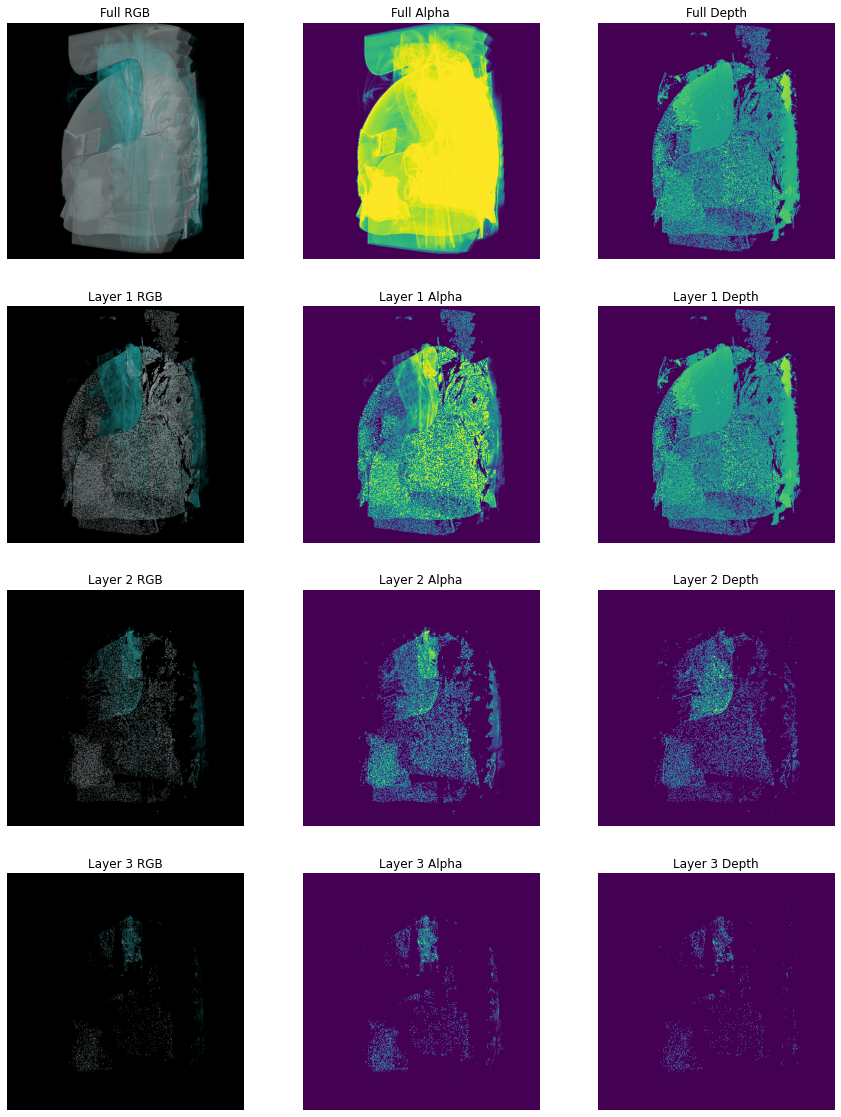

In [7]:
show_all_ims(rgbad.cpu())

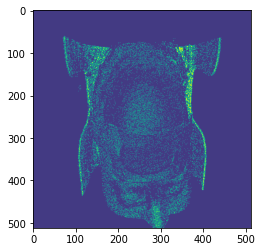

In [12]:
plt.imshow(diff.unsqueeze(-1).cpu())

In [14]:
rgbad1 = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.MIDA, layer_dist_thresh=1e-2).squeeze(0)
#rgbad2 = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP).squeeze(0)
print((rgbad[7:10] == rgbad[15:18]).all(), (rgbad[10] == rgbad[18]).all())
show_all_ims(rgbad1.cpu())
#show_all_ims(rgbad2.cpu())

TypeError: 4 argument(s) needed but 3 provided.

In [27]:
(raycaster.vr.exit[100,100] - raycaster.vr.entry[100,100]) / raycaster.vr.sample_step_nums[100,100]

8.21072707082172e-05

In [8]:
lf = get_rand_pos(1).float().to('cuda')
tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')

In [22]:
full = rgbad1[:4]
layer1 = torch.cat([rgbad1[7:11],  rgbad1[[4]]], dim=0)
layer2 = torch.cat([rgbad1[11:15], rgbad1[[5]]], dim=0)
layer3 = torch.cat([rgbad1[15:19], rgbad1[[6]]], dim=0)
stac = torch.stack([layer1, layer2, layer3])

In [101]:
val, idx = torch.sort(stac[:, 4], dim=0, stable=True)

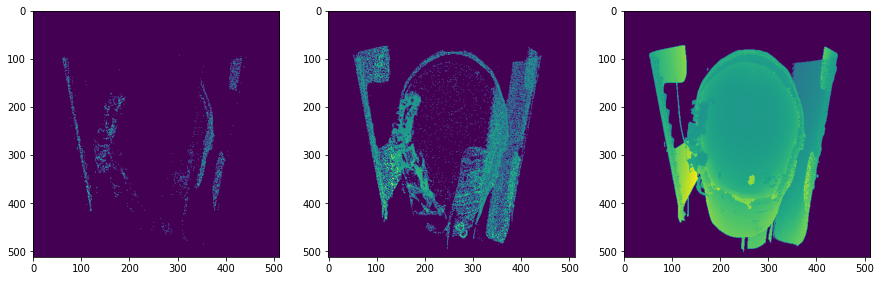

In [35]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(val[0].cpu())
ax[1].imshow(val[1].cpu())
ax[2].imshow(val[2].cpu())
fig.show()

In [91]:
stac.shape, idx.shape

(torch.Size([3, 5, 512, 512]), torch.Size([3, 512, 512]))

In [121]:
idx.shape

torch.Size([3, 512, 512])

In [120]:
stac[:,0].shape

torch.Size([3, 512, 512])

In [112]:
sorted_stac = torch.stack([stac[:, i].gather(dim=0, index=idx) for i in range(stac.size(1))], dim=1)

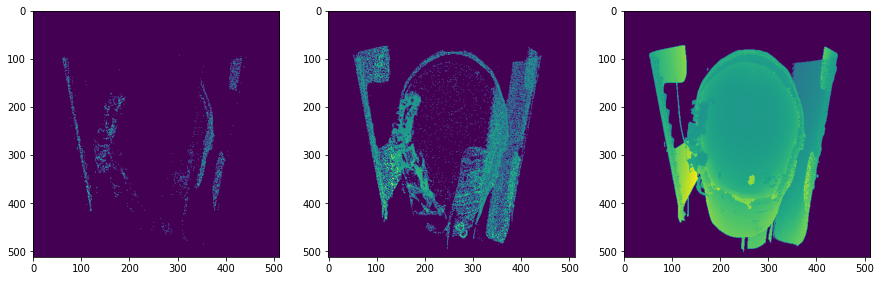

In [115]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(sorted_stac[0, [4]].permute(1,2,0).cpu())
ax[1].imshow(sorted_stac[1, [4]].permute(1,2,0).cpu())
ax[2].imshow(sorted_stac[2, [4]].permute(1,2,0).cpu())
fig.show()

In [63]:
a = torch.rand(2, 3, 3)
b = torch.zeros_like(a)
i = torch.argsort(a, dim=0)
a.shape, i.shape

(torch.Size([2, 3, 3]), torch.Size([2, 3, 3]))

In [80]:
a_sort, _ = a.sort(dim=0)

In [65]:
a, i

(tensor([[[0.7176, 0.1271, 0.0197],
          [0.2572, 0.3384, 0.4113],
          [0.4629, 0.1703, 0.3465]],
 
         [[0.6367, 0.5541, 0.4349],
          [0.3104, 0.1764, 0.1978],
          [0.3965, 0.9104, 0.3265]]]),
 tensor([[[1, 0, 0],
          [0, 1, 1],
          [1, 0, 1]],
 
         [[0, 1, 1],
          [1, 0, 0],
          [0, 1, 0]]]))

In [81]:
a_sort

tensor([[[0.6367, 0.1271, 0.0197],
         [0.2572, 0.1764, 0.1978],
         [0.3965, 0.1703, 0.3265]],

        [[0.7176, 0.5541, 0.4349],
         [0.3104, 0.3384, 0.4113],
         [0.4629, 0.9104, 0.3465]]])

In [76]:
a[0][i[0]]

tensor([[[0.2572, 0.3384, 0.4113],
         [0.7176, 0.1271, 0.0197],
         [0.7176, 0.1271, 0.0197]],

        [[0.7176, 0.1271, 0.0197],
         [0.2572, 0.3384, 0.4113],
         [0.2572, 0.3384, 0.4113]],

        [[0.2572, 0.3384, 0.4113],
         [0.7176, 0.1271, 0.0197],
         [0.2572, 0.3384, 0.4113]]])

In [52]:
red[idx].shape

RuntimeError: CUDA out of memory. Tried to allocate 768.00 GiB (GPU 0; 7.79 GiB total capacity; 346.01 MiB already allocated; 3.92 GiB free; 482.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [51]:
sortstac = stac.permute(1,0,2,3)[:, idx]

RuntimeError: CUDA out of memory. Tried to allocate 3840.00 GiB (GPU 0; 7.79 GiB total capacity; 346.01 MiB already allocated; 3.93 GiB free; 482.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [28]:
stac.shape

torch.Size([3, 5, 512, 512])

In [27]:
sortstac = stac.permute(1,0,2,3).cpu()[:, idx]

RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 4123168604160 bytes. Error code 12 (Cannot allocate memory)

In [16]:
back1 = (full - layer1[4] * layer1[:4]) / (1.0 - layer1[4])

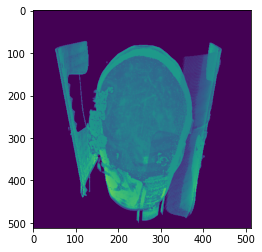

In [19]:
plt.imshow(back1[[3]].permute(1,2,0).cpu())

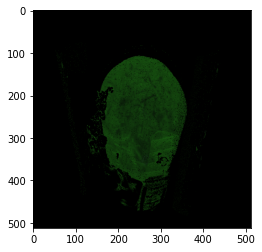

In [14]:
plt.imshow(layer1[:3].permute(1,2,0).cpu())

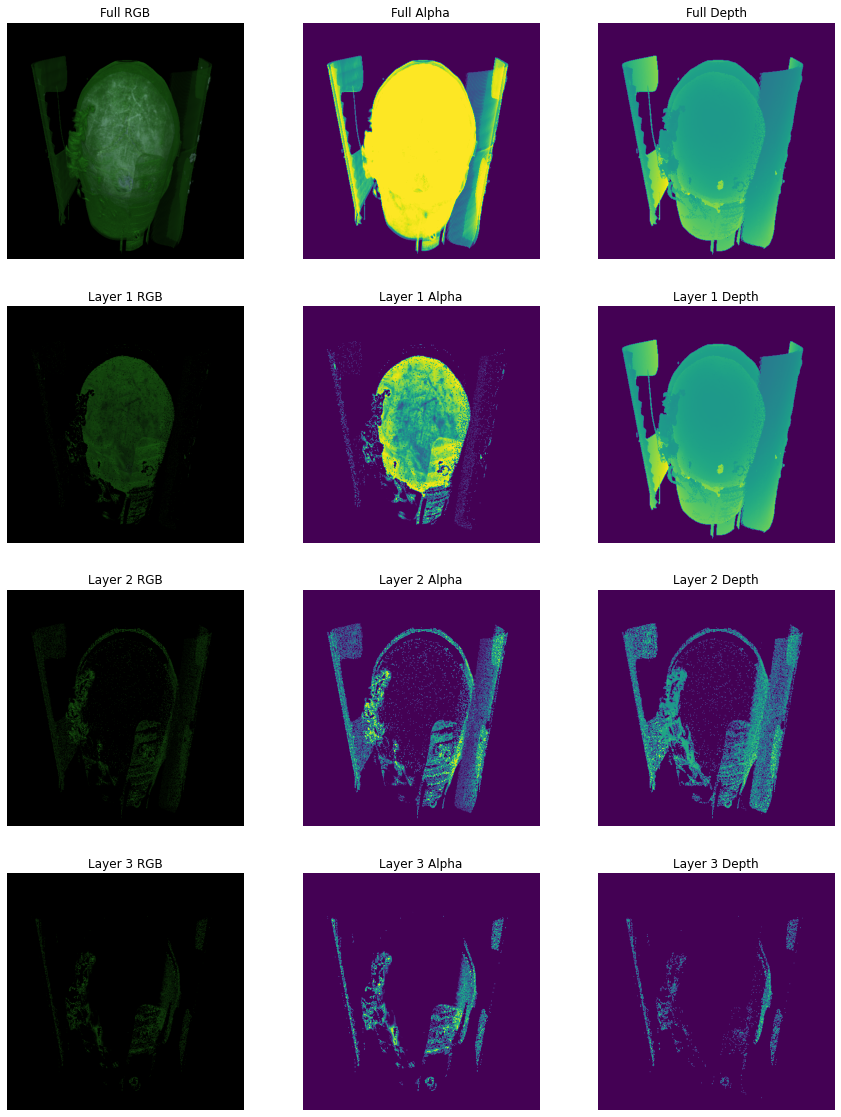

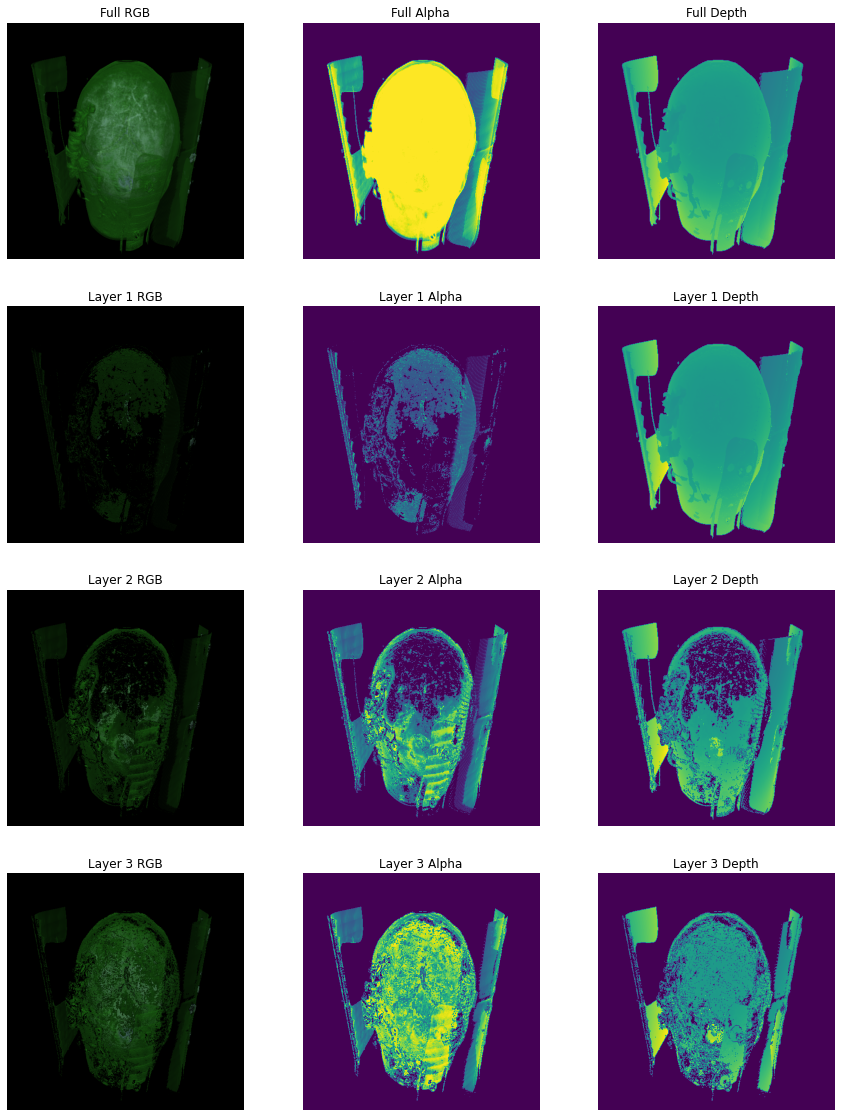

In [9]:
lt = 5e-3
rgbad1 = raycaster.raycast_nondiff(vol[None], tf, lf, sampling_rate=SR, mode=Mode.MIDA, 
        layer_dist_thresh=lt).squeeze(0)
rgbad2 = raycaster.raycast_nondiff(vol[None], tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP,            
        layer_dist_thresh=lt).squeeze(0)

show_all_ims(rgbad1.cpu())
show_all_ims(rgbad2.cpu())

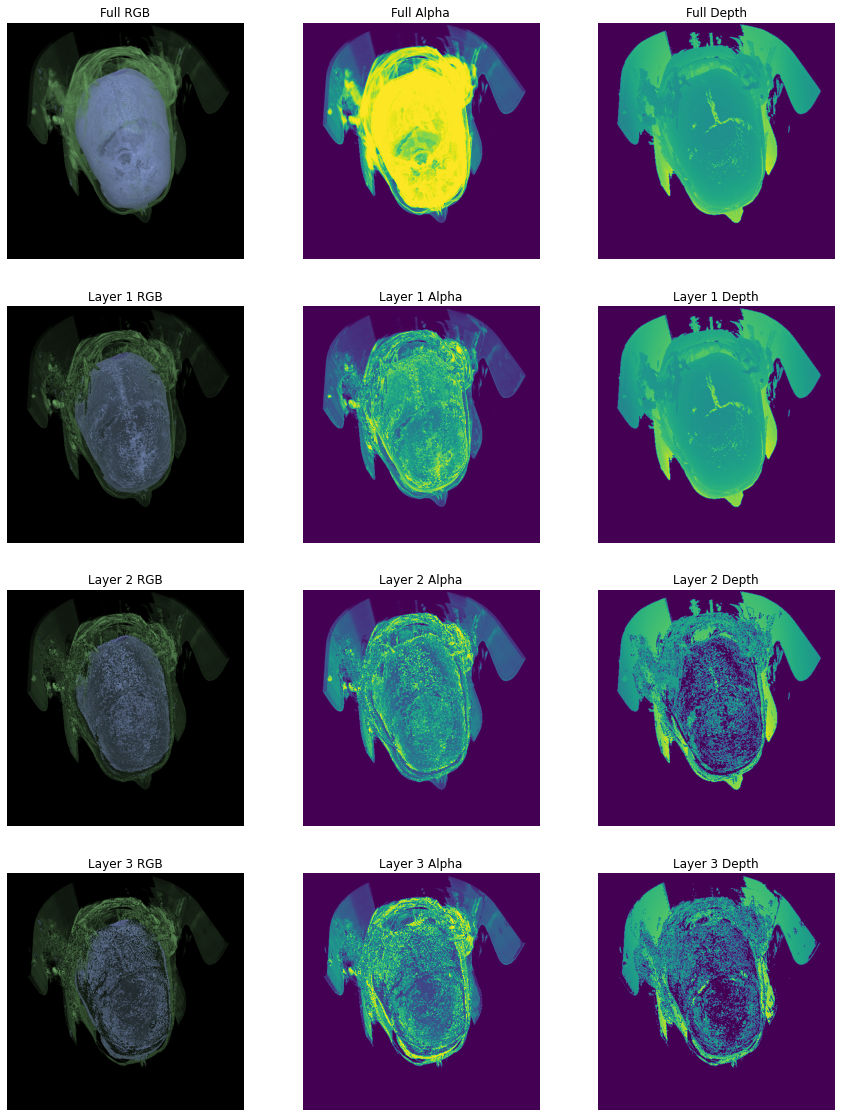

In [9]:
rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR, mode=Mode.WYSIWYP).squeeze(0)
show_all_ims(rgbad.cpu())

In [5]:
tf = tfgen.generate()
while len(tf) == 8: # single peak
    tf = tfgen.generate()
n_peaks = (len(tf)-2)//6
single_peaks = []
for i in range(n_peaks):
    peak = torch.cat([tf[[0]], tf[6*i+1 : 6*(i+1)+1], tf[[-1]]], dim=0)
    single_peaks.append({'pts': peak, 'tex': tex_from_pts(peak, TF_RES)})
    
rgbad_full = raycaster.raycast_nondiff(vol.float().cuda(), tex_from_pts(tf, TF_RES).float().cuda(),
                                       lf.float().cuda(), sampling_rate=SR).squeeze(0).detach().cpu()
#rgbad_full[4:][(rgbad_full[4:] == 0.0)] = 1.0
show_im(rgbad_full)
print((rgbad_full[3] > 0.0).float().mean())

single_peak_renders = []
for p in single_peaks:
    rgbad = raycaster.raycast_nondiff(vol.float().cuda(), p['tex'].float().cuda(), 
                                      lf.float().cuda(), sampling_rate=SR).squeeze(0)
    
    rgbad[4:][(rgbad[4:] == 0.0)] = 1.0
    
    single_peak_renders.append(rgbad.detach().cpu())
    fig, ax = plt.subplot_mosaic([['hist', 'hist', 'tf1'], 
                                  ['hist', 'hist', 'tf2'], 
                                  ['rgb', 'alpha', 'wysiwyp'],
                                  ['depth1', 'depth2', 'depth3'],
                                  ['alpha1', 'alpha2', 'alpha3'],
                                  ['sorted1', 'sorted2', 'sorted3']], figsize=(15,25), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [0.5, 0.5, 1.0, 1.0, 1.0, 1.0]
    })
    show_hist(rgbad[3], ax['hist'], title='Alpha Histogram')
    show_tf(p['pts'], ax=ax['tf1'], title='Current TF Peak')
    show_tf(tf, ax=ax['tf2'], title='Full Transfer Function')
    show_im(rgbad, axs=ax)
    
    fig.show()

for r, p in zip(single_peak_renders, single_peaks):
    abs_diff = torch.abs(r[:4] - rgbad_full[:4])
    abs_ddif = torch.abs(r[[4]] - rgbad_full[[4]])
    mae = abs_diff.mean()
    pct = (abs_diff.max(dim=0).values > 0.1).float().mean().item()
    fig, ax = plt.subplot_mosaic([['single', 'full', 'diff'],
                                  ['sdepth', 'fdepth', 'ddepth'],
                                  ['salpha', 'falpha', 'dalpha'],
                                  ['tf1', 'tf2', 'hist']], figsize=(15,12), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [5.0, 5.0, 5.0, 2.0]
    })
    ax['single'].imshow(r[:3].permute(1,2,0))
    ax['single'].set_title('Partial RGB')
    ax['single'].set_axis_off()
    
    ax['full'].imshow(rgbad_full[:3].permute(1,2,0))
    ax['full'].set_title('Full RGB')
    ax['full'].set_axis_off()
    ax['diff'].imshow(abs_diff[:3].permute(1,2,0))
    ax['diff'].set_title(f'Abs RGB Difference. Pct: {pct:.1%}')
    ax['diff'].set_axis_off()
    
    ax['sdepth'].imshow(r[[4,4,4]].permute(1,2,0))
    ax['sdepth'].set_title('Partial Depth')
    ax['sdepth'].set_axis_off()
    ax['fdepth'].imshow(rgbad_full[[4,4,4]].permute(1,2,0))
    ax['fdepth'].set_title('Full Depth')
    ax['fdepth'].set_axis_off()
    ax['ddepth'].imshow(abs_ddif.permute(1,2,0))
    ax['ddepth'].set_title('Depth Difference')
    ax['ddepth'].set_axis_off()
    show_tf(p['pts'], ax=ax['tf1'], title='Partial TF')
    show_tf(tf, ax=ax['tf2'], title='Full TF')
    show_hist(abs_diff.max(dim=0).values, ax['hist'], title='Difference Histogram', show_percentages=False)
    
    fig.show()
    

NameError: name 'raycaster' is not defined